In [ ]:
import os, sys
from pathlib import Path
import urllib.request
from collections import Counter, defaultdict
import string
import re
import math
from importlib import reload

import numpy as np
import pandas as pd
from gensim.models import KeyedVectors
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot as plt
import seaborn as sn
import tensorflow as tf
%matplotlib inline

import models.fasttext as fasttext
import models.cnn as cnn
import models.rnn as rnn
from util import shuffle, batch_iter, conf_matrix_plot
reload(fasttext)
reload(cnn)
reload(rnn);

In [2]:
tv_show = "friends"

In [3]:
nltk.download('punkt')
nltk.download('stopwords')

root_path = Path().resolve().joinpath("..")
show_data_path = root_path.joinpath("scrape", "data", tv_show, "parsed")
embeddings_path = root_path.joinpath("embeddings", "newscrawl.300d.W.pos.vectors.gz")
embeddings_url = "https://www.dropbox.com/s/kguufyc2xcdi8yk/lexvec.enwiki%2Bnewscrawl.300d.W.pos.vectors.gz?dl=1"

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /Users/andy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/andy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# downloads the Word2Vec embeddings (only need to run once)
if not os.path.isfile(embeddings_path):
    print("downloading embeddings...")
    urllib.request.urlretrieve(embeddings_url, embeddings_path)

!gunzip {str(embeddings_path)}

/Users/andy/Documents/projects/w266-final/analysis/../embeddings/newscrawl.300d.W.pos.vectors already exists -- do you wish to overwrite (y or n)? ^C


## Load the Training Data

In [4]:
dialog_datas = []

# take all the separate CSV files and put them together into a single dataframe
for filename in os.listdir(show_data_path):
    dialog_data = pd.read_csv(show_data_path.joinpath(filename), header=None, names=("speaker", "utterance"))
    dialog_data["episode"] = filename.split(".")[0]
    dialog_datas.append(dialog_data)
    
all_dialog_data = pd.concat(dialog_datas) \
                    .dropna() \
                    .sample(frac=1) \
                    .reset_index(drop=True)

In [5]:
print(all_dialog_data.count())
all_dialog_data.head()

speaker      55025
utterance    55025
episode      55025
dtype: int64


,speaker,utterance,episode
0,Rachel,Really?!,0325
1,Kristen,But-but this block is like a whole other world.,0717
2,Joey,Okay! All right!,0715
3,Chandler,Hey.,0417
4,Monica,"Oh, gosh, you got some on your shirt.",0313


## Data Pre-processing and Minor Analysis

We'll count how many lines of dialog each character has. We need to subset the number of classes, taking only the top $n$ most common.

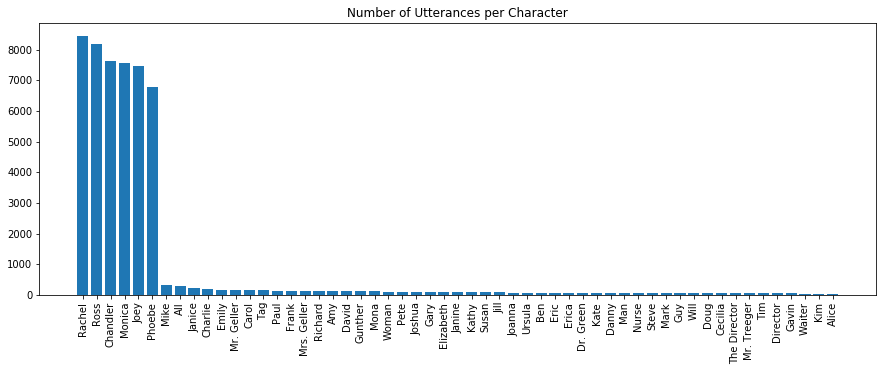

In [34]:
speaker_value_counts = all_dialog_data.speaker.value_counts()
major_speaker_value_counts = speaker_value_counts[speaker_value_counts > 40]
x, y = major_speaker_value_counts.index, major_speaker_value_counts.values

fig = plt.figure(figsize=(15, 5))
sub = fig.add_subplot(111)
sub.bar(x, y)
for tick in sub.get_xticklabels():
    tick.set_rotation(90)
plt.title("Number of Utterances per Character")
plt.show()

The number of characters will be in the `num_major_characters` variable, and can be changed.

In [35]:
num_major_characters = 6

# a list of the top characters names
major_characters = x[:num_major_characters]
# a set of those same names
major_characters_set = set(major_characters)

# finally, dicts to and from class Ids and their respective names
labels_to_ids = {}
ids_to_labels = {}
for i, major_character in enumerate(major_characters):
    labels_to_ids[major_character] = i
    ids_to_labels[i] = major_character
labels_to_ids

{'Rachel': 0, 'Ross': 1, 'Chandler': 2, 'Monica': 3, 'Joey': 4, 'Phoebe': 5}

Cut the data to only the major characters

In [9]:
major_dialog_data = all_dialog_data[all_dialog_data.speaker.isin(major_characters_set)]
print(major_dialog_data.count())

speaker      46079
utterance    46079
episode      46079
dtype: int64


In [10]:
tokenizer = nltk.tokenize.TreebankWordTokenizer()

labels = major_dialog_data.speaker

# tokenize the data into a nested list
utterances = [tokenizer.tokenize(utter.lower()) for utter in major_dialog_data.utterance]
# load the vocabulary with the embeddings
embeddings = KeyedVectors.load_word2vec_format(root_path.joinpath("embeddings", "newscrawl.300d.W.pos.vectors"), binary=False)

Text(0.5, 1.0, 'Histogram of Utterance lengths')

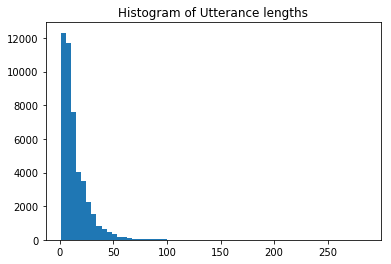

In [11]:
plt.hist([len(words) for words in utterances], bins=60)
plt.title("Histogram of Utterance lengths")

## Baseline Model - Always predict the most common class

This is the absolute simplest thing one can do. We definitely need to beat this score.

In [12]:
np.mean(labels == major_characters[0])

0.1832939082879403

## Baseline Model - Logistic Regression over BOW

Pretty much the next simplest model we could use. This will serve as a good baseline. It just uses pre-trained Word2Vec and its vocabulary.

This is a "bag of vectors" model. That is, it converts the sequence to their embeddings and then averages them together to generate a fixed-length vector for each sequence. Then, the vector is passed to a one-vs-all logistic regression.

In [13]:
non_empty_utterances = []
non_empty_utterance_labels = []

for i, utterance in enumerate(utterances):
    words = [word for word in utterance if word in embeddings.vocab and word not in stop_words]
    if len(words) > 0:
        non_empty_utterances.append(words)
        non_empty_utterance_labels.append(labels.iloc[i])

bags = np.zeros((len(non_empty_utterances), embeddings.vector_size))

for i, utterance in enumerate(non_empty_utterances):
    words = [word for word in utterance if word in embeddings.vocab]
    vectors = np.zeros((len(words), embeddings.vector_size))
    for j, word in enumerate(words):
        vectors[j, :] = embeddings.word_vec(word)
    bag = np.mean(vectors, axis=0)
    bags[i, :] = bag

train_cut = math.ceil(major_dialog_data.utterance.count() * 0.85)
train_x = bags[0:train_cut]
train_y = non_empty_utterance_labels[0:train_cut]
test_x = bags[train_cut:]
test_y = non_empty_utterance_labels[train_cut:]

print(train_x.shape, test_x.shape)

(39168, 300) (4216, 300)


In [246]:
model = LogisticRegression(multi_class="ovr")
model.fit(train_x, train_y)
print(model.score(train_x, train_y))

/Users/andy/miniconda3/envs/noble/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.2785947712418301


0.24407020872865276
              precision    recall  f1-score   support

    Chandler       0.21      0.22      0.21       629
        Joey       0.32      0.25      0.28       848
      Monica       0.21      0.24      0.22       587
      Phoebe       0.08      0.22      0.12       249
      Rachel       0.36      0.25      0.30      1130
        Ross       0.26      0.25      0.26       773

   micro avg       0.24      0.24      0.24      4216
   macro avg       0.24      0.24      0.23      4216
weighted avg       0.27      0.24      0.25      4216



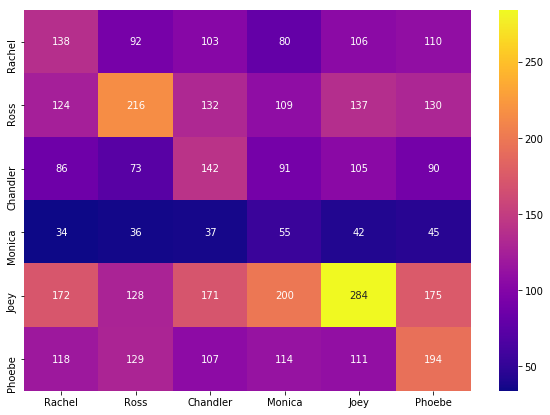

In [247]:
base_test_preds = model.predict(test_x)
print(np.mean(base_test_preds == test_y))
print(classification_report(base_test_preds, test_y))
conf_matrix_plot(confusion_matrix(base_test_preds, test_y), major_characters)

## Model - Facebook Fasttext
[https://arxiv.org/abs/1607.01759](https://arxiv.org/abs/1607.01759)

This is a simple model with a word embedding layer followed by one hidden fully-connected layer. For this model, we'll train our own embeddings with an embedding dimension of 10. By training the embeddings from scratch, we might achieve more tailored embeddings for this particular corpus. We also use our own vocabulary. We'll include all words that appear in the training corpus 3 or more times.

In [15]:
counter = Counter()
stemmer = PorterStemmer()

# manully tokenize the sentences
custom_tokenized = []
for utterance in major_dialog_data.utterance:
    words = re.findall(r"[a-z0-9']+", utterance.lower())
    # remove dangling apostrophes and 's at the end of words
    words = [re.sub(r"'s?$", "", stemmer.stem(word)) for word in words]
    custom_tokenized.append(words)

# count all the tokens
for utterance in custom_tokenized:
    counter.update(word for word in utterance if word not in string.punctuation)

# filter to words of counts greater than 2
vocab = [k for k, v in counter.most_common() if v > 2]

# assign IDs to the words
vocab_word_to_id = defaultdict(lambda: -1)
vocab_id_to_word = {}
for i, word in enumerate(vocab):
    vocab_id_to_word[i] = word
    vocab_word_to_id[word] = i

In [16]:
label_ids = np.array([labels_to_ids[label] for label in labels])
train_x_fasttext = custom_tokenized[:train_cut]
train_y_fasttext = label_ids[:train_cut]
test_x_fasttext = custom_tokenized[train_cut:]
test_y_fasttext = label_ids[train_cut:]

train_x_fasttext = np.array([" ".join(words) for words in train_x_fasttext])
test_x_fasttext = np.array([" ".join(words) for words in test_x_fasttext])

In [251]:
reload(fasttext)
tf.reset_default_graph()
fasttext_model = fasttext.FastText(vocab, num_major_characters, regularize_coef=0.1)

In [18]:
display_step = 20
num_epochs = 40
batch_size = 128

train_writer = tf.summary.FileWriter("./fasttext-board/train")
test_writer = tf.summary.FileWriter("./fasttext-board/test")
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    train_writer.add_graph(sess.graph)
    
    global_step = 0
    X = fasttext_model.X
    Y = fasttext_model.Y

    for epoch in range(num_epochs):
        print("{} epoch number: {}".format(datetime.now(), epoch + 1))
        train_x_fasttext, train_y_fasttext = shuffle(train_x_fasttext, train_y_fasttext)
        
        for step, x_batch, y_batch in batch_iter(train_x_fasttext, train_y_fasttext, batch_size):
            global_step += 1
            sess.run(fasttext_model.train_op, feed_dict={ X: x_batch, Y: y_batch })

            # every so often, report the progress of our loss and training accuracy
            if step % display_step == 0:
                summ = sess.run(fasttext_model.merged_summary, feed_dict={ X: x_batch, Y: y_batch })
                train_writer.add_summary(summ, global_step=global_step)
                train_writer.flush()

        test_acc, summ = sess.run([fasttext_model.accuracy, fasttext_model.merged_summary], feed_dict={ X: test_x_fasttext, Y: test_y_fasttext })
        test_writer.add_summary(summ, global_step=global_step)
        test_writer.flush()
        print("test accuracy = {:.4f}".format(test_acc))
    
    # save the model to disk so we can load it up later for use by `./eval.py`
    saver.save(sess, "./fasttext-ckpt/model.ckpt")

2018-11-23 22:12:00.563431 epoch number: 1
test accuracy = 0.1940
2018-11-23 22:12:02.879368 epoch number: 2
test accuracy = 0.1884
2018-11-23 22:12:04.279728 epoch number: 3
test accuracy = 0.1830
2018-11-23 22:12:05.666548 epoch number: 4
test accuracy = 0.1878
2018-11-23 22:12:07.114634 epoch number: 5
test accuracy = 0.1904
2018-11-23 22:12:08.529381 epoch number: 6
test accuracy = 0.1877
2018-11-23 22:12:09.836021 epoch number: 7
test accuracy = 0.1874
2018-11-23 22:12:11.729248 epoch number: 8
test accuracy = 0.1883
2018-11-23 22:12:13.764215 epoch number: 9
test accuracy = 0.1916
2018-11-23 22:12:15.703558 epoch number: 10
test accuracy = 0.2082
2018-11-23 22:12:17.281461 epoch number: 11
test accuracy = 0.2097
2018-11-23 22:12:18.638768 epoch number: 12
test accuracy = 0.2100
2018-11-23 22:12:20.042073 epoch number: 13
test accuracy = 0.2130
2018-11-23 22:12:21.781089 epoch number: 14
test accuracy = 0.2149
2018-11-23 22:12:23.109854 epoch number: 15
test accuracy = 0.2199
2018

This model is only slightly better. It looks like training embeddings from scratch doesn't help.

### FastText Evaluation

INFO:tensorflow:Restoring parameters from ./fasttext-ckpt/model.ckpt
              precision    recall  f1-score   support

      Rachel       0.25      0.44      0.32      1287
        Ross       0.24      0.27      0.25      1191
    Chandler       0.26      0.25      0.26      1127
      Monica       0.25      0.28      0.27      1137
        Joey       0.29      0.23      0.26      1113
      Phoebe       0.28      0.02      0.04      1056

   micro avg       0.26      0.26      0.26      6911
   macro avg       0.26      0.25      0.23      6911
weighted avg       0.26      0.26      0.24      6911



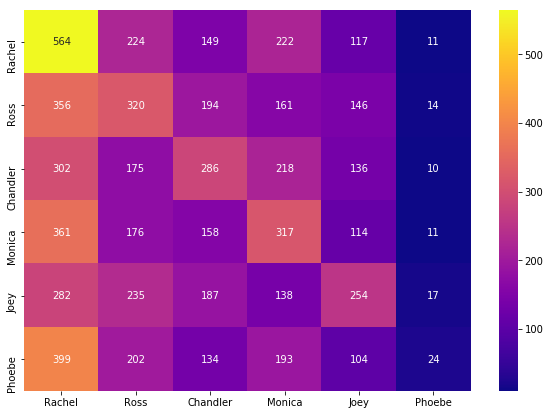

In [253]:
saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess, "./fasttext-ckpt/model.ckpt")
    sess.run(tf.tables_initializer())
    fasttext_test_preds = sess.run(fasttext_model.predictions, feed_dict={ fasttext_model.X: test_x_fasttext })
    
print(classification_report(test_y_fasttext, fasttext_test_preds, target_names=major_characters))

conf_matrix_plot(confusion_matrix(test_y_fasttext, fasttext_test_preds), major_characters)

## Model - CNN

[https://arxiv.org/abs/1408.5882](https://arxiv.org/abs/1408.5882)

CNNs can learn more complex, non-linear patterns. We effectively do a 1-D convolution on the words embeddings (going back to Word2Vec). This creates a variable-length feature map for each convolutional filter. We can aggregate the feature map into a single feature using a 1-D max-pooling operation. This furnishes a hidden layer of fixed length (equal to the number of filters).

CNNs aren't as easily interpretable as logistic regression, but there are methods to glean some insight from them.

In [216]:
cnn_tokenized = []
for utterance in major_dialog_data.utterance:
    words = re.findall(r"[a-z0-9']+", utterance.lower())
    # remove dangling apostrophes and 's at the end of words
    words = [re.sub(r"'s?$", "", word) for word in words]
    words = [re.sub(r"'", "", word) for word in words]
    cnn_tokenized.append(words)

train_x_cnn = cnn_tokenized[:train_cut]
train_y_cnn = label_ids[:train_cut]
test_x_cnn = cnn_tokenized[train_cut:]
test_y_cnn = label_ids[train_cut:]

train_x_cnn = np.array([" ".join(words) for words in train_x_cnn])
test_x_cnn = np.array([" ".join(words) for words in test_x_cnn])

In [217]:
tf.reset_default_graph()

cnn_model = cnn.CNN(embeddings, num_major_characters)

In [112]:
display_step = 20
num_epochs = 5
batch_size = 128

train_writer = tf.summary.FileWriter("./cnn-board/train")
test_writer = tf.summary.FileWriter("./cnn-board/test")
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    train_writer.add_graph(sess.graph)
    
    global_step = 0
    X = cnn_model.X
    Y = cnn_model.Y
    keep_prob = cnn_model.keep_prob

    for epoch in range(num_epochs):
        print("{} epoch number: {}".format(datetime.now(), epoch + 1))
        train_x_cnn, train_y_cnn = shuffle(train_x_cnn, train_y_cnn)
        
        for step, x_batch, y_batch in batch_iter(train_x_cnn, train_y_cnn, batch_size):
            global_step += 1
            sess.run(cnn_model.train_op, feed_dict={ X: x_batch, Y: y_batch, keep_prob: 1 })

            # every so often, report the progress of our loss and training accuracy
            if step % display_step == 0:
                summ = sess.run(cnn_model.merged_summary, feed_dict={ X: x_batch, Y: y_batch })
                train_writer.add_summary(summ, global_step=global_step)
                train_writer.flush()

        test_acc, summ = sess.run([cnn_model.accuracy, cnn_model.merged_summary], feed_dict={ X: test_x_cnn, Y: test_y_cnn })
        test_writer.add_summary(summ, global_step=global_step)
        test_writer.flush()
        print("test accuracy = {:.4f}".format(test_acc))
    
    # save the model to disk so we can load it up later for use by `./eval.py`
    saver.save(sess, "./cnn-ckpt/model.ckpt")

2018-11-24 14:48:34.327714 epoch number: 1
test accuracy = 0.2555
2018-11-24 14:49:27.283134 epoch number: 2
test accuracy = 0.2602
2018-11-24 14:50:15.716978 epoch number: 3
test accuracy = 0.2696
2018-11-24 14:51:03.907170 epoch number: 4
test accuracy = 0.2741
2018-11-24 14:51:51.749291 epoch number: 5
test accuracy = 0.2693


### CNN Evaluation

We calculate a confusion matrix and some other metrics.

INFO:tensorflow:Restoring parameters from ./cnn-ckpt/model.ckpt
              precision    recall  f1-score   support

      Rachel       0.30      0.38      0.33      1287
        Ross       0.25      0.38      0.30      1191
    Chandler       0.23      0.28      0.25      1127
      Monica       0.27      0.23      0.25      1137
        Joey       0.31      0.22      0.26      1113
      Phoebe       0.32      0.09      0.14      1056

   micro avg       0.27      0.27      0.27      6911
   macro avg       0.28      0.26      0.26      6911
weighted avg       0.28      0.27      0.26      6911



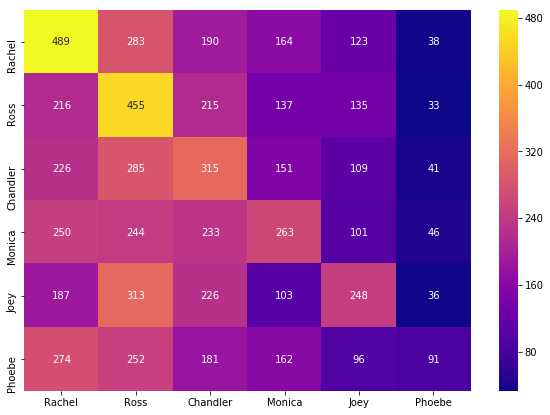

In [248]:
saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess, "./cnn-ckpt/model.ckpt")
    sess.run(tf.tables_initializer())
    test_predictions = sess.run(cnn_model.predictions, feed_dict={ cnn_model.X: test_x_cnn })
    
print(classification_report(test_y_cnn, test_predictions, target_names=major_characters))

conf_matrix_plot(confusion_matrix(test_y_cnn, test_predictions), major_characters)

## Saliency Maps
[http://www.aclweb.org/anthology/N16-1082](http://www.aclweb.org/anthology/N16-1082)

This is one technique for rationalizing the inner workings of a neural network. The partial derivatives of the logits w.r.t. the inputs are taken. Those gradients with the highest magnitude can be considered the most "salient" features, as those feature contributed *most highly* to the resulting prediction.

In this cell, we take a novel line of dialog (the user can make one up), and run the prediction. But most importantly, we generate the saliency map to try to explain **why** the prediction was made.

INFO:tensorflow:Restoring parameters from ./cnn-ckpt/model.ckpt


Text(0.5, 1.0, 'Monica')

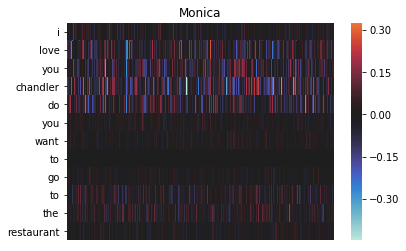

In [219]:
user_input_to_classify = "i love you chandler do you want to go to the restaurant"

with tf.Session() as sess:
    saver.restore(sess, "./cnn-ckpt/model.ckpt")
    sess.run(tf.tables_initializer())

    user_input_pred, = sess.run(cnn_model.predictions, feed_dict={ cnn_model.X: [user_input_to_classify] })
    grads = tf.gradients(cnn_model.logits[:, user_input_pred], [cnn_model.embedded])
    user_input_grads, = sess.run(grads, feed_dict={ cnn_model.X: [user_input_to_classify] })
    
sn.heatmap(user_input_grads[0], yticklabels=user_input_to_classify.split(" "), xticklabels=False, center=0)
plt.title(major_characters[user_input_pred])

This plot shows the time dimension of the sequence on the y-axis, and the embedding dimensions on the x-axis (300 for Word2Vec). The color in each cell is a value of the gradient for this particular prediction. The rows with cells furthest from 0 are the most salient, i.e. brightly colored rows means that word is more important for that prediction. Another way to attribute saliency to each word is by taking the norm of the gradient in that row.

In these next cells, we loop through each class and take some of the correct predictions of that class from the test set. Then, we sample some of the correct predictions and plot their saliency maps. This will show if the model is using reasonable things to make its predictions.

In [220]:
utterances_to_plot = []
embedding_gradients_to_plot = []
original_indices = []

with tf.Session() as sess:
    saver.restore(sess, "./cnn-ckpt/model.ckpt")
    sess.run(tf.tables_initializer())

    for i in range(num_major_characters):
        correct_predictions_i = np.where(np.logical_and(test_y_cnn == i, test_predictions == i))
        grads = tf.gradients(cnn_model.logits[:, i], [cnn_model.embedded])
        embedding_gradients, = sess.run(grads, feed_dict={ cnn_model.X: test_x_cnn })
        utterances_to_plot.append(test_x_cnn[correct_predictions_i])
        embedding_gradients_to_plot.append(embedding_gradients[correct_predictions_i])
        original_indices.append(correct_predictions_i[0])

INFO:tensorflow:Restoring parameters from ./cnn-ckpt/model.ckpt


In [225]:
from IPython.display import display, Markdown

def show_heatmaps(utterances, gradients, xtitles, limit=9, offset=0):
    """takes a set of inputs and gradients, subsets them, and plots a heatmap"""
    plt.figure(figsize=(18, math.ceil(limit * 1.5)))
    for i, utterance in enumerate(utterances[offset:offset + limit]):
        sentence = utterance.split(" ")
        if len(sentence) > 1:
            plt.subplot(math.ceil(limit / 3), 3, i + 1)
            to_plot = gradients[offset + i][:len(sentence)]
            sn.heatmap(to_plot, yticklabels=sentence, xticklabels=False, center=0)
            plt.xlabel(xtitles[offset + i])
    plt.show()

## Rachel

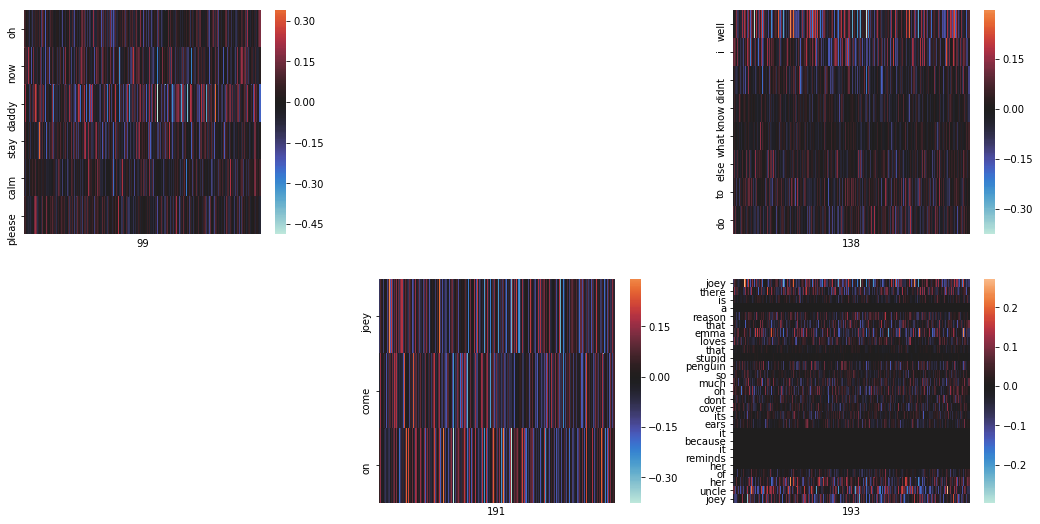

In [227]:
display(Markdown("## " + major_characters[0]))
show_heatmaps(utterances_to_plot[0], embedding_gradients_to_plot[0], original_indices[0], limit=9, offset=9)

## Ross

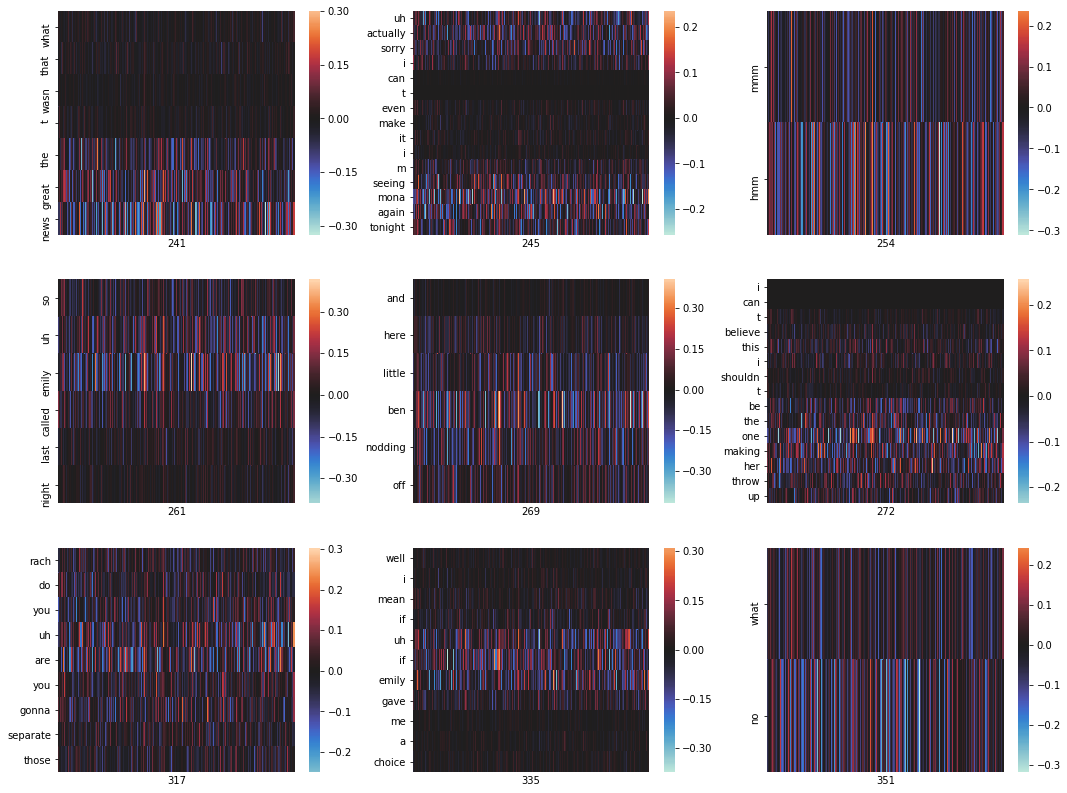

In [229]:
display(Markdown("## " + major_characters[1]))
show_heatmaps(utterances_to_plot[1], embedding_gradients_to_plot[1], original_indices[1], limit=9, offset=9)

## Chandler

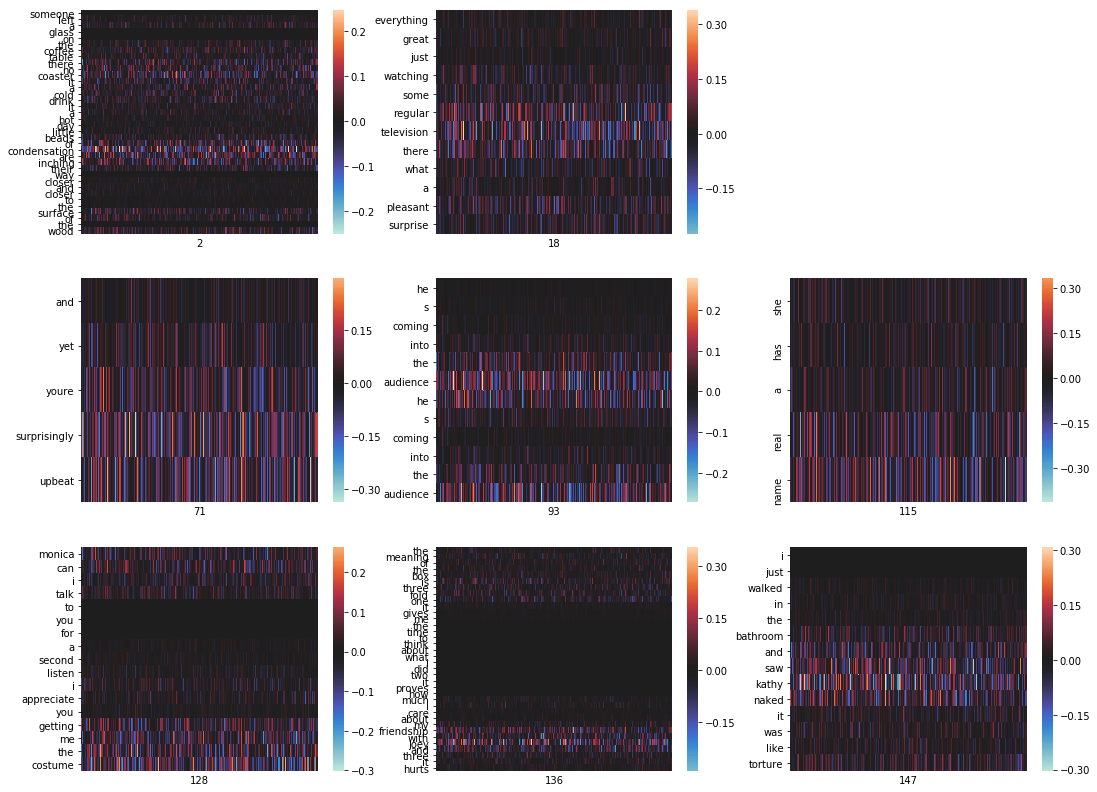

In [230]:
display(Markdown("## " + major_characters[2]))
show_heatmaps(utterances_to_plot[2], embedding_gradients_to_plot[2], original_indices[2], limit=9, offset=0)

## Monica

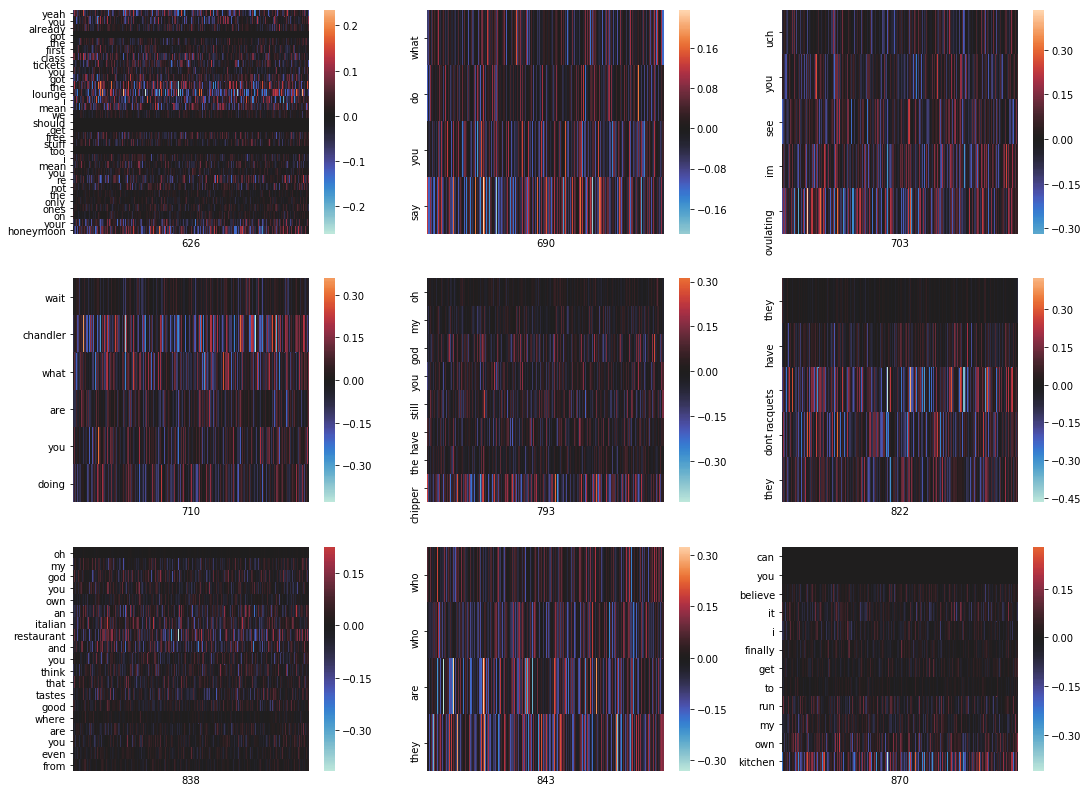

In [233]:
display(Markdown("## " + major_characters[3]))
show_heatmaps(utterances_to_plot[3], embedding_gradients_to_plot[3], original_indices[3], limit=9, offset=18)

## Joey

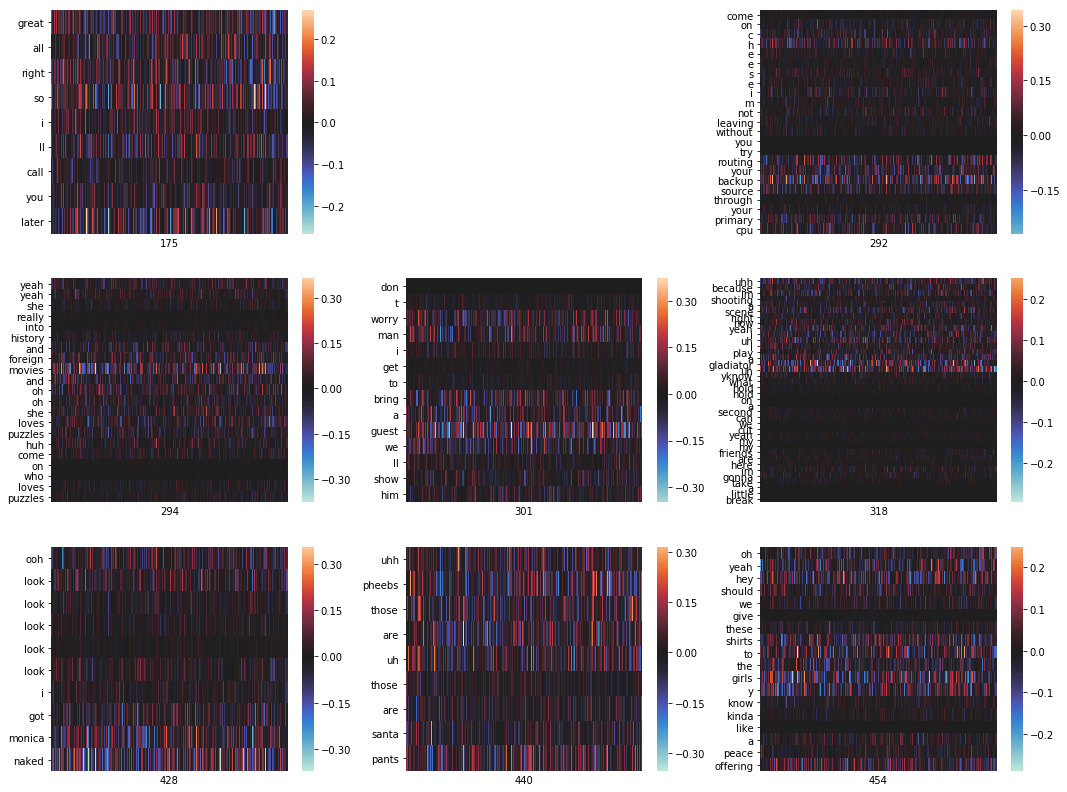

In [235]:
display(Markdown("## " + major_characters[4]))
show_heatmaps(utterances_to_plot[4], embedding_gradients_to_plot[4], original_indices[4], limit=9, offset=9)

## Phoebe

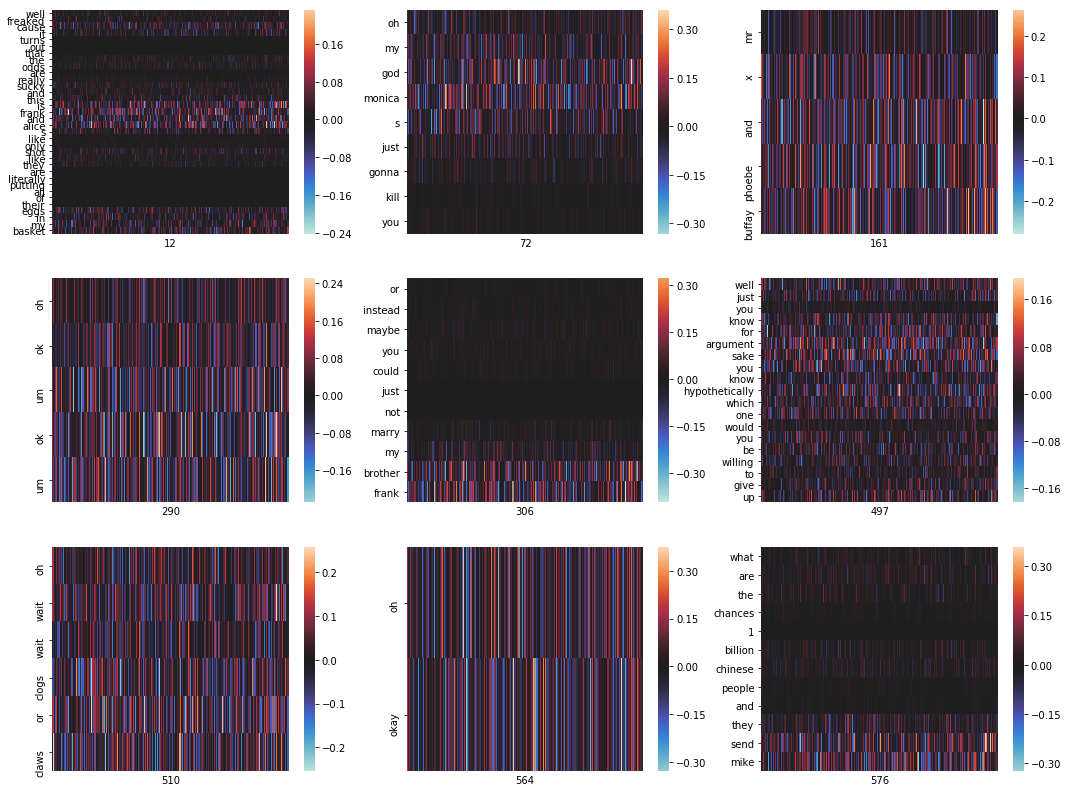

In [236]:
display(Markdown("## " + major_characters[5]))
show_heatmaps(utterances_to_plot[5], embedding_gradients_to_plot[5], original_indices[5], limit=9)

## Model - RNN

[http://www.aclweb.org/anthology/P16-2034](http://www.aclweb.org/anthology/P16-2034)

Finally, a bidirectional RNN with attention. RNNs are nice for how they model sequences, but are very hard to interpret. This is why attention is useful. It adds some interpretability to these models, as the attention coefficients indicate the important parts of the input.

In [91]:
max_seq_len = 32

def embed_and_pad(utterances, embeddings, max_len):
    embedded = np.zeros((utterances.shape[0], max_len, embeddings.vector_size))

    for i, utterance in enumerate(utterances):
        tokens = utterance.split(" ")
        for j in range(max_len):
            if j < len(tokens) and tokens[j] in embeddings.vocab:
                embedded[i, j, :] = embeddings.get_vector(tokens[j])
            else:
                embedded[i, j, :] = np.zeros((embeddings.vector_size))
    return embedded

train_x_rnn = embed_and_pad(train_x_cnn, embeddings, max_seq_len)
test_x_rnn = embed_and_pad(test_x_cnn, embeddings, max_seq_len)

In [254]:
reload(rnn)
tf.reset_default_graph()

rnn_model = rnn.RNN(embeddings, num_major_characters, hidden_size=64, max_len=max_seq_len)

In [105]:
display_step = 20
num_epochs = 10
batch_size = 128

train_writer = tf.summary.FileWriter("./rnn-board/train")
test_writer = tf.summary.FileWriter("./rnn-board/test")
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    train_writer.add_graph(sess.graph)
    
    global_step = 0
    X = rnn_model.X
    Y = rnn_model.Y
    keep_prob = rnn_model.keep_prob

    for epoch in range(num_epochs):
        print("{} epoch number: {}".format(datetime.now(), epoch + 1))
        train_x_rnn, train_y_cnn = shuffle(train_x_rnn, train_y_cnn)
        
        for step, x_batch, y_batch in batch_iter(train_x_rnn, train_y_cnn, batch_size):
            global_step += 1
            sess.run(rnn_model.train_op, feed_dict={ X: x_batch, Y: y_batch, keep_prob: 1 })

            # every so often, report the progress of our loss and training accuracy
            if step % display_step == 0:
                summ = sess.run(rnn_model.merged_summary, feed_dict={ X: x_batch, Y: y_batch })
                train_writer.add_summary(summ, global_step=global_step)
                train_writer.flush()

        test_acc, summ = sess.run([rnn_model.accuracy, rnn_model.merged_summary], feed_dict={ X: test_x_rnn, Y: test_y_cnn })
        test_writer.add_summary(summ, global_step=global_step)
        test_writer.flush()
        print("test accuracy = {:.4f}".format(test_acc))
    
    # save the model to disk so we can load it up later for use by `./eval.py`
    saver.save(sess, "./rnn-ckpt/model.ckpt")

2018-11-24 13:04:01.773319 epoch number: 1
test accuracy = 0.2309
2018-11-24 13:04:48.598179 epoch number: 2
test accuracy = 0.2526
2018-11-24 13:05:29.521805 epoch number: 3
test accuracy = 0.2658
2018-11-24 13:06:12.988991 epoch number: 4
test accuracy = 0.2741
2018-11-24 13:06:54.074823 epoch number: 5
test accuracy = 0.2803
2018-11-24 13:07:35.668951 epoch number: 6
test accuracy = 0.2801
2018-11-24 13:08:17.203978 epoch number: 7
test accuracy = 0.2790
2018-11-24 13:08:59.308975 epoch number: 8
test accuracy = 0.2771
2018-11-24 13:09:38.675465 epoch number: 9
test accuracy = 0.2842
2018-11-24 13:10:21.538091 epoch number: 10
test accuracy = 0.2800


### RNN Evaluation

INFO:tensorflow:Restoring parameters from ./rnn-ckpt/model.ckpt
              precision    recall  f1-score   support

      Rachel       0.29      0.40      0.34      1287
        Ross       0.25      0.26      0.26      1191
    Chandler       0.27      0.18      0.21      1127
      Monica       0.28      0.24      0.25      1137
        Joey       0.29      0.36      0.32      1113
      Phoebe       0.28      0.23      0.25      1056

   micro avg       0.28      0.28      0.28      6911
   macro avg       0.28      0.28      0.27      6911
weighted avg       0.28      0.28      0.27      6911



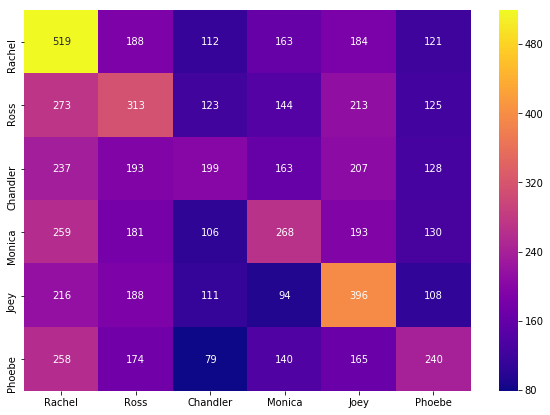

In [255]:
saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess, "./rnn-ckpt/model.ckpt")
    rnn_test_attn, rnn_test_predictions = sess.run((rnn_model.alpha, rnn_model.predictions), feed_dict={ rnn_model.X: test_x_rnn })
    
print(classification_report(test_y_cnn, rnn_test_predictions, target_names=major_characters))

conf_matrix_plot(confusion_matrix(test_y_cnn, rnn_test_predictions), major_characters)

In [203]:
def visualize_attention(sentence, attn, max_len=None):
    attn = attn / np.max(attn)
    tagged_sentence = []
    for i, word in enumerate(sentence):
        opacity = attn[i] if i < len(attn) else 0
        tagged_sentence.append(f'<span style="background-color: rgba(100, 200, 255, {opacity});">{word}</span>')
        if max_len and i == max_len - 1:
            tagged_sentence.append('<span style="color: red;">|</span>')
    display(Markdown(" ".join(tagged_sentence)))

In [204]:
user_input_to_classify = "i love you chandler do you want to go to the restaurant"

rnn_user_input_x = embed_and_pad(np.array([user_input_to_classify]), embeddings, max_seq_len)

with tf.Session() as sess:
    saver.restore(sess, "./rnn-ckpt/model.ckpt")

    rnn_user_attention, (rnn_user_input_pred,) = sess.run((rnn_model.alpha, rnn_model.predictions), feed_dict={ rnn_model.X: rnn_user_input_x })
    
print(major_characters[rnn_user_input_pred])
visualize_attention(user_input_to_classify.split(" "), rnn_user_attention[0], max_len=max_seq_len)

INFO:tensorflow:Restoring parameters from ./rnn-ckpt/model.ckpt
Monica


<span style="background-color: rgba(100, 200, 255, 0.10287325084209442);">i</span> <span style="background-color: rgba(100, 200, 255, 0.1656705141067505);">love</span> <span style="background-color: rgba(100, 200, 255, 0.23783667385578156);">you</span> <span style="background-color: rgba(100, 200, 255, 1.0);">chandler</span> <span style="background-color: rgba(100, 200, 255, 0.05489493906497955);">do</span> <span style="background-color: rgba(100, 200, 255, 0.02702757716178894);">you</span> <span style="background-color: rgba(100, 200, 255, 0.015455234795808792);">want</span> <span style="background-color: rgba(100, 200, 255, 0.006852871738374233);">to</span> <span style="background-color: rgba(100, 200, 255, 0.004265469964593649);">go</span> <span style="background-color: rgba(100, 200, 255, 0.002595883561298251);">to</span> <span style="background-color: rgba(100, 200, 255, 0.001332607353106141);">the</span> <span style="background-color: rgba(100, 200, 255, 0.001011323998682201);">restaurant</span>

In [238]:
utterances_to_plot = []
attentions_to_plot = []
original_indices = []

for i in range(num_major_characters):
    display(Markdown("## " + major_characters[i]))
    correct_predictions_i = np.where(np.logical_and(test_y_cnn == i, rnn_test_predictions == i))
    for j in correct_predictions_i[0][:200]:
        sentence = test_x_cnn[j].split(" ")
        if len(sentence) > 1:
            visualize_attention(sentence, rnn_test_attn[j], max_len=max_seq_len)

## Rachel

<span style="background-color: rgba(100, 200, 255, 0.3306029140949249);">d</span> <span style="background-color: rgba(100, 200, 255, 1.0);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.9717583060264587);">i</span> <span style="background-color: rgba(100, 200, 255, 0.8456941246986389);">ve</span> <span style="background-color: rgba(100, 200, 255, 0.8932936787605286);">got</span> <span style="background-color: rgba(100, 200, 255, 0.5919642448425293);">it</span>

<span style="background-color: rgba(100, 200, 255, 0.4458727240562439);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.5609397888183594);">everything</span> <span style="background-color: rgba(100, 200, 255, 1.0);">pink</span>

<span style="background-color: rgba(100, 200, 255, 0.8168175220489502);">really</span> <span style="background-color: rgba(100, 200, 255, 0.806921660900116);">it</span> <span style="background-color: rgba(100, 200, 255, 0.8124237060546875);">s</span> <span style="background-color: rgba(100, 200, 255, 0.9489507675170898);">nothing</span> <span style="background-color: rgba(100, 200, 255, 1.0);">i</span> <span style="background-color: rgba(100, 200, 255, 0.43909159302711487);">m</span> <span style="background-color: rgba(100, 200, 255, 0.4078184962272644);">just</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">honey</span> <span style="background-color: rgba(100, 200, 255, 0.7325646877288818);">maybe</span> <span style="background-color: rgba(100, 200, 255, 0.42618328332901);">we</span> <span style="background-color: rgba(100, 200, 255, 0.24813401699066162);">should</span> <span style="background-color: rgba(100, 200, 255, 0.14658308029174805);">take</span> <span style="background-color: rgba(100, 200, 255, 0.08781058341264725);">you</span> <span style="background-color: rgba(100, 200, 255, 0.035019081085920334);">to</span> <span style="background-color: rgba(100, 200, 255, 0.017803039401769638);">a</span> <span style="background-color: rgba(100, 200, 255, 0.010855678468942642);">doctor</span>

<span style="background-color: rgba(100, 200, 255, 0.12860330939292908);">okay</span> <span style="background-color: rgba(100, 200, 255, 1.0);">honey</span> <span style="background-color: rgba(100, 200, 255, 0.3371468484401703);">you</span> <span style="background-color: rgba(100, 200, 255, 0.3016793429851532);">can</span> <span style="background-color: rgba(100, 200, 255, 0.1534746289253235);">finish</span> <span style="background-color: rgba(100, 200, 255, 0.12842757999897003);">this</span> <span style="background-color: rgba(100, 200, 255, 0.11153016984462738);">later</span> <span style="background-color: rgba(100, 200, 255, 0.07391656190156937);">we</span> <span style="background-color: rgba(100, 200, 255, 0.04821004346013069);">re</span> <span style="background-color: rgba(100, 200, 255, 0.06510640680789948);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.049937810748815536);">be</span> <span style="background-color: rgba(100, 200, 255, 0.03534243628382683);">late</span> <span style="background-color: rgba(100, 200, 255, 0.050609227269887924);">we</span> <span style="background-color: rgba(100, 200, 255, 0.05337649956345558);">gotta</span> <span style="background-color: rgba(100, 200, 255, 0.03252203017473221);">go</span>

<span style="background-color: rgba(100, 200, 255, 0.18305489420890808);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.37229347229003906);">well</span> <span style="background-color: rgba(100, 200, 255, 0.36224645376205444);">that</span> <span style="background-color: rgba(100, 200, 255, 0.3255138695240021);">that</span> <span style="background-color: rgba(100, 200, 255, 0.2289198935031891);">very</span> <span style="background-color: rgba(100, 200, 255, 1.0);">sweet</span> <span style="background-color: rgba(100, 200, 255, 0.6119658350944519);">thank</span> <span style="background-color: rgba(100, 200, 255, 0.48833760619163513);">you</span>

<span style="background-color: rgba(100, 200, 255, 0.4527381360530853);">uh</span> <span style="background-color: rgba(100, 200, 255, 1.0);">oh</span>

<span style="background-color: rgba(100, 200, 255, 0.28080978989601135);">oh</span> <span style="background-color: rgba(100, 200, 255, 1.0);">hi</span> <span style="background-color: rgba(100, 200, 255, 0.9677217602729797);">mrs</span> <span style="background-color: rgba(100, 200, 255, 0.1917032152414322);">lynch</span> <span style="background-color: rgba(100, 200, 255, 0.019506976008415222);">is</span> <span style="background-color: rgba(100, 200, 255, 0.007489274721592665);">joanna</span> <span style="background-color: rgba(100, 200, 255, 0.0007376856519840658);">in</span> <span style="background-color: rgba(100, 200, 255, 0.0008295775041915476);">already</span>

<span style="background-color: rgba(100, 200, 255, 0.0968303307890892);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.11890796571969986);">now</span> <span style="background-color: rgba(100, 200, 255, 1.0);">daddy</span> <span style="background-color: rgba(100, 200, 255, 0.20037241280078888);">stay</span> <span style="background-color: rgba(100, 200, 255, 0.1786389946937561);">calm</span> <span style="background-color: rgba(100, 200, 255, 0.20107725262641907);">please</span>

<span style="background-color: rgba(100, 200, 255, 0.8017434477806091);">well</span> <span style="background-color: rgba(100, 200, 255, 0.7933746576309204);">i</span> <span style="background-color: rgba(100, 200, 255, 0.6969192028045654);">didnt</span> <span style="background-color: rgba(100, 200, 255, 0.9073720574378967);">know</span> <span style="background-color: rgba(100, 200, 255, 1.0);">what</span> <span style="background-color: rgba(100, 200, 255, 0.6884762048721313);">else</span> <span style="background-color: rgba(100, 200, 255, 0.611903965473175);">to</span> <span style="background-color: rgba(100, 200, 255, 0.7547299861907959);">do</span>

<span style="background-color: rgba(100, 200, 255, 0.2191934585571289);">so</span> <span style="background-color: rgba(100, 200, 255, 1.0);">chandler</span> <span style="background-color: rgba(100, 200, 255, 0.06504946202039719);">have</span> <span style="background-color: rgba(100, 200, 255, 0.0491521917283535);">you</span> <span style="background-color: rgba(100, 200, 255, 0.0466141477227211);">heard</span> <span style="background-color: rgba(100, 200, 255, 0.04679103195667267);">about</span> <span style="background-color: rgba(100, 200, 255, 0.06592310965061188);">monica</span> <span style="background-color: rgba(100, 200, 255, 0.005258058197796345);">secret</span> <span style="background-color: rgba(100, 200, 255, 0.0011889372253790498);">boyfriend</span>

<span style="background-color: rgba(100, 200, 255, 0.23999866843223572);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.3354908525943756);">my</span> <span style="background-color: rgba(100, 200, 255, 0.9329801797866821);">god</span> <span style="background-color: rgba(100, 200, 255, 1.0);">was</span> <span style="background-color: rgba(100, 200, 255, 0.81114661693573);">she</span> <span style="background-color: rgba(100, 200, 255, 0.4812055826187134);">old</span> <span style="background-color: rgba(100, 200, 255, 0.3774711787700653);">does</span> <span style="background-color: rgba(100, 200, 255, 0.17504653334617615);">she</span> <span style="background-color: rgba(100, 200, 255, 0.0765046700835228);">have</span> <span style="background-color: rgba(100, 200, 255, 0.030282089486718178);">a</span> <span style="background-color: rgba(100, 200, 255, 0.027061209082603455);">view</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.3635481297969818);">do</span> <span style="background-color: rgba(100, 200, 255, 0.22020874917507172);">you</span> <span style="background-color: rgba(100, 200, 255, 0.19856655597686768);">have</span> <span style="background-color: rgba(100, 200, 255, 0.1130889430642128);">to</span> <span style="background-color: rgba(100, 200, 255, 0.1107182502746582);">do</span> <span style="background-color: rgba(100, 200, 255, 0.05263814330101013);">that</span> <span style="background-color: rgba(100, 200, 255, 0.032396938651800156);">it</span> <span style="background-color: rgba(100, 200, 255, 0.016070879995822906);">s</span> <span style="background-color: rgba(100, 200, 255, 0.007591215893626213);">saturday</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">joey</span> <span style="background-color: rgba(100, 200, 255, 0.2469651997089386);">come</span> <span style="background-color: rgba(100, 200, 255, 0.1921532154083252);">on</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">joey</span> <span style="background-color: rgba(100, 200, 255, 0.17886807024478912);">there</span> <span style="background-color: rgba(100, 200, 255, 0.16041110455989838);">is</span> <span style="background-color: rgba(100, 200, 255, 0.1435876190662384);">a</span> <span style="background-color: rgba(100, 200, 255, 0.16168883442878723);">reason</span> <span style="background-color: rgba(100, 200, 255, 0.19211231172084808);">that</span> <span style="background-color: rgba(100, 200, 255, 0.19943435490131378);">emma</span> <span style="background-color: rgba(100, 200, 255, 0.0783950462937355);">loves</span> <span style="background-color: rgba(100, 200, 255, 0.08460024744272232);">that</span> <span style="background-color: rgba(100, 200, 255, 0.0721309557557106);">stupid</span> <span style="background-color: rgba(100, 200, 255, 0.054996080696582794);">penguin</span> <span style="background-color: rgba(100, 200, 255, 0.03787733241915703);">so</span> <span style="background-color: rgba(100, 200, 255, 0.03635907173156738);">much</span> <span style="background-color: rgba(100, 200, 255, 0.02651229314506054);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.012944565154612064);">dont</span> <span style="background-color: rgba(100, 200, 255, 0.009094406850636005);">cover</span> <span style="background-color: rgba(100, 200, 255, 0.013092479668557644);">its</span> <span style="background-color: rgba(100, 200, 255, 0.008788643404841423);">ears</span> <span style="background-color: rgba(100, 200, 255, 0.019228726625442505);">it</span> <span style="background-color: rgba(100, 200, 255, 0.017874404788017273);">because</span> <span style="background-color: rgba(100, 200, 255, 0.019317764788866043);">it</span> <span style="background-color: rgba(100, 200, 255, 0.00650225393474102);">reminds</span> <span style="background-color: rgba(100, 200, 255, 0.0036899361293762922);">her</span> <span style="background-color: rgba(100, 200, 255, 0.001989789307117462);">of</span> <span style="background-color: rgba(100, 200, 255, 0.0024335922207683325);">her</span> <span style="background-color: rgba(100, 200, 255, 0.0009300419478677213);">uncle</span> <span style="background-color: rgba(100, 200, 255, 0.0016547772102057934);">joey</span>

<span style="background-color: rgba(100, 200, 255, 0.30617183446884155);">okay</span> <span style="background-color: rgba(100, 200, 255, 1.0);">hi</span> <span style="background-color: rgba(100, 200, 255, 0.9745934009552002);">emma</span> <span style="background-color: rgba(100, 200, 255, 0.04193185269832611);">well</span> <span style="background-color: rgba(100, 200, 255, 0.028680644929409027);">your</span> <span style="background-color: rgba(100, 200, 255, 0.011171476915478706);">first</span> <span style="background-color: rgba(100, 200, 255, 0.009359545074403286);">birthday</span> <span style="background-color: rgba(100, 200, 255, 0.005851688329130411);">is</span> <span style="background-color: rgba(100, 200, 255, 0.004381305538117886);">over</span> <span style="background-color: rgba(100, 200, 255, 0.003536660922691226);">and</span> <span style="background-color: rgba(100, 200, 255, 0.003218121826648712);">it</span> <span style="background-color: rgba(100, 200, 255, 0.0021215886808931828);">was</span> <span style="background-color: rgba(100, 200, 255, 0.0022590700536966324);">really</span>

<span style="background-color: rgba(100, 200, 255, 0.06912897527217865);">aww</span> <span style="background-color: rgba(100, 200, 255, 0.19562937319278717);">well</span> <span style="background-color: rgba(100, 200, 255, 0.35138678550720215);">ok</span> <span style="background-color: rgba(100, 200, 255, 0.689073920249939);">well</span> <span style="background-color: rgba(100, 200, 255, 0.6147852540016174);">that</span> <span style="background-color: rgba(100, 200, 255, 0.6499444246292114);">very</span> <span style="background-color: rgba(100, 200, 255, 0.880029022693634);">nice</span> <span style="background-color: rgba(100, 200, 255, 1.0);">and</span> <span style="background-color: rgba(100, 200, 255, 0.4817888140678406);">you</span> <span style="background-color: rgba(100, 200, 255, 0.35798704624176025);">wrote</span> <span style="background-color: rgba(100, 200, 255, 0.10927434265613556);">a</span> <span style="background-color: rgba(100, 200, 255, 0.08945131301879883);">card</span> <span style="background-color: rgba(100, 200, 255, 0.04405416175723076);">from</span> <span style="background-color: rgba(100, 200, 255, 0.2190047800540924);">gavin</span>

<span style="background-color: rgba(100, 200, 255, 0.04169239103794098);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.12197166681289673);">god</span> <span style="background-color: rgba(100, 200, 255, 1.0);">monica</span> <span style="background-color: rgba(100, 200, 255, 0.306531697511673);">hi</span> <span style="background-color: rgba(100, 200, 255, 0.062191419303417206);">thank</span> <span style="background-color: rgba(100, 200, 255, 0.10228186845779419);">god</span> <span style="background-color: rgba(100, 200, 255, 0.04940697178244591);">i</span> <span style="background-color: rgba(100, 200, 255, 0.019853850826621056);">just</span> <span style="background-color: rgba(100, 200, 255, 0.013713110238313675);">went</span> <span style="background-color: rgba(100, 200, 255, 0.009470599703490734);">to</span> <span style="background-color: rgba(100, 200, 255, 0.008814496919512749);">your</span> <span style="background-color: rgba(100, 200, 255, 0.004467927850782871);">building</span> <span style="background-color: rgba(100, 200, 255, 0.004180039279162884);">and</span> <span style="background-color: rgba(100, 200, 255, 0.003784594591706991);">you</span> <span style="background-color: rgba(100, 200, 255, 0.002447685692459345);">werent</span> <span style="background-color: rgba(100, 200, 255, 0.0024769254960119724);">there</span> <span style="background-color: rgba(100, 200, 255, 0.0019346525659784675);">and</span> <span style="background-color: rgba(100, 200, 255, 0.0016329828649759293);">then</span> <span style="background-color: rgba(100, 200, 255, 0.0015129407402127981);">this</span> <span style="background-color: rgba(100, 200, 255, 0.000940629979595542);">guy</span> <span style="background-color: rgba(100, 200, 255, 0.0008555210661143064);">with</span> <span style="background-color: rgba(100, 200, 255, 0.001485740765929222);">a</span> <span style="background-color: rgba(100, 200, 255, 0.002253428101539612);">big</span> <span style="background-color: rgba(100, 200, 255, 0.0022789801005274057);">hammer</span> <span style="background-color: rgba(100, 200, 255, 0.0016988045535981655);">said</span> <span style="background-color: rgba(100, 200, 255, 0.0017710939282551408);">you</span> <span style="background-color: rgba(100, 200, 255, 0.0013583166291937232);">might</span> <span style="background-color: rgba(100, 200, 255, 0.00105623051058501);">be</span> <span style="background-color: rgba(100, 200, 255, 0.0011985708260908723);">here</span> <span style="background-color: rgba(100, 200, 255, 0.0008596721454523504);">and</span> <span style="background-color: rgba(100, 200, 255, 0.001312423963099718);">you</span> <span style="background-color: rgba(100, 200, 255, 0.0008253430714830756);">are</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">you</span> <span style="background-color: rgba(100, 200, 255, 0);">are</span>

<span style="background-color: rgba(100, 200, 255, 0.6290687322616577);">well</span> <span style="background-color: rgba(100, 200, 255, 0.7745225429534912);">excuse</span> <span style="background-color: rgba(100, 200, 255, 0.5158075094223022);">me</span> <span style="background-color: rgba(100, 200, 255, 0.6342518329620361);">my</span> <span style="background-color: rgba(100, 200, 255, 1.0);">fashion</span> <span style="background-color: rgba(100, 200, 255, 0.5939810276031494);">impaired</span> <span style="background-color: rgba(100, 200, 255, 0.3555357754230499);">friends</span> <span style="background-color: rgba(100, 200, 255, 0.2885532081127167);">i</span> <span style="background-color: rgba(100, 200, 255, 0.16092154383659363);">am</span> <span style="background-color: rgba(100, 200, 255, 0.11249544471502304);">here</span> <span style="background-color: rgba(100, 200, 255, 0.1164349913597107);">to</span> <span style="background-color: rgba(100, 200, 255, 0.11187084019184113);">tell</span> <span style="background-color: rgba(100, 200, 255, 0.08627081662416458);">you</span> <span style="background-color: rgba(100, 200, 255, 0.05898303911089897);">that</span> <span style="background-color: rgba(100, 200, 255, 0.012826894409954548);">hats</span> <span style="background-color: rgba(100, 200, 255, 0.010244813747704029);">are</span> <span style="background-color: rgba(100, 200, 255, 0.008506855927407742);">back</span>

<span style="background-color: rgba(100, 200, 255, 0.4036422073841095);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.7284788489341736);">thank</span> <span style="background-color: rgba(100, 200, 255, 0.7303432822227478);">you</span> <span style="background-color: rgba(100, 200, 255, 1.0);">for</span> <span style="background-color: rgba(100, 200, 255, 0.9147729277610779);">doing</span> <span style="background-color: rgba(100, 200, 255, 0.787903904914856);">that</span> <span style="background-color: rgba(100, 200, 255, 0.4799715280532837);">i</span> <span style="background-color: rgba(100, 200, 255, 0.2302914559841156);">just</span> <span style="background-color: rgba(100, 200, 255, 0.27827638387680054);">can</span> <span style="background-color: rgba(100, 200, 255, 0.1397329419851303);">t</span> <span style="background-color: rgba(100, 200, 255, 0.056202247738838196);">deal</span> <span style="background-color: rgba(100, 200, 255, 0.023014316335320473);">with</span> <span style="background-color: rgba(100, 200, 255, 0.024715691804885864);">this</span> <span style="background-color: rgba(100, 200, 255, 0.020103836432099342);">just</span> <span style="background-color: rgba(100, 200, 255, 0.0161159485578537);">quite</span> <span style="background-color: rgba(100, 200, 255, 0.013712070882320404);">yet</span>

<span style="background-color: rgba(100, 200, 255, 0.04749768599867821);">no</span> <span style="background-color: rgba(100, 200, 255, 0.06642299890518188);">it</span> <span style="background-color: rgba(100, 200, 255, 0.07633383572101593);">s</span> <span style="background-color: rgba(100, 200, 255, 0.06266629695892334);">not</span> <span style="background-color: rgba(100, 200, 255, 0.22129052877426147);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.10285328328609467);">be</span> <span style="background-color: rgba(100, 200, 255, 0.22758732736110687);">okay</span> <span style="background-color: rgba(100, 200, 255, 1.0);">ross</span> <span style="background-color: rgba(100, 200, 255, 0.008482519537210464);">tomorrow</span> <span style="background-color: rgba(100, 200, 255, 0.004285680130124092);">is</span> <span style="background-color: rgba(100, 200, 255, 0.003052434651181102);">my</span> <span style="background-color: rgba(100, 200, 255, 0.0017216955311596394);">last</span> <span style="background-color: rgba(100, 200, 255, 0.0014487466542050242);">day</span> <span style="background-color: rgba(100, 200, 255, 0.0009228825801983476);">and</span> <span style="background-color: rgba(100, 200, 255, 0.0010826537618413568);">i</span> <span style="background-color: rgba(100, 200, 255, 0.0007593329646624625);">don</span> <span style="background-color: rgba(100, 200, 255, 0.0005647580837830901);">t</span> <span style="background-color: rgba(100, 200, 255, 0.00034231189056299627);">have</span> <span style="background-color: rgba(100, 200, 255, 0.00017834884056355804);">a</span> <span style="background-color: rgba(100, 200, 255, 0.00021921533334534615);">lead</span> <span style="background-color: rgba(100, 200, 255, 0.00025029806420207024);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.0001637323439354077);">yknow</span> <span style="background-color: rgba(100, 200, 255, 0.0003779393155127764);">what</span> <span style="background-color: rgba(100, 200, 255, 0.0005486614536494017);">i</span> <span style="background-color: rgba(100, 200, 255, 0.00033684223308227956);">m</span> <span style="background-color: rgba(100, 200, 255, 0.00033860286930575967);">just</span> <span style="background-color: rgba(100, 200, 255, 0.0004846508090849966);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.000766651937738061);">i</span> <span style="background-color: rgba(100, 200, 255, 0.00038614089135080576);">m</span> <span style="background-color: rgba(100, 200, 255, 0.00038600648986175656);">just</span> <span style="background-color: rgba(100, 200, 255, 0.00041401476482860744);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.00026972871273756027);">call</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">gunther</span> <span style="background-color: rgba(100, 200, 255, 0);">and</span> <span style="background-color: rgba(100, 200, 255, 0);">i</span> <span style="background-color: rgba(100, 200, 255, 0);">m</span> <span style="background-color: rgba(100, 200, 255, 0);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0);">tell</span> <span style="background-color: rgba(100, 200, 255, 0);">him</span> <span style="background-color: rgba(100, 200, 255, 0);">i</span> <span style="background-color: rgba(100, 200, 255, 0);">m</span> <span style="background-color: rgba(100, 200, 255, 0);">not</span> <span style="background-color: rgba(100, 200, 255, 0);">quitting</span>

<span style="background-color: rgba(100, 200, 255, 0.16320332884788513);">hm</span> <span style="background-color: rgba(100, 200, 255, 1.0);">mmm</span>

<span style="background-color: rgba(100, 200, 255, 0.35994917154312134);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.39931702613830566);">my</span> <span style="background-color: rgba(100, 200, 255, 1.0);">god</span> <span style="background-color: rgba(100, 200, 255, 0.5807310938835144);">i</span> <span style="background-color: rgba(100, 200, 255, 0.7358574271202087);">can</span> <span style="background-color: rgba(100, 200, 255, 0.44267725944519043);">t</span> <span style="background-color: rgba(100, 200, 255, 0.2847750782966614);">believe</span> <span style="background-color: rgba(100, 200, 255, 0.18922652304172516);">this</span> <span style="background-color: rgba(100, 200, 255, 0.1384209543466568);">is</span> <span style="background-color: rgba(100, 200, 255, 0.07295791804790497);">a</span> <span style="background-color: rgba(100, 200, 255, 0.1192946583032608);">real</span> <span style="background-color: rgba(100, 200, 255, 0.060608163475990295);">20</span> <span style="background-color: rgba(100, 200, 255, 0.038315825164318085);">000</span> <span style="background-color: rgba(100, 200, 255, 0.036966390907764435);">check</span> <span style="background-color: rgba(100, 200, 255, 0.18371014297008514);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.08629685640335083);">this</span> <span style="background-color: rgba(100, 200, 255, 0.11360187828540802);">is</span> <span style="background-color: rgba(100, 200, 255, 0.10780484229326248);">just</span> <span style="background-color: rgba(100, 200, 255, 0.14137183129787445);">so</span> <span style="background-color: rgba(100, 200, 255, 0.13254940509796143);">exciting</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.8293249607086182);">can</span> <span style="background-color: rgba(100, 200, 255, 0.6062607169151306);">you</span> <span style="background-color: rgba(100, 200, 255, 0.6842539310455322);">believe</span> <span style="background-color: rgba(100, 200, 255, 0.515450119972229);">that</span> <span style="background-color: rgba(100, 200, 255, 0.3671208620071411);">something</span> <span style="background-color: rgba(100, 200, 255, 0.2973742187023163);">that</span> <span style="background-color: rgba(100, 200, 255, 0.3238784670829773);">stupid</span> <span style="background-color: rgba(100, 200, 255, 0.2687239944934845);">actually</span> <span style="background-color: rgba(100, 200, 255, 0.2524930238723755);">got</span> <span style="background-color: rgba(100, 200, 255, 0.08554317057132721);">us</span> <span style="background-color: rgba(100, 200, 255, 0.0608844980597496);">our</span> <span style="background-color: rgba(100, 200, 255, 0.01934744417667389);">apartment</span> <span style="background-color: rgba(100, 200, 255, 0.011076140217483044);">back</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">wow</span> <span style="background-color: rgba(100, 200, 255, 0.6332167983055115);">i</span> <span style="background-color: rgba(100, 200, 255, 0.7101002335548401);">did</span> <span style="background-color: rgba(100, 200, 255, 0.4958186447620392);">not</span> <span style="background-color: rgba(100, 200, 255, 0.3035530149936676);">see</span> <span style="background-color: rgba(100, 200, 255, 0.22307954728603363);">that</span> <span style="background-color: rgba(100, 200, 255, 0.16626925766468048);">coming</span>

<span style="background-color: rgba(100, 200, 255, 0.22405260801315308);">ok</span> <span style="background-color: rgba(100, 200, 255, 1.0);">ross</span> <span style="background-color: rgba(100, 200, 255, 0.023051129654049873);">what</span> <span style="background-color: rgba(100, 200, 255, 0.01522273663431406);">s</span> <span style="background-color: rgba(100, 200, 255, 0.0082821911200881);">going</span> <span style="background-color: rgba(100, 200, 255, 0.007280984427779913);">on</span> <span style="background-color: rgba(100, 200, 255, 0.005814325995743275);">here</span> <span style="background-color: rgba(100, 200, 255, 0.005178909748792648);">are</span> <span style="background-color: rgba(100, 200, 255, 0.004333236254751682);">we</span> <span style="background-color: rgba(100, 200, 255, 0.0027850375045090914);">just</span> <span style="background-color: rgba(100, 200, 255, 0.0020943444687873125);">bringing</span> <span style="background-color: rgba(100, 200, 255, 0.0018163264030590653);">strange</span> <span style="background-color: rgba(100, 200, 255, 0.0009368622559122741);">women</span> <span style="background-color: rgba(100, 200, 255, 0.00044884465751238167);">back</span> <span style="background-color: rgba(100, 200, 255, 0.0006565668736584485);">to</span> <span style="background-color: rgba(100, 200, 255, 0.00042634259443730116);">the</span> <span style="background-color: rgba(100, 200, 255, 0.0002131401124643162);">apartment</span> <span style="background-color: rgba(100, 200, 255, 0.00023124604194890708);">now</span>

<span style="background-color: rgba(100, 200, 255, 0.5673102736473083);">well</span> <span style="background-color: rgba(100, 200, 255, 0.9298667311668396);">what</span> <span style="background-color: rgba(100, 200, 255, 1.0);">are</span> <span style="background-color: rgba(100, 200, 255, 0.9790846109390259);">we</span> <span style="background-color: rgba(100, 200, 255, 0.8549689650535583);">going</span> <span style="background-color: rgba(100, 200, 255, 0.6701691150665283);">to</span> <span style="background-color: rgba(100, 200, 255, 0.7761722803115845);">do</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.7656465768814087);">i</span> <span style="background-color: rgba(100, 200, 255, 0.608778178691864);">ve</span> <span style="background-color: rgba(100, 200, 255, 0.5193514823913574);">got</span> <span style="background-color: rgba(100, 200, 255, 0.22386223077774048);">a</span> <span style="background-color: rgba(100, 200, 255, 0.2696342170238495);">lot</span> <span style="background-color: rgba(100, 200, 255, 0.1487046778202057);">of</span> <span style="background-color: rgba(100, 200, 255, 0.18170534074306488);">those</span> <span style="background-color: rgba(100, 200, 255, 0.19450223445892334);">too</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">ohh</span> <span style="background-color: rgba(100, 200, 255, 0.21763572096824646);">you</span> <span style="background-color: rgba(100, 200, 255, 0.3360249996185303);">can</span> <span style="background-color: rgba(100, 200, 255, 0.2707911431789398);">say</span> <span style="background-color: rgba(100, 200, 255, 0.23885153234004974);">come</span> <span style="background-color: rgba(100, 200, 255, 0.251724511384964);">on</span> <span style="background-color: rgba(100, 200, 255, 0.16050945222377777);">i</span> <span style="background-color: rgba(100, 200, 255, 0.13405878841876984);">don</span> <span style="background-color: rgba(100, 200, 255, 0.08322654664516449);">t</span> <span style="background-color: rgba(100, 200, 255, 0.05981260910630226);">want</span> <span style="background-color: rgba(100, 200, 255, 0.04165203496813774);">you</span> <span style="background-color: rgba(100, 200, 255, 0.02779359556734562);">to</span> <span style="background-color: rgba(100, 200, 255, 0.020061085000634193);">feel</span> <span style="background-color: rgba(100, 200, 255, 0.015822259709239006);">like</span> <span style="background-color: rgba(100, 200, 255, 0.019213927909731865);">you</span> <span style="background-color: rgba(100, 200, 255, 0.016692085191607475);">can</span> <span style="background-color: rgba(100, 200, 255, 0.012579219415783882);">t</span> <span style="background-color: rgba(100, 200, 255, 0.01336350291967392);">tell</span> <span style="background-color: rgba(100, 200, 255, 0.008306890726089478);">me</span> <span style="background-color: rgba(100, 200, 255, 0.009549548849463463);">things</span>

<span style="background-color: rgba(100, 200, 255, 0.9658017158508301);">well</span> <span style="background-color: rgba(100, 200, 255, 1.0);">apparently</span> <span style="background-color: rgba(100, 200, 255, 0.6004993915557861);">she</span> <span style="background-color: rgba(100, 200, 255, 0.41158682107925415);">caught</span> <span style="background-color: rgba(100, 200, 255, 0.12669147551059723);">him</span> <span style="background-color: rgba(100, 200, 255, 0.0494379848241806);">cheating</span> <span style="background-color: rgba(100, 200, 255, 0.03759358078241348);">on</span> <span style="background-color: rgba(100, 200, 255, 0.029551895335316658);">her</span> <span style="background-color: rgba(100, 200, 255, 0.03776003420352936);">with</span> <span style="background-color: rgba(100, 200, 255, 0.03471733629703522);">someone</span> <span style="background-color: rgba(100, 200, 255, 0.03010137751698494);">else</span> <span style="background-color: rgba(100, 200, 255, 0.03812364488840103);">isn</span> <span style="background-color: rgba(100, 200, 255, 0.03626859560608864);">t</span> <span style="background-color: rgba(100, 200, 255, 0.027501113712787628);">that</span> <span style="background-color: rgba(100, 200, 255, 0.026664873585104942);">sad</span> <span style="background-color: rgba(100, 200, 255, 0.07329061627388);">god</span> <span style="background-color: rgba(100, 200, 255, 0.0675840899348259);">could</span> <span style="background-color: rgba(100, 200, 255, 0.06628555804491043);">you</span> <span style="background-color: rgba(100, 200, 255, 0.07931674271821976);">imagine</span> <span style="background-color: rgba(100, 200, 255, 0.10025681555271149);">if</span> <span style="background-color: rgba(100, 200, 255, 0.12174531817436218);">i</span> <span style="background-color: rgba(100, 200, 255, 0.08909613639116287);">actually</span> <span style="background-color: rgba(100, 200, 255, 0.08921585232019424);">married</span> <span style="background-color: rgba(100, 200, 255, 0.04740113765001297);">him</span> <span style="background-color: rgba(100, 200, 255, 0.08073855191469193);">i</span> <span style="background-color: rgba(100, 200, 255, 0.044392719864845276);">mean</span> <span style="background-color: rgba(100, 200, 255, 0.03711441159248352);">how</span> <span style="background-color: rgba(100, 200, 255, 0.02731679566204548);">different</span> <span style="background-color: rgba(100, 200, 255, 0.027615834027528763);">would</span> <span style="background-color: rgba(100, 200, 255, 0.028886370360851288);">my</span> <span style="background-color: rgba(100, 200, 255, 0.032762542366981506);">life</span> <span style="background-color: rgba(100, 200, 255, 0.014625797048211098);">be</span> <span style="color: red;">|</span>

<span style="background-color: rgba(100, 200, 255, 0.7661305665969849);">i</span> <span style="background-color: rgba(100, 200, 255, 0.7473262548446655);">just</span> <span style="background-color: rgba(100, 200, 255, 1.0);">i</span> <span style="background-color: rgba(100, 200, 255, 0.7127645611763);">feel</span> <span style="background-color: rgba(100, 200, 255, 0.6903672814369202);">i</span> <span style="background-color: rgba(100, 200, 255, 0.48447489738464355);">i</span> <span style="background-color: rgba(100, 200, 255, 0.3028356432914734);">just</span>

<span style="background-color: rgba(100, 200, 255, 0.06593693047761917);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.09736794978380203);">and</span> <span style="background-color: rgba(100, 200, 255, 1.0);">umm</span> <span style="background-color: rgba(100, 200, 255, 0.1544635146856308);">my</span> <span style="background-color: rgba(100, 200, 255, 0.3318335711956024);">baby</span>

<span style="background-color: rgba(100, 200, 255, 0.16845233738422394);">pheebs</span> <span style="background-color: rgba(100, 200, 255, 0.21239744126796722);">you</span> <span style="background-color: rgba(100, 200, 255, 0.26759040355682373);">go</span> <span style="background-color: rgba(100, 200, 255, 0.3017704486846924);">with</span> <span style="background-color: rgba(100, 200, 255, 1.0);">monica</span> <span style="background-color: rgba(100, 200, 255, 0.023046446964144707);">and</span> <span style="background-color: rgba(100, 200, 255, 0.008215759880840778);">try</span> <span style="background-color: rgba(100, 200, 255, 0.006905328016728163);">on</span> <span style="background-color: rgba(100, 200, 255, 0.004096501506865025);">her</span> <span style="background-color: rgba(100, 200, 255, 0.00411213468760252);">green</span> <span style="background-color: rgba(100, 200, 255, 0.0013455821899697185);">dress</span> <span style="background-color: rgba(100, 200, 255, 0.0019800651352852583);">if</span> <span style="background-color: rgba(100, 200, 255, 0.0017081440892070532);">that</span> <span style="background-color: rgba(100, 200, 255, 0.0015333257615566254);">doesnt</span> <span style="background-color: rgba(100, 200, 255, 0.0009123673662543297);">work</span> <span style="background-color: rgba(100, 200, 255, 0.0007577993092127144);">you</span> <span style="background-color: rgba(100, 200, 255, 0.0005018271622247994);">can</span> <span style="background-color: rgba(100, 200, 255, 0.00020867283456027508);">wear</span> <span style="background-color: rgba(100, 200, 255, 0.0002658758603502065);">my</span> <span style="background-color: rgba(100, 200, 255, 0.00010257645044475794);">gray</span> <span style="background-color: rgba(100, 200, 255, 3.0918312404537573e-05);">silk</span> <span style="background-color: rgba(100, 200, 255, 4.074411481269635e-05);">one</span> <span style="background-color: rgba(100, 200, 255, 6.929584924364462e-05);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.00017341542115900666);">gosh</span> <span style="background-color: rgba(100, 200, 255, 0.0004479765484575182);">what</span> <span style="background-color: rgba(100, 200, 255, 0.00035153934732079506);">am</span> <span style="background-color: rgba(100, 200, 255, 0.0004400943871587515);">i</span> <span style="background-color: rgba(100, 200, 255, 7.38184608053416e-05);">wearing</span>

<span style="background-color: rgba(100, 200, 255, 0.6666898131370544);">ehhh</span> <span style="background-color: rgba(100, 200, 255, 0.6267247200012207);">aw</span> <span style="background-color: rgba(100, 200, 255, 0.8878241777420044);">well</span> <span style="background-color: rgba(100, 200, 255, 0.9553638100624084);">that</span> <span style="background-color: rgba(100, 200, 255, 1.0);">new</span>

<span style="background-color: rgba(100, 200, 255, 0.68076092004776);">oo</span> <span style="background-color: rgba(100, 200, 255, 0.33817049860954285);">toes</span> <span style="background-color: rgba(100, 200, 255, 0.6651582717895508);">well</span> <span style="background-color: rgba(100, 200, 255, 0.8117138147354126);">for</span> <span style="background-color: rgba(100, 200, 255, 1.0);">some</span> <span style="background-color: rgba(100, 200, 255, 0.9136428236961365);">people</span>

<span style="background-color: rgba(100, 200, 255, 0.7409238815307617);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.6604334712028503);">i</span> <span style="background-color: rgba(100, 200, 255, 0.7120117545127869);">called</span> <span style="background-color: rgba(100, 200, 255, 0.4774256646633148);">them</span> <span style="background-color: rgba(100, 200, 255, 1.0);">and</span> <span style="background-color: rgba(100, 200, 255, 0.7520387768745422);">when</span> <span style="background-color: rgba(100, 200, 255, 0.4991498291492462);">they</span> <span style="background-color: rgba(100, 200, 255, 0.4507497251033783);">ask</span> <span style="background-color: rgba(100, 200, 255, 0.21290193498134613);">me</span> <span style="background-color: rgba(100, 200, 255, 0.3709769546985626);">what</span> <span style="background-color: rgba(100, 200, 255, 0.3395531177520752);">i</span> <span style="background-color: rgba(100, 200, 255, 0.19784338772296906);">saw</span> <span style="background-color: rgba(100, 200, 255, 0.15879733860492706);">i</span> <span style="background-color: rgba(100, 200, 255, 0.09122233837842941);">can</span> <span style="background-color: rgba(100, 200, 255, 0.04024294763803482);">be</span> <span style="background-color: rgba(100, 200, 255, 0.029006417840719223);">very</span> <span style="background-color: rgba(100, 200, 255, 0.02101193368434906);">generous</span> <span style="background-color: rgba(100, 200, 255, 0.03236331045627594);">or</span> <span style="background-color: rgba(100, 200, 255, 0.043618343770504);">very</span> <span style="background-color: rgba(100, 200, 255, 0.03372060880064964);">stingy</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">phoebe</span> <span style="background-color: rgba(100, 200, 255, 0.2380947470664978);">we</span> <span style="background-color: rgba(100, 200, 255, 0.2034342885017395);">can</span> <span style="background-color: rgba(100, 200, 255, 0.13035888969898224);">t</span> <span style="background-color: rgba(100, 200, 255, 0.09447605907917023);">we</span> <span style="background-color: rgba(100, 200, 255, 0.07468158006668091);">just</span> <span style="background-color: rgba(100, 200, 255, 0.0971069484949112);">can</span> <span style="background-color: rgba(100, 200, 255, 0.07277775555849075);">t</span> <span style="background-color: rgba(100, 200, 255, 0.05949399620294571);">just</span> <span style="background-color: rgba(100, 200, 255, 0.09253212064504623);">let</span> <span style="background-color: rgba(100, 200, 255, 0.09227150678634644);">it</span> <span style="background-color: rgba(100, 200, 255, 0.09515157341957092);">happen</span> <span style="background-color: rgba(100, 200, 255, 0.057972803711891174);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.08535468578338623);">we</span> <span style="background-color: rgba(100, 200, 255, 0.08591972291469574);">have</span> <span style="background-color: rgba(100, 200, 255, 0.08880311250686646);">to</span> <span style="background-color: rgba(100, 200, 255, 0.08403497189283371);">do</span> <span style="background-color: rgba(100, 200, 255, 0.05379628390073776);">something</span> <span style="background-color: rgba(100, 200, 255, 0.056800827383995056);">we</span> <span style="background-color: rgba(100, 200, 255, 0.04405232518911362);">have</span> <span style="background-color: rgba(100, 200, 255, 0.03827419877052307);">to</span> <span style="background-color: rgba(100, 200, 255, 0.030342379584908485);">break</span> <span style="background-color: rgba(100, 200, 255, 0.019865000620484352);">them</span> <span style="background-color: rgba(100, 200, 255, 0.02016005665063858);">up</span> <span style="background-color: rgba(100, 200, 255, 0.0183669812977314);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.018553603440523148);">just</span> <span style="background-color: rgba(100, 200, 255, 0.02011330984532833);">go</span> <span style="background-color: rgba(100, 200, 255, 0.018004892393946648);">in</span> <span style="background-color: rgba(100, 200, 255, 0.02789127640426159);">there</span> <span style="background-color: rgba(100, 200, 255, 0.014465543441474438);">and</span> <span style="background-color: rgba(100, 200, 255, 0.01061825267970562);">like</span> <span style="background-color: rgba(100, 200, 255, 0.00870329700410366);">shave</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">her</span> <span style="background-color: rgba(100, 200, 255, 0);">head</span> <span style="background-color: rgba(100, 200, 255, 0);">you</span> <span style="background-color: rgba(100, 200, 255, 0);">owe</span> <span style="background-color: rgba(100, 200, 255, 0);">me</span> <span style="background-color: rgba(100, 200, 255, 0);">one</span> <span style="background-color: rgba(100, 200, 255, 0);">bald</span> <span style="background-color: rgba(100, 200, 255, 0);">girl</span>

<span style="background-color: rgba(100, 200, 255, 0.6098521947860718);">i</span> <span style="background-color: rgba(100, 200, 255, 0.8162189722061157);">don</span> <span style="background-color: rgba(100, 200, 255, 0.857196033000946);">t</span> <span style="background-color: rgba(100, 200, 255, 0.9623509645462036);">care</span> <span style="background-color: rgba(100, 200, 255, 0.8444955348968506);">how</span> <span style="background-color: rgba(100, 200, 255, 1.0);">long</span> <span style="background-color: rgba(100, 200, 255, 0.6059085726737976);">ago</span> <span style="background-color: rgba(100, 200, 255, 0.3645313084125519);">it</span> <span style="background-color: rgba(100, 200, 255, 0.3144703805446625);">was</span> <span style="background-color: rgba(100, 200, 255, 0.2403949350118637);">you</span> <span style="background-color: rgba(100, 200, 255, 0.13536347448825836);">told</span> <span style="background-color: rgba(100, 200, 255, 0.07166391611099243);">people</span> <span style="background-color: rgba(100, 200, 255, 0.05368175357580185);">that</span> <span style="background-color: rgba(100, 200, 255, 0.04929925873875618);">i</span> <span style="background-color: rgba(100, 200, 255, 0.026434803381562233);">was</span> <span style="background-color: rgba(100, 200, 255, 0.013248857110738754);">half</span> <span style="background-color: rgba(100, 200, 255, 0.015556493774056435);">and</span> <span style="background-color: rgba(100, 200, 255, 0.012747944332659245);">half</span> <span style="background-color: rgba(100, 200, 255, 0.01112684141844511);">y</span> <span style="background-color: rgba(100, 200, 255, 0.027126388624310493);">know</span> <span style="background-color: rgba(100, 200, 255, 0.03252222388982773);">what</span> <span style="background-color: rgba(100, 200, 255, 0.03699834272265434);">i</span> <span style="background-color: rgba(100, 200, 255, 0.02259366400539875);">just</span> <span style="background-color: rgba(100, 200, 255, 0.021106256172060966);">want</span> <span style="background-color: rgba(100, 200, 255, 0.015186312608420849);">to</span> <span style="background-color: rgba(100, 200, 255, 0.021817024797201157);">point</span> <span style="background-color: rgba(100, 200, 255, 0.01847914047539234);">out</span> <span style="background-color: rgba(100, 200, 255, 0.04460747912526131);">i</span> <span style="background-color: rgba(100, 200, 255, 0.04099544882774353);">never</span> <span style="background-color: rgba(100, 200, 255, 0.0318555124104023);">did</span> <span style="background-color: rgba(100, 200, 255, 0.01764361746609211);">anything</span> <span style="background-color: rgba(100, 200, 255, 0.01443585753440857);">to</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">hurt</span> <span style="background-color: rgba(100, 200, 255, 0);">you</span> <span style="background-color: rgba(100, 200, 255, 0);">in</span> <span style="background-color: rgba(100, 200, 255, 0);">high</span> <span style="background-color: rgba(100, 200, 255, 0);">school</span>

<span style="background-color: rgba(100, 200, 255, 0.17536617815494537);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.7270159125328064);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.7329522967338562);">of</span> <span style="background-color: rgba(100, 200, 255, 1.0);">course</span> <span style="background-color: rgba(100, 200, 255, 0.6276302337646484);">i</span> <span style="background-color: rgba(100, 200, 255, 0.7838109731674194);">mean</span> <span style="background-color: rgba(100, 200, 255, 0.3871907591819763);">she</span> <span style="background-color: rgba(100, 200, 255, 0.16464275121688843);">s</span> <span style="background-color: rgba(100, 200, 255, 0.20221790671348572);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.11115837842226028);">get</span> <span style="background-color: rgba(100, 200, 255, 0.06653683632612228);">over</span> <span style="background-color: rgba(100, 200, 255, 0.055371835827827454);">this</span> <span style="background-color: rgba(100, 200, 255, 0.0481179915368557);">y</span> <span style="background-color: rgba(100, 200, 255, 0.06143416464328766);">know</span> <span style="background-color: rgba(100, 200, 255, 0.04948362335562706);">i</span> <span style="background-color: rgba(100, 200, 255, 0.04264412447810173);">mean</span> <span style="background-color: rgba(100, 200, 255, 0.0432032011449337);">so</span> <span style="background-color: rgba(100, 200, 255, 0.03965805098414421);">you</span> <span style="background-color: rgba(100, 200, 255, 0.03321606293320656);">said</span> <span style="background-color: rgba(100, 200, 255, 0.030748190358281136);">my</span> <span style="background-color: rgba(100, 200, 255, 0.04994557052850723);">name</span> <span style="background-color: rgba(100, 200, 255, 0.02755003236234188);">y</span> <span style="background-color: rgba(100, 200, 255, 0.08168980479240417);">know</span> <span style="background-color: rgba(100, 200, 255, 0.07526417821645737);">you</span> <span style="background-color: rgba(100, 200, 255, 0.08485159277915955);">just</span> <span style="background-color: rgba(100, 200, 255, 0.1104368194937706);">said</span> <span style="background-color: rgba(100, 200, 255, 0.07589907199144363);">it</span> <span style="background-color: rgba(100, 200, 255, 0.06836811453104019);">cause</span> <span style="background-color: rgba(100, 200, 255, 0.02969236671924591);">you</span> <span style="background-color: rgba(100, 200, 255, 0.02661244384944439);">saw</span> <span style="background-color: rgba(100, 200, 255, 0.02030547708272934);">me</span> <span style="background-color: rgba(100, 200, 255, 0.0324125774204731);">there</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">if</span> <span style="background-color: rgba(100, 200, 255, 0);">you</span> <span style="background-color: rgba(100, 200, 255, 0);">d</span> <span style="background-color: rgba(100, 200, 255, 0);">have</span> <span style="background-color: rgba(100, 200, 255, 0);">seen</span> <span style="background-color: rgba(100, 200, 255, 0);">a</span> <span style="background-color: rgba(100, 200, 255, 0);">circus</span> <span style="background-color: rgba(100, 200, 255, 0);">freak</span> <span style="background-color: rgba(100, 200, 255, 0);">you</span> <span style="background-color: rgba(100, 200, 255, 0);">would</span> <span style="background-color: rgba(100, 200, 255, 0);">ve</span> <span style="background-color: rgba(100, 200, 255, 0);">said</span> <span style="background-color: rgba(100, 200, 255, 0);">i</span> <span style="background-color: rgba(100, 200, 255, 0);">take</span> <span style="background-color: rgba(100, 200, 255, 0);">thee</span> <span style="background-color: rgba(100, 200, 255, 0);">circus</span> <span style="background-color: rgba(100, 200, 255, 0);">freak</span> <span style="background-color: rgba(100, 200, 255, 0);">y</span> <span style="background-color: rgba(100, 200, 255, 0);">know</span> <span style="background-color: rgba(100, 200, 255, 0);">it</span> <span style="background-color: rgba(100, 200, 255, 0);">didn</span> <span style="background-color: rgba(100, 200, 255, 0);">t</span> <span style="background-color: rgba(100, 200, 255, 0);">mean</span> <span style="background-color: rgba(100, 200, 255, 0);">anything</span> <span style="background-color: rgba(100, 200, 255, 0);">it</span> <span style="background-color: rgba(100, 200, 255, 0);">s</span> <span style="background-color: rgba(100, 200, 255, 0);">just</span> <span style="background-color: rgba(100, 200, 255, 0);">a</span> <span style="background-color: rgba(100, 200, 255, 0);">mistake</span> <span style="background-color: rgba(100, 200, 255, 0);">it</span> <span style="background-color: rgba(100, 200, 255, 0);">didn</span> <span style="background-color: rgba(100, 200, 255, 0);">t</span> <span style="background-color: rgba(100, 200, 255, 0);">mean</span> <span style="background-color: rgba(100, 200, 255, 0);">anything</span> <span style="background-color: rgba(100, 200, 255, 0);">right</span>

<span style="background-color: rgba(100, 200, 255, 0.06132524088025093);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.25626084208488464);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.1415548175573349);">those</span> <span style="background-color: rgba(100, 200, 255, 0.3578341603279114);">little</span> <span style="background-color: rgba(100, 200, 255, 1.0);">clunky</span> <span style="background-color: rgba(100, 200, 255, 0.3967638313770294);">amish</span> <span style="background-color: rgba(100, 200, 255, 0.14182116091251373);">things</span> <span style="background-color: rgba(100, 200, 255, 0.08693191409111023);">you</span> <span style="background-color: rgba(100, 200, 255, 0.05134343355894089);">think</span> <span style="background-color: rgba(100, 200, 255, 0.03745603561401367);">go</span> <span style="background-color: rgba(100, 200, 255, 0.016664519906044006);">with</span> <span style="background-color: rgba(100, 200, 255, 0.022470640018582344);">everything</span>

<span style="background-color: rgba(100, 200, 255, 0.2313852459192276);">well</span> <span style="background-color: rgba(100, 200, 255, 0.20979098975658417);">he</span> <span style="background-color: rgba(100, 200, 255, 0.25933706760406494);">coming</span> <span style="background-color: rgba(100, 200, 255, 0.28125423192977905);">from</span> <span style="background-color: rgba(100, 200, 255, 1.0);">jersey</span> <span style="background-color: rgba(100, 200, 255, 0.2565860450267792);">he</span> <span style="background-color: rgba(100, 200, 255, 0.1720966249704361);">said</span> <span style="background-color: rgba(100, 200, 255, 0.07718189060688019);">he</span> <span style="background-color: rgba(100, 200, 255, 0.04062239080667496);">would</span> <span style="background-color: rgba(100, 200, 255, 0.023997846990823746);">get</span> <span style="background-color: rgba(100, 200, 255, 0.011888607405126095);">here</span> <span style="background-color: rgba(100, 200, 255, 0.009926220402121544);">as</span> <span style="background-color: rgba(100, 200, 255, 0.02259342558681965);">fast</span> <span style="background-color: rgba(100, 200, 255, 0.015584982000291348);">as</span> <span style="background-color: rgba(100, 200, 255, 0.020310187712311745);">he</span> <span style="background-color: rgba(100, 200, 255, 0.011674577370285988);">could</span>

<span style="background-color: rgba(100, 200, 255, 0.11821803450584412);">look</span> <span style="background-color: rgba(100, 200, 255, 1.0);">joey</span> <span style="background-color: rgba(100, 200, 255, 0.20317493379116058);">i</span> <span style="background-color: rgba(100, 200, 255, 0.07261727750301361);">m</span> <span style="background-color: rgba(100, 200, 255, 0.08400370180606842);">sorry</span> <span style="background-color: rgba(100, 200, 255, 0.0887405276298523);">if</span> <span style="background-color: rgba(100, 200, 255, 0.07228238135576248);">if</span> <span style="background-color: rgba(100, 200, 255, 0.05270593985915184);">you</span> <span style="background-color: rgba(100, 200, 255, 0.031474918127059937);">thought</span> <span style="background-color: rgba(100, 200, 255, 0.03953826427459717);">that</span> <span style="background-color: rgba(100, 200, 255, 0.03271285444498062);">was</span> <span style="background-color: rgba(100, 200, 255, 0.031932197511196136);">mean</span> <span style="background-color: rgba(100, 200, 255, 0.03548488765954971);">but</span> <span style="background-color: rgba(100, 200, 255, 0.034844860434532166);">i</span> <span style="background-color: rgba(100, 200, 255, 0.034864701330661774);">gotta</span> <span style="background-color: rgba(100, 200, 255, 0.04853980615735054);">tell</span> <span style="background-color: rgba(100, 200, 255, 0.1585114598274231);">ya</span> <span style="background-color: rgba(100, 200, 255, 0.038154907524585724);">something</span> <span style="background-color: rgba(100, 200, 255, 0.050428375601768494);">that</span> <span style="background-color: rgba(100, 200, 255, 0.043941836804151535);">was</span> <span style="background-color: rgba(100, 200, 255, 0.051066718995571136);">not</span> <span style="background-color: rgba(100, 200, 255, 0.04450089484453201);">mean</span> <span style="background-color: rgba(100, 200, 255, 0.03478977456688881);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.062317460775375366);">my</span> <span style="background-color: rgba(100, 200, 255, 0.048740632832050323);">father</span> <span style="background-color: rgba(100, 200, 255, 0.042984720319509506);">is</span> <span style="background-color: rgba(100, 200, 255, 0.03979109972715378);">mean</span> <span style="background-color: rgba(100, 200, 255, 0.04339385777711868);">he</span> <span style="background-color: rgba(100, 200, 255, 0.0260534156113863);">used</span> <span style="background-color: rgba(100, 200, 255, 0.04262641817331314);">to</span> <span style="background-color: rgba(100, 200, 255, 0.022836674004793167);">yell</span> <span style="background-color: rgba(100, 200, 255, 0.007248457055538893);">at</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">me</span> <span style="background-color: rgba(100, 200, 255, 0);">all</span> <span style="background-color: rgba(100, 200, 255, 0);">the</span> <span style="background-color: rgba(100, 200, 255, 0);">time</span> <span style="background-color: rgba(100, 200, 255, 0);">on</span> <span style="background-color: rgba(100, 200, 255, 0);">the</span> <span style="background-color: rgba(100, 200, 255, 0);">boat</span> <span style="background-color: rgba(100, 200, 255, 0);">i</span> <span style="background-color: rgba(100, 200, 255, 0);">mean</span> <span style="background-color: rgba(100, 200, 255, 0);">it</span> <span style="background-color: rgba(100, 200, 255, 0);">was</span> <span style="background-color: rgba(100, 200, 255, 0);">horrible</span> <span style="background-color: rgba(100, 200, 255, 0);">i</span> <span style="background-color: rgba(100, 200, 255, 0);">was</span> <span style="background-color: rgba(100, 200, 255, 0);">just</span> <span style="background-color: rgba(100, 200, 255, 0);">being</span> <span style="background-color: rgba(100, 200, 255, 0);">a</span> <span style="background-color: rgba(100, 200, 255, 0);">good</span> <span style="background-color: rgba(100, 200, 255, 0);">teacher</span>

<span style="background-color: rgba(100, 200, 255, 0.7000731229782104);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.5669253468513489);">come</span> <span style="background-color: rgba(100, 200, 255, 0.9863355159759521);">on</span> <span style="background-color: rgba(100, 200, 255, 1.0);">i</span> <span style="background-color: rgba(100, 200, 255, 0.6480149626731873);">already</span> <span style="background-color: rgba(100, 200, 255, 0.48316994309425354);">went</span>

<span style="background-color: rgba(100, 200, 255, 0.5083307027816772);">i</span> <span style="background-color: rgba(100, 200, 255, 0.3020007610321045);">m</span> <span style="background-color: rgba(100, 200, 255, 0.47493836283683777);">so</span> <span style="background-color: rgba(100, 200, 255, 1.0);">sorry</span>

<span style="background-color: rgba(100, 200, 255, 0.603676438331604);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.49509549140930176);">it</span> <span style="background-color: rgba(100, 200, 255, 1.0);">ok</span> <span style="background-color: rgba(100, 200, 255, 0.5181043148040771);">you</span> <span style="background-color: rgba(100, 200, 255, 0.31816938519477844);">were</span> <span style="background-color: rgba(100, 200, 255, 0.18253865838050842);">worth</span> <span style="background-color: rgba(100, 200, 255, 0.15985435247421265);">the</span> <span style="background-color: rgba(100, 200, 255, 0.21409165859222412);">wait</span> <span style="background-color: rgba(100, 200, 255, 0.19734199345111847);">and</span> <span style="background-color: rgba(100, 200, 255, 0.14090950787067413);">i</span> <span style="background-color: rgba(100, 200, 255, 0.06178424134850502);">dont</span> <span style="background-color: rgba(100, 200, 255, 0.04009484872221947);">just</span> <span style="background-color: rgba(100, 200, 255, 0.04205894097685814);">mean</span> <span style="background-color: rgba(100, 200, 255, 0.02490302547812462);">tonight</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">ross</span> <span style="background-color: rgba(100, 200, 255, 0.022679047659039497);">i</span> <span style="background-color: rgba(100, 200, 255, 0.0126736368983984);">just</span> <span style="background-color: rgba(100, 200, 255, 0.008563286624848843);">had</span> <span style="background-color: rgba(100, 200, 255, 0.0023270482197403908);">a</span> <span style="background-color: rgba(100, 200, 255, 0.0019975751638412476);">conversation</span> <span style="background-color: rgba(100, 200, 255, 0.0007728634518571198);">with</span> <span style="background-color: rgba(100, 200, 255, 0.0006827056058682501);">her</span> <span style="background-color: rgba(100, 200, 255, 0.0005221903556957841);">and</span> <span style="background-color: rgba(100, 200, 255, 0.000579107494559139);">she</span> <span style="background-color: rgba(100, 200, 255, 0.0002905912697315216);">said</span> <span style="background-color: rgba(100, 200, 255, 0.0002462385455146432);">that</span> <span style="background-color: rgba(100, 200, 255, 0.00016498565673828125);">she</span> <span style="background-color: rgba(100, 200, 255, 5.092567880637944e-05);">and</span> <span style="background-color: rgba(100, 200, 255, 3.765380461118184e-05);">joey</span> <span style="background-color: rgba(100, 200, 255, 3.657151683000848e-05);">made</span> <span style="background-color: rgba(100, 200, 255, 3.4021206374745816e-05);">a</span> <span style="background-color: rgba(100, 200, 255, 2.826518175425008e-05);">deal</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">op</span> <span style="background-color: rgba(100, 200, 255, 0.827668309211731);">wait</span> <span style="background-color: rgba(100, 200, 255, 0.8113646507263184);">you</span> <span style="background-color: rgba(100, 200, 255, 0.5246264338493347);">dropped</span> <span style="background-color: rgba(100, 200, 255, 0.3095674514770508);">a</span> <span style="background-color: rgba(100, 200, 255, 0.9228292107582092);">pea</span>

<span style="background-color: rgba(100, 200, 255, 0.051946334540843964);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.21477873623371124);">amy</span> <span style="background-color: rgba(100, 200, 255, 0.07496081292629242);">dont</span> <span style="background-color: rgba(100, 200, 255, 0.2193993777036667);">cry</span> <span style="background-color: rgba(100, 200, 255, 0.5211853981018066);">amy</span> <span style="background-color: rgba(100, 200, 255, 1.0);">um</span> <span style="background-color: rgba(100, 200, 255, 0.3127093017101288);">ross</span> <span style="background-color: rgba(100, 200, 255, 0.01861938089132309);">could</span> <span style="background-color: rgba(100, 200, 255, 0.011349107138812542);">i</span> <span style="background-color: rgba(100, 200, 255, 0.004614281468093395);">talk</span> <span style="background-color: rgba(100, 200, 255, 0.004726495128124952);">to</span> <span style="background-color: rgba(100, 200, 255, 0.004774259869009256);">you</span> <span style="background-color: rgba(100, 200, 255, 0.0024650192353874445);">in</span> <span style="background-color: rgba(100, 200, 255, 0.0021266185212880373);">private</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">ok</span> <span style="background-color: rgba(100, 200, 255, 0.6838834881782532);">that</span> <span style="background-color: rgba(100, 200, 255, 0.840326726436615);">fine</span>

<span style="background-color: rgba(100, 200, 255, 0.31724685430526733);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.7697196006774902);">god</span> <span style="background-color: rgba(100, 200, 255, 1.0);">do</span> <span style="background-color: rgba(100, 200, 255, 0.7331019639968872);">you</span> <span style="background-color: rgba(100, 200, 255, 0.6536802649497986);">think</span> <span style="background-color: rgba(100, 200, 255, 0.5906051397323608);">she</span> <span style="background-color: rgba(100, 200, 255, 0.34401270747184753);">heard</span> <span style="background-color: rgba(100, 200, 255, 0.21254077553749084);">it</span> <span style="background-color: rgba(100, 200, 255, 0.15966945886611938);">would</span> <span style="background-color: rgba(100, 200, 255, 0.07561887055635452);">be</span> <span style="background-color: rgba(100, 200, 255, 0.07355401664972305);">so</span> <span style="background-color: rgba(100, 200, 255, 0.07465386390686035);">bad</span> <span style="background-color: rgba(100, 200, 255, 0.06734518706798553);">if</span> <span style="background-color: rgba(100, 200, 255, 0.04772327467799187);">she</span> <span style="background-color: rgba(100, 200, 255, 0.021281037479639053);">heard</span>

<span style="background-color: rgba(100, 200, 255, 0.058336615562438965);">uh</span> <span style="background-color: rgba(100, 200, 255, 1.0);">huh</span> <span style="background-color: rgba(100, 200, 255, 0.14348608255386353);">i</span> <span style="background-color: rgba(100, 200, 255, 0.16962721943855286);">know</span> <span style="background-color: rgba(100, 200, 255, 0.1161072701215744);">it</span> <span style="background-color: rgba(100, 200, 255, 0.08490477502346039);">was</span> <span style="background-color: rgba(100, 200, 255, 0.06771635264158249);">just</span> <span style="background-color: rgba(100, 200, 255, 0.05999896675348282);">it</span> <span style="background-color: rgba(100, 200, 255, 0.03041304275393486);">was</span> <span style="background-color: rgba(100, 200, 255, 0.019231459125876427);">just</span> <span style="background-color: rgba(100, 200, 255, 0.010764626786112785);">the</span> <span style="background-color: rgba(100, 200, 255, 0.012383252382278442);">perfect</span> <span style="background-color: rgba(100, 200, 255, 0.0076658837497234344);">way</span> <span style="background-color: rgba(100, 200, 255, 0.005869677290320396);">to</span> <span style="background-color: rgba(100, 200, 255, 0.007255289703607559);">say</span> <span style="background-color: rgba(100, 200, 255, 0.004704558290541172);">goodbye</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.5559910535812378);">it</span> <span style="background-color: rgba(100, 200, 255, 0.5440325736999512);">not</span> <span style="background-color: rgba(100, 200, 255, 0.7521844506263733);">good</span>

<span style="background-color: rgba(100, 200, 255, 0.9691253304481506);">ugh</span> <span style="background-color: rgba(100, 200, 255, 0.6128132343292236);">okay</span> <span style="background-color: rgba(100, 200, 255, 1.0);">well</span> <span style="background-color: rgba(100, 200, 255, 0.6052374839782715);">somebody</span> <span style="background-color: rgba(100, 200, 255, 0.6191110014915466);">will</span> <span style="background-color: rgba(100, 200, 255, 0.3256448805332184);">come</span> <span style="background-color: rgba(100, 200, 255, 0.19036945700645447);">and</span> <span style="background-color: rgba(100, 200, 255, 0.13534852862358093);">save</span> <span style="background-color: rgba(100, 200, 255, 0.05948233976960182);">us</span>

<span style="background-color: rgba(100, 200, 255, 0.07396174222230911);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.19369374215602875);">well</span> <span style="background-color: rgba(100, 200, 255, 1.0);">um</span> <span style="background-color: rgba(100, 200, 255, 0.6298660635948181);">youve</span> <span style="background-color: rgba(100, 200, 255, 0.4163651168346405);">got</span> <span style="background-color: rgba(100, 200, 255, 0.702078640460968);">plugs</span>

<span style="background-color: rgba(100, 200, 255, 0.2198459804058075);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.6604557633399963);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.41781577467918396);">my</span> <span style="background-color: rgba(100, 200, 255, 0.7760955691337585);">god</span>

<span style="background-color: rgba(100, 200, 255, 0.5408971309661865);">ohh</span> <span style="background-color: rgba(100, 200, 255, 0.311458021402359);">thank</span> <span style="background-color: rgba(100, 200, 255, 0.7919741272926331);">god</span> <span style="background-color: rgba(100, 200, 255, 1.0);">where</span> <span style="background-color: rgba(100, 200, 255, 0.4127570688724518);">was</span> <span style="background-color: rgba(100, 200, 255, 0.2655303478240967);">it</span>

<span style="background-color: rgba(100, 200, 255, 0.6580076813697815);">i</span> <span style="background-color: rgba(100, 200, 255, 0.8632806539535522);">know</span> <span style="background-color: rgba(100, 200, 255, 0.8282028436660767);">i</span> <span style="background-color: rgba(100, 200, 255, 1.0);">know</span> <span style="background-color: rgba(100, 200, 255, 0.8821381330490112);">i</span> <span style="background-color: rgba(100, 200, 255, 0.721586287021637);">ve</span> <span style="background-color: rgba(100, 200, 255, 0.5501677989959717);">feeling</span>

<span style="background-color: rgba(100, 200, 255, 0.19419988989830017);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.21915745735168457);">youre</span> <span style="background-color: rgba(100, 200, 255, 0.47242027521133423);">not</span> <span style="background-color: rgba(100, 200, 255, 0.7424262166023254);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.47869762778282166);">do</span> <span style="background-color: rgba(100, 200, 255, 0.17623476684093475);">a</span> <span style="background-color: rgba(100, 200, 255, 0.33900120854377747);">magic</span> <span style="background-color: rgba(100, 200, 255, 0.2435382455587387);">trick</span> <span style="background-color: rgba(100, 200, 255, 0.0681416243314743);">are</span> <span style="background-color: rgba(100, 200, 255, 1.0);">ya</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.8745431900024414);">i</span> <span style="background-color: rgba(100, 200, 255, 0.8585227727890015);">do</span>

<span style="background-color: rgba(100, 200, 255, 0.03239713981747627);">wow</span> <span style="background-color: rgba(100, 200, 255, 0.023697275668382645);">tell</span> <span style="background-color: rgba(100, 200, 255, 0.01643267832696438);">me</span> <span style="background-color: rgba(100, 200, 255, 0.03173302859067917);">something</span> <span style="background-color: rgba(100, 200, 255, 0.21295249462127686);">joey</span> <span style="background-color: rgba(100, 200, 255, 1.0);">whoa</span> <span style="background-color: rgba(100, 200, 255, 0.04505942389369011);">i</span> <span style="background-color: rgba(100, 200, 255, 0.017940104007720947);">just</span> <span style="background-color: rgba(100, 200, 255, 0.01223449595272541);">fell</span> <span style="background-color: rgba(100, 200, 255, 0.007131807506084442);">right</span> <span style="background-color: rgba(100, 200, 255, 0.0037819643039256334);">off</span> <span style="background-color: rgba(100, 200, 255, 0.004434308502823114);">the</span> <span style="background-color: rgba(100, 200, 255, 0.002788775833323598);">couch</span> <span style="background-color: rgba(100, 200, 255, 0.001733132521621883);">there</span>

<span style="background-color: rgba(100, 200, 255, 0.048758409917354584);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.12426196038722992);">well</span> <span style="background-color: rgba(100, 200, 255, 0.14390315115451813);">that</span> <span style="background-color: rgba(100, 200, 255, 0.137811079621315);">that</span> <span style="background-color: rgba(100, 200, 255, 0.720352292060852);">lo</span> <span style="background-color: rgba(100, 200, 255, 1.0);">cal</span> <span style="background-color: rgba(100, 200, 255, 0.12706397473812103);">non</span> <span style="background-color: rgba(100, 200, 255, 0.18377840518951416);">dairy</span> <span style="background-color: rgba(100, 200, 255, 0.4339362382888794);">soy</span> <span style="background-color: rgba(100, 200, 255, 0.6832106113433838);">milk</span> <span style="background-color: rgba(100, 200, 255, 0.23641476035118103);">junk</span> <span style="background-color: rgba(100, 200, 255, 0.08704046159982681);">we</span> <span style="background-color: rgba(100, 200, 255, 0.0395764485001564);">sort</span> <span style="background-color: rgba(100, 200, 255, 0.01826487109065056);">of</span> <span style="background-color: rgba(100, 200, 255, 0.01662677899003029);">we</span> <span style="background-color: rgba(100, 200, 255, 0.006059397477656603);">save</span> <span style="background-color: rgba(100, 200, 255, 0.004037372302263975);">the</span> <span style="background-color: rgba(100, 200, 255, 0.0038340878672897816);">real</span> <span style="background-color: rgba(100, 200, 255, 0.002220713533461094);">stuff</span> <span style="background-color: rgba(100, 200, 255, 0.0014465557178482413);">for</span> <span style="background-color: rgba(100, 200, 255, 0.0025519374758005142);">those</span> <span style="background-color: rgba(100, 200, 255, 0.0046292319893836975);">really</span> <span style="background-color: rgba(100, 200, 255, 0.0017267840448766947);">terminal</span> <span style="background-color: rgba(100, 200, 255, 0.0007066740654408932);">cases</span>

<span style="background-color: rgba(100, 200, 255, 0.22512471675872803);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.17792214453220367);">come</span> <span style="background-color: rgba(100, 200, 255, 0.32646721601486206);">on</span> <span style="background-color: rgba(100, 200, 255, 1.0);">ross</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">shhh</span> <span style="background-color: rgba(100, 200, 255, 0.37816667556762695);">dont</span> <span style="background-color: rgba(100, 200, 255, 0.4561595916748047);">say</span> <span style="background-color: rgba(100, 200, 255, 0.35856860876083374);">that</span> <span style="background-color: rgba(100, 200, 255, 0.9570086002349854);">loud</span> <span style="background-color: rgba(100, 200, 255, 0.7382755279541016);">gunther</span> <span style="background-color: rgba(100, 200, 255, 0.07601970434188843);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.026865966618061066);">want</span> <span style="background-color: rgba(100, 200, 255, 0.01067120861262083);">to</span> <span style="background-color: rgba(100, 200, 255, 0.006181872915476561);">hug</span> <span style="background-color: rgba(100, 200, 255, 0.002830279991030693);">me</span>

<span style="background-color: rgba(100, 200, 255, 0.7779363989830017);">if</span> <span style="background-color: rgba(100, 200, 255, 0.8378600478172302);">i</span> <span style="background-color: rgba(100, 200, 255, 1.0);">said</span> <span style="background-color: rgba(100, 200, 255, 0.6321898698806763);">i</span> <span style="background-color: rgba(100, 200, 255, 0.510616660118103);">was</span> <span style="background-color: rgba(100, 200, 255, 0.3457995653152466);">would</span> <span style="background-color: rgba(100, 200, 255, 0.23483985662460327);">you</span> <span style="background-color: rgba(100, 200, 255, 0.21726852655410767);">judge</span> <span style="background-color: rgba(100, 200, 255, 0.06019854173064232);">me</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">joey</span> <span style="background-color: rgba(100, 200, 255, 0.318621426820755);">stop</span> <span style="background-color: rgba(100, 200, 255, 0.23568925261497498);">staring</span> <span style="background-color: rgba(100, 200, 255, 0.14663970470428467);">there</span> <span style="background-color: rgba(100, 200, 255, 0.09138872474431992);">s</span> <span style="background-color: rgba(100, 200, 255, 0.07436854392290115);">nothing</span> <span style="background-color: rgba(100, 200, 255, 0.07383508235216141);">there</span> <span style="background-color: rgba(100, 200, 255, 0.06936126202344894);">it</span> <span style="background-color: rgba(100, 200, 255, 0.03592406585812569);">s</span> <span style="background-color: rgba(100, 200, 255, 0.03134907782077789);">not</span> <span style="background-color: rgba(100, 200, 255, 0.028272923082113266);">true</span>

<span style="background-color: rgba(100, 200, 255, 0.6322449445724487);">well</span> <span style="background-color: rgba(100, 200, 255, 0.7191829085350037);">y</span> <span style="background-color: rgba(100, 200, 255, 1.0);">know</span> <span style="background-color: rgba(100, 200, 255, 0.8264747262001038);">we</span> <span style="background-color: rgba(100, 200, 255, 0.8029646873474121);">did</span> <span style="background-color: rgba(100, 200, 255, 0.4482712745666504);">other</span> <span style="background-color: rgba(100, 200, 255, 0.5282528400421143);">stuff</span> <span style="background-color: rgba(100, 200, 255, 0.36707860231399536);">too</span>

<span style="background-color: rgba(100, 200, 255, 0.6146639585494995);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.46343523263931274);">really</span> <span style="background-color: rgba(100, 200, 255, 0.5227289199829102);">really</span> <span style="background-color: rgba(100, 200, 255, 1.0);">well</span> <span style="background-color: rgba(100, 200, 255, 0.5846465229988098);">it</span> <span style="background-color: rgba(100, 200, 255, 0.42938366532325745);">wasnt</span> <span style="background-color: rgba(100, 200, 255, 0.2305232286453247);">very</span> <span style="background-color: rgba(100, 200, 255, 0.24917732179164886);">good</span> <span style="background-color: rgba(100, 200, 255, 0.18812455236911774);">for</span> <span style="background-color: rgba(100, 200, 255, 0.13656087219715118);">me</span> <span style="background-color: rgba(100, 200, 255, 0.11553691327571869);">either</span>

<span style="background-color: rgba(100, 200, 255, 0.27780216932296753);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.5951315760612488);">two</span> <span style="background-color: rgba(100, 200, 255, 0.8016451597213745);">things</span> <span style="background-color: rgba(100, 200, 255, 0.7938605546951294);">didn</span> <span style="background-color: rgba(100, 200, 255, 0.879791796207428);">t</span> <span style="background-color: rgba(100, 200, 255, 0.8062680959701538);">happen</span> <span style="background-color: rgba(100, 200, 255, 1.0);">remember</span> <span style="background-color: rgba(100, 200, 255, 0.7230552434921265);">i</span> <span style="background-color: rgba(100, 200, 255, 0.3242640495300293);">told</span> <span style="background-color: rgba(100, 200, 255, 0.1970478743314743);">you</span> <span style="background-color: rgba(100, 200, 255, 0.11284887790679932);">that</span> <span style="background-color: rgba(100, 200, 255, 0.08338496088981628);">someone</span> <span style="background-color: rgba(100, 200, 255, 0.06596693396568298);">made</span> <span style="background-color: rgba(100, 200, 255, 0.06279352307319641);">out</span> <span style="background-color: rgba(100, 200, 255, 0.14293523132801056);">with</span> <span style="background-color: rgba(100, 200, 255, 0.46573588252067566);">ralph</span> <span style="background-color: rgba(100, 200, 255, 0.05293027311563492);">lauren</span> <span style="background-color: rgba(100, 200, 255, 0.0029367227107286453);">in</span> <span style="background-color: rgba(100, 200, 255, 0.002291653538122773);">the</span> <span style="background-color: rgba(100, 200, 255, 0.0018432349897921085);">copy</span> <span style="background-color: rgba(100, 200, 255, 0.0010328326607123017);">room</span> <span style="background-color: rgba(100, 200, 255, 0.0008989204070530832);">well</span> <span style="background-color: rgba(100, 200, 255, 0.0012460395228117704);">it</span> <span style="background-color: rgba(100, 200, 255, 0.0006024390459060669);">turns</span> <span style="background-color: rgba(100, 200, 255, 0.0007394052809104323);">out</span> <span style="background-color: rgba(100, 200, 255, 0.001370008336380124);">that</span> <span style="background-color: rgba(100, 200, 255, 0.0010748166823759675);">s</span> <span style="background-color: rgba(100, 200, 255, 0.0010678950930014253);">not</span> <span style="background-color: rgba(100, 200, 255, 0.0007526223198510706);">true</span>

<span style="background-color: rgba(100, 200, 255, 0.07933270186185837);">what</span> <span style="background-color: rgba(100, 200, 255, 0.11906710267066956);">do</span> <span style="background-color: rgba(100, 200, 255, 0.12919721007347107);">you</span> <span style="background-color: rgba(100, 200, 255, 0.1966896951198578);">think</span> <span style="background-color: rgba(100, 200, 255, 1.0);">monica</span> <span style="background-color: rgba(100, 200, 255, 0.03952314704656601);">mean</span> <span style="background-color: rgba(100, 200, 255, 0.03395068272948265);">when</span> <span style="background-color: rgba(100, 200, 255, 0.021755581721663475);">she</span> <span style="background-color: rgba(100, 200, 255, 0.012385808862745762);">said</span> <span style="background-color: rgba(100, 200, 255, 0.007698809262365103);">she</span> <span style="background-color: rgba(100, 200, 255, 0.0043095191940665245);">didn</span> <span style="background-color: rgba(100, 200, 255, 0.00306821521371603);">t</span> <span style="background-color: rgba(100, 200, 255, 0.0019157856004312634);">want</span> <span style="background-color: rgba(100, 200, 255, 0.001488398527726531);">to</span> <span style="background-color: rgba(100, 200, 255, 0.001276760478504002);">talk</span> <span style="background-color: rgba(100, 200, 255, 0.0011173624079674482);">especially</span> <span style="background-color: rgba(100, 200, 255, 0.0009100601309910417);">with</span> <span style="background-color: rgba(100, 200, 255, 0.0010913818841800094);">me</span> <span style="background-color: rgba(100, 200, 255, 0.0018437348771840334);">i</span> <span style="background-color: rgba(100, 200, 255, 0.0010228847386315465);">mean</span> <span style="background-color: rgba(100, 200, 255, 0.0011121414136141539);">why</span> <span style="background-color: rgba(100, 200, 255, 0.0010169403394684196);">not</span> <span style="background-color: rgba(100, 200, 255, 0.0005597915733233094);">especially</span> <span style="background-color: rgba(100, 200, 255, 0.0007403995259664953);">you</span> <span style="background-color: rgba(100, 200, 255, 0.00034017200232483447);">and</span> <span style="background-color: rgba(100, 200, 255, 0.00029934706981293857);">me</span> <span style="background-color: rgba(100, 200, 255, 0.0004793142434209585);">we</span> <span style="background-color: rgba(100, 200, 255, 0.00019245011208113283);">were</span> <span style="background-color: rgba(100, 200, 255, 0.00012134342978242785);">both</span> <span style="background-color: rgba(100, 200, 255, 0.0001700982393231243);">out</span> <span style="background-color: rgba(100, 200, 255, 0.0003564679645933211);">there</span> <span style="background-color: rgba(100, 200, 255, 6.457543349824846e-05);">kissing</span> <span style="color: red;">|</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.627077043056488);">you</span> <span style="background-color: rgba(100, 200, 255, 0.6096141338348389);">got</span> <span style="background-color: rgba(100, 200, 255, 0.308481365442276);">me</span>

<span style="background-color: rgba(100, 200, 255, 0.22230933606624603);">please</span> <span style="background-color: rgba(100, 200, 255, 0.19986942410469055);">if</span> <span style="background-color: rgba(100, 200, 255, 0.2045280933380127);">she</span> <span style="background-color: rgba(100, 200, 255, 0.15802298486232758);">said</span> <span style="background-color: rgba(100, 200, 255, 0.09346852451562881);">to</span> <span style="background-color: rgba(100, 200, 255, 0.14862535893917084);">you</span> <span style="background-color: rgba(100, 200, 255, 1.0);">ross</span> <span style="background-color: rgba(100, 200, 255, 0.008524222299456596);">i</span> <span style="background-color: rgba(100, 200, 255, 0.0033428913448005915);">want</span> <span style="background-color: rgba(100, 200, 255, 0.002457201248034835);">you</span> <span style="background-color: rgba(100, 200, 255, 0.0011102721327915788);">on</span> <span style="background-color: rgba(100, 200, 255, 0.0016804978949949145);">this</span> <span style="background-color: rgba(100, 200, 255, 0.0006417852127924562);">couch</span> <span style="background-color: rgba(100, 200, 255, 0.00048412461183033884);">right</span> <span style="background-color: rgba(100, 200, 255, 0.00046553590800613165);">here</span> <span style="background-color: rgba(100, 200, 255, 0.0006162692443467677);">right</span> <span style="background-color: rgba(100, 200, 255, 0.0005551781505346298);">now</span> <span style="background-color: rgba(100, 200, 255, 0.0006686104461550713);">what</span> <span style="background-color: rgba(100, 200, 255, 0.0004408208769746125);">would</span> <span style="background-color: rgba(100, 200, 255, 0.0003932022082153708);">you</span> <span style="background-color: rgba(100, 200, 255, 0.0002590598596725613);">say</span>

<span style="background-color: rgba(100, 200, 255, 0.31963247060775757);">with</span> <span style="background-color: rgba(100, 200, 255, 0.6348286867141724);">my</span> <span style="background-color: rgba(100, 200, 255, 1.0);">sister</span> <span style="background-color: rgba(100, 200, 255, 0.7194253206253052);">jill</span> <span style="background-color: rgba(100, 200, 255, 0.04066754877567291);">and</span> <span style="background-color: rgba(100, 200, 255, 0.02545209787786007);">my</span> <span style="background-color: rgba(100, 200, 255, 0.0037093430291861296);">ex</span> <span style="background-color: rgba(100, 200, 255, 0.0009558441815897822);">boyfriend</span> <span style="background-color: rgba(100, 200, 255, 0.0009674448519945145);">ross</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.6368361115455627);">i</span> <span style="background-color: rgba(100, 200, 255, 0.651309609413147);">did</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.7198904156684875);">why</span>

<span style="background-color: rgba(100, 200, 255, 0.8788885474205017);">well</span> <span style="background-color: rgba(100, 200, 255, 1.0);">i</span> <span style="background-color: rgba(100, 200, 255, 0.9928624033927917);">took</span> <span style="background-color: rgba(100, 200, 255, 0.4394533038139343);">it</span>

<span style="background-color: rgba(100, 200, 255, 0.7537055015563965);">it</span> <span style="background-color: rgba(100, 200, 255, 1.0);">happened</span> <span style="background-color: rgba(100, 200, 255, 0.8370017409324646);">i</span> <span style="background-color: rgba(100, 200, 255, 0.5164268016815186);">am</span> <span style="background-color: rgba(100, 200, 255, 0.3552967309951782);">telling</span> <span style="background-color: rgba(100, 200, 255, 0.28888875246047974);">you</span> <span style="background-color: rgba(100, 200, 255, 0.21182881295681);">it</span> <span style="background-color: rgba(100, 200, 255, 0.16906583309173584);">happened</span>

<span style="background-color: rgba(100, 200, 255, 0.5910910964012146);">wait</span> <span style="background-color: rgba(100, 200, 255, 1.0);">okay</span>

<span style="background-color: rgba(100, 200, 255, 0.762766420841217);">alright</span> <span style="background-color: rgba(100, 200, 255, 0.6198482513427734);">let</span> <span style="background-color: rgba(100, 200, 255, 0.5993782877922058);">just</span> <span style="background-color: rgba(100, 200, 255, 1.0);">do</span> <span style="background-color: rgba(100, 200, 255, 0.6172606945037842);">it</span> <span style="background-color: rgba(100, 200, 255, 0.5467479228973389);">let</span> <span style="background-color: rgba(100, 200, 255, 0.3532610237598419);">just</span> <span style="background-color: rgba(100, 200, 255, 0.45597994327545166);">go</span> <span style="background-color: rgba(100, 200, 255, 0.3815095126628876);">over</span> <span style="background-color: rgba(100, 200, 255, 0.43025436997413635);">there</span> <span style="background-color: rgba(100, 200, 255, 0.401054322719574);">and</span> <span style="background-color: rgba(100, 200, 255, 0.22447985410690308);">see</span> <span style="background-color: rgba(100, 200, 255, 0.2027127593755722);">if</span> <span style="background-color: rgba(100, 200, 255, 0.1298445761203766);">she</span> <span style="background-color: rgba(100, 200, 255, 0.059174034744501114);">heard</span>

<span style="background-color: rgba(100, 200, 255, 0.38395363092422485);">i</span> <span style="background-color: rgba(100, 200, 255, 0.32239407300949097);">am</span> <span style="background-color: rgba(100, 200, 255, 0.518282413482666);">sorry</span> <span style="background-color: rgba(100, 200, 255, 0.5136475563049316);">i</span> <span style="background-color: rgba(100, 200, 255, 0.545164942741394);">don</span> <span style="background-color: rgba(100, 200, 255, 0.6231202483177185);">t</span> <span style="background-color: rgba(100, 200, 255, 0.8359026312828064);">know</span> <span style="background-color: rgba(100, 200, 255, 0.7949874401092529);">i</span> <span style="background-color: rgba(100, 200, 255, 0.5991076827049255);">am</span> <span style="background-color: rgba(100, 200, 255, 1.0);">sorry</span> <span style="background-color: rgba(100, 200, 255, 0.7853003740310669);">i</span> <span style="background-color: rgba(100, 200, 255, 0.8048917651176453);">don</span> <span style="background-color: rgba(100, 200, 255, 0.7526354193687439);">t</span> <span style="background-color: rgba(100, 200, 255, 0.8147554993629456);">know</span> <span style="background-color: rgba(100, 200, 255, 0.9105744957923889);">why</span> <span style="background-color: rgba(100, 200, 255, 0.650076150894165);">i</span> <span style="background-color: rgba(100, 200, 255, 0.5377190113067627);">did</span> <span style="background-color: rgba(100, 200, 255, 0.2780681550502777);">that</span>

<span style="background-color: rgba(100, 200, 255, 0.03165597468614578);">well</span> <span style="background-color: rgba(100, 200, 255, 0.2506367266178131);">umm</span> <span style="background-color: rgba(100, 200, 255, 0.08710506558418274);">that</span> <span style="background-color: rgba(100, 200, 255, 0.2569948434829712);">one</span> <span style="background-color: rgba(100, 200, 255, 0.13423728942871094);">is</span> <span style="background-color: rgba(100, 200, 255, 0.13936524093151093);">pretty</span> <span style="background-color: rgba(100, 200, 255, 0.17980742454528809);">but</span> <span style="background-color: rgba(100, 200, 255, 1.0);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.10734280198812485);">i</span> <span style="background-color: rgba(100, 200, 255, 0.057824719697237015);">just</span> <span style="background-color: rgba(100, 200, 255, 0.04948402941226959);">i</span> <span style="background-color: rgba(100, 200, 255, 0.025089045986533165);">just</span> <span style="background-color: rgba(100, 200, 255, 0.02773301675915718);">love</span> <span style="background-color: rgba(100, 200, 255, 0.025087909772992134);">this</span> <span style="background-color: rgba(100, 200, 255, 0.016944164410233498);">fabric</span> <span style="background-color: rgba(100, 200, 255, 0.02284850925207138);">sorry</span>

<span style="background-color: rgba(100, 200, 255, 0.11337367445230484);">oh</span> <span style="background-color: rgba(100, 200, 255, 1.0);">honey</span> <span style="background-color: rgba(100, 200, 255, 0.5639131665229797);">im</span> <span style="background-color: rgba(100, 200, 255, 0.2740459442138672);">sure</span> <span style="background-color: rgba(100, 200, 255, 0.23380601406097412);">there</span> <span style="background-color: rgba(100, 200, 255, 0.22341127693653107);">nothing</span> <span style="background-color: rgba(100, 200, 255, 0.17027923464775085);">wrong</span> <span style="background-color: rgba(100, 200, 255, 0.07017906755208969);">with</span> <span style="background-color: rgba(100, 200, 255, 0.07241848111152649);">the</span> <span style="background-color: rgba(100, 200, 255, 0.049502480775117874);">plane</span>

<span style="background-color: rgba(100, 200, 255, 0.05928938090801239);">hi</span> <span style="background-color: rgba(100, 200, 255, 0.15792599320411682);">joey</span> <span style="background-color: rgba(100, 200, 255, 0.12079598754644394);">how</span> <span style="background-color: rgba(100, 200, 255, 0.4264574348926544);">ya</span> <span style="background-color: rgba(100, 200, 255, 1.0);">doin</span>

<span style="background-color: rgba(100, 200, 255, 0.5281412601470947);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.7494398355484009);">well</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">honey</span> <span style="background-color: rgba(100, 200, 255, 0.6304524540901184);">don</span> <span style="background-color: rgba(100, 200, 255, 0.5067588686943054);">t</span> <span style="background-color: rgba(100, 200, 255, 0.47559159994125366);">worry</span> <span style="background-color: rgba(100, 200, 255, 0.29139649868011475);">it</span> <span style="background-color: rgba(100, 200, 255, 0.17797435820102692);">was</span> <span style="background-color: rgba(100, 200, 255, 0.1654943823814392);">my</span> <span style="background-color: rgba(100, 200, 255, 0.11983102560043335);">mistake</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">joey</span> <span style="background-color: rgba(100, 200, 255, 0.14080308377742767);">look</span> <span style="background-color: rgba(100, 200, 255, 0.06083722785115242);">just</span> <span style="background-color: rgba(100, 200, 255, 0.07018963247537613);">look</span> <span style="background-color: rgba(100, 200, 255, 0.03084172122180462);">at</span> <span style="background-color: rgba(100, 200, 255, 0.03326215222477913);">it</span> <span style="background-color: rgba(100, 200, 255, 0.026577556505799294);">this</span> <span style="background-color: rgba(100, 200, 255, 0.025500543415546417);">way</span> <span style="background-color: rgba(100, 200, 255, 0.02870207652449608);">the</span> <span style="background-color: rgba(100, 200, 255, 0.04592582955956459);">sooner</span> <span style="background-color: rgba(100, 200, 255, 0.023967834189534187);">phoebe</span> <span style="background-color: rgba(100, 200, 255, 0.024924386292696);">breaks</span> <span style="background-color: rgba(100, 200, 255, 0.012480024248361588);">chandler</span> <span style="background-color: rgba(100, 200, 255, 0.0016731258947402239);">the</span> <span style="background-color: rgba(100, 200, 255, 0.0018579608295112848);">sooner</span> <span style="background-color: rgba(100, 200, 255, 0.0010288236662745476);">this</span> <span style="background-color: rgba(100, 200, 255, 0.0008724055369384587);">is</span> <span style="background-color: rgba(100, 200, 255, 0.0007235330995172262);">all</span> <span style="background-color: rgba(100, 200, 255, 0.000563901849091053);">over</span> <span style="background-color: rgba(100, 200, 255, 0.0004348643124103546);">and</span> <span style="background-color: rgba(100, 200, 255, 0.00033187674125656486);">out</span> <span style="background-color: rgba(100, 200, 255, 0.00032227483461610973);">in</span> <span style="background-color: rgba(100, 200, 255, 0.00037182169035077095);">the</span> <span style="background-color: rgba(100, 200, 255, 0.0003133470600005239);">open</span>

<span style="background-color: rgba(100, 200, 255, 0.7102053761482239);">you</span> <span style="background-color: rgba(100, 200, 255, 0.8233908414840698);">know</span> <span style="background-color: rgba(100, 200, 255, 1.0);">what</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">ross</span> <span style="background-color: rgba(100, 200, 255, 0.019436949864029884);">say</span> <span style="background-color: rgba(100, 200, 255, 0.01518898457288742);">something</span> <span style="background-color: rgba(100, 200, 255, 0.014019596390426159);">anything</span>

<span style="background-color: rgba(100, 200, 255, 0.16302332282066345);">nothing</span> <span style="background-color: rgba(100, 200, 255, 0.5086321830749512);">oh</span> <span style="background-color: rgba(100, 200, 255, 1.0);">god</span> <span style="background-color: rgba(100, 200, 255, 0.9823170900344849);">were</span> <span style="background-color: rgba(100, 200, 255, 0.5954792499542236);">just</span> <span style="background-color: rgba(100, 200, 255, 0.7930188179016113);">so</span> <span style="background-color: rgba(100, 200, 255, 0.5261824131011963);">excited</span> <span style="background-color: rgba(100, 200, 255, 0.3969535827636719);">that</span> <span style="background-color: rgba(100, 200, 255, 0.3131455183029175);">you</span> <span style="background-color: rgba(100, 200, 255, 0.20729202032089233);">want</span> <span style="background-color: rgba(100, 200, 255, 0.10499326884746552);">to</span> <span style="background-color: rgba(100, 200, 255, 0.08197835087776184);">get</span> <span style="background-color: rgba(100, 200, 255, 0.051079846918582916);">this</span> <span style="background-color: rgba(100, 200, 255, 0.016054565086960793);">apartment</span>

<span style="background-color: rgba(100, 200, 255, 0.562795877456665);">mmm</span> <span style="background-color: rgba(100, 200, 255, 0.827808678150177);">hmm</span>

<span style="background-color: rgba(100, 200, 255, 0.2548283636569977);">all</span> <span style="background-color: rgba(100, 200, 255, 0.6082532405853271);">right</span> <span style="background-color: rgba(100, 200, 255, 0.5486890077590942);">here</span> <span style="background-color: rgba(100, 200, 255, 0.8268631100654602);">he</span> <span style="background-color: rgba(100, 200, 255, 0.8063658475875854);">comes</span> <span style="background-color: rgba(100, 200, 255, 0.7639802694320679);">i</span> <span style="background-color: rgba(100, 200, 255, 0.5759825110435486);">m</span> <span style="background-color: rgba(100, 200, 255, 1.0);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.8959038257598877);">do</span> <span style="background-color: rgba(100, 200, 255, 0.6079004406929016);">this</span> <span style="background-color: rgba(100, 200, 255, 0.6162093281745911);">i</span> <span style="background-color: rgba(100, 200, 255, 0.3266114592552185);">m</span> <span style="background-color: rgba(100, 200, 255, 0.4900340139865875);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.4219038188457489);">tell</span> <span style="background-color: rgba(100, 200, 255, 0.21884359419345856);">him</span> <span style="background-color: rgba(100, 200, 255, 0.3059402406215668);">i</span> <span style="background-color: rgba(100, 200, 255, 0.1357669234275818);">m</span> <span style="background-color: rgba(100, 200, 255, 0.15846297144889832);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.11215906590223312);">be</span> <span style="background-color: rgba(100, 200, 255, 0.18623585999011993);">strong</span>

<span style="background-color: rgba(100, 200, 255, 0.8083019852638245);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.7883198261260986);">i</span> <span style="background-color: rgba(100, 200, 255, 1.0);">blew</span> <span style="background-color: rgba(100, 200, 255, 0.8024021983146667);">it</span> <span style="background-color: rgba(100, 200, 255, 0.7246743440628052);">i</span> <span style="background-color: rgba(100, 200, 255, 0.6491156220436096);">wouldn</span> <span style="background-color: rgba(100, 200, 255, 0.5359328389167786);">t</span> <span style="background-color: rgba(100, 200, 255, 0.2748383581638336);">of</span> <span style="background-color: rgba(100, 200, 255, 0.3052525222301483);">even</span> <span style="background-color: rgba(100, 200, 255, 0.20743431150913239);">hired</span> <span style="background-color: rgba(100, 200, 255, 0.02007129415869713);">me</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">ohh</span> <span style="background-color: rgba(100, 200, 255, 0.2996557950973511);">do</span> <span style="background-color: rgba(100, 200, 255, 0.2548500895500183);">you</span> <span style="background-color: rgba(100, 200, 255, 0.22454941272735596);">think</span> <span style="background-color: rgba(100, 200, 255, 0.1852264255285263);">he</span> <span style="background-color: rgba(100, 200, 255, 0.1280859261751175);">will</span>

<span style="background-color: rgba(100, 200, 255, 0.0031078942120075226);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.0035003996454179287);">y</span> <span style="background-color: rgba(100, 200, 255, 0.0028677608352154493);">know</span> <span style="background-color: rgba(100, 200, 255, 0.017888372763991356);">umm</span> <span style="background-color: rgba(100, 200, 255, 0.015392640605568886);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.07953045517206192);">umm</span> <span style="background-color: rgba(100, 200, 255, 0.049959175288677216);">about</span> <span style="background-color: rgba(100, 200, 255, 0.06357165426015854);">that</span> <span style="background-color: rgba(100, 200, 255, 0.8509290218353271);">umm</span> <span style="background-color: rgba(100, 200, 255, 1.0);">ross</span> <span style="background-color: rgba(100, 200, 255, 0.0065162149257957935);">i</span> <span style="background-color: rgba(100, 200, 255, 0.0029092500917613506);">really</span> <span style="background-color: rgba(100, 200, 255, 0.001971119549125433);">appreciate</span> <span style="background-color: rgba(100, 200, 255, 0.0021659869235008955);">your</span> <span style="background-color: rgba(100, 200, 255, 0.0008368502021767199);">offer</span> <span style="background-color: rgba(100, 200, 255, 0.0007115668267942965);">to</span> <span style="background-color: rgba(100, 200, 255, 0.0006480638985522091);">let</span> <span style="background-color: rgba(100, 200, 255, 0.00030631996924057603);">me</span> <span style="background-color: rgba(100, 200, 255, 0.00021791965991724283);">move</span> <span style="background-color: rgba(100, 200, 255, 0.00015046690532471985);">in</span> <span style="background-color: rgba(100, 200, 255, 0.00020237459102645516);">and</span> <span style="background-color: rgba(100, 200, 255, 0.0002833590842783451);">everything</span> <span style="background-color: rgba(100, 200, 255, 0.00036874436773359776);">but</span> <span style="background-color: rgba(100, 200, 255, 0.00039940568967722356);">don</span> <span style="background-color: rgba(100, 200, 255, 0.0003201107610948384);">t</span> <span style="background-color: rgba(100, 200, 255, 0.0003034006804227829);">you</span> <span style="background-color: rgba(100, 200, 255, 0.0002680649340618402);">think</span> <span style="background-color: rgba(100, 200, 255, 0.00024678584304638207);">it</span> <span style="background-color: rgba(100, 200, 255, 0.0001304587785853073);">s</span> <span style="background-color: rgba(100, 200, 255, 0.00010808947990881279);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.00012568528472911566);">be</span> <span style="background-color: rgba(100, 200, 255, 8.641065505798906e-05);">weird</span> <span style="color: red;">|</span>

<span style="background-color: rgba(100, 200, 255, 0.1019309014081955);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.12183201313018799);">okay</span> <span style="background-color: rgba(100, 200, 255, 1.0);">honey</span> <span style="background-color: rgba(100, 200, 255, 0.3222251534461975);">he</span> <span style="background-color: rgba(100, 200, 255, 0.1890171319246292);">s</span> <span style="background-color: rgba(100, 200, 255, 0.12171812355518341);">fine</span> <span style="background-color: rgba(100, 200, 255, 0.12481295317411423);">he</span> <span style="background-color: rgba(100, 200, 255, 0.06500446796417236);">s</span> <span style="background-color: rgba(100, 200, 255, 0.047538015991449356);">fine</span> <span style="background-color: rgba(100, 200, 255, 0.06553595513105392);">let</span> <span style="background-color: rgba(100, 200, 255, 0.028771955519914627);">s</span> <span style="background-color: rgba(100, 200, 255, 0.021963732317090034);">just</span> <span style="background-color: rgba(100, 200, 255, 0.018118541687726974);">put</span> <span style="background-color: rgba(100, 200, 255, 0.01202938798815012);">him</span> <span style="background-color: rgba(100, 200, 255, 0.01027480885386467);">down</span> <span style="background-color: rgba(100, 200, 255, 0.02737298049032688);">come</span> <span style="background-color: rgba(100, 200, 255, 0.045663487166166306);">here</span> <span style="background-color: rgba(100, 200, 255, 0.06135699152946472);">ben</span> <span style="background-color: rgba(100, 200, 255, 0.012703713029623032);">see</span> <span style="background-color: rgba(100, 200, 255, 0.014937274158000946);">that</span> <span style="background-color: rgba(100, 200, 255, 0.009047377854585648);">s</span> <span style="background-color: rgba(100, 200, 255, 0.00836032535880804);">a</span> <span style="background-color: rgba(100, 200, 255, 0.013913646340370178);">good</span> <span style="background-color: rgba(100, 200, 255, 0.010605132207274437);">boy</span> <span style="background-color: rgba(100, 200, 255, 0.0332578644156456);">how</span> <span style="background-color: rgba(100, 200, 255, 0.021092653274536133);">could</span> <span style="background-color: rgba(100, 200, 255, 0.028740962967276573);">you</span> <span style="background-color: rgba(100, 200, 255, 0.02793186902999878);">do</span> <span style="background-color: rgba(100, 200, 255, 0.019872093573212624);">that</span> <span style="background-color: rgba(100, 200, 255, 0.015492704696953297);">to</span> <span style="background-color: rgba(100, 200, 255, 0.0218338742852211);">him</span> <span style="background-color: rgba(100, 200, 255, 0.023171184584498405);">ross</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">trusted</span> <span style="background-color: rgba(100, 200, 255, 0);">me</span> <span style="background-color: rgba(100, 200, 255, 0);">what</span> <span style="background-color: rgba(100, 200, 255, 0);">is</span> <span style="background-color: rgba(100, 200, 255, 0);">he</span> <span style="background-color: rgba(100, 200, 255, 0);">going</span> <span style="background-color: rgba(100, 200, 255, 0);">to</span> <span style="background-color: rgba(100, 200, 255, 0);">say</span>

<span style="background-color: rgba(100, 200, 255, 0.07474738359451294);">yknow</span> <span style="background-color: rgba(100, 200, 255, 0.0808427557349205);">i</span> <span style="background-color: rgba(100, 200, 255, 0.0701054111123085);">i</span> <span style="background-color: rgba(100, 200, 255, 0.22724275290966034);">gotta</span> <span style="background-color: rgba(100, 200, 255, 0.12063998728990555);">tell</span> <span style="background-color: rgba(100, 200, 255, 1.0);">ya</span> <span style="background-color: rgba(100, 200, 255, 0.10558564960956573);">those</span> <span style="background-color: rgba(100, 200, 255, 0.10306869447231293);">eye</span> <span style="background-color: rgba(100, 200, 255, 0.19328711926937103);">drops</span> <span style="background-color: rgba(100, 200, 255, 0.07935771346092224);">are</span> <span style="background-color: rgba(100, 200, 255, 0.02121834084391594);">a</span> <span style="background-color: rgba(100, 200, 255, 0.03425280749797821);">miracle</span> <span style="background-color: rgba(100, 200, 255, 0.016334448009729385);">my</span> <span style="background-color: rgba(100, 200, 255, 0.015089795924723148);">eye</span> <span style="background-color: rgba(100, 200, 255, 0.016654931008815765);">is</span> <span style="background-color: rgba(100, 200, 255, 0.011324386112391949);">a</span> <span style="background-color: rgba(100, 200, 255, 0.012161766178905964);">100</span> <span style="background-color: rgba(100, 200, 255, 0.009557703509926796);">better</span>

<span style="background-color: rgba(100, 200, 255, 0.6595597863197327);">and</span> <span style="background-color: rgba(100, 200, 255, 0.7184100151062012);">remember</span> <span style="background-color: rgba(100, 200, 255, 0.9907451272010803);">how</span> <span style="background-color: rgba(100, 200, 255, 0.7449363470077515);">you</span> <span style="background-color: rgba(100, 200, 255, 0.992556631565094);">always</span> <span style="background-color: rgba(100, 200, 255, 1.0);">said</span> <span style="background-color: rgba(100, 200, 255, 0.4955816864967346);">you</span> <span style="background-color: rgba(100, 200, 255, 0.4140481948852539);">were</span> <span style="background-color: rgba(100, 200, 255, 0.37226173281669617);">afraid</span> <span style="background-color: rgba(100, 200, 255, 0.22752469778060913);">the</span> <span style="background-color: rgba(100, 200, 255, 0.19234783947467804);">landlord</span> <span style="background-color: rgba(100, 200, 255, 0.05742735415697098);">would</span> <span style="background-color: rgba(100, 200, 255, 0.03158923611044884);">find</span> <span style="background-color: rgba(100, 200, 255, 0.02279401756823063);">out</span> <span style="background-color: rgba(100, 200, 255, 0.03182600438594818);">and</span> <span style="background-color: rgba(100, 200, 255, 0.029593810439109802);">then</span> <span style="background-color: rgba(100, 200, 255, 0.016311874613165855);">tear</span> <span style="background-color: rgba(100, 200, 255, 0.012767672538757324);">it</span> <span style="background-color: rgba(100, 200, 255, 0.01119677722454071);">down</span>

<span style="background-color: rgba(100, 200, 255, 0.3906499445438385);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.851967990398407);">yes</span> <span style="background-color: rgba(100, 200, 255, 0.7620000839233398);">i</span> <span style="background-color: rgba(100, 200, 255, 1.0);">do</span> <span style="background-color: rgba(100, 200, 255, 0.5637702941894531);">i</span> <span style="background-color: rgba(100, 200, 255, 0.6570273637771606);">do</span> <span style="background-color: rgba(100, 200, 255, 0.31718891859054565);">i</span> <span style="background-color: rgba(100, 200, 255, 0.29046884179115295);">believe</span> <span style="background-color: rgba(100, 200, 255, 0.22098040580749512);">that</span> <span style="background-color: rgba(100, 200, 255, 0.17046970129013062);">there</span> <span style="background-color: rgba(100, 200, 255, 0.09702654927968979);">is</span> <span style="background-color: rgba(100, 200, 255, 0.07670644670724869);">one</span> <span style="background-color: rgba(100, 200, 255, 0.07529271394014359);">perfect</span> <span style="background-color: rgba(100, 200, 255, 0.05534157529473305);">person</span> <span style="background-color: rgba(100, 200, 255, 0.05121269077062607);">out</span> <span style="background-color: rgba(100, 200, 255, 0.10878939926624298);">there</span> <span style="background-color: rgba(100, 200, 255, 0.09781048446893692);">for</span> <span style="background-color: rgba(100, 200, 255, 0.1370590478181839);">everyone</span> <span style="background-color: rgba(100, 200, 255, 0.25550663471221924);">and</span> <span style="background-color: rgba(100, 200, 255, 0.23551127314567566);">do</span> <span style="background-color: rgba(100, 200, 255, 0.19211755692958832);">you</span> <span style="background-color: rgba(100, 200, 255, 0.2955058813095093);">know</span> <span style="background-color: rgba(100, 200, 255, 0.21991127729415894);">how</span> <span style="background-color: rgba(100, 200, 255, 0.15104402601718903);">you</span> <span style="background-color: rgba(100, 200, 255, 0.1210024505853653);">find</span> <span style="background-color: rgba(100, 200, 255, 0.06335724890232086);">him</span> <span style="background-color: rgba(100, 200, 255, 0.07454382628202438);">you</span> <span style="background-color: rgba(100, 200, 255, 0.04048926383256912);">stop</span> <span style="background-color: rgba(100, 200, 255, 0.046153631061315536);">looking</span> <span style="background-color: rgba(100, 200, 255, 0.028374262154102325);">for</span> <span style="background-color: rgba(100, 200, 255, 0.031977009028196335);">him</span> <span style="background-color: rgba(100, 200, 255, 0.04638191685080528);">that</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">s</span> <span style="background-color: rgba(100, 200, 255, 0);">why</span> <span style="background-color: rgba(100, 200, 255, 0);">i</span> <span style="background-color: rgba(100, 200, 255, 0);">stopped</span> <span style="background-color: rgba(100, 200, 255, 0);">looking</span> <span style="background-color: rgba(100, 200, 255, 0);">for</span> <span style="background-color: rgba(100, 200, 255, 0);">russell</span> <span style="background-color: rgba(100, 200, 255, 0);">crowe</span> <span style="background-color: rgba(100, 200, 255, 0);">he</span> <span style="background-color: rgba(100, 200, 255, 0);">ll</span> <span style="background-color: rgba(100, 200, 255, 0);">find</span> <span style="background-color: rgba(100, 200, 255, 0);">me</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">ross</span> <span style="background-color: rgba(100, 200, 255, 0.02910175547003746);">those</span> <span style="background-color: rgba(100, 200, 255, 0.025571998208761215);">things</span> <span style="background-color: rgba(100, 200, 255, 0.01674659177660942);">go</span> <span style="background-color: rgba(100, 200, 255, 0.015128036960959435);">like</span> <span style="background-color: rgba(100, 200, 255, 0.00896300096064806);">40</span> <span style="background-color: rgba(100, 200, 255, 0.004908964037895203);">miles</span> <span style="background-color: rgba(100, 200, 255, 0.0029090808238834143);">an</span> <span style="background-color: rgba(100, 200, 255, 0.0035387694370001554);">hour</span> <span style="background-color: rgba(100, 200, 255, 0.002701051766052842);">ok</span> <span style="background-color: rgba(100, 200, 255, 0.002340473234653473);">when</span> <span style="background-color: rgba(100, 200, 255, 0.0006775642395950854);">youre</span> <span style="background-color: rgba(100, 200, 255, 0.001266229199245572);">and</span> <span style="background-color: rgba(100, 200, 255, 0.0017411101143807173);">there</span> <span style="background-color: rgba(100, 200, 255, 0.0016722165746614337);">is</span> <span style="background-color: rgba(100, 200, 255, 0.002079724334180355);">that</span> <span style="background-color: rgba(100, 200, 255, 0.0015021264553070068);">moment</span> <span style="background-color: rgba(100, 200, 255, 0.0011376619804650545);">when</span> <span style="background-color: rgba(100, 200, 255, 0.0012716742930933833);">you</span> <span style="background-color: rgba(100, 200, 255, 0.0006477459683082998);">are</span> <span style="background-color: rgba(100, 200, 255, 0.00031141305225901306);">at</span> <span style="background-color: rgba(100, 200, 255, 0.0004838195163756609);">the</span> <span style="background-color: rgba(100, 200, 255, 0.00046077906154096127);">top</span> <span style="background-color: rgba(100, 200, 255, 0.000842478359118104);">when</span> <span style="background-color: rgba(100, 200, 255, 0.0011192596284672618);">you</span> <span style="background-color: rgba(100, 200, 255, 0.0007751443772576749);">just</span> <span style="background-color: rgba(100, 200, 255, 0.000498294597491622);">dont</span> <span style="background-color: rgba(100, 200, 255, 0.0009138594614341855);">know</span> <span style="background-color: rgba(100, 200, 255, 0.0008503185235895216);">if</span> <span style="background-color: rgba(100, 200, 255, 0.0001850139524322003);">youre</span> <span style="background-color: rgba(100, 200, 255, 0.00046700023813173175);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.0003372379287611693);">return</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">back</span> <span style="background-color: rgba(100, 200, 255, 0);">to</span> <span style="background-color: rgba(100, 200, 255, 0);">earth</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">phoebe</span> <span style="background-color: rgba(100, 200, 255, 0.47314485907554626);">is</span> <span style="background-color: rgba(100, 200, 255, 0.6475523710250854);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.4546504318714142);">be</span> <span style="background-color: rgba(100, 200, 255, 0.5149828195571899);">monica</span> <span style="background-color: rgba(100, 200, 255, 0.02497180923819542);">s</span> <span style="background-color: rgba(100, 200, 255, 0.011890177614986897);">maid</span> <span style="background-color: rgba(100, 200, 255, 0.009927744045853615);">of</span> <span style="background-color: rgba(100, 200, 255, 0.009602375328540802);">honor</span>

<span style="background-color: rgba(100, 200, 255, 0.3879659175872803);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.5757395029067993);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.7820590138435364);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.6694967746734619);">look</span> <span style="background-color: rgba(100, 200, 255, 1.0);">no</span> <span style="background-color: rgba(100, 200, 255, 0.984957754611969);">i</span> <span style="background-color: rgba(100, 200, 255, 0.8087395429611206);">did</span> <span style="background-color: rgba(100, 200, 255, 0.46202805638313293);">i</span> <span style="background-color: rgba(100, 200, 255, 0.22289955615997314);">just</span> <span style="background-color: rgba(100, 200, 255, 0.22415544092655182);">wanted</span> <span style="background-color: rgba(100, 200, 255, 0.15839950740337372);">this</span> <span style="background-color: rgba(100, 200, 255, 0.1972869485616684);">stuff</span> <span style="background-color: rgba(100, 200, 255, 0.1960994303226471);">and</span> <span style="background-color: rgba(100, 200, 255, 0.18937216699123383);">i</span> <span style="background-color: rgba(100, 200, 255, 0.16633032262325287);">know</span> <span style="background-color: rgba(100, 200, 255, 0.13735321164131165);">how</span> <span style="background-color: rgba(100, 200, 255, 0.0887078270316124);">you</span> <span style="background-color: rgba(100, 200, 255, 0.05054238811135292);">feel</span> <span style="background-color: rgba(100, 200, 255, 0.03179893270134926);">about</span> <span style="background-color: rgba(100, 200, 255, 0.04253813251852989);">pottery</span> <span style="background-color: rgba(100, 200, 255, 0.015079157426953316);">barn</span> <span style="background-color: rgba(100, 200, 255, 0.023006755858659744);">just</span> <span style="background-color: rgba(100, 200, 255, 0.024332696571946144);">come</span> <span style="background-color: rgba(100, 200, 255, 0.026857661083340645);">on</span> <span style="background-color: rgba(100, 200, 255, 0.11986831575632095);">don</span> <span style="background-color: rgba(100, 200, 255, 0.1024346649646759);">t</span> <span style="background-color: rgba(100, 200, 255, 0.04823494330048561);">be</span> <span style="background-color: rgba(100, 200, 255, 0.09341338276863098);">mad</span>

<span style="background-color: rgba(100, 200, 255, 0.39932745695114136);">i</span> <span style="background-color: rgba(100, 200, 255, 0.3497960567474365);">will</span> <span style="background-color: rgba(100, 200, 255, 1.0);">ross</span> <span style="background-color: rgba(100, 200, 255, 0.014203332364559174);">come</span> <span style="background-color: rgba(100, 200, 255, 0.008992278017103672);">here</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.7083146572113037);">i</span> <span style="background-color: rgba(100, 200, 255, 0.9182366132736206);">can</span> <span style="background-color: rgba(100, 200, 255, 0.7479681372642517);">not</span> <span style="background-color: rgba(100, 200, 255, 0.7143418788909912);">believe</span> <span style="background-color: rgba(100, 200, 255, 0.5901632905006409);">you</span> <span style="background-color: rgba(100, 200, 255, 0.5165879726409912);">didn</span> <span style="background-color: rgba(100, 200, 255, 0.38591453433036804);">t</span> <span style="background-color: rgba(100, 200, 255, 0.27716225385665894);">tell</span> <span style="background-color: rgba(100, 200, 255, 0.15173406898975372);">me</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">because</span> <span style="background-color: rgba(100, 200, 255, 0.9904299378395081);">i</span> <span style="background-color: rgba(100, 200, 255, 0.8992392420768738);">knew</span> <span style="background-color: rgba(100, 200, 255, 0.6578420400619507);">you</span> <span style="background-color: rgba(100, 200, 255, 0.4800647497177124);">were</span> <span style="background-color: rgba(100, 200, 255, 0.23105166852474213);">lying</span>

<span style="background-color: rgba(100, 200, 255, 0.7495343685150146);">well</span> <span style="background-color: rgba(100, 200, 255, 1.0);">who</span> <span style="background-color: rgba(100, 200, 255, 0.5768017172813416);">wouldn</span> <span style="background-color: rgba(100, 200, 255, 0.6068746447563171);">t</span>

<span style="background-color: rgba(100, 200, 255, 0.06234632059931755);">well</span> <span style="background-color: rgba(100, 200, 255, 0.11562523245811462);">for</span> <span style="background-color: rgba(100, 200, 255, 0.19821348786354065);">your</span> <span style="background-color: rgba(100, 200, 255, 0.4211803674697876);">information</span> <span style="background-color: rgba(100, 200, 255, 1.0);">paolo</span> <span style="background-color: rgba(100, 200, 255, 0.12637773156166077);">is</span> <span style="background-color: rgba(100, 200, 255, 0.2287428081035614);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.05763180926442146);">be</span> <span style="background-color: rgba(100, 200, 255, 0.05629587173461914);">in</span> <span style="background-color: rgba(100, 200, 255, 0.08486752212047577);">rome</span> <span style="background-color: rgba(100, 200, 255, 0.016849221661686897);">this</span> <span style="background-color: rgba(100, 200, 255, 0.022170664742588997);">new</span> <span style="background-color: rgba(100, 200, 255, 0.012257151305675507);">year</span> <span style="background-color: rgba(100, 200, 255, 0.008484316058456898);">so</span> <span style="background-color: rgba(100, 200, 255, 0.0018295107875019312);">ill</span> <span style="background-color: rgba(100, 200, 255, 0.001043711556121707);">be</span> <span style="background-color: rgba(100, 200, 255, 0.001273194677196443);">just</span> <span style="background-color: rgba(100, 200, 255, 0.000827097799628973);">as</span> <span style="background-color: rgba(100, 200, 255, 0.000612012401688844);">pathetic</span> <span style="background-color: rgba(100, 200, 255, 0.00056050019338727);">as</span> <span style="background-color: rgba(100, 200, 255, 0.0005807431880384684);">the</span> <span style="background-color: rgba(100, 200, 255, 0.0008103835862129927);">rest</span> <span style="background-color: rgba(100, 200, 255, 0.0006524422788061202);">of</span> <span style="background-color: rgba(100, 200, 255, 0.0011827027192339301);">you</span>

<span style="background-color: rgba(100, 200, 255, 0.07063937932252884);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.4480131268501282);">joey</span> <span style="background-color: rgba(100, 200, 255, 0.2065889537334442);">what</span> <span style="background-color: rgba(100, 200, 255, 1.0);">cha</span> <span style="background-color: rgba(100, 200, 255, 0.03197864070534706);">doing</span>

<span style="background-color: rgba(100, 200, 255, 0.6891974210739136);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.8688867092132568);">so</span> <span style="background-color: rgba(100, 200, 255, 0.9954040050506592);">y</span> <span style="background-color: rgba(100, 200, 255, 1.0);">know</span> <span style="background-color: rgba(100, 200, 255, 0.6441932320594788);">i</span> <span style="background-color: rgba(100, 200, 255, 0.5336806178092957);">have</span> <span style="background-color: rgba(100, 200, 255, 0.29757192730903625);">all</span> <span style="background-color: rgba(100, 200, 255, 0.2876319885253906);">of</span> <span style="background-color: rgba(100, 200, 255, 0.4396370053291321);">these</span> <span style="background-color: rgba(100, 200, 255, 0.5038704872131348);">feelings</span> <span style="background-color: rgba(100, 200, 255, 0.4164581596851349);">and</span> <span style="background-color: rgba(100, 200, 255, 0.25978222489356995);">i</span> <span style="background-color: rgba(100, 200, 255, 0.23196840286254883);">don</span> <span style="background-color: rgba(100, 200, 255, 0.1694709211587906);">t</span> <span style="background-color: rgba(100, 200, 255, 0.16005221009254456);">know</span> <span style="background-color: rgba(100, 200, 255, 0.15121838450431824);">what</span> <span style="background-color: rgba(100, 200, 255, 0.0969613641500473);">to</span> <span style="background-color: rgba(100, 200, 255, 0.0940241664648056);">do</span> <span style="background-color: rgba(100, 200, 255, 0.041131895035505295);">about</span> <span style="background-color: rgba(100, 200, 255, 0.03697790205478668);">them</span> <span style="background-color: rgba(100, 200, 255, 0.04578078165650368);">because</span> <span style="background-color: rgba(100, 200, 255, 0.04686778038740158);">i</span> <span style="background-color: rgba(100, 200, 255, 0.030660508200526237);">can</span> <span style="background-color: rgba(100, 200, 255, 0.020597845315933228);">t</span> <span style="background-color: rgba(100, 200, 255, 0.007456022780388594);">date</span> <span style="background-color: rgba(100, 200, 255, 0.005404863506555557);">like</span> <span style="background-color: rgba(100, 200, 255, 0.00507202697917819);">a</span> <span style="background-color: rgba(100, 200, 255, 0.007107052486389875);">normal</span> <span style="background-color: rgba(100, 200, 255, 0.008162088692188263);">person</span> <span style="background-color: rgba(100, 200, 255, 0.008787432685494423);">which</span> <span style="background-color: rgba(100, 200, 255, 0.00888033490628004);">is</span> <span style="background-color: rgba(100, 200, 255, 0.010008342564105988);">fine</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">because</span> <span style="background-color: rgba(100, 200, 255, 0);">i</span> <span style="background-color: rgba(100, 200, 255, 0);">don</span> <span style="background-color: rgba(100, 200, 255, 0);">t</span> <span style="background-color: rgba(100, 200, 255, 0);">need</span> <span style="background-color: rgba(100, 200, 255, 0);">a</span> <span style="background-color: rgba(100, 200, 255, 0);">relationship</span> <span style="background-color: rgba(100, 200, 255, 0);">i</span> <span style="background-color: rgba(100, 200, 255, 0);">mean</span> <span style="background-color: rgba(100, 200, 255, 0);">all</span> <span style="background-color: rgba(100, 200, 255, 0);">i</span> <span style="background-color: rgba(100, 200, 255, 0);">really</span> <span style="background-color: rgba(100, 200, 255, 0);">want</span> <span style="background-color: rgba(100, 200, 255, 0);">is</span> <span style="background-color: rgba(100, 200, 255, 0);">one</span> <span style="background-color: rgba(100, 200, 255, 0);">great</span> <span style="background-color: rgba(100, 200, 255, 0);">night</span> <span style="background-color: rgba(100, 200, 255, 0);">just</span> <span style="background-color: rgba(100, 200, 255, 0);">sex</span> <span style="background-color: rgba(100, 200, 255, 0);">y</span> <span style="background-color: rgba(100, 200, 255, 0);">know</span> <span style="background-color: rgba(100, 200, 255, 0);">no</span> <span style="background-color: rgba(100, 200, 255, 0);">strings</span> <span style="background-color: rgba(100, 200, 255, 0);">attached</span> <span style="background-color: rgba(100, 200, 255, 0);">no</span> <span style="background-color: rgba(100, 200, 255, 0);">relationship</span> <span style="background-color: rgba(100, 200, 255, 0);">just</span> <span style="background-color: rgba(100, 200, 255, 0);">with</span> <span style="background-color: rgba(100, 200, 255, 0);">someone</span> <span style="background-color: rgba(100, 200, 255, 0);">that</span> <span style="background-color: rgba(100, 200, 255, 0);">i</span> <span style="background-color: rgba(100, 200, 255, 0);">feel</span> <span style="background-color: rgba(100, 200, 255, 0);">comfortable</span> <span style="background-color: rgba(100, 200, 255, 0);">with</span> <span style="background-color: rgba(100, 200, 255, 0);">and</span> <span style="background-color: rgba(100, 200, 255, 0);">who</span> <span style="background-color: rgba(100, 200, 255, 0);">knows</span> <span style="background-color: rgba(100, 200, 255, 0);">what</span> <span style="background-color: rgba(100, 200, 255, 0);">he</span> <span style="background-color: rgba(100, 200, 255, 0);">s</span> <span style="background-color: rgba(100, 200, 255, 0);">doing</span> <span style="background-color: rgba(100, 200, 255, 0);">for</span> <span style="background-color: rgba(100, 200, 255, 0);">just</span> <span style="background-color: rgba(100, 200, 255, 0);">one</span> <span style="background-color: rgba(100, 200, 255, 0);">great</span> <span style="background-color: rgba(100, 200, 255, 0);">night</span> <span style="background-color: rgba(100, 200, 255, 0);">i</span> <span style="background-color: rgba(100, 200, 255, 0);">mean</span> <span style="background-color: rgba(100, 200, 255, 0);">is</span> <span style="background-color: rgba(100, 200, 255, 0);">that</span> <span style="background-color: rgba(100, 200, 255, 0);">really</span> <span style="background-color: rgba(100, 200, 255, 0);">so</span> <span style="background-color: rgba(100, 200, 255, 0);">hard</span> <span style="background-color: rgba(100, 200, 255, 0);">to</span> <span style="background-color: rgba(100, 200, 255, 0);">find</span> <span style="background-color: rgba(100, 200, 255, 0);">so</span> <span style="background-color: rgba(100, 200, 255, 0);">how</span> <span style="background-color: rgba(100, 200, 255, 0);">was</span> <span style="background-color: rgba(100, 200, 255, 0);">your</span> <span style="background-color: rgba(100, 200, 255, 0);">day</span>

<span style="background-color: rgba(100, 200, 255, 0.20693346858024597);">no</span> <span style="background-color: rgba(100, 200, 255, 0.4907679557800293);">sorry</span> <span style="background-color: rgba(100, 200, 255, 0.4027005732059479);">i</span> <span style="background-color: rgba(100, 200, 255, 0.3785807490348816);">just</span> <span style="background-color: rgba(100, 200, 255, 0.4869542717933655);">thought</span> <span style="background-color: rgba(100, 200, 255, 0.4530874192714691);">you</span> <span style="background-color: rgba(100, 200, 255, 0.29426059126853943);">were</span> <span style="background-color: rgba(100, 200, 255, 0.26162979006767273);">somebody</span> <span style="background-color: rgba(100, 200, 255, 0.23186707496643066);">else</span> <span style="background-color: rgba(100, 200, 255, 1.0);">hi</span>

<span style="background-color: rgba(100, 200, 255, 0.5192034840583801);">oh</span> <span style="background-color: rgba(100, 200, 255, 1.0);">terrific</span> <span style="background-color: rgba(100, 200, 255, 0.804459810256958);">thatll</span> <span style="background-color: rgba(100, 200, 255, 0.3955496549606323);">be</span> <span style="background-color: rgba(100, 200, 255, 0.4639787971973419);">2</span> <span style="background-color: rgba(100, 200, 255, 0.30655407905578613);">000</span>

<span style="background-color: rgba(100, 200, 255, 0.024293765425682068);">oh</span> <span style="background-color: rgba(100, 200, 255, 1.0);">ooh</span> <span style="background-color: rgba(100, 200, 255, 0.0947842001914978);">everything</span> <span style="background-color: rgba(100, 200, 255, 0.13417652249336243);">looks</span> <span style="background-color: rgba(100, 200, 255, 0.2930278182029724);">delicious</span> <span style="background-color: rgba(100, 200, 255, 0.23602575063705444);">what</span> <span style="background-color: rgba(100, 200, 255, 0.17067797482013702);">should</span> <span style="background-color: rgba(100, 200, 255, 0.11850658059120178);">i</span> <span style="background-color: rgba(100, 200, 255, 0.14046704769134521);">ha</span> <span style="background-color: rgba(100, 200, 255, 0.0725361555814743);">ave</span> <span style="background-color: rgba(100, 200, 255, 0.04141617938876152);">what</span> <span style="background-color: rgba(100, 200, 255, 0.022582342848181725);">should</span> <span style="background-color: rgba(100, 200, 255, 0.01753639057278633);">i</span> <span style="background-color: rgba(100, 200, 255, 0.010030252858996391);">have</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">joey</span> <span style="background-color: rgba(100, 200, 255, 0.3259803056716919);">is</span> <span style="background-color: rgba(100, 200, 255, 0.21882089972496033);">what</span> <span style="background-color: rgba(100, 200, 255, 0.17146579921245575);">she</span> <span style="background-color: rgba(100, 200, 255, 0.07477506995201111);">just</span> <span style="background-color: rgba(100, 200, 255, 0.06316648423671722);">said</span> <span style="background-color: rgba(100, 200, 255, 0.23987974226474762);">umm</span> <span style="background-color: rgba(100, 200, 255, 0.18254819512367249);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.18782971799373627);">my</span> <span style="background-color: rgba(100, 200, 255, 0.4235917627811432);">god</span> <span style="background-color: rgba(100, 200, 255, 0.3806108832359314);">you</span> <span style="background-color: rgba(100, 200, 255, 0.19647325575351715);">were</span> <span style="background-color: rgba(100, 200, 255, 0.21704509854316711);">actually</span> <span style="background-color: rgba(100, 200, 255, 0.2737269103527069);">gonna</span>

<span style="background-color: rgba(100, 200, 255, 0.4864310026168823);">y</span> <span style="background-color: rgba(100, 200, 255, 0.8726288676261902);">know</span> <span style="background-color: rgba(100, 200, 255, 0.7840650081634521);">i</span> <span style="background-color: rgba(100, 200, 255, 0.9335260987281799);">don</span> <span style="background-color: rgba(100, 200, 255, 1.0);">t</span> <span style="background-color: rgba(100, 200, 255, 0.7986961007118225);">i</span> <span style="background-color: rgba(100, 200, 255, 0.8551681637763977);">don</span> <span style="background-color: rgba(100, 200, 255, 0.749493420124054);">t</span> <span style="background-color: rgba(100, 200, 255, 0.7866193056106567);">know</span> <span style="background-color: rgba(100, 200, 255, 0.8483080863952637);">let</span> <span style="background-color: rgba(100, 200, 255, 0.4991898536682129);">me</span> <span style="background-color: rgba(100, 200, 255, 0.7203705906867981);">let</span> <span style="background-color: rgba(100, 200, 255, 0.44803130626678467);">me</span> <span style="background-color: rgba(100, 200, 255, 0.449558287858963);">check</span>

<span style="background-color: rgba(100, 200, 255, 0.16537617146968842);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.4069688320159912);">thank</span> <span style="background-color: rgba(100, 200, 255, 0.48653507232666016);">you</span> <span style="background-color: rgba(100, 200, 255, 0.4739842414855957);">that</span> <span style="background-color: rgba(100, 200, 255, 0.46024495363235474);">s</span> <span style="background-color: rgba(100, 200, 255, 0.4414895474910736);">great</span> <span style="background-color: rgba(100, 200, 255, 1.0);">thank</span> <span style="background-color: rgba(100, 200, 255, 0.7473450303077698);">you</span> <span style="background-color: rgba(100, 200, 255, 0.715656578540802);">wait</span> <span style="background-color: rgba(100, 200, 255, 0.6292969584465027);">wait</span> <span style="background-color: rgba(100, 200, 255, 0.49582841992378235);">where</span> <span style="background-color: rgba(100, 200, 255, 0.21903657913208008);">on</span> <span style="background-color: rgba(100, 200, 255, 0.4055439531803131);">west</span> <span style="background-color: rgba(100, 200, 255, 0.1810934990644455);">10th</span> <span style="background-color: rgba(100, 200, 255, 0.10636554658412933);">because</span> <span style="background-color: rgba(100, 200, 255, 0.10155002027750015);">there</span> <span style="background-color: rgba(100, 200, 255, 0.09821940958499908);">s</span> <span style="background-color: rgba(100, 200, 255, 0.06359516829252243);">this</span> <span style="background-color: rgba(100, 200, 255, 0.06936630606651306);">really</span> <span style="background-color: rgba(100, 200, 255, 0.07150861620903015);">cute</span> <span style="background-color: rgba(100, 200, 255, 0.05396151542663574);">shoe</span> <span style="background-color: rgba(100, 200, 255, 0.03880933299660683);">store</span> <span style="background-color: rgba(100, 200, 255, 0.057748943567276);">that</span> <span style="background-color: rgba(100, 200, 255, 0.0628301277756691);">has</span> <span style="background-color: rgba(100, 200, 255, 0.04049127176403999);">like</span> <span style="background-color: rgba(100, 200, 255, 0.05704599991440773);">this</span> <span style="background-color: rgba(100, 200, 255, 0.11253004521131516);">little</span>

<span style="background-color: rgba(100, 200, 255, 0.77424156665802);">i</span> <span style="background-color: rgba(100, 200, 255, 0.8760095238685608);">don</span> <span style="background-color: rgba(100, 200, 255, 0.8096893429756165);">t</span> <span style="background-color: rgba(100, 200, 255, 1.0);">know</span> <span style="background-color: rgba(100, 200, 255, 0.9474135041236877);">it</span> <span style="background-color: rgba(100, 200, 255, 0.8686144351959229);">was</span> <span style="background-color: rgba(100, 200, 255, 0.788582444190979);">you</span> <span style="background-color: rgba(100, 200, 255, 0.4818628430366516);">and</span> <span style="background-color: rgba(100, 200, 255, 0.21156562864780426);">a</span> <span style="background-color: rgba(100, 200, 255, 0.2927238345146179);">bunch</span> <span style="background-color: rgba(100, 200, 255, 0.13078460097312927);">of</span> <span style="background-color: rgba(100, 200, 255, 0.10636942833662033);">albino</span> <span style="background-color: rgba(100, 200, 255, 0.024387512356042862);">kids</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.37382882833480835);">it</span> <span style="background-color: rgba(100, 200, 255, 0.20798298716545105);">a</span> <span style="background-color: rgba(100, 200, 255, 0.11710608005523682);">macy</span> <span style="background-color: rgba(100, 200, 255, 0.031186867505311966);">bag</span>

<span style="background-color: rgba(100, 200, 255, 0.16519200801849365);">thank</span> <span style="background-color: rgba(100, 200, 255, 0.24741381406784058);">you</span> <span style="background-color: rgba(100, 200, 255, 0.5658857226371765);">thank</span> <span style="background-color: rgba(100, 200, 255, 0.6182677745819092);">you</span> <span style="background-color: rgba(100, 200, 255, 1.0);">thank</span> <span style="background-color: rgba(100, 200, 255, 0.7775098085403442);">you</span> <span style="background-color: rgba(100, 200, 255, 0.5417584776878357);">pheebs</span>

<span style="background-color: rgba(100, 200, 255, 0.6761234402656555);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.7413827776908875);">wait</span> <span style="background-color: rgba(100, 200, 255, 0.9132382273674011);">before</span> <span style="background-color: rgba(100, 200, 255, 0.9013242125511169);">you</span> <span style="background-color: rgba(100, 200, 255, 1.0);">guys</span> <span style="background-color: rgba(100, 200, 255, 0.8576107025146484);">go</span> <span style="background-color: rgba(100, 200, 255, 0.9055827260017395);">can</span> <span style="background-color: rgba(100, 200, 255, 0.40312114357948303);">i</span> <span style="background-color: rgba(100, 200, 255, 0.2003285437822342);">just</span> <span style="background-color: rgba(100, 200, 255, 0.19885987043380737);">ask</span> <span style="background-color: rgba(100, 200, 255, 0.14463894069194794);">you</span> <span style="background-color: rgba(100, 200, 255, 0.05462770164012909);">a</span> <span style="background-color: rgba(100, 200, 255, 0.07317189127206802);">question</span>

<span style="background-color: rgba(100, 200, 255, 0.48014187812805176);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.8207951188087463);">well</span> <span style="background-color: rgba(100, 200, 255, 1.0);">hello</span> <span style="background-color: rgba(100, 200, 255, 0.3678583800792694);">this</span> <span style="background-color: rgba(100, 200, 255, 0.25049081444740295);">is</span> <span style="background-color: rgba(100, 200, 255, 0.2418520301580429);">your</span> <span style="background-color: rgba(100, 200, 255, 0.24700872600078583);">lucky</span> <span style="background-color: rgba(100, 200, 255, 0.11357958614826202);">day</span> <span style="background-color: rgba(100, 200, 255, 0.07313621789216995);">mr</span> <span style="background-color: rgba(100, 200, 255, 0.05350075289607048);">bowmont</span> <span style="background-color: rgba(100, 200, 255, 0.03627922758460045);">the</span> <span style="background-color: rgba(100, 200, 255, 0.112162284553051);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.029580408707261086);">gentleman</span> <span style="background-color: rgba(100, 200, 255, 0.013798985630273819);">day</span> <span style="background-color: rgba(100, 200, 255, 0.007305328268557787);">sailer</span> <span style="background-color: rgba(100, 200, 255, 0.0046205297112464905);">as</span> <span style="background-color: rgba(100, 200, 255, 0.005629964172840118);">just</span> <span style="background-color: rgba(100, 200, 255, 0.0026571389753371477);">become</span> <span style="background-color: rgba(100, 200, 255, 0.0009649978019297123);">available</span> <span style="background-color: rgba(100, 200, 255, 0.0026371891144663095);">again</span> <span style="background-color: rgba(100, 200, 255, 0.002656993456184864);">and</span> <span style="background-color: rgba(100, 200, 255, 0.004767532926052809);">i</span> <span style="background-color: rgba(100, 200, 255, 0.003332408145070076);">believe</span> <span style="background-color: rgba(100, 200, 255, 0.00286837643943727);">that</span> <span style="background-color: rgba(100, 200, 255, 0.0025424696505069733);">you</span> <span style="background-color: rgba(100, 200, 255, 0.001360489521175623);">made</span> <span style="background-color: rgba(100, 200, 255, 0.0010815217392519116);">a</span> <span style="background-color: rgba(100, 200, 255, 0.0003559945325832814);">bid</span> <span style="background-color: rgba(100, 200, 255, 0.0004300620057620108);">of</span> <span style="background-color: rgba(100, 200, 255, 0.0004385410575196147);">18</span> <span style="background-color: rgba(100, 200, 255, 0.0003618700720835477);">000</span>

<span style="background-color: rgba(100, 200, 255, 0.7146081924438477);">i</span> <span style="background-color: rgba(100, 200, 255, 0.7465646862983704);">know</span> <span style="background-color: rgba(100, 200, 255, 1.0);">mona</span> <span style="background-color: rgba(100, 200, 255, 0.03743138909339905);">just</span> <span style="background-color: rgba(100, 200, 255, 0.025523463264107704);">hear</span> <span style="background-color: rgba(100, 200, 255, 0.010728954337537289);">me</span> <span style="background-color: rgba(100, 200, 255, 0.009463106282055378);">out</span> <span style="background-color: rgba(100, 200, 255, 0.011449484154582024);">first</span> <span style="background-color: rgba(100, 200, 255, 0.007023077458143234);">of</span> <span style="background-color: rgba(100, 200, 255, 0.009858512319624424);">all</span> <span style="background-color: rgba(100, 200, 255, 0.013567819260060787);">i</span> <span style="background-color: rgba(100, 200, 255, 0.0071586924605071545);">m</span> <span style="background-color: rgba(100, 200, 255, 0.007357135880738497);">so</span> <span style="background-color: rgba(100, 200, 255, 0.007452625315636396);">sorry</span> <span style="background-color: rgba(100, 200, 255, 0.004866722505539656);">about</span> <span style="background-color: rgba(100, 200, 255, 0.010911931283771992);">my</span> <span style="background-color: rgba(100, 200, 255, 0.006324073765426874);">father</span> <span style="background-color: rgba(100, 200, 255, 0.0026649972423911095);">yelling</span> <span style="background-color: rgba(100, 200, 255, 0.0009834814118221402);">at</span> <span style="background-color: rgba(100, 200, 255, 0.0020149825140833855);">you</span> <span style="background-color: rgba(100, 200, 255, 0.00231698015704751);">but</span> <span style="background-color: rgba(100, 200, 255, 0.0030618661548942327);">i</span> <span style="background-color: rgba(100, 200, 255, 0.0019382038153707981);">heard</span> <span style="background-color: rgba(100, 200, 255, 0.0015601585619151592);">you</span> <span style="background-color: rgba(100, 200, 255, 0.0009641980286687613);">totally</span> <span style="background-color: rgba(100, 200, 255, 0.0008035129285417497);">held</span> <span style="background-color: rgba(100, 200, 255, 0.000667695770971477);">your</span> <span style="background-color: rgba(100, 200, 255, 0.001019358984194696);">own</span> <span style="background-color: rgba(100, 200, 255, 0.0017578594852238894);">you</span> <span style="background-color: rgba(100, 200, 255, 0.001683161943219602);">re</span> <span style="background-color: rgba(100, 200, 255, 0.0014637112617492676);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.0017456524074077606);">have</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">to</span> <span style="background-color: rgba(100, 200, 255, 0);">tell</span> <span style="background-color: rgba(100, 200, 255, 0);">me</span> <span style="background-color: rgba(100, 200, 255, 0);">how</span> <span style="background-color: rgba(100, 200, 255, 0);">you</span> <span style="background-color: rgba(100, 200, 255, 0);">did</span> <span style="background-color: rgba(100, 200, 255, 0);">that</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">joey</span> <span style="background-color: rgba(100, 200, 255, 0.21584711968898773);">asked</span> <span style="background-color: rgba(100, 200, 255, 0.0600401796400547);">me</span> <span style="background-color: rgba(100, 200, 255, 0.025406137108802795);">marry</span> <span style="background-color: rgba(100, 200, 255, 0.018445441499352455);">him</span>

<span style="background-color: rgba(100, 200, 255, 0.16768090426921844);">what</span> <span style="background-color: rgba(100, 200, 255, 0.11525466293096542);">up</span> <span style="background-color: rgba(100, 200, 255, 1.0);">joey</span>

<span style="background-color: rgba(100, 200, 255, 0.727994978427887);">i</span> <span style="background-color: rgba(100, 200, 255, 0.6330009698867798);">just</span> <span style="background-color: rgba(100, 200, 255, 1.0);">don</span> <span style="background-color: rgba(100, 200, 255, 0.9645689725875854);">t</span> <span style="background-color: rgba(100, 200, 255, 0.9836287498474121);">know</span> <span style="background-color: rgba(100, 200, 255, 0.7828689217567444);">it</span> <span style="background-color: rgba(100, 200, 255, 0.7196452617645264);">just</span> <span style="background-color: rgba(100, 200, 255, 0.9878460168838501);">doesn</span> <span style="background-color: rgba(100, 200, 255, 0.8641997575759888);">t</span> <span style="background-color: rgba(100, 200, 255, 0.48850804567337036);">feel</span> <span style="background-color: rgba(100, 200, 255, 0.5914664268493652);">right</span>

<span style="background-color: rgba(100, 200, 255, 0.6819101572036743);">well</span> <span style="background-color: rgba(100, 200, 255, 0.7014046311378479);">get</span> <span style="background-color: rgba(100, 200, 255, 0.7535629868507385);">em</span> <span style="background-color: rgba(100, 200, 255, 0.4145573377609253);">out</span> <span style="background-color: rgba(100, 200, 255, 0.5843333005905151);">of</span> <span style="background-color: rgba(100, 200, 255, 0.6311615705490112);">here</span> <span style="background-color: rgba(100, 200, 255, 1.0);">what</span> <span style="background-color: rgba(100, 200, 255, 0.7839388847351074);">wrong</span> <span style="background-color: rgba(100, 200, 255, 0.6069068908691406);">with</span> <span style="background-color: rgba(100, 200, 255, 0.7954081296920776);">you</span>

<span style="background-color: rgba(100, 200, 255, 0.3471718430519104);">hey</span> <span style="background-color: rgba(100, 200, 255, 1.0);">mon</span> <span style="background-color: rgba(100, 200, 255, 0.5068290829658508);">if</span> <span style="background-color: rgba(100, 200, 255, 0.4707648754119873);">you</span> <span style="background-color: rgba(100, 200, 255, 0.39037424325942993);">were</span> <span style="background-color: rgba(100, 200, 255, 0.4625559449195862);">hoping</span> <span style="background-color: rgba(100, 200, 255, 0.26957905292510986);">to</span> <span style="background-color: rgba(100, 200, 255, 0.26740702986717224);">sleep</span> <span style="background-color: rgba(100, 200, 255, 0.11643630266189575);">with</span> <span style="background-color: rgba(100, 200, 255, 0.1220424696803093);">joshua</span> <span style="background-color: rgba(100, 200, 255, 0.007477866485714912);">the</span> <span style="background-color: rgba(100, 200, 255, 0.006216185633093119);">first</span> <span style="background-color: rgba(100, 200, 255, 0.0063231512904167175);">time</span> <span style="background-color: rgba(100, 200, 255, 0.0036956481635570526);">tonight</span> <span style="background-color: rgba(100, 200, 255, 0.004594034980982542);">which</span> <span style="background-color: rgba(100, 200, 255, 0.0020365638192743063);">one</span> <span style="background-color: rgba(100, 200, 255, 0.0020907812286168337);">of</span> <span style="background-color: rgba(100, 200, 255, 0.0025342523586004972);">these</span> <span style="background-color: rgba(100, 200, 255, 0.002043345710262656);">would</span> <span style="background-color: rgba(100, 200, 255, 0.0021178540773689747);">you</span> <span style="background-color: rgba(100, 200, 255, 0.0015459363348782063);">want</span> <span style="background-color: rgba(100, 200, 255, 0.001193749951198697);">to</span> <span style="background-color: rgba(100, 200, 255, 0.0012546373764052987);">be</span> <span style="background-color: rgba(100, 200, 255, 0.0004269965284038335);">wearing</span>

<span style="background-color: rgba(100, 200, 255, 0.11443152278661728);">oh</span> <span style="background-color: rgba(100, 200, 255, 1.0);">honey</span> <span style="background-color: rgba(100, 200, 255, 0.5169885754585266);">that</span> <span style="background-color: rgba(100, 200, 255, 0.4805336594581604);">awful</span>

<span style="background-color: rgba(100, 200, 255, 0.025261573493480682);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.050918519496917725);">god</span> <span style="background-color: rgba(100, 200, 255, 0.12785477936267853);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.47654104232788086);">alright</span> <span style="background-color: rgba(100, 200, 255, 1.0);">alright</span> <span style="background-color: rgba(100, 200, 255, 0.559842050075531);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.605828583240509);">ross</span> <span style="background-color: rgba(100, 200, 255, 0.020187867805361748);">please</span> <span style="background-color: rgba(100, 200, 255, 0.005941798444837332);">dont</span> <span style="background-color: rgba(100, 200, 255, 0.004619597923010588);">hate</span> <span style="background-color: rgba(100, 200, 255, 0.0026791044510900974);">me</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">ross</span> <span style="background-color: rgba(100, 200, 255, 0.033949725329875946);">what</span>

<span style="background-color: rgba(100, 200, 255, 0.8787269592285156);">well</span> <span style="background-color: rgba(100, 200, 255, 1.0);">you</span> <span style="background-color: rgba(100, 200, 255, 0.8019628524780273);">should</span> <span style="background-color: rgba(100, 200, 255, 0.693124532699585);">have</span>

<span style="background-color: rgba(100, 200, 255, 0.4548095464706421);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.4973313808441162);">great</span>

<span style="background-color: rgba(100, 200, 255, 0.20290614664554596);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.21396858990192413);">my</span> <span style="background-color: rgba(100, 200, 255, 0.576055109500885);">god</span> <span style="background-color: rgba(100, 200, 255, 1.0);">okay</span>

<span style="background-color: rgba(100, 200, 255, 0.3874352276325226);">no</span> <span style="background-color: rgba(100, 200, 255, 0.5050832629203796);">you</span> <span style="background-color: rgba(100, 200, 255, 1.0);">phoebe</span> <span style="background-color: rgba(100, 200, 255, 0.2356521338224411);">you</span> <span style="background-color: rgba(100, 200, 255, 0.19119195640087128);">freaked</span> <span style="background-color: rgba(100, 200, 255, 0.06284687668085098);">me</span> <span style="background-color: rgba(100, 200, 255, 0.06435184925794601);">out</span> <span style="background-color: rgba(100, 200, 255, 0.09599349647760391);">you</span> <span style="background-color: rgba(100, 200, 255, 0.05770523101091385);">kept</span> <span style="background-color: rgba(100, 200, 255, 0.041151925921440125);">saying</span> <span style="background-color: rgba(100, 200, 255, 0.05254024267196655);">how</span> <span style="background-color: rgba(100, 200, 255, 0.024046368896961212);">huge</span> <span style="background-color: rgba(100, 200, 255, 0.029108041897416115);">this</span> <span style="background-color: rgba(100, 200, 255, 0.029697634279727936);">all</span> <span style="background-color: rgba(100, 200, 255, 0.03157566487789154);">is</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.5818566679954529);">you</span> <span style="background-color: rgba(100, 200, 255, 0.38673126697540283);">re</span> <span style="background-color: rgba(100, 200, 255, 0.7038556337356567);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.3419507145881653);">be</span> <span style="background-color: rgba(100, 200, 255, 0.32516124844551086);">great</span>

<span style="background-color: rgba(100, 200, 255, 0.34467169642448425);">oh</span> <span style="background-color: rgba(100, 200, 255, 1.0);">ju</span> <span style="background-color: rgba(100, 200, 255, 0.6468217372894287);">ju</span> <span style="background-color: rgba(100, 200, 255, 0.08924761414527893);">just</span> <span style="background-color: rgba(100, 200, 255, 0.07911107689142227);">stay</span> <span style="background-color: rgba(100, 200, 255, 0.041677068918943405);">calm</span> <span style="background-color: rgba(100, 200, 255, 0.022236419841647148);">just</span> <span style="background-color: rgba(100, 200, 255, 0.01843532919883728);">be</span> <span style="background-color: rgba(100, 200, 255, 0.011205055750906467);">calm</span> <span style="background-color: rgba(100, 200, 255, 0.008606729097664356);">for</span> <span style="background-color: rgba(100, 200, 255, 0.008961889892816544);">all</span> <span style="background-color: rgba(100, 200, 255, 0.009372827596962452);">he</span> <span style="background-color: rgba(100, 200, 255, 0.006036251783370972);">knows</span> <span style="background-color: rgba(100, 200, 255, 0.004065077751874924);">were</span> <span style="background-color: rgba(100, 200, 255, 0.0025248248130083084);">just</span> <span style="background-color: rgba(100, 200, 255, 0.0013519221683964133);">hanging</span> <span style="background-color: rgba(100, 200, 255, 0.0009309519664384425);">out</span> <span style="background-color: rgba(100, 200, 255, 0.0011217457940801978);">together</span> <span style="background-color: rgba(100, 200, 255, 0.0017041316023096442);">right</span> <span style="background-color: rgba(100, 200, 255, 0.0020573853980749846);">just</span> <span style="background-color: rgba(100, 200, 255, 0.002103520091623068);">be</span> <span style="background-color: rgba(100, 200, 255, 0.0024586275685578585);">nonchalant</span> <span style="background-color: rgba(100, 200, 255, 0.002381725935265422);">that</span> <span style="background-color: rgba(100, 200, 255, 0.003022061660885811);">not</span> <span style="background-color: rgba(100, 200, 255, 0.002159422030672431);">nonchalant</span>

<span style="background-color: rgba(100, 200, 255, 0.385287344455719);">well</span> <span style="background-color: rgba(100, 200, 255, 0.3589463233947754);">i</span> <span style="background-color: rgba(100, 200, 255, 1.0);">gotta</span> <span style="background-color: rgba(100, 200, 255, 0.383375883102417);">get</span> <span style="background-color: rgba(100, 200, 255, 0.20937515795230865);">up</span> <span style="background-color: rgba(100, 200, 255, 0.4088367521762848);">early</span> <span style="background-color: rgba(100, 200, 255, 0.39475855231285095);">and</span> <span style="background-color: rgba(100, 200, 255, 0.16113679111003876);">it</span> <span style="background-color: rgba(100, 200, 255, 0.10760223865509033);">s</span> <span style="background-color: rgba(100, 200, 255, 0.06036585941910744);">almost</span> <span style="background-color: rgba(100, 200, 255, 0.06207086518406868);">seven</span> <span style="background-color: rgba(100, 200, 255, 0.05919814109802246);">o</span> <span style="background-color: rgba(100, 200, 255, 0.027454521507024765);">clock</span>

<span style="background-color: rgba(100, 200, 255, 0.19166123867034912);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.24590562283992767);">my</span> <span style="background-color: rgba(100, 200, 255, 0.7292783260345459);">god</span> <span style="background-color: rgba(100, 200, 255, 0.718659520149231);">really</span> <span style="background-color: rgba(100, 200, 255, 1.0);">can</span> <span style="background-color: rgba(100, 200, 255, 0.48959729075431824);">i</span> <span style="background-color: rgba(100, 200, 255, 0.2785862684249878);">see</span> <span style="background-color: rgba(100, 200, 255, 0.18993820250034332);">it</span>

<span style="background-color: rgba(100, 200, 255, 0.15303638577461243);">so</span> <span style="background-color: rgba(100, 200, 255, 1.0);">joey</span> <span style="background-color: rgba(100, 200, 255, 0.3238997757434845);">what</span> <span style="background-color: rgba(100, 200, 255, 0.17565901577472687);">are</span> <span style="background-color: rgba(100, 200, 255, 0.1483246386051178);">you</span> <span style="background-color: rgba(100, 200, 255, 0.1807483583688736);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.09636826068162918);">do</span> <span style="background-color: rgba(100, 200, 255, 0.039991337805986404);">for</span> <span style="background-color: rgba(100, 200, 255, 0.03144052252173424);">us</span>

<span style="background-color: rgba(100, 200, 255, 0.20677651464939117);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.5147881507873535);">no</span> <span style="background-color: rgba(100, 200, 255, 0.5127300024032593);">i</span> <span style="background-color: rgba(100, 200, 255, 1.0);">cant</span> <span style="background-color: rgba(100, 200, 255, 0.38012999296188354);">tell</span> <span style="background-color: rgba(100, 200, 255, 0.26215001940727234);">you</span> <span style="background-color: rgba(100, 200, 255, 0.2933485805988312);">until</span> <span style="background-color: rgba(100, 200, 255, 0.1814337968826294);">you</span> <span style="background-color: rgba(100, 200, 255, 0.16140270233154297);">tell</span> <span style="background-color: rgba(100, 200, 255, 0.06496181339025497);">me</span> <span style="background-color: rgba(100, 200, 255, 0.0915152058005333);">what</span> <span style="background-color: rgba(100, 200, 255, 0.06792914867401123);">you</span> <span style="background-color: rgba(100, 200, 255, 0.05497065931558609);">know</span>

<span style="background-color: rgba(100, 200, 255, 0.4412154257297516);">oh</span> <span style="background-color: rgba(100, 200, 255, 1.0);">cmon</span> <span style="background-color: rgba(100, 200, 255, 0.6215081214904785);">luisa</span>

<span style="background-color: rgba(100, 200, 255, 0.04683384671807289);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.04447159916162491);">my</span> <span style="background-color: rgba(100, 200, 255, 0.09995389729738235);">god</span> <span style="background-color: rgba(100, 200, 255, 1.0);">honey</span> <span style="background-color: rgba(100, 200, 255, 0.7015063166618347);">im</span> <span style="background-color: rgba(100, 200, 255, 0.3575638234615326);">so</span> <span style="background-color: rgba(100, 200, 255, 0.427156001329422);">sorry</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">i</span> <span style="background-color: rgba(100, 200, 255, 0.9755408763885498);">know</span>

<span style="background-color: rgba(100, 200, 255, 0.8710476160049438);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.6029354929924011);">i</span> <span style="background-color: rgba(100, 200, 255, 0.40059393644332886);">m</span> <span style="background-color: rgba(100, 200, 255, 1.0);">sorry</span> <span style="background-color: rgba(100, 200, 255, 0.7199965715408325);">i</span> <span style="background-color: rgba(100, 200, 255, 0.766954779624939);">spoiled</span> <span style="background-color: rgba(100, 200, 255, 0.333026647567749);">you</span> <span style="background-color: rgba(100, 200, 255, 0.13811062276363373);">re</span> <span style="background-color: rgba(100, 200, 255, 0.054175376892089844);">evening</span>

<span style="background-color: rgba(100, 200, 255, 0.9653257727622986);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.914679765701294);">but</span> <span style="background-color: rgba(100, 200, 255, 1.0);">look</span> <span style="background-color: rgba(100, 200, 255, 0.7777336835861206);">that</span> <span style="background-color: rgba(100, 200, 255, 0.4621005356311798);">s</span> <span style="background-color: rgba(100, 200, 255, 0.45409688353538513);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.1720762848854065);">leave</span> <span style="background-color: rgba(100, 200, 255, 0.07815299928188324);">a</span> <span style="background-color: rgba(100, 200, 255, 0.07760277390480042);">stain</span>

<span style="background-color: rgba(100, 200, 255, 0.39738234877586365);">wow</span> <span style="background-color: rgba(100, 200, 255, 1.0);">monica</span> <span style="background-color: rgba(100, 200, 255, 0.016223762184381485);">you</span> <span style="background-color: rgba(100, 200, 255, 0.01742788776755333);">look</span> <span style="background-color: rgba(100, 200, 255, 0.008433976210653782);">just</span> <span style="background-color: rgba(100, 200, 255, 0.012198002077639103);">like</span> <span style="background-color: rgba(100, 200, 255, 0.007583965547382832);">your</span> <span style="background-color: rgba(100, 200, 255, 0.0032036867924034595);">grandmother</span> <span style="background-color: rgba(100, 200, 255, 0.0034706045407801867);">how</span> <span style="background-color: rgba(100, 200, 255, 0.0012076786952093244);">old</span> <span style="background-color: rgba(100, 200, 255, 0.0006770045729354024);">was</span> <span style="background-color: rgba(100, 200, 255, 0.0006213953602127731);">she</span> <span style="background-color: rgba(100, 200, 255, 0.00035985425347462296);">there</span>

<span style="background-color: rgba(100, 200, 255, 0.45840969681739807);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.4275422692298889);">not</span> <span style="background-color: rgba(100, 200, 255, 1.0);">much</span> <span style="background-color: rgba(100, 200, 255, 0.8368119597434998);">i</span> <span style="background-color: rgba(100, 200, 255, 0.574935793876648);">i</span> <span style="background-color: rgba(100, 200, 255, 0.4004742503166199);">got</span> <span style="background-color: rgba(100, 200, 255, 0.14948183298110962);">a</span> <span style="background-color: rgba(100, 200, 255, 0.15933427214622498);">job</span>

<span style="background-color: rgba(100, 200, 255, 0.25902125239372253);">oh</span> <span style="background-color: rgba(100, 200, 255, 1.0);">yeah</span>

<span style="background-color: rgba(100, 200, 255, 0.10981104522943497);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.1522044837474823);">my</span> <span style="background-color: rgba(100, 200, 255, 0.37706759572029114);">god</span> <span style="background-color: rgba(100, 200, 255, 1.0);">jill</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">phoebe</span> <span style="background-color: rgba(100, 200, 255, 0.359270304441452);">no</span> <span style="background-color: rgba(100, 200, 255, 0.3222658932209015);">this</span> <span style="background-color: rgba(100, 200, 255, 0.26918062567710876);">is</span> <span style="background-color: rgba(100, 200, 255, 0.23997870087623596);">this</span> <span style="background-color: rgba(100, 200, 255, 0.21002821624279022);">is</span> <span style="background-color: rgba(100, 200, 255, 0.15486466884613037);">insane</span>

<span style="background-color: rgba(100, 200, 255, 0.8811174035072327);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.8675301671028137);">everything</span> <span style="background-color: rgba(100, 200, 255, 0.8861401081085205);">went</span> <span style="background-color: rgba(100, 200, 255, 0.6968560218811035);">great</span>

<span style="background-color: rgba(100, 200, 255, 0.25586339831352234);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.23996734619140625);">my</span> <span style="background-color: rgba(100, 200, 255, 0.5894931554794312);">god</span>

<span style="background-color: rgba(100, 200, 255, 0.39738234877586365);">wow</span> <span style="background-color: rgba(100, 200, 255, 1.0);">monica</span> <span style="background-color: rgba(100, 200, 255, 0.016223762184381485);">you</span> <span style="background-color: rgba(100, 200, 255, 0.01742788776755333);">look</span> <span style="background-color: rgba(100, 200, 255, 0.008433976210653782);">just</span> <span style="background-color: rgba(100, 200, 255, 0.012198002077639103);">like</span> <span style="background-color: rgba(100, 200, 255, 0.007583965547382832);">your</span> <span style="background-color: rgba(100, 200, 255, 0.0032036867924034595);">grandmother</span> <span style="background-color: rgba(100, 200, 255, 0.0034706045407801867);">how</span> <span style="background-color: rgba(100, 200, 255, 0.0012076786952093244);">old</span> <span style="background-color: rgba(100, 200, 255, 0.0006770045729354024);">was</span> <span style="background-color: rgba(100, 200, 255, 0.0006213953602127731);">she</span> <span style="background-color: rgba(100, 200, 255, 0.00035985425347462296);">there</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">phoebe</span> <span style="background-color: rgba(100, 200, 255, 0.24471613764762878);">i</span> <span style="background-color: rgba(100, 200, 255, 0.1471429318189621);">already</span> <span style="background-color: rgba(100, 200, 255, 0.13315600156784058);">i</span> <span style="background-color: rgba(100, 200, 255, 0.07143880426883698);">already</span> <span style="background-color: rgba(100, 200, 255, 0.06124049425125122);">did</span>

<span style="background-color: rgba(100, 200, 255, 0.9153820276260376);">i</span> <span style="background-color: rgba(100, 200, 255, 1.0);">thought</span> <span style="background-color: rgba(100, 200, 255, 0.6909300684928894);">i</span> <span style="background-color: rgba(100, 200, 255, 0.3908769190311432);">was</span> <span style="background-color: rgba(100, 200, 255, 0.27145636081695557);">making</span> <span style="background-color: rgba(100, 200, 255, 0.10201869159936905);">him</span> <span style="background-color: rgba(100, 200, 255, 0.11168723553419113);">filet</span> <span style="background-color: rgba(100, 200, 255, 0.1131085678935051);">mignon</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">ooo</span> <span style="background-color: rgba(100, 200, 255, 0.3622172772884369);">what</span>

<span style="background-color: rgba(100, 200, 255, 0.3992765247821808);">well</span> <span style="background-color: rgba(100, 200, 255, 1.0);">phoebe</span> <span style="background-color: rgba(100, 200, 255, 0.23955050110816956);">we</span> <span style="background-color: rgba(100, 200, 255, 0.5184162259101868);">gotta</span> <span style="background-color: rgba(100, 200, 255, 0.2276289314031601);">do</span> <span style="background-color: rgba(100, 200, 255, 0.11903069168329239);">something</span> <span style="background-color: rgba(100, 200, 255, 0.12815359234809875);">well</span> <span style="background-color: rgba(100, 200, 255, 0.14532631635665894);">y</span> <span style="background-color: rgba(100, 200, 255, 0.10904654115438461);">know</span> <span style="background-color: rgba(100, 200, 255, 0.06586487591266632);">i</span> <span style="background-color: rgba(100, 200, 255, 0.042571503669023514);">mean</span> <span style="background-color: rgba(100, 200, 255, 0.031279370188713074);">there</span> <span style="background-color: rgba(100, 200, 255, 0.020598266273736954);">s</span> <span style="background-color: rgba(100, 200, 255, 0.019550301134586334);">no</span> <span style="background-color: rgba(100, 200, 255, 0.0281192809343338);">way</span> <span style="background-color: rgba(100, 200, 255, 0.035835836082696915);">joey</span> <span style="background-color: rgba(100, 200, 255, 0.028165286406874657);">s</span> <span style="background-color: rgba(100, 200, 255, 0.028380483388900757);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.027107050642371178);">make</span> <span style="background-color: rgba(100, 200, 255, 0.02510763145983219);">it</span> <span style="background-color: rgba(100, 200, 255, 0.025700487196445465);">in</span> <span style="background-color: rgba(100, 200, 255, 0.04395432770252228);">time</span> <span style="background-color: rgba(100, 200, 255, 0.03904920443892479);">so</span> <span style="background-color: rgba(100, 200, 255, 0.03602645918726921);">i</span> <span style="background-color: rgba(100, 200, 255, 0.01608702726662159);">m</span> <span style="background-color: rgba(100, 200, 255, 0.015341617166996002);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.015826642513275146);">through</span> <span style="background-color: rgba(100, 200, 255, 0.026589687913656235);">the</span> <span style="background-color: rgba(100, 200, 255, 0.01775677315890789);">hotel</span> <span style="background-color: rgba(100, 200, 255, 0.014220992103219032);">and</span> <span style="background-color: rgba(100, 200, 255, 0.022112855687737465);">see</span> <span style="background-color: rgba(100, 200, 255, 0.026565412059426308);">if</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">there</span> <span style="background-color: rgba(100, 200, 255, 0);">s</span> <span style="background-color: rgba(100, 200, 255, 0);">any</span> <span style="background-color: rgba(100, 200, 255, 0);">other</span> <span style="background-color: rgba(100, 200, 255, 0);">weddings</span> <span style="background-color: rgba(100, 200, 255, 0);">going</span> <span style="background-color: rgba(100, 200, 255, 0);">on</span>

<span style="background-color: rgba(100, 200, 255, 0.014403027482330799);">no</span> <span style="background-color: rgba(100, 200, 255, 0.02674490585923195);">no</span> <span style="background-color: rgba(100, 200, 255, 0.04754849150776863);">no</span> <span style="background-color: rgba(100, 200, 255, 0.07996923476457596);">no</span> <span style="background-color: rgba(100, 200, 255, 0.1377457231283188);">no</span> <span style="background-color: rgba(100, 200, 255, 1.0);">joey</span> <span style="background-color: rgba(100, 200, 255, 0.18561673164367676);">he</span> <span style="background-color: rgba(100, 200, 255, 0.08219219744205475);">doesn</span> <span style="background-color: rgba(100, 200, 255, 0.05226282775402069);">t</span> <span style="background-color: rgba(100, 200, 255, 0.03008614480495453);">want</span> <span style="background-color: rgba(100, 200, 255, 0.015383843332529068);">to</span> <span style="background-color: rgba(100, 200, 255, 0.007770654279738665);">buy</span> <span style="background-color: rgba(100, 200, 255, 0.006936144549399614);">my</span> <span style="background-color: rgba(100, 200, 255, 0.008342544548213482);">baby</span> <span style="background-color: rgba(100, 200, 255, 0.004793085623532534);">i</span> <span style="background-color: rgba(100, 200, 255, 0.0025219309609383345);">made</span> <span style="background-color: rgba(100, 200, 255, 0.0022019194439053535);">that</span> <span style="background-color: rgba(100, 200, 255, 0.001051379949785769);">up</span>

<span style="background-color: rgba(100, 200, 255, 0.1327017843723297);">now</span> <span style="background-color: rgba(100, 200, 255, 1.0);">joey</span> <span style="background-color: rgba(100, 200, 255, 0.28551262617111206);">remember</span> <span style="background-color: rgba(100, 200, 255, 0.21024829149246216);">if</span> <span style="background-color: rgba(100, 200, 255, 0.1401364505290985);">you</span> <span style="background-color: rgba(100, 200, 255, 0.07164732366800308);">win</span> <span style="background-color: rgba(100, 200, 255, 0.07062525302171707);">you</span> <span style="background-color: rgba(100, 200, 255, 0.03432922065258026);">have</span> <span style="background-color: rgba(100, 200, 255, 0.020217567682266235);">to</span> <span style="background-color: rgba(100, 200, 255, 0.009345537051558495);">hug</span> <span style="background-color: rgba(100, 200, 255, 0.007797300815582275);">me</span> <span style="background-color: rgba(100, 200, 255, 0.010181669145822525);">you</span> <span style="background-color: rgba(100, 200, 255, 0.00339697883464396);">hug</span> <span style="background-color: rgba(100, 200, 255, 0.003420260502025485);">me</span>

<span style="background-color: rgba(100, 200, 255, 0.113545723259449);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.45470893383026123);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.586237370967865);">real</span> <span style="background-color: rgba(100, 200, 255, 0.5431234836578369);">fun</span> <span style="background-color: rgba(100, 200, 255, 1.0);">y</span> <span style="background-color: rgba(100, 200, 255, 0.40188106894493103);">know</span> <span style="background-color: rgba(100, 200, 255, 0.3931998014450073);">this</span> <span style="background-color: rgba(100, 200, 255, 0.6193051934242249);">bra</span> <span style="background-color: rgba(100, 200, 255, 0.29523536562919617);">really</span> <span style="background-color: rgba(100, 200, 255, 0.25874486565589905);">bothers</span> <span style="background-color: rgba(100, 200, 255, 0.1318790465593338);">me</span> <span style="background-color: rgba(100, 200, 255, 0.09038650244474411);">y</span> <span style="background-color: rgba(100, 200, 255, 0.12870121002197266);">know</span> <span style="background-color: rgba(100, 200, 255, 0.08351189643144608);">this</span> <span style="background-color: rgba(100, 200, 255, 0.03908444941043854);">used</span> <span style="background-color: rgba(100, 200, 255, 0.03477098420262337);">to</span> <span style="background-color: rgba(100, 200, 255, 0.023316089063882828);">be</span> <span style="background-color: rgba(100, 200, 255, 0.02158835530281067);">my</span> <span style="background-color: rgba(100, 200, 255, 0.01071093138307333);">bedroom</span> <span style="background-color: rgba(100, 200, 255, 0.016662979498505592);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.007416571024805307);">a</span> <span style="background-color: rgba(100, 200, 255, 0.011545994319021702);">lot</span> <span style="background-color: rgba(100, 200, 255, 0.0054692416451871395);">of</span> <span style="background-color: rgba(100, 200, 255, 0.004599295556545258);">memories</span> <span style="background-color: rgba(100, 200, 255, 0.004137684591114521);">in</span> <span style="background-color: rgba(100, 200, 255, 0.007963393814861774);">here</span> <span style="background-color: rgba(100, 200, 255, 0.005854892544448376);">a</span> <span style="background-color: rgba(100, 200, 255, 0.0121889254078269);">lot</span> <span style="background-color: rgba(100, 200, 255, 0.006381130777299404);">of</span> <span style="background-color: rgba(100, 200, 255, 0.007057570852339268);">memories</span> <span style="background-color: rgba(100, 200, 255, 0.010592901147902012);">if</span> <span style="background-color: rgba(100, 200, 255, 0.007242572959512472);">these</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">walls</span> <span style="background-color: rgba(100, 200, 255, 0);">could</span> <span style="background-color: rgba(100, 200, 255, 0);">talk</span> <span style="background-color: rgba(100, 200, 255, 0);">y</span> <span style="background-color: rgba(100, 200, 255, 0);">know</span> <span style="background-color: rgba(100, 200, 255, 0);">what</span> <span style="background-color: rgba(100, 200, 255, 0);">they</span> <span style="background-color: rgba(100, 200, 255, 0);">d</span> <span style="background-color: rgba(100, 200, 255, 0);">say</span> <span style="background-color: rgba(100, 200, 255, 0);">wanna</span> <span style="background-color: rgba(100, 200, 255, 0);">hear</span> <span style="background-color: rgba(100, 200, 255, 0);">some</span> <span style="background-color: rgba(100, 200, 255, 0);">memories</span>

<span style="background-color: rgba(100, 200, 255, 0.08903276920318604);">no</span> <span style="background-color: rgba(100, 200, 255, 0.16586501896381378);">no</span> <span style="background-color: rgba(100, 200, 255, 0.2319958657026291);">don</span> <span style="background-color: rgba(100, 200, 255, 0.20369641482830048);">t</span> <span style="background-color: rgba(100, 200, 255, 0.21223579347133636);">get</span> <span style="background-color: rgba(100, 200, 255, 1.0);">mad</span> <span style="background-color: rgba(100, 200, 255, 0.16507570445537567);">because</span> <span style="background-color: rgba(100, 200, 255, 0.1210475042462349);">look</span> <span style="background-color: rgba(100, 200, 255, 0.09499985724687576);">this</span> <span style="background-color: rgba(100, 200, 255, 0.09664897620677948);">is</span> <span style="background-color: rgba(100, 200, 255, 0.10845135152339935);">what</span> <span style="background-color: rgba(100, 200, 255, 0.10746361315250397);">happened</span> <span style="background-color: rgba(100, 200, 255, 0.11631724238395691);">so</span> <span style="background-color: rgba(100, 200, 255, 0.12631666660308838);">i</span> <span style="background-color: rgba(100, 200, 255, 0.09042245894670486);">i</span> <span style="background-color: rgba(100, 200, 255, 0.06035270541906357);">started</span> <span style="background-color: rgba(100, 200, 255, 0.035344447940588);">packing</span> <span style="background-color: rgba(100, 200, 255, 0.04698732867836952);">then</span> <span style="background-color: rgba(100, 200, 255, 0.04675772413611412);">i</span> <span style="background-color: rgba(100, 200, 255, 0.04743377864360809);">realized</span> <span style="background-color: rgba(100, 200, 255, 0.04957588389515877);">what</span> <span style="background-color: rgba(100, 200, 255, 0.04962878301739693);">am</span> <span style="background-color: rgba(100, 200, 255, 0.04441461339592934);">i</span> <span style="background-color: rgba(100, 200, 255, 0.03288954123854637);">doing</span> <span style="background-color: rgba(100, 200, 255, 0.0357469879090786);">i</span> <span style="background-color: rgba(100, 200, 255, 0.017510738223791122);">am</span> <span style="background-color: rgba(100, 200, 255, 0.01033790037035942);">lousy</span> <span style="background-color: rgba(100, 200, 255, 0.00522459065541625);">at</span> <span style="background-color: rgba(100, 200, 255, 0.004573768470436335);">packing</span> <span style="background-color: rgba(100, 200, 255, 0.012275541201233864);">right</span> <span style="background-color: rgba(100, 200, 255, 0.0184012521058321);">but</span> <span style="background-color: rgba(100, 200, 255, 0.019382020458579063);">you</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">love</span> <span style="background-color: rgba(100, 200, 255, 0);">packing</span> <span style="background-color: rgba(100, 200, 255, 0);">so</span> <span style="background-color: rgba(100, 200, 255, 0);">as</span> <span style="background-color: rgba(100, 200, 255, 0);">a</span> <span style="background-color: rgba(100, 200, 255, 0);">gift</span> <span style="background-color: rgba(100, 200, 255, 0);">to</span> <span style="background-color: rgba(100, 200, 255, 0);">you</span> <span style="background-color: rgba(100, 200, 255, 0);">on</span> <span style="background-color: rgba(100, 200, 255, 0);">our</span> <span style="background-color: rgba(100, 200, 255, 0);">last</span> <span style="background-color: rgba(100, 200, 255, 0);">night</span> <span style="background-color: rgba(100, 200, 255, 0);">ta</span> <span style="background-color: rgba(100, 200, 255, 0);">da</span>

<span style="background-color: rgba(100, 200, 255, 0.8932397961616516);">really</span> <span style="background-color: rgba(100, 200, 255, 1.0);">really</span>

## Ross

<span style="background-color: rgba(100, 200, 255, 1.0);">my</span> <span style="background-color: rgba(100, 200, 255, 0.649207353591919);">wife</span> <span style="background-color: rgba(100, 200, 255, 0.1409638673067093);">s</span> <span style="background-color: rgba(100, 200, 255, 0.07707598805427551);">a</span> <span style="background-color: rgba(100, 200, 255, 0.03897562995553017);">lesbian</span>

<span style="background-color: rgba(100, 200, 255, 0.6598548889160156);">marcel</span> <span style="background-color: rgba(100, 200, 255, 1.0);">marcel</span> <span style="background-color: rgba(100, 200, 255, 0.2900316119194031);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.2618328332901001);">where</span> <span style="background-color: rgba(100, 200, 255, 0.17792168259620667);">is</span> <span style="background-color: rgba(100, 200, 255, 0.20023924112319946);">he</span> <span style="background-color: rgba(100, 200, 255, 0.14266337454319);">where</span> <span style="background-color: rgba(100, 200, 255, 0.10457774996757507);">is</span> <span style="background-color: rgba(100, 200, 255, 0.10642523318529129);">he</span> <span style="background-color: rgba(100, 200, 255, 0.052358075976371765);">marcel</span> <span style="background-color: rgba(100, 200, 255, 0.016593623906373978);">marcel</span>

<span style="background-color: rgba(100, 200, 255, 0.7205196022987366);">that</span> <span style="background-color: rgba(100, 200, 255, 0.7006335258483887);">is</span> <span style="background-color: rgba(100, 200, 255, 1.0);">mark</span>

<span style="background-color: rgba(100, 200, 255, 0.8021227717399597);">nothing</span> <span style="background-color: rgba(100, 200, 255, 1.0);">i</span> <span style="background-color: rgba(100, 200, 255, 0.704768180847168);">m</span> <span style="background-color: rgba(100, 200, 255, 0.8085068464279175);">i</span> <span style="background-color: rgba(100, 200, 255, 0.4588640332221985);">m</span> <span style="background-color: rgba(100, 200, 255, 0.5188101530075073);">just</span> <span style="background-color: rgba(100, 200, 255, 0.7343850135803223);">i</span> <span style="background-color: rgba(100, 200, 255, 0.32107678055763245);">m</span> <span style="background-color: rgba(100, 200, 255, 0.3834584951400757);">so</span> <span style="background-color: rgba(100, 200, 255, 0.2721761167049408);">comfortable</span> <span style="background-color: rgba(100, 200, 255, 0.265563040971756);">with</span> <span style="background-color: rgba(100, 200, 255, 0.4635803997516632);">you</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">at</span> <span style="background-color: rgba(100, 200, 255, 0.8042822480201721);">the</span> <span style="background-color: rgba(100, 200, 255, 0.8456711173057556);">vet</span>

<span style="background-color: rgba(100, 200, 255, 0.01931290701031685);">he</span> <span style="background-color: rgba(100, 200, 255, 0.01765616610646248);">in</span> <span style="background-color: rgba(100, 200, 255, 0.10329454392194748);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.1261858195066452);">did</span> <span style="background-color: rgba(100, 200, 255, 0.12875065207481384);">you</span> <span style="background-color: rgba(100, 200, 255, 0.13053004443645477);">hear</span> <span style="background-color: rgba(100, 200, 255, 0.20114068686962128);">that</span> <span style="background-color: rgba(100, 200, 255, 1.0);">marcel</span> <span style="background-color: rgba(100, 200, 255, 0.3977663516998291);">san</span> <span style="background-color: rgba(100, 200, 255, 0.2514507472515106);">diego</span> <span style="background-color: rgba(100, 200, 255, 0.09102470427751541);">san</span> <span style="background-color: rgba(100, 200, 255, 0.03300562500953674);">diego</span>

<span style="background-color: rgba(100, 200, 255, 0.4469788670539856);">no</span> <span style="background-color: rgba(100, 200, 255, 0.8461413383483887);">no</span> <span style="background-color: rgba(100, 200, 255, 1.0);">we</span> <span style="background-color: rgba(100, 200, 255, 0.7772648334503174);">want</span> <span style="background-color: rgba(100, 200, 255, 0.45171481370925903);">to</span> <span style="background-color: rgba(100, 200, 255, 0.5109031200408936);">wait</span> <span style="background-color: rgba(100, 200, 255, 0.6771048903465271);">right</span>

<span style="background-color: rgba(100, 200, 255, 0.2926643192768097);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.3421058654785156);">actually</span> <span style="background-color: rgba(100, 200, 255, 0.6999375820159912);">sorry</span> <span style="background-color: rgba(100, 200, 255, 0.5803685784339905);">i</span> <span style="background-color: rgba(100, 200, 255, 0.515997588634491);">can</span> <span style="background-color: rgba(100, 200, 255, 0.5468786358833313);">t</span> <span style="background-color: rgba(100, 200, 255, 0.5506753325462341);">even</span> <span style="background-color: rgba(100, 200, 255, 0.6641268730163574);">make</span> <span style="background-color: rgba(100, 200, 255, 0.8444098234176636);">it</span> <span style="background-color: rgba(100, 200, 255, 1.0);">i</span> <span style="background-color: rgba(100, 200, 255, 0.600416898727417);">m</span> <span style="background-color: rgba(100, 200, 255, 0.4071425497531891);">seeing</span> <span style="background-color: rgba(100, 200, 255, 0.48571550846099854);">mona</span> <span style="background-color: rgba(100, 200, 255, 0.01773860491812229);">again</span> <span style="background-color: rgba(100, 200, 255, 0.012250321917235851);">tonight</span>

<span style="background-color: rgba(100, 200, 255, 0.12063702940940857);">no</span> <span style="background-color: rgba(100, 200, 255, 1.0);">joey</span> <span style="background-color: rgba(100, 200, 255, 0.44633573293685913);">look</span> <span style="background-color: rgba(100, 200, 255, 0.4963526129722595);">why</span> <span style="background-color: rgba(100, 200, 255, 0.3961610794067383);">don</span> <span style="background-color: rgba(100, 200, 255, 0.300068736076355);">t</span> <span style="background-color: rgba(100, 200, 255, 0.3329261541366577);">why</span> <span style="background-color: rgba(100, 200, 255, 0.24537985026836395);">don</span> <span style="background-color: rgba(100, 200, 255, 0.17630697786808014);">t</span> <span style="background-color: rgba(100, 200, 255, 0.13369975984096527);">we</span> <span style="background-color: rgba(100, 200, 255, 0.08707024902105331);">just</span> <span style="background-color: rgba(100, 200, 255, 0.10931749641895294);">let</span> <span style="background-color: rgba(100, 200, 255, 0.07223927974700928);">her</span> <span style="background-color: rgba(100, 200, 255, 0.11310388147830963);">decide</span> <span style="background-color: rgba(100, 200, 255, 0.0649346113204956);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.0602143257856369);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.048849157989025116);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.027599390596151352);">we</span> <span style="background-color: rgba(100, 200, 255, 0.01759970560669899);">ll</span> <span style="background-color: rgba(100, 200, 255, 0.01191561110317707);">each</span> <span style="background-color: rgba(100, 200, 255, 0.01125267706811428);">go</span> <span style="background-color: rgba(100, 200, 255, 0.010647786781191826);">out</span> <span style="background-color: rgba(100, 200, 255, 0.009558971039950848);">with</span> <span style="background-color: rgba(100, 200, 255, 0.011431863531470299);">her</span> <span style="background-color: rgba(100, 200, 255, 0.006517868489027023);">one</span> <span style="background-color: rgba(100, 200, 255, 0.010920904576778412);">more</span> <span style="background-color: rgba(100, 200, 255, 0.013090146705508232);">time</span> <span style="background-color: rgba(100, 200, 255, 0.008753783069550991);">and</span> <span style="background-color: rgba(100, 200, 255, 0.007299617398530245);">and</span> <span style="background-color: rgba(100, 200, 255, 0.013254386372864246);">we</span> <span style="background-color: rgba(100, 200, 255, 0.01239636167883873);">ll</span> <span style="background-color: rgba(100, 200, 255, 0.010388334281742573);">see</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">who</span> <span style="background-color: rgba(100, 200, 255, 0);">she</span> <span style="background-color: rgba(100, 200, 255, 0);">likes</span> <span style="background-color: rgba(100, 200, 255, 0);">best</span>

<span style="background-color: rgba(100, 200, 255, 0.18235249817371368);">so</span> <span style="background-color: rgba(100, 200, 255, 1.0);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.912129282951355);">emily</span> <span style="background-color: rgba(100, 200, 255, 0.02840336039662361);">called</span> <span style="background-color: rgba(100, 200, 255, 0.010964740067720413);">last</span> <span style="background-color: rgba(100, 200, 255, 0.006074472330510616);">night</span>

<span style="background-color: rgba(100, 200, 255, 0.18441694974899292);">and</span> <span style="background-color: rgba(100, 200, 255, 0.1630009561777115);">here</span> <span style="background-color: rgba(100, 200, 255, 0.3651931881904602);">little</span> <span style="background-color: rgba(100, 200, 255, 1.0);">ben</span> <span style="background-color: rgba(100, 200, 255, 0.3221817910671234);">nodding</span> <span style="background-color: rgba(100, 200, 255, 0.05121850222349167);">off</span>

<span style="background-color: rgba(100, 200, 255, 0.4869314730167389);">it</span> <span style="background-color: rgba(100, 200, 255, 0.31342387199401855);">s</span> <span style="background-color: rgba(100, 200, 255, 0.26084232330322266);">it</span> <span style="background-color: rgba(100, 200, 255, 0.16523921489715576);">s</span> <span style="background-color: rgba(100, 200, 255, 0.4423975646495819);">hot</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">rach</span> <span style="background-color: rgba(100, 200, 255, 0.192526176571846);">do</span> <span style="background-color: rgba(100, 200, 255, 0.14057834446430206);">you</span> <span style="background-color: rgba(100, 200, 255, 0.4569495618343353);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.12382429093122482);">are</span> <span style="background-color: rgba(100, 200, 255, 0.08106964826583862);">you</span> <span style="background-color: rgba(100, 200, 255, 0.11507269740104675);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.08389902114868164);">separate</span> <span style="background-color: rgba(100, 200, 255, 0.15395715832710266);">those</span>

<span style="background-color: rgba(100, 200, 255, 0.0979352593421936);">well</span> <span style="background-color: rgba(100, 200, 255, 0.13168010115623474);">i</span> <span style="background-color: rgba(100, 200, 255, 0.18306152522563934);">mean</span> <span style="background-color: rgba(100, 200, 255, 0.29166680574417114);">if</span> <span style="background-color: rgba(100, 200, 255, 1.0);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.5720314383506775);">if</span> <span style="background-color: rgba(100, 200, 255, 0.5436934232711792);">emily</span> <span style="background-color: rgba(100, 200, 255, 0.01898425817489624);">gave</span> <span style="background-color: rgba(100, 200, 255, 0.006573852151632309);">me</span> <span style="background-color: rgba(100, 200, 255, 0.004007414449006319);">a</span> <span style="background-color: rgba(100, 200, 255, 0.0038690376095473766);">choice</span>

<span style="background-color: rgba(100, 200, 255, 0.20906776189804077);">well</span> <span style="background-color: rgba(100, 200, 255, 0.2800043523311615);">the</span> <span style="background-color: rgba(100, 200, 255, 1.0);">lighting</span> <span style="background-color: rgba(100, 200, 255, 0.4015142619609833);">was</span> <span style="background-color: rgba(100, 200, 255, 0.36840885877609253);">okay</span>

<span style="background-color: rgba(100, 200, 255, 0.4214285910129547);">what</span> <span style="background-color: rgba(100, 200, 255, 0.6259242296218872);">no</span>

<span style="background-color: rgba(100, 200, 255, 0.9535461664199829);">so</span> <span style="background-color: rgba(100, 200, 255, 0.8897556662559509);">i</span> <span style="background-color: rgba(100, 200, 255, 0.7094763517379761);">just</span> <span style="background-color: rgba(100, 200, 255, 0.9967133402824402);">finished</span> <span style="background-color: rgba(100, 200, 255, 0.7145525813102722);">this</span> <span style="background-color: rgba(100, 200, 255, 1.0);">fascinating</span> <span style="background-color: rgba(100, 200, 255, 0.42512184381484985);">book</span> <span style="background-color: rgba(100, 200, 255, 0.16797427833080292);">by</span> <span style="background-color: rgba(100, 200, 255, 0.20652861893177032);">the</span> <span style="background-color: rgba(100, 200, 255, 0.23307080566883087);">year</span> <span style="background-color: rgba(100, 200, 255, 0.1503710150718689);">2030</span> <span style="background-color: rgba(100, 200, 255, 0.09166522324085236);">therell</span> <span style="background-color: rgba(100, 200, 255, 0.05350309982895851);">be</span> <span style="background-color: rgba(100, 200, 255, 0.030396776273846626);">computers</span> <span style="background-color: rgba(100, 200, 255, 0.02528919093310833);">that</span> <span style="background-color: rgba(100, 200, 255, 0.019117075949907303);">can</span> <span style="background-color: rgba(100, 200, 255, 0.006418929900974035);">carry</span> <span style="background-color: rgba(100, 200, 255, 0.005687051918357611);">out</span> <span style="background-color: rgba(100, 200, 255, 0.005130094476044178);">the</span> <span style="background-color: rgba(100, 200, 255, 0.007516676094383001);">same</span> <span style="background-color: rgba(100, 200, 255, 0.006902954541146755);">amount</span> <span style="background-color: rgba(100, 200, 255, 0.0037739688996225595);">of</span> <span style="background-color: rgba(100, 200, 255, 0.002418906195089221);">functions</span> <span style="background-color: rgba(100, 200, 255, 0.0016880560433492064);">as</span> <span style="background-color: rgba(100, 200, 255, 0.002391646383330226);">an</span> <span style="background-color: rgba(100, 200, 255, 0.0029221298173069954);">actual</span> <span style="background-color: rgba(100, 200, 255, 0.002372778719291091);">human</span> <span style="background-color: rgba(100, 200, 255, 0.0020876890048384666);">brain</span> <span style="background-color: rgba(100, 200, 255, 0.0038949784357100725);">so</span> <span style="background-color: rgba(100, 200, 255, 0.0027512800879776478);">theoretically</span> <span style="background-color: rgba(100, 200, 255, 0.005296728573739529);">you</span> <span style="background-color: rgba(100, 200, 255, 0.0035704858601093292);">could</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">download</span> <span style="background-color: rgba(100, 200, 255, 0);">your</span> <span style="background-color: rgba(100, 200, 255, 0);">thoughts</span> <span style="background-color: rgba(100, 200, 255, 0);">and</span> <span style="background-color: rgba(100, 200, 255, 0);">memories</span> <span style="background-color: rgba(100, 200, 255, 0);">into</span> <span style="background-color: rgba(100, 200, 255, 0);">this</span> <span style="background-color: rgba(100, 200, 255, 0);">computer</span> <span style="background-color: rgba(100, 200, 255, 0);">and</span> <span style="background-color: rgba(100, 200, 255, 0);">and</span> <span style="background-color: rgba(100, 200, 255, 0);">and</span> <span style="background-color: rgba(100, 200, 255, 0);">live</span> <span style="background-color: rgba(100, 200, 255, 0);">forever</span> <span style="background-color: rgba(100, 200, 255, 0);">as</span> <span style="background-color: rgba(100, 200, 255, 0);">a</span> <span style="background-color: rgba(100, 200, 255, 0);">machine</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.6584936380386353);">hello</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.3536304533481598);">i</span> <span style="background-color: rgba(100, 200, 255, 0.18242307007312775);">m</span> <span style="background-color: rgba(100, 200, 255, 0.2596870958805084);">sorry</span> <span style="background-color: rgba(100, 200, 255, 0.13966479897499084);">to</span> <span style="background-color: rgba(100, 200, 255, 0.18471452593803406);">do</span> <span style="background-color: rgba(100, 200, 255, 0.11036109179258347);">this</span> <span style="background-color: rgba(100, 200, 255, 0.06818864494562149);">to</span> <span style="background-color: rgba(100, 200, 255, 0.0826844871044159);">you</span> <span style="background-color: rgba(100, 200, 255, 0.0645991861820221);">again</span> <span style="background-color: rgba(100, 200, 255, 0.06527625769376755);">but</span> <span style="background-color: rgba(100, 200, 255, 0.18355803191661835);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.07357567548751831);">is</span> <span style="background-color: rgba(100, 200, 255, 0.07064642012119293);">there</span> <span style="background-color: rgba(100, 200, 255, 0.07452666014432907);">any</span> <span style="background-color: rgba(100, 200, 255, 0.09455269575119019);">way</span> <span style="background-color: rgba(100, 200, 255, 0.10542833060026169);">you</span> <span style="background-color: rgba(100, 200, 255, 0.06941317766904831);">can</span> <span style="background-color: rgba(100, 200, 255, 0.039821963757276535);">look</span> <span style="background-color: rgba(100, 200, 255, 0.06319091469049454);">after</span> <span style="background-color: rgba(100, 200, 255, 0.22939489781856537);">ben</span> <span style="background-color: rgba(100, 200, 255, 0.017730316147208214);">for</span> <span style="background-color: rgba(100, 200, 255, 0.02232985384762287);">a</span> <span style="background-color: rgba(100, 200, 255, 0.04835418611764908);">little</span> <span style="background-color: rgba(100, 200, 255, 0.06980084627866745);">bit</span> <span style="background-color: rgba(100, 200, 255, 0.06609167903661728);">i</span> <span style="background-color: rgba(100, 200, 255, 0.05018934980034828);">i</span> <span style="background-color: rgba(100, 200, 255, 0.03172033652663231);">ve</span> <span style="background-color: rgba(100, 200, 255, 0.029059018939733505);">got</span> <span style="background-color: rgba(100, 200, 255, 0.013651827350258827);">this</span> <span style="background-color: rgba(100, 200, 255, 0.008076130412518978);">meeting</span> <span style="background-color: rgba(100, 200, 255, 0.004371581133455038);">at</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">school</span> <span style="background-color: rgba(100, 200, 255, 0);">and</span> <span style="background-color: rgba(100, 200, 255, 0);">and</span> <span style="background-color: rgba(100, 200, 255, 0);">he</span> <span style="background-color: rgba(100, 200, 255, 0);">he</span> <span style="background-color: rgba(100, 200, 255, 0);">asked</span> <span style="background-color: rgba(100, 200, 255, 0);">for</span> <span style="background-color: rgba(100, 200, 255, 0);">his</span> <span style="background-color: rgba(100, 200, 255, 0);">uh</span> <span style="background-color: rgba(100, 200, 255, 0);">fun</span> <span style="background-color: rgba(100, 200, 255, 0);">aunt</span> <span style="background-color: rgba(100, 200, 255, 0);">rachel</span> <span style="background-color: rgba(100, 200, 255, 0);">so</span>

<span style="background-color: rgba(100, 200, 255, 0.09480348229408264);">no</span> <span style="background-color: rgba(100, 200, 255, 0.18735888600349426);">no</span> <span style="background-color: rgba(100, 200, 255, 0.2754971981048584);">look</span> <span style="background-color: rgba(100, 200, 255, 0.2552022933959961);">i</span> <span style="background-color: rgba(100, 200, 255, 0.15656006336212158);">need</span> <span style="background-color: rgba(100, 200, 255, 0.08079572767019272);">to</span> <span style="background-color: rgba(100, 200, 255, 0.1692706197500229);">talk</span> <span style="background-color: rgba(100, 200, 255, 0.10919327288866043);">to</span> <span style="background-color: rgba(100, 200, 255, 1.0);">joey</span> <span style="background-color: rgba(100, 200, 255, 0.1611715406179428);">i</span> <span style="background-color: rgba(100, 200, 255, 0.08798182755708694);">mean</span> <span style="background-color: rgba(100, 200, 255, 0.04941090568900108);">you</span> <span style="background-color: rgba(100, 200, 255, 0.03580859303474426);">guys</span> <span style="background-color: rgba(100, 200, 255, 0.016477780416607857);">just</span> <span style="background-color: rgba(100, 200, 255, 0.017276372760534286);">broke</span> <span style="background-color: rgba(100, 200, 255, 0.004015835002064705);">up</span> <span style="background-color: rgba(100, 200, 255, 0.00506639527156949);">before</span> <span style="background-color: rgba(100, 200, 255, 0.00451050465926528);">anything</span> <span style="background-color: rgba(100, 200, 255, 0.003671787679195404);">more</span> <span style="background-color: rgba(100, 200, 255, 0.003699626075103879);">happens</span> <span style="background-color: rgba(100, 200, 255, 0.002135787159204483);">between</span> <span style="background-color: rgba(100, 200, 255, 0.0019356455886736512);">us</span> <span style="background-color: rgba(100, 200, 255, 0.003098218934610486);">i</span> <span style="background-color: rgba(100, 200, 255, 0.0014097122475504875);">need</span> <span style="background-color: rgba(100, 200, 255, 0.0009916573762893677);">to</span> <span style="background-color: rgba(100, 200, 255, 0.0016975000035017729);">know</span> <span style="background-color: rgba(100, 200, 255, 0.0016687898896634579);">he</span> <span style="background-color: rgba(100, 200, 255, 0.0007781926542520523);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.00041375996079295874);">with</span> <span style="background-color: rgba(100, 200, 255, 0.0008784717065282166);">it</span>

<span style="background-color: rgba(100, 200, 255, 0.35428234934806824);">hey</span> <span style="background-color: rgba(100, 200, 255, 1.0);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.27034324407577515);">what</span> <span style="background-color: rgba(100, 200, 255, 0.19040775299072266);">are</span> <span style="background-color: rgba(100, 200, 255, 0.17526274919509888);">those</span>

<span style="background-color: rgba(100, 200, 255, 0.2657325565814972);">and</span> <span style="background-color: rgba(100, 200, 255, 0.2721071243286133);">confused</span> <span style="background-color: rgba(100, 200, 255, 1.0);">rach</span> <span style="background-color: rgba(100, 200, 255, 0.4477066993713379);">sweetie</span> <span style="background-color: rgba(100, 200, 255, 0.2593315839767456);">i</span> <span style="background-color: rgba(100, 200, 255, 0.17283591628074646);">i</span> <span style="background-color: rgba(100, 200, 255, 0.4733445942401886);">um</span> <span style="background-color: rgba(100, 200, 255, 0.19452035427093506);">i</span> <span style="background-color: rgba(100, 200, 255, 0.11771827191114426);">didn</span> <span style="background-color: rgba(100, 200, 255, 0.07105543464422226);">t</span> <span style="background-color: rgba(100, 200, 255, 0.026904074475169182);">propose</span> <span style="background-color: rgba(100, 200, 255, 0.018851634114980698);">to</span> <span style="background-color: rgba(100, 200, 255, 0.022669561207294464);">you</span>

<span style="background-color: rgba(100, 200, 255, 0.2694636881351471);">uh</span> <span style="background-color: rgba(100, 200, 255, 1.0);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.5312318205833435);">i</span> <span style="background-color: rgba(100, 200, 255, 0.6064764857292175);">still</span> <span style="background-color: rgba(100, 200, 255, 0.6242663264274597);">can</span> <span style="background-color: rgba(100, 200, 255, 0.4846419095993042);">t</span> <span style="background-color: rgba(100, 200, 255, 0.3271896243095398);">believe</span> <span style="background-color: rgba(100, 200, 255, 0.2744467258453369);">she</span> <span style="background-color: rgba(100, 200, 255, 0.391864150762558);">hates</span> <span style="background-color: rgba(100, 200, 255, 0.29227152466773987);">pottery</span> <span style="background-color: rgba(100, 200, 255, 0.1315140426158905);">barn</span>

<span style="background-color: rgba(100, 200, 255, 0.9126653075218201);">ready</span> <span style="background-color: rgba(100, 200, 255, 0.7656064033508301);">to</span> <span style="background-color: rgba(100, 200, 255, 0.7883018255233765);">go</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">what</span> <span style="background-color: rgba(100, 200, 255, 0.7656106352806091);">is</span> <span style="background-color: rgba(100, 200, 255, 0.6160665154457092);">this</span>

<span style="background-color: rgba(100, 200, 255, 0.21363288164138794);">because</span> <span style="background-color: rgba(100, 200, 255, 0.32782405614852905);">because</span> <span style="background-color: rgba(100, 200, 255, 0.4783310294151306);">i</span> <span style="background-color: rgba(100, 200, 255, 0.46419626474380493);">ve</span> <span style="background-color: rgba(100, 200, 255, 0.4929507374763489);">got</span> <span style="background-color: rgba(100, 200, 255, 1.0);">ben</span>

<span style="background-color: rgba(100, 200, 255, 0.5686690807342529);">that</span> <span style="background-color: rgba(100, 200, 255, 0.6081215739250183);">nice</span> <span style="background-color: rgba(100, 200, 255, 0.8875498175621033);">now</span> <span style="background-color: rgba(100, 200, 255, 0.7004556059837341);">was</span> <span style="background-color: rgba(100, 200, 255, 0.5058156847953796);">that</span> <span style="background-color: rgba(100, 200, 255, 0.41610705852508545);">before</span> <span style="background-color: rgba(100, 200, 255, 0.40624070167541504);">or</span> <span style="background-color: rgba(100, 200, 255, 0.5072391033172607);">after</span> <span style="background-color: rgba(100, 200, 255, 0.4528374969959259);">you</span> <span style="background-color: rgba(100, 200, 255, 0.2402879297733307);">told</span> <span style="background-color: rgba(100, 200, 255, 0.1182878166437149);">him</span> <span style="background-color: rgba(100, 200, 255, 0.12624455988407135);">to</span> <span style="background-color: rgba(100, 200, 255, 0.1041141003370285);">stop</span> <span style="background-color: rgba(100, 200, 255, 0.09226228296756744);">calling</span> <span style="background-color: rgba(100, 200, 255, 0.07862211763858795);">stop</span> <span style="background-color: rgba(100, 200, 255, 0.0696975588798523);">sending</span> <span style="background-color: rgba(100, 200, 255, 0.06723256409168243);">you</span> <span style="background-color: rgba(100, 200, 255, 0.03828626498579979);">flowers</span> <span style="background-color: rgba(100, 200, 255, 0.08095154166221619);">and</span> <span style="background-color: rgba(100, 200, 255, 0.059110186994075775);">to</span> <span style="background-color: rgba(100, 200, 255, 0.1351715624332428);">generally</span> <span style="background-color: rgba(100, 200, 255, 0.06327221542596817);">leave</span> <span style="background-color: rgba(100, 200, 255, 0.10054557770490646);">you</span> <span style="background-color: rgba(100, 200, 255, 0.09367131441831589);">alone</span> <span style="background-color: rgba(100, 200, 255, 0.5681451559066772);">hmm</span>

<span style="background-color: rgba(100, 200, 255, 0.4450676441192627);">i</span> <span style="background-color: rgba(100, 200, 255, 1.0);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.2747724652290344);">went</span> <span style="background-color: rgba(100, 200, 255, 0.13715142011642456);">to</span> <span style="background-color: rgba(100, 200, 255, 0.1379900574684143);">a</span> <span style="background-color: rgba(100, 200, 255, 0.44642168283462524);">bar</span> <span style="background-color: rgba(100, 200, 255, 0.6307723522186279);">and</span> <span style="background-color: rgba(100, 200, 255, 0.5152067542076111);">then</span> <span style="background-color: rgba(100, 200, 255, 0.4094286561012268);">i</span> <span style="background-color: rgba(100, 200, 255, 0.25338882207870483);">just</span> <span style="background-color: rgba(100, 200, 255, 0.9804554581642151);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.07505303621292114);">just</span> <span style="background-color: rgba(100, 200, 255, 0.049267981201410294);">walked</span> <span style="background-color: rgba(100, 200, 255, 0.019716309383511543);">around</span> <span style="background-color: rgba(100, 200, 255, 0.015876060351729393);">for</span> <span style="background-color: rgba(100, 200, 255, 0.01570652797818184);">a</span> <span style="background-color: rgba(100, 200, 255, 0.017053576186299324);">while</span>

<span style="background-color: rgba(100, 200, 255, 0.33349061012268066);">im</span> <span style="background-color: rgba(100, 200, 255, 0.42244428396224976);">just</span> <span style="background-color: rgba(100, 200, 255, 0.4486028552055359);">im</span> <span style="background-color: rgba(100, 200, 255, 0.6157556176185608);">just</span> <span style="background-color: rgba(100, 200, 255, 1.0);">glad</span> <span style="background-color: rgba(100, 200, 255, 0.8564921617507935);">i</span> <span style="background-color: rgba(100, 200, 255, 0.7948809862136841);">didnt</span> <span style="background-color: rgba(100, 200, 255, 0.24179449677467346);">miss</span> <span style="background-color: rgba(100, 200, 255, 0.14270806312561035);">my</span> <span style="background-color: rgba(100, 200, 255, 0.11153747141361237);">daughter</span> <span style="background-color: rgba(100, 200, 255, 0.06252304464578629);">first</span> <span style="background-color: rgba(100, 200, 255, 0.0642940029501915);">words</span>

<span style="background-color: rgba(100, 200, 255, 0.46486616134643555);">you</span> <span style="background-color: rgba(100, 200, 255, 0.28692305088043213);">ate</span> <span style="background-color: rgba(100, 200, 255, 0.21913529932498932);">my</span> <span style="background-color: rgba(100, 200, 255, 0.848060131072998);">sandwich</span>

<span style="background-color: rgba(100, 200, 255, 0.3730069100856781);">hey</span> <span style="background-color: rgba(100, 200, 255, 1.0);">rachel</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">only</span> <span style="background-color: rgba(100, 200, 255, 0.9735229015350342);">way</span> <span style="background-color: rgba(100, 200, 255, 0.7325925827026367);">to</span> <span style="background-color: rgba(100, 200, 255, 0.4212876558303833);">fly</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">my</span> <span style="background-color: rgba(100, 200, 255, 0.7590916156768799);">marriage</span> <span style="background-color: rgba(100, 200, 255, 0.512110710144043);">is</span> <span style="background-color: rgba(100, 200, 255, 0.46497783064842224);">over</span>

<span style="background-color: rgba(100, 200, 255, 0.783743143081665);">wait</span> <span style="background-color: rgba(100, 200, 255, 0.5170885920524597);">a</span> <span style="background-color: rgba(100, 200, 255, 0.9136821627616882);">minute</span> <span style="background-color: rgba(100, 200, 255, 1.0);">when</span> <span style="background-color: rgba(100, 200, 255, 0.6439846158027649);">you</span> <span style="background-color: rgba(100, 200, 255, 0.4986515939235687);">guys</span> <span style="background-color: rgba(100, 200, 255, 0.18266615271568298);">walked</span> <span style="background-color: rgba(100, 200, 255, 0.11024484038352966);">into</span> <span style="background-color: rgba(100, 200, 255, 0.16597622632980347);">the</span> <span style="background-color: rgba(100, 200, 255, 0.1770617663860321);">met</span> <span style="background-color: rgba(100, 200, 255, 0.13509881496429443);">did</span> <span style="background-color: rgba(100, 200, 255, 0.07040402293205261);">you</span> <span style="background-color: rgba(100, 200, 255, 0.037199459969997406);">go</span> <span style="background-color: rgba(100, 200, 255, 0.027049290016293526);">to</span> <span style="background-color: rgba(100, 200, 255, 0.027026869356632233);">the</span> <span style="background-color: rgba(100, 200, 255, 0.06327196210622787);">right</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">what</span> <span style="background-color: rgba(100, 200, 255, 0.9813680052757263);">did</span> <span style="background-color: rgba(100, 200, 255, 0.6678663492202759);">you</span> <span style="background-color: rgba(100, 200, 255, 0.5487346053123474);">do</span> <span style="background-color: rgba(100, 200, 255, 0.2434147745370865);">to</span> <span style="background-color: rgba(100, 200, 255, 0.19843249022960663);">my</span> <span style="background-color: rgba(100, 200, 255, 0.1780010610818863);">mom</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">hi</span> <span style="background-color: rgba(100, 200, 255, 0.7378355264663696);">frannie</span> <span style="background-color: rgba(100, 200, 255, 0.03197953477501869);">congratulations</span>

<span style="background-color: rgba(100, 200, 255, 0.42459574341773987);">the</span> <span style="background-color: rgba(100, 200, 255, 0.264070063829422);">sex</span> <span style="background-color: rgba(100, 200, 255, 0.4661368727684021);">um</span> <span style="background-color: rgba(100, 200, 255, 0.17996570467948914);">im</span> <span style="background-color: rgba(100, 200, 255, 0.1912764012813568);">having</span> <span style="background-color: rgba(100, 200, 255, 0.19062018394470215);">enough</span> <span style="background-color: rgba(100, 200, 255, 0.2467298060655594);">trouble</span> <span style="background-color: rgba(100, 200, 255, 0.3731365203857422);">with</span> <span style="background-color: rgba(100, 200, 255, 0.49672362208366394);">the</span> <span style="background-color: rgba(100, 200, 255, 0.5673351287841797);">image</span> <span style="background-color: rgba(100, 200, 255, 0.42498525977134705);">of</span> <span style="background-color: rgba(100, 200, 255, 0.4114234745502472);">you</span> <span style="background-color: rgba(100, 200, 255, 0.6245158910751343);">and</span> <span style="background-color: rgba(100, 200, 255, 1.0);">susan</span> <span style="background-color: rgba(100, 200, 255, 0.0765739157795906);">together</span> <span style="background-color: rgba(100, 200, 255, 0.12972281873226166);">when</span> <span style="background-color: rgba(100, 200, 255, 0.10628802329301834);">you</span> <span style="background-color: rgba(100, 200, 255, 0.1015244796872139);">throw</span> <span style="background-color: rgba(100, 200, 255, 0.1661604344844818);">in</span> <span style="background-color: rgba(100, 200, 255, 0.3006850481033325);">tanya</span> <span style="background-color: rgba(100, 200, 255, 0.26551204919815063);">yaw</span>

<span style="background-color: rgba(100, 200, 255, 0.9970414638519287);">what</span> <span style="background-color: rgba(100, 200, 255, 1.0);">can</span> <span style="background-color: rgba(100, 200, 255, 0.6301018595695496);">i</span> <span style="background-color: rgba(100, 200, 255, 0.5109156370162964);">do</span> <span style="background-color: rgba(100, 200, 255, 0.3956799805164337);">one</span> <span style="background-color: rgba(100, 200, 255, 0.3100893199443817);">person</span> <span style="background-color: rgba(100, 200, 255, 0.1702890545129776);">wants</span> <span style="background-color: rgba(100, 200, 255, 0.06543787568807602);">to</span> <span style="background-color: rgba(100, 200, 255, 0.05205269530415535);">break</span> <span style="background-color: rgba(100, 200, 255, 0.02343001402914524);">up</span> <span style="background-color: rgba(100, 200, 255, 0.037827543914318085);">you</span> <span style="background-color: rgba(100, 200, 255, 0.024367738515138626);">break</span> <span style="background-color: rgba(100, 200, 255, 0.015362825244665146);">up</span>

<span style="background-color: rgba(100, 200, 255, 0.77159184217453);">fine</span> <span style="background-color: rgba(100, 200, 255, 1.0);">i</span> <span style="background-color: rgba(100, 200, 255, 0.5400974750518799);">m</span> <span style="background-color: rgba(100, 200, 255, 0.3329569697380066);">mentally</span> <span style="background-color: rgba(100, 200, 255, 0.19535338878631592);">unstable</span>

<span style="background-color: rgba(100, 200, 255, 0.4957960844039917);">i</span> <span style="background-color: rgba(100, 200, 255, 0.6032122373580933);">guess</span> <span style="background-color: rgba(100, 200, 255, 0.4890021085739136);">it</span> <span style="background-color: rgba(100, 200, 255, 0.5466670393943787);">here</span> <span style="background-color: rgba(100, 200, 255, 0.8821929097175598);">because</span> <span style="background-color: rgba(100, 200, 255, 1.0);">i</span> <span style="background-color: rgba(100, 200, 255, 0.9388430118560791);">got</span> <span style="background-color: rgba(100, 200, 255, 0.6497288346290588);">tenure</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.3357749283313751);">would</span> <span style="background-color: rgba(100, 200, 255, 0.19858069717884064);">it</span> <span style="background-color: rgba(100, 200, 255, 0.10834819823503494);">be</span> <span style="background-color: rgba(100, 200, 255, 0.1635356843471527);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.09022132307291031);">if</span> <span style="background-color: rgba(100, 200, 255, 0.06573943048715591);">i</span> <span style="background-color: rgba(100, 200, 255, 0.048016421496868134);">wrote</span> <span style="background-color: rgba(100, 200, 255, 0.021847927942872047);">a</span> <span style="background-color: rgba(100, 200, 255, 0.07418401539325714);">song</span> <span style="background-color: rgba(100, 200, 255, 0.03293173015117645);">about</span> <span style="background-color: rgba(100, 200, 255, 0.03353046625852585);">this</span>

<span style="background-color: rgba(100, 200, 255, 0.8088855147361755);">what</span> <span style="background-color: rgba(100, 200, 255, 1.0);">what</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">emily</span> <span style="background-color: rgba(100, 200, 255, 0.2236163318157196);">emily</span> <span style="background-color: rgba(100, 200, 255, 0.008722906932234764);">i</span> <span style="background-color: rgba(100, 200, 255, 0.0021001165732741356);">m</span> <span style="background-color: rgba(100, 200, 255, 0.0011764138471335173);">coming</span> <span style="background-color: rgba(100, 200, 255, 0.0009524827473796904);">in</span>

<span style="background-color: rgba(100, 200, 255, 0.2584078013896942);">okay</span> <span style="background-color: rgba(100, 200, 255, 1.0);">uhm</span> <span style="background-color: rgba(100, 200, 255, 0.7310717701911926);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.18118204176425934);">you</span> <span style="background-color: rgba(100, 200, 255, 0.10773158818483353);">guys</span> <span style="background-color: rgba(100, 200, 255, 0.08269692957401276);">seen</span> <span style="background-color: rgba(100, 200, 255, 0.4733924865722656);">joey</span> <span style="background-color: rgba(100, 200, 255, 0.05734400823712349);">anywhere</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">15</span> <span style="background-color: rgba(100, 200, 255, 0.6203394532203674);">your</span> <span style="background-color: rgba(100, 200, 255, 0.5694676041603088);">personal</span> <span style="background-color: rgba(100, 200, 255, 0.6752740144729614);">best</span>

<span style="background-color: rgba(100, 200, 255, 0.825842022895813);">no</span> <span style="background-color: rgba(100, 200, 255, 1.0);">you</span> <span style="background-color: rgba(100, 200, 255, 0.7067871689796448);">re</span> <span style="background-color: rgba(100, 200, 255, 0.6512275338172913);">not</span>

<span style="background-color: rgba(100, 200, 255, 0.5247905254364014);">all</span> <span style="background-color: rgba(100, 200, 255, 0.9925281405448914);">right</span> <span style="background-color: rgba(100, 200, 255, 1.0);">let</span> <span style="background-color: rgba(100, 200, 255, 0.8111611604690552);">s</span> <span style="background-color: rgba(100, 200, 255, 0.7512232065200806);">not</span> <span style="background-color: rgba(100, 200, 255, 0.44190746545791626);">jump</span> <span style="background-color: rgba(100, 200, 255, 0.2596089541912079);">to</span> <span style="background-color: rgba(100, 200, 255, 0.2923087775707245);">any</span> <span style="background-color: rgba(100, 200, 255, 0.23352974653244019);">conclusions</span> <span style="background-color: rgba(100, 200, 255, 0.3445281386375427);">all</span> <span style="background-color: rgba(100, 200, 255, 0.5551775097846985);">right</span> <span style="background-color: rgba(100, 200, 255, 0.7569268941879272);">there</span> <span style="background-color: rgba(100, 200, 255, 0.756676971912384);">was</span> <span style="background-color: rgba(100, 200, 255, 0.7005822062492371);">some</span> <span style="background-color: rgba(100, 200, 255, 0.4020030200481415);">sexual</span> <span style="background-color: rgba(100, 200, 255, 0.25855445861816406);">chemistry</span> <span style="background-color: rgba(100, 200, 255, 0.082811638712883);">between</span> <span style="background-color: rgba(100, 200, 255, 0.08390294015407562);">them</span>

<span style="background-color: rgba(100, 200, 255, 0.6320675015449524);">come</span> <span style="background-color: rgba(100, 200, 255, 0.5332265496253967);">on</span> <span style="background-color: rgba(100, 200, 255, 0.6915653944015503);">come</span> <span style="background-color: rgba(100, 200, 255, 0.5348754525184631);">on</span> <span style="background-color: rgba(100, 200, 255, 0.6925032734870911);">come</span> <span style="background-color: rgba(100, 200, 255, 0.5956862568855286);">on</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.6668556928634644);">im</span> <span style="background-color: rgba(100, 200, 255, 0.35165607929229736);">the</span> <span style="background-color: rgba(100, 200, 255, 0.44004935026168823);">baby</span>

<span style="background-color: rgba(100, 200, 255, 0.5168038010597229);">what</span> <span style="background-color: rgba(100, 200, 255, 0.5296145677566528);">are</span> <span style="background-color: rgba(100, 200, 255, 0.6994179487228394);">you</span> <span style="background-color: rgba(100, 200, 255, 0.6849342584609985);">doing</span> <span style="background-color: rgba(100, 200, 255, 0.6878909468650818);">here</span> <span style="background-color: rgba(100, 200, 255, 1.0);">santa</span>

<span style="background-color: rgba(100, 200, 255, 0.043635621666908264);">no</span> <span style="background-color: rgba(100, 200, 255, 0.10839664191007614);">no</span> <span style="background-color: rgba(100, 200, 255, 0.4038149416446686);">thank</span> <span style="background-color: rgba(100, 200, 255, 0.5254238843917847);">you</span> <span style="background-color: rgba(100, 200, 255, 1.0);">miranda</span>

<span style="background-color: rgba(100, 200, 255, 0.04450874403119087);">im</span> <span style="background-color: rgba(100, 200, 255, 0.044110529124736786);">serious</span> <span style="background-color: rgba(100, 200, 255, 0.10025846213102341);">cmon</span> <span style="background-color: rgba(100, 200, 255, 0.11312159895896912);">you</span> <span style="background-color: rgba(100, 200, 255, 0.08632103353738785);">should</span> <span style="background-color: rgba(100, 200, 255, 0.08801773190498352);">go</span> <span style="background-color: rgba(100, 200, 255, 0.12456807494163513);">here</span> <span style="background-color: rgba(100, 200, 255, 0.14764690399169922);">no</span> <span style="background-color: rgba(100, 200, 255, 0.5539625883102417);">uh</span> <span style="background-color: rgba(100, 200, 255, 1.0);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.15735764801502228);">just</span> <span style="background-color: rgba(100, 200, 255, 0.20432506501674652);">go</span>

<span style="background-color: rgba(100, 200, 255, 0.05650102347135544);">no</span> <span style="background-color: rgba(100, 200, 255, 0.11468235403299332);">no</span> <span style="background-color: rgba(100, 200, 255, 0.114914670586586);">it</span> <span style="background-color: rgba(100, 200, 255, 0.11719493567943573);">s</span> <span style="background-color: rgba(100, 200, 255, 0.08822856843471527);">not</span> <span style="background-color: rgba(100, 200, 255, 0.1108369454741478);">what</span> <span style="background-color: rgba(100, 200, 255, 0.14068345725536346);">what</span> <span style="background-color: rgba(100, 200, 255, 0.14138099551200867);">happened</span> <span style="background-color: rgba(100, 200, 255, 0.19267435371875763);">there</span> <span style="background-color: rgba(100, 200, 255, 1.0);">ned</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">i</span> <span style="background-color: rgba(100, 200, 255, 0.5847940444946289);">dont</span> <span style="background-color: rgba(100, 200, 255, 0.3726734519004822);">want</span> <span style="background-color: rgba(100, 200, 255, 0.24961841106414795);">to</span> <span style="background-color: rgba(100, 200, 255, 0.19140955805778503);">be</span> <span style="background-color: rgba(100, 200, 255, 0.4317273795604706);">single</span> <span style="background-color: rgba(100, 200, 255, 0.5873246192932129);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.5871159434318542);">i</span> <span style="background-color: rgba(100, 200, 255, 0.4533548057079315);">just</span> <span style="background-color: rgba(100, 200, 255, 0.5693276524543762);">i</span> <span style="background-color: rgba(100, 200, 255, 0.41752535104751587);">just</span> <span style="background-color: rgba(100, 200, 255, 0.5409078598022461);">i</span> <span style="background-color: rgba(100, 200, 255, 0.3497047424316406);">just</span> <span style="background-color: rgba(100, 200, 255, 0.5181981921195984);">wanna</span> <span style="background-color: rgba(100, 200, 255, 0.2132328301668167);">be</span> <span style="background-color: rgba(100, 200, 255, 0.1429527997970581);">married</span> <span style="background-color: rgba(100, 200, 255, 0.08222967386245728);">again</span>

<span style="background-color: rgba(100, 200, 255, 0.750957727432251);">what</span> <span style="background-color: rgba(100, 200, 255, 0.6473249197006226);">going</span> <span style="background-color: rgba(100, 200, 255, 0.5212504863739014);">on</span>

<span style="background-color: rgba(100, 200, 255, 0.6072118878364563);">alright</span> <span style="background-color: rgba(100, 200, 255, 0.4052932560443878);">your</span> <span style="background-color: rgba(100, 200, 255, 0.4708110988140106);">money</span> <span style="background-color: rgba(100, 200, 255, 0.33697932958602905);">mine</span> <span style="background-color: rgba(100, 200, 255, 0.7115389704704285);">green</span>

<span style="background-color: rgba(100, 200, 255, 0.14616869390010834);">well</span> <span style="background-color: rgba(100, 200, 255, 1.0);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.3853510022163391);">does</span> <span style="background-color: rgba(100, 200, 255, 0.18725641071796417);">she</span> <span style="background-color: rgba(100, 200, 255, 0.15843358635902405);">like</span> <span style="background-color: rgba(100, 200, 255, 0.13833042979240417);">you</span>

<span style="background-color: rgba(100, 200, 255, 0.03450242429971695);">thank</span> <span style="background-color: rgba(100, 200, 255, 0.04407087713479996);">you</span> <span style="background-color: rgba(100, 200, 255, 0.051659032702445984);">all</span> <span style="background-color: rgba(100, 200, 255, 0.1225128322839737);">right</span> <span style="background-color: rgba(100, 200, 255, 0.13060636818408966);">here</span> <span style="background-color: rgba(100, 200, 255, 0.14581048488616943);">i</span> <span style="background-color: rgba(100, 200, 255, 0.13265666365623474);">go</span> <span style="background-color: rgba(100, 200, 255, 1.0);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.20799019932746887);">remember</span> <span style="background-color: rgba(100, 200, 255, 0.17882496118545532);">how</span> <span style="background-color: rgba(100, 200, 255, 0.14728036522865295);">scary</span> <span style="background-color: rgba(100, 200, 255, 0.04067487642168999);">it</span> <span style="background-color: rgba(100, 200, 255, 0.028575588017702103);">used</span> <span style="background-color: rgba(100, 200, 255, 0.014216131530702114);">to</span> <span style="background-color: rgba(100, 200, 255, 0.006489374674856663);">be</span> <span style="background-color: rgba(100, 200, 255, 0.0048515526577830315);">going</span> <span style="background-color: rgba(100, 200, 255, 0.001933786552399397);">up</span> <span style="background-color: rgba(100, 200, 255, 0.00269131176173687);">to</span> <span style="background-color: rgba(100, 200, 255, 0.0020159378182142973);">girls</span> <span style="background-color: rgba(100, 200, 255, 0.0016313601518049836);">in</span> <span style="background-color: rgba(100, 200, 255, 0.001963392598554492);">college</span>

<span style="background-color: rgba(100, 200, 255, 0.1958044022321701);">you</span> <span style="background-color: rgba(100, 200, 255, 0.3510059118270874);">what</span> <span style="background-color: rgba(100, 200, 255, 1.0);">wh</span> <span style="background-color: rgba(100, 200, 255, 0.4447123110294342);">what</span> <span style="background-color: rgba(100, 200, 255, 0.2246391922235489);">were</span> <span style="background-color: rgba(100, 200, 255, 0.3473960757255554);">you</span> <span style="background-color: rgba(100, 200, 255, 0.2185022234916687);">doing</span> <span style="background-color: rgba(100, 200, 255, 0.1456773728132248);">seeing</span> <span style="background-color: rgba(100, 200, 255, 0.06811552494764328);">her</span> <span style="background-color: rgba(100, 200, 255, 0.02337486483156681);">boobies</span>

<span style="background-color: rgba(100, 200, 255, 0.6179301738739014);">and</span> <span style="background-color: rgba(100, 200, 255, 0.4915549159049988);">you</span> <span style="background-color: rgba(100, 200, 255, 0.44983649253845215);">thought</span> <span style="background-color: rgba(100, 200, 255, 0.37712469696998596);">she</span> <span style="background-color: rgba(100, 200, 255, 0.18756094574928284);">was</span> <span style="background-color: rgba(100, 200, 255, 0.1376880705356598);">going</span> <span style="background-color: rgba(100, 200, 255, 0.09526214003562927);">to</span> <span style="background-color: rgba(100, 200, 255, 0.08204618096351624);">be</span> <span style="background-color: rgba(100, 200, 255, 0.08771055936813354);">in</span> <span style="background-color: rgba(100, 200, 255, 0.13590358197689056);">our</span> <span style="background-color: rgba(100, 200, 255, 0.14018571376800537);">way</span> <span style="background-color: rgba(100, 200, 255, 0.21595200896263123);">so</span> <span style="background-color: rgba(100, 200, 255, 0.27438628673553467);">why</span> <span style="background-color: rgba(100, 200, 255, 0.36278820037841797);">don</span> <span style="background-color: rgba(100, 200, 255, 0.33290255069732666);">t</span> <span style="background-color: rgba(100, 200, 255, 0.2812480628490448);">you</span> <span style="background-color: rgba(100, 200, 255, 1.0);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.1490294337272644);">open</span> <span style="background-color: rgba(100, 200, 255, 0.16831865906715393);">the</span> <span style="background-color: rgba(100, 200, 255, 0.22377026081085205);">champagne</span> <span style="background-color: rgba(100, 200, 255, 0.4111844301223755);">and</span> <span style="background-color: rgba(100, 200, 255, 0.31446152925491333);">i</span> <span style="background-color: rgba(100, 200, 255, 0.17224463820457458);">ll</span> <span style="background-color: rgba(100, 200, 255, 0.09320478141307831);">be</span> <span style="background-color: rgba(100, 200, 255, 0.19040711224079132);">right</span> <span style="background-color: rgba(100, 200, 255, 0.17424145340919495);">back</span> <span style="background-color: rgba(100, 200, 255, 0.3412557542324066);">i</span> <span style="background-color: rgba(100, 200, 255, 0.24363674223423004);">ve</span> <span style="background-color: rgba(100, 200, 255, 0.25207674503326416);">got</span> <span style="background-color: rgba(100, 200, 255, 0.13147541880607605);">a</span> <span style="background-color: rgba(100, 200, 255, 0.15785130858421326);">surprise</span> <span style="background-color: rgba(100, 200, 255, 0.17723876237869263);">for</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">you</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.418813556432724);">you</span> <span style="background-color: rgba(100, 200, 255, 0.5564525723457336);">know</span> <span style="background-color: rgba(100, 200, 255, 0.44938212633132935);">you</span> <span style="background-color: rgba(100, 200, 255, 0.5519203543663025);">cant</span> <span style="background-color: rgba(100, 200, 255, 0.13728652894496918);">always</span> <span style="background-color: rgba(100, 200, 255, 0.057809390127658844);">get</span> <span style="background-color: rgba(100, 200, 255, 0.0155031094327569);">a</span> <span style="background-color: rgba(100, 200, 255, 0.011454105377197266);">seat</span> <span style="background-color: rgba(100, 200, 255, 0.0074225435964763165);">on</span> <span style="background-color: rgba(100, 200, 255, 0.008879868313670158);">the</span> <span style="background-color: rgba(100, 200, 255, 0.01656852848827839);">subway</span> <span style="background-color: rgba(100, 200, 255, 0.009145064279437065);">so</span>

<span style="background-color: rgba(100, 200, 255, 0.5233583450317383);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.6482998132705688);">no</span> <span style="background-color: rgba(100, 200, 255, 1.0);">maybe</span> <span style="background-color: rgba(100, 200, 255, 0.7529016137123108);">it</span> <span style="background-color: rgba(100, 200, 255, 0.5790483951568604);">me</span> <span style="background-color: rgba(100, 200, 255, 0.6611154079437256);">im</span> <span style="background-color: rgba(100, 200, 255, 0.31566256284713745);">just</span> <span style="background-color: rgba(100, 200, 255, 0.2752436101436615);">not</span> <span style="background-color: rgba(100, 200, 255, 0.20940324664115906);">giving</span> <span style="background-color: rgba(100, 200, 255, 0.2221716195344925);">you</span> <span style="background-color: rgba(100, 200, 255, 0.15221203863620758);">enough</span> <span style="background-color: rgba(100, 200, 255, 0.1583920270204544);">credit</span> <span style="background-color: rgba(100, 200, 255, 0.6338995695114136);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.3274807631969452);">i</span> <span style="background-color: rgba(100, 200, 255, 0.24853499233722687);">mean</span> <span style="background-color: rgba(100, 200, 255, 0.20806868374347687);">it</span> <span style="background-color: rgba(100, 200, 255, 0.19380216300487518);">is</span> <span style="background-color: rgba(100, 200, 255, 0.18341989815235138);">difficult</span> <span style="background-color: rgba(100, 200, 255, 0.13798615336418152);">to</span> <span style="background-color: rgba(100, 200, 255, 0.2910894453525543);">say</span> <span style="background-color: rgba(100, 200, 255, 0.1495162546634674);">goodbye</span> <span style="background-color: rgba(100, 200, 255, 0.088250532746315);">to</span> <span style="background-color: rgba(100, 200, 255, 0.130283921957016);">five</span> <span style="background-color: rgba(100, 200, 255, 0.16492979228496552);">people</span> <span style="background-color: rgba(100, 200, 255, 0.3136752247810364);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.0469210110604763);">goodbye</span> <span style="background-color: rgba(100, 200, 255, 0.02004583179950714);">goodbye</span> <span style="background-color: rgba(100, 200, 255, 0.01071871817111969);">goodbye</span> <span style="background-color: rgba(100, 200, 255, 0.007271540351212025);">goodbye</span> <span style="background-color: rgba(100, 200, 255, 0.009901482611894608);">good</span> <span style="background-color: rgba(100, 200, 255, 0.011614327318966389);">it</span> <span style="background-color: rgba(100, 200, 255, 0.00440946826711297);">physically</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">impossible</span> <span style="background-color: rgba(100, 200, 255, 0);">you</span> <span style="background-color: rgba(100, 200, 255, 0);">know</span> <span style="background-color: rgba(100, 200, 255, 0);">what</span> <span style="background-color: rgba(100, 200, 255, 0);">after</span> <span style="background-color: rgba(100, 200, 255, 0);">all</span> <span style="background-color: rgba(100, 200, 255, 0);">weve</span> <span style="background-color: rgba(100, 200, 255, 0);">been</span> <span style="background-color: rgba(100, 200, 255, 0);">through</span> <span style="background-color: rgba(100, 200, 255, 0);">i</span> <span style="background-color: rgba(100, 200, 255, 0);">cant</span> <span style="background-color: rgba(100, 200, 255, 0);">believe</span> <span style="background-color: rgba(100, 200, 255, 0);">this</span> <span style="background-color: rgba(100, 200, 255, 0);">is</span> <span style="background-color: rgba(100, 200, 255, 0);">how</span> <span style="background-color: rgba(100, 200, 255, 0);">you</span> <span style="background-color: rgba(100, 200, 255, 0);">want</span> <span style="background-color: rgba(100, 200, 255, 0);">to</span> <span style="background-color: rgba(100, 200, 255, 0);">leave</span> <span style="background-color: rgba(100, 200, 255, 0);">things</span> <span style="background-color: rgba(100, 200, 255, 0);">between</span> <span style="background-color: rgba(100, 200, 255, 0);">us</span> <span style="background-color: rgba(100, 200, 255, 0);">have</span> <span style="background-color: rgba(100, 200, 255, 0);">a</span> <span style="background-color: rgba(100, 200, 255, 0);">have</span> <span style="background-color: rgba(100, 200, 255, 0);">a</span> <span style="background-color: rgba(100, 200, 255, 0);">good</span> <span style="background-color: rgba(100, 200, 255, 0);">time</span> <span style="background-color: rgba(100, 200, 255, 0);">in</span> <span style="background-color: rgba(100, 200, 255, 0);">paris</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">that</span> <span style="background-color: rgba(100, 200, 255, 0.8728152513504028);">s</span> <span style="background-color: rgba(100, 200, 255, 0.9916924834251404);">okay</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">how</span> <span style="background-color: rgba(100, 200, 255, 0.6394593119621277);">might</span> <span style="background-color: rgba(100, 200, 255, 0.3224213719367981);">you</span> <span style="background-color: rgba(100, 200, 255, 0.15981701016426086);">be</span> <span style="background-color: rgba(100, 200, 255, 0.16104188561439514);">wrong</span>

<span style="background-color: rgba(100, 200, 255, 0.2708728313446045);">are</span> <span style="background-color: rgba(100, 200, 255, 0.46644163131713867);">you</span> <span style="background-color: rgba(100, 200, 255, 0.5304665565490723);">sure</span> <span style="background-color: rgba(100, 200, 255, 0.6284353733062744);">great</span> <span style="background-color: rgba(100, 200, 255, 1.0);">carol</span> <span style="background-color: rgba(100, 200, 255, 0.09990238398313522);">wanna</span> <span style="background-color: rgba(100, 200, 255, 0.019658036530017853);">come</span> <span style="background-color: rgba(100, 200, 255, 0.009149757213890553);">over</span> <span style="background-color: rgba(100, 200, 255, 0.005832580849528313);">and</span> <span style="background-color: rgba(100, 200, 255, 0.001609121565707028);">join</span> <span style="background-color: rgba(100, 200, 255, 0.0012275816407054663);">us</span>

<span style="background-color: rgba(100, 200, 255, 0.3890104591846466);">and</span> <span style="background-color: rgba(100, 200, 255, 0.45740780234336853);">as</span> <span style="background-color: rgba(100, 200, 255, 0.7230024933815002);">my</span> <span style="background-color: rgba(100, 200, 255, 1.0);">wife</span> <span style="background-color: rgba(100, 200, 255, 0.3785456418991089);">i</span> <span style="background-color: rgba(100, 200, 255, 0.25957751274108887);">think</span> <span style="background-color: rgba(100, 200, 255, 0.1987323760986328);">you</span> <span style="background-color: rgba(100, 200, 255, 0.0987112820148468);">should</span> <span style="background-color: rgba(100, 200, 255, 0.08187328279018402);">grant</span> <span style="background-color: rgba(100, 200, 255, 0.015858499333262444);">me</span> <span style="background-color: rgba(100, 200, 255, 0.017089074477553368);">this</span> <span style="background-color: rgba(100, 200, 255, 0.011408546939492226);">favor</span>

<span style="background-color: rgba(100, 200, 255, 0.6931363940238953);">sure</span> <span style="background-color: rgba(100, 200, 255, 1.0);">why</span> <span style="background-color: rgba(100, 200, 255, 0.7335081696510315);">not</span>

<span style="background-color: rgba(100, 200, 255, 0.3042006492614746);">wasnt</span> <span style="background-color: rgba(100, 200, 255, 0.328181654214859);">this</span> <span style="background-color: rgba(100, 200, 255, 0.31595343351364136);">supposed</span> <span style="background-color: rgba(100, 200, 255, 0.21771100163459778);">to</span> <span style="background-color: rgba(100, 200, 255, 0.1673976480960846);">be</span> <span style="background-color: rgba(100, 200, 255, 0.23516443371772766);">just</span> <span style="background-color: rgba(100, 200, 255, 0.20373989641666412);">a</span> <span style="background-color: rgba(100, 200, 255, 0.1964006870985031);">fling</span> <span style="background-color: rgba(100, 200, 255, 1.0);">huh</span> <span style="background-color: rgba(100, 200, 255, 0.2498638927936554);">shouldnt</span> <span style="background-color: rgba(100, 200, 255, 0.17768767476081848);">it</span> <span style="background-color: rgba(100, 200, 255, 0.10003741085529327);">be</span> <span style="background-color: rgba(100, 200, 255, 0.06446556001901627);">flung</span> <span style="background-color: rgba(100, 200, 255, 0.07491123676300049);">by</span> <span style="background-color: rgba(100, 200, 255, 0.12278664857149124);">now</span>

<span style="background-color: rgba(100, 200, 255, 0.15334419906139374);">no</span> <span style="background-color: rgba(100, 200, 255, 0.35583794116973877);">no</span> <span style="background-color: rgba(100, 200, 255, 0.4606997072696686);">i</span> <span style="background-color: rgba(100, 200, 255, 1.0);">wanna</span> <span style="background-color: rgba(100, 200, 255, 0.4922308325767517);">stay</span> <span style="background-color: rgba(100, 200, 255, 0.5202754735946655);">i</span> <span style="background-color: rgba(100, 200, 255, 0.8043124675750732);">wanna</span> <span style="background-color: rgba(100, 200, 255, 0.5523613691329956);">talk</span> <span style="background-color: rgba(100, 200, 255, 0.31548795104026794);">about</span> <span style="background-color: rgba(100, 200, 255, 0.23719748854637146);">this</span>

<span style="background-color: rgba(100, 200, 255, 0.47489678859710693);">ben</span> <span style="background-color: rgba(100, 200, 255, 0.051043689250946045);">you</span> <span style="background-color: rgba(100, 200, 255, 0.028546445071697235);">ready</span> <span style="background-color: rgba(100, 200, 255, 0.029746871441602707);">all</span> <span style="background-color: rgba(100, 200, 255, 0.04636348783969879);">right</span> <span style="background-color: rgba(100, 200, 255, 0.24364542961120605);">gimme</span> <span style="background-color: rgba(100, 200, 255, 0.1321311742067337);">your</span> <span style="background-color: rgba(100, 200, 255, 0.14446890354156494);">foot</span> <span style="background-color: rgba(100, 200, 255, 0.22937819361686707);">ok</span> <span style="background-color: rgba(100, 200, 255, 0.16722135245800018);">on</span> <span style="background-color: rgba(100, 200, 255, 0.2933915853500366);">three</span> <span style="background-color: rgba(100, 200, 255, 1.0);">ben</span> <span style="background-color: rgba(100, 200, 255, 0.2119249552488327);">one</span> <span style="background-color: rgba(100, 200, 255, 0.21394872665405273);">two</span> <span style="background-color: rgba(100, 200, 255, 0.24658620357513428);">three</span> <span style="background-color: rgba(100, 200, 255, 0.3233353793621063);">ok</span> <span style="background-color: rgba(100, 200, 255, 0.34076687693595886);">that</span> <span style="background-color: rgba(100, 200, 255, 0.3929344713687897);">it</span> <span style="background-color: rgba(100, 200, 255, 0.7017884850502014);">ben</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">what</span> <span style="background-color: rgba(100, 200, 255, 0.7969365119934082);">is</span> <span style="background-color: rgba(100, 200, 255, 0.6825007200241089);">that</span>

<span style="background-color: rgba(100, 200, 255, 0.22038239240646362);">oh</span> <span style="background-color: rgba(100, 200, 255, 1.0);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.7330354452133179);">have</span> <span style="background-color: rgba(100, 200, 255, 0.7809581756591797);">you</span> <span style="background-color: rgba(100, 200, 255, 0.6961159706115723);">ever</span> <span style="background-color: rgba(100, 200, 255, 0.9795128107070923);">dated</span> <span style="background-color: rgba(100, 200, 255, 0.43030840158462524);">anyone</span> <span style="background-color: rgba(100, 200, 255, 0.4261893033981323);">who</span> <span style="background-color: rgba(100, 200, 255, 0.15447404980659485);">has</span> <span style="background-color: rgba(100, 200, 255, 0.06410530209541321);">been</span> <span style="background-color: rgba(100, 200, 255, 0.042617883533239365);">divorced</span> <span style="background-color: rgba(100, 200, 255, 0.012476774863898754);">three</span> <span style="background-color: rgba(100, 200, 255, 0.012154856696724892);">times</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">is</span> <span style="background-color: rgba(100, 200, 255, 0.46713003516197205);">the</span> <span style="background-color: rgba(100, 200, 255, 0.425112247467041);">old</span> <span style="background-color: rgba(100, 200, 255, 0.2029372900724411);">woman</span> <span style="background-color: rgba(100, 200, 255, 0.09733951091766357);">on</span> <span style="background-color: rgba(100, 200, 255, 0.11948031187057495);">the</span> <span style="background-color: rgba(100, 200, 255, 0.26045581698417664);">bicycle</span> <span style="background-color: rgba(100, 200, 255, 0.09089036285877228);">still</span> <span style="background-color: rgba(100, 200, 255, 0.04798388481140137);">alive</span>

<span style="background-color: rgba(100, 200, 255, 0.09654545038938522);">this</span> <span style="background-color: rgba(100, 200, 255, 0.10561443865299225);">is</span> <span style="background-color: rgba(100, 200, 255, 0.10777546465396881);">the</span> <span style="background-color: rgba(100, 200, 255, 0.27822476625442505);">single</span> <span style="background-color: rgba(100, 200, 255, 1.0);">greatest</span> <span style="background-color: rgba(100, 200, 255, 0.9657176733016968);">day</span> <span style="background-color: rgba(100, 200, 255, 0.7172443866729736);">of</span> <span style="background-color: rgba(100, 200, 255, 0.727491021156311);">my</span> <span style="background-color: rgba(100, 200, 255, 0.7375434041023254);">professional</span> <span style="background-color: rgba(100, 200, 255, 0.3623165190219879);">career</span> <span style="background-color: rgba(100, 200, 255, 0.0933491513133049);">gunther</span> <span style="background-color: rgba(100, 200, 255, 0.007512093521654606);">six</span> <span style="background-color: rgba(100, 200, 255, 0.003312021726742387);">glasses</span>

<span style="background-color: rgba(100, 200, 255, 0.3797936737537384);">yknow</span> <span style="background-color: rgba(100, 200, 255, 0.2654365003108978);">it</span> <span style="background-color: rgba(100, 200, 255, 0.224840447306633);">it</span> <span style="background-color: rgba(100, 200, 255, 0.24924832582473755);">doesnt</span> <span style="background-color: rgba(100, 200, 255, 0.19018468260765076);">matter</span> <span style="background-color: rgba(100, 200, 255, 0.17250671982765198);">the</span> <span style="background-color: rgba(100, 200, 255, 0.17687800526618958);">important</span> <span style="background-color: rgba(100, 200, 255, 0.10194043070077896);">thing</span> <span style="background-color: rgba(100, 200, 255, 0.07811099290847778);">is</span> <span style="background-color: rgba(100, 200, 255, 0.04065278172492981);">that</span> <span style="background-color: rgba(100, 200, 255, 0.04054105654358864);">youre</span> <span style="background-color: rgba(100, 200, 255, 0.04281967505812645);">here</span> <span style="background-color: rgba(100, 200, 255, 0.042995017021894455);">youre</span> <span style="background-color: rgba(100, 200, 255, 0.05696839094161987);">my</span> <span style="background-color: rgba(100, 200, 255, 0.048064105212688446);">friend</span> <span style="background-color: rgba(100, 200, 255, 0.06311484426259995);">and</span> <span style="background-color: rgba(100, 200, 255, 0.043642621487379074);">youre</span> <span style="background-color: rgba(100, 200, 255, 0.09465912729501724);">here</span> <span style="background-color: rgba(100, 200, 255, 0.356082946062088);">oh</span>

<span style="background-color: rgba(100, 200, 255, 0.8655605316162109);">sure</span> <span style="background-color: rgba(100, 200, 255, 1.0);">once</span> <span style="background-color: rgba(100, 200, 255, 0.6215779185295105);">at</span> <span style="background-color: rgba(100, 200, 255, 0.9052588939666748);">work</span> <span style="background-color: rgba(100, 200, 255, 0.8202475905418396);">i</span> <span style="background-color: rgba(100, 200, 255, 0.6546323895454407);">i</span> <span style="background-color: rgba(100, 200, 255, 0.42039579153060913);">thought</span> <span style="background-color: rgba(100, 200, 255, 0.12336628139019012);">carbon</span> <span style="background-color: rgba(100, 200, 255, 0.09151219576597214);">dating</span> <span style="background-color: rgba(100, 200, 255, 0.08245127648115158);">was</span> <span style="background-color: rgba(100, 200, 255, 0.037587981671094894);">fossilized</span>

<span style="background-color: rgba(100, 200, 255, 0.20461900532245636);">thank</span> <span style="background-color: rgba(100, 200, 255, 0.34281453490257263);">you</span> <span style="background-color: rgba(100, 200, 255, 1.0);">amy</span>

<span style="background-color: rgba(100, 200, 255, 0.043991610407829285);">laugh</span> <span style="background-color: rgba(100, 200, 255, 0.07922415435314178);">all</span> <span style="background-color: rgba(100, 200, 255, 0.11980068683624268);">you</span> <span style="background-color: rgba(100, 200, 255, 0.1230732649564743);">want</span> <span style="background-color: rgba(100, 200, 255, 0.1917215883731842);">but</span> <span style="background-color: rgba(100, 200, 255, 1.0);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.18616966903209686);">she</span> <span style="background-color: rgba(100, 200, 255, 0.12383730709552765);">actually</span> <span style="background-color: rgba(100, 200, 255, 0.12627902626991272);">left</span> <span style="background-color: rgba(100, 200, 255, 0.04792219400405884);">me</span> <span style="background-color: rgba(100, 200, 255, 0.04551814869046211);">a</span> <span style="background-color: rgba(100, 200, 255, 0.05638230964541435);">message</span> <span style="background-color: rgba(100, 200, 255, 0.0422472320497036);">saying</span> <span style="background-color: rgba(100, 200, 255, 0.03321056813001633);">she</span> <span style="background-color: rgba(100, 200, 255, 0.00751171400770545);">d</span> <span style="background-color: rgba(100, 200, 255, 0.0029610220808535814);">like</span> <span style="background-color: rgba(100, 200, 255, 0.0030654454603791237);">to</span> <span style="background-color: rgba(100, 200, 255, 0.0025128235574811697);">go</span> <span style="background-color: rgba(100, 200, 255, 0.0024697596672922373);">out</span> <span style="background-color: rgba(100, 200, 255, 0.003842622507363558);">again</span>

<span style="background-color: rgba(100, 200, 255, 0.5846087336540222);">i</span> <span style="background-color: rgba(100, 200, 255, 0.8023076057434082);">know</span> <span style="background-color: rgba(100, 200, 255, 1.0);">when</span> <span style="background-color: rgba(100, 200, 255, 0.7898920774459839);">i</span> <span style="background-color: rgba(100, 200, 255, 0.4968029856681824);">m</span> <span style="background-color: rgba(100, 200, 255, 0.41134482622146606);">90</span> <span style="background-color: rgba(100, 200, 255, 0.35587891936302185);">she</span> <span style="background-color: rgba(100, 200, 255, 0.21739324927330017);">ll</span> <span style="background-color: rgba(100, 200, 255, 0.1162901222705841);">be</span> <span style="background-color: rgba(100, 200, 255, 0.12458471208810806);">like</span> <span style="background-color: rgba(100, 200, 255, 0.14936921000480652);">80</span> <span style="background-color: rgba(100, 200, 255, 0.15829923748970032);">and</span> <span style="background-color: rgba(100, 200, 255, 0.12969668209552765);">it</span> <span style="background-color: rgba(100, 200, 255, 0.15405301749706268);">won</span> <span style="background-color: rgba(100, 200, 255, 0.14076603949069977);">t</span> <span style="background-color: rgba(100, 200, 255, 0.08114206790924072);">seem</span> <span style="background-color: rgba(100, 200, 255, 0.06147105619311333);">like</span> <span style="background-color: rgba(100, 200, 255, 0.05724428966641426);">such</span> <span style="background-color: rgba(100, 200, 255, 0.04949192702770233);">a</span> <span style="background-color: rgba(100, 200, 255, 0.08936727792024612);">big</span> <span style="background-color: rgba(100, 200, 255, 0.08758250623941422);">difference</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.9315906167030334);">i</span> <span style="background-color: rgba(100, 200, 255, 0.703201174736023);">have</span> <span style="background-color: rgba(100, 200, 255, 0.49320563673973083);">a</span> <span style="background-color: rgba(100, 200, 255, 0.7275084257125854);">problem</span> <span style="background-color: rgba(100, 200, 255, 0.7049288749694824);">i</span> <span style="background-color: rgba(100, 200, 255, 0.35341399908065796);">have</span> <span style="background-color: rgba(100, 200, 255, 0.17285984754562378);">to</span> <span style="background-color: rgba(100, 200, 255, 0.18482248485088348);">go</span> <span style="background-color: rgba(100, 200, 255, 0.136892169713974);">into</span> <span style="background-color: rgba(100, 200, 255, 0.14690041542053223);">work</span> <span style="background-color: rgba(100, 200, 255, 0.11364161968231201);">for</span> <span style="background-color: rgba(100, 200, 255, 0.1463051736354828);">a</span> <span style="background-color: rgba(100, 200, 255, 0.2661207318305969);">few</span> <span style="background-color: rgba(100, 200, 255, 0.22493049502372742);">hours</span> <span style="background-color: rgba(100, 200, 255, 0.3066205084323883);">some</span> <span style="background-color: rgba(100, 200, 255, 0.27589428424835205);">kids</span> <span style="background-color: rgba(100, 200, 255, 0.3910142183303833);">messed</span> <span style="background-color: rgba(100, 200, 255, 0.09888973832130432);">up</span> <span style="background-color: rgba(100, 200, 255, 0.11257293075323105);">the</span> <span style="background-color: rgba(100, 200, 255, 0.10537593066692352);">homo</span> <span style="background-color: rgba(100, 200, 255, 0.1338428556919098);">sapien</span> <span style="background-color: rgba(100, 200, 255, 0.08408321440219879);">display</span>

<span style="background-color: rgba(100, 200, 255, 0.086362823843956);">y</span> <span style="background-color: rgba(100, 200, 255, 0.16270597279071808);">know</span> <span style="background-color: rgba(100, 200, 255, 0.16950857639312744);">of</span> <span style="background-color: rgba(100, 200, 255, 0.28870144486427307);">officer</span> <span style="background-color: rgba(100, 200, 255, 0.3689618408679962);">i</span> <span style="background-color: rgba(100, 200, 255, 1.0);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.16832377016544342);">i</span> <span style="background-color: rgba(100, 200, 255, 0.07859145104885101);">had</span> <span style="background-color: rgba(100, 200, 255, 0.03373124077916145);">the</span> <span style="background-color: rgba(100, 200, 255, 0.05498826503753662);">weirdest</span> <span style="background-color: rgba(100, 200, 255, 0.019736405462026596);">dream</span> <span style="background-color: rgba(100, 200, 255, 0.02158922702074051);">last</span> <span style="background-color: rgba(100, 200, 255, 0.011305448599159718);">night</span>

<span style="background-color: rgba(100, 200, 255, 0.5821256637573242);">listen</span> <span style="background-color: rgba(100, 200, 255, 0.6651875972747803);">im</span> <span style="background-color: rgba(100, 200, 255, 0.8408165574073792);">im</span> <span style="background-color: rgba(100, 200, 255, 1.0);">sorry</span> <span style="background-color: rgba(100, 200, 255, 0.9612210392951965);">i</span> <span style="background-color: rgba(100, 200, 255, 0.6681696772575378);">was</span> <span style="background-color: rgba(100, 200, 255, 0.5947555899620056);">so</span> <span style="background-color: rgba(100, 200, 255, 0.5220992565155029);">hard</span> <span style="background-color: rgba(100, 200, 255, 0.47099369764328003);">on</span> <span style="background-color: rgba(100, 200, 255, 0.5166864395141602);">you</span> <span style="background-color: rgba(100, 200, 255, 0.447619765996933);">before</span> <span style="background-color: rgba(100, 200, 255, 0.44253119826316833);">it</span> <span style="background-color: rgba(100, 200, 255, 0.44275417923927307);">just</span> <span style="background-color: rgba(100, 200, 255, 0.5413020253181458);">i</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">it</span> <span style="background-color: rgba(100, 200, 255, 0.7393345832824707);">was</span> <span style="background-color: rgba(100, 200, 255, 0.7241212129592896);">you</span> <span style="background-color: rgba(100, 200, 255, 0.4371805489063263);">pal</span>

<span style="background-color: rgba(100, 200, 255, 0.24961698055267334);">it</span> <span style="background-color: rgba(100, 200, 255, 0.2443379908800125);">came</span> <span style="background-color: rgba(100, 200, 255, 0.19863422214984894);">in</span> <span style="background-color: rgba(100, 200, 255, 0.2157142609357834);">the</span> <span style="background-color: rgba(100, 200, 255, 0.20538043975830078);">mail</span> <span style="background-color: rgba(100, 200, 255, 0.12584955990314484);">today</span> <span style="background-color: rgba(100, 200, 255, 0.1311929076910019);">it</span> <span style="background-color: rgba(100, 200, 255, 0.35152849555015564);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.22529324889183044);">72</span> <span style="background-color: rgba(100, 200, 255, 0.22779935598373413);">long</span> <span style="background-color: rgba(100, 200, 255, 0.11759187281131744);">stemmed</span> <span style="background-color: rgba(100, 200, 255, 0.12640707194805145);">red</span> <span style="background-color: rgba(100, 200, 255, 0.14647579193115234);">roses</span> <span style="background-color: rgba(100, 200, 255, 0.233758345246315);">one</span> <span style="background-color: rgba(100, 200, 255, 0.21747028827667236);">for</span> <span style="background-color: rgba(100, 200, 255, 0.302710622549057);">each</span> <span style="background-color: rgba(100, 200, 255, 0.611517071723938);">day</span> <span style="background-color: rgba(100, 200, 255, 0.45615488290786743);">that</span> <span style="background-color: rgba(100, 200, 255, 1.0);">ive</span> <span style="background-color: rgba(100, 200, 255, 0.6856043338775635);">known</span> <span style="background-color: rgba(100, 200, 255, 0.43975743651390076);">and</span> <span style="background-color: rgba(100, 200, 255, 0.24141906201839447);">loved</span> <span style="background-color: rgba(100, 200, 255, 0.19228465855121613);">emily</span> <span style="background-color: rgba(100, 200, 255, 0.01436898298561573);">cut</span> <span style="background-color: rgba(100, 200, 255, 0.009183387272059917);">up</span> <span style="background-color: rgba(100, 200, 255, 0.010414212942123413);">into</span> <span style="background-color: rgba(100, 200, 255, 0.0078018419444561005);">mulch</span>

<span style="background-color: rgba(100, 200, 255, 0.8205356597900391);">where</span> <span style="background-color: rgba(100, 200, 255, 1.0);">exactly</span> <span style="background-color: rgba(100, 200, 255, 0.6838064193725586);">is</span> <span style="background-color: rgba(100, 200, 255, 0.4273863732814789);">your</span> <span style="background-color: rgba(100, 200, 255, 0.39442944526672363);">zoo</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">since</span> <span style="background-color: rgba(100, 200, 255, 0.9421237111091614);">i</span> <span style="background-color: rgba(100, 200, 255, 0.7900568246841431);">stopped</span> <span style="background-color: rgba(100, 200, 255, 0.7143779993057251);">trying</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">you</span> <span style="background-color: rgba(100, 200, 255, 0.7466589212417603);">won</span> <span style="background-color: rgba(100, 200, 255, 0.21404756605625153);">an</span> <span style="background-color: rgba(100, 200, 255, 0.2614687979221344);">adult</span> <span style="background-color: rgba(100, 200, 255, 0.22216784954071045);">thanksgiving</span> <span style="background-color: rgba(100, 200, 255, 0.16664940118789673);">day</span> <span style="background-color: rgba(100, 200, 255, 0.28269684314727783);">spelling</span> <span style="background-color: rgba(100, 200, 255, 0.16843758523464203);">bee</span>

<span style="background-color: rgba(100, 200, 255, 0.7889575958251953);">exactly</span> <span style="background-color: rgba(100, 200, 255, 1.0);">so</span> <span style="background-color: rgba(100, 200, 255, 0.830260694026947);">you</span> <span style="background-color: rgba(100, 200, 255, 0.7264717817306519);">didn</span> <span style="background-color: rgba(100, 200, 255, 0.602884829044342);">t</span> <span style="background-color: rgba(100, 200, 255, 0.43253767490386963);">didn</span> <span style="background-color: rgba(100, 200, 255, 0.2920774519443512);">t</span> <span style="background-color: rgba(100, 200, 255, 0.18148626387119293);">mention</span> <span style="background-color: rgba(100, 200, 255, 0.17721600830554962);">anything</span> <span style="background-color: rgba(100, 200, 255, 0.09212382882833481);">to</span> <span style="background-color: rgba(100, 200, 255, 0.13955946266651154);">issac</span> <span style="background-color: rgba(100, 200, 255, 0.08078330010175705);">right</span>

<span style="background-color: rgba(100, 200, 255, 0.5802649855613708);">um</span> <span style="background-color: rgba(100, 200, 255, 1.0);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.3818444311618805);">we</span> <span style="background-color: rgba(100, 200, 255, 0.2978416681289673);">re</span> <span style="background-color: rgba(100, 200, 255, 0.2627253830432892);">we</span> <span style="background-color: rgba(100, 200, 255, 0.18191595375537872);">re</span> <span style="background-color: rgba(100, 200, 255, 0.1564992219209671);">just</span> <span style="background-color: rgba(100, 200, 255, 0.1476312130689621);">having</span> <span style="background-color: rgba(100, 200, 255, 0.11511679738759995);">this</span> <span style="background-color: rgba(100, 200, 255, 0.0802716389298439);">baby</span> <span style="background-color: rgba(100, 200, 255, 0.06375112384557724);">together</span> <span style="background-color: rgba(100, 200, 255, 0.1361483335494995);">but</span> <span style="background-color: rgba(100, 200, 255, 0.43229371309280396);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.9310534000396729);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.21726462244987488);">that</span> <span style="background-color: rgba(100, 200, 255, 0.12474305927753448);">s</span> <span style="background-color: rgba(100, 200, 255, 0.11531414836645126);">all</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.5609806180000305);">how</span> <span style="background-color: rgba(100, 200, 255, 0.42218366265296936);">long</span> <span style="background-color: rgba(100, 200, 255, 0.33193570375442505);">until</span> <span style="background-color: rgba(100, 200, 255, 0.288219690322876);">they</span> <span style="background-color: rgba(100, 200, 255, 0.15656468272209167);">announce</span> <span style="background-color: rgba(100, 200, 255, 0.08773244172334671);">the</span> <span style="background-color: rgba(100, 200, 255, 0.12679995596408844);">numbers</span> <span style="background-color: rgba(100, 200, 255, 0.07638007402420044);">mommy</span>

<span style="background-color: rgba(100, 200, 255, 0.6287658214569092);">the</span> <span style="background-color: rgba(100, 200, 255, 1.0);">routine</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">that</span> <span style="background-color: rgba(100, 200, 255, 0.9423861503601074);">my</span> <span style="background-color: rgba(100, 200, 255, 0.8113517165184021);">sister</span>

<span style="background-color: rgba(100, 200, 255, 0.7127509117126465);">my</span> <span style="background-color: rgba(100, 200, 255, 0.5009894371032715);">friend</span> <span style="background-color: rgba(100, 200, 255, 1.0);">bethel</span> <span style="background-color: rgba(100, 200, 255, 0.100382961332798);">rescued</span> <span style="background-color: rgba(100, 200, 255, 0.030361052602529526);">him</span> <span style="background-color: rgba(100, 200, 255, 0.02191314287483692);">from</span> <span style="background-color: rgba(100, 200, 255, 0.04623407870531082);">some</span> <span style="background-color: rgba(100, 200, 255, 0.012497490271925926);">lab</span>

<span style="background-color: rgba(100, 200, 255, 0.1538400948047638);">no</span> <span style="background-color: rgba(100, 200, 255, 0.3570278584957123);">no</span> <span style="background-color: rgba(100, 200, 255, 0.7878275513648987);">no</span> <span style="background-color: rgba(100, 200, 255, 0.9863804578781128);">i</span> <span style="background-color: rgba(100, 200, 255, 0.9636932015419006);">think</span> <span style="background-color: rgba(100, 200, 255, 1.0);">i</span> <span style="background-color: rgba(100, 200, 255, 0.5750227570533752);">should</span> <span style="background-color: rgba(100, 200, 255, 0.48586246371269226);">stay</span> <span style="background-color: rgba(100, 200, 255, 0.5116873383522034);">i</span> <span style="background-color: rgba(100, 200, 255, 0.3876507580280304);">think</span> <span style="background-color: rgba(100, 200, 255, 0.3240281939506531);">we</span> <span style="background-color: rgba(100, 200, 255, 0.16759471595287323);">should</span> <span style="background-color: rgba(100, 200, 255, 0.1625852882862091);">both</span> <span style="background-color: rgba(100, 200, 255, 0.16942819952964783);">know</span> <span style="background-color: rgba(100, 200, 255, 0.1372382938861847);">what</span> <span style="background-color: rgba(100, 200, 255, 0.08570295572280884);">s</span> <span style="background-color: rgba(100, 200, 255, 0.06574059277772903);">going</span> <span style="background-color: rgba(100, 200, 255, 0.04444385692477226);">on</span>

<span style="background-color: rgba(100, 200, 255, 0.8490109443664551);">were</span> <span style="background-color: rgba(100, 200, 255, 1.0);">fine</span> <span style="background-color: rgba(100, 200, 255, 0.8150011897087097);">were</span> <span style="background-color: rgba(100, 200, 255, 0.9390190243721008);">fine</span>

<span style="background-color: rgba(100, 200, 255, 0.3034802973270416);">thanks</span> <span style="background-color: rgba(100, 200, 255, 0.6845802664756775);">but</span> <span style="background-color: rgba(100, 200, 255, 0.6602151393890381);">i</span> <span style="background-color: rgba(100, 200, 255, 0.6645812392234802);">have</span> <span style="background-color: rgba(100, 200, 255, 0.6196609139442444);">plans</span> <span style="background-color: rgba(100, 200, 255, 1.0);">elizabeth</span> <span style="background-color: rgba(100, 200, 255, 0.055009834468364716);">and</span> <span style="background-color: rgba(100, 200, 255, 0.018724048510193825);">i</span> <span style="background-color: rgba(100, 200, 255, 0.006823730189353228);">are</span> <span style="background-color: rgba(100, 200, 255, 0.0046334476210176945);">going</span> <span style="background-color: rgba(100, 200, 255, 0.002691861242055893);">out</span> <span style="background-color: rgba(100, 200, 255, 0.002430275548249483);">of</span> <span style="background-color: rgba(100, 200, 255, 0.003125885035842657);">town</span>

<span style="background-color: rgba(100, 200, 255, 0.82455974817276);">you</span> <span style="background-color: rgba(100, 200, 255, 0.8485857844352722);">sure</span>

<span style="background-color: rgba(100, 200, 255, 0.5215162634849548);">yes</span> <span style="background-color: rgba(100, 200, 255, 1.0);">yes</span> <span style="background-color: rgba(100, 200, 255, 0.7774679660797119);">you</span> <span style="background-color: rgba(100, 200, 255, 0.34134453535079956);">re</span> <span style="background-color: rgba(100, 200, 255, 0.7099975347518921);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.24392159283161163);">be</span> <span style="background-color: rgba(100, 200, 255, 0.2530977427959442);">so</span> <span style="background-color: rgba(100, 200, 255, 0.13395944237709045);">missed</span>

<span style="background-color: rgba(100, 200, 255, 0.9856896996498108);">two</span> <span style="background-color: rgba(100, 200, 255, 1.0);">i</span> <span style="background-color: rgba(100, 200, 255, 0.8594344258308411);">ve</span> <span style="background-color: rgba(100, 200, 255, 0.691616952419281);">been</span> <span style="background-color: rgba(100, 200, 255, 0.3951456844806671);">engaged</span> <span style="background-color: rgba(100, 200, 255, 0.27867716550827026);">twice</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">huh</span> <span style="background-color: rgba(100, 200, 255, 0.2811327576637268);">i</span> <span style="background-color: rgba(100, 200, 255, 0.19557951390743256);">dont</span> <span style="background-color: rgba(100, 200, 255, 0.25283414125442505);">know</span> <span style="background-color: rgba(100, 200, 255, 0.22591011226177216);">what</span> <span style="background-color: rgba(100, 200, 255, 0.11850782483816147);">to</span> <span style="background-color: rgba(100, 200, 255, 0.1616848260164261);">pick</span> <span style="background-color: rgba(100, 200, 255, 0.048429615795612335);">am</span> <span style="background-color: rgba(100, 200, 255, 0.031667500734329224);">i</span> <span style="background-color: rgba(100, 200, 255, 0.011794879101216793);">more</span> <span style="background-color: rgba(100, 200, 255, 0.014088064432144165);">thankful</span> <span style="background-color: rgba(100, 200, 255, 0.009526354260742664);">for</span> <span style="background-color: rgba(100, 200, 255, 0.010895921848714352);">my</span> <span style="background-color: rgba(100, 200, 255, 0.01084247138351202);">divorce</span> <span style="background-color: rgba(100, 200, 255, 0.004080197773873806);">or</span> <span style="background-color: rgba(100, 200, 255, 0.005989956669509411);">my</span> <span style="background-color: rgba(100, 200, 255, 0.009351751767098904);">eviction</span> <span style="background-color: rgba(100, 200, 255, 0.01862999051809311);">hmm</span>

<span style="background-color: rgba(100, 200, 255, 0.32223787903785706);">so</span> <span style="background-color: rgba(100, 200, 255, 1.0);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.3066491484642029);">this</span> <span style="background-color: rgba(100, 200, 255, 0.7300552725791931);">guy</span> <span style="background-color: rgba(100, 200, 255, 0.2365005761384964);">she</span> <span style="background-color: rgba(100, 200, 255, 0.15659885108470917);">used</span> <span style="background-color: rgba(100, 200, 255, 0.0720890611410141);">to</span> <span style="background-color: rgba(100, 200, 255, 0.07323899865150452);">go</span> <span style="background-color: rgba(100, 200, 255, 0.0676577016711235);">out</span> <span style="background-color: rgba(100, 200, 255, 0.1792120337486267);">with</span> <span style="background-color: rgba(100, 200, 255, 0.2179025411605835);">is</span> <span style="background-color: rgba(100, 200, 255, 0.7789443731307983);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.11676695942878723);">is</span> <span style="background-color: rgba(100, 200, 255, 0.07922213524580002);">he</span> <span style="background-color: rgba(100, 200, 255, 0.030728185549378395);">a</span> <span style="background-color: rgba(100, 200, 255, 0.040399517863988876);">good</span> <span style="background-color: rgba(100, 200, 255, 0.08021241426467896);">guy</span>

<span style="background-color: rgba(100, 200, 255, 0.18521182239055634);">well</span> <span style="background-color: rgba(100, 200, 255, 0.3726305663585663);">uh</span> <span style="background-color: rgba(100, 200, 255, 1.0);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.4353778660297394);">i</span> <span style="background-color: rgba(100, 200, 255, 0.39338284730911255);">dont</span> <span style="background-color: rgba(100, 200, 255, 0.4506095051765442);">know</span> <span style="background-color: rgba(100, 200, 255, 0.6456548571586609);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.6177522540092468);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.3324662148952484);">how</span> <span style="background-color: rgba(100, 200, 255, 0.15181845426559448);">about</span> <span style="background-color: rgba(100, 200, 255, 0.10781527310609818);">with</span> <span style="background-color: rgba(100, 200, 255, 0.08403921872377396);">the</span> <span style="background-color: rgba(100, 200, 255, 0.5397717952728271);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.06421884149312973);">with</span> <span style="background-color: rgba(100, 200, 255, 0.04588424414396286);">the</span> <span style="background-color: rgba(100, 200, 255, 0.06950919330120087);">baby</span> <span style="background-color: rgba(100, 200, 255, 0.06250065565109253);">name</span>

<span style="background-color: rgba(100, 200, 255, 0.6460145115852356);">i</span> <span style="background-color: rgba(100, 200, 255, 0.2702939510345459);">told</span> <span style="background-color: rgba(100, 200, 255, 0.14187991619110107);">her</span> <span style="background-color: rgba(100, 200, 255, 0.23409119248390198);">id</span> <span style="background-color: rgba(100, 200, 255, 0.23303477466106415);">have</span> <span style="background-color: rgba(100, 200, 255, 0.18380925059318542);">to</span> <span style="background-color: rgba(100, 200, 255, 0.23055239021778107);">think</span> <span style="background-color: rgba(100, 200, 255, 0.22771872580051422);">about</span> <span style="background-color: rgba(100, 200, 255, 0.32924047112464905);">it</span> <span style="background-color: rgba(100, 200, 255, 0.3830311894416809);">i</span> <span style="background-color: rgba(100, 200, 255, 0.26972225308418274);">mean</span> <span style="background-color: rgba(100, 200, 255, 0.2293211817741394);">how</span> <span style="background-color: rgba(100, 200, 255, 0.2120276689529419);">the</span> <span style="background-color: rgba(100, 200, 255, 1.0);">hell</span> <span style="background-color: rgba(100, 200, 255, 0.46525320410728455);">am</span> <span style="background-color: rgba(100, 200, 255, 0.3433937728404999);">i</span> <span style="background-color: rgba(100, 200, 255, 0.1788133680820465);">supposed</span> <span style="background-color: rgba(100, 200, 255, 0.11197537928819656);">to</span> <span style="background-color: rgba(100, 200, 255, 0.0996255949139595);">make</span> <span style="background-color: rgba(100, 200, 255, 0.07812673598527908);">this</span> <span style="background-color: rgba(100, 200, 255, 0.0765276849269867);">kind</span> <span style="background-color: rgba(100, 200, 255, 0.08103198558092117);">of</span> <span style="background-color: rgba(100, 200, 255, 0.11243543773889542);">a</span> <span style="background-color: rgba(100, 200, 255, 0.12376660853624344);">decision</span> <span style="background-color: rgba(100, 200, 255, 0.14437322318553925);">im</span> <span style="background-color: rgba(100, 200, 255, 0.10983932763338089);">actually</span> <span style="background-color: rgba(100, 200, 255, 0.09614335745573044);">asking</span> <span style="background-color: rgba(100, 200, 255, 0.09033391624689102);">you</span>

<span style="background-color: rgba(100, 200, 255, 0.5537358522415161);">give</span> <span style="background-color: rgba(100, 200, 255, 0.3928883671760559);">me</span> <span style="background-color: rgba(100, 200, 255, 0.754628598690033);">two</span>

<span style="background-color: rgba(100, 200, 255, 0.05834333598613739);">ah</span> <span style="background-color: rgba(100, 200, 255, 0.12320452183485031);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.24206888675689697);">yeah</span> <span style="background-color: rgba(100, 200, 255, 1.0);">umm</span> <span style="background-color: rgba(100, 200, 255, 0.20949645340442657);">we</span> <span style="background-color: rgba(100, 200, 255, 0.2387867271900177);">started</span> <span style="background-color: rgba(100, 200, 255, 0.11344902962446213);">talking</span> <span style="background-color: rgba(100, 200, 255, 0.08518752455711365);">after</span> <span style="background-color: rgba(100, 200, 255, 0.04567544162273407);">she</span> <span style="background-color: rgba(100, 200, 255, 0.03374212980270386);">yknow</span> <span style="background-color: rgba(100, 200, 255, 0.022183841094374657);">did</span> <span style="background-color: rgba(100, 200, 255, 0.007216057274490595);">her</span> <span style="background-color: rgba(100, 200, 255, 0.00940431747585535);">thing</span> <span style="background-color: rgba(100, 200, 255, 0.007471336517482996);">and</span> <span style="background-color: rgba(100, 200, 255, 0.006794926710426807);">it</span> <span style="background-color: rgba(100, 200, 255, 0.0066723907366395);">turns</span> <span style="background-color: rgba(100, 200, 255, 0.004425187595188618);">out</span> <span style="background-color: rgba(100, 200, 255, 0.00788042601197958);">she</span> <span style="background-color: rgba(100, 200, 255, 0.007721577771008015);">got</span> <span style="background-color: rgba(100, 200, 255, 0.004247491247951984);">a</span> <span style="background-color: rgba(100, 200, 255, 0.011192789301276207);">boy</span> <span style="background-color: rgba(100, 200, 255, 0.01389080286026001);">about</span> <span style="background-color: rgba(100, 200, 255, 0.0447600781917572);">ben</span> <span style="background-color: rgba(100, 200, 255, 0.00721279950812459);">age</span> <span style="background-color: rgba(100, 200, 255, 0.0025367597118020058);">so</span> <span style="background-color: rgba(100, 200, 255, 0.0018808714812621474);">were</span> <span style="background-color: rgba(100, 200, 255, 0.000853414589073509);">taking</span> <span style="background-color: rgba(100, 200, 255, 0.0004020789929199964);">them</span> <span style="background-color: rgba(100, 200, 255, 0.00044702208833768964);">to</span> <span style="background-color: rgba(100, 200, 255, 0.00048301342758350074);">a</span> <span style="background-color: rgba(100, 200, 255, 0.00036060024285688996);">gym</span> <span style="background-color: rgba(100, 200, 255, 0.0006697924109175801);">boree</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">class</span> <span style="background-color: rgba(100, 200, 255, 0);">why</span> <span style="background-color: rgba(100, 200, 255, 0);">is</span> <span style="background-color: rgba(100, 200, 255, 0);">that</span> <span style="background-color: rgba(100, 200, 255, 0);">okay</span>

<span style="background-color: rgba(100, 200, 255, 0.17613734304904938);">ohh</span> <span style="background-color: rgba(100, 200, 255, 0.01866137981414795);">i</span> <span style="background-color: rgba(100, 200, 255, 0.01685151271522045);">just</span> <span style="background-color: rgba(100, 200, 255, 0.03735358640551567);">like</span> <span style="background-color: rgba(100, 200, 255, 0.024275753647089005);">the</span> <span style="background-color: rgba(100, 200, 255, 0.1046745628118515);">smell</span> <span style="background-color: rgba(100, 200, 255, 1.0);">mmmm</span>

<span style="background-color: rgba(100, 200, 255, 0.2772400677204132);">alright</span> <span style="background-color: rgba(100, 200, 255, 0.23081780970096588);">ive</span> <span style="background-color: rgba(100, 200, 255, 0.29569438099861145);">gotta</span> <span style="background-color: rgba(100, 200, 255, 0.2614322900772095);">go</span> <span style="background-color: rgba(100, 200, 255, 0.7064111828804016);">cmon</span> <span style="background-color: rgba(100, 200, 255, 1.0);">marcel</span> <span style="background-color: rgba(100, 200, 255, 0.642628014087677);">cmon</span> <span style="background-color: rgba(100, 200, 255, 0.19943882524967194);">were</span> <span style="background-color: rgba(100, 200, 255, 0.11089377850294113);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.15116530656814575);">go</span> <span style="background-color: rgba(100, 200, 255, 0.16893845796585083);">take</span> <span style="background-color: rgba(100, 200, 255, 0.10319173336029053);">a</span> <span style="background-color: rgba(100, 200, 255, 0.14298126101493835);">bath</span> <span style="background-color: rgba(100, 200, 255, 0.07298223674297333);">yes</span> <span style="background-color: rgba(100, 200, 255, 0.06398632377386093);">we</span> <span style="background-color: rgba(100, 200, 255, 0.042257241904735565);">are</span> <span style="background-color: rgba(100, 200, 255, 0.01703275367617607);">arent</span> <span style="background-color: rgba(100, 200, 255, 0.019328996539115906);">we</span> <span style="background-color: rgba(100, 200, 255, 0.018404744565486908);">yes</span> <span style="background-color: rgba(100, 200, 255, 0.018078628927469254);">we</span> <span style="background-color: rgba(100, 200, 255, 0.01490608137100935);">are</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">look</span> <span style="background-color: rgba(100, 200, 255, 0.8252851963043213);">i</span> <span style="background-color: rgba(100, 200, 255, 0.587072491645813);">i</span> <span style="background-color: rgba(100, 200, 255, 0.5005916953086853);">know</span> <span style="background-color: rgba(100, 200, 255, 0.4165128171443939);">it</span> <span style="background-color: rgba(100, 200, 255, 0.35188058018684387);">s</span> <span style="background-color: rgba(100, 200, 255, 0.2535872459411621);">not</span> <span style="background-color: rgba(100, 200, 255, 0.1953081339597702);">a</span> <span style="background-color: rgba(100, 200, 255, 0.24159856140613556);">proposal</span> <span style="background-color: rgba(100, 200, 255, 0.34326624870300293);">and</span> <span style="background-color: rgba(100, 200, 255, 0.29000043869018555);">i</span> <span style="background-color: rgba(100, 200, 255, 0.24077804386615753);">don</span> <span style="background-color: rgba(100, 200, 255, 0.19125421345233917);">t</span> <span style="background-color: rgba(100, 200, 255, 0.17925713956356049);">know</span> <span style="background-color: rgba(100, 200, 255, 0.18053863942623138);">where</span> <span style="background-color: rgba(100, 200, 255, 0.07810831069946289);">you</span> <span style="background-color: rgba(100, 200, 255, 0.06455802917480469);">are</span> <span style="background-color: rgba(100, 200, 255, 0.07045593112707138);">but</span> <span style="background-color: rgba(100, 200, 255, 0.0545627623796463);">with</span> <span style="background-color: rgba(100, 200, 255, 0.07517995685338974);">everything</span> <span style="background-color: rgba(100, 200, 255, 0.07096010446548462);">that</span> <span style="background-color: rgba(100, 200, 255, 0.06901605427265167);">s</span> <span style="background-color: rgba(100, 200, 255, 0.058728061616420746);">been</span> <span style="background-color: rgba(100, 200, 255, 0.07265044003725052);">going</span> <span style="background-color: rgba(100, 200, 255, 0.07630934566259384);">on</span> <span style="background-color: rgba(100, 200, 255, 0.1530371457338333);">and</span> <span style="background-color: rgba(100, 200, 255, 0.16516277194023132);">with</span> <span style="background-color: rgba(100, 200, 255, 0.13139788806438446);">emma</span> <span style="background-color: rgba(100, 200, 255, 0.014086922630667686);">and</span> <span style="background-color: rgba(100, 200, 255, 0.023064153268933296);">i</span> <span style="background-color: rgba(100, 200, 255, 0.015602923929691315);">ve</span> <span style="background-color: rgba(100, 200, 255, 0.00711829261854291);">been</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">feeling</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">i</span> <span style="background-color: rgba(100, 200, 255, 0.5399145483970642);">dropped</span> <span style="background-color: rgba(100, 200, 255, 0.31976500153541565);">him</span> <span style="background-color: rgba(100, 200, 255, 0.319081574678421);">off</span> <span style="background-color: rgba(100, 200, 255, 0.34492242336273193);">at</span> <span style="background-color: rgba(100, 200, 255, 0.46089357137680054);">carol</span> <span style="background-color: rgba(100, 200, 255, 0.02470342628657818);">s</span> <span style="background-color: rgba(100, 200, 255, 0.01655062846839428);">anyway</span> <span style="background-color: rgba(100, 200, 255, 0.016978895291686058);">it</span> <span style="background-color: rgba(100, 200, 255, 0.011915321461856365);">turns</span> <span style="background-color: rgba(100, 200, 255, 0.012246174737811089);">out</span> <span style="background-color: rgba(100, 200, 255, 0.020626023411750793);">that</span> <span style="background-color: rgba(100, 200, 255, 0.02835012972354889);">i</span> <span style="background-color: rgba(100, 200, 255, 0.015441962517797947);">m</span> <span style="background-color: rgba(100, 200, 255, 0.011775689199566841);">not</span> <span style="background-color: rgba(100, 200, 255, 0.010221821255981922);">going</span> <span style="background-color: rgba(100, 200, 255, 0.007545765023678541);">to</span> <span style="background-color: rgba(100, 200, 255, 0.005354487802833319);">be</span> <span style="background-color: rgba(100, 200, 255, 0.0056822216138243675);">able</span> <span style="background-color: rgba(100, 200, 255, 0.00424826517701149);">to</span> <span style="background-color: rgba(100, 200, 255, 0.003971404395997524);">get</span> <span style="background-color: rgba(100, 200, 255, 0.003437055740505457);">those</span> <span style="background-color: rgba(100, 200, 255, 0.0025857100263237953);">tickets</span> <span style="background-color: rgba(100, 200, 255, 0.002827851800248027);">though</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">shake</span> <span style="background-color: rgba(100, 200, 255, 0.5356897115707397);">it</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">i</span> <span style="background-color: rgba(100, 200, 255, 0.5807026028633118);">was</span> <span style="background-color: rgba(100, 200, 255, 0.5518494248390198);">thinking</span> <span style="background-color: rgba(100, 200, 255, 0.3441355228424072);">more</span> <span style="background-color: rgba(100, 200, 255, 0.4041426181793213);">like</span> <span style="background-color: rgba(100, 200, 255, 0.27854228019714355);">a</span> <span style="background-color: rgba(100, 200, 255, 0.42234405875205994);">hundred</span>

<span style="background-color: rgba(100, 200, 255, 0.35095301270484924);">uhm</span> <span style="background-color: rgba(100, 200, 255, 1.0);">rachel</span> <span style="background-color: rgba(100, 200, 255, 0.17245468497276306);">and</span> <span style="background-color: rgba(100, 200, 255, 0.09783779829740524);">i</span> <span style="background-color: rgba(100, 200, 255, 0.029167700558900833);">hired</span> <span style="background-color: rgba(100, 200, 255, 0.0026752096600830555);">a</span> <span style="background-color: rgba(100, 200, 255, 0.0016014890279620886);">male</span> <span style="background-color: rgba(100, 200, 255, 0.00021916622063145041);">nanny</span>

<span style="background-color: rgba(100, 200, 255, 0.23985624313354492);">a</span> <span style="background-color: rgba(100, 200, 255, 0.4897422194480896);">hundred</span> <span style="background-color: rgba(100, 200, 255, 0.9199351072311401);">well</span> <span style="background-color: rgba(100, 200, 255, 0.952560544013977);">i</span> <span style="background-color: rgba(100, 200, 255, 0.9372380971908569);">i</span> <span style="background-color: rgba(100, 200, 255, 1.0);">guess</span> <span style="background-color: rgba(100, 200, 255, 0.8845700025558472);">i</span> <span style="background-color: rgba(100, 200, 255, 0.6068236231803894);">ll</span> <span style="background-color: rgba(100, 200, 255, 0.5730833411216736);">take</span> <span style="background-color: rgba(100, 200, 255, 0.45425179600715637);">a</span> <span style="background-color: rgba(100, 200, 255, 0.6717707514762878);">mona</span> <span style="background-color: rgba(100, 200, 255, 0.23068451881408691);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.09630998969078064);">i</span> <span style="background-color: rgba(100, 200, 255, 0.0549890510737896);">i</span> <span style="background-color: rgba(100, 200, 255, 0.01647564396262169);">m</span> <span style="background-color: rgba(100, 200, 255, 0.011764183640480042);">not</span> <span style="background-color: rgba(100, 200, 255, 0.011261630803346634);">sure</span> <span style="background-color: rgba(100, 200, 255, 0.006631979253143072);">about</span> <span style="background-color: rgba(100, 200, 255, 0.0068829674273729324);">the</span> <span style="background-color: rgba(100, 200, 255, 0.012239712290465832);">whole</span> <span style="background-color: rgba(100, 200, 255, 0.01735537499189377);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.007716060150414705);">card</span> <span style="background-color: rgba(100, 200, 255, 0.005674163810908794);">thing</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">you</span> <span style="background-color: rgba(100, 200, 255, 0.9151844382286072);">know</span> <span style="background-color: rgba(100, 200, 255, 0.8412872552871704);">what</span> <span style="background-color: rgba(100, 200, 255, 0.39945274591445923);">this</span> <span style="background-color: rgba(100, 200, 255, 0.25294312834739685);">calls</span> <span style="background-color: rgba(100, 200, 255, 0.1147221177816391);">for</span> <span style="background-color: rgba(100, 200, 255, 0.0896526500582695);">a</span> <span style="background-color: rgba(100, 200, 255, 0.06610103696584702);">bottle</span> <span style="background-color: rgba(100, 200, 255, 0.09499552845954895);">of</span> <span style="background-color: rgba(100, 200, 255, 0.1534842848777771);">israels</span> <span style="background-color: rgba(100, 200, 255, 0.13920551538467407);">finest</span>

<span style="background-color: rgba(100, 200, 255, 0.9906273484230042);">her</span> <span style="background-color: rgba(100, 200, 255, 1.0);">date</span> <span style="background-color: rgba(100, 200, 255, 0.635290801525116);">tipped</span> <span style="background-color: rgba(100, 200, 255, 0.3082716763019562);">me</span> <span style="background-color: rgba(100, 200, 255, 0.5014944672584534);">ten</span> <span style="background-color: rgba(100, 200, 255, 0.3664858937263489);">dollars</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">anyway</span> <span style="background-color: rgba(100, 200, 255, 0.9112647175788879);">they</span> <span style="background-color: rgba(100, 200, 255, 0.5892677903175354);">want</span> <span style="background-color: rgba(100, 200, 255, 0.26383474469184875);">me</span> <span style="background-color: rgba(100, 200, 255, 0.19897286593914032);">to</span> <span style="background-color: rgba(100, 200, 255, 0.1864628940820694);">go</span> <span style="background-color: rgba(100, 200, 255, 0.146819069981575);">down</span> <span style="background-color: rgba(100, 200, 255, 0.2583940327167511);">to</span> <span style="background-color: rgba(100, 200, 255, 0.352805495262146);">this</span> <span style="background-color: rgba(100, 200, 255, 0.2815592885017395);">sonogram</span> <span style="background-color: rgba(100, 200, 255, 0.09328719973564148);">thing</span> <span style="background-color: rgba(100, 200, 255, 0.060941632837057114);">with</span> <span style="background-color: rgba(100, 200, 255, 0.04699975624680519);">them</span> <span style="background-color: rgba(100, 200, 255, 0.04058580473065376);">tomorrow</span>

<span style="background-color: rgba(100, 200, 255, 0.6236189603805542);">what</span> <span style="background-color: rgba(100, 200, 255, 0.9570362567901611);">what</span> <span style="background-color: rgba(100, 200, 255, 1.0);">does</span> <span style="background-color: rgba(100, 200, 255, 0.7521504163742065);">he</span> <span style="background-color: rgba(100, 200, 255, 0.5131562948226929);">want</span> <span style="background-color: rgba(100, 200, 255, 0.40410229563713074);">i</span> <span style="background-color: rgba(100, 200, 255, 0.25239095091819763);">wasn</span> <span style="background-color: rgba(100, 200, 255, 0.21186412870883942);">t</span> <span style="background-color: rgba(100, 200, 255, 0.15411855280399323);">doing</span> <span style="background-color: rgba(100, 200, 255, 0.12768086791038513);">anything</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">emily</span> <span style="background-color: rgba(100, 200, 255, 0.5675784349441528);">hi</span> <span style="background-color: rgba(100, 200, 255, 0.6730023622512817);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.319419801235199);">how</span> <span style="background-color: rgba(100, 200, 255, 0.1770937144756317);">how</span> <span style="background-color: rgba(100, 200, 255, 0.042794957756996155);">was</span> <span style="background-color: rgba(100, 200, 255, 0.034894198179244995);">you</span> <span style="background-color: rgba(100, 200, 255, 0.00906440895050764);">flight</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">with</span> <span style="background-color: rgba(100, 200, 255, 0.8974039554595947);">the</span> <span style="background-color: rgba(100, 200, 255, 0.8948409557342529);">circus</span> <span style="background-color: rgba(100, 200, 255, 0.40620946884155273);">he</span> <span style="background-color: rgba(100, 200, 255, 0.14683488011360168);">behind</span> <span style="background-color: rgba(100, 200, 255, 0.1699659824371338);">the</span> <span style="background-color: rgba(100, 200, 255, 0.1615951657295227);">elephant</span>

<span style="background-color: rgba(100, 200, 255, 0.40027928352355957);">ok</span> <span style="background-color: rgba(100, 200, 255, 1.0);">michelle</span> <span style="background-color: rgba(100, 200, 255, 0.11809727549552917);">it</span> <span style="background-color: rgba(100, 200, 255, 0.04811492934823036);">s</span> <span style="background-color: rgba(100, 200, 255, 0.030325092375278473);">time</span> <span style="background-color: rgba(100, 200, 255, 0.017256127670407295);">to</span> <span style="background-color: rgba(100, 200, 255, 0.014258304610848427);">go</span>

<span style="background-color: rgba(100, 200, 255, 0.2062930166721344);">you</span> <span style="background-color: rgba(100, 200, 255, 0.189850851893425);">are</span> <span style="background-color: rgba(100, 200, 255, 0.1963994801044464);">not</span> <span style="background-color: rgba(100, 200, 255, 0.11877252906560898);">putting</span> <span style="background-color: rgba(100, 200, 255, 0.13916294276714325);">that</span> <span style="background-color: rgba(100, 200, 255, 0.09752711653709412);">on</span> <span style="background-color: rgba(100, 200, 255, 0.2484806329011917);">again</span> <span style="background-color: rgba(100, 200, 255, 1.0);">marcel</span> <span style="background-color: rgba(100, 200, 255, 0.16363421082496643);">ok</span> <span style="background-color: rgba(100, 200, 255, 0.09270581603050232);">if</span> <span style="background-color: rgba(100, 200, 255, 0.06712061166763306);">you</span> <span style="background-color: rgba(100, 200, 255, 0.039018623530864716);">press</span> <span style="background-color: rgba(100, 200, 255, 0.018351631239056587);">that</span> <span style="background-color: rgba(100, 200, 255, 0.011135769076645374);">button</span> <span style="background-color: rgba(100, 200, 255, 0.01627129316329956);">you</span> <span style="background-color: rgba(100, 200, 255, 0.010363812558352947);">are</span> <span style="background-color: rgba(100, 200, 255, 0.009122364223003387);">in</span> <span style="background-color: rgba(100, 200, 255, 0.014149706810712814);">very</span> <span style="background-color: rgba(100, 200, 255, 0.015648651868104935);">very</span> <span style="background-color: rgba(100, 200, 255, 0.020988332107663155);">big</span> <span style="background-color: rgba(100, 200, 255, 0.03246822580695152);">trouble</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">i</span> <span style="background-color: rgba(100, 200, 255, 0.944159984588623);">think</span> <span style="background-color: rgba(100, 200, 255, 0.7099398970603943);">she</span> <span style="background-color: rgba(100, 200, 255, 0.3485122323036194);">s</span> <span style="background-color: rgba(100, 200, 255, 0.38692277669906616);">lonely</span>

<span style="background-color: rgba(100, 200, 255, 0.3323890268802643);">well</span> <span style="background-color: rgba(100, 200, 255, 0.34568583965301514);">with</span> <span style="background-color: rgba(100, 200, 255, 0.44782111048698425);">everything</span> <span style="background-color: rgba(100, 200, 255, 0.3803516626358032);">that</span> <span style="background-color: rgba(100, 200, 255, 0.36028042435646057);">s</span> <span style="background-color: rgba(100, 200, 255, 0.27131712436676025);">been</span> <span style="background-color: rgba(100, 200, 255, 0.21412046253681183);">going</span> <span style="background-color: rgba(100, 200, 255, 0.26224759221076965);">on</span> <span style="background-color: rgba(100, 200, 255, 1.0);">lately</span> <span style="background-color: rgba(100, 200, 255, 0.4245542585849762);">i</span> <span style="background-color: rgba(100, 200, 255, 0.32751503586769104);">haven</span> <span style="background-color: rgba(100, 200, 255, 0.20161235332489014);">t</span> <span style="background-color: rgba(100, 200, 255, 0.22254423797130585);">exactly</span> <span style="background-color: rgba(100, 200, 255, 0.1943628042936325);">been</span> <span style="background-color: rgba(100, 200, 255, 0.16664423048496246);">the</span> <span style="background-color: rgba(100, 200, 255, 0.32151517271995544);">perfect</span> <span style="background-color: rgba(100, 200, 255, 0.24081659317016602);">boyfriend</span> <span style="background-color: rgba(100, 200, 255, 0.17454691231250763);">you</span> <span style="background-color: rgba(100, 200, 255, 0.22169844806194305);">know</span> <span style="background-color: rgba(100, 200, 255, 0.24558062851428986);">i</span> <span style="background-color: rgba(100, 200, 255, 0.3677568733692169);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.3408210575580597);">i</span> <span style="background-color: rgba(100, 200, 255, 0.30262070894241333);">didn</span> <span style="background-color: rgba(100, 200, 255, 0.28229841589927673);">t</span> <span style="background-color: rgba(100, 200, 255, 0.2457902729511261);">tell</span> <span style="background-color: rgba(100, 200, 255, 0.13351872563362122);">her</span> <span style="background-color: rgba(100, 200, 255, 0.2385994791984558);">i</span> <span style="background-color: rgba(100, 200, 255, 0.26250413060188293);">got</span> <span style="background-color: rgba(100, 200, 255, 0.29261520504951477);">rachel</span> <span style="background-color: rgba(100, 200, 255, 0.007478978950530291);">pregnant</span> <span style="background-color: rgba(100, 200, 255, 0.014086244627833366);">i</span> <span style="background-color: rgba(100, 200, 255, 0.006424708291888237);">gave</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">her</span> <span style="background-color: rgba(100, 200, 255, 0);">a</span> <span style="background-color: rgba(100, 200, 255, 0);">key</span> <span style="background-color: rgba(100, 200, 255, 0);">to</span> <span style="background-color: rgba(100, 200, 255, 0);">my</span> <span style="background-color: rgba(100, 200, 255, 0);">apartment</span> <span style="background-color: rgba(100, 200, 255, 0);">and</span> <span style="background-color: rgba(100, 200, 255, 0);">then</span> <span style="background-color: rgba(100, 200, 255, 0);">had</span> <span style="background-color: rgba(100, 200, 255, 0);">the</span> <span style="background-color: rgba(100, 200, 255, 0);">locks</span> <span style="background-color: rgba(100, 200, 255, 0);">changed</span> <span style="background-color: rgba(100, 200, 255, 0);">and</span> <span style="background-color: rgba(100, 200, 255, 0);">then</span> <span style="background-color: rgba(100, 200, 255, 0);">i</span> <span style="background-color: rgba(100, 200, 255, 0);">lied</span> <span style="background-color: rgba(100, 200, 255, 0);">to</span> <span style="background-color: rgba(100, 200, 255, 0);">her</span> <span style="background-color: rgba(100, 200, 255, 0);">about</span> <span style="background-color: rgba(100, 200, 255, 0);">rachel</span> <span style="background-color: rgba(100, 200, 255, 0);">moving</span> <span style="background-color: rgba(100, 200, 255, 0);">in</span> <span style="background-color: rgba(100, 200, 255, 0);">with</span> <span style="background-color: rgba(100, 200, 255, 0);">me</span> <span style="background-color: rgba(100, 200, 255, 0);">in</span> <span style="background-color: rgba(100, 200, 255, 0);">a</span> <span style="background-color: rgba(100, 200, 255, 0);">way</span> <span style="background-color: rgba(100, 200, 255, 0);">i</span> <span style="background-color: rgba(100, 200, 255, 0);">actually</span> <span style="background-color: rgba(100, 200, 255, 0);">judge</span> <span style="background-color: rgba(100, 200, 255, 0);">her</span> <span style="background-color: rgba(100, 200, 255, 0);">for</span> <span style="background-color: rgba(100, 200, 255, 0);">not</span> <span style="background-color: rgba(100, 200, 255, 0);">breaking</span> <span style="background-color: rgba(100, 200, 255, 0);">up</span> <span style="background-color: rgba(100, 200, 255, 0);">with</span> <span style="background-color: rgba(100, 200, 255, 0);">me</span> <span style="background-color: rgba(100, 200, 255, 0);">sooner</span> <span style="background-color: rgba(100, 200, 255, 0);">you</span> <span style="background-color: rgba(100, 200, 255, 0);">know</span>

<span style="background-color: rgba(100, 200, 255, 0.8088855147361755);">what</span> <span style="background-color: rgba(100, 200, 255, 1.0);">what</span>

<span style="background-color: rgba(100, 200, 255, 0.055074214935302734);">all</span> <span style="background-color: rgba(100, 200, 255, 0.10486610233783722);">right</span> <span style="background-color: rgba(100, 200, 255, 0.11919265985488892);">it</span> <span style="background-color: rgba(100, 200, 255, 0.10979431867599487);">time</span> <span style="background-color: rgba(100, 200, 255, 0.10012383759021759);">for</span> <span style="background-color: rgba(100, 200, 255, 0.09780500084161758);">the</span> <span style="background-color: rgba(100, 200, 255, 0.12863026559352875);">story</span> <span style="background-color: rgba(100, 200, 255, 0.09541095048189163);">of</span> <span style="background-color: rgba(100, 200, 255, 0.9993730783462524);">hanukkah</span> <span style="background-color: rgba(100, 200, 255, 1.0);">years</span> <span style="background-color: rgba(100, 200, 255, 0.6516214609146118);">and</span> <span style="background-color: rgba(100, 200, 255, 0.8246975541114807);">years</span> <span style="background-color: rgba(100, 200, 255, 0.43116632103919983);">ago</span> <span style="background-color: rgba(100, 200, 255, 0.36619454622268677);">there</span> <span style="background-color: rgba(100, 200, 255, 0.27077439427375793);">were</span> <span style="background-color: rgba(100, 200, 255, 0.23781083524227142);">these</span> <span style="background-color: rgba(100, 200, 255, 0.14623402059078217);">people</span> <span style="background-color: rgba(100, 200, 255, 0.07557295262813568);">called</span> <span style="background-color: rgba(100, 200, 255, 0.0443880632519722);">the</span> <span style="background-color: rgba(100, 200, 255, 0.12367095798254013);">maccabees</span>

<span style="background-color: rgba(100, 200, 255, 0.1664971262216568);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.19200603663921356);">is</span> <span style="background-color: rgba(100, 200, 255, 1.0);">rachel</span> <span style="background-color: rgba(100, 200, 255, 0.054103001952171326);">here</span> <span style="background-color: rgba(100, 200, 255, 0.19220168888568878);">um</span> <span style="background-color: rgba(100, 200, 255, 0.019633188843727112);">i</span> <span style="background-color: rgba(100, 200, 255, 0.004984517116099596);">wanted</span> <span style="background-color: rgba(100, 200, 255, 0.0017061977414414287);">to</span> <span style="background-color: rgba(100, 200, 255, 0.001182475476525724);">wish</span> <span style="background-color: rgba(100, 200, 255, 0.0004603754205163568);">her</span> <span style="background-color: rgba(100, 200, 255, 0.00043353563523851335);">a</span> <span style="background-color: rgba(100, 200, 255, 0.0004745403421111405);">happy</span> <span style="background-color: rgba(100, 200, 255, 0.00033787565189413726);">birthday</span> <span style="background-color: rgba(100, 200, 255, 0.0003479488077573478);">before</span> <span style="background-color: rgba(100, 200, 255, 0.0010383662302047014);">i</span> <span style="background-color: rgba(100, 200, 255, 0.00046376007958315313);">left</span>

<span style="background-color: rgba(100, 200, 255, 0.047503937035799026);">wait</span> <span style="background-color: rgba(100, 200, 255, 0.08697248250246048);">wait</span> <span style="background-color: rgba(100, 200, 255, 0.15080809593200684);">wait</span> <span style="background-color: rgba(100, 200, 255, 0.31315362453460693);">yknow</span> <span style="background-color: rgba(100, 200, 255, 0.3198568522930145);">what</span> <span style="background-color: rgba(100, 200, 255, 0.26837456226348877);">just</span> <span style="background-color: rgba(100, 200, 255, 0.2806163728237152);">stay</span> <span style="background-color: rgba(100, 200, 255, 0.43868154287338257);">please</span> <span style="background-color: rgba(100, 200, 255, 0.22044293582439423);">it</span> <span style="background-color: rgba(100, 200, 255, 1.0);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.230719655752182);">it</span> <span style="background-color: rgba(100, 200, 255, 0.16060081124305725);">would</span> <span style="background-color: rgba(100, 200, 255, 0.10946723073720932);">really</span> <span style="background-color: rgba(100, 200, 255, 0.08698917925357819);">mean</span> <span style="background-color: rgba(100, 200, 255, 0.04676377773284912);">a</span> <span style="background-color: rgba(100, 200, 255, 0.06865673512220383);">lot</span> <span style="background-color: rgba(100, 200, 255, 0.049691036343574524);">to</span> <span style="background-color: rgba(100, 200, 255, 0.03866642713546753);">me</span> <span style="background-color: rgba(100, 200, 255, 0.0480358749628067);">if</span> <span style="background-color: rgba(100, 200, 255, 0.04052358493208885);">you</span> <span style="background-color: rgba(100, 200, 255, 0.05202110856771469);">stayed</span>

<span style="background-color: rgba(100, 200, 255, 0.5728440880775452);">15</span> <span style="background-color: rgba(100, 200, 255, 0.4848693907260895);">more</span> <span style="background-color: rgba(100, 200, 255, 0.9264668226242065);">seconds</span> <span style="background-color: rgba(100, 200, 255, 1.0);">14</span> <span style="background-color: rgba(100, 200, 255, 0.8278058767318726);">13</span> <span style="background-color: rgba(100, 200, 255, 0.6612850427627563);">12</span>

<span style="background-color: rgba(100, 200, 255, 0.2040625512599945);">you</span> <span style="background-color: rgba(100, 200, 255, 0.3420189917087555);">keep</span> <span style="background-color: rgba(100, 200, 255, 0.34750545024871826);">you</span> <span style="background-color: rgba(100, 200, 255, 0.6189171075820923);">keep</span> <span style="background-color: rgba(100, 200, 255, 0.6101047396659851);">you</span> <span style="background-color: rgba(100, 200, 255, 1.0);">cant</span>

<span style="background-color: rgba(100, 200, 255, 0.7082719802856445);">happy</span> <span style="background-color: rgba(100, 200, 255, 1.0);">birthday</span>

<span style="background-color: rgba(100, 200, 255, 0.067032091319561);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.7626754641532898);">eh</span> <span style="background-color: rgba(100, 200, 255, 0.27202293276786804);">just</span> <span style="background-color: rgba(100, 200, 255, 0.5100963115692139);">thinking</span> <span style="background-color: rgba(100, 200, 255, 0.5024712085723877);">about</span> <span style="background-color: rgba(100, 200, 255, 1.0);">emily</span> <span style="background-color: rgba(100, 200, 255, 0.023946590721607208);">getting</span> <span style="background-color: rgba(100, 200, 255, 0.011172409169375896);">married</span> <span style="background-color: rgba(100, 200, 255, 0.002343191299587488);">tomorrow</span>

<span style="background-color: rgba(100, 200, 255, 0.16071805357933044);">how</span> <span style="background-color: rgba(100, 200, 255, 0.19774918258190155);">how</span> <span style="background-color: rgba(100, 200, 255, 1.0);">um</span> <span style="background-color: rgba(100, 200, 255, 0.2041454315185547);">how</span> <span style="background-color: rgba(100, 200, 255, 0.1228281706571579);">can</span> <span style="background-color: rgba(100, 200, 255, 0.05925467610359192);">you</span> <span style="background-color: rgba(100, 200, 255, 0.030487196519970894);">not</span> <span style="background-color: rgba(100, 200, 255, 0.013323931954801083);">be</span> <span style="background-color: rgba(100, 200, 255, 0.013148004189133644);">going</span>

<span style="background-color: rgba(100, 200, 255, 0.6027767658233643);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.9055999517440796);">but</span> <span style="background-color: rgba(100, 200, 255, 1.0);">do</span> <span style="background-color: rgba(100, 200, 255, 0.7622411251068115);">you</span> <span style="background-color: rgba(100, 200, 255, 0.62254798412323);">really</span> <span style="background-color: rgba(100, 200, 255, 0.5691699385643005);">need</span> <span style="background-color: rgba(100, 200, 255, 0.3162648677825928);">another</span> <span style="background-color: rgba(100, 200, 255, 0.2449767142534256);">friend</span> <span style="background-color: rgba(100, 200, 255, 0.16990961134433746);">i</span> <span style="background-color: rgba(100, 200, 255, 0.09048178791999817);">mean</span>

<span style="background-color: rgba(100, 200, 255, 0.21083471179008484);">listen</span> <span style="background-color: rgba(100, 200, 255, 0.36834436655044556);">i</span> <span style="background-color: rgba(100, 200, 255, 1.0);">um</span> <span style="background-color: rgba(100, 200, 255, 0.24210557341575623);">i</span> <span style="background-color: rgba(100, 200, 255, 0.14331983029842377);">heard</span> <span style="background-color: rgba(100, 200, 255, 0.1422247737646103);">about</span> <span style="background-color: rgba(100, 200, 255, 0.10666167736053467);">the</span> <span style="background-color: rgba(100, 200, 255, 0.0927678644657135);">engagement</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">the</span> <span style="background-color: rgba(100, 200, 255, 0.6442938446998596);">paper</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.6413198113441467);">we</span> <span style="background-color: rgba(100, 200, 255, 0.46344634890556335);">re</span> <span style="background-color: rgba(100, 200, 255, 0.4622405469417572);">not</span> <span style="background-color: rgba(100, 200, 255, 0.29562947154045105);">just</span> <span style="background-color: rgba(100, 200, 255, 0.31903988122940063);">doing</span> <span style="background-color: rgba(100, 200, 255, 0.19999517500400543);">a</span> <span style="background-color: rgba(100, 200, 255, 0.3115691840648651);">card</span> <span style="background-color: rgba(100, 200, 255, 0.2072552740573883);">y</span> <span style="background-color: rgba(100, 200, 255, 0.38672155141830444);">know</span> <span style="background-color: rgba(100, 200, 255, 0.31008175015449524);">she</span> <span style="background-color: rgba(100, 200, 255, 0.20310452580451965);">she</span> <span style="background-color: rgba(100, 200, 255, 0.12950757145881653);">also</span> <span style="background-color: rgba(100, 200, 255, 0.09450823068618774);">wants</span> <span style="background-color: rgba(100, 200, 255, 0.052389729768037796);">to</span> <span style="background-color: rgba(100, 200, 255, 0.06805419921875);">have</span> <span style="background-color: rgba(100, 200, 255, 0.04390876367688179);">the</span> <span style="background-color: rgba(100, 200, 255, 0.06074921786785126);">conversation</span> <span style="background-color: rgba(100, 200, 255, 0.06176675856113434);">about</span> <span style="background-color: rgba(100, 200, 255, 0.08646845072507858);">where</span> <span style="background-color: rgba(100, 200, 255, 0.04707939922809601);">the</span> <span style="background-color: rgba(100, 200, 255, 0.03161242604255676);">relationship</span> <span style="background-color: rgba(100, 200, 255, 0.01882823184132576);">is</span> <span style="background-color: rgba(100, 200, 255, 0.025233950465917587);">going</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">it</span> <span style="background-color: rgba(100, 200, 255, 0.6000397205352783);">s</span> <span style="background-color: rgba(100, 200, 255, 0.49857383966445923);">also</span> <span style="background-color: rgba(100, 200, 255, 0.21289896965026855);">a</span> <span style="background-color: rgba(100, 200, 255, 0.2254296839237213);">sign</span> <span style="background-color: rgba(100, 200, 255, 0.2004162222146988);">of</span> <span style="background-color: rgba(100, 200, 255, 0.18366031348705292);">friendship</span>

<span style="background-color: rgba(100, 200, 255, 0.8088855147361755);">what</span> <span style="background-color: rgba(100, 200, 255, 1.0);">what</span>

<span style="background-color: rgba(100, 200, 255, 0.7755857110023499);">look</span> <span style="background-color: rgba(100, 200, 255, 0.7469028234481812);">i</span> <span style="background-color: rgba(100, 200, 255, 0.6282277703285217);">i</span> <span style="background-color: rgba(100, 200, 255, 0.4332076907157898);">m</span> <span style="background-color: rgba(100, 200, 255, 0.5327442288398743);">really</span> <span style="background-color: rgba(100, 200, 255, 1.0);">sorry</span> <span style="background-color: rgba(100, 200, 255, 0.7755715250968933);">i</span> <span style="background-color: rgba(100, 200, 255, 0.40856146812438965);">let</span> <span style="background-color: rgba(100, 200, 255, 0.30358657240867615);">go</span> <span style="background-color: rgba(100, 200, 255, 0.20351526141166687);">of</span> <span style="background-color: rgba(100, 200, 255, 0.17457996308803558);">the</span> <span style="background-color: rgba(100, 200, 255, 0.2283322662115097);">bike</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">do</span> <span style="background-color: rgba(100, 200, 255, 0.7261162996292114);">you</span> <span style="background-color: rgba(100, 200, 255, 0.6027739644050598);">have</span> <span style="background-color: rgba(100, 200, 255, 0.2979699969291687);">a</span> <span style="background-color: rgba(100, 200, 255, 0.5997804403305054);">minute</span> <span style="background-color: rgba(100, 200, 255, 0.5458510518074036);">i</span> <span style="background-color: rgba(100, 200, 255, 0.1629532426595688);">d</span> <span style="background-color: rgba(100, 200, 255, 0.08507902175188065);">like</span> <span style="background-color: rgba(100, 200, 255, 0.09111035615205765);">to</span> <span style="background-color: rgba(100, 200, 255, 0.11895543336868286);">talk</span> <span style="background-color: rgba(100, 200, 255, 0.08860649168491364);">to</span> <span style="background-color: rgba(100, 200, 255, 0.09378349781036377);">you</span> <span style="background-color: rgba(100, 200, 255, 0.0991252213716507);">about</span> <span style="background-color: rgba(100, 200, 255, 0.13832029700279236);">something</span> <span style="background-color: rgba(100, 200, 255, 0.22245478630065918);">i</span> <span style="background-color: rgba(100, 200, 255, 0.17504970729351044);">m</span> <span style="background-color: rgba(100, 200, 255, 0.18431703746318817);">i</span> <span style="background-color: rgba(100, 200, 255, 0.11656932532787323);">m</span> <span style="background-color: rgba(100, 200, 255, 0.11707526445388794);">really</span> <span style="background-color: rgba(100, 200, 255, 0.06596322357654572);">uncomfortable</span> <span style="background-color: rgba(100, 200, 255, 0.06173510476946831);">talking</span> <span style="background-color: rgba(100, 200, 255, 0.060949523001909256);">about</span>

<span style="background-color: rgba(100, 200, 255, 0.3145712614059448);">ah</span> <span style="background-color: rgba(100, 200, 255, 1.0);">rachel</span> <span style="background-color: rgba(100, 200, 255, 0.03553440794348717);">i</span> <span style="background-color: rgba(100, 200, 255, 0.019724730402231216);">guess</span>

<span style="background-color: rgba(100, 200, 255, 0.1507493108510971);">nothing</span> <span style="background-color: rgba(100, 200, 255, 0.18307261168956757);">there</span> <span style="background-color: rgba(100, 200, 255, 0.20779132843017578);">s</span> <span style="background-color: rgba(100, 200, 255, 0.2330605834722519);">nothing</span> <span style="background-color: rgba(100, 200, 255, 0.22810426354408264);">to</span> <span style="background-color: rgba(100, 200, 255, 0.3022238314151764);">do</span> <span style="background-color: rgba(100, 200, 255, 0.2315973937511444);">i</span> <span style="background-color: rgba(100, 200, 255, 0.19330498576164246);">mean</span> <span style="background-color: rgba(100, 200, 255, 0.162102609872818);">she</span> <span style="background-color: rgba(100, 200, 255, 0.09368444234132767);">lives</span> <span style="background-color: rgba(100, 200, 255, 0.10265682637691498);">there</span> <span style="background-color: rgba(100, 200, 255, 0.162594735622406);">i</span> <span style="background-color: rgba(100, 200, 255, 0.1138731837272644);">live</span> <span style="background-color: rgba(100, 200, 255, 0.17566822469234467);">here</span> <span style="background-color: rgba(100, 200, 255, 0.2644953727722168);">i</span> <span style="background-color: rgba(100, 200, 255, 0.21300815045833588);">mean</span> <span style="background-color: rgba(100, 200, 255, 0.23857031762599945);">she</span> <span style="background-color: rgba(100, 200, 255, 0.20595383644104004);">she</span> <span style="background-color: rgba(100, 200, 255, 0.1242833212018013);">d</span> <span style="background-color: rgba(100, 200, 255, 0.1277153640985489);">have</span> <span style="background-color: rgba(100, 200, 255, 0.12248547375202179);">to</span> <span style="background-color: rgba(100, 200, 255, 1.0);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.19187074899673462);">move</span> <span style="background-color: rgba(100, 200, 255, 0.2366076111793518);">here</span> <span style="background-color: rgba(100, 200, 255, 0.24027091264724731);">she</span> <span style="background-color: rgba(100, 200, 255, 0.11929741501808167);">should</span> <span style="background-color: rgba(100, 200, 255, 0.082675501704216);">move</span> <span style="background-color: rgba(100, 200, 255, 0.09568730741739273);">here</span>

<span style="background-color: rgba(100, 200, 255, 0.7574188113212585);">that</span> <span style="background-color: rgba(100, 200, 255, 0.4995362162590027);">s</span> <span style="background-color: rgba(100, 200, 255, 0.2757098972797394);">a</span> <span style="background-color: rgba(100, 200, 255, 0.5481892228126526);">good</span> <span style="background-color: rgba(100, 200, 255, 1.0);">question</span> <span style="background-color: rgba(100, 200, 255, 0.6781880259513855);">dad</span> <span style="background-color: rgba(100, 200, 255, 0.34970414638519287);">that</span> <span style="background-color: rgba(100, 200, 255, 0.21767103672027588);">s</span> <span style="background-color: rgba(100, 200, 255, 0.1302448809146881);">a</span> <span style="background-color: rgba(100, 200, 255, 0.21955209970474243);">good</span> <span style="background-color: rgba(100, 200, 255, 0.38978156447410583);">question</span>

<span style="background-color: rgba(100, 200, 255, 0.47069597244262695);">of</span> <span style="background-color: rgba(100, 200, 255, 0.9076264500617981);">course</span> <span style="background-color: rgba(100, 200, 255, 1.0);">she</span> <span style="background-color: rgba(100, 200, 255, 0.7458440065383911);">has</span> <span style="background-color: rgba(100, 200, 255, 0.6401641964912415);">if</span> <span style="background-color: rgba(100, 200, 255, 0.3745044469833374);">shed</span> <span style="background-color: rgba(100, 200, 255, 0.7764049172401428);">never</span> <span style="background-color: rgba(100, 200, 255, 0.5244759917259216);">had</span> <span style="background-color: rgba(100, 200, 255, 0.25779473781585693);">a</span> <span style="background-color: rgba(100, 200, 255, 0.40262773633003235);">serious</span> <span style="background-color: rgba(100, 200, 255, 0.2610086500644684);">relationship</span> <span style="background-color: rgba(100, 200, 255, 0.13793686032295227);">id</span> <span style="background-color: rgba(100, 200, 255, 0.11372151970863342);">go</span> <span style="background-color: rgba(100, 200, 255, 0.11294553428888321);">round</span> <span style="background-color: rgba(100, 200, 255, 0.15060994029045105);">broadcasting</span> <span style="background-color: rgba(100, 200, 255, 0.10383573919534683);">it</span> <span style="background-color: rgba(100, 200, 255, 0.08570253849029541);">like</span> <span style="background-color: rgba(100, 200, 255, 0.14788103103637695);">some</span> <span style="background-color: rgba(100, 200, 255, 0.448061466217041);">unstoppable</span> <span style="background-color: rgba(100, 200, 255, 0.20984408259391785);">moron</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">you</span> <span style="background-color: rgba(100, 200, 255, 0.6277521848678589);">re</span> <span style="background-color: rgba(100, 200, 255, 0.7395792007446289);">looking</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">science</span> <span style="background-color: rgba(100, 200, 255, 0.5927985310554504);">academia</span> <span style="background-color: rgba(100, 200, 255, 0.14080014824867249);">being</span> <span style="background-color: rgba(100, 200, 255, 0.0961025059223175);">a</span> <span style="background-color: rgba(100, 200, 255, 0.15167611837387085);">good</span> <span style="background-color: rgba(100, 200, 255, 0.13430701196193695);">father</span>

<span style="background-color: rgba(100, 200, 255, 0.3587256968021393);">cheater</span> <span style="background-color: rgba(100, 200, 255, 0.875681459903717);">cheater</span> <span style="background-color: rgba(100, 200, 255, 0.7611945867538452);">compulsive</span> <span style="background-color: rgba(100, 200, 255, 1.0);">eater</span>

<span style="background-color: rgba(100, 200, 255, 0.24785874783992767);">no</span> <span style="background-color: rgba(100, 200, 255, 0.4323607087135315);">no</span> <span style="background-color: rgba(100, 200, 255, 0.6062209010124207);">come</span> <span style="background-color: rgba(100, 200, 255, 0.6652566194534302);">on</span> <span style="background-color: rgba(100, 200, 255, 1.0);">let</span> <span style="background-color: rgba(100, 200, 255, 0.3650899827480316);">her</span> <span style="background-color: rgba(100, 200, 255, 0.5074129104614258);">sleep</span> <span style="background-color: rgba(100, 200, 255, 0.3371403217315674);">she</span> <span style="background-color: rgba(100, 200, 255, 0.16683951020240784);">s</span> <span style="background-color: rgba(100, 200, 255, 0.18379299342632294);">so</span> <span style="background-color: rgba(100, 200, 255, 0.14708752930164337);">exhausted</span>

<span style="background-color: rgba(100, 200, 255, 0.5441906452178955);">everyone</span> <span style="background-color: rgba(100, 200, 255, 0.6624618768692017);">this</span> <span style="background-color: rgba(100, 200, 255, 0.7331236004829407);">is</span> <span style="background-color: rgba(100, 200, 255, 1.0);">julie</span>

<span style="background-color: rgba(100, 200, 255, 0.9858016967773438);">id</span> <span style="background-color: rgba(100, 200, 255, 0.6689767837524414);">love</span> <span style="background-color: rgba(100, 200, 255, 0.6791965365409851);">to</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">emily</span> <span style="background-color: rgba(100, 200, 255, 0.06994609534740448);">that</span> <span style="background-color: rgba(100, 200, 255, 0.029844874516129494);">ridiculous</span> <span style="background-color: rgba(100, 200, 255, 0.020041573792696);">look</span> <span style="background-color: rgba(100, 200, 255, 0.02898252010345459);">im</span> <span style="background-color: rgba(100, 200, 255, 0.021327359601855278);">im</span> <span style="background-color: rgba(100, 200, 255, 0.0072961412370204926);">moving</span> <span style="background-color: rgba(100, 200, 255, 0.005962483584880829);">for</span> <span style="background-color: rgba(100, 200, 255, 0.010896805673837662);">you</span> <span style="background-color: rgba(100, 200, 255, 0.00846239272505045);">im</span> <span style="background-color: rgba(100, 200, 255, 0.0024963130708783865);">cutting</span> <span style="background-color: rgba(100, 200, 255, 0.001739726634696126);">friends</span> <span style="background-color: rgba(100, 200, 255, 0.001994238467887044);">out</span> <span style="background-color: rgba(100, 200, 255, 0.0022528900299221277);">of</span> <span style="background-color: rgba(100, 200, 255, 0.00446269242092967);">my</span> <span style="background-color: rgba(100, 200, 255, 0.0037769018672406673);">life</span> <span style="background-color: rgba(100, 200, 255, 0.0028079880867153406);">for</span> <span style="background-color: rgba(100, 200, 255, 0.007043343968689442);">you</span> <span style="background-color: rgba(100, 200, 255, 0.005176016129553318);">please</span> <span style="background-color: rgba(100, 200, 255, 0.003991421777755022);">just</span> <span style="background-color: rgba(100, 200, 255, 0.0028775206301361322);">get</span> <span style="background-color: rgba(100, 200, 255, 0.002199818380177021);">on</span> <span style="background-color: rgba(100, 200, 255, 0.003205311018973589);">the</span> <span style="background-color: rgba(100, 200, 255, 0.0028966576792299747);">plane</span> <span style="background-color: rgba(100, 200, 255, 0.0035077177453786135);">and</span> <span style="background-color: rgba(100, 200, 255, 0.004431702196598053);">come</span> <span style="background-color: rgba(100, 200, 255, 0.005583030171692371);">to</span> <span style="background-color: rgba(100, 200, 255, 0.007286194246262312);">new</span> <span style="background-color: rgba(100, 200, 255, 0.006275299470871687);">york</span> <span style="background-color: rgba(100, 200, 255, 0.005651770159602165);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.0033694845624268055);">youll</span> <span style="background-color: rgba(100, 200, 255, 0.0017089766915887594);">see</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">youre</span> <span style="background-color: rgba(100, 200, 255, 0);">the</span> <span style="background-color: rgba(100, 200, 255, 0);">only</span> <span style="background-color: rgba(100, 200, 255, 0);">person</span> <span style="background-color: rgba(100, 200, 255, 0);">i</span> <span style="background-color: rgba(100, 200, 255, 0);">want</span> <span style="background-color: rgba(100, 200, 255, 0);">to</span> <span style="background-color: rgba(100, 200, 255, 0);">be</span> <span style="background-color: rgba(100, 200, 255, 0);">with</span>

<span style="background-color: rgba(100, 200, 255, 0.47166356444358826);">not</span> <span style="background-color: rgba(100, 200, 255, 0.49949824810028076);">not</span> <span style="background-color: rgba(100, 200, 255, 0.6747401356697083);">really</span> <span style="background-color: rgba(100, 200, 255, 0.50741046667099);">th</span> <span style="background-color: rgba(100, 200, 255, 0.551770806312561);">th</span> <span style="background-color: rgba(100, 200, 255, 1.0);">there</span> <span style="background-color: rgba(100, 200, 255, 0.6869156956672668);">was</span> <span style="background-color: rgba(100, 200, 255, 0.6750068068504333);">just</span> <span style="background-color: rgba(100, 200, 255, 0.547768235206604);">carol</span>

<span style="background-color: rgba(100, 200, 255, 0.937492847442627);">what</span> <span style="background-color: rgba(100, 200, 255, 0.631705105304718);">was</span> <span style="background-color: rgba(100, 200, 255, 0.7157712578773499);">wrong</span> <span style="background-color: rgba(100, 200, 255, 0.7764354348182678);">with</span> <span style="background-color: rgba(100, 200, 255, 1.0);">mona</span>

<span style="background-color: rgba(100, 200, 255, 0.47036468982696533);">here</span> <span style="background-color: rgba(100, 200, 255, 0.5139474272727966);">she</span> <span style="background-color: rgba(100, 200, 255, 0.43619757890701294);">comes</span> <span style="background-color: rgba(100, 200, 255, 0.5336934328079224);">don</span> <span style="background-color: rgba(100, 200, 255, 0.45763489603996277);">t</span> <span style="background-color: rgba(100, 200, 255, 0.3446635603904724);">say</span> <span style="background-color: rgba(100, 200, 255, 0.3289600610733032);">a</span> <span style="background-color: rgba(100, 200, 255, 0.7489007115364075);">word</span> <span style="background-color: rgba(100, 200, 255, 0.46572190523147583);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.39035043120384216);">just</span> <span style="background-color: rgba(100, 200, 255, 0.3380487859249115);">be</span> <span style="background-color: rgba(100, 200, 255, 1.0);">cool</span> <span style="background-color: rgba(100, 200, 255, 0.9300217032432556);">don</span> <span style="background-color: rgba(100, 200, 255, 0.6780641674995422);">t</span> <span style="background-color: rgba(100, 200, 255, 0.391728937625885);">be</span> <span style="background-color: rgba(100, 200, 255, 0.609435498714447);">yknow</span> <span style="background-color: rgba(100, 200, 255, 0.35062864422798157);">you</span>

<span style="background-color: rgba(100, 200, 255, 0.13203273713588715);">im</span> <span style="background-color: rgba(100, 200, 255, 0.28646090626716614);">sorry</span> <span style="background-color: rgba(100, 200, 255, 1.0);">rachel</span> <span style="background-color: rgba(100, 200, 255, 0.11673364043235779);">this</span> <span style="background-color: rgba(100, 200, 255, 0.05737389251589775);">is</span> <span style="background-color: rgba(100, 200, 255, 0.0674990862607956);">charlie</span> <span style="background-color: rgba(100, 200, 255, 0.003359456080943346);">wealer</span> <span style="background-color: rgba(100, 200, 255, 0.002197869122028351);">she</span> <span style="background-color: rgba(100, 200, 255, 0.0006269371369853616);">a</span> <span style="background-color: rgba(100, 200, 255, 0.0005730073316954076);">collegue</span>

<span style="background-color: rgba(100, 200, 255, 0.44458040595054626);">come</span> <span style="background-color: rgba(100, 200, 255, 0.6140427589416504);">on</span> <span style="background-color: rgba(100, 200, 255, 1.0);">i</span> <span style="background-color: rgba(100, 200, 255, 0.4245012700557709);">m</span> <span style="background-color: rgba(100, 200, 255, 0.30322399735450745);">your</span> <span style="background-color: rgba(100, 200, 255, 0.34468773007392883);">older</span> <span style="background-color: rgba(100, 200, 255, 0.3806544542312622);">brother</span> <span style="background-color: rgba(100, 200, 255, 0.11145347356796265);">ask</span> <span style="background-color: rgba(100, 200, 255, 0.053423456847667694);">me</span>

<span style="background-color: rgba(100, 200, 255, 0.1879415214061737);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.46696388721466064);">fonzy</span> <span style="background-color: rgba(100, 200, 255, 0.3329811692237854);">gives</span> <span style="background-color: rgba(100, 200, 255, 0.1828630119562149);">you</span> <span style="background-color: rgba(100, 200, 255, 0.12654614448547363);">two</span> <span style="background-color: rgba(100, 200, 255, 0.0932396724820137);">thumbs</span> <span style="background-color: rgba(100, 200, 255, 0.037391867488622665);">up</span> <span style="background-color: rgba(100, 200, 255, 0.038229428231716156);">collect</span> <span style="background-color: rgba(100, 200, 255, 0.06769359111785889);">two</span> <span style="background-color: rgba(100, 200, 255, 0.1420343965291977);">cool</span> <span style="background-color: rgba(100, 200, 255, 0.2401161789894104);">points</span> <span style="background-color: rgba(100, 200, 255, 1.0);">yeah</span>

<span style="background-color: rgba(100, 200, 255, 0.09253913909196854);">no</span> <span style="background-color: rgba(100, 200, 255, 0.20584015548229218);">no</span> <span style="background-color: rgba(100, 200, 255, 0.2932032644748688);">i</span> <span style="background-color: rgba(100, 200, 255, 1.0);">gotta</span> <span style="background-color: rgba(100, 200, 255, 0.4009341597557068);">go</span> <span style="background-color: rgba(100, 200, 255, 0.2584257423877716);">home</span> <span style="background-color: rgba(100, 200, 255, 0.25700870156288147);">sometime</span>

<span style="background-color: rgba(100, 200, 255, 0.6008017659187317);">lift</span> <span style="background-color: rgba(100, 200, 255, 0.7545211911201477);">and</span> <span style="background-color: rgba(100, 200, 255, 0.5874183773994446);">slide</span>

<span style="background-color: rgba(100, 200, 255, 0.5007615089416504);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.28250789642333984);">is</span> <span style="background-color: rgba(100, 200, 255, 1.0);">rachel</span> <span style="background-color: rgba(100, 200, 255, 0.019615590572357178);">here</span>

<span style="background-color: rgba(100, 200, 255, 0.20491397380828857);">yeah</span> <span style="background-color: rgba(100, 200, 255, 1.0);">um</span> <span style="background-color: rgba(100, 200, 255, 0.29764461517333984);">i</span> <span style="background-color: rgba(100, 200, 255, 0.2568455636501312);">dont</span> <span style="background-color: rgba(100, 200, 255, 0.2539960443973541);">know</span> <span style="background-color: rgba(100, 200, 255, 0.21113064885139465);">if</span> <span style="background-color: rgba(100, 200, 255, 0.15733776986598969);">you</span> <span style="background-color: rgba(100, 200, 255, 0.11841072887182236);">noticed</span> <span style="background-color: rgba(100, 200, 255, 0.07066743075847626);">but</span> <span style="background-color: rgba(100, 200, 255, 0.04216715320944786);">he</span> <span style="background-color: rgba(100, 200, 255, 0.017821019515395164);">had</span> <span style="background-color: rgba(100, 200, 255, 0.004781051073223352);">a</span> <span style="background-color: rgba(100, 200, 255, 0.0054190694354474545);">lot</span> <span style="background-color: rgba(100, 200, 255, 0.005242893937975168);">to</span> <span style="background-color: rgba(100, 200, 255, 0.004600330721586943);">drink</span> <span style="background-color: rgba(100, 200, 255, 0.009234249591827393);">and</span> <span style="background-color: rgba(100, 200, 255, 0.011858701705932617);">you</span> <span style="background-color: rgba(100, 200, 255, 0.017491677775979042);">know</span> <span style="background-color: rgba(100, 200, 255, 0.021406710147857666);">how</span> <span style="background-color: rgba(100, 200, 255, 0.03173285350203514);">he</span> <span style="background-color: rgba(100, 200, 255, 0.022591423243284225);">gets</span> <span style="background-color: rgba(100, 200, 255, 0.02884361892938614);">when</span> <span style="background-color: rgba(100, 200, 255, 0.040635835379362106);">he</span> <span style="background-color: rgba(100, 200, 255, 0.025776075199246407);">drun</span> <span style="background-color: rgba(100, 200, 255, 0.3090144395828247);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.23721365630626678);">i</span> <span style="background-color: rgba(100, 200, 255, 0.5238267183303833);">cant</span> <span style="background-color: rgba(100, 200, 255, 0.21150493621826172);">do</span> <span style="background-color: rgba(100, 200, 255, 0.14591160416603088);">this</span> <span style="background-color: rgba(100, 200, 255, 0.16898193955421448);">i</span> <span style="background-color: rgba(100, 200, 255, 0.1508146971464157);">did</span> <span style="background-color: rgba(100, 200, 255, 0.07414150983095169);">it</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">it</span> <span style="background-color: rgba(100, 200, 255, 0);">was</span> <span style="background-color: rgba(100, 200, 255, 0);">me</span> <span style="background-color: rgba(100, 200, 255, 0);">im</span> <span style="background-color: rgba(100, 200, 255, 0);">sorry</span> <span style="background-color: rgba(100, 200, 255, 0);">i</span> <span style="background-color: rgba(100, 200, 255, 0);">kissed</span> <span style="background-color: rgba(100, 200, 255, 0);">your</span> <span style="background-color: rgba(100, 200, 255, 0);">mom</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.3052866458892822);">you</span> <span style="background-color: rgba(100, 200, 255, 0.336595356464386);">guys</span> <span style="background-color: rgba(100, 200, 255, 0.3231797516345978);">guess</span> <span style="background-color: rgba(100, 200, 255, 0.27037206292152405);">what</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">what</span> <span style="background-color: rgba(100, 200, 255, 0.5539551973342896);">s</span> <span style="background-color: rgba(100, 200, 255, 0.333841472864151);">the</span> <span style="background-color: rgba(100, 200, 255, 0.48140886425971985);">matter</span>

<span style="background-color: rgba(100, 200, 255, 0.3711954653263092);">on</span> <span style="background-color: rgba(100, 200, 255, 0.5037872195243835);">a</span> <span style="background-color: rgba(100, 200, 255, 1.0);">cat</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.5764098167419434);">sure</span>

<span style="background-color: rgba(100, 200, 255, 0.8221548199653625);">i</span> <span style="background-color: rgba(100, 200, 255, 0.8407608866691589);">just</span> <span style="background-color: rgba(100, 200, 255, 1.0);">i</span> <span style="background-color: rgba(100, 200, 255, 0.6579248309135437);">had</span> <span style="background-color: rgba(100, 200, 255, 0.3761136829853058);">to</span> <span style="background-color: rgba(100, 200, 255, 0.3490421772003174);">see</span> <span style="background-color: rgba(100, 200, 255, 0.2448992282152176);">you</span> <span style="background-color: rgba(100, 200, 255, 0.21719890832901);">one</span> <span style="background-color: rgba(100, 200, 255, 0.15296299755573273);">more</span> <span style="background-color: rgba(100, 200, 255, 0.13511425256729126);">time</span> <span style="background-color: rgba(100, 200, 255, 0.08584348857402802);">before</span> <span style="background-color: rgba(100, 200, 255, 0.09598209708929062);">you</span> <span style="background-color: rgba(100, 200, 255, 0.08748838305473328);">took</span> <span style="background-color: rgba(100, 200, 255, 0.030387690290808678);">off</span>

<span style="background-color: rgba(100, 200, 255, 0.6675533056259155);">okay</span> <span style="background-color: rgba(100, 200, 255, 1.0);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.7765812873840332);">i</span> <span style="background-color: rgba(100, 200, 255, 0.5408132076263428);">ll</span> <span style="background-color: rgba(100, 200, 255, 0.5602253675460815);">talk</span> <span style="background-color: rgba(100, 200, 255, 0.27284830808639526);">to</span> <span style="background-color: rgba(100, 200, 255, 0.12254662811756134);">him</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">carol</span> <span style="background-color: rgba(100, 200, 255, 0.031178586184978485);">was</span> <span style="background-color: rgba(100, 200, 255, 0.010348784737288952);">wearing</span> <span style="background-color: rgba(100, 200, 255, 0.00563484663143754);">boots</span> <span style="background-color: rgba(100, 200, 255, 0.0043426030315458775);">just</span> <span style="background-color: rgba(100, 200, 255, 0.002941632177680731);">like</span> <span style="background-color: rgba(100, 200, 255, 0.00461865309625864);">those</span> <span style="background-color: rgba(100, 200, 255, 0.004096718039363623);">the</span> <span style="background-color: rgba(100, 200, 255, 0.0038685284089297056);">night</span> <span style="background-color: rgba(100, 200, 255, 0.0029857030604034662);">that</span> <span style="background-color: rgba(100, 200, 255, 0.003961658105254173);">we</span> <span style="background-color: rgba(100, 200, 255, 0.0035392791032791138);">we</span> <span style="background-color: rgba(100, 200, 255, 0.0020186658948659897);">first</span> <span style="background-color: rgba(100, 200, 255, 0.0010850513353943825);">yknow</span> <span style="background-color: rgba(100, 200, 255, 0.0017612441442906857);">fact</span> <span style="background-color: rgba(100, 200, 255, 0.0016199565725401044);">she</span> <span style="background-color: rgba(100, 200, 255, 0.0010635866783559322);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.0008587343618273735);">she</span> <span style="background-color: rgba(100, 200, 255, 0.0008972617797553539);">never</span> <span style="background-color: rgba(100, 200, 255, 0.00036999204894527793);">tookem</span> <span style="background-color: rgba(100, 200, 255, 0.0004754376714117825);">off</span> <span style="background-color: rgba(100, 200, 255, 0.0006362399435602129);">cause</span> <span style="background-color: rgba(100, 200, 255, 0.0009062354802154005);">we</span> <span style="background-color: rgba(100, 200, 255, 0.001152360811829567);">we</span> <span style="background-color: rgba(100, 200, 255, 0.0009205409442074597);">sorry</span> <span style="background-color: rgba(100, 200, 255, 0.0009432295919395983);">sorry</span>

<span style="background-color: rgba(100, 200, 255, 0.8449414968490601);">and</span> <span style="background-color: rgba(100, 200, 255, 1.0);">it</span> <span style="background-color: rgba(100, 200, 255, 0.8689673542976379);">was</span> <span style="background-color: rgba(100, 200, 255, 0.9106660485267639);">ernst</span> <span style="background-color: rgba(100, 200, 255, 0.33640965819358826);">muhlbrat</span> <span style="background-color: rgba(100, 200, 255, 0.3517298698425293);">who</span> <span style="background-color: rgba(100, 200, 255, 0.14025481045246124);">first</span> <span style="background-color: rgba(100, 200, 255, 0.1176966056227684);">hypothesized</span> <span style="background-color: rgba(100, 200, 255, 0.0956040695309639);">that</span> <span style="background-color: rgba(100, 200, 255, 0.04714387655258179);">the</span> <span style="background-color: rgba(100, 200, 255, 0.034988075494766235);">velociraptor</span> <span style="background-color: rgba(100, 200, 255, 0.008473084308207035);">would</span> <span style="background-color: rgba(100, 200, 255, 0.003780404571443796);">expand</span> <span style="background-color: rgba(100, 200, 255, 0.0030314677860587835);">it</span> <span style="background-color: rgba(100, 200, 255, 0.0020049717277288437);">s</span> <span style="background-color: rgba(100, 200, 255, 0.0007257078541442752);">collar</span> <span style="background-color: rgba(100, 200, 255, 0.0007277596741914749);">and</span> <span style="background-color: rgba(100, 200, 255, 0.00021675047173630446);">emit</span> <span style="background-color: rgba(100, 200, 255, 0.0002769656712189317);">a</span> <span style="background-color: rgba(100, 200, 255, 0.0003021636512130499);">high</span> <span style="background-color: rgba(100, 200, 255, 0.00034542172215878963);">pitched</span> <span style="background-color: rgba(100, 200, 255, 0.0002706098894122988);">noise</span> <span style="background-color: rgba(100, 200, 255, 0.0006444365717470646);">to</span> <span style="background-color: rgba(100, 200, 255, 0.00039835102506913245);">frighten</span> <span style="background-color: rgba(100, 200, 255, 0.0018472990486770868);">it</span> <span style="background-color: rgba(100, 200, 255, 0.0018242440419271588);">s</span> <span style="background-color: rgba(100, 200, 255, 0.0009541528997942805);">predator</span> <span style="background-color: rgba(100, 200, 255, 0.00185620307456702);">yes</span> <span style="background-color: rgba(100, 200, 255, 0.0021668889094144106);">mr</span> <span style="background-color: rgba(100, 200, 255, 0.001263497630134225);">lewis</span>

<span style="background-color: rgba(100, 200, 255, 0.7498564124107361);">no</span> <span style="background-color: rgba(100, 200, 255, 1.0);">i</span> <span style="background-color: rgba(100, 200, 255, 0.8888378739356995);">i</span> <span style="background-color: rgba(100, 200, 255, 0.50041264295578);">m</span> <span style="background-color: rgba(100, 200, 255, 0.48123201727867126);">saying</span> <span style="background-color: rgba(100, 200, 255, 0.6184223294258118);">i</span> <span style="background-color: rgba(100, 200, 255, 0.3776229918003082);">liked</span> <span style="background-color: rgba(100, 200, 255, 0.1687518060207367);">her</span>

<span style="background-color: rgba(100, 200, 255, 0.4366762340068817);">my</span> <span style="background-color: rgba(100, 200, 255, 0.5228444933891296);">uncle</span> <span style="background-color: rgba(100, 200, 255, 1.0);">marcel</span>

<span style="background-color: rgba(100, 200, 255, 0.7504783272743225);">i</span> <span style="background-color: rgba(100, 200, 255, 0.5484045147895813);">m</span> <span style="background-color: rgba(100, 200, 255, 0.5936403870582581);">i</span> <span style="background-color: rgba(100, 200, 255, 0.388536274433136);">m</span> <span style="background-color: rgba(100, 200, 255, 0.7039031982421875);">sorry</span> <span style="background-color: rgba(100, 200, 255, 0.6793466806411743);">you</span> <span style="background-color: rgba(100, 200, 255, 0.5744097232818604);">didn</span> <span style="background-color: rgba(100, 200, 255, 0.47540754079818726);">t</span> <span style="background-color: rgba(100, 200, 255, 0.32425346970558167);">get</span> <span style="background-color: rgba(100, 200, 255, 0.22367362678050995);">to</span> <span style="background-color: rgba(100, 200, 255, 0.1885937601327896);">go</span> <span style="background-color: rgba(100, 200, 255, 0.1723611205816269);">to</span> <span style="background-color: rgba(100, 200, 255, 0.14462235569953918);">spacecamp</span> <span style="background-color: rgba(100, 200, 255, 0.16682349145412445);">and</span> <span style="background-color: rgba(100, 200, 255, 0.1438407152891159);">i</span> <span style="background-color: rgba(100, 200, 255, 0.06074639409780502);">m</span> <span style="background-color: rgba(100, 200, 255, 0.05865892767906189);">hoping</span> <span style="background-color: rgba(100, 200, 255, 0.05141295865178108);">that</span> <span style="background-color: rgba(100, 200, 255, 0.06585634499788284);">maybe</span> <span style="background-color: rgba(100, 200, 255, 0.06102047860622406);">somehow</span> <span style="background-color: rgba(100, 200, 255, 0.05276954174041748);">this</span> <span style="background-color: rgba(100, 200, 255, 0.07137300074100494);">may</span> <span style="background-color: rgba(100, 200, 255, 0.030372371897101402);">make</span> <span style="background-color: rgba(100, 200, 255, 0.03282077983021736);">up</span> <span style="background-color: rgba(100, 200, 255, 0.07443689554929733);">for</span> <span style="background-color: rgba(100, 200, 255, 0.2077544629573822);">it</span> <span style="background-color: rgba(100, 200, 255, 0.18743392825126648);">presenting</span> <span style="background-color: rgba(100, 200, 255, 1.0);">sarah</span> <span style="background-color: rgba(100, 200, 255, 0.17534838616847992);">tuttle</span> <span style="background-color: rgba(100, 200, 255, 0.06318901479244232);">s</span> <span style="background-color: rgba(100, 200, 255, 0.04033680632710457);">private</span> <span style="background-color: rgba(100, 200, 255, 0.04349309578537941);">very</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">special</span> <span style="background-color: rgba(100, 200, 255, 0);">spacecamp</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">i</span> <span style="background-color: rgba(100, 200, 255, 0.6136316657066345);">made</span> <span style="background-color: rgba(100, 200, 255, 0.21146290004253387);">her</span> <span style="background-color: rgba(100, 200, 255, 0.17325901985168457);">favorite</span> <span style="background-color: rgba(100, 200, 255, 0.11587103456258774);">tuna</span> <span style="background-color: rgba(100, 200, 255, 0.16254152357578278);">salad</span> <span style="background-color: rgba(100, 200, 255, 0.2256920039653778);">with</span> <span style="background-color: rgba(100, 200, 255, 0.6852207779884338);">pickles</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">what</span> <span style="background-color: rgba(100, 200, 255, 0.7117953300476074);">should</span> <span style="background-color: rgba(100, 200, 255, 0.7160791754722595);">i</span> <span style="background-color: rgba(100, 200, 255, 0.37495315074920654);">wear</span> <span style="background-color: rgba(100, 200, 255, 0.4583597481250763);">now</span> <span style="background-color: rgba(100, 200, 255, 0.43948325514793396);">i</span> <span style="background-color: rgba(100, 200, 255, 0.21031524240970612);">m</span> <span style="background-color: rgba(100, 200, 255, 0.2011708766222);">all</span> <span style="background-color: rgba(100, 200, 255, 0.2899494469165802);">nervous</span>

<span style="background-color: rgba(100, 200, 255, 0.12730467319488525);">no</span> <span style="background-color: rgba(100, 200, 255, 0.2726028561592102);">no</span> <span style="background-color: rgba(100, 200, 255, 0.3294551372528076);">i</span> <span style="background-color: rgba(100, 200, 255, 0.27805161476135254);">want</span> <span style="background-color: rgba(100, 200, 255, 0.23713819682598114);">to</span> <span style="background-color: rgba(100, 200, 255, 0.47294753789901733);">talk</span> <span style="background-color: rgba(100, 200, 255, 0.5843819975852966);">now</span> <span style="background-color: rgba(100, 200, 255, 0.5061694383621216);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.5920631885528564);">i</span> <span style="background-color: rgba(100, 200, 255, 0.7788954973220825);">in</span> <span style="background-color: rgba(100, 200, 255, 1.0);">fact</span> <span style="background-color: rgba(100, 200, 255, 0.8572248816490173);">i</span> <span style="background-color: rgba(100, 200, 255, 0.5295154452323914);">am</span> <span style="background-color: rgba(100, 200, 255, 0.41406556963920593);">going</span> <span style="background-color: rgba(100, 200, 255, 0.22281484305858612);">to</span> <span style="background-color: rgba(100, 200, 255, 0.24868793785572052);">talk</span> <span style="background-color: rgba(100, 200, 255, 0.1186818927526474);">to</span> <span style="background-color: rgba(100, 200, 255, 0.06629747152328491);">the</span> <span style="background-color: rgba(100, 200, 255, 0.04990046098828316);">president</span> <span style="background-color: rgba(100, 200, 255, 0.017436625435948372);">of</span> <span style="background-color: rgba(100, 200, 255, 0.015290100127458572);">the</span> <span style="background-color: rgba(100, 200, 255, 0.0076640816405415535);">condom</span> <span style="background-color: rgba(100, 200, 255, 0.003615459892898798);">company</span>

<span style="background-color: rgba(100, 200, 255, 0.17288920283317566);">does</span> <span style="background-color: rgba(100, 200, 255, 0.15501143038272858);">it</span> <span style="background-color: rgba(100, 200, 255, 0.2398999184370041);">always</span> <span style="background-color: rgba(100, 200, 255, 1.0);">uh</span>

<span style="background-color: rgba(100, 200, 255, 0.43469133973121643);">im</span> <span style="background-color: rgba(100, 200, 255, 0.18835261464118958);">not</span> <span style="background-color: rgba(100, 200, 255, 0.14114516973495483);">getting</span> <span style="background-color: rgba(100, 200, 255, 0.09090598672628403);">you</span> <span style="background-color: rgba(100, 200, 255, 0.06212171912193298);">a</span> <span style="background-color: rgba(100, 200, 255, 1.0);">muffin</span>

<span style="background-color: rgba(100, 200, 255, 0.9588994383811951);">see</span> <span style="background-color: rgba(100, 200, 255, 0.9142745733261108);">there</span> <span style="background-color: rgba(100, 200, 255, 0.9428678154945374);">are</span> <span style="background-color: rgba(100, 200, 255, 1.0);">still</span> <span style="background-color: rgba(100, 200, 255, 0.8395225405693054);">several</span> <span style="background-color: rgba(100, 200, 255, 0.9772092700004578);">areas</span> <span style="background-color: rgba(100, 200, 255, 0.6161388754844666);">that</span> <span style="background-color: rgba(100, 200, 255, 0.9927539229393005);">havent</span> <span style="background-color: rgba(100, 200, 255, 0.5058525204658508);">been</span> <span style="background-color: rgba(100, 200, 255, 0.24840866029262543);">fully</span> <span style="background-color: rgba(100, 200, 255, 0.1540025919675827);">excavated</span>

<span style="background-color: rgba(100, 200, 255, 0.29820188879966736);">what</span> <span style="background-color: rgba(100, 200, 255, 0.272475928068161);">about</span> <span style="background-color: rgba(100, 200, 255, 1.0);">ben</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">im</span> <span style="background-color: rgba(100, 200, 255, 0.6393561959266663);">calling</span> <span style="background-color: rgba(100, 200, 255, 0.6268261075019836);">mom</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">nono</span> <span style="background-color: rgba(100, 200, 255, 0.38941851258277893);">she</span> <span style="background-color: rgba(100, 200, 255, 0.2500690221786499);">gone</span>

<span style="background-color: rgba(100, 200, 255, 0.7762114405632019);">things</span> <span style="background-color: rgba(100, 200, 255, 0.5996290445327759);">you</span> <span style="background-color: rgba(100, 200, 255, 0.35877400636672974);">find</span> <span style="background-color: rgba(100, 200, 255, 0.28341594338417053);">in</span> <span style="background-color: rgba(100, 200, 255, 0.269192636013031);">the</span> <span style="background-color: rgba(100, 200, 255, 0.40364691615104675);">ocean</span> <span style="background-color: rgba(100, 200, 255, 0.4886776804924011);">youre</span> <span style="background-color: rgba(100, 200, 255, 0.9944396018981934);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.4360218346118927);">be</span> <span style="background-color: rgba(100, 200, 255, 0.3450547456741333);">on</span> <span style="background-color: rgba(100, 200, 255, 1.0);">pyramid</span>

<span style="background-color: rgba(100, 200, 255, 0.5380749702453613);">i</span> <span style="background-color: rgba(100, 200, 255, 0.37840840220451355);">am</span> <span style="background-color: rgba(100, 200, 255, 0.21007251739501953);">a</span> <span style="background-color: rgba(100, 200, 255, 0.31513962149620056);">doctor</span> <span style="background-color: rgba(100, 200, 255, 0.19267192482948303);">y</span> <span style="background-color: rgba(100, 200, 255, 0.37850823998451233);">know</span> <span style="background-color: rgba(100, 200, 255, 0.5941019058227539);">what</span> <span style="background-color: rgba(100, 200, 255, 0.5194380283355713);">i</span> <span style="background-color: rgba(100, 200, 255, 0.260445237159729);">m</span> <span style="background-color: rgba(100, 200, 255, 0.26607394218444824);">just</span> <span style="background-color: rgba(100, 200, 255, 0.5565544366836548);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.6075859665870667);">go</span> <span style="background-color: rgba(100, 200, 255, 0.5300649404525757);">and</span> <span style="background-color: rgba(100, 200, 255, 0.435517281293869);">talk</span> <span style="background-color: rgba(100, 200, 255, 0.4803411364555359);">to</span> <span style="background-color: rgba(100, 200, 255, 1.0);">rachel</span> <span style="background-color: rgba(100, 200, 255, 0.034084852784872055);">myself</span>

<span style="background-color: rgba(100, 200, 255, 0.24856571853160858);">so</span> <span style="background-color: rgba(100, 200, 255, 1.0);">rachel</span> <span style="background-color: rgba(100, 200, 255, 0.08756271749734879);">whatre</span> <span style="background-color: rgba(100, 200, 255, 0.06966031342744827);">you</span> <span style="background-color: rgba(100, 200, 255, 0.14771254360675812);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.022615555673837662);">whatre</span> <span style="background-color: rgba(100, 200, 255, 0.009294966235756874);">you</span> <span style="background-color: rgba(100, 200, 255, 0.003557344200089574);">up</span> <span style="background-color: rgba(100, 200, 255, 0.0036060542333871126);">to</span> <span style="background-color: rgba(100, 200, 255, 0.00281069939956069);">tonight</span>

<span style="background-color: rgba(100, 200, 255, 0.5753248929977417);">you</span> <span style="background-color: rgba(100, 200, 255, 0.650471031665802);">know</span> <span style="background-color: rgba(100, 200, 255, 0.7906657457351685);">what</span> <span style="background-color: rgba(100, 200, 255, 0.5843634605407715);">it</span> <span style="background-color: rgba(100, 200, 255, 0.5456923246383667);">s</span> <span style="background-color: rgba(100, 200, 255, 0.3730674386024475);">it</span> <span style="background-color: rgba(100, 200, 255, 0.3378077745437622);">s</span> <span style="background-color: rgba(100, 200, 255, 0.4032842218875885);">better</span> <span style="background-color: rgba(100, 200, 255, 0.43895184993743896);">this</span> <span style="background-color: rgba(100, 200, 255, 0.5539190173149109);">way</span> <span style="background-color: rgba(100, 200, 255, 0.7881695628166199);">anyway</span> <span style="background-color: rgba(100, 200, 255, 0.9499134421348572);">i</span> <span style="background-color: rgba(100, 200, 255, 0.8754615187644958);">mean</span> <span style="background-color: rgba(100, 200, 255, 0.9079915285110474);">i</span> <span style="background-color: rgba(100, 200, 255, 1.0);">don</span> <span style="background-color: rgba(100, 200, 255, 0.9152128100395203);">t</span> <span style="background-color: rgba(100, 200, 255, 0.8552133440971375);">know</span> <span style="background-color: rgba(100, 200, 255, 0.8076702356338501);">what</span> <span style="background-color: rgba(100, 200, 255, 0.6962699294090271);">i</span> <span style="background-color: rgba(100, 200, 255, 0.4128977656364441);">was</span> <span style="background-color: rgba(100, 200, 255, 0.410724401473999);">thinking</span> <span style="background-color: rgba(100, 200, 255, 0.3078482449054718);">going</span> <span style="background-color: rgba(100, 200, 255, 0.1932256519794464);">down</span> <span style="background-color: rgba(100, 200, 255, 0.3600655794143677);">that</span> <span style="background-color: rgba(100, 200, 255, 0.2721322774887085);">road</span> <span style="background-color: rgba(100, 200, 255, 0.32268375158309937);">again</span> <span style="background-color: rgba(100, 200, 255, 0.35960933566093445);">with</span> <span style="background-color: rgba(100, 200, 255, 0.37924131751060486);">us</span> <span style="background-color: rgba(100, 200, 255, 0.4065450131893158);">it</span> <span style="background-color: rgba(100, 200, 255, 0.37669819593429565);">s</span> <span style="background-color: rgba(100, 200, 255, 0.3970125615596771);">just</span> <span style="background-color: rgba(100, 200, 255, 0.6255002021789551);">much</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">easier</span> <span style="background-color: rgba(100, 200, 255, 0);">if</span> <span style="background-color: rgba(100, 200, 255, 0);">we</span> <span style="background-color: rgba(100, 200, 255, 0);">re</span> <span style="background-color: rgba(100, 200, 255, 0);">just</span> <span style="background-color: rgba(100, 200, 255, 0);">friends</span> <span style="background-color: rgba(100, 200, 255, 0);">who</span> <span style="background-color: rgba(100, 200, 255, 0);">have</span> <span style="background-color: rgba(100, 200, 255, 0);">a</span> <span style="background-color: rgba(100, 200, 255, 0);">kid</span>

## Chandler

<span style="background-color: rgba(100, 200, 255, 1.0);">someone</span> <span style="background-color: rgba(100, 200, 255, 0.6235462427139282);">left</span> <span style="background-color: rgba(100, 200, 255, 0.3373650908470154);">a</span> <span style="background-color: rgba(100, 200, 255, 0.1577139049768448);">glass</span> <span style="background-color: rgba(100, 200, 255, 0.10638483613729477);">on</span> <span style="background-color: rgba(100, 200, 255, 0.12034986168146133);">the</span> <span style="background-color: rgba(100, 200, 255, 0.12291304022073746);">coffee</span> <span style="background-color: rgba(100, 200, 255, 0.05896681174635887);">table</span> <span style="background-color: rgba(100, 200, 255, 0.09448927640914917);">there</span> <span style="background-color: rgba(100, 200, 255, 0.10750210285186768);">no</span> <span style="background-color: rgba(100, 200, 255, 0.10955896973609924);">coaster</span> <span style="background-color: rgba(100, 200, 255, 0.03857441619038582);">it</span> <span style="background-color: rgba(100, 200, 255, 0.020833585411310196);">a</span> <span style="background-color: rgba(100, 200, 255, 0.02192622423171997);">cold</span> <span style="background-color: rgba(100, 200, 255, 0.013459224253892899);">drink</span> <span style="background-color: rgba(100, 200, 255, 0.032894574105739594);">it</span> <span style="background-color: rgba(100, 200, 255, 0.024357348680496216);">a</span> <span style="background-color: rgba(100, 200, 255, 0.048679981380701065);">hot</span> <span style="background-color: rgba(100, 200, 255, 0.06604283303022385);">day</span> <span style="background-color: rgba(100, 200, 255, 0.06235694885253906);">little</span> <span style="background-color: rgba(100, 200, 255, 0.035204555839300156);">beads</span> <span style="background-color: rgba(100, 200, 255, 0.034119490534067154);">of</span> <span style="background-color: rgba(100, 200, 255, 0.033858902752399445);">condensation</span> <span style="background-color: rgba(100, 200, 255, 0.018217658624053);">are</span> <span style="background-color: rgba(100, 200, 255, 0.008867233991622925);">inching</span> <span style="background-color: rgba(100, 200, 255, 0.00464879535138607);">their</span> <span style="background-color: rgba(100, 200, 255, 0.004439083393663168);">way</span> <span style="background-color: rgba(100, 200, 255, 0.003335485700517893);">closer</span> <span style="background-color: rgba(100, 200, 255, 0.0036883035209029913);">and</span> <span style="background-color: rgba(100, 200, 255, 0.0024203103967010975);">closer</span> <span style="background-color: rgba(100, 200, 255, 0.003970552235841751);">to</span> <span style="background-color: rgba(100, 200, 255, 0.004581152461469173);">the</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">surface</span> <span style="background-color: rgba(100, 200, 255, 0);">of</span> <span style="background-color: rgba(100, 200, 255, 0);">the</span> <span style="background-color: rgba(100, 200, 255, 0);">wood</span>

<span style="background-color: rgba(100, 200, 255, 0.177547886967659);">and</span> <span style="background-color: rgba(100, 200, 255, 0.1933111697435379);">yet</span> <span style="background-color: rgba(100, 200, 255, 0.19822175800800323);">youre</span> <span style="background-color: rgba(100, 200, 255, 1.0);">surprisingly</span> <span style="background-color: rgba(100, 200, 255, 0.9641592502593994);">upbeat</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">he</span> <span style="background-color: rgba(100, 200, 255, 0.44038066267967224);">s</span> <span style="background-color: rgba(100, 200, 255, 0.447011262178421);">coming</span> <span style="background-color: rgba(100, 200, 255, 0.3128139078617096);">into</span> <span style="background-color: rgba(100, 200, 255, 0.5269775986671448);">the</span> <span style="background-color: rgba(100, 200, 255, 0.605117917060852);">audience</span> <span style="background-color: rgba(100, 200, 255, 0.37035995721817017);">he</span> <span style="background-color: rgba(100, 200, 255, 0.1325211524963379);">s</span> <span style="background-color: rgba(100, 200, 255, 0.10288506746292114);">coming</span> <span style="background-color: rgba(100, 200, 255, 0.08861318975687027);">into</span> <span style="background-color: rgba(100, 200, 255, 0.1345236748456955);">the</span> <span style="background-color: rgba(100, 200, 255, 0.1566111445426941);">audience</span>

<span style="background-color: rgba(100, 200, 255, 0.6438366770744324);">i</span> <span style="background-color: rgba(100, 200, 255, 0.6721590161323547);">just</span> <span style="background-color: rgba(100, 200, 255, 0.6692895293235779);">walked</span> <span style="background-color: rgba(100, 200, 255, 0.8488619923591614);">in</span> <span style="background-color: rgba(100, 200, 255, 1.0);">the</span> <span style="background-color: rgba(100, 200, 255, 0.5268868803977966);">bathroom</span> <span style="background-color: rgba(100, 200, 255, 0.47891005873680115);">and</span> <span style="background-color: rgba(100, 200, 255, 0.4029619097709656);">saw</span> <span style="background-color: rgba(100, 200, 255, 0.8515026569366455);">kathy</span> <span style="background-color: rgba(100, 200, 255, 0.0048751491121947765);">naked</span> <span style="background-color: rgba(100, 200, 255, 0.006634316872805357);">it</span> <span style="background-color: rgba(100, 200, 255, 0.0037456753198057413);">was</span> <span style="background-color: rgba(100, 200, 255, 0.001501646707765758);">like</span> <span style="background-color: rgba(100, 200, 255, 0.0014891027240082622);">torture</span>

<span style="background-color: rgba(100, 200, 255, 0.39094001054763794);">all</span> <span style="background-color: rgba(100, 200, 255, 0.7778893113136292);">right</span> <span style="background-color: rgba(100, 200, 255, 1.0);">isnt</span> <span style="background-color: rgba(100, 200, 255, 0.6073278188705444);">this</span> <span style="background-color: rgba(100, 200, 255, 0.42728322744369507);">a</span> <span style="background-color: rgba(100, 200, 255, 0.32332757115364075);">woman</span> <span style="background-color: rgba(100, 200, 255, 0.23102331161499023);">hat</span>

<span style="background-color: rgba(100, 200, 255, 0.8934078216552734);">secret</span> <span style="background-color: rgba(100, 200, 255, 1.0);">married</span> <span style="background-color: rgba(100, 200, 255, 0.547003448009491);">people</span> <span style="background-color: rgba(100, 200, 255, 0.5085597634315491);">aren</span> <span style="background-color: rgba(100, 200, 255, 0.4183921217918396);">t</span> <span style="background-color: rgba(100, 200, 255, 0.2603432238101959);">supposed</span> <span style="background-color: rgba(100, 200, 255, 0.15685780346393585);">to</span> <span style="background-color: rgba(100, 200, 255, 0.1659431755542755);">have</span> <span style="background-color: rgba(100, 200, 255, 0.05129252001643181);">secrets</span> <span style="background-color: rgba(100, 200, 255, 0.022944368422031403);">between</span> <span style="background-color: rgba(100, 200, 255, 0.018132146447896957);">one</span> <span style="background-color: rgba(100, 200, 255, 0.015157895162701607);">another</span> <span style="background-color: rgba(100, 200, 255, 0.02294519916176796);">we</span> <span style="background-color: rgba(100, 200, 255, 0.014118306338787079);">have</span> <span style="background-color: rgba(100, 200, 255, 0.007835888303816319);">too</span> <span style="background-color: rgba(100, 200, 255, 0.007640666328370571);">much</span> <span style="background-color: rgba(100, 200, 255, 0.0036126526538282633);">love</span> <span style="background-color: rgba(100, 200, 255, 0.0031493022106587887);">and</span> <span style="background-color: rgba(100, 200, 255, 0.0017044063424691558);">respect</span> <span style="background-color: rgba(100, 200, 255, 0.0012688934803009033);">for</span> <span style="background-color: rgba(100, 200, 255, 0.0012377218808978796);">one</span> <span style="background-color: rgba(100, 200, 255, 0.0012749609304592013);">another</span>

<span style="background-color: rgba(100, 200, 255, 0.6763707995414734);">yknow</span> <span style="background-color: rgba(100, 200, 255, 0.6126514077186584);">if</span> <span style="background-color: rgba(100, 200, 255, 0.6277878284454346);">you</span> <span style="background-color: rgba(100, 200, 255, 0.8235724568367004);">listen</span> <span style="background-color: rgba(100, 200, 255, 1.0);">closely</span> <span style="background-color: rgba(100, 200, 255, 0.7708210349082947);">you</span> <span style="background-color: rgba(100, 200, 255, 0.7096477150917053);">can</span> <span style="background-color: rgba(100, 200, 255, 0.3925550580024719);">hear</span> <span style="background-color: rgba(100, 200, 255, 0.22652189433574677);">a</span> <span style="background-color: rgba(100, 200, 255, 0.4285399913787842);">thousand</span> <span style="background-color: rgba(100, 200, 255, 0.26668065786361694);">retailers</span> <span style="background-color: rgba(100, 200, 255, 0.35330164432525635);">scream</span>

<span style="background-color: rgba(100, 200, 255, 0.052937038242816925);">aww</span> <span style="background-color: rgba(100, 200, 255, 0.11089912056922913);">turkey</span> <span style="background-color: rgba(100, 200, 255, 0.08860231190919876);">aww</span> <span style="background-color: rgba(100, 200, 255, 0.09911265224218369);">giving</span> <span style="background-color: rgba(100, 200, 255, 0.3851070702075958);">thanks</span> <span style="background-color: rgba(100, 200, 255, 1.0);">aww</span>

<span style="background-color: rgba(100, 200, 255, 0.8165741562843323);">i</span> <span style="background-color: rgba(100, 200, 255, 0.9472649693489075);">know</span> <span style="background-color: rgba(100, 200, 255, 1.0);">that</span> <span style="background-color: rgba(100, 200, 255, 0.9108808636665344);">that</span> <span style="background-color: rgba(100, 200, 255, 0.9927034378051758);">why</span> <span style="background-color: rgba(100, 200, 255, 0.726532518863678);">i</span> <span style="background-color: rgba(100, 200, 255, 0.5758408904075623);">dont</span> <span style="background-color: rgba(100, 200, 255, 0.26973313093185425);">want</span> <span style="background-color: rgba(100, 200, 255, 0.18799664080142975);">to</span> <span style="background-color: rgba(100, 200, 255, 0.1487877070903778);">go</span> <span style="background-color: rgba(100, 200, 255, 0.1950034648180008);">tonight</span> <span style="background-color: rgba(100, 200, 255, 0.21476124227046967);">im</span> <span style="background-color: rgba(100, 200, 255, 0.1260814368724823);">afraid</span> <span style="background-color: rgba(100, 200, 255, 0.1396496295928955);">im</span> <span style="background-color: rgba(100, 200, 255, 0.08596375584602356);">going</span> <span style="background-color: rgba(100, 200, 255, 0.05336381867527962);">to</span> <span style="background-color: rgba(100, 200, 255, 0.053135573863983154);">say</span> <span style="background-color: rgba(100, 200, 255, 0.046414751559495926);">something</span> <span style="background-color: rgba(100, 200, 255, 0.033377889543771744);">stupid</span>

<span style="background-color: rgba(100, 200, 255, 0.5183039903640747);">you</span> <span style="background-color: rgba(100, 200, 255, 0.5816943645477295);">not</span> <span style="background-color: rgba(100, 200, 255, 1.0);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.9041711688041687);">believe</span> <span style="background-color: rgba(100, 200, 255, 0.8336426615715027);">this</span> <span style="background-color: rgba(100, 200, 255, 0.8708245754241943);">she</span> <span style="background-color: rgba(100, 200, 255, 0.4808911085128784);">lied</span> <span style="background-color: rgba(100, 200, 255, 0.19161668419837952);">she</span> <span style="background-color: rgba(100, 200, 255, 0.04885229095816612);">tricked</span> <span style="background-color: rgba(100, 200, 255, 0.029225381091237068);">me</span> <span style="background-color: rgba(100, 200, 255, 0.020573019981384277);">into</span> <span style="background-color: rgba(100, 200, 255, 0.03545080125331879);">having</span> <span style="background-color: rgba(100, 200, 255, 0.01193841639906168);">sex</span> <span style="background-color: rgba(100, 200, 255, 0.009945189580321312);">with</span> <span style="background-color: rgba(100, 200, 255, 0.008861536160111427);">her</span>

<span style="background-color: rgba(100, 200, 255, 0.24030284583568573);">i</span> <span style="background-color: rgba(100, 200, 255, 0.21125002205371857);">see</span> <span style="background-color: rgba(100, 200, 255, 0.31449535489082336);">but</span> <span style="background-color: rgba(100, 200, 255, 0.28576090931892395);">once</span> <span style="background-color: rgba(100, 200, 255, 0.20495237410068512);">you</span> <span style="background-color: rgba(100, 200, 255, 0.2227003574371338);">get</span> <span style="background-color: rgba(100, 200, 255, 0.16332653164863586);">your</span> <span style="background-color: rgba(100, 200, 255, 0.3142582178115845);">first</span> <span style="background-color: rgba(100, 200, 255, 0.8243424296379089);">paycheck</span> <span style="background-color: rgba(100, 200, 255, 1.0);">youll</span> <span style="background-color: rgba(100, 200, 255, 0.0700991228222847);">be</span> <span style="background-color: rgba(100, 200, 255, 0.09492649883031845);">springing</span> <span style="background-color: rgba(100, 200, 255, 0.051513779908418655);">a</span> <span style="background-color: rgba(100, 200, 255, 0.08126205950975418);">big</span> <span style="background-color: rgba(100, 200, 255, 0.059291474521160126);">hotel</span> <span style="background-color: rgba(100, 200, 255, 0.030619028955698013);">suite</span> <span style="background-color: rgba(100, 200, 255, 0.027123412117362022);">right</span> <span style="background-color: rgba(100, 200, 255, 0.04453767091035843);">i</span> <span style="background-color: rgba(100, 200, 255, 0.016584455966949463);">mean</span> <span style="background-color: rgba(100, 200, 255, 0.007109509781002998);">lead</span> <span style="background-color: rgba(100, 200, 255, 0.006055752281099558);">in</span> <span style="background-color: rgba(100, 200, 255, 0.008059234358370304);">a</span> <span style="background-color: rgba(100, 200, 255, 0.006337129510939121);">movie</span> <span style="background-color: rgba(100, 200, 255, 0.005708885844796896);">they</span> <span style="background-color: rgba(100, 200, 255, 0.0033963294699788094);">must</span> <span style="background-color: rgba(100, 200, 255, 0.001779451733455062);">be</span> <span style="background-color: rgba(100, 200, 255, 0.0015296926721930504);">paying</span> <span style="background-color: rgba(100, 200, 255, 0.0016101967776194215);">you</span> <span style="background-color: rgba(100, 200, 255, 0.0012643630616366863);">a</span> <span style="background-color: rgba(100, 200, 255, 0.0025214548222720623);">lot</span>

<span style="background-color: rgba(100, 200, 255, 0.004594201687723398);">i</span> <span style="background-color: rgba(100, 200, 255, 0.005641600117087364);">hear</span> <span style="background-color: rgba(100, 200, 255, 0.07120621204376221);">ya</span> <span style="background-color: rgba(100, 200, 255, 1.0);">mugsy</span> <span style="background-color: rgba(100, 200, 255, 0.01459695864468813);">but</span> <span style="background-color: rgba(100, 200, 255, 0.013590261340141296);">look</span> <span style="background-color: rgba(100, 200, 255, 0.00833944696933031);">all</span> <span style="background-color: rgba(100, 200, 255, 0.009626531042158604);">these</span> <span style="background-color: rgba(100, 200, 255, 0.007703516632318497);">rooms</span> <span style="background-color: rgba(100, 200, 255, 0.0027040287386626005);">are</span> <span style="background-color: rgba(100, 200, 255, 0.0026456783525645733);">fine</span> <span style="background-color: rgba(100, 200, 255, 0.00196129665710032);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.0017215018160641193);">can</span> <span style="background-color: rgba(100, 200, 255, 0.0012853576336055994);">you</span> <span style="background-color: rgba(100, 200, 255, 0.0009272907045669854);">just</span> <span style="background-color: rgba(100, 200, 255, 0.0010172235779464245);">pick</span> <span style="background-color: rgba(100, 200, 255, 0.0005650129169225693);">one</span> <span style="background-color: rgba(100, 200, 255, 0.0008732345886528492);">so</span> <span style="background-color: rgba(100, 200, 255, 0.0007405485375784338);">i</span> <span style="background-color: rgba(100, 200, 255, 0.0005394252948462963);">can</span> <span style="background-color: rgba(100, 200, 255, 0.00028957516769878566);">watch</span> <span style="background-color: rgba(100, 200, 255, 0.0002641315513756126);">have</span> <span style="background-color: rgba(100, 200, 255, 0.00011424714466556907);">a</span> <span style="background-color: rgba(100, 200, 255, 9.088739898288622e-05);">perfect</span> <span style="background-color: rgba(100, 200, 255, 5.752640208811499e-05);">magical</span> <span style="background-color: rgba(100, 200, 255, 3.395423846086487e-05);">weekend</span> <span style="background-color: rgba(100, 200, 255, 4.2567775381030515e-05);">together</span> <span style="background-color: rgba(100, 200, 255, 4.634731521946378e-05);">with</span> <span style="background-color: rgba(100, 200, 255, 0.00013478432083502412);">you</span>

<span style="background-color: rgba(100, 200, 255, 0.8789365291595459);">you</span> <span style="background-color: rgba(100, 200, 255, 1.0);">can</span> <span style="background-color: rgba(100, 200, 255, 0.8579932451248169);">t</span> <span style="background-color: rgba(100, 200, 255, 0.47317004203796387);">wear</span> <span style="background-color: rgba(100, 200, 255, 0.3634609878063202);">that</span> <span style="background-color: rgba(100, 200, 255, 0.3861066997051239);">i</span> <span style="background-color: rgba(100, 200, 255, 0.1661776453256607);">m</span> <span style="background-color: rgba(100, 200, 255, 0.04326426237821579);">wearing</span> <span style="background-color: rgba(100, 200, 255, 0.052473798394203186);">the</span> <span style="background-color: rgba(100, 200, 255, 0.07921227067708969);">famous</span> <span style="background-color: rgba(100, 200, 255, 0.06825723499059677);">tux</span> <span style="background-color: rgba(100, 200, 255, 0.14371339976787567);">james</span> <span style="background-color: rgba(100, 200, 255, 0.00539389019832015);">bond</span> <span style="background-color: rgba(100, 200, 255, 0.002824262948706746);">s</span> <span style="background-color: rgba(100, 200, 255, 0.0010395414428785443);">tux</span>

<span style="background-color: rgba(100, 200, 255, 0.030132096260786057);">all</span> <span style="background-color: rgba(100, 200, 255, 0.07140079885721207);">right</span> <span style="background-color: rgba(100, 200, 255, 0.06501878798007965);">i</span> <span style="background-color: rgba(100, 200, 255, 0.0633217915892601);">thought</span> <span style="background-color: rgba(100, 200, 255, 0.06050116941332817);">about</span> <span style="background-color: rgba(100, 200, 255, 0.07618027925491333);">it</span> <span style="background-color: rgba(100, 200, 255, 0.12011123448610306);">and</span> <span style="background-color: rgba(100, 200, 255, 0.11563658714294434);">maybe</span> <span style="background-color: rgba(100, 200, 255, 0.08677849173545837);">you</span> <span style="background-color: rgba(100, 200, 255, 0.0632505863904953);">re</span> <span style="background-color: rgba(100, 200, 255, 0.1680774688720703);">right</span> <span style="background-color: rgba(100, 200, 255, 0.33743157982826233);">maybe</span> <span style="background-color: rgba(100, 200, 255, 1.0);">krog</span> <span style="background-color: rgba(100, 200, 255, 0.0549619197845459);">is</span> <span style="background-color: rgba(100, 200, 255, 0.04714548587799072);">not</span> <span style="background-color: rgba(100, 200, 255, 0.029347211122512817);">a</span> <span style="background-color: rgba(100, 200, 255, 0.04369717836380005);">safe</span> <span style="background-color: rgba(100, 200, 255, 0.05576517432928085);">toy</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">is</span> <span style="background-color: rgba(100, 200, 255, 0.8373048305511475);">that</span> <span style="background-color: rgba(100, 200, 255, 0.5474752187728882);">a</span> <span style="background-color: rgba(100, 200, 255, 0.9947595000267029);">real</span> <span style="background-color: rgba(100, 200, 255, 0.9352388978004456);">thing</span>

<span style="background-color: rgba(100, 200, 255, 0.3624507486820221);">wait</span> <span style="background-color: rgba(100, 200, 255, 0.34298259019851685);">you</span> <span style="background-color: rgba(100, 200, 255, 0.28462982177734375);">re</span> <span style="background-color: rgba(100, 200, 255, 0.3206101059913635);">going</span> <span style="background-color: rgba(100, 200, 255, 0.1963169276714325);">out</span> <span style="background-color: rgba(100, 200, 255, 0.2515743672847748);">with</span> <span style="background-color: rgba(100, 200, 255, 1.0);">kathy</span>

<span style="background-color: rgba(100, 200, 255, 0.2623610496520996);">i</span> <span style="background-color: rgba(100, 200, 255, 0.3451809883117676);">don</span> <span style="background-color: rgba(100, 200, 255, 0.37347590923309326);">t</span> <span style="background-color: rgba(100, 200, 255, 0.5218891501426697);">know</span> <span style="background-color: rgba(100, 200, 255, 1.0);">r</span> <span style="background-color: rgba(100, 200, 255, 0.6441001296043396);">g</span> <span style="background-color: rgba(100, 200, 255, 0.32444098591804504);">i</span> <span style="background-color: rgba(100, 200, 255, 0.23075753450393677);">was</span> <span style="background-color: rgba(100, 200, 255, 0.20682023465633392);">thinking</span> <span style="background-color: rgba(100, 200, 255, 0.17952708899974823);">something</span> <span style="background-color: rgba(100, 200, 255, 0.12145884335041046);">girlie</span> <span style="background-color: rgba(100, 200, 255, 0.03054121509194374);">for</span> <span style="background-color: rgba(100, 200, 255, 0.034377362579107285);">your</span> <span style="background-color: rgba(100, 200, 255, 0.014096975326538086);">office</span>

<span style="background-color: rgba(100, 200, 255, 0.8311374187469482);">as</span> <span style="background-color: rgba(100, 200, 255, 1.0);">we</span> <span style="background-color: rgba(100, 200, 255, 0.8717202544212341);">all</span> <span style="background-color: rgba(100, 200, 255, 0.7757713198661804);">are</span> <span style="background-color: rgba(100, 200, 255, 0.41556379199028015);">at</span> <span style="background-color: rgba(100, 200, 255, 0.45422080159187317);">some</span> <span style="background-color: rgba(100, 200, 255, 0.3875998556613922);">point</span> <span style="background-color: rgba(100, 200, 255, 0.23504909873008728);">during</span> <span style="background-color: rgba(100, 200, 255, 0.13825146853923798);">the</span> <span style="background-color: rgba(100, 200, 255, 0.17169934511184692);">day</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">seriously</span> <span style="background-color: rgba(100, 200, 255, 0.6424328088760376);">seriously</span> <span style="background-color: rgba(100, 200, 255, 0.6629814505577087);">no</span> <span style="background-color: rgba(100, 200, 255, 0.6414825916290283);">you</span> <span style="background-color: rgba(100, 200, 255, 0.5346344709396362);">can</span> <span style="background-color: rgba(100, 200, 255, 0.26867589354515076);">play</span> <span style="background-color: rgba(100, 200, 255, 0.14158272743225098);">your</span> <span style="background-color: rgba(100, 200, 255, 0.10819210112094879);">own</span> <span style="background-color: rgba(100, 200, 255, 0.2995762228965759);">age</span> <span style="background-color: rgba(100, 200, 255, 0.17393219470977783);">which</span> <span style="background-color: rgba(100, 200, 255, 0.10623903572559357);">is</span> <span style="background-color: rgba(100, 200, 255, 0.09309622645378113);">31</span>

<span style="background-color: rgba(100, 200, 255, 0.2945812940597534);">can</span> <span style="background-color: rgba(100, 200, 255, 0.19679175317287445);">i</span> <span style="background-color: rgba(100, 200, 255, 0.21268625557422638);">just</span> <span style="background-color: rgba(100, 200, 255, 0.22322504222393036);">say</span> <span style="background-color: rgba(100, 200, 255, 0.23498250544071198);">how</span> <span style="background-color: rgba(100, 200, 255, 0.2690402567386627);">much</span> <span style="background-color: rgba(100, 200, 255, 0.17328572273254395);">i</span> <span style="background-color: rgba(100, 200, 255, 0.18789945542812347);">appreciate</span> <span style="background-color: rgba(100, 200, 255, 0.16896502673625946);">you</span> <span style="background-color: rgba(100, 200, 255, 0.20805498957633972);">coming</span> <span style="background-color: rgba(100, 200, 255, 0.22943826019763947);">with</span> <span style="background-color: rgba(100, 200, 255, 0.17367827892303467);">me</span> <span style="background-color: rgba(100, 200, 255, 0.2816407382488251);">when</span> <span style="background-color: rgba(100, 200, 255, 0.23421859741210938);">we</span> <span style="background-color: rgba(100, 200, 255, 0.35242629051208496);">get</span> <span style="background-color: rgba(100, 200, 255, 0.31090882420539856);">to</span> <span style="background-color: rgba(100, 200, 255, 1.0);">tulsa</span> <span style="background-color: rgba(100, 200, 255, 0.13818621635437012);">im</span> <span style="background-color: rgba(100, 200, 255, 0.042894501239061356);">taking</span> <span style="background-color: rgba(100, 200, 255, 0.01873883605003357);">you</span> <span style="background-color: rgba(100, 200, 255, 0.01057568471878767);">for</span> <span style="background-color: rgba(100, 200, 255, 0.007859149016439915);">a</span> <span style="background-color: rgba(100, 200, 255, 0.007563657592982054);">great</span> <span style="background-color: rgba(100, 200, 255, 0.0032361396588385105);">dinner</span> <span style="background-color: rgba(100, 200, 255, 0.0021883028093725443);">at</span> <span style="background-color: rgba(100, 200, 255, 0.0012866270262748003);">slim</span> <span style="background-color: rgba(100, 200, 255, 0.0010875251609832048);">pickings</span> <span style="background-color: rgba(100, 200, 255, 0.002233617939054966);">so</span> <span style="background-color: rgba(100, 200, 255, 0.001391779282130301);">cheesy</span> <span style="background-color: rgba(100, 200, 255, 0.0019894172437489033);">whole</span> <span style="background-color: rgba(100, 200, 255, 0.001835050992667675);">hog</span> <span style="background-color: rgba(100, 200, 255, 0.0013613757910206914);">it</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">going</span> <span style="background-color: rgba(100, 200, 255, 0);">to</span> <span style="background-color: rgba(100, 200, 255, 0);">be</span> <span style="background-color: rgba(100, 200, 255, 0);">tough</span> <span style="background-color: rgba(100, 200, 255, 0);">to</span> <span style="background-color: rgba(100, 200, 255, 0);">keep</span> <span style="background-color: rgba(100, 200, 255, 0);">kosher</span> <span style="background-color: rgba(100, 200, 255, 0);">in</span> <span style="background-color: rgba(100, 200, 255, 0);">tulsa</span>

<span style="background-color: rgba(100, 200, 255, 0.13177001476287842);">ho</span> <span style="background-color: rgba(100, 200, 255, 0.4304356575012207);">ho</span> <span style="background-color: rgba(100, 200, 255, 1.0);">ho</span> <span style="background-color: rgba(100, 200, 255, 0.9083271026611328);">merry</span> <span style="background-color: rgba(100, 200, 255, 0.2852312922477722);">christmas</span>

<span style="background-color: rgba(100, 200, 255, 0.18709413707256317);">hey</span> <span style="background-color: rgba(100, 200, 255, 1.0);">joe</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">i</span> <span style="background-color: rgba(100, 200, 255, 0.8135650753974915);">ve</span> <span style="background-color: rgba(100, 200, 255, 0.4387962520122528);">found</span>

<span style="background-color: rgba(100, 200, 255, 0.31388604640960693);">she</span> <span style="background-color: rgba(100, 200, 255, 0.5437861680984497);">right</span> <span style="background-color: rgba(100, 200, 255, 0.9181429147720337);">it</span> <span style="background-color: rgba(100, 200, 255, 1.0);">jill</span> <span style="background-color: rgba(100, 200, 255, 0.15884053707122803);">jill</span> <span style="background-color: rgba(100, 200, 255, 0.008608999662101269);">goodacre</span> <span style="background-color: rgba(100, 200, 255, 0.0029180750716477633);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.0023537524975836277);">my</span> <span style="background-color: rgba(100, 200, 255, 0.002321281936019659);">god</span> <span style="background-color: rgba(100, 200, 255, 0.0042959717102348804);">i</span> <span style="background-color: rgba(100, 200, 255, 0.0019738648552447557);">am</span> <span style="background-color: rgba(100, 200, 255, 0.0005474775680340827);">trapped</span> <span style="background-color: rgba(100, 200, 255, 0.0005452116020023823);">in</span> <span style="background-color: rgba(100, 200, 255, 0.0007084187236614525);">an</span> <span style="background-color: rgba(100, 200, 255, 0.00048294069711118937);">atm</span> <span style="background-color: rgba(100, 200, 255, 0.000382570899091661);">vestibule</span> <span style="background-color: rgba(100, 200, 255, 0.0004610771138686687);">with</span> <span style="background-color: rgba(100, 200, 255, 0.0004865525115747005);">jill</span> <span style="background-color: rgba(100, 200, 255, 0.00012846659228671342);">goodacre</span> <span style="background-color: rgba(100, 200, 255, 8.846472337609157e-05);">is</span> <span style="background-color: rgba(100, 200, 255, 0.00011714106949511915);">it</span> <span style="background-color: rgba(100, 200, 255, 8.029425953282043e-05);">a</span> <span style="background-color: rgba(100, 200, 255, 6.244104588404298e-05);">vestibule</span> <span style="background-color: rgba(100, 200, 255, 7.800182356731966e-05);">maybe</span> <span style="background-color: rgba(100, 200, 255, 0.00011607372289290652);">it</span> <span style="background-color: rgba(100, 200, 255, 9.245242108590901e-05);">an</span> <span style="background-color: rgba(100, 200, 255, 8.604767208453268e-05);">atrium</span> <span style="background-color: rgba(100, 200, 255, 0.000156152862473391);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.00047262944281101227);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.0002744219091255218);">that</span> <span style="background-color: rgba(100, 200, 255, 0.0001967679418157786);">is</span> <span style="background-color: rgba(100, 200, 255, 0.00016825961938593537);">the</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">part</span> <span style="background-color: rgba(100, 200, 255, 0);">to</span> <span style="background-color: rgba(100, 200, 255, 0);">focus</span> <span style="background-color: rgba(100, 200, 255, 0);">on</span> <span style="background-color: rgba(100, 200, 255, 0);">you</span> <span style="background-color: rgba(100, 200, 255, 0);">idiot</span>

<span style="background-color: rgba(100, 200, 255, 0.321573406457901);">yes</span> <span style="background-color: rgba(100, 200, 255, 0.6469913721084595);">good</span> <span style="background-color: rgba(100, 200, 255, 1.0);">thing</span> <span style="background-color: rgba(100, 200, 255, 0.7581724524497986);">we</span> <span style="background-color: rgba(100, 200, 255, 0.6622753143310547);">have</span> <span style="background-color: rgba(100, 200, 255, 0.4331599771976471);">that</span> <span style="background-color: rgba(100, 200, 255, 0.2831839323043823);">not</span> <span style="background-color: rgba(100, 200, 255, 0.17124105989933014);">in</span> <span style="background-color: rgba(100, 200, 255, 0.27216506004333496);">new</span> <span style="background-color: rgba(100, 200, 255, 0.22247089445590973);">york</span> <span style="background-color: rgba(100, 200, 255, 0.08047762513160706);">rule</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">that</span> <span style="background-color: rgba(100, 200, 255, 0.8164069056510925);">not</span> <span style="background-color: rgba(100, 200, 255, 0.9045093655586243);">specific</span> <span style="background-color: rgba(100, 200, 255, 0.6880905032157898);">to</span> <span style="background-color: rgba(100, 200, 255, 0.734880805015564);">girls</span>

<span style="background-color: rgba(100, 200, 255, 0.5203192830085754);">y</span> <span style="background-color: rgba(100, 200, 255, 0.9101234078407288);">know</span> <span style="background-color: rgba(100, 200, 255, 0.8526453375816345);">that</span> <span style="background-color: rgba(100, 200, 255, 0.8728470802307129);">party</span> <span style="background-color: rgba(100, 200, 255, 0.8462759852409363);">wasn</span> <span style="background-color: rgba(100, 200, 255, 0.8761768937110901);">t</span> <span style="background-color: rgba(100, 200, 255, 1.0);">bad</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.4557987451553345);">i</span> <span style="background-color: rgba(100, 200, 255, 0.5426760911941528);">ended</span> <span style="background-color: rgba(100, 200, 255, 0.1495121866464615);">up</span> <span style="background-color: rgba(100, 200, 255, 0.23281045258045197);">in</span> <span style="background-color: rgba(100, 200, 255, 0.24941274523735046);">the</span> <span style="background-color: rgba(100, 200, 255, 0.4130208492279053);">storage</span> <span style="background-color: rgba(100, 200, 255, 0.15686114132404327);">room</span> <span style="background-color: rgba(100, 200, 255, 0.14042924344539642);">and</span> <span style="background-color: rgba(100, 200, 255, 0.07199645787477493);">not</span> <span style="background-color: rgba(100, 200, 255, 0.03583880886435509);">alone</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">first</span> <span style="background-color: rgba(100, 200, 255, 0.9307224750518799);">i</span> <span style="background-color: rgba(100, 200, 255, 0.7679634094238281);">was</span> <span style="background-color: rgba(100, 200, 255, 0.7137134075164795);">afraid</span> <span style="background-color: rgba(100, 200, 255, 0.822507917881012);">i</span> <span style="background-color: rgba(100, 200, 255, 0.5648587346076965);">was</span> <span style="background-color: rgba(100, 200, 255, 0.4269396662712097);">petrified</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">is</span> <span style="background-color: rgba(100, 200, 255, 0.782797634601593);">this</span> <span style="background-color: rgba(100, 200, 255, 0.6942607760429382);">a</span> <span style="background-color: rgba(100, 200, 255, 0.9207673072814941);">service</span> <span style="background-color: rgba(100, 200, 255, 0.5026824474334717);">you</span> <span style="background-color: rgba(100, 200, 255, 0.33986544609069824);">re</span> <span style="background-color: rgba(100, 200, 255, 0.4779919981956482);">providing</span> <span style="background-color: rgba(100, 200, 255, 0.25599637627601624);">me</span>

<span style="background-color: rgba(100, 200, 255, 0.3265109956264496);">that</span> <span style="background-color: rgba(100, 200, 255, 0.3108091354370117);">s</span> <span style="background-color: rgba(100, 200, 255, 0.25439947843551636);">not</span> <span style="background-color: rgba(100, 200, 255, 0.17738503217697144);">a</span> <span style="background-color: rgba(100, 200, 255, 0.21535415947437286);">state</span> <span style="background-color: rgba(100, 200, 255, 1.0);">joe</span>

<span style="background-color: rgba(100, 200, 255, 0.4965361952781677);">yes</span> <span style="background-color: rgba(100, 200, 255, 0.591313362121582);">that</span> <span style="background-color: rgba(100, 200, 255, 0.449938029050827);">is</span> <span style="background-color: rgba(100, 200, 255, 1.0);">cool</span> <span style="background-color: rgba(100, 200, 255, 0.8576601147651672);">because</span> <span style="background-color: rgba(100, 200, 255, 0.8347521424293518);">i</span> <span style="background-color: rgba(100, 200, 255, 0.4789268970489502);">have</span> <span style="background-color: rgba(100, 200, 255, 0.2595823109149933);">models</span> <span style="background-color: rgba(100, 200, 255, 0.1437651813030243);">here</span> <span style="background-color: rgba(100, 200, 255, 0.15352962911128998);">yknow</span> <span style="background-color: rgba(100, 200, 255, 0.1853078454732895);">never</span>

<span style="background-color: rgba(100, 200, 255, 0.2989405393600464);">excuse</span> <span style="background-color: rgba(100, 200, 255, 0.1978181004524231);">me</span> <span style="background-color: rgba(100, 200, 255, 0.28752830624580383);">you</span> <span style="background-color: rgba(100, 200, 255, 0.30911457538604736);">dont</span> <span style="background-color: rgba(100, 200, 255, 0.31636330485343933);">think</span> <span style="background-color: rgba(100, 200, 255, 0.2694768011569977);">i</span> <span style="background-color: rgba(100, 200, 255, 0.2844773828983307);">could</span> <span style="background-color: rgba(100, 200, 255, 0.2190466821193695);">get</span> <span style="background-color: rgba(100, 200, 255, 0.19240635633468628);">a</span> <span style="background-color: rgba(100, 200, 255, 1.0);">brian</span> <span style="background-color: rgba(100, 200, 255, 0.04826121777296066);">because</span> <span style="background-color: rgba(100, 200, 255, 0.03828618302941322);">i</span> <span style="background-color: rgba(100, 200, 255, 0.02454029768705368);">could</span> <span style="background-color: rgba(100, 200, 255, 0.016017219051718712);">get</span> <span style="background-color: rgba(100, 200, 255, 0.013152450323104858);">a</span> <span style="background-color: rgba(100, 200, 255, 0.036342088133096695);">brian</span> <span style="background-color: rgba(100, 200, 255, 0.002140618860721588);">believe</span> <span style="background-color: rgba(100, 200, 255, 0.0023043272085487843);">you</span> <span style="background-color: rgba(100, 200, 255, 0.0023738425225019455);">me</span> <span style="background-color: rgba(100, 200, 255, 0.0042216177098453045);">im</span> <span style="background-color: rgba(100, 200, 255, 0.003646648023277521);">really</span> <span style="background-color: rgba(100, 200, 255, 0.002966228174045682);">not</span>

<span style="background-color: rgba(100, 200, 255, 0.462241530418396);">all</span> <span style="background-color: rgba(100, 200, 255, 1.0);">right</span> <span style="background-color: rgba(100, 200, 255, 0.8552302718162537);">should</span> <span style="background-color: rgba(100, 200, 255, 0.6422767639160156);">we</span> <span style="background-color: rgba(100, 200, 255, 0.5562059879302979);">just</span> <span style="background-color: rgba(100, 200, 255, 0.5315910577774048);">should</span> <span style="background-color: rgba(100, 200, 255, 0.3366742730140686);">we</span> <span style="background-color: rgba(100, 200, 255, 0.2742242217063904);">just</span> <span style="background-color: rgba(100, 200, 255, 0.33477717638015747);">get</span> <span style="background-color: rgba(100, 200, 255, 0.3800290524959564);">married</span> <span style="background-color: rgba(100, 200, 255, 0.16597343981266022);">y</span> <span style="background-color: rgba(100, 200, 255, 0.23271335661411285);">know</span> <span style="background-color: rgba(100, 200, 255, 0.22715285420417786);">i</span> <span style="background-color: rgba(100, 200, 255, 0.14984740316867828);">mean</span> <span style="background-color: rgba(100, 200, 255, 0.11331307888031006);">should</span> <span style="background-color: rgba(100, 200, 255, 0.10999228805303574);">we</span> <span style="background-color: rgba(100, 200, 255, 0.09273433685302734);">just</span> <span style="background-color: rgba(100, 200, 255, 0.10427016019821167);">do</span> <span style="background-color: rgba(100, 200, 255, 0.07350024580955505);">it</span> <span style="background-color: rgba(100, 200, 255, 0.07007711380720139);">all</span> <span style="background-color: rgba(100, 200, 255, 0.06771475076675415);">the</span> <span style="background-color: rgba(100, 200, 255, 0.0554339624941349);">signs</span> <span style="background-color: rgba(100, 200, 255, 0.04249165952205658);">are</span> <span style="background-color: rgba(100, 200, 255, 0.056692611426115036);">telling</span> <span style="background-color: rgba(100, 200, 255, 0.03616591915488243);">us</span> <span style="background-color: rgba(100, 200, 255, 0.03757208585739136);">to</span> <span style="background-color: rgba(100, 200, 255, 0.059749454259872437);">do</span> <span style="background-color: rgba(100, 200, 255, 0.05416518822312355);">it</span>

<span style="background-color: rgba(100, 200, 255, 0.27743425965309143);">all</span> <span style="background-color: rgba(100, 200, 255, 0.5815311670303345);">right</span> <span style="background-color: rgba(100, 200, 255, 0.7320531010627747);">so</span> <span style="background-color: rgba(100, 200, 255, 0.9268357157707214);">youre</span> <span style="background-color: rgba(100, 200, 255, 1.0);">telling</span> <span style="background-color: rgba(100, 200, 255, 0.5374590754508972);">me</span> <span style="background-color: rgba(100, 200, 255, 0.8263841867446899);">that</span> <span style="background-color: rgba(100, 200, 255, 0.8868387937545776);">i</span> <span style="background-color: rgba(100, 200, 255, 0.6873172521591187);">have</span> <span style="background-color: rgba(100, 200, 255, 0.3666723966598511);">to</span> <span style="background-color: rgba(100, 200, 255, 0.46049976348876953);">tell</span> <span style="background-color: rgba(100, 200, 255, 0.3140939474105835);">racist</span> <span style="background-color: rgba(100, 200, 255, 0.4602970778942108);">jokes</span> <span style="background-color: rgba(100, 200, 255, 0.23274344205856323);">now</span>

<span style="background-color: rgba(100, 200, 255, 0.3514920175075531);">yes</span> <span style="background-color: rgba(100, 200, 255, 0.2399449199438095);">the</span> <span style="background-color: rgba(100, 200, 255, 0.2674211859703064);">moon</span> <span style="background-color: rgba(100, 200, 255, 0.17688937485218048);">the</span> <span style="background-color: rgba(100, 200, 255, 0.34495413303375244);">glow</span> <span style="background-color: rgba(100, 200, 255, 0.34110260009765625);">the</span> <span style="background-color: rgba(100, 200, 255, 0.8890783786773682);">magical</span> <span style="background-color: rgba(100, 200, 255, 0.8519953489303589);">feeling</span> <span style="background-color: rgba(100, 200, 255, 0.6101844906806946);">you</span> <span style="background-color: rgba(100, 200, 255, 1.0);">did</span> <span style="background-color: rgba(100, 200, 255, 0.6797595620155334);">this</span> <span style="background-color: rgba(100, 200, 255, 0.8311189413070679);">part</span> <span style="background-color: rgba(100, 200, 255, 0.7057639956474304);">could</span> <span style="background-color: rgba(100, 200, 255, 0.6074759364128113);">i</span> <span style="background-color: rgba(100, 200, 255, 0.48877304792404175);">get</span> <span style="background-color: rgba(100, 200, 255, 0.43083593249320984);">some</span> <span style="background-color: rgba(100, 200, 255, 0.26475760340690613);">painkillers</span> <span style="background-color: rgba(100, 200, 255, 0.1139637902379036);">over</span> <span style="background-color: rgba(100, 200, 255, 0.11204016953706741);">here</span> <span style="background-color: rgba(100, 200, 255, 0.13575027883052826);">please</span>

<span style="background-color: rgba(100, 200, 255, 0.27705466747283936);">why</span> <span style="background-color: rgba(100, 200, 255, 0.3142728805541992);">would</span> <span style="background-color: rgba(100, 200, 255, 1.0);">monica</span> <span style="background-color: rgba(100, 200, 255, 0.01543515920639038);">be</span> <span style="background-color: rgba(100, 200, 255, 0.015088098123669624);">keeping</span> <span style="background-color: rgba(100, 200, 255, 0.033999551087617874);">richard</span> <span style="background-color: rgba(100, 200, 255, 0.0017981056589633226);">in</span> <span style="background-color: rgba(100, 200, 255, 0.0015833624638617039);">here</span>

<span style="background-color: rgba(100, 200, 255, 0.5861717462539673);">hi</span> <span style="background-color: rgba(100, 200, 255, 0.461495041847229);">just</span> <span style="background-color: rgba(100, 200, 255, 1.0);">janice</span>

<span style="background-color: rgba(100, 200, 255, 0.5284797549247742);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.5418583750724792);">great</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">carol</span> <span style="background-color: rgba(100, 200, 255, 0.05941402167081833);">i</span> <span style="background-color: rgba(100, 200, 255, 0.03826615959405899);">was</span> <span style="background-color: rgba(100, 200, 255, 0.02344966121017933);">just</span> <span style="background-color: rgba(100, 200, 255, 0.03687281161546707);">wondering</span> <span style="background-color: rgba(100, 200, 255, 0.03609415888786316);">if</span> <span style="background-color: rgba(100, 200, 255, 0.12030605971813202);">joey</span> <span style="background-color: rgba(100, 200, 255, 0.018679220229387283);">could</span> <span style="background-color: rgba(100, 200, 255, 0.0049400352872908115);">ask</span> <span style="background-color: rgba(100, 200, 255, 0.0029078880324959755);">you</span> <span style="background-color: rgba(100, 200, 255, 0.0009547031368128955);">a</span> <span style="background-color: rgba(100, 200, 255, 0.0010574334301054478);">question</span> <span style="background-color: rgba(100, 200, 255, 0.0005045976722612977);">about</span> <span style="background-color: rgba(100, 200, 255, 0.00015077316493261606);">breast</span> <span style="background-color: rgba(100, 200, 255, 8.81329397088848e-05);">feeding</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">so</span> <span style="background-color: rgba(100, 200, 255, 0.7700691819190979);">she</span> <span style="background-color: rgba(100, 200, 255, 0.5240136981010437);">was</span> <span style="background-color: rgba(100, 200, 255, 0.44569385051727295);">just</span> <span style="background-color: rgba(100, 200, 255, 0.37717732787132263);">pretending</span> <span style="background-color: rgba(100, 200, 255, 0.16324101388454437);">to</span> <span style="background-color: rgba(100, 200, 255, 0.1421743929386139);">have</span> <span style="background-color: rgba(100, 200, 255, 0.07727374881505966);">a</span> <span style="background-color: rgba(100, 200, 255, 0.10874345153570175);">good</span> <span style="background-color: rgba(100, 200, 255, 0.15017247200012207);">time</span> <span style="background-color: rgba(100, 200, 255, 0.1309700757265091);">last</span> <span style="background-color: rgba(100, 200, 255, 0.09574714303016663);">night</span> <span style="background-color: rgba(100, 200, 255, 0.08427395671606064);">she</span> <span style="background-color: rgba(100, 200, 255, 0.0479939766228199);">was</span> <span style="background-color: rgba(100, 200, 255, 0.0203294288367033);">lying</span> <span style="background-color: rgba(100, 200, 255, 0.021281229332089424);">to</span> <span style="background-color: rgba(100, 200, 255, 0.021791063249111176);">our</span> <span style="background-color: rgba(100, 200, 255, 0.007995819672942162);">faces</span>

<span style="background-color: rgba(100, 200, 255, 0.23496441543102264);">did</span> <span style="background-color: rgba(100, 200, 255, 0.22140926122665405);">you</span> <span style="background-color: rgba(100, 200, 255, 0.1931041181087494);">see</span> <span style="background-color: rgba(100, 200, 255, 1.0);">betty</span>

<span style="background-color: rgba(100, 200, 255, 0.20444172620773315);">hi</span> <span style="background-color: rgba(100, 200, 255, 1.0);">joe</span>

<span style="background-color: rgba(100, 200, 255, 0.9105901718139648);">when</span> <span style="background-color: rgba(100, 200, 255, 1.0);">did</span> <span style="background-color: rgba(100, 200, 255, 0.5717891454696655);">i</span> <span style="background-color: rgba(100, 200, 255, 0.26877570152282715);">try</span> <span style="background-color: rgba(100, 200, 255, 0.18542100489139557);">to</span> <span style="background-color: rgba(100, 200, 255, 0.17549936473369598);">give</span> <span style="background-color: rgba(100, 200, 255, 0.15019400417804718);">you</span> <span style="background-color: rgba(100, 200, 255, 0.10783763974905014);">money</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">i</span> <span style="background-color: rgba(100, 200, 255, 0.6565549373626709);">believe</span> <span style="background-color: rgba(100, 200, 255, 0.3758682608604431);">the</span> <span style="background-color: rgba(100, 200, 255, 0.4890121519565582);">foundation</span> <span style="background-color: rgba(100, 200, 255, 0.1854276806116104);">of</span> <span style="background-color: rgba(100, 200, 255, 0.1524762362241745);">our</span> <span style="background-color: rgba(100, 200, 255, 0.132921501994133);">friendship</span> <span style="background-color: rgba(100, 200, 255, 0.10856252908706665);">was</span> <span style="background-color: rgba(100, 200, 255, 0.10317064821720123);">unfortunate</span> <span style="background-color: rgba(100, 200, 255, 0.03725361078977585);">hair</span> <span style="background-color: rgba(100, 200, 255, 0.09324010461568832);">all</span> <span style="background-color: rgba(100, 200, 255, 0.20842598378658295);">right</span> <span style="background-color: rgba(100, 200, 255, 0.18700632452964783);">look</span> <span style="background-color: rgba(100, 200, 255, 0.21641366183757782);">if</span> <span style="background-color: rgba(100, 200, 255, 0.28775349259376526);">were</span> <span style="background-color: rgba(100, 200, 255, 0.3195098042488098);">really</span> <span style="background-color: rgba(100, 200, 255, 0.8638297915458679);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.6609629392623901);">do</span> <span style="background-color: rgba(100, 200, 255, 0.5805267095565796);">this</span> <span style="background-color: rgba(100, 200, 255, 0.6686715483665466);">it</span> <span style="background-color: rgba(100, 200, 255, 0.5318894386291504);">not</span> <span style="background-color: rgba(100, 200, 255, 0.5053857564926147);">like</span> <span style="background-color: rgba(100, 200, 255, 0.6120392680168152);">you</span> <span style="background-color: rgba(100, 200, 255, 0.6896602511405945);">never</span> <span style="background-color: rgba(100, 200, 255, 0.5161723494529724);">broke</span> <span style="background-color: rgba(100, 200, 255, 0.15987388789653778);">one</span> <span style="background-color: rgba(100, 200, 255, 0.08413822948932648);">of</span> <span style="background-color: rgba(100, 200, 255, 0.07391374558210373);">the</span> <span style="background-color: rgba(100, 200, 255, 0.040547922253608704);">pacts</span>

<span style="background-color: rgba(100, 200, 255, 0.08630545437335968);">who</span> <span style="background-color: rgba(100, 200, 255, 0.0490228570997715);">sold</span> <span style="background-color: rgba(100, 200, 255, 0.07015230506658554);">a</span> <span style="background-color: rgba(100, 200, 255, 0.13281860947608948);">story</span> <span style="background-color: rgba(100, 200, 255, 0.07897152751684189);">to</span> <span style="background-color: rgba(100, 200, 255, 1.0);">archie</span> <span style="background-color: rgba(100, 200, 255, 0.15861599147319794);">comics</span>

<span style="background-color: rgba(100, 200, 255, 0.31607121229171753);">well</span> <span style="background-color: rgba(100, 200, 255, 0.4683874845504761);">if</span> <span style="background-color: rgba(100, 200, 255, 0.47049397230148315);">we</span> <span style="background-color: rgba(100, 200, 255, 0.38721439242362976);">re</span> <span style="background-color: rgba(100, 200, 255, 1.0);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.6029701232910156);">do</span> <span style="background-color: rgba(100, 200, 255, 0.3068999648094177);">that</span> <span style="background-color: rgba(100, 200, 255, 0.17868572473526);">we</span> <span style="background-color: rgba(100, 200, 255, 0.09956682473421097);">should</span> <span style="background-color: rgba(100, 200, 255, 0.046656131744384766);">come</span> <span style="background-color: rgba(100, 200, 255, 0.0196702778339386);">up</span> <span style="background-color: rgba(100, 200, 255, 0.02228732407093048);">with</span> <span style="background-color: rgba(100, 200, 255, 0.023881183937191963);">some</span> <span style="background-color: rgba(100, 200, 255, 0.021009860560297966);">kind</span> <span style="background-color: rgba(100, 200, 255, 0.012469638139009476);">of</span> <span style="background-color: rgba(100, 200, 255, 0.012701992876827717);">order</span> <span style="background-color: rgba(100, 200, 255, 0.005223539657890797);">y</span> <span style="background-color: rgba(100, 200, 255, 0.00835958868265152);">know</span> <span style="background-color: rgba(100, 200, 255, 0.002917931880801916);">alphabetically</span> <span style="background-color: rgba(100, 200, 255, 0.004792706109583378);">or</span> <span style="background-color: rgba(100, 200, 255, 0.0042951214127242565);">by</span> <span style="background-color: rgba(100, 200, 255, 0.012761366553604603);">genre</span>

<span style="background-color: rgba(100, 200, 255, 0.7109615206718445);">are</span> <span style="background-color: rgba(100, 200, 255, 0.7796978950500488);">you</span> <span style="background-color: rgba(100, 200, 255, 0.901799201965332);">serious</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">that</span> <span style="background-color: rgba(100, 200, 255, 0.5515409111976624);">s</span> <span style="background-color: rgba(100, 200, 255, 0.2848312258720398);">a</span> <span style="background-color: rgba(100, 200, 255, 0.4949631094932556);">good</span> <span style="background-color: rgba(100, 200, 255, 0.5840392708778381);">idea</span>

<span style="background-color: rgba(100, 200, 255, 0.5489070415496826);">well</span> <span style="background-color: rgba(100, 200, 255, 0.7031256556510925);">i</span> <span style="background-color: rgba(100, 200, 255, 1.0);">suppose</span> <span style="background-color: rgba(100, 200, 255, 0.8666346073150635);">i</span> <span style="background-color: rgba(100, 200, 255, 0.561492383480072);">d</span> <span style="background-color: rgba(100, 200, 255, 0.4159453511238098);">have</span> <span style="background-color: rgba(100, 200, 255, 0.29860278964042664);">to</span> <span style="background-color: rgba(100, 200, 255, 0.3829888701438904);">say</span> <span style="background-color: rgba(100, 200, 255, 0.28375446796417236);">you</span> <span style="background-color: rgba(100, 200, 255, 0.3019068241119385);">but</span> <span style="background-color: rgba(100, 200, 255, 0.32130131125450134);">what</span> <span style="background-color: rgba(100, 200, 255, 0.24354296922683716);">if</span> <span style="background-color: rgba(100, 200, 255, 0.16341747343540192);">we</span> <span style="background-color: rgba(100, 200, 255, 0.07819652557373047);">re</span> <span style="background-color: rgba(100, 200, 255, 0.052257172763347626);">watching</span> <span style="background-color: rgba(100, 200, 255, 0.04414058476686478);">a</span> <span style="background-color: rgba(100, 200, 255, 0.05328810587525368);">movie</span> <span style="background-color: rgba(100, 200, 255, 0.030258139595389366);">in</span> <span style="background-color: rgba(100, 200, 255, 0.05576255917549133);">here</span>

<span style="background-color: rgba(100, 200, 255, 0.633209764957428);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.8139264583587646);">i</span> <span style="background-color: rgba(100, 200, 255, 1.0);">have</span> <span style="background-color: rgba(100, 200, 255, 0.8016684651374817);">news</span> <span style="background-color: rgba(100, 200, 255, 0.9358975887298584);">you</span> <span style="background-color: rgba(100, 200, 255, 0.7452074289321899);">dont</span> <span style="background-color: rgba(100, 200, 255, 0.5996955037117004);">have</span> <span style="background-color: rgba(100, 200, 255, 0.45366647839546204);">to</span> <span style="background-color: rgba(100, 200, 255, 0.3776283860206604);">move</span> <span style="background-color: rgba(100, 200, 255, 0.3862912356853485);">to</span> <span style="background-color: rgba(100, 200, 255, 0.8639985918998718);">tulsa</span> <span style="background-color: rgba(100, 200, 255, 0.09454692155122757);">you</span> <span style="background-color: rgba(100, 200, 255, 0.07043953239917755);">can</span> <span style="background-color: rgba(100, 200, 255, 0.04355766251683235);">stay</span> <span style="background-color: rgba(100, 200, 255, 0.058847684413194656);">here</span> <span style="background-color: rgba(100, 200, 255, 0.06964585185050964);">and</span> <span style="background-color: rgba(100, 200, 255, 0.07969219237565994);">keep</span> <span style="background-color: rgba(100, 200, 255, 0.0614924430847168);">your</span> <span style="background-color: rgba(100, 200, 255, 0.059249166399240494);">job</span>

<span style="background-color: rgba(100, 200, 255, 0.6462318301200867);">scared</span> <span style="background-color: rgba(100, 200, 255, 0.6698101758956909);">happy</span>

<span style="background-color: rgba(100, 200, 255, 0.09929929673671722);">tell</span> <span style="background-color: rgba(100, 200, 255, 0.08742570132017136);">her</span> <span style="background-color: rgba(100, 200, 255, 0.13004526495933533);">im</span> <span style="background-color: rgba(100, 200, 255, 0.3003006875514984);">allergic</span> <span style="background-color: rgba(100, 200, 255, 0.8207834959030151);">and</span> <span style="background-color: rgba(100, 200, 255, 1.0);">i</span> <span style="background-color: rgba(100, 200, 255, 0.6791133284568787);">will</span> <span style="background-color: rgba(100, 200, 255, 0.38987070322036743);">sue</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">what</span> <span style="background-color: rgba(100, 200, 255, 0.9233381748199463);">happened</span> <span style="background-color: rgba(100, 200, 255, 0.6907627582550049);">to</span> <span style="background-color: rgba(100, 200, 255, 0.6657524108886719);">you</span> <span style="background-color: rgba(100, 200, 255, 0.9316747784614563);">cant</span> <span style="background-color: rgba(100, 200, 255, 0.2828286290168762);">live</span> <span style="background-color: rgba(100, 200, 255, 0.31420597434043884);">without</span> <span style="background-color: rgba(100, 200, 255, 0.2139098048210144);">me</span> <span style="background-color: rgba(100, 200, 255, 0.30865955352783203);">four</span> <span style="background-color: rgba(100, 200, 255, 0.32580113410949707);">days</span> <span style="background-color: rgba(100, 200, 255, 0.15942446887493134);">a</span> <span style="background-color: rgba(100, 200, 255, 0.16976486146450043);">week</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">i</span> <span style="background-color: rgba(100, 200, 255, 0.5668882131576538);">confronted</span> <span style="background-color: rgba(100, 200, 255, 0.16004741191864014);">her</span> <span style="background-color: rgba(100, 200, 255, 0.27443334460258484);">and</span> <span style="background-color: rgba(100, 200, 255, 0.2233973741531372);">she</span> <span style="background-color: rgba(100, 200, 255, 0.18142516911029816);">didn</span> <span style="background-color: rgba(100, 200, 255, 0.1704043745994568);">t</span> <span style="background-color: rgba(100, 200, 255, 0.09430902451276779);">deny</span> <span style="background-color: rgba(100, 200, 255, 0.14475426077842712);">it</span> <span style="background-color: rgba(100, 200, 255, 0.1626104861497879);">i</span> <span style="background-color: rgba(100, 200, 255, 0.13360266387462616);">don</span> <span style="background-color: rgba(100, 200, 255, 0.09546633064746857);">t</span> <span style="background-color: rgba(100, 200, 255, 0.07369191199541092);">live</span> <span style="background-color: rgba(100, 200, 255, 0.09127211570739746);">here</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">maybe</span> <span style="background-color: rgba(100, 200, 255, 0.7627123594284058);">we</span> <span style="background-color: rgba(100, 200, 255, 0.4774497151374817);">should</span> <span style="background-color: rgba(100, 200, 255, 0.26551419496536255);">give</span> <span style="background-color: rgba(100, 200, 255, 0.15543006360530853);">them</span> <span style="background-color: rgba(100, 200, 255, 0.22312238812446594);">some</span> <span style="background-color: rgba(100, 200, 255, 0.18567781150341034);">privacy</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">and</span> <span style="background-color: rgba(100, 200, 255, 0.8111019134521484);">now</span> <span style="background-color: rgba(100, 200, 255, 0.6301355957984924);">you</span> <span style="background-color: rgba(100, 200, 255, 0.367845356464386);">re</span> <span style="background-color: rgba(100, 200, 255, 0.3305203318595886);">giving</span> <span style="background-color: rgba(100, 200, 255, 0.1687183827161789);">me</span> <span style="background-color: rgba(100, 200, 255, 0.14845946431159973);">the</span> <span style="background-color: rgba(100, 200, 255, 0.2121969759464264);">message</span>

<span style="background-color: rgba(100, 200, 255, 0.9660686254501343);">i</span> <span style="background-color: rgba(100, 200, 255, 1.0);">know</span> <span style="background-color: rgba(100, 200, 255, 0.694029688835144);">therell</span> <span style="background-color: rgba(100, 200, 255, 0.38316890597343445);">be</span> <span style="background-color: rgba(100, 200, 255, 0.36705562472343445);">many</span> <span style="background-color: rgba(100, 200, 255, 0.30033281445503235);">moments</span> <span style="background-color: rgba(100, 200, 255, 0.14331188797950745);">in</span> <span style="background-color: rgba(100, 200, 255, 0.13640572130680084);">the</span> <span style="background-color: rgba(100, 200, 255, 0.2401483803987503);">years</span> <span style="background-color: rgba(100, 200, 255, 0.10764981061220169);">to</span> <span style="background-color: rgba(100, 200, 255, 0.11491100490093231);">come</span> <span style="background-color: rgba(100, 200, 255, 0.14358022809028625);">when</span> <span style="background-color: rgba(100, 200, 255, 0.04751705378293991);">ill</span> <span style="background-color: rgba(100, 200, 255, 0.05778822302818298);">regret</span> <span style="background-color: rgba(100, 200, 255, 0.06979871541261673);">asking</span> <span style="background-color: rgba(100, 200, 255, 0.06958628445863724);">the</span> <span style="background-color: rgba(100, 200, 255, 0.1675904244184494);">following</span> <span style="background-color: rgba(100, 200, 255, 0.20675699412822723);">question</span> <span style="background-color: rgba(100, 200, 255, 0.2824932336807251);">but</span> <span style="background-color: rgba(100, 200, 255, 0.27999773621559143);">and</span> <span style="background-color: rgba(100, 200, 255, 0.4237288236618042);">andrew</span> <span style="background-color: rgba(100, 200, 255, 0.02982497029006481);">is</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">he</span> <span style="background-color: rgba(100, 200, 255, 0.5650997161865234);">had</span> <span style="background-color: rgba(100, 200, 255, 0.18322081863880157);">sex</span> <span style="background-color: rgba(100, 200, 255, 0.1691373884677887);">with</span> <span style="background-color: rgba(100, 200, 255, 0.2514478862285614);">mr</span> <span style="background-color: rgba(100, 200, 255, 0.0776444524526596);">girabaldi</span>

<span style="background-color: rgba(100, 200, 255, 0.8574702739715576);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.5737251043319702);">i</span> <span style="background-color: rgba(100, 200, 255, 0.6693142056465149);">didnt</span> <span style="background-color: rgba(100, 200, 255, 1.0);">factor</span> <span style="background-color: rgba(100, 200, 255, 0.22779019176959991);">in</span> <span style="background-color: rgba(100, 200, 255, 0.1931130439043045);">the</span> <span style="background-color: rgba(100, 200, 255, 0.12639598548412323);">room</span> <span style="background-color: rgba(100, 200, 255, 0.0795808732509613);">tax</span>

<span style="background-color: rgba(100, 200, 255, 0.9881546497344971);">let</span> <span style="background-color: rgba(100, 200, 255, 0.5710831880569458);">them</span> <span style="background-color: rgba(100, 200, 255, 0.6544196605682373);">win</span> <span style="background-color: rgba(100, 200, 255, 1.0);">one</span>

<span style="background-color: rgba(100, 200, 255, 0.47596651315689087);">our</span> <span style="background-color: rgba(100, 200, 255, 0.2091027796268463);">balcony</span> <span style="background-color: rgba(100, 200, 255, 0.165652334690094);">seriously</span> <span style="background-color: rgba(100, 200, 255, 0.10031101852655411);">that</span> <span style="background-color: rgba(100, 200, 255, 0.12783437967300415);">so</span> <span style="background-color: rgba(100, 200, 255, 0.2731049060821533);">funny</span> <span style="background-color: rgba(100, 200, 255, 0.627492368221283);">because</span> <span style="background-color: rgba(100, 200, 255, 0.8941048979759216);">i</span> <span style="background-color: rgba(100, 200, 255, 0.7046919465065002);">told</span> <span style="background-color: rgba(100, 200, 255, 1.0);">monica</span> <span style="background-color: rgba(100, 200, 255, 0.02600739151239395);">we</span> <span style="background-color: rgba(100, 200, 255, 0.011882373131811619);">should</span> <span style="background-color: rgba(100, 200, 255, 0.005725769326090813);">put</span> <span style="background-color: rgba(100, 200, 255, 0.0022016873117536306);">lights</span> <span style="background-color: rgba(100, 200, 255, 0.0014499279204756021);">on</span> <span style="background-color: rgba(100, 200, 255, 0.0020293942652642727);">our</span> <span style="background-color: rgba(100, 200, 255, 0.0011796022299677134);">balcony</span> <span style="background-color: rgba(100, 200, 255, 0.000982646131888032);">and</span> <span style="background-color: rgba(100, 200, 255, 0.0011837610509246588);">she</span> <span style="background-color: rgba(100, 200, 255, 0.001024845871143043);">said</span> <span style="background-color: rgba(100, 200, 255, 0.000957800482865423);">no</span> <span style="background-color: rgba(100, 200, 255, 0.0012579381000250578);">no</span> <span style="background-color: rgba(100, 200, 255, 0.0014395879115909338);">it</span> <span style="background-color: rgba(100, 200, 255, 0.0008743657381273806);">too</span> <span style="background-color: rgba(100, 200, 255, 0.0004401711921673268);">cold</span> <span style="background-color: rgba(100, 200, 255, 0.0010272795334458351);">nobody</span> <span style="background-color: rgba(100, 200, 255, 0.0006441668374463916);">will</span> <span style="background-color: rgba(100, 200, 255, 0.0003892317763529718);">go</span> <span style="background-color: rgba(100, 200, 255, 0.0009261691593565047);">out</span> <span style="background-color: rgba(100, 200, 255, 0.002298960229381919);">there</span> <span style="background-color: rgba(100, 200, 255, 0.0016857305308803916);">and</span> <span style="background-color: rgba(100, 200, 255, 0.003245301777496934);">i</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">said</span> <span style="background-color: rgba(100, 200, 255, 0);">maybe</span> <span style="background-color: rgba(100, 200, 255, 0);">if</span> <span style="background-color: rgba(100, 200, 255, 0);">we</span> <span style="background-color: rgba(100, 200, 255, 0);">put</span> <span style="background-color: rgba(100, 200, 255, 0);">some</span> <span style="background-color: rgba(100, 200, 255, 0);">light</span> <span style="background-color: rgba(100, 200, 255, 0);">out</span> <span style="background-color: rgba(100, 200, 255, 0);">there</span> <span style="background-color: rgba(100, 200, 255, 0);">they</span> <span style="background-color: rgba(100, 200, 255, 0);">will</span>

<span style="background-color: rgba(100, 200, 255, 0.4579255282878876);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.309000164270401);">tons</span> <span style="background-color: rgba(100, 200, 255, 0.24077005684375763);">im</span> <span style="background-color: rgba(100, 200, 255, 0.2560514509677887);">quite</span> <span style="background-color: rgba(100, 200, 255, 0.14387011528015137);">the</span> <span style="background-color: rgba(100, 200, 255, 1.0);">woodsman</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">tell</span> <span style="background-color: rgba(100, 200, 255, 0.5500378608703613);">me</span> <span style="background-color: rgba(100, 200, 255, 0.6833658814430237);">more</span>

<span style="background-color: rgba(100, 200, 255, 0.9724230170249939);">he</span> <span style="background-color: rgba(100, 200, 255, 0.48658353090286255);">s</span> <span style="background-color: rgba(100, 200, 255, 0.2650776505470276);">the</span> <span style="background-color: rgba(100, 200, 255, 1.0);">headliner</span> <span style="background-color: rgba(100, 200, 255, 0.21838675439357758);">of</span> <span style="background-color: rgba(100, 200, 255, 0.16548310220241547);">a</span> <span style="background-color: rgba(100, 200, 255, 0.09091497957706451);">gay</span> <span style="background-color: rgba(100, 200, 255, 0.08447810262441635);">burlesque</span> <span style="background-color: rgba(100, 200, 255, 0.017404643818736076);">show</span>

<span style="background-color: rgba(100, 200, 255, 0.5580838322639465);">y</span> <span style="background-color: rgba(100, 200, 255, 1.0);">know</span> <span style="background-color: rgba(100, 200, 255, 0.867763340473175);">i</span> <span style="background-color: rgba(100, 200, 255, 0.7398439049720764);">think</span> <span style="background-color: rgba(100, 200, 255, 0.6107035875320435);">we</span> <span style="background-color: rgba(100, 200, 255, 0.3797820508480072);">should</span> <span style="background-color: rgba(100, 200, 255, 0.12980882823467255);">invite</span> <span style="background-color: rgba(100, 200, 255, 0.09685997664928436);">them</span>

<span style="background-color: rgba(100, 200, 255, 0.7468070983886719);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.5603317618370056);">i</span> <span style="background-color: rgba(100, 200, 255, 0.8489362001419067);">even</span> <span style="background-color: rgba(100, 200, 255, 1.0);">got</span> <span style="background-color: rgba(100, 200, 255, 0.69027179479599);">a</span> <span style="background-color: rgba(100, 200, 255, 0.8381745219230652);">ring</span> <span style="background-color: rgba(100, 200, 255, 0.47131842374801636);">did</span> <span style="background-color: rgba(100, 200, 255, 0.2492552548646927);">you</span> <span style="background-color: rgba(100, 200, 255, 0.1831207424402237);">get</span> <span style="background-color: rgba(100, 200, 255, 0.0898968055844307);">a</span> <span style="background-color: rgba(100, 200, 255, 0.11293397843837738);">ring</span>

<span style="background-color: rgba(100, 200, 255, 0.33934536576271057);">and</span> <span style="background-color: rgba(100, 200, 255, 0.33004477620124817);">youre</span> <span style="background-color: rgba(100, 200, 255, 1.0);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.7515462040901184);">with</span> <span style="background-color: rgba(100, 200, 255, 0.8831877708435059);">that</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">see</span> <span style="background-color: rgba(100, 200, 255, 0.7999852895736694);">that</span> <span style="background-color: rgba(100, 200, 255, 0.5891352891921997);">is</span> <span style="background-color: rgba(100, 200, 255, 0.40809914469718933);">the</span> <span style="background-color: rgba(100, 200, 255, 0.540425717830658);">problem</span> <span style="background-color: rgba(100, 200, 255, 0.26238933205604553);">with</span> <span style="background-color: rgba(100, 200, 255, 0.3602938652038574);">invisible</span> <span style="background-color: rgba(100, 200, 255, 0.1646174192428589);">dentists</span>

<span style="background-color: rgba(100, 200, 255, 0.49167346954345703);">yes</span> <span style="background-color: rgba(100, 200, 255, 1.0);">vividly</span>

<span style="background-color: rgba(100, 200, 255, 0.5284797549247742);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.5418583750724792);">great</span>

<span style="background-color: rgba(100, 200, 255, 0.9004135727882385);">it</span> <span style="background-color: rgba(100, 200, 255, 0.5208990573883057);">s</span> <span style="background-color: rgba(100, 200, 255, 0.35692280530929565);">yelling</span> <span style="background-color: rgba(100, 200, 255, 0.19116051495075226);">bleeding</span> <span style="background-color: rgba(100, 200, 255, 0.2644745707511902);">dilating</span> <span style="background-color: rgba(100, 200, 255, 0.8746901154518127);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.4234354794025421);">the</span> <span style="background-color: rgba(100, 200, 255, 0.8935660123825073);">dilating</span>

<span style="background-color: rgba(100, 200, 255, 0.44521957635879517);">dear</span> <span style="background-color: rgba(100, 200, 255, 0.9792343974113464);">god</span> <span style="background-color: rgba(100, 200, 255, 1.0);">this</span> <span style="background-color: rgba(100, 200, 255, 0.9493926763534546);">parachute</span> <span style="background-color: rgba(100, 200, 255, 0.8815005421638489);">is</span> <span style="background-color: rgba(100, 200, 255, 0.40346577763557434);">a</span> <span style="background-color: rgba(100, 200, 255, 0.5467991828918457);">knapsack</span>

<span style="background-color: rgba(100, 200, 255, 0.07640455663204193);">what</span> <span style="background-color: rgba(100, 200, 255, 0.07419351488351822);">are</span> <span style="background-color: rgba(100, 200, 255, 0.07717719674110413);">you</span> <span style="background-color: rgba(100, 200, 255, 0.0686831921339035);">stop</span> <span style="background-color: rgba(100, 200, 255, 0.0763622522354126);">naming</span> <span style="background-color: rgba(100, 200, 255, 0.2753783166408539);">dwarves</span> <span style="background-color: rgba(100, 200, 255, 0.17056521773338318);">hello</span> <span style="background-color: rgba(100, 200, 255, 1.0);">janice</span> <span style="background-color: rgba(100, 200, 255, 0.06713045388460159);">hi</span> <span style="background-color: rgba(100, 200, 255, 0.02454959601163864);">im</span> <span style="background-color: rgba(100, 200, 255, 0.005408511497080326);">so</span> <span style="background-color: rgba(100, 200, 255, 0.0032324614003300667);">glad</span> <span style="background-color: rgba(100, 200, 255, 0.0021615196019411087);">that</span> <span style="background-color: rgba(100, 200, 255, 0.0015170439146459103);">you</span> <span style="background-color: rgba(100, 200, 255, 0.0011074042413383722);">called</span> <span style="background-color: rgba(100, 200, 255, 0.0011653942056000233);">i</span> <span style="background-color: rgba(100, 200, 255, 0.0011227191425859928);">know</span> <span style="background-color: rgba(100, 200, 255, 0.001237109419889748);">ive</span> <span style="background-color: rgba(100, 200, 255, 0.0005197783466428518);">been</span> <span style="background-color: rgba(100, 200, 255, 0.00032083693076856434);">acting</span> <span style="background-color: rgba(100, 200, 255, 0.00018611963605508208);">a</span> <span style="background-color: rgba(100, 200, 255, 0.00034546927781775594);">really</span> <span style="background-color: rgba(100, 200, 255, 0.00022838568838778883);">weird</span> <span style="background-color: rgba(100, 200, 255, 0.0003579317417461425);">lately</span> <span style="background-color: rgba(100, 200, 255, 0.0003028595237992704);">and</span> <span style="background-color: rgba(100, 200, 255, 0.00038056785706430674);">it</span> <span style="background-color: rgba(100, 200, 255, 0.0005067175370641053);">just</span> <span style="background-color: rgba(100, 200, 255, 0.000735055364202708);">because</span> <span style="background-color: rgba(100, 200, 255, 0.0011088636238127947);">im</span> <span style="background-color: rgba(100, 200, 255, 0.00046346851740963757);">crazy</span> <span style="background-color: rgba(100, 200, 255, 0.0008150580106303096);">about</span> <span style="background-color: rgba(100, 200, 255, 0.001598782604560256);">you</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">and</span> <span style="background-color: rgba(100, 200, 255, 0);">i</span> <span style="background-color: rgba(100, 200, 255, 0);">just</span> <span style="background-color: rgba(100, 200, 255, 0);">got</span> <span style="background-color: rgba(100, 200, 255, 0);">stupid</span> <span style="background-color: rgba(100, 200, 255, 0);">and</span> <span style="background-color: rgba(100, 200, 255, 0);">and</span> <span style="background-color: rgba(100, 200, 255, 0);">scared</span> <span style="background-color: rgba(100, 200, 255, 0);">and</span> <span style="background-color: rgba(100, 200, 255, 0);">stupid</span> <span style="background-color: rgba(100, 200, 255, 0);">a</span> <span style="background-color: rgba(100, 200, 255, 0);">couple</span> <span style="background-color: rgba(100, 200, 255, 0);">of</span> <span style="background-color: rgba(100, 200, 255, 0);">more</span> <span style="background-color: rgba(100, 200, 255, 0);">times</span> <span style="background-color: rgba(100, 200, 255, 0);">im</span> <span style="background-color: rgba(100, 200, 255, 0);">sorry</span> <span style="background-color: rgba(100, 200, 255, 0);">really</span> <span style="background-color: rgba(100, 200, 255, 0);">really</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">why</span> <span style="background-color: rgba(100, 200, 255, 0.8234674334526062);">are</span> <span style="background-color: rgba(100, 200, 255, 0.7633511424064636);">you</span> <span style="background-color: rgba(100, 200, 255, 0.4293884336948395);">screaming</span> <span style="background-color: rgba(100, 200, 255, 0.29715052247047424);">and</span> <span style="background-color: rgba(100, 200, 255, 0.0934271290898323);">hugging</span>

<span style="background-color: rgba(100, 200, 255, 0.07654450833797455);">i</span> <span style="background-color: rgba(100, 200, 255, 0.054901596158742905);">asked</span> <span style="background-color: rgba(100, 200, 255, 0.043560124933719635);">myself</span> <span style="background-color: rgba(100, 200, 255, 0.04717673361301422);">that</span> <span style="background-color: rgba(100, 200, 255, 0.07102587819099426);">very</span> <span style="background-color: rgba(100, 200, 255, 0.08016253262758255);">question</span> <span style="background-color: rgba(100, 200, 255, 0.32056406140327454);">sir</span> <span style="background-color: rgba(100, 200, 255, 0.8013032078742981);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.49273478984832764);">this</span> <span style="background-color: rgba(100, 200, 255, 0.4682033956050873);">is</span> <span style="background-color: rgba(100, 200, 255, 1.0);">monica</span> <span style="background-color: rgba(100, 200, 255, 0.049473606050014496);">this</span> <span style="background-color: rgba(100, 200, 255, 0.04296240210533142);">is</span> <span style="background-color: rgba(100, 200, 255, 0.035876624286174774);">my</span> <span style="background-color: rgba(100, 200, 255, 0.07593364268541336);">boss</span> <span style="background-color: rgba(100, 200, 255, 0.4406535029411316);">doug</span> <span style="background-color: rgba(100, 200, 255, 0.26559996604919434);">doug</span> <span style="background-color: rgba(100, 200, 255, 0.01087701041251421);">this</span> <span style="background-color: rgba(100, 200, 255, 0.00918465293943882);">is</span> <span style="background-color: rgba(100, 200, 255, 0.014744873158633709);">monica</span>

<span style="background-color: rgba(100, 200, 255, 0.7604219913482666);">well</span> <span style="background-color: rgba(100, 200, 255, 0.6478930711746216);">we</span> <span style="background-color: rgba(100, 200, 255, 1.0);">er</span> <span style="background-color: rgba(100, 200, 255, 0.183466836810112);">climbed</span> <span style="background-color: rgba(100, 200, 255, 0.04769909754395485);">up</span> <span style="background-color: rgba(100, 200, 255, 0.08067620545625687);">four</span> <span style="background-color: rgba(100, 200, 255, 0.03001399151980877);">flights</span> <span style="background-color: rgba(100, 200, 255, 0.02242051064968109);">of</span> <span style="background-color: rgba(100, 200, 255, 0.02055480144917965);">stairs</span> <span style="background-color: rgba(100, 200, 255, 0.019676534458994865);">manueveored</span> <span style="background-color: rgba(100, 200, 255, 0.016526930034160614);">a</span> <span style="background-color: rgba(100, 200, 255, 0.02458835020661354);">narrow</span> <span style="background-color: rgba(100, 200, 255, 0.0261679720133543);">hallway</span> <span style="background-color: rgba(100, 200, 255, 0.02027508243918419);">dodged</span> <span style="background-color: rgba(100, 200, 255, 0.007936001755297184);">a</span> <span style="background-color: rgba(100, 200, 255, 0.0058734118938446045);">rabid</span> <span style="background-color: rgba(100, 200, 255, 0.003653413150459528);">pitbul</span> <span style="background-color: rgba(100, 200, 255, 0.0034543389920145273);">but</span> <span style="background-color: rgba(100, 200, 255, 0.0024578715674579144);">these</span> <span style="background-color: rgba(100, 200, 255, 0.0016698699910193682);">last</span> <span style="background-color: rgba(100, 200, 255, 0.0007762351306155324);">three</span> <span style="background-color: rgba(100, 200, 255, 0.0008228300721384585);">feet</span> <span style="background-color: rgba(100, 200, 255, 0.0013116787886247039);">are</span> <span style="background-color: rgba(100, 200, 255, 0.0019393825205042958);">where</span> <span style="background-color: rgba(100, 200, 255, 0.00199555023573339);">it</span> <span style="background-color: rgba(100, 200, 255, 0.0011022561229765415);">gets</span> <span style="background-color: rgba(100, 200, 255, 0.0016774955438449979);">really</span> <span style="background-color: rgba(100, 200, 255, 0.0007876894669607282);">tricky</span>

<span style="background-color: rgba(100, 200, 255, 0.26152151823043823);">hey</span> <span style="background-color: rgba(100, 200, 255, 1.0);">lowell</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">because</span> <span style="background-color: rgba(100, 200, 255, 0.8542709946632385);">it</span> <span style="background-color: rgba(100, 200, 255, 0.6012879014015198);">s</span> <span style="background-color: rgba(100, 200, 255, 0.35460609197616577);">a</span> <span style="background-color: rgba(100, 200, 255, 0.2932416498661041);">relaxing</span> <span style="background-color: rgba(100, 200, 255, 0.26121455430984497);">and</span> <span style="background-color: rgba(100, 200, 255, 0.2574861943721771);">enjoyable</span> <span style="background-color: rgba(100, 200, 255, 0.302143394947052);">time</span>

<span style="background-color: rgba(100, 200, 255, 0.8798888921737671);">he</span> <span style="background-color: rgba(100, 200, 255, 1.0);">paints</span> <span style="background-color: rgba(100, 200, 255, 0.5908375382423401);">quite</span> <span style="background-color: rgba(100, 200, 255, 0.45311495661735535);">a</span> <span style="background-color: rgba(100, 200, 255, 0.5485819578170776);">picture</span> <span style="background-color: rgba(100, 200, 255, 0.3476855456829071);">doesnt</span> <span style="background-color: rgba(100, 200, 255, 0.3028658628463745);">he</span>

<span style="background-color: rgba(100, 200, 255, 0.11685444414615631);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.1731681078672409);">no</span> <span style="background-color: rgba(100, 200, 255, 0.2751659154891968);">no</span> <span style="background-color: rgba(100, 200, 255, 0.38586997985839844);">no</span> <span style="background-color: rgba(100, 200, 255, 0.48458579182624817);">no</span> <span style="background-color: rgba(100, 200, 255, 0.567238986492157);">no</span> <span style="background-color: rgba(100, 200, 255, 0.6412560939788818);">no</span>

<span style="background-color: rgba(100, 200, 255, 0.06687992811203003);">you</span> <span style="background-color: rgba(100, 200, 255, 0.08802074939012527);">know</span> <span style="background-color: rgba(100, 200, 255, 0.0865304246544838);">that</span> <span style="background-color: rgba(100, 200, 255, 0.08657599240541458);">not</span> <span style="background-color: rgba(100, 200, 255, 0.0689612329006195);">the</span> <span style="background-color: rgba(100, 200, 255, 0.16008569300174713);">reason</span> <span style="background-color: rgba(100, 200, 255, 1.0);">joe</span>

<span style="background-color: rgba(100, 200, 255, 0.15820357203483582);">so</span> <span style="background-color: rgba(100, 200, 255, 0.11530613899230957);">i</span> <span style="background-color: rgba(100, 200, 255, 0.08397140353918076);">have</span> <span style="background-color: rgba(100, 200, 255, 0.031360283493995667);">a</span> <span style="background-color: rgba(100, 200, 255, 0.03895675390958786);">flaw</span> <span style="background-color: rgba(100, 200, 255, 0.03106212615966797);">big</span> <span style="background-color: rgba(100, 200, 255, 0.0372837595641613);">deal</span> <span style="background-color: rgba(100, 200, 255, 0.04140828922390938);">like</span> <span style="background-color: rgba(100, 200, 255, 0.6276812553405762);">joey</span> <span style="background-color: rgba(100, 200, 255, 0.24678462743759155);">constant</span> <span style="background-color: rgba(100, 200, 255, 0.4020437002182007);">knuckle</span> <span style="background-color: rgba(100, 200, 255, 0.5287134647369385);">cracking</span> <span style="background-color: rgba(100, 200, 255, 0.3938952088356018);">isnt</span> <span style="background-color: rgba(100, 200, 255, 0.41526085138320923);">annoying</span> <span style="background-color: rgba(100, 200, 255, 0.28036636114120483);">and</span> <span style="background-color: rgba(100, 200, 255, 1.0);">ross</span> <span style="background-color: rgba(100, 200, 255, 0.023962952196598053);">with</span> <span style="background-color: rgba(100, 200, 255, 0.010949838906526566);">his</span> <span style="background-color: rgba(100, 200, 255, 0.009115702472627163);">over</span> <span style="background-color: rgba(100, 200, 255, 0.013181029818952084);">pronouncing</span> <span style="background-color: rgba(100, 200, 255, 0.007643997669219971);">every</span> <span style="background-color: rgba(100, 200, 255, 0.009183738380670547);">single</span> <span style="background-color: rgba(100, 200, 255, 0.016640087589621544);">word</span> <span style="background-color: rgba(100, 200, 255, 0.010203846730291843);">and</span> <span style="background-color: rgba(100, 200, 255, 0.013979536481201649);">monica</span> <span style="background-color: rgba(100, 200, 255, 0.001348814694210887);">with</span> <span style="background-color: rgba(100, 200, 255, 0.0026963832788169384);">that</span> <span style="background-color: rgba(100, 200, 255, 0.0014869513688609004);">snort</span> <span style="background-color: rgba(100, 200, 255, 0.0011975138913840055);">when</span> <span style="background-color: rgba(100, 200, 255, 0.0012141225161030889);">she</span> <span style="background-color: rgba(100, 200, 255, 0.0007597791845910251);">laughs</span> <span style="background-color: rgba(100, 200, 255, 0.0012515548150986433);">i</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">mean</span> <span style="background-color: rgba(100, 200, 255, 0);">what</span> <span style="background-color: rgba(100, 200, 255, 0);">the</span> <span style="background-color: rgba(100, 200, 255, 0);">hell</span> <span style="background-color: rgba(100, 200, 255, 0);">is</span> <span style="background-color: rgba(100, 200, 255, 0);">that</span> <span style="background-color: rgba(100, 200, 255, 0);">thing</span> <span style="background-color: rgba(100, 200, 255, 0);">i</span> <span style="background-color: rgba(100, 200, 255, 0);">accept</span> <span style="background-color: rgba(100, 200, 255, 0);">all</span> <span style="background-color: rgba(100, 200, 255, 0);">those</span> <span style="background-color: rgba(100, 200, 255, 0);">flaws</span> <span style="background-color: rgba(100, 200, 255, 0);">why</span> <span style="background-color: rgba(100, 200, 255, 0);">cant</span> <span style="background-color: rgba(100, 200, 255, 0);">you</span> <span style="background-color: rgba(100, 200, 255, 0);">accept</span> <span style="background-color: rgba(100, 200, 255, 0);">me</span> <span style="background-color: rgba(100, 200, 255, 0);">for</span> <span style="background-color: rgba(100, 200, 255, 0);">this</span>

<span style="background-color: rgba(100, 200, 255, 0.06226149946451187);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.13008590042591095);">come</span> <span style="background-color: rgba(100, 200, 255, 0.19989272952079773);">on</span> <span style="background-color: rgba(100, 200, 255, 1.0);">monica</span> <span style="background-color: rgba(100, 200, 255, 0.08089938759803772);">reliving</span> <span style="background-color: rgba(100, 200, 255, 0.04443935677409172);">past</span> <span style="background-color: rgba(100, 200, 255, 0.029138797894120216);">pain</span> <span style="background-color: rgba(100, 200, 255, 0.01435938011854887);">and</span> <span style="background-color: rgba(100, 200, 255, 0.010205856524407864);">getting</span> <span style="background-color: rgba(100, 200, 255, 0.004669514484703541);">depressed</span> <span style="background-color: rgba(100, 200, 255, 0.0023674105759710073);">is</span> <span style="background-color: rgba(100, 200, 255, 0.0027664268855005503);">what</span> <span style="background-color: rgba(100, 200, 255, 0.0013209613971412182);">thanksgiving</span> <span style="background-color: rgba(100, 200, 255, 0.0008849540026858449);">is</span> <span style="background-color: rgba(100, 200, 255, 0.0007343057077378035);">all</span> <span style="background-color: rgba(100, 200, 255, 0.000753304862882942);">about</span> <span style="background-color: rgba(100, 200, 255, 0.0004605985013768077);">yknow</span> <span style="background-color: rgba(100, 200, 255, 0.00036382570397108793);">for</span> <span style="background-color: rgba(100, 200, 255, 0.00040698330849409103);">me</span> <span style="background-color: rgba(100, 200, 255, 0.00040936717414297163);">anyway</span> <span style="background-color: rgba(100, 200, 255, 0.00022981084475759417);">and</span> <span style="background-color: rgba(100, 200, 255, 0.0001536913332529366);">of</span> <span style="background-color: rgba(100, 200, 255, 0.0001702803565422073);">course</span> <span style="background-color: rgba(100, 200, 255, 0.00015807176532689482);">the</span> <span style="background-color: rgba(100, 200, 255, 0.00014388549607247114);">indians</span>

<span style="background-color: rgba(100, 200, 255, 0.391878217458725);">not</span> <span style="background-color: rgba(100, 200, 255, 0.2880067825317383);">as</span> <span style="background-color: rgba(100, 200, 255, 0.5024673342704773);">much</span> <span style="background-color: rgba(100, 200, 255, 0.44691625237464905);">fun</span> <span style="background-color: rgba(100, 200, 255, 0.6464461088180542);">as</span> <span style="background-color: rgba(100, 200, 255, 0.840156078338623);">last</span> <span style="background-color: rgba(100, 200, 255, 1.0);">time</span> <span style="background-color: rgba(100, 200, 255, 0.8976590037345886);">apparently</span> <span style="background-color: rgba(100, 200, 255, 0.5869392156600952);">you</span> <span style="background-color: rgba(100, 200, 255, 0.6122117042541504);">only</span> <span style="background-color: rgba(100, 200, 255, 0.6766051054000854);">get</span> <span style="background-color: rgba(100, 200, 255, 0.3808649778366089);">porn</span> <span style="background-color: rgba(100, 200, 255, 0.1436871439218521);">if</span> <span style="background-color: rgba(100, 200, 255, 0.08865197002887726);">youre</span> <span style="background-color: rgba(100, 200, 255, 0.18175482749938965);">giving</span> <span style="background-color: rgba(100, 200, 255, 0.1459338515996933);">a</span> <span style="background-color: rgba(100, 200, 255, 0.1177036240696907);">sperm</span> <span style="background-color: rgba(100, 200, 255, 0.1407918781042099);">sample</span>

<span style="background-color: rgba(100, 200, 255, 0.8296826481819153);">can</span> <span style="background-color: rgba(100, 200, 255, 0.5497977137565613);">i</span> <span style="background-color: rgba(100, 200, 255, 0.3992771506309509);">come</span> <span style="background-color: rgba(100, 200, 255, 0.3084237277507782);">a</span> <span style="background-color: rgba(100, 200, 255, 0.5895633101463318);">little</span> <span style="background-color: rgba(100, 200, 255, 0.7909740805625916);">bit</span> <span style="background-color: rgba(100, 200, 255, 0.5484575033187866);">closer</span> <span style="background-color: rgba(100, 200, 255, 1.0);">valuable</span> <span style="background-color: rgba(100, 200, 255, 0.5552663803100586);">things</span> <span style="background-color: rgba(100, 200, 255, 0.31533950567245483);">are</span> <span style="background-color: rgba(100, 200, 255, 0.31330227851867676);">getting</span> <span style="background-color: rgba(100, 200, 255, 0.4522055387496948);">squished</span>

<span style="background-color: rgba(100, 200, 255, 0.13023093342781067);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.07719443738460541);">credit</span> <span style="background-color: rgba(100, 200, 255, 0.07640796154737473);">card</span> <span style="background-color: rgba(100, 200, 255, 0.09235776215791702);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.1468556672334671);">no</span> <span style="background-color: rgba(100, 200, 255, 0.22139780223369598);">no</span> <span style="background-color: rgba(100, 200, 255, 0.30940526723861694);">no</span> <span style="background-color: rgba(100, 200, 255, 0.3373374342918396);">but</span> <span style="background-color: rgba(100, 200, 255, 0.20330625772476196);">i</span> <span style="background-color: rgba(100, 200, 255, 0.13924109935760498);">left</span> <span style="background-color: rgba(100, 200, 255, 0.09642178565263748);">my</span> <span style="background-color: rgba(100, 200, 255, 0.12115773558616638);">credit</span> <span style="background-color: rgba(100, 200, 255, 0.08904816210269928);">card</span> <span style="background-color: rgba(100, 200, 255, 0.06807643175125122);">with</span> <span style="background-color: rgba(100, 200, 255, 1.0);">joey</span> <span style="background-color: rgba(100, 200, 255, 0.18844389915466309);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.07918912172317505);">i</span> <span style="background-color: rgba(100, 200, 255, 0.049329206347465515);">ll</span> <span style="background-color: rgba(100, 200, 255, 0.03146669641137123);">go</span> <span style="background-color: rgba(100, 200, 255, 0.022351756691932678);">get</span> <span style="background-color: rgba(100, 200, 255, 0.015948140993714333);">it</span> <span style="background-color: rgba(100, 200, 255, 0.014045397751033306);">you</span> <span style="background-color: rgba(100, 200, 255, 0.004523824900388718);">guard</span> <span style="background-color: rgba(100, 200, 255, 0.002301675034686923);">the</span> <span style="background-color: rgba(100, 200, 255, 0.0024429201148450375);">ring</span>

<span style="background-color: rgba(100, 200, 255, 0.4449472427368164);">the</span> <span style="background-color: rgba(100, 200, 255, 1.0);">jamestown</span> <span style="background-color: rgba(100, 200, 255, 0.36046531796455383);">colony</span> <span style="background-color: rgba(100, 200, 255, 0.23589599132537842);">of</span> <span style="background-color: rgba(100, 200, 255, 0.21845470368862152);">virginia</span> <span style="background-color: rgba(100, 200, 255, 0.09121187031269073);">you</span> <span style="background-color: rgba(100, 200, 255, 0.06729444861412048);">see</span> <span style="background-color: rgba(100, 200, 255, 0.06251147389411926);">king</span> <span style="background-color: rgba(100, 200, 255, 0.06097576022148132);">george</span> <span style="background-color: rgba(100, 200, 255, 0.005317875184118748);">is</span> <span style="background-color: rgba(100, 200, 255, 0.002361080376431346);">giving</span> <span style="background-color: rgba(100, 200, 255, 0.0021096505224704742);">us</span> <span style="background-color: rgba(100, 200, 255, 0.0018954090774059296);">the</span> <span style="background-color: rgba(100, 200, 255, 0.00201221345923841);">land</span> <span style="background-color: rgba(100, 200, 255, 0.002522757276892662);">so</span>

<span style="background-color: rgba(100, 200, 255, 0.39514803886413574);">ok</span> <span style="background-color: rgba(100, 200, 255, 0.8112301826477051);">so</span> <span style="background-color: rgba(100, 200, 255, 1.0);">if</span> <span style="background-color: rgba(100, 200, 255, 0.9159602522850037);">we</span> <span style="background-color: rgba(100, 200, 255, 0.974452018737793);">both</span> <span style="background-color: rgba(100, 200, 255, 0.8461424708366394);">had</span> <span style="background-color: rgba(100, 200, 255, 0.6636229157447815);">emma</span> <span style="background-color: rgba(100, 200, 255, 0.03469284623861313);">and</span> <span style="background-color: rgba(100, 200, 255, 0.021705331280827522);">i</span> <span style="background-color: rgba(100, 200, 255, 0.008844093419611454);">die</span> <span style="background-color: rgba(100, 200, 255, 0.004963862709701061);">shed</span> <span style="background-color: rgba(100, 200, 255, 0.006054314784705639);">have</span> <span style="background-color: rgba(100, 200, 255, 0.0028782780282199383);">to</span> <span style="background-color: rgba(100, 200, 255, 0.0021615740843117237);">give</span> <span style="background-color: rgba(100, 200, 255, 0.0012041135923936963);">her</span> <span style="background-color: rgba(100, 200, 255, 0.001287295250222087);">up</span>

<span style="background-color: rgba(100, 200, 255, 0.3164263367652893);">look</span> <span style="background-color: rgba(100, 200, 255, 0.2631077170372009);">i</span> <span style="background-color: rgba(100, 200, 255, 0.2412637621164322);">thought</span> <span style="background-color: rgba(100, 200, 255, 0.2562378942966461);">about</span> <span style="background-color: rgba(100, 200, 255, 0.2646966874599457);">it</span> <span style="background-color: rgba(100, 200, 255, 0.32303184270858765);">too</span> <span style="background-color: rgba(100, 200, 255, 0.5711477398872375);">and</span> <span style="background-color: rgba(100, 200, 255, 0.46758779883384705);">i</span> <span style="background-color: rgba(100, 200, 255, 0.3945658504962921);">m</span> <span style="background-color: rgba(100, 200, 255, 0.8877717852592468);">sorry</span> <span style="background-color: rgba(100, 200, 255, 1.0);">i</span> <span style="background-color: rgba(100, 200, 255, 0.8157330751419067);">think</span> <span style="background-color: rgba(100, 200, 255, 0.5532557964324951);">we</span> <span style="background-color: rgba(100, 200, 255, 0.25779998302459717);">should</span> <span style="background-color: rgba(100, 200, 255, 0.10093281418085098);">spend</span> <span style="background-color: rgba(100, 200, 255, 0.09033983945846558);">all</span> <span style="background-color: rgba(100, 200, 255, 0.04811709746718407);">of</span> <span style="background-color: rgba(100, 200, 255, 0.0392882339656353);">the</span> <span style="background-color: rgba(100, 200, 255, 0.03392448276281357);">money</span> <span style="background-color: rgba(100, 200, 255, 0.018473563715815544);">on</span> <span style="background-color: rgba(100, 200, 255, 0.025000570341944695);">the</span> <span style="background-color: rgba(100, 200, 255, 0.011216200888156891);">wedding</span>

<span style="background-color: rgba(100, 200, 255, 0.05323556810617447);">the</span> <span style="background-color: rgba(100, 200, 255, 1.0);">bings</span> <span style="background-color: rgba(100, 200, 255, 0.44135934114456177);">have</span> <span style="background-color: rgba(100, 200, 255, 0.31927722692489624);">horrible</span> <span style="background-color: rgba(100, 200, 255, 0.37884923815727234);">marriages</span> <span style="background-color: rgba(100, 200, 255, 0.22293680906295776);">they</span> <span style="background-color: rgba(100, 200, 255, 0.4430111348628998);">yell</span> <span style="background-color: rgba(100, 200, 255, 0.08380182087421417);">they</span> <span style="background-color: rgba(100, 200, 255, 0.0685100257396698);">fight</span> <span style="background-color: rgba(100, 200, 255, 0.04477239400148392);">and</span> <span style="background-color: rgba(100, 200, 255, 0.02786821871995926);">they</span> <span style="background-color: rgba(100, 200, 255, 0.011401889845728874);">use</span> <span style="background-color: rgba(100, 200, 255, 0.00639882730320096);">the</span> <span style="background-color: rgba(100, 200, 255, 0.0037560216151177883);">pool</span> <span style="background-color: rgba(100, 200, 255, 0.0030265958048403263);">boy</span> <span style="background-color: rgba(100, 200, 255, 0.0015955192502588034);">as</span> <span style="background-color: rgba(100, 200, 255, 0.0011771629797294736);">a</span> <span style="background-color: rgba(100, 200, 255, 0.0004214109212625772);">pawn</span> <span style="background-color: rgba(100, 200, 255, 0.00046997307799756527);">in</span> <span style="background-color: rgba(100, 200, 255, 0.0004221695999149233);">their</span> <span style="background-color: rgba(100, 200, 255, 0.00038728825165890157);">sexual</span> <span style="background-color: rgba(100, 200, 255, 0.00022690680634696037);">games</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">ill</span> <span style="background-color: rgba(100, 200, 255, 0.8783446550369263);">ask</span> <span style="background-color: rgba(100, 200, 255, 0.7105362415313721);">boohaki</span>

<span style="background-color: rgba(100, 200, 255, 0.19189238548278809);">yes</span> <span style="background-color: rgba(100, 200, 255, 0.20271894335746765);">as</span> <span style="background-color: rgba(100, 200, 255, 0.16917045414447784);">a</span> <span style="background-color: rgba(100, 200, 255, 0.2538394033908844);">matter</span> <span style="background-color: rgba(100, 200, 255, 0.24559544026851654);">of</span> <span style="background-color: rgba(100, 200, 255, 0.40344882011413574);">fact</span> <span style="background-color: rgba(100, 200, 255, 0.4659768342971802);">he</span> <span style="background-color: rgba(100, 200, 255, 0.5189607739448547);">did</span> <span style="background-color: rgba(100, 200, 255, 0.47598373889923096);">so</span> <span style="background-color: rgba(100, 200, 255, 0.5279191732406616);">i</span> <span style="background-color: rgba(100, 200, 255, 1.0);">cant</span> <span style="background-color: rgba(100, 200, 255, 0.32658296823501587);">let</span> <span style="background-color: rgba(100, 200, 255, 0.23505929112434387);">you</span> <span style="background-color: rgba(100, 200, 255, 0.17556840181350708);">go</span>

<span style="background-color: rgba(100, 200, 255, 0.8296210765838623);">no</span> <span style="background-color: rgba(100, 200, 255, 1.0);">i</span> <span style="background-color: rgba(100, 200, 255, 0.8734098672866821);">just</span> <span style="background-color: rgba(100, 200, 255, 0.7447440028190613);">had</span> <span style="background-color: rgba(100, 200, 255, 0.45248934626579285);">to</span> <span style="background-color: rgba(100, 200, 255, 0.5170160531997681);">get</span> <span style="background-color: rgba(100, 200, 255, 0.2110634297132492);">a</span> <span style="background-color: rgba(100, 200, 255, 0.18213382363319397);">picture</span> <span style="background-color: rgba(100, 200, 255, 0.060383882373571396);">of</span> <span style="background-color: rgba(100, 200, 255, 0.06682207435369492);">this</span>

<span style="background-color: rgba(100, 200, 255, 0.12872837483882904);">no</span> <span style="background-color: rgba(100, 200, 255, 0.2198629528284073);">no</span> <span style="background-color: rgba(100, 200, 255, 0.3482239544391632);">no</span> <span style="background-color: rgba(100, 200, 255, 0.49078837037086487);">no</span> <span style="background-color: rgba(100, 200, 255, 0.6297357082366943);">no</span> <span style="background-color: rgba(100, 200, 255, 0.5913031101226807);">i</span> <span style="background-color: rgba(100, 200, 255, 1.0);">smoked</span> <span style="background-color: rgba(100, 200, 255, 0.4455934762954712);">for</span> <span style="background-color: rgba(100, 200, 255, 0.8725897073745728);">years</span> <span style="background-color: rgba(100, 200, 255, 0.3808775246143341);">then</span> <span style="background-color: rgba(100, 200, 255, 0.23512916266918182);">i</span> <span style="background-color: rgba(100, 200, 255, 0.15988782048225403);">quit</span> <span style="background-color: rgba(100, 200, 255, 0.08905697613954544);">right</span> <span style="background-color: rgba(100, 200, 255, 0.10087558627128601);">now</span> <span style="background-color: rgba(100, 200, 255, 0.08221238106489182);">i</span> <span style="background-color: rgba(100, 200, 255, 0.10575880855321884);">cant</span> <span style="background-color: rgba(100, 200, 255, 0.05073308199644089);">remember</span> <span style="background-color: rgba(100, 200, 255, 0.04349451884627342);">why</span> <span style="background-color: rgba(100, 200, 255, 0.01954159513115883);">youre</span> <span style="background-color: rgba(100, 200, 255, 0.04359501227736473);">not</span> <span style="background-color: rgba(100, 200, 255, 0.025369970127940178);">allowed</span> <span style="background-color: rgba(100, 200, 255, 0.0182694960385561);">to</span> <span style="background-color: rgba(100, 200, 255, 0.014602353796362877);">smoke</span> <span style="background-color: rgba(100, 200, 255, 0.013919565826654434);">in</span> <span style="background-color: rgba(100, 200, 255, 0.018527375534176826);">this</span> <span style="background-color: rgba(100, 200, 255, 0.012279024347662926);">office</span> <span style="background-color: rgba(100, 200, 255, 0.00545845041051507);">not</span> <span style="background-color: rgba(100, 200, 255, 0.00541112944483757);">right</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">bob</span> <span style="background-color: rgba(100, 200, 255, 0.5855167508125305);">bob</span> <span style="background-color: rgba(100, 200, 255, 0.12568901479244232);">bob</span> <span style="background-color: rgba(100, 200, 255, 0.0034006352070719004);">what</span> <span style="background-color: rgba(100, 200, 255, 0.0015798548702150583);">the</span> <span style="background-color: rgba(100, 200, 255, 0.0041060056537389755);">hell</span> <span style="background-color: rgba(100, 200, 255, 0.0013266210444271564);">are</span> <span style="background-color: rgba(100, 200, 255, 0.0011621871963143349);">you</span> <span style="background-color: rgba(100, 200, 255, 0.0008559356210753322);">doing</span>

<span style="background-color: rgba(100, 200, 255, 0.14637836813926697);">hello</span> <span style="background-color: rgba(100, 200, 255, 1.0);">sir</span> <span style="background-color: rgba(100, 200, 255, 0.3353446424007416);">you</span> <span style="background-color: rgba(100, 200, 255, 0.3681272268295288);">know</span> <span style="background-color: rgba(100, 200, 255, 0.8822829723358154);">monica</span>

<span style="background-color: rgba(100, 200, 255, 0.29369056224823);">and</span> <span style="background-color: rgba(100, 200, 255, 0.2008674293756485);">i</span> <span style="background-color: rgba(100, 200, 255, 0.16377736628055573);">was</span> <span style="background-color: rgba(100, 200, 255, 0.12075941264629364);">a</span> <span style="background-color: rgba(100, 200, 255, 0.24869835376739502);">perfect</span> <span style="background-color: rgba(100, 200, 255, 1.0);">gentleman</span> <span style="background-color: rgba(100, 200, 255, 0.9619284868240356);">and</span> <span style="background-color: rgba(100, 200, 255, 0.6431136727333069);">i</span> <span style="background-color: rgba(100, 200, 255, 0.41707420349121094);">walked</span> <span style="background-color: rgba(100, 200, 255, 0.12445610016584396);">her</span> <span style="background-color: rgba(100, 200, 255, 0.10980300605297089);">to</span> <span style="background-color: rgba(100, 200, 255, 0.0563894584774971);">her</span> <span style="background-color: rgba(100, 200, 255, 0.04999885335564613);">hotel</span> <span style="background-color: rgba(100, 200, 255, 0.021609002724289894);">room</span> <span style="background-color: rgba(100, 200, 255, 0.012885070405900478);">and</span> <span style="background-color: rgba(100, 200, 255, 0.00799081102013588);">said</span> <span style="background-color: rgba(100, 200, 255, 0.001522629288956523);">goodnight</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">they</span> <span style="background-color: rgba(100, 200, 255, 0.8725559115409851);">ll</span> <span style="background-color: rgba(100, 200, 255, 0.8669435977935791);">never</span> <span style="background-color: rgba(100, 200, 255, 0.8127884864807129);">understand</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">yes</span> <span style="background-color: rgba(100, 200, 255, 0.7096566557884216);">it</span> <span style="background-color: rgba(100, 200, 255, 0.3794502317905426);">s</span> <span style="background-color: rgba(100, 200, 255, 0.13398180902004242);">flown</span> <span style="background-color: rgba(100, 200, 255, 0.11110670864582062);">into</span> <span style="background-color: rgba(100, 200, 255, 0.12333045899868011);">your</span> <span style="background-color: rgba(100, 200, 255, 0.025795774534344673);">blouse</span> <span style="background-color: rgba(100, 200, 255, 0.07502446323633194);">and</span> <span style="background-color: rgba(100, 200, 255, 0.09081315994262695);">you</span> <span style="background-color: rgba(100, 200, 255, 0.038289304822683334);">d</span> <span style="background-color: rgba(100, 200, 255, 0.022576669231057167);">better</span> <span style="background-color: rgba(100, 200, 255, 0.0150800421833992);">undo</span> <span style="background-color: rgba(100, 200, 255, 0.017587129026651382);">your</span> <span style="background-color: rgba(100, 200, 255, 0.00939552765339613);">buttons</span> <span style="background-color: rgba(100, 200, 255, 0.037609610706567764);">lest</span> <span style="background-color: rgba(100, 200, 255, 0.08172603696584702);">it</span> <span style="background-color: rgba(100, 200, 255, 0.094181127846241);">sting</span> <span style="background-color: rgba(100, 200, 255, 0.037860170006752014);">you</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">unwilling</span> <span style="background-color: rgba(100, 200, 255, 0.49955952167510986);">to</span> <span style="background-color: rgba(100, 200, 255, 0.3477819561958313);">steal</span> <span style="background-color: rgba(100, 200, 255, 0.14516234397888184);">from</span> <span style="background-color: rgba(100, 200, 255, 0.2119264155626297);">work</span> <span style="background-color: rgba(100, 200, 255, 0.23414064943790436);">interesting</span>

<span style="background-color: rgba(100, 200, 255, 0.3552757203578949);">hey</span> <span style="background-color: rgba(100, 200, 255, 1.0);">joey</span> <span style="background-color: rgba(100, 200, 255, 0.2638736963272095);">playboy</span> <span style="background-color: rgba(100, 200, 255, 0.028846686705946922);">printed</span> <span style="background-color: rgba(100, 200, 255, 0.01588091440498829);">my</span> <span style="background-color: rgba(100, 200, 255, 0.014375636354088783);">joke</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">nude</span> <span style="background-color: rgba(100, 200, 255, 0.4269954264163971);">pictures</span> <span style="background-color: rgba(100, 200, 255, 0.2408548891544342);">of</span> <span style="background-color: rgba(100, 200, 255, 0.27068042755126953);">anna</span> <span style="background-color: rgba(100, 200, 255, 0.12335745245218277);">kournikova</span> <span style="background-color: rgba(100, 200, 255, 0.07364491373300552);">im</span> <span style="background-color: rgba(100, 200, 255, 0.08848424255847931);">so</span> <span style="background-color: rgba(100, 200, 255, 0.08298264443874359);">sorry</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">joe</span> <span style="background-color: rgba(100, 200, 255, 0.040906570851802826);">i</span> <span style="background-color: rgba(100, 200, 255, 0.02136736363172531);">dont</span> <span style="background-color: rgba(100, 200, 255, 0.011004417203366756);">think</span> <span style="background-color: rgba(100, 200, 255, 0.007086082361638546);">this</span> <span style="background-color: rgba(100, 200, 255, 0.004276251420378685);">is</span> <span style="background-color: rgba(100, 200, 255, 0.002991344779729843);">going</span> <span style="background-color: rgba(100, 200, 255, 0.001576408394612372);">to</span> <span style="background-color: rgba(100, 200, 255, 0.0009908594656735659);">be</span> <span style="background-color: rgba(100, 200, 255, 0.0008659945451654494);">your</span> <span style="background-color: rgba(100, 200, 255, 0.0010279968846589327);">big</span> <span style="background-color: rgba(100, 200, 255, 0.000991740613244474);">break</span>

<span style="background-color: rgba(100, 200, 255, 0.5945430994033813);">alright</span> <span style="background-color: rgba(100, 200, 255, 0.6413153409957886);">the</span> <span style="background-color: rgba(100, 200, 255, 1.0);">truth</span> <span style="background-color: rgba(100, 200, 255, 0.6821297407150269);">is</span> <span style="background-color: rgba(100, 200, 255, 0.505203127861023);">i</span> <span style="background-color: rgba(100, 200, 255, 0.19328276813030243);">soiled</span> <span style="background-color: rgba(100, 200, 255, 0.0832006186246872);">myself</span> <span style="background-color: rgba(100, 200, 255, 0.10775398463010788);">during</span> <span style="background-color: rgba(100, 200, 255, 0.08785559982061386);">some</span> <span style="background-color: rgba(100, 200, 255, 0.12550030648708344);">turbulences</span>

<span style="background-color: rgba(100, 200, 255, 0.0527239665389061);">sounds</span> <span style="background-color: rgba(100, 200, 255, 0.07374409586191177);">like</span> <span style="background-color: rgba(100, 200, 255, 0.23131012916564941);">two</span> <span style="background-color: rgba(100, 200, 255, 0.27313458919525146);">people</span> <span style="background-color: rgba(100, 200, 255, 0.3704468309879303);">are</span> <span style="background-color: rgba(100, 200, 255, 0.6128602623939514);">really</span> <span style="background-color: rgba(100, 200, 255, 0.409981369972229);">enjoying</span> <span style="background-color: rgba(100, 200, 255, 0.30748528242111206);">the</span> <span style="background-color: rgba(100, 200, 255, 1.0);">dewey</span> <span style="background-color: rgba(100, 200, 255, 0.056288570165634155);">decimal</span> <span style="background-color: rgba(100, 200, 255, 0.024902338162064552);">system</span>

<span style="background-color: rgba(100, 200, 255, 0.24973906576633453);">damn</span> <span style="background-color: rgba(100, 200, 255, 0.336755633354187);">those</span> <span style="background-color: rgba(100, 200, 255, 1.0);">robots</span> <span style="background-color: rgba(100, 200, 255, 0.2721306085586548);">they</span> <span style="background-color: rgba(100, 200, 255, 0.14436794817447662);">re</span> <span style="background-color: rgba(100, 200, 255, 0.1458464413881302);">supposed</span> <span style="background-color: rgba(100, 200, 255, 0.07055173814296722);">to</span> <span style="background-color: rgba(100, 200, 255, 0.033551257103681564);">be</span> <span style="background-color: rgba(100, 200, 255, 0.023202860727906227);">our</span> <span style="background-color: rgba(100, 200, 255, 0.02283269539475441);">faithful</span> <span style="background-color: rgba(100, 200, 255, 0.008640440180897713);">servants</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">i</span> <span style="background-color: rgba(100, 200, 255, 0.9774167537689209);">can</span> <span style="background-color: rgba(100, 200, 255, 0.8671149611473083);">t</span> <span style="background-color: rgba(100, 200, 255, 0.7240272164344788);">believe</span> <span style="background-color: rgba(100, 200, 255, 0.8102958798408508);">i</span> <span style="background-color: rgba(100, 200, 255, 0.5160991549491882);">ruined</span> <span style="background-color: rgba(100, 200, 255, 0.24641203880310059);">this</span>

<span style="background-color: rgba(100, 200, 255, 0.11108824610710144);">hey</span> <span style="background-color: rgba(100, 200, 255, 1.0);">zack</span>

<span style="background-color: rgba(100, 200, 255, 0.8176143169403076);">you</span> <span style="background-color: rgba(100, 200, 255, 1.0);">know</span> <span style="background-color: rgba(100, 200, 255, 0.7367284297943115);">it</span> <span style="background-color: rgba(100, 200, 255, 0.870362401008606);">funny</span> <span style="background-color: rgba(100, 200, 255, 0.7479863166809082);">every</span> <span style="background-color: rgba(100, 200, 255, 0.9465299844741821);">time</span> <span style="background-color: rgba(100, 200, 255, 0.6854816675186157);">you</span> <span style="background-color: rgba(100, 200, 255, 0.5385911464691162);">say</span> <span style="background-color: rgba(100, 200, 255, 0.3756697177886963);">triplets</span> <span style="background-color: rgba(100, 200, 255, 0.18032658100128174);">i</span> <span style="background-color: rgba(100, 200, 255, 0.09464428573846817);">immediately</span> <span style="background-color: rgba(100, 200, 255, 0.061416178941726685);">think</span> <span style="background-color: rgba(100, 200, 255, 0.022920971736311913);">of</span> <span style="background-color: rgba(100, 200, 255, 0.039040062576532364);">three</span> <span style="background-color: rgba(100, 200, 255, 0.11883784830570221);">hot</span> <span style="background-color: rgba(100, 200, 255, 0.14778019487857819);">blonde</span> <span style="background-color: rgba(100, 200, 255, 0.15517757833003998);">19</span> <span style="background-color: rgba(100, 200, 255, 0.1659429520368576);">year</span> <span style="background-color: rgba(100, 200, 255, 0.2821822762489319);">olds</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">that</span> <span style="background-color: rgba(100, 200, 255, 0.8360705971717834);">s</span> <span style="background-color: rgba(100, 200, 255, 0.858096718788147);">not</span> <span style="background-color: rgba(100, 200, 255, 0.6689104437828064);">true</span> <span style="background-color: rgba(100, 200, 255, 0.891503632068634);">i</span> <span style="background-color: rgba(100, 200, 255, 0.5813091397285461);">wanted</span> <span style="background-color: rgba(100, 200, 255, 0.3427644670009613);">to</span> <span style="background-color: rgba(100, 200, 255, 0.1818031221628189);">wear</span> <span style="background-color: rgba(100, 200, 255, 0.1811612844467163);">my</span> <span style="background-color: rgba(100, 200, 255, 0.10033641755580902);">bathrobe</span> <span style="background-color: rgba(100, 200, 255, 0.07245384901762009);">and</span> <span style="background-color: rgba(100, 200, 255, 0.0665481835603714);">eat</span> <span style="background-color: rgba(100, 200, 255, 0.20647141337394714);">peanut</span> <span style="background-color: rgba(100, 200, 255, 0.10618528723716736);">clusters</span> <span style="background-color: rgba(100, 200, 255, 0.19098889827728271);">all</span> <span style="background-color: rgba(100, 200, 255, 0.1933181881904602);">day</span> <span style="background-color: rgba(100, 200, 255, 0.18525180220603943);">i</span> <span style="background-color: rgba(100, 200, 255, 0.09623922407627106);">wanted</span> <span style="background-color: rgba(100, 200, 255, 0.05242115259170532);">to</span> <span style="background-color: rgba(100, 200, 255, 0.04194832965731621);">start</span> <span style="background-color: rgba(100, 200, 255, 0.028624819591641426);">drinking</span> <span style="background-color: rgba(100, 200, 255, 0.0264443289488554);">in</span> <span style="background-color: rgba(100, 200, 255, 0.0366675928235054);">the</span> <span style="background-color: rgba(100, 200, 255, 0.04338235780596733);">morning</span> <span style="background-color: rgba(100, 200, 255, 0.04615650326013565);">don</span> <span style="background-color: rgba(100, 200, 255, 0.041348788887262344);">t</span> <span style="background-color: rgba(100, 200, 255, 0.03866216912865639);">say</span> <span style="background-color: rgba(100, 200, 255, 0.03782223165035248);">that</span> <span style="background-color: rgba(100, 200, 255, 0.05456377565860748);">i</span> <span style="background-color: rgba(100, 200, 255, 0.04623125120997429);">don</span> <span style="background-color: rgba(100, 200, 255, 0.037967365235090256);">t</span> <span style="background-color: rgba(100, 200, 255, 0.023774612694978714);">have</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">goals</span>

<span style="background-color: rgba(100, 200, 255, 0.976372480392456);">you</span> <span style="background-color: rgba(100, 200, 255, 1.0);">took</span> <span style="background-color: rgba(100, 200, 255, 0.28740325570106506);">off</span> <span style="background-color: rgba(100, 200, 255, 0.37179866433143616);">your</span> <span style="background-color: rgba(100, 200, 255, 0.23929040133953094);">pants</span> <span style="background-color: rgba(100, 200, 255, 0.3490277826786041);">and</span> <span style="background-color: rgba(100, 200, 255, 0.19397658109664917);">climbed</span> <span style="background-color: rgba(100, 200, 255, 0.1194622814655304);">under</span> <span style="background-color: rgba(100, 200, 255, 0.10702364891767502);">the</span> <span style="background-color: rgba(100, 200, 255, 0.057176608592271805);">sheets</span>

<span style="background-color: rgba(100, 200, 255, 0.6972360014915466);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.5235334634780884);">you</span> <span style="background-color: rgba(100, 200, 255, 0.8444679975509644);">graduated</span> <span style="background-color: rgba(100, 200, 255, 0.8680133819580078);">magma</span> <span style="background-color: rgba(100, 200, 255, 1.0);">ku</span> <span style="background-color: rgba(100, 200, 255, 0.48139074444770813);">laude</span> <span style="background-color: rgba(100, 200, 255, 0.20000414550304413);">right</span>

<span style="background-color: rgba(100, 200, 255, 0.07690494507551193);">so</span> <span style="background-color: rgba(100, 200, 255, 0.1291142851114273);">how</span> <span style="background-color: rgba(100, 200, 255, 0.18678788840770721);">come</span> <span style="background-color: rgba(100, 200, 255, 1.0);">richard</span> <span style="background-color: rgba(100, 200, 255, 0.1812688559293747);">selling</span> <span style="background-color: rgba(100, 200, 255, 0.14737150073051453);">the</span> <span style="background-color: rgba(100, 200, 255, 0.2752642333507538);">place</span> <span style="background-color: rgba(100, 200, 255, 0.129964217543602);">went</span> <span style="background-color: rgba(100, 200, 255, 0.033125460147857666);">bankrupt</span> <span style="background-color: rgba(100, 200, 255, 0.00785808451473713);">medical</span> <span style="background-color: rgba(100, 200, 255, 0.0009590412955731153);">malpractice</span> <span style="background-color: rgba(100, 200, 255, 0.00021241304057184607);">choked</span> <span style="background-color: rgba(100, 200, 255, 7.063139491947368e-05);">on</span> <span style="background-color: rgba(100, 200, 255, 0.00010107507841894403);">his</span> <span style="background-color: rgba(100, 200, 255, 0.00010649766772985458);">own</span> <span style="background-color: rgba(100, 200, 255, 6.634971214225516e-05);">moustache</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">ahh</span> <span style="background-color: rgba(100, 200, 255, 0.20787550508975983);">do</span> <span style="background-color: rgba(100, 200, 255, 0.10361732542514801);">you</span> <span style="background-color: rgba(100, 200, 255, 0.05579430237412453);">have</span> <span style="background-color: rgba(100, 200, 255, 0.03198956325650215);">any</span> <span style="background-color: rgba(100, 200, 255, 0.040245961397886276);">coconut</span> <span style="background-color: rgba(100, 200, 255, 0.14543232321739197);">flavoured</span> <span style="background-color: rgba(100, 200, 255, 0.3207320272922516);">deities</span>

<span style="background-color: rgba(100, 200, 255, 0.12179116159677505);">i</span> <span style="background-color: rgba(100, 200, 255, 0.13534951210021973);">know</span> <span style="background-color: rgba(100, 200, 255, 0.0877433568239212);">me</span> <span style="background-color: rgba(100, 200, 255, 0.18300826847553253);">too</span> <span style="background-color: rgba(100, 200, 255, 1.0);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.4580756425857544);">yknow</span> <span style="background-color: rgba(100, 200, 255, 0.2886463701725006);">what</span> <span style="background-color: rgba(100, 200, 255, 0.1909136325120926);">if</span> <span style="background-color: rgba(100, 200, 255, 0.10791603475809097);">we</span> <span style="background-color: rgba(100, 200, 255, 0.06072089076042175);">went</span> <span style="background-color: rgba(100, 200, 255, 0.014970324002206326);">away</span> <span style="background-color: rgba(100, 200, 255, 0.016336239874362946);">for</span> <span style="background-color: rgba(100, 200, 255, 0.013142719864845276);">a</span> <span style="background-color: rgba(100, 200, 255, 0.01602226123213768);">whole</span> <span style="background-color: rgba(100, 200, 255, 0.013498281128704548);">weekend</span> <span style="background-color: rgba(100, 200, 255, 0.009204334579408169);">yknow</span> <span style="background-color: rgba(100, 200, 255, 0.005975051783025265);">wed</span> <span style="background-color: rgba(100, 200, 255, 0.01617196761071682);">have</span> <span style="background-color: rgba(100, 200, 255, 0.03412498161196709);">no</span> <span style="background-color: rgba(100, 200, 255, 0.04451988637447357);">interruptions</span> <span style="background-color: rgba(100, 200, 255, 0.01976325921714306);">and</span> <span style="background-color: rgba(100, 200, 255, 0.02217782847583294);">we</span> <span style="background-color: rgba(100, 200, 255, 0.01297968439757824);">could</span> <span style="background-color: rgba(100, 200, 255, 0.005419379565864801);">be</span> <span style="background-color: rgba(100, 200, 255, 0.001528784167021513);">naked</span> <span style="background-color: rgba(100, 200, 255, 0.0014794983435422182);">the</span> <span style="background-color: rgba(100, 200, 255, 0.0018279901705682278);">entire</span> <span style="background-color: rgba(100, 200, 255, 0.0015920582227408886);">time</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.34941983222961426);">you</span> <span style="background-color: rgba(100, 200, 255, 0.3779729902744293);">said</span> <span style="background-color: rgba(100, 200, 255, 0.2076433151960373);">that</span> <span style="background-color: rgba(100, 200, 255, 0.2156568020582199);">without</span> <span style="background-color: rgba(100, 200, 255, 0.3221927881240845);">gagging</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">did</span> <span style="background-color: rgba(100, 200, 255, 0.7003132104873657);">i</span> <span style="background-color: rgba(100, 200, 255, 0.5930780172348022);">not</span> <span style="background-color: rgba(100, 200, 255, 0.53512042760849);">tell</span> <span style="background-color: rgba(100, 200, 255, 0.32153987884521484);">anyone</span> <span style="background-color: rgba(100, 200, 255, 0.2478615790605545);">about</span> <span style="background-color: rgba(100, 200, 255, 0.33843645453453064);">new</span> <span style="background-color: rgba(100, 200, 255, 0.2623560428619385);">year</span> <span style="background-color: rgba(100, 200, 255, 0.22969043254852295);">eve</span> <span style="background-color: rgba(100, 200, 255, 0.3216395378112793);">alright</span> <span style="background-color: rgba(100, 200, 255, 0.13975587487220764);">look</span> <span style="background-color: rgba(100, 200, 255, 0.0988146960735321);">go</span> <span style="background-color: rgba(100, 200, 255, 0.09436404705047607);">go</span> <span style="background-color: rgba(100, 200, 255, 0.06772768497467041);">home</span> <span style="background-color: rgba(100, 200, 255, 0.07521279901266098);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.07222188264131546);">merry</span> <span style="background-color: rgba(100, 200, 255, 0.028884930536150932);">christmas</span> <span style="background-color: rgba(100, 200, 255, 0.026994317770004272);">go</span>

<span style="background-color: rgba(100, 200, 255, 0.5872271656990051);">some</span> <span style="background-color: rgba(100, 200, 255, 0.5305516719818115);">of</span> <span style="background-color: rgba(100, 200, 255, 0.810192346572876);">these</span> <span style="background-color: rgba(100, 200, 255, 0.6037534475326538);">look</span> <span style="background-color: rgba(100, 200, 255, 0.41857653856277466);">a</span> <span style="background-color: rgba(100, 200, 255, 1.0);">little</span> <span style="background-color: rgba(100, 200, 255, 0.7734301090240479);">frayed</span>

<span style="background-color: rgba(100, 200, 255, 0.3389621675014496);">yes</span> <span style="background-color: rgba(100, 200, 255, 1.0);">dear</span>

<span style="background-color: rgba(100, 200, 255, 0.2875431478023529);">are</span> <span style="background-color: rgba(100, 200, 255, 0.33441677689552307);">there</span> <span style="background-color: rgba(100, 200, 255, 0.6638882756233215);">no</span> <span style="background-color: rgba(100, 200, 255, 0.9371954798698425);">conscious</span> <span style="background-color: rgba(100, 200, 255, 1.0);">men</span> <span style="background-color: rgba(100, 200, 255, 0.36699244379997253);">in</span> <span style="background-color: rgba(100, 200, 255, 0.3642011284828186);">the</span> <span style="background-color: rgba(100, 200, 255, 0.5293793082237244);">city</span> <span style="background-color: rgba(100, 200, 255, 0.1968463510274887);">for</span> <span style="background-color: rgba(100, 200, 255, 0.23112615942955017);">you</span> <span style="background-color: rgba(100, 200, 255, 0.3434875011444092);">two</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">joey</span> <span style="background-color: rgba(100, 200, 255, 0.8671640753746033);">joey</span> <span style="background-color: rgba(100, 200, 255, 0.42840373516082764);">joey</span> <span style="background-color: rgba(100, 200, 255, 0.0713859498500824);">j</span> <span style="background-color: rgba(100, 200, 255, 0.014343954622745514);">j</span> <span style="background-color: rgba(100, 200, 255, 0.008164587430655956);">joey</span> <span style="background-color: rgba(100, 200, 255, 0.005301026627421379);">joey</span> <span style="background-color: rgba(100, 200, 255, 0.002869280520826578);">j</span> <span style="background-color: rgba(100, 200, 255, 0.002710783388465643);">joey</span>

<span style="background-color: rgba(100, 200, 255, 0.6424972414970398);">the</span> <span style="background-color: rgba(100, 200, 255, 1.0);">firm</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">honestly</span> <span style="background-color: rgba(100, 200, 255, 0.5611319541931152);">our</span> <span style="background-color: rgba(100, 200, 255, 0.29883456230163574);">apartment</span> <span style="background-color: rgba(100, 200, 255, 0.2517227232456207);">is</span> <span style="background-color: rgba(100, 200, 255, 0.14333957433700562);">a</span> <span style="background-color: rgba(100, 200, 255, 0.17649249732494354);">hotbed</span> <span style="background-color: rgba(100, 200, 255, 0.19955295324325562);">for</span> <span style="background-color: rgba(100, 200, 255, 0.2352154552936554);">electromagnetic</span> <span style="background-color: rgba(100, 200, 255, 0.30188223719596863);">activity</span> <span style="background-color: rgba(100, 200, 255, 0.7720123529434204);">now</span> <span style="background-color: rgba(100, 200, 255, 0.6125826835632324);">monica</span> <span style="background-color: rgba(100, 200, 255, 0.026868082582950592);">and</span> <span style="background-color: rgba(100, 200, 255, 0.04898187518119812);">i</span> <span style="background-color: rgba(100, 200, 255, 0.028766077011823654);">have</span> <span style="background-color: rgba(100, 200, 255, 0.01975535787642002);">been</span> <span style="background-color: rgba(100, 200, 255, 0.008847585879266262);">immunized</span> <span style="background-color: rgba(100, 200, 255, 0.022699972614645958);">but</span> <span style="background-color: rgba(100, 200, 255, 0.024231193587183952);">sadly</span> <span style="background-color: rgba(100, 200, 255, 0.023751169443130493);">you</span> <span style="background-color: rgba(100, 200, 255, 0.01969546265900135);">have</span> <span style="background-color: rgba(100, 200, 255, 0.018801312893629074);">not</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">i</span> <span style="background-color: rgba(100, 200, 255, 0.6548300981521606);">see</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">merry</span> <span style="background-color: rgba(100, 200, 255, 0.6129093170166016);">christmas</span>

<span style="background-color: rgba(100, 200, 255, 0.3815738260746002);">hey</span> <span style="background-color: rgba(100, 200, 255, 1.0);">gar</span>

<span style="background-color: rgba(100, 200, 255, 0.32153579592704773);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.560140073299408);">yes</span> <span style="background-color: rgba(100, 200, 255, 1.0);">yes</span> <span style="background-color: rgba(100, 200, 255, 0.6526035666465759);">let</span> <span style="background-color: rgba(100, 200, 255, 0.25120654702186584);">me</span> <span style="background-color: rgba(100, 200, 255, 0.1780272126197815);">take</span> <span style="background-color: rgba(100, 200, 255, 0.10050787031650543);">your</span> <span style="background-color: rgba(100, 200, 255, 0.0427079014480114);">coat</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">yes</span> <span style="background-color: rgba(100, 200, 255, 0.8610892295837402);">it</span> <span style="background-color: rgba(100, 200, 255, 0.6198393702507019);">is</span>

<span style="background-color: rgba(100, 200, 255, 0.8633888363838196);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.9004226326942444);">we</span> <span style="background-color: rgba(100, 200, 255, 1.0);">owe</span> <span style="background-color: rgba(100, 200, 255, 0.528144121170044);">you</span> <span style="background-color: rgba(100, 200, 255, 0.22696331143379211);">a</span> <span style="background-color: rgba(100, 200, 255, 0.3295723497867584);">present</span>

<span style="background-color: rgba(100, 200, 255, 0.9529032111167908);">probably</span> <span style="background-color: rgba(100, 200, 255, 0.9181370735168457);">because</span>

<span style="background-color: rgba(100, 200, 255, 0.9075719714164734);">no</span> <span style="background-color: rgba(100, 200, 255, 1.0);">we</span> <span style="background-color: rgba(100, 200, 255, 0.5301439166069031);">were</span> <span style="background-color: rgba(100, 200, 255, 0.29074808955192566);">in</span> <span style="background-color: rgba(100, 200, 255, 0.29225027561187744);">the</span> <span style="background-color: rgba(100, 200, 255, 0.39421024918556213);">middle</span> <span style="background-color: rgba(100, 200, 255, 0.30085498094558716);">of</span> <span style="background-color: rgba(100, 200, 255, 0.1864476501941681);">sex</span> <span style="background-color: rgba(100, 200, 255, 0.21341505646705627);">and</span> <span style="background-color: rgba(100, 200, 255, 0.17280034720897675);">you</span> <span style="background-color: rgba(100, 200, 255, 0.15560264885425568);">fell</span> <span style="background-color: rgba(100, 200, 255, 0.07778703421354294);">asleep</span>

<span style="background-color: rgba(100, 200, 255, 0.0905211865901947);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.14689765870571136);">before</span> <span style="background-color: rgba(100, 200, 255, 0.3078022599220276);">we</span> <span style="background-color: rgba(100, 200, 255, 0.3919450044631958);">start</span> <span style="background-color: rgba(100, 200, 255, 0.38852834701538086);">the</span> <span style="background-color: rgba(100, 200, 255, 0.7342965006828308);">celebration</span> <span style="background-color: rgba(100, 200, 255, 1.0);">monica</span> <span style="background-color: rgba(100, 200, 255, 0.02095913328230381);">has</span> <span style="background-color: rgba(100, 200, 255, 0.008797000162303448);">to</span> <span style="background-color: rgba(100, 200, 255, 0.005039897747337818);">go</span> <span style="background-color: rgba(100, 200, 255, 0.0036785223055630922);">put</span> <span style="background-color: rgba(100, 200, 255, 0.0031426523346453905);">on</span> <span style="background-color: rgba(100, 200, 255, 0.0027594745624810457);">her</span> <span style="background-color: rgba(100, 200, 255, 0.003183340886607766);">party</span> <span style="background-color: rgba(100, 200, 255, 0.000673011178150773);">dress</span>

<span style="background-color: rgba(100, 200, 255, 0.12446735054254532);">don</span> <span style="background-color: rgba(100, 200, 255, 0.13819938898086548);">t</span> <span style="background-color: rgba(100, 200, 255, 0.17221298813819885);">worry</span> <span style="background-color: rgba(100, 200, 255, 1.0);">honey</span> <span style="background-color: rgba(100, 200, 255, 0.25551947951316833);">we</span> <span style="background-color: rgba(100, 200, 255, 0.21180270612239838);">ll</span> <span style="background-color: rgba(100, 200, 255, 0.11233833432197571);">make</span> <span style="background-color: rgba(100, 200, 255, 0.1607571691274643);">yours</span> <span style="background-color: rgba(100, 200, 255, 0.14841608703136444);">funnier</span>

<span style="background-color: rgba(100, 200, 255, 0.32465851306915283);">it</span> <span style="background-color: rgba(100, 200, 255, 0.18248619139194489);">s</span> <span style="background-color: rgba(100, 200, 255, 1.0);">clint</span> <span style="background-color: rgba(100, 200, 255, 0.7149948477745056);">clint</span>

<span style="background-color: rgba(100, 200, 255, 0.5003243684768677);">well</span> <span style="background-color: rgba(100, 200, 255, 1.0);">cause</span> <span style="background-color: rgba(100, 200, 255, 0.2357797920703888);">she</span> <span style="background-color: rgba(100, 200, 255, 0.13747957348823547);">came</span> <span style="background-color: rgba(100, 200, 255, 0.08512382209300995);">back</span> <span style="background-color: rgba(100, 200, 255, 0.13508042693138123);">the</span> <span style="background-color: rgba(100, 200, 255, 0.1666320413351059);">third</span> <span style="background-color: rgba(100, 200, 255, 0.17954391241073608);">summer</span> <span style="background-color: rgba(100, 200, 255, 0.09690622240304947);">and</span> <span style="background-color: rgba(100, 200, 255, 0.061845023185014725);">she</span> <span style="background-color: rgba(100, 200, 255, 0.02824156917631626);">d</span> <span style="background-color: rgba(100, 200, 255, 0.033321596682071686);">gotten</span> <span style="background-color: rgba(100, 200, 255, 0.039633918553590775);">really</span> <span style="background-color: rgba(100, 200, 255, 0.0315721221268177);">fa</span> <span style="background-color: rgba(100, 200, 255, 0.027560018002986908);">aa</span> <span style="background-color: rgba(100, 200, 255, 0.018985312432050705);">aw</span> <span style="background-color: rgba(100, 200, 255, 0.04329885169863701);">ow</span>

<span style="background-color: rgba(100, 200, 255, 0.06885874271392822);">are</span> <span style="background-color: rgba(100, 200, 255, 0.07438835501670837);">you</span> <span style="background-color: rgba(100, 200, 255, 0.09991925209760666);">sure</span> <span style="background-color: rgba(100, 200, 255, 1.0);">joe</span> <span style="background-color: rgba(100, 200, 255, 0.023634156212210655);">are</span> <span style="background-color: rgba(100, 200, 255, 0.010851035825908184);">you</span> <span style="background-color: rgba(100, 200, 255, 0.006071536336094141);">sure</span> <span style="background-color: rgba(100, 200, 255, 0.005165828391909599);">youre</span> <span style="background-color: rgba(100, 200, 255, 0.005473609082400799);">not</span> <span style="background-color: rgba(100, 200, 255, 0.0032020173966884613);">just</span> <span style="background-color: rgba(100, 200, 255, 0.001754053053446114);">a</span> <span style="background-color: rgba(100, 200, 255, 0.000993627356365323);">sex</span> <span style="background-color: rgba(100, 200, 255, 0.0008152018417604268);">addict</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">and</span> <span style="background-color: rgba(100, 200, 255, 0.7091326713562012);">i</span> <span style="background-color: rgba(100, 200, 255, 0.5323302149772644);">just</span> <span style="background-color: rgba(100, 200, 255, 0.512086808681488);">want</span> <span style="background-color: rgba(100, 200, 255, 0.23553091287612915);">a</span> <span style="background-color: rgba(100, 200, 255, 0.2715163826942444);">million</span> <span style="background-color: rgba(100, 200, 255, 0.15161046385765076);">dollars</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">we</span> <span style="background-color: rgba(100, 200, 255, 0.46830183267593384);">re</span> <span style="background-color: rgba(100, 200, 255, 0.30880025029182434);">on</span> <span style="background-color: rgba(100, 200, 255, 0.29500800371170044);">a</span> <span style="background-color: rgba(100, 200, 255, 0.20891204476356506);">semi</span> <span style="background-color: rgba(100, 200, 255, 0.1653313934803009);">first</span> <span style="background-color: rgba(100, 200, 255, 0.17896707355976105);">name</span> <span style="background-color: rgba(100, 200, 255, 0.05742453411221504);">basis</span>

<span style="background-color: rgba(100, 200, 255, 0.7678983211517334);">you</span> <span style="background-color: rgba(100, 200, 255, 1.0);">didn</span> <span style="background-color: rgba(100, 200, 255, 0.9234712719917297);">t</span> <span style="background-color: rgba(100, 200, 255, 0.7810189127922058);">get</span> <span style="background-color: rgba(100, 200, 255, 0.4941055178642273);">more</span> <span style="background-color: rgba(100, 200, 255, 0.6975849866867065);">movies</span> <span style="background-color: rgba(100, 200, 255, 0.339739590883255);">that</span> <span style="background-color: rgba(100, 200, 255, 0.2677406370639801);">are</span> <span style="background-color: rgba(100, 200, 255, 0.43955937027931213);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.18173694610595703);">have</span> <span style="background-color: rgba(100, 200, 255, 0.060300178825855255);">us</span> <span style="background-color: rgba(100, 200, 255, 0.04015820845961571);">reaching</span> <span style="background-color: rgba(100, 200, 255, 0.03417973965406418);">for</span> <span style="background-color: rgba(100, 200, 255, 0.03392763435840607);">the</span> <span style="background-color: rgba(100, 200, 255, 0.028296545147895813);">tissues</span> <span style="background-color: rgba(100, 200, 255, 0.027352789416909218);">all</span> <span style="background-color: rgba(100, 200, 255, 0.01936362311244011);">night</span> <span style="background-color: rgba(100, 200, 255, 0.022819770500063896);">did</span> <span style="background-color: rgba(100, 200, 255, 0.015738945454359055);">you</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">first</span> <span style="background-color: rgba(100, 200, 255, 0.7454704642295837);">of</span> <span style="background-color: rgba(100, 200, 255, 0.5958852767944336);">the</span> <span style="background-color: rgba(100, 200, 255, 0.5384787917137146);">month</span>

<span style="background-color: rgba(100, 200, 255, 0.6368383169174194);">you</span> <span style="background-color: rgba(100, 200, 255, 0.6790674924850464);">are</span> <span style="background-color: rgba(100, 200, 255, 0.7003034949302673);">really</span> <span style="background-color: rgba(100, 200, 255, 1.0);">frightening</span> <span style="background-color: rgba(100, 200, 255, 0.3361920714378357);">me</span>

<span style="background-color: rgba(100, 200, 255, 0.11718568950891495);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.16990146040916443);">no</span> <span style="background-color: rgba(100, 200, 255, 0.277886301279068);">no</span> <span style="background-color: rgba(100, 200, 255, 0.40243032574653625);">no</span> <span style="background-color: rgba(100, 200, 255, 0.5216101408004761);">no</span> <span style="background-color: rgba(100, 200, 255, 0.6241680383682251);">no</span>

<span style="background-color: rgba(100, 200, 255, 0.8976744413375854);">that</span> <span style="background-color: rgba(100, 200, 255, 1.0);">what</span> <span style="background-color: rgba(100, 200, 255, 0.614066481590271);">our</span> <span style="background-color: rgba(100, 200, 255, 0.2878836989402771);">friends</span> <span style="background-color: rgba(100, 200, 255, 0.1792125701904297);">call</span> <span style="background-color: rgba(100, 200, 255, 0.103317491710186);">us</span>

<span style="background-color: rgba(100, 200, 255, 0.39609068632125854);">cmon</span> <span style="background-color: rgba(100, 200, 255, 1.0);">ross</span> <span style="background-color: rgba(100, 200, 255, 0.12225445359945297);">you</span> <span style="background-color: rgba(100, 200, 255, 0.05141758173704147);">me</span> <span style="background-color: rgba(100, 200, 255, 0.0671474039554596);">joey</span> <span style="background-color: rgba(100, 200, 255, 0.0671418309211731);">ice</span> <span style="background-color: rgba(100, 200, 255, 0.041742075234651566);">guys</span> <span style="background-color: rgba(100, 200, 255, 0.0157989040017128);">night</span> <span style="background-color: rgba(100, 200, 255, 0.016317056491971016);">out</span> <span style="background-color: rgba(100, 200, 255, 0.02684273198246956);">cmon</span> <span style="background-color: rgba(100, 200, 255, 0.05211210250854492);">whaddya</span> <span style="background-color: rgba(100, 200, 255, 0.015419726260006428);">say</span> <span style="background-color: rgba(100, 200, 255, 0.011659462004899979);">big</span> <span style="background-color: rgba(100, 200, 255, 0.013905322179198265);">guy</span> <span style="background-color: rgba(100, 200, 255, 0.032275520265102386);">huh</span> <span style="background-color: rgba(100, 200, 255, 0.06037106737494469);">huh</span> <span style="background-color: rgba(100, 200, 255, 0.09664767235517502);">huh</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">ahh</span> <span style="background-color: rgba(100, 200, 255, 0.2535983920097351);">come</span> <span style="background-color: rgba(100, 200, 255, 0.5145407915115356);">on</span> <span style="background-color: rgba(100, 200, 255, 0.6407603621482849);">y</span> <span style="background-color: rgba(100, 200, 255, 0.3079726994037628);">know</span> <span style="background-color: rgba(100, 200, 255, 0.3718031942844391);">what</span> <span style="background-color: rgba(100, 200, 255, 0.42884334921836853);">y</span> <span style="background-color: rgba(100, 200, 255, 0.40697839856147766);">know</span> <span style="background-color: rgba(100, 200, 255, 0.5760926008224487);">what</span> <span style="background-color: rgba(100, 200, 255, 0.4005882143974304);">i</span> <span style="background-color: rgba(100, 200, 255, 0.48105332255363464);">think</span> <span style="background-color: rgba(100, 200, 255, 0.4694902300834656);">i</span> <span style="background-color: rgba(100, 200, 255, 0.3659999966621399);">m</span> <span style="background-color: rgba(100, 200, 255, 0.44659507274627686);">just</span> <span style="background-color: rgba(100, 200, 255, 0.8107584118843079);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.8870468139648438);">go</span> <span style="background-color: rgba(100, 200, 255, 0.4438273310661316);">home</span> <span style="background-color: rgba(100, 200, 255, 0.24090227484703064);">and</span> <span style="background-color: rgba(100, 200, 255, 0.12701687216758728);">call</span> <span style="background-color: rgba(100, 200, 255, 0.14587809145450592);">kathy</span>

<span style="background-color: rgba(100, 200, 255, 0.9275185465812683);">yes</span> <span style="background-color: rgba(100, 200, 255, 0.8794386386871338);">money</span> <span style="background-color: rgba(100, 200, 255, 1.0);">well</span> <span style="background-color: rgba(100, 200, 255, 0.798658549785614);">spent</span>

<span style="background-color: rgba(100, 200, 255, 0.8377195000648499);">you</span> <span style="background-color: rgba(100, 200, 255, 0.916867196559906);">know</span> <span style="background-color: rgba(100, 200, 255, 0.9577488899230957);">what</span> <span style="background-color: rgba(100, 200, 255, 0.747249186038971);">not</span> <span style="background-color: rgba(100, 200, 255, 1.0);">funny</span> <span style="background-color: rgba(100, 200, 255, 0.9553647041320801);">male</span> <span style="background-color: rgba(100, 200, 255, 0.6157867908477783);">pattern</span> <span style="background-color: rgba(100, 200, 255, 0.5783465504646301);">baldness</span>

<span style="background-color: rgba(100, 200, 255, 0.7076959013938904);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.7933510541915894);">gorgeous</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">that</span> <span style="background-color: rgba(100, 200, 255, 0.8084604144096375);">s</span> <span style="background-color: rgba(100, 200, 255, 0.585543155670166);">totally</span> <span style="background-color: rgba(100, 200, 255, 0.6974346041679382);">understandable</span>

<span style="background-color: rgba(100, 200, 255, 0.08719971776008606);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.08322884887456894);">they</span> <span style="background-color: rgba(100, 200, 255, 0.07814635336399078);">re</span> <span style="background-color: rgba(100, 200, 255, 0.1196114718914032);">a</span> <span style="background-color: rgba(100, 200, 255, 1.0);">hoot</span>

<span style="background-color: rgba(100, 200, 255, 0.24582701921463013);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.1664963960647583);">holy</span> <span style="background-color: rgba(100, 200, 255, 0.20731975138187408);">double</span> <span style="background-color: rgba(100, 200, 255, 0.4483787715435028);">vented</span> <span style="background-color: rgba(100, 200, 255, 0.2111174315214157);">comfort</span> <span style="background-color: rgba(100, 200, 255, 1.0);">batman</span> <span style="background-color: rgba(100, 200, 255, 0.2057799994945526);">what</span> <span style="background-color: rgba(100, 200, 255, 0.1763070523738861);">s</span> <span style="background-color: rgba(100, 200, 255, 0.11607810854911804);">this</span>

<span style="background-color: rgba(100, 200, 255, 0.4336533844470978);">is</span> <span style="background-color: rgba(100, 200, 255, 0.30798619985580444);">this</span> <span style="background-color: rgba(100, 200, 255, 0.3139450252056122);">because</span> <span style="background-color: rgba(100, 200, 255, 0.2074553221464157);">of</span> <span style="background-color: rgba(100, 200, 255, 0.2521193027496338);">the</span> <span style="background-color: rgba(100, 200, 255, 1.0);">burrito</span> <span style="background-color: rgba(100, 200, 255, 0.313564270734787);">thing</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">so</span> <span style="background-color: rgba(100, 200, 255, 0.9758466482162476);">you</span> <span style="background-color: rgba(100, 200, 255, 0.9776068925857544);">never</span> <span style="background-color: rgba(100, 200, 255, 0.650611400604248);">had</span> <span style="background-color: rgba(100, 200, 255, 0.24287891387939453);">sex</span> <span style="background-color: rgba(100, 200, 255, 0.2258555293083191);">with</span> <span style="background-color: rgba(100, 200, 255, 0.27008530497550964);">a</span> <span style="background-color: rgba(100, 200, 255, 0.369528204202652);">kennedy</span> <span style="background-color: rgba(100, 200, 255, 0.07247195392847061);">have</span> <span style="background-color: rgba(100, 200, 255, 0.05608831346035004);">you</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">mocks</span> <span style="background-color: rgba(100, 200, 255, 0.3963732421398163);">that</span> <span style="background-color: rgba(100, 200, 255, 0.31253179907798767);">last</span> <span style="background-color: rgba(100, 200, 255, 0.4627228379249573);">comment</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.6195441484451294);">is</span> <span style="background-color: rgba(100, 200, 255, 0.3986133337020874);">this</span> <span style="background-color: rgba(100, 200, 255, 0.43227505683898926);">lamp</span> <span style="background-color: rgba(100, 200, 255, 0.21608421206474304);">in</span> <span style="background-color: rgba(100, 200, 255, 0.22956198453903198);">the</span> <span style="background-color: rgba(100, 200, 255, 0.3870171308517456);">same</span> <span style="background-color: rgba(100, 200, 255, 0.70949387550354);">place</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.8378182053565979);">you</span> <span style="background-color: rgba(100, 200, 255, 0.6202364563941956);">get</span> <span style="background-color: rgba(100, 200, 255, 0.24384160339832306);">her</span> <span style="background-color: rgba(100, 200, 255, 0.24372439086437225);">in</span> <span style="background-color: rgba(100, 200, 255, 0.3613305985927582);">here</span> <span style="background-color: rgba(100, 200, 255, 0.4935126304626465);">you</span> <span style="background-color: rgba(100, 200, 255, 0.4310486614704132);">bolt</span> <span style="background-color: rgba(100, 200, 255, 0.16357730329036713);">the</span> <span style="background-color: rgba(100, 200, 255, 0.1307246834039688);">door</span> <span style="background-color: rgba(100, 200, 255, 0.14371319115161896);">i</span> <span style="background-color: rgba(100, 200, 255, 0.07243053615093231);">ll</span> <span style="background-color: rgba(100, 200, 255, 0.03702903538942337);">be</span> <span style="background-color: rgba(100, 200, 255, 0.028143903240561485);">in</span> <span style="background-color: rgba(100, 200, 255, 0.03821767121553421);">the</span> <span style="background-color: rgba(100, 200, 255, 0.03666878119111061);">closet</span>

<span style="background-color: rgba(100, 200, 255, 0.515720546245575);">that</span> <span style="background-color: rgba(100, 200, 255, 0.6138609051704407);">great</span>

<span style="background-color: rgba(100, 200, 255, 0.7390319108963013);">great</span> <span style="background-color: rgba(100, 200, 255, 0.9766145348548889);">that</span> <span style="background-color: rgba(100, 200, 255, 0.6614494919776917);">s</span> <span style="background-color: rgba(100, 200, 255, 0.6570335626602173);">great</span>

<span style="background-color: rgba(100, 200, 255, 0.7998031973838806);">do</span> <span style="background-color: rgba(100, 200, 255, 0.38816776871681213);">i</span> <span style="background-color: rgba(100, 200, 255, 0.4469764828681946);">smell</span> <span style="background-color: rgba(100, 200, 255, 0.7153956294059753);">essential</span> <span style="background-color: rgba(100, 200, 255, 0.7474266886711121);">oils</span>

<span style="background-color: rgba(100, 200, 255, 0.6789398789405823);">well</span> <span style="background-color: rgba(100, 200, 255, 0.6916233897209167);">i</span> <span style="background-color: rgba(100, 200, 255, 0.9749235510826111);">don</span> <span style="background-color: rgba(100, 200, 255, 1.0);">t</span> <span style="background-color: rgba(100, 200, 255, 0.740016758441925);">see</span> <span style="background-color: rgba(100, 200, 255, 0.6844745874404907);">that</span> <span style="background-color: rgba(100, 200, 255, 0.46303343772888184);">we</span> <span style="background-color: rgba(100, 200, 255, 0.36728009581565857);">have</span> <span style="background-color: rgba(100, 200, 255, 0.15813051164150238);">a</span> <span style="background-color: rgba(100, 200, 255, 0.22801747918128967);">choice</span> <span style="background-color: rgba(100, 200, 255, 0.20552442967891693);">but</span> <span style="background-color: rgba(100, 200, 255, 0.1758454591035843);">when</span> <span style="background-color: rgba(100, 200, 255, 0.12342599779367447);">we</span> <span style="background-color: rgba(100, 200, 255, 0.07380206882953644);">re</span> <span style="background-color: rgba(100, 200, 255, 0.06323409080505371);">back</span> <span style="background-color: rgba(100, 200, 255, 0.09703182429075241);">home</span> <span style="background-color: rgba(100, 200, 255, 0.10117671638727188);">we</span> <span style="background-color: rgba(100, 200, 255, 0.17027509212493896);">don</span> <span style="background-color: rgba(100, 200, 255, 0.14910303056240082);">t</span> <span style="background-color: rgba(100, 200, 255, 0.1182134747505188);">do</span> <span style="background-color: rgba(100, 200, 255, 0.0799652710556984);">it</span>

<span style="background-color: rgba(100, 200, 255, 0.049229301512241364);">im</span> <span style="background-color: rgba(100, 200, 255, 0.05189482867717743);">sorry</span> <span style="background-color: rgba(100, 200, 255, 0.03963228315114975);">is</span> <span style="background-color: rgba(100, 200, 255, 0.040903862565755844);">this</span> <span style="background-color: rgba(100, 200, 255, 0.054898571223020554);">a</span> <span style="background-color: rgba(100, 200, 255, 0.17181682586669922);">game</span> <span style="background-color: rgba(100, 200, 255, 0.2862558662891388);">for</span> <span style="background-color: rgba(100, 200, 255, 1.0);">emma</span> <span style="background-color: rgba(100, 200, 255, 0.0621056966483593);">or</span> <span style="background-color: rgba(100, 200, 255, 0.0705878809094429);">for</span> <span style="background-color: rgba(100, 200, 255, 0.1425822526216507);">monica</span>

<span style="background-color: rgba(100, 200, 255, 0.3897640109062195);">im</span> <span style="background-color: rgba(100, 200, 255, 0.3181743025779724);">trppd</span> <span style="background-color: rgba(100, 200, 255, 0.31354668736457825);">in</span> <span style="background-color: rgba(100, 200, 255, 0.31381624937057495);">an</span> <span style="background-color: rgba(100, 200, 255, 0.3586709499359131);">atm</span> <span style="background-color: rgba(100, 200, 255, 0.17039911448955536);">vstbl</span> <span style="background-color: rgba(100, 200, 255, 1.0);">wth</span> <span style="background-color: rgba(100, 200, 255, 0.3287298381328583);">jll</span> <span style="background-color: rgba(100, 200, 255, 0.08114634454250336);">gdcr</span>

<span style="background-color: rgba(100, 200, 255, 0.14281012117862701);">ahh</span> <span style="background-color: rgba(100, 200, 255, 0.12584204971790314);">yes</span> <span style="background-color: rgba(100, 200, 255, 0.08620285987854004);">the</span> <span style="background-color: rgba(100, 200, 255, 1.0);">messers</span> <span style="background-color: rgba(100, 200, 255, 0.09663932025432587);">become</span> <span style="background-color: rgba(100, 200, 255, 0.03838035464286804);">the</span> <span style="background-color: rgba(100, 200, 255, 0.05633271113038063);">messies</span>

<span style="background-color: rgba(100, 200, 255, 0.5614874958992004);">yes</span> <span style="background-color: rgba(100, 200, 255, 1.0);">yes</span>

<span style="background-color: rgba(100, 200, 255, 0.21652492880821228);">a</span> <span style="background-color: rgba(100, 200, 255, 0.626174807548523);">vending</span> <span style="background-color: rgba(100, 200, 255, 1.0);">machine</span>

<span style="background-color: rgba(100, 200, 255, 0.5721629858016968);">and</span> <span style="background-color: rgba(100, 200, 255, 0.5465530157089233);">that</span> <span style="background-color: rgba(100, 200, 255, 0.7524577379226685);">doesnt</span> <span style="background-color: rgba(100, 200, 255, 1.0);">scare</span> <span style="background-color: rgba(100, 200, 255, 0.4184158146381378);">you</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">yes</span> <span style="background-color: rgba(100, 200, 255, 0.9022458791732788);">include</span> <span style="background-color: rgba(100, 200, 255, 0.3909856379032135);">more</span> <span style="background-color: rgba(100, 200, 255, 0.33921948075294495);">people</span> <span style="background-color: rgba(100, 200, 255, 0.19031423330307007);">in</span> <span style="background-color: rgba(100, 200, 255, 0.2356533706188202);">this</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">joey</span> <span style="background-color: rgba(100, 200, 255, 0.20670604705810547);">a</span> <span style="background-color: rgba(100, 200, 255, 0.11512091755867004);">sex</span> <span style="background-color: rgba(100, 200, 255, 0.0691569522023201);">addict</span>

<span style="background-color: rgba(100, 200, 255, 0.18709413707256317);">hey</span> <span style="background-color: rgba(100, 200, 255, 1.0);">joe</span>

<span style="background-color: rgba(100, 200, 255, 0.6804591417312622);">so</span> <span style="background-color: rgba(100, 200, 255, 0.8874645829200745);">great</span> <span style="background-color: rgba(100, 200, 255, 1.0);">things</span> <span style="background-color: rgba(100, 200, 255, 0.7294789552688599);">are</span> <span style="background-color: rgba(100, 200, 255, 0.476278692483902);">happening</span> <span style="background-color: rgba(100, 200, 255, 0.2863940894603729);">at</span> <span style="background-color: rgba(100, 200, 255, 0.20390695333480835);">work</span> <span style="background-color: rgba(100, 200, 255, 0.10575897991657257);">and</span> <span style="background-color: rgba(100, 200, 255, 0.053165365010499954);">in</span> <span style="background-color: rgba(100, 200, 255, 0.07771944254636765);">your</span> <span style="background-color: rgba(100, 200, 255, 0.08538129180669785);">personal</span> <span style="background-color: rgba(100, 200, 255, 0.09476203471422195);">life</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">althea</span> <span style="background-color: rgba(100, 200, 255, 0.05263771861791611);">what</span> <span style="background-color: rgba(100, 200, 255, 0.025315692648291588);">are</span> <span style="background-color: rgba(100, 200, 255, 0.022083830088377);">you</span> <span style="background-color: rgba(100, 200, 255, 0.01209076028317213);">doing</span>

<span style="background-color: rgba(100, 200, 255, 0.030472146347165108);">no</span> <span style="background-color: rgba(100, 200, 255, 0.08610668033361435);">but</span> <span style="background-color: rgba(100, 200, 255, 0.7979328036308289);">horny</span> <span style="background-color: rgba(100, 200, 255, 0.17527656257152557);">for</span> <span style="background-color: rgba(100, 200, 255, 1.0);">monica</span> <span style="background-color: rgba(100, 200, 255, 0.054254237562417984);">minister</span> <span style="background-color: rgba(100, 200, 255, 0.02641436830163002);">called</span> <span style="background-color: rgba(100, 200, 255, 0.014872485771775246);">wanting</span> <span style="background-color: rgba(100, 200, 255, 0.007285360246896744);">to</span> <span style="background-color: rgba(100, 200, 255, 0.00537650054320693);">know</span> <span style="background-color: rgba(100, 200, 255, 0.003415024373680353);">if</span> <span style="background-color: rgba(100, 200, 255, 0.0022790017537772655);">we</span> <span style="background-color: rgba(100, 200, 255, 0.0015891367802396417);">were</span> <span style="background-color: rgba(100, 200, 255, 0.0013366197235882282);">still</span> <span style="background-color: rgba(100, 200, 255, 0.0004752101085614413);">together</span>

<span style="background-color: rgba(100, 200, 255, 0.6982214450836182);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.7168979644775391);">worst</span> <span style="background-color: rgba(100, 200, 255, 0.8385878205299377);">case</span> <span style="background-color: rgba(100, 200, 255, 1.0);">scenario</span> <span style="background-color: rgba(100, 200, 255, 0.5545393824577332);">say</span> <span style="background-color: rgba(100, 200, 255, 0.3302282392978668);">you</span> <span style="background-color: rgba(100, 200, 255, 0.38644763827323914);">never</span> <span style="background-color: rgba(100, 200, 255, 0.2007802277803421);">feel</span> <span style="background-color: rgba(100, 200, 255, 0.16496671736240387);">like</span> <span style="background-color: rgba(100, 200, 255, 0.14323581755161285);">a</span> <span style="background-color: rgba(100, 200, 255, 0.16829609870910645);">father</span>

<span style="background-color: rgba(100, 200, 255, 0.7671116590499878);">it</span> <span style="background-color: rgba(100, 200, 255, 0.875695526599884);">doesnt</span> <span style="background-color: rgba(100, 200, 255, 1.0);">matter</span> <span style="background-color: rgba(100, 200, 255, 0.8642666935920715);">i</span> <span style="background-color: rgba(100, 200, 255, 0.7723157405853271);">just</span> <span style="background-color: rgba(100, 200, 255, 0.547551691532135);">dont</span> <span style="background-color: rgba(100, 200, 255, 0.39517977833747864);">want</span> <span style="background-color: rgba(100, 200, 255, 0.23054419457912445);">to</span> <span style="background-color: rgba(100, 200, 255, 0.18477727472782135);">be</span> <span style="background-color: rgba(100, 200, 255, 0.29719939827919006);">one</span> <span style="background-color: rgba(100, 200, 255, 0.2019777148962021);">of</span> <span style="background-color: rgba(100, 200, 255, 0.25729432702064514);">those</span> <span style="background-color: rgba(100, 200, 255, 0.31438004970550537);">guys</span> <span style="background-color: rgba(100, 200, 255, 0.2222515195608139);">that</span> <span style="background-color: rgba(100, 200, 255, 0.2151522934436798);">in</span> <span style="background-color: rgba(100, 200, 255, 0.19863133132457733);">his</span> <span style="background-color: rgba(100, 200, 255, 0.15312187373638153);">office</span> <span style="background-color: rgba(100, 200, 255, 0.08217475563287735);">until</span> <span style="background-color: rgba(100, 200, 255, 0.1254536658525467);">twelve</span> <span style="background-color: rgba(100, 200, 255, 0.05973424017429352);">oclock</span> <span style="background-color: rgba(100, 200, 255, 0.02814435213804245);">at</span> <span style="background-color: rgba(100, 200, 255, 0.021500347182154655);">night</span> <span style="background-color: rgba(100, 200, 255, 0.014822430908679962);">worrying</span> <span style="background-color: rgba(100, 200, 255, 0.010816584341228008);">about</span> <span style="background-color: rgba(100, 200, 255, 0.009403994306921959);">the</span> <span style="background-color: rgba(100, 200, 255, 0.007490817923098803);">wenus</span>

<span style="background-color: rgba(100, 200, 255, 0.07535672187805176);">you</span> <span style="background-color: rgba(100, 200, 255, 0.0963640809059143);">know</span> <span style="background-color: rgba(100, 200, 255, 0.11288335174322128);">what</span> <span style="background-color: rgba(100, 200, 255, 0.24765251576900482);">weird</span> <span style="background-color: rgba(100, 200, 255, 1.0);">donald</span> <span style="background-color: rgba(100, 200, 255, 0.17187602818012238);">duck</span> <span style="background-color: rgba(100, 200, 255, 0.03095260262489319);">never</span> <span style="background-color: rgba(100, 200, 255, 0.02561379410326481);">wore</span> <span style="background-color: rgba(100, 200, 255, 0.011291285045444965);">pants</span> <span style="background-color: rgba(100, 200, 255, 0.009709993377327919);">but</span> <span style="background-color: rgba(100, 200, 255, 0.006846731062978506);">whenever</span> <span style="background-color: rgba(100, 200, 255, 0.00455428846180439);">he</span> <span style="background-color: rgba(100, 200, 255, 0.002354059834033251);">getting</span> <span style="background-color: rgba(100, 200, 255, 0.0011036840733140707);">out</span> <span style="background-color: rgba(100, 200, 255, 0.0013062305515632033);">of</span> <span style="background-color: rgba(100, 200, 255, 0.0014823186211287975);">the</span> <span style="background-color: rgba(100, 200, 255, 0.0009204575326293707);">shower</span> <span style="background-color: rgba(100, 200, 255, 0.0012018117122352123);">he</span> <span style="background-color: rgba(100, 200, 255, 0.0008414076291956007);">always</span> <span style="background-color: rgba(100, 200, 255, 0.0004980306839570403);">put</span> <span style="background-color: rgba(100, 200, 255, 0.0004302749002818018);">a</span> <span style="background-color: rgba(100, 200, 255, 0.0001809585082810372);">towel</span> <span style="background-color: rgba(100, 200, 255, 0.00027239907649345696);">around</span> <span style="background-color: rgba(100, 200, 255, 0.00048071687342599034);">his</span> <span style="background-color: rgba(100, 200, 255, 0.0002510522899683565);">waist</span> <span style="background-color: rgba(100, 200, 255, 0.0008086696616373956);">i</span> <span style="background-color: rgba(100, 200, 255, 0.00036336088669486344);">mean</span> <span style="background-color: rgba(100, 200, 255, 0.0005424438859336078);">what</span> <span style="background-color: rgba(100, 200, 255, 0.0004040387866552919);">is</span> <span style="background-color: rgba(100, 200, 255, 0.00037448570947162807);">that</span> <span style="background-color: rgba(100, 200, 255, 0.00028196623316034675);">about</span>

<span style="background-color: rgba(100, 200, 255, 0.3000428378582001);">it</span> <span style="background-color: rgba(100, 200, 255, 0.5624321699142456);">great</span> <span style="background-color: rgba(100, 200, 255, 1.0);">maybe</span> <span style="background-color: rgba(100, 200, 255, 0.9269654750823975);">tomorrow</span> <span style="background-color: rgba(100, 200, 255, 0.6438142657279968);">we</span> <span style="background-color: rgba(100, 200, 255, 0.4594953656196594);">can</span> <span style="background-color: rgba(100, 200, 255, 0.12817177176475525);">rent</span> <span style="background-color: rgba(100, 200, 255, 0.044217243790626526);">a</span> <span style="background-color: rgba(100, 200, 255, 0.033895522356033325);">car</span> <span style="background-color: rgba(100, 200, 255, 0.031818028539419174);">and</span> <span style="background-color: rgba(100, 200, 255, 0.018783504143357277);">run</span> <span style="background-color: rgba(100, 200, 255, 0.021352382376790047);">over</span> <span style="background-color: rgba(100, 200, 255, 0.02884833700954914);">some</span> <span style="background-color: rgba(100, 200, 255, 0.032354600727558136);">puppies</span>

<span style="background-color: rgba(100, 200, 255, 0.4987736642360687);">well</span> <span style="background-color: rgba(100, 200, 255, 0.6001743674278259);">you</span> <span style="background-color: rgba(100, 200, 255, 0.8926812410354614);">know</span> <span style="background-color: rgba(100, 200, 255, 1.0);">phoebs</span> <span style="background-color: rgba(100, 200, 255, 0.6847471594810486);">i</span> <span style="background-color: rgba(100, 200, 255, 0.46232762932777405);">dont</span> <span style="background-color: rgba(100, 200, 255, 0.5662994384765625);">know</span> <span style="background-color: rgba(100, 200, 255, 0.47018080949783325);">if</span> <span style="background-color: rgba(100, 200, 255, 0.3205631375312805);">it</span> <span style="background-color: rgba(100, 200, 255, 0.30932000279426575);">your</span> <span style="background-color: rgba(100, 200, 255, 0.859997034072876);">kinda</span> <span style="background-color: rgba(100, 200, 255, 0.5714828372001648);">thing</span> <span style="background-color: rgba(100, 200, 255, 0.42762529850006104);">because</span> <span style="background-color: rgba(100, 200, 255, 0.29368603229522705);">it</span> <span style="background-color: rgba(100, 200, 255, 0.10642020404338837);">involves</span> <span style="background-color: rgba(100, 200, 255, 0.07090243697166443);">a</span> <span style="background-color: rgba(100, 200, 255, 0.12332848459482193);">lot</span> <span style="background-color: rgba(100, 200, 255, 0.047535113990306854);">of</span> <span style="background-color: rgba(100, 200, 255, 0.029524654150009155);">being</span> <span style="background-color: rgba(100, 200, 255, 0.02116478979587555);">normal</span> <span style="background-color: rgba(100, 200, 255, 0.01603759452700615);">for</span> <span style="background-color: rgba(100, 200, 255, 0.020771436393260956);">a</span> <span style="background-color: rgba(100, 200, 255, 0.015771444886922836);">large</span> <span style="background-color: rgba(100, 200, 255, 0.010689889080822468);">portion</span> <span style="background-color: rgba(100, 200, 255, 0.0057441131211817265);">of</span> <span style="background-color: rgba(100, 200, 255, 0.00643664225935936);">the</span> <span style="background-color: rgba(100, 200, 255, 0.007221867796033621);">day</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">because</span> <span style="background-color: rgba(100, 200, 255, 0.6904478073120117);">of</span> <span style="background-color: rgba(100, 200, 255, 0.6642504334449768);">the</span> <span style="background-color: rgba(100, 200, 255, 0.7670244574546814);">weekend</span> <span style="background-color: rgba(100, 200, 255, 0.7468133568763733);">we</span> <span style="background-color: rgba(100, 200, 255, 0.47480785846710205);">had</span> <span style="background-color: rgba(100, 200, 255, 0.18371829390525818);">a</span> <span style="background-color: rgba(100, 200, 255, 0.2152591049671173);">fight</span>

<span style="background-color: rgba(100, 200, 255, 0.12914744019508362);">hey</span> <span style="background-color: rgba(100, 200, 255, 1.0);">joe</span> <span style="background-color: rgba(100, 200, 255, 0.03329714387655258);">i</span> <span style="background-color: rgba(100, 200, 255, 0.0807039886713028);">gotta</span> <span style="background-color: rgba(100, 200, 255, 0.008161154575645924);">ask</span> <span style="background-color: rgba(100, 200, 255, 0.002518207998946309);">the</span> <span style="background-color: rgba(100, 200, 255, 0.002063523977994919);">girl</span> <span style="background-color: rgba(100, 200, 255, 0.0006071796524338424);">from</span> <span style="background-color: rgba(100, 200, 255, 0.0006723513943143189);">the</span> <span style="background-color: rgba(100, 200, 255, 0.00015723762044217438);">xerox</span> <span style="background-color: rgba(100, 200, 255, 7.283456943696365e-05);">place</span> <span style="background-color: rgba(100, 200, 255, 5.185502232052386e-05);">buck</span> <span style="background-color: rgba(100, 200, 255, 4.359392733022105e-06);">naked</span> <span style="background-color: rgba(100, 200, 255, 2.9703451218665577e-06);">or</span> <span style="background-color: rgba(100, 200, 255, 1.908870672195917e-06);">or</span> <span style="background-color: rgba(100, 200, 255, 1.5281992773452657e-06);">a</span> <span style="background-color: rgba(100, 200, 255, 1.2903532251584693e-06);">big</span> <span style="background-color: rgba(100, 200, 255, 9.510276868240908e-07);">tub</span> <span style="background-color: rgba(100, 200, 255, 2.280233047713409e-06);">of</span> <span style="background-color: rgba(100, 200, 255, 3.2379980439145584e-06);">jam</span>

<span style="background-color: rgba(100, 200, 255, 0.11407448351383209);">whoa</span> <span style="background-color: rgba(100, 200, 255, 0.4857783913612366);">whoa</span> <span style="background-color: rgba(100, 200, 255, 1.0);">whoa</span> <span style="background-color: rgba(100, 200, 255, 0.1507447361946106);">what</span> <span style="background-color: rgba(100, 200, 255, 0.09297335892915726);">is</span> <span style="background-color: rgba(100, 200, 255, 0.04246832802891731);">all</span> <span style="background-color: rgba(100, 200, 255, 0.027285141870379448);">this</span> <span style="background-color: rgba(100, 200, 255, 0.025493450462818146);">pressure</span> <span style="background-color: rgba(100, 200, 255, 0.014194314368069172);">is</span> <span style="background-color: rgba(100, 200, 255, 0.007141485810279846);">this</span> <span style="background-color: rgba(100, 200, 255, 0.006107288878411055);">some</span> <span style="background-color: rgba(100, 200, 255, 0.0055361236445605755);">new</span> <span style="background-color: rgba(100, 200, 255, 0.004512733314186335);">kind</span> <span style="background-color: rgba(100, 200, 255, 0.004569665994495153);">of</span> <span style="background-color: rgba(100, 200, 255, 0.005744800437241793);">strategy</span> <span style="background-color: rgba(100, 200, 255, 0.0038810516707599163);">why</span> <span style="background-color: rgba(100, 200, 255, 0.0033983252942562103);">don</span> <span style="background-color: rgba(100, 200, 255, 0.0021184610668569803);">t</span> <span style="background-color: rgba(100, 200, 255, 0.0012475567637011409);">you</span> <span style="background-color: rgba(100, 200, 255, 0.000684845435898751);">put</span> <span style="background-color: rgba(100, 200, 255, 0.0005934532964602113);">down</span> <span style="background-color: rgba(100, 200, 255, 0.0006890648510307074);">your</span> <span style="background-color: rgba(100, 200, 255, 0.000836474762763828);">copy</span> <span style="background-color: rgba(100, 200, 255, 0.0013007819652557373);">of</span> <span style="background-color: rgba(100, 200, 255, 0.002573631936684251);">the</span> <span style="background-color: rgba(100, 200, 255, 0.004568964242935181);">rules</span> <span style="background-color: rgba(100, 200, 255, 0.01590372435748577);">huh</span> <span style="background-color: rgba(100, 200, 255, 0.010409778915345669);">mantrap</span>

<span style="background-color: rgba(100, 200, 255, 0.010835721157491207);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.1727457046508789);">yea</span> <span style="background-color: rgba(100, 200, 255, 1.0);">yea</span> <span style="background-color: rgba(100, 200, 255, 0.10858665406703949);">absolutely</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">can</span> <span style="background-color: rgba(100, 200, 255, 0.5890353918075562);">you</span> <span style="background-color: rgba(100, 200, 255, 0.3672212064266205);">see</span> <span style="background-color: rgba(100, 200, 255, 0.29354530572891235);">my</span> <span style="background-color: rgba(100, 200, 255, 0.2355019599199295);">nipples</span> <span style="background-color: rgba(100, 200, 255, 0.10430770367383957);">through</span> <span style="background-color: rgba(100, 200, 255, 0.13969330489635468);">this</span> <span style="background-color: rgba(100, 200, 255, 0.07885388284921646);">shirt</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">you</span> <span style="background-color: rgba(100, 200, 255, 0.34677234292030334);">told</span> <span style="background-color: rgba(100, 200, 255, 0.14503738284111023);">him</span> <span style="background-color: rgba(100, 200, 255, 0.11455672979354858);">to</span> <span style="background-color: rgba(100, 200, 255, 0.11469687521457672);">play</span> <span style="background-color: rgba(100, 200, 255, 0.08559834212064743);">the</span> <span style="background-color: rgba(100, 200, 255, 0.12577243149280548);">boxer</span> <span style="background-color: rgba(100, 200, 255, 0.020901691168546677);">gay</span>

<span style="background-color: rgba(100, 200, 255, 0.10724125057458878);">well</span> <span style="background-color: rgba(100, 200, 255, 0.15617960691452026);">this</span> <span style="background-color: rgba(100, 200, 255, 0.26840877532958984);">does</span> <span style="background-color: rgba(100, 200, 255, 1.0);">butch</span> <span style="background-color: rgba(100, 200, 255, 0.017643339931964874);">it</span> <span style="background-color: rgba(100, 200, 255, 0.005135040730237961);">up</span> <span style="background-color: rgba(100, 200, 255, 0.0038616189267486334);">a</span> <span style="background-color: rgba(100, 200, 255, 0.004061399959027767);">bit</span>

<span style="background-color: rgba(100, 200, 255, 0.3989911377429962);">i</span> <span style="background-color: rgba(100, 200, 255, 0.6421834230422974);">don</span> <span style="background-color: rgba(100, 200, 255, 0.6298654675483704);">t</span> <span style="background-color: rgba(100, 200, 255, 0.6556538939476013);">know</span> <span style="background-color: rgba(100, 200, 255, 1.0);">monica</span> <span style="background-color: rgba(100, 200, 255, 0.02635822631418705);">picked</span> <span style="background-color: rgba(100, 200, 255, 0.009867080487310886);">out</span> <span style="background-color: rgba(100, 200, 255, 0.008830099366605282);">the</span> <span style="background-color: rgba(100, 200, 255, 0.005041486583650112);">flowers</span>

<span style="background-color: rgba(100, 200, 255, 0.705282986164093);">yeah</span> <span style="background-color: rgba(100, 200, 255, 1.0);">well</span> <span style="background-color: rgba(100, 200, 255, 0.9425166249275208);">i</span> <span style="background-color: rgba(100, 200, 255, 0.8741186261177063);">think</span> <span style="background-color: rgba(100, 200, 255, 0.7911136746406555);">our</span> <span style="background-color: rgba(100, 200, 255, 0.5257529616355896);">second</span> <span style="background-color: rgba(100, 200, 255, 0.8005577921867371);">fight</span> <span style="background-color: rgba(100, 200, 255, 0.27004310488700867);">is</span> <span style="background-color: rgba(100, 200, 255, 0.17034697532653809);">going</span> <span style="background-color: rgba(100, 200, 255, 0.08255023509263992);">to</span> <span style="background-color: rgba(100, 200, 255, 0.04244197532534599);">be</span> <span style="background-color: rgba(100, 200, 255, 0.02714601717889309);">a</span> <span style="background-color: rgba(100, 200, 255, 0.0394895114004612);">big</span> <span style="background-color: rgba(100, 200, 255, 0.04620838537812233);">one</span>

<span style="background-color: rgba(100, 200, 255, 0.09877399355173111);">excellent</span> <span style="background-color: rgba(100, 200, 255, 0.1248541995882988);">hole</span> <span style="background-color: rgba(100, 200, 255, 1.0);">joe</span>

## Monica

<span style="background-color: rgba(100, 200, 255, 0.6598497629165649);">i</span> <span style="background-color: rgba(100, 200, 255, 0.708695113658905);">love</span> <span style="background-color: rgba(100, 200, 255, 0.7448175549507141);">you</span> <span style="background-color: rgba(100, 200, 255, 0.8372158408164978);">so</span> <span style="background-color: rgba(100, 200, 255, 1.0);">much</span>

<span style="background-color: rgba(100, 200, 255, 0.9421948194503784);">so</span> <span style="background-color: rgba(100, 200, 255, 0.7660561203956604);">i</span> <span style="background-color: rgba(100, 200, 255, 0.6469160318374634);">guess</span> <span style="background-color: rgba(100, 200, 255, 0.6593104600906372);">youre</span> <span style="background-color: rgba(100, 200, 255, 0.7362568378448486);">next</span> <span style="background-color: rgba(100, 200, 255, 0.7106008529663086);">youre</span> <span style="background-color: rgba(100, 200, 255, 0.9609214663505554);">ready</span>

<span style="background-color: rgba(100, 200, 255, 0.10450248420238495);">do</span> <span style="background-color: rgba(100, 200, 255, 0.09778977930545807);">you</span> <span style="background-color: rgba(100, 200, 255, 1.0);">umm</span> <span style="background-color: rgba(100, 200, 255, 0.22976110875606537);">you</span> <span style="background-color: rgba(100, 200, 255, 0.17117905616760254);">really</span> <span style="background-color: rgba(100, 200, 255, 0.12583737075328827);">think</span> <span style="background-color: rgba(100, 200, 255, 0.07484452426433563);">the</span> <span style="background-color: rgba(100, 200, 255, 0.0897633284330368);">best</span> <span style="background-color: rgba(100, 200, 255, 0.08749038726091385);">reason</span> <span style="background-color: rgba(100, 200, 255, 0.04464292898774147);">to</span> <span style="background-color: rgba(100, 200, 255, 0.029376303777098656);">get</span> <span style="background-color: rgba(100, 200, 255, 0.01684964820742607);">married</span> <span style="background-color: rgba(100, 200, 255, 0.007722586393356323);">is</span> <span style="background-color: rgba(100, 200, 255, 0.007523037493228912);">because</span> <span style="background-color: rgba(100, 200, 255, 0.008920049294829369);">youre</span> <span style="background-color: rgba(100, 200, 255, 0.031398843973875046);">sorry</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">i</span> <span style="background-color: rgba(100, 200, 255, 0.4428972005844116);">m</span> <span style="background-color: rgba(100, 200, 255, 0.5136317014694214);">making</span> <span style="background-color: rgba(100, 200, 255, 0.3526805639266968);">a</span> <span style="background-color: rgba(100, 200, 255, 0.550346314907074);">list</span> <span style="background-color: rgba(100, 200, 255, 0.3527289927005768);">of</span> <span style="background-color: rgba(100, 200, 255, 0.48539385199546814);">all</span> <span style="background-color: rgba(100, 200, 255, 0.4572317600250244);">the</span> <span style="background-color: rgba(100, 200, 255, 0.4897615313529968);">things</span> <span style="background-color: rgba(100, 200, 255, 0.4075067341327667);">that</span> <span style="background-color: rgba(100, 200, 255, 0.2998839318752289);">are</span> <span style="background-color: rgba(100, 200, 255, 0.2392650693655014);">most</span> <span style="background-color: rgba(100, 200, 255, 0.18941542506217957);">likely</span> <span style="background-color: rgba(100, 200, 255, 0.1189335361123085);">to</span> <span style="background-color: rgba(100, 200, 255, 0.09231850504875183);">go</span> <span style="background-color: rgba(100, 200, 255, 0.10509790480136871);">wrong</span> <span style="background-color: rgba(100, 200, 255, 0.06349024176597595);">at</span> <span style="background-color: rgba(100, 200, 255, 0.0845228061079979);">the</span> <span style="background-color: rgba(100, 200, 255, 0.057293590158224106);">wedding</span> <span style="background-color: rgba(100, 200, 255, 0.06805038452148438);">now</span> <span style="background-color: rgba(100, 200, 255, 0.07248963415622711);">that</span> <span style="background-color: rgba(100, 200, 255, 0.06582212448120117);">way</span> <span style="background-color: rgba(100, 200, 255, 0.12161418795585632);">i</span> <span style="background-color: rgba(100, 200, 255, 0.07309164851903915);">can</span> <span style="background-color: rgba(100, 200, 255, 0.038219548761844635);">be</span> <span style="background-color: rgba(100, 200, 255, 0.04702386260032654);">prepared</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">chandler</span> <span style="background-color: rgba(100, 200, 255, 0.10371217876672745);">gets</span> <span style="background-color: rgba(100, 200, 255, 0.0715922936797142);">pedicures</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">i</span> <span style="background-color: rgba(100, 200, 255, 0.8863478302955627);">can</span> <span style="background-color: rgba(100, 200, 255, 0.7431139945983887);">t</span> <span style="background-color: rgba(100, 200, 255, 0.42014026641845703);">be</span> <span style="background-color: rgba(100, 200, 255, 0.41138970851898193);">fair</span> <span style="background-color: rgba(100, 200, 255, 0.30948755145072937);">you</span> <span style="background-color: rgba(100, 200, 255, 0.17956653237342834);">re</span> <span style="background-color: rgba(100, 200, 255, 0.19958540797233582);">my</span> <span style="background-color: rgba(100, 200, 255, 0.07309161126613617);">boyfriend</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">chandler</span> <span style="background-color: rgba(100, 200, 255, 0.041903987526893616);">please</span> <span style="background-color: rgba(100, 200, 255, 0.020673127844929695);">come</span> <span style="background-color: rgba(100, 200, 255, 0.01275760680437088);">on</span> <span style="background-color: rgba(100, 200, 255, 0.011166173033416271);">look</span> <span style="background-color: rgba(100, 200, 255, 0.003916692920029163);">at</span> <span style="background-color: rgba(100, 200, 255, 0.0037438946310430765);">him</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">put</span> <span style="background-color: rgba(100, 200, 255, 0.8497823476791382);">it</span> <span style="background-color: rgba(100, 200, 255, 0.4893280267715454);">out</span>

<span style="background-color: rgba(100, 200, 255, 0.7166358828544617);">excuse</span> <span style="background-color: rgba(100, 200, 255, 0.5144839286804199);">me</span> <span style="background-color: rgba(100, 200, 255, 1.0);">where</span> <span style="background-color: rgba(100, 200, 255, 0.7235077619552612);">are</span> <span style="background-color: rgba(100, 200, 255, 0.7375378012657166);">you</span> <span style="background-color: rgba(100, 200, 255, 0.6464216709136963);">going</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">what</span> <span style="background-color: rgba(100, 200, 255, 0.6644921898841858);">that</span> <span style="background-color: rgba(100, 200, 255, 0.9092085361480713);">little</span> <span style="background-color: rgba(100, 200, 255, 0.6283870935440063);">thing</span> <span style="background-color: rgba(100, 200, 255, 0.2707632780075073);">at</span> <span style="background-color: rgba(100, 200, 255, 0.21099719405174255);">the</span> <span style="background-color: rgba(100, 200, 255, 0.0965154841542244);">prom</span>

<span style="background-color: rgba(100, 200, 255, 0.3244068920612335);">i</span> <span style="background-color: rgba(100, 200, 255, 0.20710058510303497);">dont</span> <span style="background-color: rgba(100, 200, 255, 0.27000492811203003);">know</span> <span style="background-color: rgba(100, 200, 255, 1.0);">rachel</span> <span style="background-color: rgba(100, 200, 255, 0.13292336463928223);">im</span> <span style="background-color: rgba(100, 200, 255, 0.1102195754647255);">im</span> <span style="background-color: rgba(100, 200, 255, 0.08659609407186508);">sorry</span> <span style="background-color: rgba(100, 200, 255, 0.05503369867801666);">that</span> <span style="background-color: rgba(100, 200, 255, 0.05236019939184189);">i</span> <span style="background-color: rgba(100, 200, 255, 0.013171913102269173);">hurt</span> <span style="background-color: rgba(100, 200, 255, 0.009989938698709011);">your</span> <span style="background-color: rgba(100, 200, 255, 0.005774461664259434);">ankles</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">and</span> <span style="background-color: rgba(100, 200, 255, 0.8719781637191772);">you</span> <span style="background-color: rgba(100, 200, 255, 0.6695299744606018);">would</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">that</span> <span style="background-color: rgba(100, 200, 255, 0.8205729722976685);">was</span> <span style="background-color: rgba(100, 200, 255, 0.6981958150863647);">you</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">ross</span> <span style="background-color: rgba(100, 200, 255, 0.04414094239473343);">cough</span> <span style="background-color: rgba(100, 200, 255, 0.031063741073012352);">drops</span> <span style="background-color: rgba(100, 200, 255, 0.018979772925376892);">please</span>

<span style="background-color: rgba(100, 200, 255, 0.5640755295753479);">you</span> <span style="background-color: rgba(100, 200, 255, 0.4854333996772766);">just</span> <span style="background-color: rgba(100, 200, 255, 1.0);">wanna</span> <span style="background-color: rgba(100, 200, 255, 0.3662344515323639);">each</span> <span style="background-color: rgba(100, 200, 255, 0.3957914113998413);">take</span> <span style="background-color: rgba(100, 200, 255, 0.3787948191165924);">one</span>

<span style="background-color: rgba(100, 200, 255, 0.7611446976661682);">this</span> <span style="background-color: rgba(100, 200, 255, 0.7850039601325989);">is</span> <span style="background-color: rgba(100, 200, 255, 0.7475374937057495);">just</span> <span style="background-color: rgba(100, 200, 255, 0.9603889584541321);">bactine</span> <span style="background-color: rgba(100, 200, 255, 0.8188655376434326);">it</span> <span style="background-color: rgba(100, 200, 255, 1.0);">wont</span> <span style="background-color: rgba(100, 200, 255, 0.5857061147689819);">hurt</span>

<span style="background-color: rgba(100, 200, 255, 0.47386011481285095);">not</span> <span style="background-color: rgba(100, 200, 255, 1.0);">chandler</span> <span style="background-color: rgba(100, 200, 255, 0.04727960377931595);">just</span> <span style="background-color: rgba(100, 200, 255, 0.17752350866794586);">joey</span>

<span style="background-color: rgba(100, 200, 255, 0.9583659172058105);">you</span> <span style="background-color: rgba(100, 200, 255, 1.0);">do</span>

<span style="background-color: rgba(100, 200, 255, 0.8988548517227173);">i</span> <span style="background-color: rgba(100, 200, 255, 0.44937169551849365);">m</span> <span style="background-color: rgba(100, 200, 255, 0.42282378673553467);">just</span> <span style="background-color: rgba(100, 200, 255, 0.4981159567832947);">saying</span> <span style="background-color: rgba(100, 200, 255, 0.41428548097610474);">it</span> <span style="background-color: rgba(100, 200, 255, 0.3368317782878876);">s</span> <span style="background-color: rgba(100, 200, 255, 0.26590728759765625);">been</span> <span style="background-color: rgba(100, 200, 255, 0.17255344986915588);">a</span> <span style="background-color: rgba(100, 200, 255, 0.3590039908885956);">really</span> <span style="background-color: rgba(100, 200, 255, 0.5678815841674805);">long</span> <span style="background-color: rgba(100, 200, 255, 0.42284420132637024);">time</span> <span style="background-color: rgba(100, 200, 255, 0.43242380023002625);">for</span> <span style="background-color: rgba(100, 200, 255, 0.80524742603302);">you</span> <span style="background-color: rgba(100, 200, 255, 1.0);">i</span> <span style="background-color: rgba(100, 200, 255, 0.9768250584602356);">mean</span> <span style="background-color: rgba(100, 200, 255, 0.7456998825073242);">women</span> <span style="background-color: rgba(100, 200, 255, 0.6068760752677917);">have</span> <span style="background-color: rgba(100, 200, 255, 0.47181227803230286);">needs</span> <span style="background-color: rgba(100, 200, 255, 0.44251158833503723);">do</span> <span style="background-color: rgba(100, 200, 255, 0.31459352374076843);">it</span> <span style="background-color: rgba(100, 200, 255, 0.2904311418533325);">get</span> <span style="background-color: rgba(100, 200, 255, 0.41066113114356995);">yours</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">phoebe</span> <span style="background-color: rgba(100, 200, 255, 0.20088084042072296);">we</span> <span style="background-color: rgba(100, 200, 255, 0.059253547340631485);">lost</span> <span style="background-color: rgba(100, 200, 255, 0.02478169836103916);">half</span> <span style="background-color: rgba(100, 200, 255, 0.018770378082990646);">of</span> <span style="background-color: rgba(100, 200, 255, 0.02012109011411667);">them</span>

<span style="background-color: rgba(100, 200, 255, 0.3124610185623169);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.34171321988105774);">my</span> <span style="background-color: rgba(100, 200, 255, 1.0);">god</span> <span style="background-color: rgba(100, 200, 255, 0.6776347756385803);">i</span> <span style="background-color: rgba(100, 200, 255, 0.8222758769989014);">love</span> <span style="background-color: rgba(100, 200, 255, 0.7346621751785278);">how</span> <span style="background-color: rgba(100, 200, 255, 0.7248421311378479);">thin</span> <span style="background-color: rgba(100, 200, 255, 0.3600975573062897);">these</span> <span style="background-color: rgba(100, 200, 255, 0.2749856412410736);">walls</span> <span style="background-color: rgba(100, 200, 255, 0.13437676429748535);">are</span>

<span style="background-color: rgba(100, 200, 255, 0.9641855359077454);">aww</span> <span style="background-color: rgba(100, 200, 255, 0.8356278538703918);">i</span> <span style="background-color: rgba(100, 200, 255, 1.0);">love</span> <span style="background-color: rgba(100, 200, 255, 0.8394544720649719);">you</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">phoebe</span> <span style="background-color: rgba(100, 200, 255, 0.28625980019569397);">youre</span> <span style="background-color: rgba(100, 200, 255, 0.5682104229927063);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.2838955521583557);">be</span> <span style="background-color: rgba(100, 200, 255, 0.13750505447387695);">with</span> <span style="background-color: rgba(100, 200, 255, 0.1792575865983963);">your</span> <span style="background-color: rgba(100, 200, 255, 0.15763133764266968);">grandma</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.5837452411651611);">you</span> <span style="background-color: rgba(100, 200, 255, 0.6103097200393677);">already</span> <span style="background-color: rgba(100, 200, 255, 0.4889364242553711);">got</span> <span style="background-color: rgba(100, 200, 255, 0.2726471722126007);">the</span> <span style="background-color: rgba(100, 200, 255, 0.3077407479286194);">first</span> <span style="background-color: rgba(100, 200, 255, 0.4025939702987671);">class</span> <span style="background-color: rgba(100, 200, 255, 0.19782616198062897);">tickets</span> <span style="background-color: rgba(100, 200, 255, 0.10554998368024826);">you</span> <span style="background-color: rgba(100, 200, 255, 0.11009891331195831);">got</span> <span style="background-color: rgba(100, 200, 255, 0.08406846970319748);">the</span> <span style="background-color: rgba(100, 200, 255, 0.11936487257480621);">lounge</span> <span style="background-color: rgba(100, 200, 255, 0.09815220534801483);">i</span> <span style="background-color: rgba(100, 200, 255, 0.06343547999858856);">mean</span> <span style="background-color: rgba(100, 200, 255, 0.05313946306705475);">we</span> <span style="background-color: rgba(100, 200, 255, 0.02842831239104271);">should</span> <span style="background-color: rgba(100, 200, 255, 0.03196929767727852);">get</span> <span style="background-color: rgba(100, 200, 255, 0.026423990726470947);">free</span> <span style="background-color: rgba(100, 200, 255, 0.03217966854572296);">stuff</span> <span style="background-color: rgba(100, 200, 255, 0.04365067556500435);">too</span> <span style="background-color: rgba(100, 200, 255, 0.0702110007405281);">i</span> <span style="background-color: rgba(100, 200, 255, 0.042952362447977066);">mean</span> <span style="background-color: rgba(100, 200, 255, 0.03965795040130615);">you</span> <span style="background-color: rgba(100, 200, 255, 0.02583344839513302);">re</span> <span style="background-color: rgba(100, 200, 255, 0.02733350731432438);">not</span> <span style="background-color: rgba(100, 200, 255, 0.015734096989035606);">the</span> <span style="background-color: rgba(100, 200, 255, 0.024250337854027748);">only</span> <span style="background-color: rgba(100, 200, 255, 0.01389574445784092);">ones</span> <span style="background-color: rgba(100, 200, 255, 0.012782341800630093);">on</span> <span style="background-color: rgba(100, 200, 255, 0.037013713270425797);">your</span> <span style="background-color: rgba(100, 200, 255, 0.015796303749084473);">honeymoon</span>

<span style="background-color: rgba(100, 200, 255, 0.30375993251800537);">oh</span> <span style="background-color: rgba(100, 200, 255, 1.0);">sweetie</span>

<span style="background-color: rgba(100, 200, 255, 0.5007786750793457);">uch</span> <span style="background-color: rgba(100, 200, 255, 0.518455445766449);">you</span> <span style="background-color: rgba(100, 200, 255, 0.5646437406539917);">see</span> <span style="background-color: rgba(100, 200, 255, 0.6249293684959412);">im</span> <span style="background-color: rgba(100, 200, 255, 1.0);">ovulating</span>

<span style="background-color: rgba(100, 200, 255, 0.26199087500572205);">wait</span> <span style="background-color: rgba(100, 200, 255, 1.0);">chandler</span> <span style="background-color: rgba(100, 200, 255, 0.055317409336566925);">what</span> <span style="background-color: rgba(100, 200, 255, 0.04066379368305206);">are</span> <span style="background-color: rgba(100, 200, 255, 0.035822246223688126);">you</span> <span style="background-color: rgba(100, 200, 255, 0.02554444409906864);">doing</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">phoebe</span> <span style="background-color: rgba(100, 200, 255, 0.2502976655960083);">she</span> <span style="background-color: rgba(100, 200, 255, 0.1512032151222229);">sounded</span> <span style="background-color: rgba(100, 200, 255, 0.055440306663513184);">pretty</span> <span style="background-color: rgba(100, 200, 255, 0.02748739719390869);">upset</span> <span style="background-color: rgba(100, 200, 255, 0.029087834060192108);">to</span> <span style="background-color: rgba(100, 200, 255, 0.024500012397766113);">me</span>

<span style="background-color: rgba(100, 200, 255, 0.1273370385169983);">you</span> <span style="background-color: rgba(100, 200, 255, 0.14145609736442566);">are</span> <span style="background-color: rgba(100, 200, 255, 1.0);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.29010605812072754);">here</span> <span style="background-color: rgba(100, 200, 255, 0.540449857711792);">twenty</span> <span style="background-color: rgba(100, 200, 255, 0.867885410785675);">bucks</span> <span style="background-color: rgba(100, 200, 255, 0.3387570083141327);">why</span> <span style="background-color: rgba(100, 200, 255, 0.20048488676548004);">dont</span> <span style="background-color: rgba(100, 200, 255, 0.07365669310092926);">you</span> <span style="background-color: rgba(100, 200, 255, 0.0509653277695179);">go</span> <span style="background-color: rgba(100, 200, 255, 0.020541388541460037);">buy</span> <span style="background-color: rgba(100, 200, 255, 0.013270633295178413);">yourself</span> <span style="background-color: rgba(100, 200, 255, 0.018117133527994156);">something</span> <span style="background-color: rgba(100, 200, 255, 0.026205122470855713);">pretty</span> <span style="background-color: rgba(100, 200, 255, 0.02361842803657055);">while</span> <span style="background-color: rgba(100, 200, 255, 0.02846912294626236);">im</span> <span style="background-color: rgba(100, 200, 255, 0.005989017430692911);">at</span> <span style="background-color: rgba(100, 200, 255, 0.006850757636129856);">work</span> <span style="background-color: rgba(100, 200, 255, 0.003930653911083937);">tomorrow</span>

<span style="background-color: rgba(100, 200, 255, 0.4583248794078827);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.43133658170700073);">my</span> <span style="background-color: rgba(100, 200, 255, 1.0);">god</span> <span style="background-color: rgba(100, 200, 255, 0.7274104952812195);">you</span> <span style="background-color: rgba(100, 200, 255, 0.7218964695930481);">still</span> <span style="background-color: rgba(100, 200, 255, 0.4688419699668884);">have</span> <span style="background-color: rgba(100, 200, 255, 0.21627815067768097);">the</span> <span style="background-color: rgba(100, 200, 255, 0.7034518122673035);">chipper</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">they</span> <span style="background-color: rgba(100, 200, 255, 0.9073673486709595);">have</span> <span style="background-color: rgba(100, 200, 255, 0.6505531668663025);">racquets</span> <span style="background-color: rgba(100, 200, 255, 0.2810131013393402);">dont</span> <span style="background-color: rgba(100, 200, 255, 0.1468225121498108);">they</span>

<span style="background-color: rgba(100, 200, 255, 0.3773937225341797);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.4017501473426819);">my</span> <span style="background-color: rgba(100, 200, 255, 1.0);">god</span> <span style="background-color: rgba(100, 200, 255, 0.6653492450714111);">you</span> <span style="background-color: rgba(100, 200, 255, 0.49418604373931885);">own</span> <span style="background-color: rgba(100, 200, 255, 0.29138827323913574);">an</span> <span style="background-color: rgba(100, 200, 255, 0.25676411390304565);">italian</span> <span style="background-color: rgba(100, 200, 255, 0.15099571645259857);">restaurant</span> <span style="background-color: rgba(100, 200, 255, 0.10293399542570114);">and</span> <span style="background-color: rgba(100, 200, 255, 0.0678090825676918);">you</span> <span style="background-color: rgba(100, 200, 255, 0.047131381928920746);">think</span> <span style="background-color: rgba(100, 200, 255, 0.040365252643823624);">that</span> <span style="background-color: rgba(100, 200, 255, 0.035362038761377335);">tastes</span> <span style="background-color: rgba(100, 200, 255, 0.03129855543375015);">good</span> <span style="background-color: rgba(100, 200, 255, 0.032449256628751755);">where</span> <span style="background-color: rgba(100, 200, 255, 0.01456577517092228);">are</span> <span style="background-color: rgba(100, 200, 255, 0.015570779331028461);">you</span> <span style="background-color: rgba(100, 200, 255, 0.011070267297327518);">even</span> <span style="background-color: rgba(100, 200, 255, 0.007297320757061243);">from</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">who</span> <span style="background-color: rgba(100, 200, 255, 0.6025779247283936);">who</span> <span style="background-color: rgba(100, 200, 255, 0.33240869641304016);">are</span> <span style="background-color: rgba(100, 200, 255, 0.31862398982048035);">they</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">can</span> <span style="background-color: rgba(100, 200, 255, 0.6816161870956421);">you</span> <span style="background-color: rgba(100, 200, 255, 0.6741880178451538);">believe</span> <span style="background-color: rgba(100, 200, 255, 0.4830196499824524);">it</span> <span style="background-color: rgba(100, 200, 255, 0.3894990086555481);">i</span> <span style="background-color: rgba(100, 200, 255, 0.30752360820770264);">finally</span> <span style="background-color: rgba(100, 200, 255, 0.14961744844913483);">get</span> <span style="background-color: rgba(100, 200, 255, 0.09198863059282303);">to</span> <span style="background-color: rgba(100, 200, 255, 0.0705038383603096);">run</span> <span style="background-color: rgba(100, 200, 255, 0.051761869341135025);">my</span> <span style="background-color: rgba(100, 200, 255, 0.05277537927031517);">own</span> <span style="background-color: rgba(100, 200, 255, 0.06627762317657471);">kitchen</span>

<span style="background-color: rgba(100, 200, 255, 0.5172419548034668);">that</span> <span style="background-color: rgba(100, 200, 255, 0.6276608109474182);">different</span> <span style="background-color: rgba(100, 200, 255, 1.0);">i</span> <span style="background-color: rgba(100, 200, 255, 0.6408464908599854);">was</span> <span style="background-color: rgba(100, 200, 255, 0.26503226161003113);">drunk</span> <span style="background-color: rgba(100, 200, 255, 0.26268044114112854);">and</span> <span style="background-color: rgba(100, 200, 255, 0.2379945069551468);">stupid</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">i</span> <span style="background-color: rgba(100, 200, 255, 0.9440407156944275);">can</span> <span style="background-color: rgba(100, 200, 255, 0.7888886332511902);">t</span> <span style="background-color: rgba(100, 200, 255, 0.5355221629142761);">think</span> <span style="background-color: rgba(100, 200, 255, 0.492662250995636);">of</span> <span style="background-color: rgba(100, 200, 255, 0.5968682765960693);">anything</span> <span style="background-color: rgba(100, 200, 255, 0.6132059097290039);">we</span> <span style="background-color: rgba(100, 200, 255, 0.4438990652561188);">re</span> <span style="background-color: rgba(100, 200, 255, 0.5176827311515808);">doing</span> <span style="background-color: rgba(100, 200, 255, 0.7036200165748596);">why</span> <span style="background-color: rgba(100, 200, 255, 0.5957748889923096);">can</span> <span style="background-color: rgba(100, 200, 255, 0.6231126189231873);">t</span> <span style="background-color: rgba(100, 200, 255, 0.4759592115879059);">i</span> <span style="background-color: rgba(100, 200, 255, 0.3367690443992615);">think</span> <span style="background-color: rgba(100, 200, 255, 0.20216479897499084);">of</span> <span style="background-color: rgba(100, 200, 255, 0.2796119451522827);">anything</span> <span style="background-color: rgba(100, 200, 255, 0.26480379700660706);">we</span> <span style="background-color: rgba(100, 200, 255, 0.16960328817367554);">re</span> <span style="background-color: rgba(100, 200, 255, 0.20049646496772766);">doing</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">what</span> <span style="background-color: rgba(100, 200, 255, 0.9584872126579285);">are</span> <span style="background-color: rgba(100, 200, 255, 0.968062698841095);">you</span> <span style="background-color: rgba(100, 200, 255, 0.8230912089347839);">doing</span> <span style="background-color: rgba(100, 200, 255, 0.6353676319122314);">here</span>

<span style="background-color: rgba(100, 200, 255, 0.9583659172058105);">you</span> <span style="background-color: rgba(100, 200, 255, 1.0);">do</span>

<span style="background-color: rgba(100, 200, 255, 0.2848997116088867);">that</span> <span style="background-color: rgba(100, 200, 255, 0.3412008285522461);">is</span> <span style="background-color: rgba(100, 200, 255, 0.726880669593811);">exactly</span> <span style="background-color: rgba(100, 200, 255, 0.9777873158454895);">why</span> <span style="background-color: rgba(100, 200, 255, 0.9204651713371277);">i</span> <span style="background-color: rgba(100, 200, 255, 1.0);">do</span> <span style="background-color: rgba(100, 200, 255, 0.6838013529777527);">not</span> <span style="background-color: rgba(100, 200, 255, 0.6044945120811462);">lend</span> <span style="background-color: rgba(100, 200, 255, 0.29176974296569824);">you</span> <span style="background-color: rgba(100, 200, 255, 0.39421382546424866);">stuff</span> <span style="background-color: rgba(100, 200, 255, 0.5026844143867493);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.3935020864009857);">i</span> <span style="background-color: rgba(100, 200, 255, 0.2983054220676422);">mean</span> <span style="background-color: rgba(100, 200, 255, 0.2714543640613556);">first</span> <span style="background-color: rgba(100, 200, 255, 0.19457276165485382);">it</span> <span style="background-color: rgba(100, 200, 255, 0.195156991481781);">my</span> <span style="background-color: rgba(100, 200, 255, 0.1172141283750534);">jewelry</span> <span style="background-color: rgba(100, 200, 255, 0.11257700622081757);">and</span> <span style="background-color: rgba(100, 200, 255, 0.09442324936389923);">if</span> <span style="background-color: rgba(100, 200, 255, 0.07676755636930466);">it</span> <span style="background-color: rgba(100, 200, 255, 0.06668424606323242);">not</span> <span style="background-color: rgba(100, 200, 255, 0.06534168124198914);">my</span> <span style="background-color: rgba(100, 200, 255, 0.03680417314171791);">jewelry</span> <span style="background-color: rgba(100, 200, 255, 0.03360931575298309);">it</span> <span style="background-color: rgba(100, 200, 255, 0.030026203021407127);">it</span> <span style="background-color: rgba(100, 200, 255, 0.033967506140470505);">my</span> <span style="background-color: rgba(100, 200, 255, 0.02510339953005314);">blue</span> <span style="background-color: rgba(100, 200, 255, 0.03701010346412659);">sweater</span> <span style="background-color: rgba(100, 200, 255, 0.0682617723941803);">and</span> <span style="background-color: rgba(100, 200, 255, 0.08749111741781235);">if</span> <span style="background-color: rgba(100, 200, 255, 0.07843046635389328);">it</span> <span style="background-color: rgba(100, 200, 255, 0.07593246549367905);">not</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">my</span> <span style="background-color: rgba(100, 200, 255, 0);">sweater</span> <span style="background-color: rgba(100, 200, 255, 0);">it</span> <span style="background-color: rgba(100, 200, 255, 0);">my</span> <span style="background-color: rgba(100, 200, 255, 0);">sunglasses</span>

<span style="background-color: rgba(100, 200, 255, 0.8900183439254761);">i</span> <span style="background-color: rgba(100, 200, 255, 1.0);">mean</span> <span style="background-color: rgba(100, 200, 255, 0.7654160261154175);">you</span> <span style="background-color: rgba(100, 200, 255, 0.45198923349380493);">re</span> <span style="background-color: rgba(100, 200, 255, 0.2958011329174042);">the</span> <span style="background-color: rgba(100, 200, 255, 0.4849482774734497);">one</span> <span style="background-color: rgba(100, 200, 255, 0.36631855368614197);">they</span> <span style="background-color: rgba(100, 200, 255, 0.17561237514019012);">re</span> <span style="background-color: rgba(100, 200, 255, 0.303102970123291);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.2026425004005432);">come</span> <span style="background-color: rgba(100, 200, 255, 0.14305701851844788);">to</span> <span style="background-color: rgba(100, 200, 255, 0.12348104268312454);">when</span> <span style="background-color: rgba(100, 200, 255, 0.08496605604887009);">they</span> <span style="background-color: rgba(100, 200, 255, 0.09250839054584503);">wanna</span> <span style="background-color: rgba(100, 200, 255, 0.050310175865888596);">run</span> <span style="background-color: rgba(100, 200, 255, 0.03225428983569145);">away</span> <span style="background-color: rgba(100, 200, 255, 0.04810686782002449);">from</span> <span style="background-color: rgba(100, 200, 255, 0.056133054196834564);">home</span> <span style="background-color: rgba(100, 200, 255, 0.06568422168493271);">and</span> <span style="background-color: rgba(100, 200, 255, 0.04951770603656769);">the</span> <span style="background-color: rgba(100, 200, 255, 0.07020547986030579);">one</span> <span style="background-color: rgba(100, 200, 255, 0.0922926664352417);">they</span> <span style="background-color: rgba(100, 200, 255, 0.06611758470535278);">talk</span> <span style="background-color: rgba(100, 200, 255, 0.04003028944134712);">to</span> <span style="background-color: rgba(100, 200, 255, 0.041250452399253845);">about</span> <span style="background-color: rgba(100, 200, 255, 0.021907197311520576);">sex</span>

<span style="background-color: rgba(100, 200, 255, 0.9275360703468323);">not</span> <span style="background-color: rgba(100, 200, 255, 1.0);">really</span>

<span style="background-color: rgba(100, 200, 255, 0.29670530557632446);">and</span> <span style="background-color: rgba(100, 200, 255, 0.308285653591156);">then</span> <span style="background-color: rgba(100, 200, 255, 1.0);">chandler</span> <span style="background-color: rgba(100, 200, 255, 0.03158484399318695);">was</span> <span style="background-color: rgba(100, 200, 255, 0.015494314022362232);">was</span> <span style="background-color: rgba(100, 200, 255, 0.009104698896408081);">really</span> <span style="background-color: rgba(100, 200, 255, 0.013190183788537979);">sweet</span> <span style="background-color: rgba(100, 200, 255, 0.014166618697345257);">and</span> <span style="background-color: rgba(100, 200, 255, 0.01010582223534584);">he</span> <span style="background-color: rgba(100, 200, 255, 0.0037127428222447634);">consoled</span> <span style="background-color: rgba(100, 200, 255, 0.003153908299282193);">me</span> <span style="background-color: rgba(100, 200, 255, 0.0027478449046611786);">and</span> <span style="background-color: rgba(100, 200, 255, 0.0029540890827775);">well</span> <span style="background-color: rgba(100, 200, 255, 0.00402558408677578);">we</span> <span style="background-color: rgba(100, 200, 255, 0.0013079345226287842);">drank</span> <span style="background-color: rgba(100, 200, 255, 0.001636152039282024);">too</span> <span style="background-color: rgba(100, 200, 255, 0.0016930686542764306);">much</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">that</span> <span style="background-color: rgba(100, 200, 255, 0.6754372715950012);">would</span> <span style="background-color: rgba(100, 200, 255, 0.25354787707328796);">be</span> <span style="background-color: rgba(100, 200, 255, 0.16320697963237762);">a</span> <span style="background-color: rgba(100, 200, 255, 0.253421813249588);">good</span> <span style="background-color: rgba(100, 200, 255, 0.30980148911476135);">idea</span>

<span style="background-color: rgba(100, 200, 255, 0.6807268261909485);">i</span> <span style="background-color: rgba(100, 200, 255, 1.0);">cant</span> <span style="background-color: rgba(100, 200, 255, 0.561414361000061);">wait</span> <span style="background-color: rgba(100, 200, 255, 0.38517266511917114);">to</span> <span style="background-color: rgba(100, 200, 255, 0.2227935642004013);">be</span> <span style="background-color: rgba(100, 200, 255, 0.1584608554840088);">with</span> <span style="background-color: rgba(100, 200, 255, 0.14193670451641083);">you</span> <span style="background-color: rgba(100, 200, 255, 0.04869742691516876);">ill</span> <span style="background-color: rgba(100, 200, 255, 0.05155313387513161);">just</span> <span style="background-color: rgba(100, 200, 255, 0.06703982502222061);">tell</span> <span style="background-color: rgba(100, 200, 255, 0.3680911958217621);">rachel</span> <span style="background-color: rgba(100, 200, 255, 0.05737502500414848);">im</span> <span style="background-color: rgba(100, 200, 255, 0.03727300465106964);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.020852692425251007);">be</span> <span style="background-color: rgba(100, 200, 255, 0.01789834536612034);">doing</span> <span style="background-color: rgba(100, 200, 255, 0.007446379866451025);">laundry</span> <span style="background-color: rgba(100, 200, 255, 0.0028960348572582006);">for</span> <span style="background-color: rgba(100, 200, 255, 0.0034890531096607447);">a</span> <span style="background-color: rgba(100, 200, 255, 0.0033564807381480932);">couple</span> <span style="background-color: rgba(100, 200, 255, 0.0019076716853305697);">of</span> <span style="background-color: rgba(100, 200, 255, 0.0019990005530416965);">hours</span>

<span style="background-color: rgba(100, 200, 255, 0.10162621736526489);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.10888567566871643);">my</span> <span style="background-color: rgba(100, 200, 255, 0.20425330102443695);">god</span> <span style="background-color: rgba(100, 200, 255, 1.0);">chandler</span>

<span style="background-color: rgba(100, 200, 255, 0.27253133058547974);">look</span> <span style="background-color: rgba(100, 200, 255, 0.291835755109787);">look</span> <span style="background-color: rgba(100, 200, 255, 0.3244584798812866);">it</span> <span style="background-color: rgba(100, 200, 255, 1.0);">rachel</span> <span style="background-color: rgba(100, 200, 255, 0.09745385497808456);">and</span> <span style="background-color: rgba(100, 200, 255, 0.14961642026901245);">barry</span> <span style="background-color: rgba(100, 200, 255, 0.011196408420801163);">no</span> <span style="background-color: rgba(100, 200, 255, 0.0070628332905471325);">dont</span> <span style="background-color: rgba(100, 200, 255, 0.004085793159902096);">everybody</span> <span style="background-color: rgba(100, 200, 255, 0.0017439809162169695);">look</span> <span style="background-color: rgba(100, 200, 255, 0.0008555903914384544);">at</span> <span style="background-color: rgba(100, 200, 255, 0.0011390347499400377);">once</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">how</span> <span style="background-color: rgba(100, 200, 255, 0.5664278864860535);">about</span> <span style="background-color: rgba(100, 200, 255, 0.5499488711357117);">you</span> <span style="background-color: rgba(100, 200, 255, 0.4163326025009155);">go</span> <span style="background-color: rgba(100, 200, 255, 0.2841554582118988);">put</span> <span style="background-color: rgba(100, 200, 255, 0.2393770068883896);">on</span> <span style="background-color: rgba(100, 200, 255, 0.2996594309806824);">your</span> <span style="background-color: rgba(100, 200, 255, 0.4861714243888855);">007</span> <span style="background-color: rgba(100, 200, 255, 0.5888649821281433);">tuxedo</span> <span style="background-color: rgba(100, 200, 255, 0.32041239738464355);">and</span> <span style="background-color: rgba(100, 200, 255, 0.20043347775936127);">i</span> <span style="background-color: rgba(100, 200, 255, 0.11024204641580582);">ll</span> <span style="background-color: rgba(100, 200, 255, 0.0945880338549614);">make</span> <span style="background-color: rgba(100, 200, 255, 0.05849945917725563);">you</span> <span style="background-color: rgba(100, 200, 255, 0.04381978511810303);">a</span> <span style="background-color: rgba(100, 200, 255, 0.0611518919467926);">nice</span> <span style="background-color: rgba(100, 200, 255, 0.12285192310810089);">martini</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">chandler</span> <span style="background-color: rgba(100, 200, 255, 0.04798917472362518);">stop</span> <span style="background-color: rgba(100, 200, 255, 0.03331831470131874);">it</span> <span style="background-color: rgba(100, 200, 255, 0.020398031920194626);">is</span> <span style="background-color: rgba(100, 200, 255, 0.013345913961529732);">not</span> <span style="background-color: rgba(100, 200, 255, 0.009506143629550934);">going</span> <span style="background-color: rgba(100, 200, 255, 0.006989005021750927);">to</span> <span style="background-color: rgba(100, 200, 255, 0.009183322079479694);">pop</span> <span style="background-color: rgba(100, 200, 255, 0.0038761396426707506);">open</span>

<span style="background-color: rgba(100, 200, 255, 0.5592822432518005);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.5885632634162903);">by</span> <span style="background-color: rgba(100, 200, 255, 0.7732279896736145);">the</span> <span style="background-color: rgba(100, 200, 255, 1.0);">way</span> <span style="background-color: rgba(100, 200, 255, 0.8842434883117676);">would</span> <span style="background-color: rgba(100, 200, 255, 0.47439441084861755);">it</span> <span style="background-color: rgba(100, 200, 255, 0.24099493026733398);">be</span> <span style="background-color: rgba(100, 200, 255, 0.29451608657836914);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.1588621884584427);">if</span> <span style="background-color: rgba(100, 200, 255, 0.11436526477336884);">i</span> <span style="background-color: rgba(100, 200, 255, 0.06905689090490341);">gave</span> <span style="background-color: rgba(100, 200, 255, 0.04131092131137848);">the</span> <span style="background-color: rgba(100, 200, 255, 0.06337563693523407);">toast</span> <span style="background-color: rgba(100, 200, 255, 0.0660393014550209);">to</span> <span style="background-color: rgba(100, 200, 255, 0.061014920473098755);">mom</span> <span style="background-color: rgba(100, 200, 255, 0.050547245889902115);">and</span> <span style="background-color: rgba(100, 200, 255, 0.030517179518938065);">dad</span> <span style="background-color: rgba(100, 200, 255, 0.02697695419192314);">this</span> <span style="background-color: rgba(100, 200, 255, 0.019550710916519165);">year</span>

<span style="background-color: rgba(100, 200, 255, 0.7138635516166687);">honey</span> <span style="background-color: rgba(100, 200, 255, 1.0);">weve</span> <span style="background-color: rgba(100, 200, 255, 0.4154450297355652);">been</span> <span style="background-color: rgba(100, 200, 255, 0.18237212300300598);">trying</span> <span style="background-color: rgba(100, 200, 255, 0.049780599772930145);">to</span> <span style="background-color: rgba(100, 200, 255, 0.035721104592084885);">have</span> <span style="background-color: rgba(100, 200, 255, 0.01068427786231041);">a</span> <span style="background-color: rgba(100, 200, 255, 0.006479848176240921);">baby</span> <span style="background-color: rgba(100, 200, 255, 0.0036065184976905584);">for</span> <span style="background-color: rgba(100, 200, 255, 0.004113193601369858);">over</span> <span style="background-color: rgba(100, 200, 255, 0.003606372280046344);">a</span> <span style="background-color: rgba(100, 200, 255, 0.003763898042961955);">year</span> <span style="background-color: rgba(100, 200, 255, 0.008700910955667496);">i</span> <span style="background-color: rgba(100, 200, 255, 0.0053617749363183975);">think</span> <span style="background-color: rgba(100, 200, 255, 0.0036304392851889133);">it</span> <span style="background-color: rgba(100, 200, 255, 0.002026901114732027);">a</span> <span style="background-color: rgba(100, 200, 255, 0.002681553363800049);">good</span> <span style="background-color: rgba(100, 200, 255, 0.003335274290293455);">idea</span> <span style="background-color: rgba(100, 200, 255, 0.003098410787060857);">to</span> <span style="background-color: rgba(100, 200, 255, 0.004332203418016434);">find</span> <span style="background-color: rgba(100, 200, 255, 0.00687853479757905);">out</span> <span style="background-color: rgba(100, 200, 255, 0.015543420799076557);">if</span> <span style="background-color: rgba(100, 200, 255, 0.014393283985555172);">everything</span> <span style="background-color: rgba(100, 200, 255, 0.011499038897454739);">ok</span> <span style="background-color: rgba(100, 200, 255, 0.012316848151385784);">just</span> <span style="background-color: rgba(100, 200, 255, 0.010632859542965889);">a</span> <span style="background-color: rgba(100, 200, 255, 0.016008591279387474);">few</span> <span style="background-color: rgba(100, 200, 255, 0.008025720715522766);">routine</span> <span style="background-color: rgba(100, 200, 255, 0.004374087322503328);">tests</span>

<span style="background-color: rgba(100, 200, 255, 0.7762761116027832);">are</span> <span style="background-color: rgba(100, 200, 255, 0.9241449236869812);">you</span> <span style="background-color: rgba(100, 200, 255, 0.9079686999320984);">sure</span>

<span style="background-color: rgba(100, 200, 255, 0.9893640279769897);">it</span> <span style="background-color: rgba(100, 200, 255, 1.0);">doesn</span> <span style="background-color: rgba(100, 200, 255, 0.8302661776542664);">t</span> <span style="background-color: rgba(100, 200, 255, 0.5417147874832153);">make</span> <span style="background-color: rgba(100, 200, 255, 0.4817435145378113);">any</span> <span style="background-color: rgba(100, 200, 255, 0.5385528206825256);">sense</span>

<span style="background-color: rgba(100, 200, 255, 0.31050917506217957);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.38556236028671265);">my</span> <span style="background-color: rgba(100, 200, 255, 1.0);">god</span> <span style="background-color: rgba(100, 200, 255, 0.9752049446105957);">that</span> <span style="background-color: rgba(100, 200, 255, 0.6584433317184448);">s</span> <span style="background-color: rgba(100, 200, 255, 0.3727996051311493);">my</span> <span style="background-color: rgba(100, 200, 255, 0.4729134142398834);">restaurant</span> <span style="background-color: rgba(100, 200, 255, 0.2618338167667389);">i</span> <span style="background-color: rgba(100, 200, 255, 0.08287036418914795);">m</span> <span style="background-color: rgba(100, 200, 255, 0.044418785721063614);">the</span> <span style="background-color: rgba(100, 200, 255, 0.03528435900807381);">chef</span> <span style="background-color: rgba(100, 200, 255, 0.03978840634226799);">there</span>

<span style="background-color: rgba(100, 200, 255, 0.835883378982544);">actually</span> <span style="background-color: rgba(100, 200, 255, 0.7911787033081055);">i</span> <span style="background-color: rgba(100, 200, 255, 0.6519952416419983);">was</span> <span style="background-color: rgba(100, 200, 255, 1.0);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.6680743098258972);">do</span> <span style="background-color: rgba(100, 200, 255, 0.2595311403274536);">them</span> <span style="background-color: rgba(100, 200, 255, 0.25526517629623413);">jullienne</span>

<span style="background-color: rgba(100, 200, 255, 0.14936847984790802);">there</span> <span style="background-color: rgba(100, 200, 255, 0.17267532646656036);">it</span> <span style="background-color: rgba(100, 200, 255, 0.15799646079540253);">is</span> <span style="background-color: rgba(100, 200, 255, 1.0);">joey</span> <span style="background-color: rgba(100, 200, 255, 0.2631434500217438);">what</span> <span style="background-color: rgba(100, 200, 255, 0.128737211227417);">are</span> <span style="background-color: rgba(100, 200, 255, 0.11779873818159103);">you</span> <span style="background-color: rgba(100, 200, 255, 0.0670548528432846);">doing</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">you</span> <span style="background-color: rgba(100, 200, 255, 0.9090770483016968);">still</span> <span style="background-color: rgba(100, 200, 255, 0.5247310400009155);">want</span> <span style="background-color: rgba(100, 200, 255, 0.22640110552310944);">to</span> <span style="background-color: rgba(100, 200, 255, 0.12974973022937775);">move</span> <span style="background-color: rgba(100, 200, 255, 0.08364058285951614);">in</span> <span style="background-color: rgba(100, 200, 255, 0.08398996293544769);">together</span> <span style="background-color: rgba(100, 200, 255, 0.25185051560401917);">right</span>

<span style="background-color: rgba(100, 200, 255, 0.8703731298446655);">no</span> <span style="background-color: rgba(100, 200, 255, 0.9570828676223755);">i</span> <span style="background-color: rgba(100, 200, 255, 0.9737920761108398);">called</span> <span style="background-color: rgba(100, 200, 255, 0.48612213134765625);">him</span> <span style="background-color: rgba(100, 200, 255, 0.606306791305542);">it</span> <span style="background-color: rgba(100, 200, 255, 0.527384340763092);">not</span> <span style="background-color: rgba(100, 200, 255, 1.0);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.6212900280952454);">happen</span>

<span style="background-color: rgba(100, 200, 255, 0.3171159625053406);">so</span> <span style="background-color: rgba(100, 200, 255, 1.0);">nancy</span> <span style="background-color: rgba(100, 200, 255, 0.02115403488278389);">told</span> <span style="background-color: rgba(100, 200, 255, 0.0061034513637423515);">me</span> <span style="background-color: rgba(100, 200, 255, 0.003890449181199074);">about</span> <span style="background-color: rgba(100, 200, 255, 0.002969957422465086);">this</span> <span style="background-color: rgba(100, 200, 255, 0.0019243800779804587);">job</span> <span style="background-color: rgba(100, 200, 255, 0.00046682608081027865);">at</span> <span style="background-color: rgba(100, 200, 255, 0.0006894664256833494);">this</span> <span style="background-color: rgba(100, 200, 255, 0.000814642698969692);">great</span> <span style="background-color: rgba(100, 200, 255, 0.0005706381634809077);">restaurant</span> <span style="background-color: rgba(100, 200, 255, 0.0003532619448378682);">javo</span> <span style="background-color: rgba(100, 200, 255, 0.0003426193434279412);">it</span> <span style="background-color: rgba(100, 200, 255, 0.0003298774245195091);">just</span> <span style="background-color: rgba(100, 200, 255, 0.00023850853904150426);">a</span> <span style="background-color: rgba(100, 200, 255, 0.00023897277424111962);">little</span> <span style="background-color: rgba(100, 200, 255, 0.00024717728956602514);">outside</span> <span style="background-color: rgba(100, 200, 255, 0.0003255017218180001);">of</span> <span style="background-color: rgba(100, 200, 255, 0.000456912734080106);">tulsa</span>

<span style="background-color: rgba(100, 200, 255, 0.5217164158821106);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.623901903629303);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.5872610807418823);">let</span> <span style="background-color: rgba(100, 200, 255, 1.0);">race</span> <span style="background-color: rgba(100, 200, 255, 0.41582342982292175);">first</span> <span style="background-color: rgba(100, 200, 255, 0.43008458614349365);">one</span> <span style="background-color: rgba(100, 200, 255, 0.21169358491897583);">there</span> <span style="background-color: rgba(100, 200, 255, 0.32251375913619995);">wins</span> <span style="background-color: rgba(100, 200, 255, 0.2789067029953003);">ha</span> <span style="background-color: rgba(100, 200, 255, 0.6817959547042847);">ha</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">chandler</span> <span style="background-color: rgba(100, 200, 255, 0.04758354276418686);">look</span> <span style="background-color: rgba(100, 200, 255, 0.03236924484372139);">i</span> <span style="background-color: rgba(100, 200, 255, 0.021636098623275757);">i</span> <span style="background-color: rgba(100, 200, 255, 0.02022809162735939);">know</span> <span style="background-color: rgba(100, 200, 255, 0.01794198527932167);">that</span> <span style="background-color: rgba(100, 200, 255, 0.01872156374156475);">your</span> <span style="background-color: rgba(100, 200, 255, 0.022713836282491684);">dad</span> <span style="background-color: rgba(100, 200, 255, 0.010553419589996338);">embarrassed</span> <span style="background-color: rgba(100, 200, 255, 0.012049747630953789);">you</span> <span style="background-color: rgba(100, 200, 255, 0.009431972168385983);">i</span> <span style="background-color: rgba(100, 200, 255, 0.007174388039857149);">know</span>

<span style="background-color: rgba(100, 200, 255, 0.2772831618785858);">and</span> <span style="background-color: rgba(100, 200, 255, 1.0);">rachel</span> <span style="background-color: rgba(100, 200, 255, 0.08503317087888718);">and</span> <span style="background-color: rgba(100, 200, 255, 0.05119771137833595);">that</span> <span style="background-color: rgba(100, 200, 255, 0.02559746988117695);">s</span> <span style="background-color: rgba(100, 200, 255, 0.04236721247434616);">chandler</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">i</span> <span style="background-color: rgba(100, 200, 255, 0.9884198904037476);">couldn</span> <span style="background-color: rgba(100, 200, 255, 0.7836432456970215);">t</span> <span style="background-color: rgba(100, 200, 255, 0.6355153918266296);">eat</span> <span style="background-color: rgba(100, 200, 255, 0.5141876935958862);">it</span> <span style="background-color: rgba(100, 200, 255, 0.40328121185302734);">i</span> <span style="background-color: rgba(100, 200, 255, 0.26865628361701965);">had</span> <span style="background-color: rgba(100, 200, 255, 0.2152002453804016);">five</span> <span style="background-color: rgba(100, 200, 255, 0.16842834651470184);">friends</span> <span style="background-color: rgba(100, 200, 255, 0.2520793378353119);">who</span> <span style="background-color: rgba(100, 200, 255, 0.16089965403079987);">couldn</span> <span style="background-color: rgba(100, 200, 255, 0.10586501657962799);">t</span> <span style="background-color: rgba(100, 200, 255, 0.0734049454331398);">eat</span> <span style="background-color: rgba(100, 200, 255, 0.06653448939323425);">it</span> <span style="background-color: rgba(100, 200, 255, 0.049196384847164154);">and</span> <span style="background-color: rgba(100, 200, 255, 0.04551919922232628);">one</span> <span style="background-color: rgba(100, 200, 255, 0.03090756945312023);">of</span> <span style="background-color: rgba(100, 200, 255, 0.0337265282869339);">them</span> <span style="background-color: rgba(100, 200, 255, 0.031676553189754486);">eats</span> <span style="background-color: rgba(100, 200, 255, 0.020780183374881744);">books</span>

<span style="background-color: rgba(100, 200, 255, 0.298457533121109);">i</span> <span style="background-color: rgba(100, 200, 255, 0.6370249390602112);">gotta</span> <span style="background-color: rgba(100, 200, 255, 0.46029427647590637);">make</span> <span style="background-color: rgba(100, 200, 255, 0.197917178273201);">up</span> <span style="background-color: rgba(100, 200, 255, 0.24340258538722992);">the</span> <span style="background-color: rgba(100, 200, 255, 0.49075525999069214);">guest</span> <span style="background-color: rgba(100, 200, 255, 0.13723546266555786);">bedroom</span> <span style="background-color: rgba(100, 200, 255, 0.6438156962394714);">hey</span> <span style="background-color: rgba(100, 200, 255, 1.0);">cousin</span> <span style="background-color: rgba(100, 200, 255, 0.9346449971199036);">cassie</span> <span style="background-color: rgba(100, 200, 255, 0.01772947981953621);">is</span> <span style="background-color: rgba(100, 200, 255, 0.009235931560397148);">coming</span> <span style="background-color: rgba(100, 200, 255, 0.005988055374473333);">to</span> <span style="background-color: rgba(100, 200, 255, 0.0031919407192617655);">stay</span> <span style="background-color: rgba(100, 200, 255, 0.0022022135090082884);">with</span> <span style="background-color: rgba(100, 200, 255, 0.0022098892368376255);">us</span> <span style="background-color: rgba(100, 200, 255, 0.0015613974537700415);">a</span> <span style="background-color: rgba(100, 200, 255, 0.002002734923735261);">few</span> <span style="background-color: rgba(100, 200, 255, 0.0012859057169407606);">days</span>

<span style="background-color: rgba(100, 200, 255, 0.0860585942864418);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.09320750087499619);">my</span> <span style="background-color: rgba(100, 200, 255, 0.20763078331947327);">god</span> <span style="background-color: rgba(100, 200, 255, 0.18266016244888306);">you</span> <span style="background-color: rgba(100, 200, 255, 0.12542583048343658);">re</span> <span style="background-color: rgba(100, 200, 255, 0.1637517362833023);">even</span> <span style="background-color: rgba(100, 200, 255, 1.0);">dumber</span> <span style="background-color: rgba(100, 200, 255, 0.14009617269039154);">than</span> <span style="background-color: rgba(100, 200, 255, 0.12120792269706726);">i</span> <span style="background-color: rgba(100, 200, 255, 0.05424506589770317);">am</span>

<span style="background-color: rgba(100, 200, 255, 0.22113098204135895);">i</span> <span style="background-color: rgba(100, 200, 255, 0.18662305176258087);">i</span> <span style="background-color: rgba(100, 200, 255, 0.15290561318397522);">i</span> <span style="background-color: rgba(100, 200, 255, 0.08442381769418716);">m</span> <span style="background-color: rgba(100, 200, 255, 0.1529289335012436);">sorry</span> <span style="background-color: rgba(100, 200, 255, 0.1602381318807602);">your</span> <span style="background-color: rgba(100, 200, 255, 0.1765771210193634);">your</span> <span style="background-color: rgba(100, 200, 255, 0.2467506229877472);">mouth</span> <span style="background-color: rgba(100, 200, 255, 0.17142637073993683);">was</span> <span style="background-color: rgba(100, 200, 255, 0.13906310498714447);">full</span> <span style="background-color: rgba(100, 200, 255, 0.10851678252220154);">i</span> <span style="background-color: rgba(100, 200, 255, 0.07965634763240814);">didn</span> <span style="background-color: rgba(100, 200, 255, 0.06422937661409378);">t</span> <span style="background-color: rgba(100, 200, 255, 0.056272026151418686);">hear</span> <span style="background-color: rgba(100, 200, 255, 0.07168247550725937);">what</span> <span style="background-color: rgba(100, 200, 255, 0.0759212076663971);">you</span> <span style="background-color: rgba(100, 200, 255, 0.101859912276268);">said</span> <span style="background-color: rgba(100, 200, 255, 1.0);">umm</span> <span style="background-color: rgba(100, 200, 255, 0.11123883724212646);">hats</span> <span style="background-color: rgba(100, 200, 255, 0.06229645386338234);">off</span> <span style="background-color: rgba(100, 200, 255, 0.08489131927490234);">to</span> <span style="background-color: rgba(100, 200, 255, 0.11556870490312576);">who</span> <span style="background-color: rgba(100, 200, 255, 0.049561336636543274);">now</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.6453864574432373);">just</span> <span style="background-color: rgba(100, 200, 255, 0.7793062329292297);">some</span> <span style="background-color: rgba(100, 200, 255, 0.7311223149299622);">pictures</span> <span style="background-color: rgba(100, 200, 255, 0.3075045943260193);">i</span> <span style="background-color: rgba(100, 200, 255, 0.26483651995658875);">made</span> <span style="background-color: rgba(100, 200, 255, 0.29457080364227295);">and</span> <span style="background-color: rgba(100, 200, 255, 0.35706791281700134);">hung</span> <span style="background-color: rgba(100, 200, 255, 0.09686001390218735);">up</span> <span style="background-color: rgba(100, 200, 255, 0.11203289777040482);">i</span> <span style="background-color: rgba(100, 200, 255, 0.08925016969442368);">thought</span> <span style="background-color: rgba(100, 200, 255, 0.06601335853338242);">they</span> <span style="background-color: rgba(100, 200, 255, 0.027859287336468697);">d</span> <span style="background-color: rgba(100, 200, 255, 0.01798473671078682);">brighten</span> <span style="background-color: rgba(100, 200, 255, 0.012969661504030228);">up</span> <span style="background-color: rgba(100, 200, 255, 0.03198667988181114);">the</span> <span style="background-color: rgba(100, 200, 255, 0.052965834736824036);">place</span> <span style="background-color: rgba(100, 200, 255, 0.02319858968257904);">they</span> <span style="background-color: rgba(100, 200, 255, 0.02331101894378662);">do</span> <span style="background-color: rgba(100, 200, 255, 0.02925652451813221);">don</span> <span style="background-color: rgba(100, 200, 255, 0.024452662095427513);">t</span> <span style="background-color: rgba(100, 200, 255, 0.018606392666697502);">you</span> <span style="background-color: rgba(100, 200, 255, 0.02002536505460739);">think</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">you</span> <span style="background-color: rgba(100, 200, 255, 0.3900271952152252);">d</span> <span style="background-color: rgba(100, 200, 255, 0.2491854578256607);">better</span> <span style="background-color: rgba(100, 200, 255, 0.21958863735198975);">run</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">phoebe</span> <span style="background-color: rgba(100, 200, 255, 0.2708909809589386);">you</span> <span style="background-color: rgba(100, 200, 255, 0.16279290616512299);">have</span> <span style="background-color: rgba(100, 200, 255, 0.1150556355714798);">to</span> <span style="background-color: rgba(100, 200, 255, 0.07243773341178894);">lift</span> <span style="background-color: rgba(100, 200, 255, 0.08706312626600266);">it</span> <span style="background-color: rgba(100, 200, 255, 0.057036153972148895);">and</span> <span style="background-color: rgba(100, 200, 255, 0.05503208562731743);">point</span>

<span style="background-color: rgba(100, 200, 255, 0.2875019609928131);">what</span> <span style="background-color: rgba(100, 200, 255, 0.2590312957763672);">are</span> <span style="background-color: rgba(100, 200, 255, 0.2978391647338867);">you</span> <span style="background-color: rgba(100, 200, 255, 1.0);">barking</span> <span style="background-color: rgba(100, 200, 255, 0.12365863472223282);">at</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">i</span> <span style="background-color: rgba(100, 200, 255, 0.7880168557167053);">wasnt</span> <span style="background-color: rgba(100, 200, 255, 0.9642596244812012);">let</span> <span style="background-color: rgba(100, 200, 255, 0.9476541876792908);">get</span> <span style="background-color: rgba(100, 200, 255, 0.7455242872238159);">going</span>

<span style="background-color: rgba(100, 200, 255, 0.3409654200077057);">i</span> <span style="background-color: rgba(100, 200, 255, 0.3925190269947052);">still</span> <span style="background-color: rgba(100, 200, 255, 0.2895199656486511);">dont</span> <span style="background-color: rgba(100, 200, 255, 0.2843143045902252);">get</span> <span style="background-color: rgba(100, 200, 255, 0.2796999216079712);">why</span> <span style="background-color: rgba(100, 200, 255, 1.0);">greg</span> <span style="background-color: rgba(100, 200, 255, 0.16679558157920837);">and</span> <span style="background-color: rgba(100, 200, 255, 0.2010394185781479);">jenny</span> <span style="background-color: rgba(100, 200, 255, 0.015896445140242577);">would</span> <span style="background-color: rgba(100, 200, 255, 0.004798656329512596);">give</span> <span style="background-color: rgba(100, 200, 255, 0.002529353369027376);">us</span> <span style="background-color: rgba(100, 200, 255, 0.0014132289215922356);">a</span> <span style="background-color: rgba(100, 200, 255, 0.0007391634862869978);">fake</span> <span style="background-color: rgba(100, 200, 255, 0.0007355673587881029);">number</span>

<span style="background-color: rgba(100, 200, 255, 0.5243842005729675);">then</span> <span style="background-color: rgba(100, 200, 255, 0.48890531063079834);">you</span> <span style="background-color: rgba(100, 200, 255, 1.0);">two</span> <span style="background-color: rgba(100, 200, 255, 0.9247409701347351);">can</span> <span style="background-color: rgba(100, 200, 255, 0.5938354730606079);">can</span> <span style="background-color: rgba(100, 200, 255, 0.4538610577583313);">sneak</span> <span style="background-color: rgba(100, 200, 255, 0.13420912623405457);">into</span> <span style="background-color: rgba(100, 200, 255, 0.16820216178894043);">the</span> <span style="background-color: rgba(100, 200, 255, 0.18974213302135468);">cockpit</span> <span style="background-color: rgba(100, 200, 255, 0.08820345252752304);">and</span> <span style="background-color: rgba(100, 200, 255, 0.05473926290869713);">things</span> <span style="background-color: rgba(100, 200, 255, 0.02971368283033371);">will</span> <span style="background-color: rgba(100, 200, 255, 0.011250680312514305);">start</span> <span style="background-color: rgba(100, 200, 255, 0.007809382397681475);">to</span> <span style="background-color: rgba(100, 200, 255, 0.005056533496826887);">heat</span> <span style="background-color: rgba(100, 200, 255, 0.003212379990145564);">up</span> <span style="background-color: rgba(100, 200, 255, 0.003823232604190707);">and</span> <span style="background-color: rgba(100, 200, 255, 0.002779868198558688);">then</span> <span style="background-color: rgba(100, 200, 255, 0.0019948757253587246);">a</span> <span style="background-color: rgba(100, 200, 255, 0.0008008158765733242);">stewardess</span> <span style="background-color: rgba(100, 200, 255, 0.0004700098361354321);">comes</span> <span style="background-color: rgba(100, 200, 255, 0.0010807927465066314);">in</span> <span style="background-color: rgba(100, 200, 255, 0.0032950923778116703);">i</span> <span style="background-color: rgba(100, 200, 255, 0.0032286273781210184);">ve</span> <span style="background-color: rgba(100, 200, 255, 0.0018562375335022807);">been</span> <span style="background-color: rgba(100, 200, 255, 0.0014509016182273626);">watching</span> <span style="background-color: rgba(100, 200, 255, 0.0018567678052932024);">too</span> <span style="background-color: rgba(100, 200, 255, 0.002447717357426882);">much</span> <span style="background-color: rgba(100, 200, 255, 0.0008343408117070794);">porn</span>

<span style="background-color: rgba(100, 200, 255, 0.998487114906311);">it</span> <span style="background-color: rgba(100, 200, 255, 1.0);">supposed</span> <span style="background-color: rgba(100, 200, 255, 0.6773223876953125);">to</span> <span style="background-color: rgba(100, 200, 255, 0.42393821477890015);">be</span> <span style="background-color: rgba(100, 200, 255, 0.4492446780204773);">that</span> <span style="background-color: rgba(100, 200, 255, 0.3326528072357178);">small</span> <span style="background-color: rgba(100, 200, 255, 0.37754878401756287);">it</span> <span style="background-color: rgba(100, 200, 255, 0.23132872581481934);">a</span> <span style="background-color: rgba(100, 200, 255, 0.19732873141765594);">pre</span> <span style="background-color: rgba(100, 200, 255, 0.3139376938343048);">appetizer</span> <span style="background-color: rgba(100, 200, 255, 0.27685266733169556);">the</span> <span style="background-color: rgba(100, 200, 255, 0.19259177148342133);">french</span> <span style="background-color: rgba(100, 200, 255, 0.11658972501754761);">call</span> <span style="background-color: rgba(100, 200, 255, 0.11215654015541077);">it</span> <span style="background-color: rgba(100, 200, 255, 0.05340886116027832);">an</span> <span style="background-color: rgba(100, 200, 255, 0.03205793350934982);">amouz</span> <span style="background-color: rgba(100, 200, 255, 0.01308470405638218);">bouche</span>

<span style="background-color: rgba(100, 200, 255, 0.5121530294418335);">nothing</span> <span style="background-color: rgba(100, 200, 255, 0.5993688106536865);">just</span> <span style="background-color: rgba(100, 200, 255, 1.0);">something</span> <span style="background-color: rgba(100, 200, 255, 0.925015389919281);">i</span> <span style="background-color: rgba(100, 200, 255, 0.818278431892395);">want</span> <span style="background-color: rgba(100, 200, 255, 0.5519569516181946);">to</span> <span style="background-color: rgba(100, 200, 255, 0.5261251330375671);">get</span> <span style="background-color: rgba(100, 200, 255, 0.48250773549079895);">phoebe</span> <span style="background-color: rgba(100, 200, 255, 0.0454288013279438);">s</span> <span style="background-color: rgba(100, 200, 255, 0.022915048524737358);">opinion</span> <span style="background-color: rgba(100, 200, 255, 0.014762595295906067);">on</span> <span style="background-color: rgba(100, 200, 255, 0.019060174003243446);">for</span> <span style="background-color: rgba(100, 200, 255, 0.019077450037002563);">valentine</span> <span style="background-color: rgba(100, 200, 255, 0.008789360523223877);">s</span> <span style="background-color: rgba(100, 200, 255, 0.00493971724063158);">day</span>

<span style="background-color: rgba(100, 200, 255, 0.9749628901481628);">you</span> <span style="background-color: rgba(100, 200, 255, 1.0);">didn</span> <span style="background-color: rgba(100, 200, 255, 0.8930280208587646);">t</span> <span style="background-color: rgba(100, 200, 255, 0.8283286094665527);">know</span> <span style="background-color: rgba(100, 200, 255, 0.6542348861694336);">that</span> <span style="background-color: rgba(100, 200, 255, 0.5374930500984192);">already</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">rachel</span> <span style="background-color: rgba(100, 200, 255, 0.02538790926337242);">is</span> <span style="background-color: rgba(100, 200, 255, 0.009945393539965153);">not</span> <span style="background-color: rgba(100, 200, 255, 0.0053883143700659275);">going</span> <span style="background-color: rgba(100, 200, 255, 0.002304197521880269);">to</span> <span style="background-color: rgba(100, 200, 255, 0.0017527169547975063);">pick</span> <span style="background-color: rgba(100, 200, 255, 0.0009011757210828364);">your</span> <span style="background-color: rgba(100, 200, 255, 0.0008582492591813207);">stupid</span> <span style="background-color: rgba(100, 200, 255, 0.0012209598207846284);">guy</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">if</span> <span style="background-color: rgba(100, 200, 255, 0.9022659659385681);">you</span> <span style="background-color: rgba(100, 200, 255, 0.7973189949989319);">want</span> <span style="background-color: rgba(100, 200, 255, 0.2535187900066376);">ill</span> <span style="background-color: rgba(100, 200, 255, 0.22355914115905762);">do</span> <span style="background-color: rgba(100, 200, 255, 0.14160901308059692);">it</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.4098666310310364);">guys</span> <span style="background-color: rgba(100, 200, 255, 0.36060482263565063);">do</span> <span style="background-color: rgba(100, 200, 255, 0.21424095332622528);">you</span> <span style="background-color: rgba(100, 200, 255, 0.42925041913986206);">wanna</span> <span style="background-color: rgba(100, 200, 255, 0.0861254334449768);">look</span> <span style="background-color: rgba(100, 200, 255, 0.032333310693502426);">at</span> <span style="background-color: rgba(100, 200, 255, 0.019979972392320633);">the</span> <span style="background-color: rgba(100, 200, 255, 0.05367302522063255);">song</span> <span style="background-color: rgba(100, 200, 255, 0.018318163231015205);">list</span> <span style="background-color: rgba(100, 200, 255, 0.0075760530307888985);">for</span> <span style="background-color: rgba(100, 200, 255, 0.005534722004085779);">the</span> <span style="background-color: rgba(100, 200, 255, 0.0029399944469332695);">wedding</span> <span style="background-color: rgba(100, 200, 255, 0.0020945430733263493);">guys</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.8966736197471619);">i</span> <span style="background-color: rgba(100, 200, 255, 0.7403261661529541);">just</span> <span style="background-color: rgba(100, 200, 255, 0.8329617977142334);">dont</span> <span style="background-color: rgba(100, 200, 255, 0.6706862449645996);">get</span> <span style="background-color: rgba(100, 200, 255, 0.5943488478660583);">why</span> <span style="background-color: rgba(100, 200, 255, 0.41092535853385925);">you</span> <span style="background-color: rgba(100, 200, 255, 0.3760189414024353);">like</span> <span style="background-color: rgba(100, 200, 255, 0.36299681663513184);">it</span> <span style="background-color: rgba(100, 200, 255, 0.33990606665611267);">so</span> <span style="background-color: rgba(100, 200, 255, 0.3453258275985718);">much</span>

<span style="background-color: rgba(100, 200, 255, 0.7588294148445129);">that</span> <span style="background-color: rgba(100, 200, 255, 0.7068001627922058);">s</span> <span style="background-color: rgba(100, 200, 255, 1.0);">phoebe</span> <span style="background-color: rgba(100, 200, 255, 0.3336443305015564);">where</span> <span style="background-color: rgba(100, 200, 255, 0.17342296242713928);">did</span> <span style="background-color: rgba(100, 200, 255, 0.11062920093536377);">you</span> <span style="background-color: rgba(100, 200, 255, 0.07938800752162933);">get</span> <span style="background-color: rgba(100, 200, 255, 0.05430307611823082);">that</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">chris</span> <span style="background-color: rgba(100, 200, 255, 0.05336665362119675);">says</span> <span style="background-color: rgba(100, 200, 255, 0.014323914423584938);">they</span> <span style="background-color: rgba(100, 200, 255, 0.003877949435263872);">re</span> <span style="background-color: rgba(100, 200, 255, 0.0016655646031722426);">closing</span> <span style="background-color: rgba(100, 200, 255, 0.0007018752512522042);">down</span> <span style="background-color: rgba(100, 200, 255, 0.000964844657573849);">the</span> <span style="background-color: rgba(100, 200, 255, 0.000918286619707942);">bar</span>

<span style="background-color: rgba(100, 200, 255, 0.7790669202804565);">ohhh</span> <span style="background-color: rgba(100, 200, 255, 0.3592830002307892);">no</span> <span style="background-color: rgba(100, 200, 255, 0.4527098536491394);">this</span> <span style="background-color: rgba(100, 200, 255, 0.5357233285903931);">is</span> <span style="background-color: rgba(100, 200, 255, 0.4435810148715973);">my</span> <span style="background-color: rgba(100, 200, 255, 0.3072682321071625);">friend</span> <span style="background-color: rgba(100, 200, 255, 1.0);">rachel</span> <span style="background-color: rgba(100, 200, 255, 0.04430209472775459);">we</span> <span style="background-color: rgba(100, 200, 255, 0.01688370853662491);">went</span> <span style="background-color: rgba(100, 200, 255, 0.005357077345252037);">to</span> <span style="background-color: rgba(100, 200, 255, 0.0019492238061502576);">high</span> <span style="background-color: rgba(100, 200, 255, 0.00082428939640522);">school</span> <span style="background-color: rgba(100, 200, 255, 0.00043138425098732114);">together</span>

<span style="background-color: rgba(100, 200, 255, 0.05329902097582817);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.08423267304897308);">my</span> <span style="background-color: rgba(100, 200, 255, 0.2125115841627121);">god</span> <span style="background-color: rgba(100, 200, 255, 1.0);">richard</span>

<span style="background-color: rgba(100, 200, 255, 0.930094301700592);">love</span> <span style="background-color: rgba(100, 200, 255, 1.0);">you</span>

<span style="background-color: rgba(100, 200, 255, 0.11030519753694534);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.12347355484962463);">that</span> <span style="background-color: rgba(100, 200, 255, 0.15463528037071228);">s</span> <span style="background-color: rgba(100, 200, 255, 0.1330566704273224);">so</span> <span style="background-color: rgba(100, 200, 255, 0.5963221788406372);">sweet</span> <span style="background-color: rgba(100, 200, 255, 0.36079591512680054);">look</span> <span style="background-color: rgba(100, 200, 255, 1.0);">chandler</span> <span style="background-color: rgba(100, 200, 255, 0.027869021520018578);">i</span> <span style="background-color: rgba(100, 200, 255, 0.024501869454979897);">don</span> <span style="background-color: rgba(100, 200, 255, 0.016934899613261223);">t</span> <span style="background-color: rgba(100, 200, 255, 0.01242537796497345);">care</span> <span style="background-color: rgba(100, 200, 255, 0.007646148093044758);">if</span> <span style="background-color: rgba(100, 200, 255, 0.006677113939076662);">you</span> <span style="background-color: rgba(100, 200, 255, 0.0060741715133190155);">can</span> <span style="background-color: rgba(100, 200, 255, 0.004385076463222504);">t</span> <span style="background-color: rgba(100, 200, 255, 0.003053611144423485);">cry</span> <span style="background-color: rgba(100, 200, 255, 0.0038195590022951365);">i</span> <span style="background-color: rgba(100, 200, 255, 0.0025475334841758013);">love</span> <span style="background-color: rgba(100, 200, 255, 0.003958212211728096);">you</span>

<span style="background-color: rgba(100, 200, 255, 0.2193952053785324);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.37241795659065247);">god</span> <span style="background-color: rgba(100, 200, 255, 0.43422314524650574);">bless</span> <span style="background-color: rgba(100, 200, 255, 0.2720116972923279);">my</span> <span style="background-color: rgba(100, 200, 255, 0.3598614037036896);">dad</span> <span style="background-color: rgba(100, 200, 255, 0.3919050693511963);">sound</span> <span style="background-color: rgba(100, 200, 255, 1.0);">proofing</span> <span style="background-color: rgba(100, 200, 255, 0.16247251629829407);">the</span> <span style="background-color: rgba(100, 200, 255, 0.13014961779117584);">basement</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">please</span> <span style="background-color: rgba(100, 200, 255, 0.585042417049408);">just</span> <span style="background-color: rgba(100, 200, 255, 0.8029921650886536);">do</span> <span style="background-color: rgba(100, 200, 255, 0.4742821753025055);">it</span>

<span style="background-color: rgba(100, 200, 255, 0.7762761116027832);">are</span> <span style="background-color: rgba(100, 200, 255, 0.9241449236869812);">you</span> <span style="background-color: rgba(100, 200, 255, 0.9079686999320984);">sure</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">what</span> <span style="background-color: rgba(100, 200, 255, 0.9046855568885803);">i</span> <span style="background-color: rgba(100, 200, 255, 0.769413411617279);">i</span> <span style="background-color: rgba(100, 200, 255, 0.4827215373516083);">bought</span> <span style="background-color: rgba(100, 200, 255, 0.3843074440956116);">groceries</span> <span style="background-color: rgba(100, 200, 255, 0.28973907232284546);">i</span> <span style="background-color: rgba(100, 200, 255, 0.172213613986969);">was</span> <span style="background-color: rgba(100, 200, 255, 0.2314135730266571);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.12153603881597519);">make</span> <span style="background-color: rgba(100, 200, 255, 0.08507076650857925);">you</span> <span style="background-color: rgba(100, 200, 255, 0.024314064532518387);">dinner</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">i</span> <span style="background-color: rgba(100, 200, 255, 0.6891509294509888);">am</span> <span style="background-color: rgba(100, 200, 255, 0.951946496963501);">so</span> <span style="background-color: rgba(100, 200, 255, 0.8655451536178589);">jealous</span>

<span style="background-color: rgba(100, 200, 255, 0.22156500816345215);">hey</span> <span style="background-color: rgba(100, 200, 255, 1.0);">rach</span> <span style="background-color: rgba(100, 200, 255, 0.08859436213970184);">could</span> <span style="background-color: rgba(100, 200, 255, 0.01988472416996956);">you</span> <span style="background-color: rgba(100, 200, 255, 0.010034558363258839);">get</span> <span style="background-color: rgba(100, 200, 255, 0.004395384341478348);">me</span> <span style="background-color: rgba(100, 200, 255, 0.005163483787328005);">some</span> <span style="background-color: rgba(100, 200, 255, 0.006151353940367699);">cough</span> <span style="background-color: rgba(100, 200, 255, 0.007564884144812822);">drops</span>

<span style="background-color: rgba(100, 200, 255, 0.10446589440107346);">wait</span> <span style="background-color: rgba(100, 200, 255, 0.383243590593338);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.35948023200035095);">my</span> <span style="background-color: rgba(100, 200, 255, 1.0);">god</span> <span style="background-color: rgba(100, 200, 255, 0.7169079184532166);">i</span> <span style="background-color: rgba(100, 200, 255, 0.7243639826774597);">can</span> <span style="background-color: rgba(100, 200, 255, 0.37873736023902893);">t</span> <span style="background-color: rgba(100, 200, 255, 0.24613720178604126);">get</span> <span style="background-color: rgba(100, 200, 255, 0.09990360587835312);">out</span>

<span style="background-color: rgba(100, 200, 255, 0.16115492582321167);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.21949908137321472);">fine</span> <span style="background-color: rgba(100, 200, 255, 0.21440109610557556);">i</span> <span style="background-color: rgba(100, 200, 255, 0.3965362310409546);">keep</span> <span style="background-color: rgba(100, 200, 255, 0.4495377838611603);">betting</span> <span style="background-color: rgba(100, 200, 255, 1.0);">phoebe</span> <span style="background-color: rgba(100, 200, 255, 0.1342615783214569);">that</span> <span style="background-color: rgba(100, 200, 255, 0.0849570631980896);">you</span> <span style="background-color: rgba(100, 200, 255, 0.0404888391494751);">re</span> <span style="background-color: rgba(100, 200, 255, 0.05884083732962608);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.042838700115680695);">have</span> <span style="background-color: rgba(100, 200, 255, 0.024449538439512253);">the</span> <span style="background-color: rgba(100, 200, 255, 0.04621737450361252);">baby</span> <span style="background-color: rgba(100, 200, 255, 0.026250382885336876);">and</span> <span style="background-color: rgba(100, 200, 255, 0.028636706992983818);">i</span> <span style="background-color: rgba(100, 200, 255, 0.023957017809152603);">don</span> <span style="background-color: rgba(100, 200, 255, 0.01631544530391693);">t</span> <span style="background-color: rgba(100, 200, 255, 0.011061492376029491);">want</span> <span style="background-color: rgba(100, 200, 255, 0.006624763831496239);">to</span> <span style="background-color: rgba(100, 200, 255, 0.004920799285173416);">lose</span> <span style="background-color: rgba(100, 200, 255, 0.0036120980512350798);">again</span>

<span style="background-color: rgba(100, 200, 255, 0.4695737659931183);">she</span> <span style="background-color: rgba(100, 200, 255, 0.5664262175559998);">and</span> <span style="background-color: rgba(100, 200, 255, 1.0);">phoebe</span> <span style="background-color: rgba(100, 200, 255, 0.22116799652576447);">took</span> <span style="background-color: rgba(100, 200, 255, 0.07585316151380539);">the</span> <span style="background-color: rgba(100, 200, 255, 0.06226770579814911);">stripper</span> <span style="background-color: rgba(100, 200, 255, 0.01307104155421257);">to</span> <span style="background-color: rgba(100, 200, 255, 0.00837771687656641);">the</span> <span style="background-color: rgba(100, 200, 255, 0.005789661779999733);">hospital</span>

<span style="background-color: rgba(100, 200, 255, 0.5505520701408386);">it</span> <span style="background-color: rgba(100, 200, 255, 0.5357818603515625);">s</span> <span style="background-color: rgba(100, 200, 255, 0.9425625801086426);">unbelievable</span> <span style="background-color: rgba(100, 200, 255, 1.0);">i</span> <span style="background-color: rgba(100, 200, 255, 0.8326101899147034);">i</span> <span style="background-color: rgba(100, 200, 255, 0.7334882020950317);">can</span> <span style="background-color: rgba(100, 200, 255, 0.5877866744995117);">t</span> <span style="background-color: rgba(100, 200, 255, 0.4714857041835785);">believe</span> <span style="background-color: rgba(100, 200, 255, 0.3860393464565277);">that</span> <span style="background-color: rgba(100, 200, 255, 0.25225207209587097);">sign</span> <span style="background-color: rgba(100, 200, 255, 0.40893444418907166);">didn</span> <span style="background-color: rgba(100, 200, 255, 0.33004918694496155);">t</span> <span style="background-color: rgba(100, 200, 255, 0.18892605602741241);">work</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">chandler</span> <span style="background-color: rgba(100, 200, 255, 0.6161386966705322);">umm</span> <span style="background-color: rgba(100, 200, 255, 0.13087081909179688);">i</span> <span style="background-color: rgba(100, 200, 255, 0.09842421859502792);">want</span> <span style="background-color: rgba(100, 200, 255, 0.07052789628505707);">you</span> <span style="background-color: rgba(100, 200, 255, 0.04707006737589836);">to</span> <span style="background-color: rgba(100, 200, 255, 0.03811395913362503);">take</span> <span style="background-color: rgba(100, 200, 255, 0.019181303679943085);">just</span> <span style="background-color: rgba(100, 200, 255, 0.013057628646492958);">a</span> <span style="background-color: rgba(100, 200, 255, 0.0240494254976511);">minute</span> <span style="background-color: rgba(100, 200, 255, 0.021382734179496765);">and</span> <span style="background-color: rgba(100, 200, 255, 0.014938371255993843);">i</span> <span style="background-color: rgba(100, 200, 255, 0.009127615951001644);">want</span> <span style="background-color: rgba(100, 200, 255, 0.006719216238707304);">you</span> <span style="background-color: rgba(100, 200, 255, 0.004040226340293884);">to</span> <span style="background-color: rgba(100, 200, 255, 0.0038238961715251207);">think</span> <span style="background-color: rgba(100, 200, 255, 0.0025130503345280886);">about</span> <span style="background-color: rgba(100, 200, 255, 0.0034100417979061604);">how</span> <span style="background-color: rgba(100, 200, 255, 0.002061589388176799);">ridiculous</span> <span style="background-color: rgba(100, 200, 255, 0.0033010055776685476);">this</span> <span style="background-color: rgba(100, 200, 255, 0.004532059654593468);">sounds</span>

<span style="background-color: rgba(100, 200, 255, 0.756537675857544);">i</span> <span style="background-color: rgba(100, 200, 255, 1.0);">don</span> <span style="background-color: rgba(100, 200, 255, 0.7926616668701172);">t</span> <span style="background-color: rgba(100, 200, 255, 0.6073700189590454);">believe</span> <span style="background-color: rgba(100, 200, 255, 0.4301070272922516);">you</span> <span style="background-color: rgba(100, 200, 255, 0.24859677255153656);">spent</span> <span style="background-color: rgba(100, 200, 255, 0.13401992619037628);">my</span> <span style="background-color: rgba(100, 200, 255, 0.05700046941637993);">wedding</span> <span style="background-color: rgba(100, 200, 255, 0.031812217086553574);">fund</span> <span style="background-color: rgba(100, 200, 255, 0.016822954639792442);">on</span> <span style="background-color: rgba(100, 200, 255, 0.027478404343128204);">the</span> <span style="background-color: rgba(100, 200, 255, 0.023222994059324265);">beach</span> <span style="background-color: rgba(100, 200, 255, 0.015288220718502998);">house</span>

<span style="background-color: rgba(100, 200, 255, 0.7626597881317139);">i</span> <span style="background-color: rgba(100, 200, 255, 0.5035207867622375);">m</span> <span style="background-color: rgba(100, 200, 255, 0.6411661505699158);">the</span> <span style="background-color: rgba(100, 200, 255, 1.0);">hostess</span> <span style="background-color: rgba(100, 200, 255, 0.16926759481430054);">not</span> <span style="background-color: rgba(100, 200, 255, 0.14887844026088715);">those</span> <span style="background-color: rgba(100, 200, 255, 0.10766187310218811);">guys</span> <span style="background-color: rgba(100, 200, 255, 0.08354304730892181);">i</span> <span style="background-color: rgba(100, 200, 255, 0.04015066474676132);">m</span> <span style="background-color: rgba(100, 200, 255, 0.03966279700398445);">always</span> <span style="background-color: rgba(100, 200, 255, 0.03265782818198204);">the</span> <span style="background-color: rgba(100, 200, 255, 0.028645459562540054);">hostess</span> <span style="background-color: rgba(100, 200, 255, 0.014065015129745007);">i</span> <span style="background-color: rgba(100, 200, 255, 0.007614566013216972);">mean</span> <span style="background-color: rgba(100, 200, 255, 0.01094917580485344);">i</span> <span style="background-color: rgba(100, 200, 255, 0.006687099579721689);">was</span> <span style="background-color: rgba(100, 200, 255, 0.007097928784787655);">always</span> <span style="background-color: rgba(100, 200, 255, 0.006337017752230167);">the</span> <span style="background-color: rgba(100, 200, 255, 0.005377829074859619);">hostess</span> <span style="background-color: rgba(100, 200, 255, 0.01006969716399908);">i</span> <span style="background-color: rgba(100, 200, 255, 0.005945486016571522);">mean</span> <span style="background-color: rgba(100, 200, 255, 0.007840171456336975);">even</span> <span style="background-color: rgba(100, 200, 255, 0.00924538355320692);">when</span> <span style="background-color: rgba(100, 200, 255, 0.01582656055688858);">i</span> <span style="background-color: rgba(100, 200, 255, 0.0088224271312356);">was</span> <span style="background-color: rgba(100, 200, 255, 0.006451413035392761);">little</span> <span style="background-color: rgba(100, 200, 255, 0.019998587667942047);">i</span> <span style="background-color: rgba(100, 200, 255, 0.007567395456135273);">mean</span> <span style="background-color: rgba(100, 200, 255, 0.00521394656971097);">the</span> <span style="background-color: rgba(100, 200, 255, 0.0045026568695902824);">girls</span> <span style="background-color: rgba(100, 200, 255, 0.0036383664701133966);">brought</span> <span style="background-color: rgba(100, 200, 255, 0.0034138928167521954);">their</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">dollies</span> <span style="background-color: rgba(100, 200, 255, 0);">to</span> <span style="background-color: rgba(100, 200, 255, 0);">my</span> <span style="background-color: rgba(100, 200, 255, 0);">tea</span> <span style="background-color: rgba(100, 200, 255, 0);">party</span> <span style="background-color: rgba(100, 200, 255, 0);">i</span> <span style="background-color: rgba(100, 200, 255, 0);">i</span> <span style="background-color: rgba(100, 200, 255, 0);">served</span> <span style="background-color: rgba(100, 200, 255, 0);">the</span> <span style="background-color: rgba(100, 200, 255, 0);">best</span> <span style="background-color: rgba(100, 200, 255, 0);">air</span>

<span style="background-color: rgba(100, 200, 255, 0.11636681109666824);">i</span> <span style="background-color: rgba(100, 200, 255, 0.14599090814590454);">love</span> <span style="background-color: rgba(100, 200, 255, 0.19009867310523987);">you</span> <span style="background-color: rgba(100, 200, 255, 1.0);">pete</span>

<span style="background-color: rgba(100, 200, 255, 0.4693177342414856);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.5984702706336975);">my</span> <span style="background-color: rgba(100, 200, 255, 1.0);">mother</span> <span style="background-color: rgba(100, 200, 255, 0.6485173106193542);">s</span> <span style="background-color: rgba(100, 200, 255, 0.9899970293045044);">right</span> <span style="background-color: rgba(100, 200, 255, 0.7933765053749084);">i</span> <span style="background-color: rgba(100, 200, 255, 0.39749252796173096);">m</span> <span style="background-color: rgba(100, 200, 255, 0.46392321586608887);">never</span> <span style="background-color: rgba(100, 200, 255, 0.33306393027305603);">going</span> <span style="background-color: rgba(100, 200, 255, 0.19582422077655792);">to</span> <span style="background-color: rgba(100, 200, 255, 0.18185678124427795);">get</span> <span style="background-color: rgba(100, 200, 255, 0.07652866840362549);">married</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">umm</span> <span style="background-color: rgba(100, 200, 255, 0.5483862161636353);">i</span> <span style="background-color: rgba(100, 200, 255, 0.48525339365005493);">think</span> <span style="background-color: rgba(100, 200, 255, 0.48816385865211487);">i</span> <span style="background-color: rgba(100, 200, 255, 0.35169610381126404);">spoke</span> <span style="background-color: rgba(100, 200, 255, 0.20481428503990173);">too</span> <span style="background-color: rgba(100, 200, 255, 0.24819515645503998);">quickly</span> <span style="background-color: rgba(100, 200, 255, 0.1548704355955124);">there</span> <span style="background-color: rgba(100, 200, 255, 0.17492547631263733);">there</span> <span style="background-color: rgba(100, 200, 255, 0.19232992827892303);">s</span> <span style="background-color: rgba(100, 200, 255, 0.11433320492506027);">a</span> <span style="background-color: rgba(100, 200, 255, 0.2535942494869232);">learning</span> <span style="background-color: rgba(100, 200, 255, 0.17517343163490295);">curve</span> <span style="background-color: rgba(100, 200, 255, 0.10290145128965378);">with</span> <span style="background-color: rgba(100, 200, 255, 0.16482718288898468);">this</span> <span style="background-color: rgba(100, 200, 255, 0.22211727499961853);">job</span> <span style="background-color: rgba(100, 200, 255, 0.15760546922683716);">and</span> <span style="background-color: rgba(100, 200, 255, 0.18961207568645477);">maybe</span> <span style="background-color: rgba(100, 200, 255, 0.13542111217975616);">we</span> <span style="background-color: rgba(100, 200, 255, 0.11036380380392075);">can</span> <span style="background-color: rgba(100, 200, 255, 0.057566069066524506);">try</span> <span style="background-color: rgba(100, 200, 255, 0.04992812126874924);">it</span> <span style="background-color: rgba(100, 200, 255, 0.04640088602900505);">again</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">he</span> <span style="background-color: rgba(100, 200, 255, 0.859719455242157);">doesnt</span> <span style="background-color: rgba(100, 200, 255, 0.9112990498542786);">have</span> <span style="background-color: rgba(100, 200, 255, 0.5638951659202576);">anyone</span>

<span style="background-color: rgba(100, 200, 255, 0.2407086193561554);">hey</span> <span style="background-color: rgba(100, 200, 255, 1.0);">rach</span> <span style="background-color: rgba(100, 200, 255, 0.06623391062021255);">i</span> <span style="background-color: rgba(100, 200, 255, 0.04121384397149086);">made</span> <span style="background-color: rgba(100, 200, 255, 0.01604248210787773);">a</span> <span style="background-color: rgba(100, 200, 255, 0.019079651683568954);">pile</span> <span style="background-color: rgba(100, 200, 255, 0.0072742667980492115);">of</span> <span style="background-color: rgba(100, 200, 255, 0.0035166277084499598);">your</span> <span style="background-color: rgba(100, 200, 255, 0.004402612801641226);">stuff</span> <span style="background-color: rgba(100, 200, 255, 0.0041471244767308235);">over</span> <span style="background-color: rgba(100, 200, 255, 0.0040731183253228664);">on</span> <span style="background-color: rgba(100, 200, 255, 0.004568717908114195);">this</span> <span style="background-color: rgba(100, 200, 255, 0.0058516524732112885);">side</span> <span style="background-color: rgba(100, 200, 255, 0.005054585635662079);">of</span> <span style="background-color: rgba(100, 200, 255, 0.005697221960872412);">the</span> <span style="background-color: rgba(100, 200, 255, 0.006208057049661875);">room</span> <span style="background-color: rgba(100, 200, 255, 0.004507529083639383);">if</span> <span style="background-color: rgba(100, 200, 255, 0.003884680336341262);">you</span> <span style="background-color: rgba(100, 200, 255, 0.0025900995824486017);">could</span> <span style="background-color: rgba(100, 200, 255, 0.0019591243471950293);">just</span> <span style="background-color: rgba(100, 200, 255, 0.001652857637964189);">throw</span> <span style="background-color: rgba(100, 200, 255, 0.0008714101859368384);">your</span> <span style="background-color: rgba(100, 200, 255, 0.0006166325765661895);">purses</span> <span style="background-color: rgba(100, 200, 255, 0.0009585293591953814);">at</span> <span style="background-color: rgba(100, 200, 255, 0.0022236094810068607);">it</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">do</span> <span style="background-color: rgba(100, 200, 255, 0.78911954164505);">you</span> <span style="background-color: rgba(100, 200, 255, 0.8868460059165955);">realize</span> <span style="background-color: rgba(100, 200, 255, 0.6029879450798035);">that</span> <span style="background-color: rgba(100, 200, 255, 0.7426257729530334);">four</span> <span style="background-color: rgba(100, 200, 255, 0.8232012391090393);">weeks</span> <span style="background-color: rgba(100, 200, 255, 0.5288026928901672);">from</span> <span style="background-color: rgba(100, 200, 255, 0.8211043477058411);">today</span> <span style="background-color: rgba(100, 200, 255, 0.8316084742546082);">we</span> <span style="background-color: rgba(100, 200, 255, 0.47851985692977905);">re</span> <span style="background-color: rgba(100, 200, 255, 0.46609991788864136);">getting</span> <span style="background-color: rgba(100, 200, 255, 0.21246600151062012);">married</span> <span style="background-color: rgba(100, 200, 255, 0.11856672167778015);">four</span> <span style="background-color: rgba(100, 200, 255, 0.08440997451543808);">weeks</span> <span style="background-color: rgba(100, 200, 255, 0.029239041730761528);">baby</span> <span style="background-color: rgba(100, 200, 255, 0.018408792093396187);">four</span> <span style="background-color: rgba(100, 200, 255, 0.019604366272687912);">weeks</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">umm</span> <span style="background-color: rgba(100, 200, 255, 0.21815112233161926);">you</span> <span style="background-color: rgba(100, 200, 255, 0.16986757516860962);">ve</span> <span style="background-color: rgba(100, 200, 255, 0.1208343580365181);">got</span> <span style="background-color: rgba(100, 200, 255, 0.06319517642259598);">some</span> <span style="background-color: rgba(100, 200, 255, 0.05643950775265694);">on</span> <span style="background-color: rgba(100, 200, 255, 0.07150065898895264);">your</span> <span style="background-color: rgba(100, 200, 255, 0.047383151948451996);">pants</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">hello</span> <span style="background-color: rgba(100, 200, 255, 0.9075309038162231);">people</span> <span style="background-color: rgba(100, 200, 255, 0.6484599113464355);">who</span> <span style="background-color: rgba(100, 200, 255, 0.27785223722457886);">do</span> <span style="background-color: rgba(100, 200, 255, 0.12757907807826996);">not</span> <span style="background-color: rgba(100, 200, 255, 0.07504795491695404);">live</span> <span style="background-color: rgba(100, 200, 255, 0.073567695915699);">here</span>

<span style="background-color: rgba(100, 200, 255, 0.39573654532432556);">i</span> <span style="background-color: rgba(100, 200, 255, 0.41905030608177185);">just</span> <span style="background-color: rgba(100, 200, 255, 1.0);">cant</span> <span style="background-color: rgba(100, 200, 255, 0.4476485848426819);">do</span> <span style="background-color: rgba(100, 200, 255, 0.2518557608127594);">it</span>

<span style="background-color: rgba(100, 200, 255, 0.9665682315826416);">you</span> <span style="background-color: rgba(100, 200, 255, 1.0);">did</span> <span style="background-color: rgba(100, 200, 255, 0.8247750401496887);">how</span>

<span style="background-color: rgba(100, 200, 255, 0.5534597039222717);">what</span> <span style="background-color: rgba(100, 200, 255, 0.4803636074066162);">am</span> <span style="background-color: rgba(100, 200, 255, 0.4559635519981384);">i</span> <span style="background-color: rgba(100, 200, 255, 1.0);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.728783905506134);">do</span> <span style="background-color: rgba(100, 200, 255, 0.3655296564102173);">that</span> <span style="background-color: rgba(100, 200, 255, 0.2035042643547058);">is</span> <span style="background-color: rgba(100, 200, 255, 0.1418989896774292);">the</span> <span style="background-color: rgba(100, 200, 255, 0.03249967843294144);">dress</span> <span style="background-color: rgba(100, 200, 255, 0.06463397294282913);">that</span> <span style="background-color: rgba(100, 200, 255, 0.06180195137858391);">is</span> <span style="background-color: rgba(100, 200, 255, 0.06694962829351425);">the</span> <span style="background-color: rgba(100, 200, 255, 0.03131284937262535);">dress</span> <span style="background-color: rgba(100, 200, 255, 0.054242752492427826);">wh</span> <span style="background-color: rgba(100, 200, 255, 0.058751124888658524);">chandler</span> <span style="background-color: rgba(100, 200, 255, 0.005789945833384991);">wants</span> <span style="background-color: rgba(100, 200, 255, 0.003205416491255164);">the</span> <span style="background-color: rgba(100, 200, 255, 0.0042682248167693615);">band</span> <span style="background-color: rgba(100, 200, 255, 0.008993533439934254);">what</span> <span style="background-color: rgba(100, 200, 255, 0.008790056221187115);">do</span> <span style="background-color: rgba(100, 200, 255, 0.01100805401802063);">i</span> <span style="background-color: rgba(100, 200, 255, 0.006044307257980108);">do</span>

<span style="background-color: rgba(100, 200, 255, 0.6213817000389099);">so</span> <span style="background-color: rgba(100, 200, 255, 0.6748657822608948);">youre</span> <span style="background-color: rgba(100, 200, 255, 1.0);">ready</span> <span style="background-color: rgba(100, 200, 255, 0.8537854552268982);">to</span> <span style="background-color: rgba(100, 200, 255, 0.8901567459106445);">do</span> <span style="background-color: rgba(100, 200, 255, 0.4998238980770111);">this</span>

<span style="background-color: rgba(100, 200, 255, 0.7562166452407837);">wait</span> <span style="background-color: rgba(100, 200, 255, 1.0);">did</span> <span style="background-color: rgba(100, 200, 255, 0.7852715253829956);">you</span> <span style="background-color: rgba(100, 200, 255, 0.9570414423942566);">know</span> <span style="background-color: rgba(100, 200, 255, 0.7210329174995422);">it</span> <span style="background-color: rgba(100, 200, 255, 0.4967389702796936);">was</span> <span style="background-color: rgba(100, 200, 255, 0.678930938243866);">twins</span>

<span style="background-color: rgba(100, 200, 255, 0.045122988522052765);">well</span> <span style="background-color: rgba(100, 200, 255, 0.052991755306720734);">that</span> <span style="background-color: rgba(100, 200, 255, 0.041160836815834045);">s</span> <span style="background-color: rgba(100, 200, 255, 0.03206760436296463);">the</span> <span style="background-color: rgba(100, 200, 255, 0.051353875547647476);">best</span> <span style="background-color: rgba(100, 200, 255, 0.08433278650045395);">part</span> <span style="background-color: rgba(100, 200, 255, 1.0);">umm</span> <span style="background-color: rgba(100, 200, 255, 0.16475024819374084);">you</span> <span style="background-color: rgba(100, 200, 255, 0.14790016412734985);">guys</span> <span style="background-color: rgba(100, 200, 255, 0.08525027334690094);">get</span> <span style="background-color: rgba(100, 200, 255, 0.046096641570329666);">to</span> <span style="background-color: rgba(100, 200, 255, 0.04369165748357773);">decide</span>

<span style="background-color: rgba(100, 200, 255, 0.5577014088630676);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.6191666722297668);">i</span> <span style="background-color: rgba(100, 200, 255, 0.40708887577056885);">m</span> <span style="background-color: rgba(100, 200, 255, 0.5015971064567566);">next</span> <span style="background-color: rgba(100, 200, 255, 0.8145270943641663);">don</span> <span style="background-color: rgba(100, 200, 255, 0.8684770464897156);">t</span> <span style="background-color: rgba(100, 200, 255, 1.0);">don</span> <span style="background-color: rgba(100, 200, 255, 0.8599120378494263);">t</span> <span style="background-color: rgba(100, 200, 255, 0.5929723978042603);">start</span> <span style="background-color: rgba(100, 200, 255, 0.5510890483856201);">another</span> <span style="background-color: rgba(100, 200, 255, 0.7619612216949463);">game</span> <span style="background-color: rgba(100, 200, 255, 0.5905075073242188);">i</span> <span style="background-color: rgba(100, 200, 255, 0.5218875408172607);">said</span> <span style="background-color: rgba(100, 200, 255, 0.3681640326976776);">i</span> <span style="background-color: rgba(100, 200, 255, 0.1541227251291275);">m</span> <span style="background-color: rgba(100, 200, 255, 0.11821532994508743);">next</span> <span style="background-color: rgba(100, 200, 255, 0.17375515401363373);">phoebe</span>

<span style="background-color: rgba(100, 200, 255, 0.24624748528003693);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.28080621361732483);">my</span> <span style="background-color: rgba(100, 200, 255, 0.7549399733543396);">god</span> <span style="background-color: rgba(100, 200, 255, 0.6919374465942383);">he</span> <span style="background-color: rgba(100, 200, 255, 0.5966081023216248);">beautiful</span> <span style="background-color: rgba(100, 200, 255, 1.0);">thank</span> <span style="background-color: rgba(100, 200, 255, 0.9377682209014893);">you</span> <span style="background-color: rgba(100, 200, 255, 0.6952688097953796);">so</span> <span style="background-color: rgba(100, 200, 255, 0.5786058902740479);">much</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">have</span> <span style="background-color: rgba(100, 200, 255, 0.8159205913543701);">i</span> <span style="background-color: rgba(100, 200, 255, 0.5530747771263123);">read</span> <span style="background-color: rgba(100, 200, 255, 0.5309575796127319);">it</span> <span style="background-color: rgba(100, 200, 255, 0.9229854345321655);">no</span> <span style="background-color: rgba(100, 200, 255, 0.9802388548851013);">are</span> <span style="background-color: rgba(100, 200, 255, 0.9999045729637146);">you</span> <span style="background-color: rgba(100, 200, 255, 0.6379343271255493);">enjoying</span> <span style="background-color: rgba(100, 200, 255, 0.5448326468467712);">it</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">why</span> <span style="background-color: rgba(100, 200, 255, 0.7825278043746948);">would</span> <span style="background-color: rgba(100, 200, 255, 0.5024971961975098);">we</span> <span style="background-color: rgba(100, 200, 255, 0.4511261284351349);">do</span> <span style="background-color: rgba(100, 200, 255, 0.24962402880191803);">that</span>

<span style="background-color: rgba(100, 200, 255, 0.7847235798835754);">this</span> <span style="background-color: rgba(100, 200, 255, 0.8801122903823853);">isn</span> <span style="background-color: rgba(100, 200, 255, 1.0);">t</span> <span style="background-color: rgba(100, 200, 255, 0.8704553842544556);">even</span> <span style="background-color: rgba(100, 200, 255, 0.6693035364151001);">my</span> <span style="background-color: rgba(100, 200, 255, 0.23962147533893585);">dress</span>

<span style="background-color: rgba(100, 200, 255, 0.836502730846405);">everybody</span> <span style="background-color: rgba(100, 200, 255, 1.0);">get</span> <span style="background-color: rgba(100, 200, 255, 0.5644308924674988);">your</span> <span style="background-color: rgba(100, 200, 255, 0.9475557208061218);">toys</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">joey</span> <span style="background-color: rgba(100, 200, 255, 0.33417320251464844);">is</span> <span style="background-color: rgba(100, 200, 255, 0.4532308578491211);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.11746376007795334);">be</span> <span style="background-color: rgba(100, 200, 255, 0.059049688279628754);">a</span> <span style="background-color: rgba(100, 200, 255, 0.02809283137321472);">celebrity</span> <span style="background-color: rgba(100, 200, 255, 0.006961502134799957);">guest</span> <span style="background-color: rgba(100, 200, 255, 0.002069857669994235);">on</span> <span style="background-color: rgba(100, 200, 255, 0.0019018923630937934);">a</span> <span style="background-color: rgba(100, 200, 255, 0.0014088595053181052);">game</span> <span style="background-color: rgba(100, 200, 255, 0.0008794139139354229);">show</span>

<span style="background-color: rgba(100, 200, 255, 0.5977804064750671);">are</span> <span style="background-color: rgba(100, 200, 255, 0.814125120639801);">you</span> <span style="background-color: rgba(100, 200, 255, 1.0);">okay</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">what</span> <span style="background-color: rgba(100, 200, 255, 0.7761684656143188);">is</span> <span style="background-color: rgba(100, 200, 255, 0.5414570569992065);">the</span> <span style="background-color: rgba(100, 200, 255, 0.6378087401390076);">matter</span> <span style="background-color: rgba(100, 200, 255, 0.727510929107666);">with</span> <span style="background-color: rgba(100, 200, 255, 0.6279852390289307);">you</span> <span style="background-color: rgba(100, 200, 255, 0.6420274376869202);">why</span> <span style="background-color: rgba(100, 200, 255, 0.5636223554611206);">aren</span> <span style="background-color: rgba(100, 200, 255, 0.5094090700149536);">t</span> <span style="background-color: rgba(100, 200, 255, 0.3250128924846649);">you</span> <span style="background-color: rgba(100, 200, 255, 0.3124120235443115);">more</span> <span style="background-color: rgba(100, 200, 255, 0.2738889753818512);">upset</span> <span style="background-color: rgba(100, 200, 255, 0.2298692911863327);">aren</span> <span style="background-color: rgba(100, 200, 255, 0.26478472352027893);">t</span> <span style="background-color: rgba(100, 200, 255, 0.17579494416713715);">you</span> <span style="background-color: rgba(100, 200, 255, 0.3684658408164978);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.16711565852165222);">be</span> <span style="background-color: rgba(100, 200, 255, 0.22594693303108215);">sad</span> <span style="background-color: rgba(100, 200, 255, 0.19285516440868378);">that</span> <span style="background-color: rgba(100, 200, 255, 0.15135981142520905);">we</span> <span style="background-color: rgba(100, 200, 255, 0.09281864762306213);">re</span> <span style="background-color: rgba(100, 200, 255, 0.10334938764572144);">not</span> <span style="background-color: rgba(100, 200, 255, 0.1944545954465866);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.08514424413442612);">be</span> <span style="background-color: rgba(100, 200, 255, 0.11721482872962952);">living</span> <span style="background-color: rgba(100, 200, 255, 0.08338627964258194);">together</span> <span style="background-color: rgba(100, 200, 255, 0.1984872668981552);">anymore</span> <span style="background-color: rgba(100, 200, 255, 0.3060954213142395);">i</span> <span style="background-color: rgba(100, 200, 255, 0.20632019639015198);">mean</span> <span style="background-color: rgba(100, 200, 255, 0.19469673931598663);">aren</span> <span style="background-color: rgba(100, 200, 255, 0.2745029628276825);">t</span> <span style="background-color: rgba(100, 200, 255, 0.2019408792257309);">you</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0);">miss</span> <span style="background-color: rgba(100, 200, 255, 0);">me</span> <span style="background-color: rgba(100, 200, 255, 0);">at</span> <span style="background-color: rgba(100, 200, 255, 0);">all</span>

<span style="background-color: rgba(100, 200, 255, 0.7943404912948608);">can</span> <span style="background-color: rgba(100, 200, 255, 0.5888407826423645);">you</span> <span style="background-color: rgba(100, 200, 255, 0.5454568862915039);">believe</span> <span style="background-color: rgba(100, 200, 255, 1.0);">phoebe</span> <span style="background-color: rgba(100, 200, 255, 0.1836240589618683);">got</span> <span style="background-color: rgba(100, 200, 255, 0.02950327657163143);">pregnant</span>

<span style="background-color: rgba(100, 200, 255, 0.844364583492279);">what</span> <span style="background-color: rgba(100, 200, 255, 0.9915483593940735);">one</span> <span style="background-color: rgba(100, 200, 255, 1.0);">you</span> <span style="background-color: rgba(100, 200, 255, 0.5419435501098633);">wanted</span> <span style="background-color: rgba(100, 200, 255, 0.16537714004516602);">him</span> <span style="background-color: rgba(100, 200, 255, 0.15424641966819763);">to</span> <span style="background-color: rgba(100, 200, 255, 0.08414590358734131);">invite</span> <span style="background-color: rgba(100, 200, 255, 0.10006768256425858);">you</span> <span style="background-color: rgba(100, 200, 255, 0.05712306499481201);">to</span> <span style="background-color: rgba(100, 200, 255, 0.056051693856716156);">the</span> <span style="background-color: rgba(100, 200, 255, 0.10366158187389374);">party</span> <span style="background-color: rgba(100, 200, 255, 0.09194677323102951);">and</span> <span style="background-color: rgba(100, 200, 255, 0.0953357145190239);">he</span> <span style="background-color: rgba(100, 200, 255, 0.08418882638216019);">did</span> <span style="background-color: rgba(100, 200, 255, 0.055041663348674774);">it</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">it</span> <span style="background-color: rgba(100, 200, 255, 0.654616117477417);">s</span> <span style="background-color: rgba(100, 200, 255, 0.6899189949035645);">good</span> <span style="background-color: rgba(100, 200, 255, 0.7033267021179199);">to</span> <span style="background-color: rgba(100, 200, 255, 0.6888139843940735);">see</span> <span style="background-color: rgba(100, 200, 255, 0.5516863465309143);">you</span> <span style="background-color: rgba(100, 200, 255, 0.5511264204978943);">too</span>

<span style="background-color: rgba(100, 200, 255, 0.3114655017852783);">they</span> <span style="background-color: rgba(100, 200, 255, 0.7710660696029663);">baked</span> <span style="background-color: rgba(100, 200, 255, 1.0);">it</span> <span style="background-color: rgba(100, 200, 255, 0.8018606305122375);">i</span> <span style="background-color: rgba(100, 200, 255, 0.7004623413085938);">can</span> <span style="background-color: rgba(100, 200, 255, 0.538916289806366);">t</span> <span style="background-color: rgba(100, 200, 255, 0.3776482045650482);">take</span> <span style="background-color: rgba(100, 200, 255, 0.28708451986312866);">this</span> <span style="background-color: rgba(100, 200, 255, 0.3655124604701996);">anymore</span> <span style="background-color: rgba(100, 200, 255, 0.4090528190135956);">i</span> <span style="background-color: rgba(100, 200, 255, 0.23849180340766907);">m</span> <span style="background-color: rgba(100, 200, 255, 0.3229057490825653);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.14994797110557556);">call</span> <span style="background-color: rgba(100, 200, 255, 0.08712438493967056);">a</span> <span style="background-color: rgba(100, 200, 255, 0.07870610058307648);">meeting</span> <span style="background-color: rgba(100, 200, 255, 0.07530007511377335);">tonight</span> <span style="background-color: rgba(100, 200, 255, 0.11030779778957367);">i</span> <span style="background-color: rgba(100, 200, 255, 0.0644957423210144);">m</span> <span style="background-color: rgba(100, 200, 255, 0.0892074927687645);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.07539211958646774);">fire</span> <span style="background-color: rgba(100, 200, 255, 0.1346026062965393);">you</span> <span style="background-color: rgba(100, 200, 255, 0.10311689227819443);">tonight</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">do</span> <span style="background-color: rgba(100, 200, 255, 0.6851685047149658);">you</span> <span style="background-color: rgba(100, 200, 255, 0.5480451583862305);">want</span> <span style="background-color: rgba(100, 200, 255, 0.3600052297115326);">to</span> <span style="background-color: rgba(100, 200, 255, 0.2719082832336426);">go</span> <span style="background-color: rgba(100, 200, 255, 0.22525367140769958);">to</span> <span style="background-color: rgba(100, 200, 255, 0.21226918697357178);">the</span> <span style="background-color: rgba(100, 200, 255, 0.10489371418952942);">bathroom</span> <span style="background-color: rgba(100, 200, 255, 0.06518160551786423);">or</span> <span style="background-color: rgba(100, 200, 255, 0.10676166415214539);">do</span> <span style="background-color: rgba(100, 200, 255, 0.0934687927365303);">you</span> <span style="background-color: rgba(100, 200, 255, 0.11812210083007812);">wanna</span> <span style="background-color: rgba(100, 200, 255, 0.08844359964132309);">play</span> <span style="background-color: rgba(100, 200, 255, 0.062190357595682144);">poker</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">do</span> <span style="background-color: rgba(100, 200, 255, 0.710450291633606);">you</span> <span style="background-color: rgba(100, 200, 255, 0.5725189447402954);">mind</span> <span style="background-color: rgba(100, 200, 255, 0.40359216928482056);">telling</span> <span style="background-color: rgba(100, 200, 255, 0.2533756494522095);">us</span> <span style="background-color: rgba(100, 200, 255, 0.32177937030792236);">what</span> <span style="background-color: rgba(100, 200, 255, 0.24830418825149536);">it</span> <span style="background-color: rgba(100, 200, 255, 0.18647725880146027);">is</span>

<span style="background-color: rgba(100, 200, 255, 0.16402015089988708);">what</span> <span style="background-color: rgba(100, 200, 255, 0.17760270833969116);">are</span> <span style="background-color: rgba(100, 200, 255, 0.24902664124965668);">you</span> <span style="background-color: rgba(100, 200, 255, 0.32285529375076294);">doing</span> <span style="background-color: rgba(100, 200, 255, 1.0);">chandler</span> <span style="background-color: rgba(100, 200, 255, 0.028487564995884895);">you</span> <span style="background-color: rgba(100, 200, 255, 0.020393801853060722);">can</span> <span style="background-color: rgba(100, 200, 255, 0.009655033238232136);">t</span> <span style="background-color: rgba(100, 200, 255, 0.005504971835762262);">just</span> <span style="background-color: rgba(100, 200, 255, 0.0048676650039851665);">go</span> <span style="background-color: rgba(100, 200, 255, 0.0031726800370961428);">back</span> <span style="background-color: rgba(100, 200, 255, 0.002851210767403245);">a</span> <span style="background-color: rgba(100, 200, 255, 0.002894042758271098);">phase</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">how</span> <span style="background-color: rgba(100, 200, 255, 0.8087886571884155);">how</span> <span style="background-color: rgba(100, 200, 255, 0.49010664224624634);">are</span> <span style="background-color: rgba(100, 200, 255, 0.490875244140625);">you</span> <span style="background-color: rgba(100, 200, 255, 0.3352079391479492);">mom</span>

<span style="background-color: rgba(100, 200, 255, 0.9793941974639893);">first</span> <span style="background-color: rgba(100, 200, 255, 1.0);">i</span> <span style="background-color: rgba(100, 200, 255, 0.7787802219390869);">need</span> <span style="background-color: rgba(100, 200, 255, 0.49432605504989624);">a</span> <span style="background-color: rgba(100, 200, 255, 0.23765669763088226);">boyfriend</span> <span style="background-color: rgba(100, 200, 255, 0.10166790336370468);">then</span> <span style="background-color: rgba(100, 200, 255, 0.07837458699941635);">i</span> <span style="background-color: rgba(100, 200, 255, 0.03363920375704765);">can</span> <span style="background-color: rgba(100, 200, 255, 0.017854012548923492);">have</span> <span style="background-color: rgba(100, 200, 255, 0.009639162570238113);">a</span> <span style="background-color: rgba(100, 200, 255, 0.011708718724548817);">list</span>

<span style="background-color: rgba(100, 200, 255, 0.282747358083725);">that</span> <span style="background-color: rgba(100, 200, 255, 0.2539485991001129);">is</span> <span style="background-color: rgba(100, 200, 255, 0.2445722222328186);">so</span> <span style="background-color: rgba(100, 200, 255, 1.0);">sweet</span> <span style="background-color: rgba(100, 200, 255, 0.652521550655365);">i</span> <span style="background-color: rgba(100, 200, 255, 0.6115478277206421);">love</span> <span style="background-color: rgba(100, 200, 255, 0.46847787499427795);">you</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">why</span> <span style="background-color: rgba(100, 200, 255, 0.7433196902275085);">not</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">i</span> <span style="background-color: rgba(100, 200, 255, 0.8281801342964172);">just</span> <span style="background-color: rgba(100, 200, 255, 0.9531655311584473);">asked</span> <span style="background-color: rgba(100, 200, 255, 0.6453968286514282);">you</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">chandler</span> <span style="background-color: rgba(100, 200, 255, 0.06477876007556915);">nobody</span> <span style="background-color: rgba(100, 200, 255, 0.05788794904947281);">likes</span> <span style="background-color: rgba(100, 200, 255, 0.04822821170091629);">breaking</span> <span style="background-color: rgba(100, 200, 255, 0.02299395576119423);">up</span> <span style="background-color: rgba(100, 200, 255, 0.02633407898247242);">with</span> <span style="background-color: rgba(100, 200, 255, 0.027698583900928497);">someone</span> <span style="background-color: rgba(100, 200, 255, 0.028575563803315163);">you</span> <span style="background-color: rgba(100, 200, 255, 0.024977723136544228);">just</span> <span style="background-color: rgba(100, 200, 255, 0.07207351922988892);">gotta</span> <span style="background-color: rgba(100, 200, 255, 0.04038587212562561);">do</span> <span style="background-color: rgba(100, 200, 255, 0.02633129246532917);">it</span>

<span style="background-color: rgba(100, 200, 255, 0.8387491106987);">well</span> <span style="background-color: rgba(100, 200, 255, 0.9525976181030273);">you</span> <span style="background-color: rgba(100, 200, 255, 1.0);">used</span> <span style="background-color: rgba(100, 200, 255, 0.557872474193573);">to</span> <span style="background-color: rgba(100, 200, 255, 0.1250639110803604);">dress</span> <span style="background-color: rgba(100, 200, 255, 0.06949838995933533);">up</span> <span style="background-color: rgba(100, 200, 255, 0.08111641556024551);">in</span> <span style="background-color: rgba(100, 200, 255, 0.07642228156328201);">mom</span> <span style="background-color: rgba(100, 200, 255, 0.016963398084044456);">clothes</span> <span style="background-color: rgba(100, 200, 255, 0.020859286189079285);">all</span> <span style="background-color: rgba(100, 200, 255, 0.01653510332107544);">the</span> <span style="background-color: rgba(100, 200, 255, 0.02201787196099758);">time</span>

<span style="background-color: rgba(100, 200, 255, 0.6420295834541321);">wait</span> <span style="background-color: rgba(100, 200, 255, 0.4755557179450989);">a</span> <span style="background-color: rgba(100, 200, 255, 1.0);">minute</span> <span style="background-color: rgba(100, 200, 255, 0.9033963680267334);">she</span> <span style="background-color: rgba(100, 200, 255, 0.65213543176651);">isn</span> <span style="background-color: rgba(100, 200, 255, 0.6362676620483398);">t</span> <span style="background-color: rgba(100, 200, 255, 0.3942485451698303);">she</span> <span style="background-color: rgba(100, 200, 255, 0.16705340147018433);">s</span> <span style="background-color: rgba(100, 200, 255, 0.12785370647907257);">not</span> <span style="background-color: rgba(100, 200, 255, 0.07334364950656891);">the</span> <span style="background-color: rgba(100, 200, 255, 0.11167403310537338);">one</span> <span style="background-color: rgba(100, 200, 255, 0.13675090670585632);">who</span> <span style="background-color: rgba(100, 200, 255, 0.07628419995307922);">you</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">that</span> <span style="background-color: rgba(100, 200, 255, 0.7813931107521057);">s</span> <span style="background-color: rgba(100, 200, 255, 0.5576381683349609);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.3452396094799042);">this</span> <span style="background-color: rgba(100, 200, 255, 0.27147889137268066);">is</span> <span style="background-color: rgba(100, 200, 255, 0.17079532146453857);">more</span> <span style="background-color: rgba(100, 200, 255, 0.15409186482429504);">important</span> <span style="background-color: rgba(100, 200, 255, 0.11143652349710464);">than</span> <span style="background-color: rgba(100, 200, 255, 0.0786406397819519);">fruit</span> <span style="background-color: rgba(100, 200, 255, 0.08767580986022949);">on</span> <span style="background-color: rgba(100, 200, 255, 0.17255231738090515);">my</span> <span style="background-color: rgba(100, 200, 255, 0.12764522433280945);">ceiling</span> <span style="background-color: rgba(100, 200, 255, 0.1585228592157364);">you</span> <span style="background-color: rgba(100, 200, 255, 0.13718800246715546);">broke</span> <span style="background-color: rgba(100, 200, 255, 0.04268737882375717);">up</span>

<span style="background-color: rgba(100, 200, 255, 0.30727672576904297);">ok</span> <span style="background-color: rgba(100, 200, 255, 0.5914990901947021);">great</span> <span style="background-color: rgba(100, 200, 255, 0.7328665256500244);">i</span> <span style="background-color: rgba(100, 200, 255, 0.5722554326057434);">am</span> <span style="background-color: rgba(100, 200, 255, 0.7071790099143982);">so</span> <span style="background-color: rgba(100, 200, 255, 1.0);">glad</span> <span style="background-color: rgba(100, 200, 255, 0.7616710662841797);">that</span> <span style="background-color: rgba(100, 200, 255, 0.6509426832199097);">you</span> <span style="background-color: rgba(100, 200, 255, 0.433991938829422);">are</span> <span style="background-color: rgba(100, 200, 255, 0.3712169826030731);">here</span> <span style="background-color: rgba(100, 200, 255, 0.3607642650604248);">we</span> <span style="background-color: rgba(100, 200, 255, 0.2120346873998642);">re</span> <span style="background-color: rgba(100, 200, 255, 0.2201317548751831);">really</span> <span style="background-color: rgba(100, 200, 255, 0.18527889251708984);">excited</span> <span style="background-color: rgba(100, 200, 255, 0.1506495624780655);">about</span> <span style="background-color: rgba(100, 200, 255, 0.15036870539188385);">getting</span> <span style="background-color: rgba(100, 200, 255, 0.13932113349437714);">this</span> <span style="background-color: rgba(100, 200, 255, 0.11021749675273895);">process</span> <span style="background-color: rgba(100, 200, 255, 0.12684860825538635);">started</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">i</span> <span style="background-color: rgba(100, 200, 255, 0.7942776083946228);">ll</span> <span style="background-color: rgba(100, 200, 255, 0.6765162348747253);">get</span> <span style="background-color: rgba(100, 200, 255, 0.44651439785957336);">it</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">sweetie</span> <span style="background-color: rgba(100, 200, 255, 0.6144423484802246);">i</span> <span style="background-color: rgba(100, 200, 255, 0.38176319003105164);">think</span> <span style="background-color: rgba(100, 200, 255, 0.25344040989875793);">the</span> <span style="background-color: rgba(100, 200, 255, 0.16722071170806885);">glasses</span> <span style="background-color: rgba(100, 200, 255, 0.12491884082555771);">look</span> <span style="background-color: rgba(100, 200, 255, 0.12396596372127533);">great</span> <span style="background-color: rgba(100, 200, 255, 0.14236238598823547);">they</span> <span style="background-color: rgba(100, 200, 255, 0.08328881859779358);">make</span> <span style="background-color: rgba(100, 200, 255, 0.06451805680990219);">you</span> <span style="background-color: rgba(100, 200, 255, 0.031438395380973816);">look</span> <span style="background-color: rgba(100, 200, 255, 0.040740128606557846);">really</span> <span style="background-color: rgba(100, 200, 255, 0.010810695588588715);">sexy</span>

<span style="background-color: rgba(100, 200, 255, 0.10701073706150055);">so</span> <span style="background-color: rgba(100, 200, 255, 1.0);">umm</span> <span style="background-color: rgba(100, 200, 255, 0.40945544838905334);">when</span> <span style="background-color: rgba(100, 200, 255, 0.22738412022590637);">i</span> <span style="background-color: rgba(100, 200, 255, 0.132858008146286);">was</span> <span style="background-color: rgba(100, 200, 255, 0.08724402636289597);">in</span> <span style="background-color: rgba(100, 200, 255, 0.09149622917175293);">the</span> <span style="background-color: rgba(100, 200, 255, 0.08327040821313858);">shower</span> <span style="background-color: rgba(100, 200, 255, 0.07026408612728119);">i</span> <span style="background-color: rgba(100, 200, 255, 0.03672229126095772);">was</span> <span style="background-color: rgba(100, 200, 255, 0.03182152658700943);">thinking</span> <span style="background-color: rgba(100, 200, 255, 0.015059440396726131);">about</span> <span style="background-color: rgba(100, 200, 255, 0.014446182176470757);">our</span> <span style="background-color: rgba(100, 200, 255, 0.011536187492311);">first</span> <span style="background-color: rgba(100, 200, 255, 0.006033112294971943);">night</span> <span style="background-color: rgba(100, 200, 255, 0.004530849400907755);">in</span> <span style="background-color: rgba(100, 200, 255, 0.004205963108688593);">london</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">where</span> <span style="background-color: rgba(100, 200, 255, 0.4684547185897827);">s</span> <span style="background-color: rgba(100, 200, 255, 0.29155251383781433);">your</span> <span style="background-color: rgba(100, 200, 255, 0.15098543465137482);">bed</span>

<span style="background-color: rgba(100, 200, 255, 0.34023019671440125);">youre</span> <span style="background-color: rgba(100, 200, 255, 0.6635333299636841);">not</span> <span style="background-color: rgba(100, 200, 255, 1.0);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.5452273488044739);">be</span> <span style="background-color: rgba(100, 200, 255, 0.5765730738639832);">phased</span> <span style="background-color: rgba(100, 200, 255, 0.24222692847251892);">out</span>

<span style="background-color: rgba(100, 200, 255, 0.08937232941389084);">yes</span> <span style="background-color: rgba(100, 200, 255, 1.0);">rachel</span> <span style="background-color: rgba(100, 200, 255, 0.04576427862048149);">why</span> <span style="background-color: rgba(100, 200, 255, 0.022855836898088455);">do</span> <span style="background-color: rgba(100, 200, 255, 0.011235198006033897);">you</span> <span style="background-color: rgba(100, 200, 255, 0.006085312459617853);">care</span> <span style="background-color: rgba(100, 200, 255, 0.0034522030036896467);">so</span> <span style="background-color: rgba(100, 200, 255, 0.0026360349729657173);">much</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">we</span> <span style="background-color: rgba(100, 200, 255, 0.7896390557289124);">are</span> <span style="background-color: rgba(100, 200, 255, 0.5471997261047363);">not</span> <span style="background-color: rgba(100, 200, 255, 0.20582592487335205);">friends</span> <span style="background-color: rgba(100, 200, 255, 0.16283684968948364);">with</span> <span style="background-color: rgba(100, 200, 255, 0.16710202395915985);">phoebe</span> <span style="background-color: rgba(100, 200, 255, 0.034539222717285156);">anymore</span>

<span style="background-color: rgba(100, 200, 255, 0.4880634546279907);">im</span> <span style="background-color: rgba(100, 200, 255, 0.31977471709251404);">not</span> <span style="background-color: rgba(100, 200, 255, 0.2891186773777008);">going</span> <span style="background-color: rgba(100, 200, 255, 0.2044866383075714);">to</span> <span style="background-color: rgba(100, 200, 255, 0.10947421193122864);">be</span> <span style="background-color: rgba(100, 200, 255, 0.12391924858093262);">a</span> <span style="background-color: rgba(100, 200, 255, 0.18352220952510834);">part</span> <span style="background-color: rgba(100, 200, 255, 0.17088353633880615);">of</span> <span style="background-color: rgba(100, 200, 255, 0.24235083162784576);">this</span> <span style="background-color: rgba(100, 200, 255, 0.332919716835022);">you</span> <span style="background-color: rgba(100, 200, 255, 1.0);">cant</span> <span style="background-color: rgba(100, 200, 255, 0.3477170467376709);">just</span> <span style="background-color: rgba(100, 200, 255, 0.2933037579059601);">bring</span> <span style="background-color: rgba(100, 200, 255, 0.2728581726551056);">some</span> <span style="background-color: rgba(100, 200, 255, 0.18971924483776093);">random</span> <span style="background-color: rgba(100, 200, 255, 0.33581915497779846);">guy</span> <span style="background-color: rgba(100, 200, 255, 0.18309476971626282);">at</span> <span style="background-color: rgba(100, 200, 255, 0.08340751379728317);">home</span> <span style="background-color: rgba(100, 200, 255, 0.04249412938952446);">and</span> <span style="background-color: rgba(100, 200, 255, 0.02648971788585186);">expect</span> <span style="background-color: rgba(100, 200, 255, 0.01178794726729393);">him</span> <span style="background-color: rgba(100, 200, 255, 0.008671263232827187);">to</span> <span style="background-color: rgba(100, 200, 255, 0.00578369852155447);">be</span> <span style="background-color: rgba(100, 200, 255, 0.003688591765239835);">our</span> <span style="background-color: rgba(100, 200, 255, 0.0013302975567057729);">sperm</span> <span style="background-color: rgba(100, 200, 255, 0.0005582974408753216);">donor</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">promise</span> <span style="background-color: rgba(100, 200, 255, 0.5732517242431641);">me</span> <span style="background-color: rgba(100, 200, 255, 0.6729984879493713);">you</span> <span style="background-color: rgba(100, 200, 255, 0.5014074444770813);">ll</span> <span style="background-color: rgba(100, 200, 255, 0.2937461733818054);">be</span> <span style="background-color: rgba(100, 200, 255, 0.3399885892868042);">careful</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">would</span> <span style="background-color: rgba(100, 200, 255, 0.618688702583313);">it</span> <span style="background-color: rgba(100, 200, 255, 0.5685290694236755);">really</span> <span style="background-color: rgba(100, 200, 255, 0.5229290723800659);">have</span> <span style="background-color: rgba(100, 200, 255, 0.3498438894748688);">been</span> <span style="background-color: rgba(100, 200, 255, 0.2823268175125122);">that</span> <span style="background-color: rgba(100, 200, 255, 0.31846144795417786);">easy</span>

<span style="background-color: rgba(100, 200, 255, 0.21241337060928345);">yknow</span> <span style="background-color: rgba(100, 200, 255, 0.224069282412529);">when</span> <span style="background-color: rgba(100, 200, 255, 0.15047292411327362);">i</span> <span style="background-color: rgba(100, 200, 255, 0.14011424779891968);">said</span> <span style="background-color: rgba(100, 200, 255, 0.09029345959424973);">to</span> <span style="background-color: rgba(100, 200, 255, 0.06932804733514786);">you</span> <span style="background-color: rgba(100, 200, 255, 0.06739096343517303);">earlier</span> <span style="background-color: rgba(100, 200, 255, 0.0529811792075634);">that</span> <span style="background-color: rgba(100, 200, 255, 0.06909868866205215);">i</span> <span style="background-color: rgba(100, 200, 255, 0.06286513060331345);">was</span> <span style="background-color: rgba(100, 200, 255, 0.05051741749048233);">at</span> <span style="background-color: rgba(100, 200, 255, 0.06393523514270782);">work</span> <span style="background-color: rgba(100, 200, 255, 1.0);">umm</span> <span style="background-color: rgba(100, 200, 255, 0.2521028220653534);">im</span> <span style="background-color: rgba(100, 200, 255, 0.05027960613369942);">at</span> <span style="background-color: rgba(100, 200, 255, 0.06341077387332916);">my</span> <span style="background-color: rgba(100, 200, 255, 0.06414888054132462);">new</span> <span style="background-color: rgba(100, 200, 255, 0.048206813633441925);">work</span>

<span style="background-color: rgba(100, 200, 255, 0.41644883155822754);">really</span> <span style="background-color: rgba(100, 200, 255, 0.48246246576309204);">all</span> <span style="background-color: rgba(100, 200, 255, 0.9592878818511963);">right</span> <span style="background-color: rgba(100, 200, 255, 1.0);">let</span> <span style="background-color: rgba(100, 200, 255, 0.8532100915908813);">forget</span> <span style="background-color: rgba(100, 200, 255, 0.7630466818809509);">about</span> <span style="background-color: rgba(100, 200, 255, 0.6059207320213318);">this</span> <span style="background-color: rgba(100, 200, 255, 0.6662091016769409);">going</span> <span style="background-color: rgba(100, 200, 255, 0.27620700001716614);">home</span> <span style="background-color: rgba(100, 200, 255, 0.23138947784900665);">stuff</span> <span style="background-color: rgba(100, 200, 255, 0.17901891469955444);">and</span> <span style="background-color: rgba(100, 200, 255, 0.06932437419891357);">celebrate</span> <span style="background-color: rgba(100, 200, 255, 0.11015646904706955);">our</span> <span style="background-color: rgba(100, 200, 255, 0.09568319469690323);">anniversary</span> <span style="background-color: rgba(100, 200, 255, 0.12983311712741852);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.08053933084011078);">this</span> <span style="background-color: rgba(100, 200, 255, 0.0868026614189148);">is</span> <span style="background-color: rgba(100, 200, 255, 0.08254723995923996);">empty</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">she</span> <span style="background-color: rgba(100, 200, 255, 0.6783182621002197);">said</span> <span style="background-color: rgba(100, 200, 255, 0.43573206663131714);">that</span>

<span style="background-color: rgba(100, 200, 255, 0.4046613276004791);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.43841779232025146);">my</span> <span style="background-color: rgba(100, 200, 255, 1.0);">god</span> <span style="background-color: rgba(100, 200, 255, 0.6502129435539246);">you</span> <span style="background-color: rgba(100, 200, 255, 0.5876437425613403);">cleaned</span> <span style="background-color: rgba(100, 200, 255, 0.56916344165802);">look</span> <span style="background-color: rgba(100, 200, 255, 0.30983400344848633);">at</span> <span style="background-color: rgba(100, 200, 255, 0.23879925906658173);">these</span> <span style="background-color: rgba(100, 200, 255, 0.08519929647445679);">floors</span> <span style="background-color: rgba(100, 200, 255, 0.06739203631877899);">you</span> <span style="background-color: rgba(100, 200, 255, 0.05090852826833725);">did</span> <span style="background-color: rgba(100, 200, 255, 0.01909787766635418);">the</span> <span style="background-color: rgba(100, 200, 255, 0.011103997007012367);">windows</span> <span style="background-color: rgba(100, 200, 255, 0.0663137212395668);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.06924084573984146);">i</span> <span style="background-color: rgba(100, 200, 255, 0.053948935121297836);">have</span> <span style="background-color: rgba(100, 200, 255, 0.0365099236369133);">been</span> <span style="background-color: rgba(100, 200, 255, 0.021352088078856468);">begging</span> <span style="background-color: rgba(100, 200, 255, 0.024751394987106323);">you</span> <span style="background-color: rgba(100, 200, 255, 0.018854817375540733);">for</span> <span style="background-color: rgba(100, 200, 255, 0.030656956136226654);">months</span> <span style="background-color: rgba(100, 200, 255, 0.024793503805994987);">and</span> <span style="background-color: rgba(100, 200, 255, 0.0344560369849205);">you</span> <span style="background-color: rgba(100, 200, 255, 0.057171549648046494);">did</span> <span style="background-color: rgba(100, 200, 255, 0.04309328272938728);">you</span> <span style="background-color: rgba(100, 200, 255, 0.046793509274721146);">cleaned</span> <span style="background-color: rgba(100, 200, 255, 0.05191224440932274);">and</span> <span style="background-color: rgba(100, 200, 255, 0.10091585665941238);">nagging</span> <span style="background-color: rgba(100, 200, 255, 0.04169212654232979);">works</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">who</span> <span style="background-color: rgba(100, 200, 255, 0.5588092803955078);">do</span> <span style="background-color: rgba(100, 200, 255, 0.3328525424003601);">you</span> <span style="background-color: rgba(100, 200, 255, 0.4924188256263733);">wanna</span> <span style="background-color: rgba(100, 200, 255, 0.30246832966804504);">fool</span> <span style="background-color: rgba(100, 200, 255, 0.15156309306621552);">around</span> <span style="background-color: rgba(100, 200, 255, 0.16191403567790985);">with</span>

<span style="background-color: rgba(100, 200, 255, 0.0919896811246872);">all</span> <span style="background-color: rgba(100, 200, 255, 0.14622163772583008);">right</span> <span style="background-color: rgba(100, 200, 255, 0.1194966584444046);">that</span> <span style="background-color: rgba(100, 200, 255, 0.11312694102525711);">a</span> <span style="background-color: rgba(100, 200, 255, 0.17434097826480865);">little</span> <span style="background-color: rgba(100, 200, 255, 0.26701056957244873);">sketch</span> <span style="background-color: rgba(100, 200, 255, 0.10580281168222427);">of</span> <span style="background-color: rgba(100, 200, 255, 0.06018689647316933);">the</span> <span style="background-color: rgba(100, 200, 255, 0.1001364141702652);">cake</span> <span style="background-color: rgba(100, 200, 255, 0.6330870985984802);">umm</span> <span style="background-color: rgba(100, 200, 255, 0.11686574667692184);">some</span> <span style="background-color: rgba(100, 200, 255, 0.3025892376899719);">sample</span> <span style="background-color: rgba(100, 200, 255, 0.1677110195159912);">menus</span> <span style="background-color: rgba(100, 200, 255, 1.0);">umm</span> <span style="background-color: rgba(100, 200, 255, 0.22988666594028473);">yknow</span> <span style="background-color: rgba(100, 200, 255, 0.09800224751234055);">what</span> <span style="background-color: rgba(100, 200, 255, 0.061641592532396317);">i</span> <span style="background-color: rgba(100, 200, 255, 0.0479733869433403);">thought</span> <span style="background-color: rgba(100, 200, 255, 0.031009340658783913);">we</span> <span style="background-color: rgba(100, 200, 255, 0.020359231159090996);">would</span> <span style="background-color: rgba(100, 200, 255, 0.010020481422543526);">start</span> <span style="background-color: rgba(100, 200, 255, 0.007174891419708729);">out</span> <span style="background-color: rgba(100, 200, 255, 0.0073009091429412365);">with</span> <span style="background-color: rgba(100, 200, 255, 0.005905482918024063);">tuscan</span> <span style="background-color: rgba(100, 200, 255, 0.004983057733625174);">style</span> <span style="background-color: rgba(100, 200, 255, 0.004271969199180603);">finger</span> <span style="background-color: rgba(100, 200, 255, 0.0069397203624248505);">food</span> <span style="background-color: rgba(100, 200, 255, 0.004803234711289406);">and</span> <span style="background-color: rgba(100, 200, 255, 0.0035534128546714783);">for</span> <span style="background-color: rgba(100, 200, 255, 0.004741988144814968);">music</span> <span style="background-color: rgba(100, 200, 255, 0.007172178942710161);">here</span> <span style="background-color: rgba(100, 200, 255, 0.00716383894905448);">an</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">alphabetized</span> <span style="background-color: rgba(100, 200, 255, 0);">list</span> <span style="background-color: rgba(100, 200, 255, 0);">of</span> <span style="background-color: rgba(100, 200, 255, 0);">all</span> <span style="background-color: rgba(100, 200, 255, 0);">my</span> <span style="background-color: rgba(100, 200, 255, 0);">cds</span> <span style="background-color: rgba(100, 200, 255, 0);">ive</span> <span style="background-color: rgba(100, 200, 255, 0);">highlighted</span> <span style="background-color: rgba(100, 200, 255, 0);">the</span> <span style="background-color: rgba(100, 200, 255, 0);">ones</span> <span style="background-color: rgba(100, 200, 255, 0);">that</span> <span style="background-color: rgba(100, 200, 255, 0);">would</span> <span style="background-color: rgba(100, 200, 255, 0);">go</span> <span style="background-color: rgba(100, 200, 255, 0);">really</span> <span style="background-color: rgba(100, 200, 255, 0);">good</span> <span style="background-color: rgba(100, 200, 255, 0);">with</span> <span style="background-color: rgba(100, 200, 255, 0);">the</span> <span style="background-color: rgba(100, 200, 255, 0);">food</span>

<span style="background-color: rgba(100, 200, 255, 0.2465386986732483);">yeah</span> <span style="background-color: rgba(100, 200, 255, 1.0);">joey</span> <span style="background-color: rgba(100, 200, 255, 0.45958834886550903);">she</span> <span style="background-color: rgba(100, 200, 255, 0.35983985662460327);">s</span> <span style="background-color: rgba(100, 200, 255, 0.6415042877197266);">rachel</span> <span style="background-color: rgba(100, 200, 255, 0.029937749728560448);">s</span> <span style="background-color: rgba(100, 200, 255, 0.01417766697704792);">got</span> <span style="background-color: rgba(100, 200, 255, 0.007719158194959164);">this</span> <span style="background-color: rgba(100, 200, 255, 0.005426428746432066);">really</span> <span style="background-color: rgba(100, 200, 255, 0.00491036893799901);">big</span> <span style="background-color: rgba(100, 200, 255, 0.0034133035223931074);">work</span> <span style="background-color: rgba(100, 200, 255, 0.0011362573131918907);">problem</span> <span style="background-color: rgba(100, 200, 255, 0.0006533348350785673);">and</span> <span style="background-color: rgba(100, 200, 255, 0.0005968064069747925);">it</span> <span style="background-color: rgba(100, 200, 255, 0.00037722333217971027);">is</span> <span style="background-color: rgba(100, 200, 255, 0.0002646971552167088);">a</span> <span style="background-color: rgba(100, 200, 255, 0.00017823066445998847);">head</span> <span style="background-color: rgba(100, 200, 255, 0.0002221547911176458);">scratcher</span> <span style="background-color: rgba(100, 200, 255, 0.00025627989089116454);">wow</span> <span style="background-color: rgba(100, 200, 255, 0.00024922832380980253);">y</span> <span style="background-color: rgba(100, 200, 255, 0.0005502903368324041);">know</span> <span style="background-color: rgba(100, 200, 255, 0.0006987495580688119);">what</span> <span style="background-color: rgba(100, 200, 255, 0.0006917082937434316);">if</span> <span style="background-color: rgba(100, 200, 255, 0.00069599220296368);">we</span> <span style="background-color: rgba(100, 200, 255, 0.0005048992461524904);">re</span> <span style="background-color: rgba(100, 200, 255, 0.0003537745214998722);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.00048810828593559563);">make</span> <span style="background-color: rgba(100, 200, 255, 0.00018797031952999532);">dinner</span> <span style="background-color: rgba(100, 200, 255, 0.000553860270883888);">we</span> <span style="background-color: rgba(100, 200, 255, 0.00043713621562346816);">re</span> <span style="background-color: rgba(100, 200, 255, 0.0003007999621331692);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.0004294120008125901);">have</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">to</span> <span style="background-color: rgba(100, 200, 255, 0);">leave</span> <span style="background-color: rgba(100, 200, 255, 0);">yeah</span>

<span style="background-color: rgba(100, 200, 255, 0.17477597296237946);">okay</span> <span style="background-color: rgba(100, 200, 255, 1.0);">ben</span> <span style="background-color: rgba(100, 200, 255, 0.11624577641487122);">why</span> <span style="background-color: rgba(100, 200, 255, 0.06049155071377754);">dont</span> <span style="background-color: rgba(100, 200, 255, 0.03520243242383003);">you</span> <span style="background-color: rgba(100, 200, 255, 0.021884890273213387);">come</span> <span style="background-color: rgba(100, 200, 255, 0.011359085328876972);">open</span> <span style="background-color: rgba(100, 200, 255, 0.01603933796286583);">some</span> <span style="background-color: rgba(100, 200, 255, 0.011783125810325146);">more</span> <span style="background-color: rgba(100, 200, 255, 0.00835023820400238);">presents</span> <span style="background-color: rgba(100, 200, 255, 0.004947555251419544);">and</span> <span style="background-color: rgba(100, 200, 255, 0.0021475248504430056);">santa</span> <span style="background-color: rgba(100, 200, 255, 0.0010882779024541378);">the</span> <span style="background-color: rgba(100, 200, 255, 0.00045673956628888845);">armadillo</span> <span style="background-color: rgba(100, 200, 255, 0.0005611669039353728);">and</span> <span style="background-color: rgba(100, 200, 255, 0.001000806107185781);">i</span> <span style="background-color: rgba(100, 200, 255, 0.0004483246593736112);">have</span> <span style="background-color: rgba(100, 200, 255, 0.0002456516958773136);">a</span> <span style="background-color: rgba(100, 200, 255, 0.00018591863045003265);">little</span> <span style="background-color: rgba(100, 200, 255, 0.0001639048132346943);">talk</span> <span style="background-color: rgba(100, 200, 255, 0.00016137478814925998);">in</span> <span style="background-color: rgba(100, 200, 255, 0.0001876767200883478);">the</span> <span style="background-color: rgba(100, 200, 255, 0.00012462445010896772);">kitchen</span> <span style="background-color: rgba(100, 200, 255, 0.0004200601251795888);">there</span> <span style="background-color: rgba(100, 200, 255, 0.00039216899313032627);">a</span> <span style="background-color: rgba(100, 200, 255, 0.0004856508458033204);">sentence</span> <span style="background-color: rgba(100, 200, 255, 0.0007073523593135178);">i</span> <span style="background-color: rgba(100, 200, 255, 0.0006685741245746613);">never</span> <span style="background-color: rgba(100, 200, 255, 0.0006183361983858049);">thought</span> <span style="background-color: rgba(100, 200, 255, 0.00037991206045262516);">id</span> <span style="background-color: rgba(100, 200, 255, 0.0004811665858142078);">say</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">you</span> <span style="background-color: rgba(100, 200, 255, 0.954176664352417);">used</span> <span style="background-color: rgba(100, 200, 255, 0.5540871620178223);">to</span> <span style="background-color: rgba(100, 200, 255, 0.46532198786735535);">have</span> <span style="background-color: rgba(100, 200, 255, 0.1694258153438568);">carpet</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.47263702750205994);">the</span> <span style="background-color: rgba(100, 200, 255, 0.5102559924125671);">best</span> <span style="background-color: rgba(100, 200, 255, 0.296822726726532);">you</span> <span style="background-color: rgba(100, 200, 255, 0.29144883155822754);">got</span> <span style="background-color: rgba(100, 200, 255, 0.15792223811149597);">in</span> <span style="background-color: rgba(100, 200, 255, 0.1497693657875061);">high</span> <span style="background-color: rgba(100, 200, 255, 0.09173838049173355);">school</span> <span style="background-color: rgba(100, 200, 255, 0.02842714637517929);">was</span> <span style="background-color: rgba(100, 200, 255, 0.019448228180408478);">wet</span> <span style="background-color: rgba(100, 200, 255, 0.010376094840466976);">pants</span> <span style="background-color: rgba(100, 200, 255, 0.10872483998537064);">geller</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">you</span> <span style="background-color: rgba(100, 200, 255, 0.5960068106651306);">wanted</span> <span style="background-color: rgba(100, 200, 255, 0.307942658662796);">it</span> <span style="background-color: rgba(100, 200, 255, 0.16922378540039062);">to</span> <span style="background-color: rgba(100, 200, 255, 0.11281608045101166);">be</span> <span style="background-color: rgba(100, 200, 255, 0.09069938957691193);">a</span> <span style="background-color: rgba(100, 200, 255, 0.12555381655693054);">surprise</span>

<span style="background-color: rgba(100, 200, 255, 0.14793339371681213);">and</span> <span style="background-color: rgba(100, 200, 255, 0.1217130497097969);">then</span> <span style="background-color: rgba(100, 200, 255, 0.08477964997291565);">we</span> <span style="background-color: rgba(100, 200, 255, 0.0644228458404541);">re</span> <span style="background-color: rgba(100, 200, 255, 0.11761060357093811);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.11229813098907471);">have</span> <span style="background-color: rgba(100, 200, 255, 0.05552000179886818);">a</span> <span style="background-color: rgba(100, 200, 255, 0.09128671884536743);">little</span> <span style="background-color: rgba(100, 200, 255, 0.13196802139282227);">middle</span> <span style="background-color: rgba(100, 200, 255, 0.14270785450935364);">eastern</span> <span style="background-color: rgba(100, 200, 255, 0.3966229259967804);">cous</span> <span style="background-color: rgba(100, 200, 255, 1.0);">cous</span> <span style="background-color: rgba(100, 200, 255, 0.31821733713150024);">something</span> <span style="background-color: rgba(100, 200, 255, 0.24395322799682617);">we</span> <span style="background-color: rgba(100, 200, 255, 0.19416509568691254);">can</span> <span style="background-color: rgba(100, 200, 255, 0.11359231173992157);">eat</span> <span style="background-color: rgba(100, 200, 255, 0.07291364669799805);">with</span> <span style="background-color: rgba(100, 200, 255, 0.06501756608486176);">our</span> <span style="background-color: rgba(100, 200, 255, 0.05187338963150978);">hands</span>

<span style="background-color: rgba(100, 200, 255, 0.915442705154419);">because</span> <span style="background-color: rgba(100, 200, 255, 1.0);">she</span> <span style="background-color: rgba(100, 200, 255, 0.6977391839027405);">s</span> <span style="background-color: rgba(100, 200, 255, 0.7181521058082581);">my</span> <span style="background-color: rgba(100, 200, 255, 0.9627120494842529);">cousin</span> <span style="background-color: rgba(100, 200, 255, 0.2760359048843384);">i</span> <span style="background-color: rgba(100, 200, 255, 0.14206919074058533);">mean</span> <span style="background-color: rgba(100, 200, 255, 0.10017605125904083);">we</span> <span style="background-color: rgba(100, 200, 255, 0.04784117639064789);">grew</span> <span style="background-color: rgba(100, 200, 255, 0.01675637625157833);">up</span> <span style="background-color: rgba(100, 200, 255, 0.015798723325133324);">together</span> <span style="background-color: rgba(100, 200, 255, 0.024935701861977577);">we</span> <span style="background-color: rgba(100, 200, 255, 0.016969982534646988);">re</span> <span style="background-color: rgba(100, 200, 255, 0.01220683939754963);">family</span> <span style="background-color: rgba(100, 200, 255, 0.004847938660532236);">y</span> <span style="background-color: rgba(100, 200, 255, 0.010014265775680542);">know</span> <span style="background-color: rgba(100, 200, 255, 0.00712990015745163);">well</span> <span style="background-color: rgba(100, 200, 255, 0.008020510897040367);">that</span> <span style="background-color: rgba(100, 200, 255, 0.005764101631939411);">s</span> <span style="background-color: rgba(100, 200, 255, 0.004529980942606926);">important</span> <span style="background-color: rgba(100, 200, 255, 0.0037588379345834255);">to</span> <span style="background-color: rgba(100, 200, 255, 0.005423744209110737);">me</span>

<span style="background-color: rgba(100, 200, 255, 0.5172714591026306);">were</span> <span style="background-color: rgba(100, 200, 255, 1.0);">switching</span> <span style="background-color: rgba(100, 200, 255, 0.4518982172012329);">rooms</span>

<span style="background-color: rgba(100, 200, 255, 0.10791127383708954);">this</span> <span style="background-color: rgba(100, 200, 255, 0.12324909120798111);">is</span> <span style="background-color: rgba(100, 200, 255, 0.2324570119380951);">crazy</span> <span style="background-color: rgba(100, 200, 255, 0.1848600208759308);">i</span> <span style="background-color: rgba(100, 200, 255, 0.16168113052845);">mean</span> <span style="background-color: rgba(100, 200, 255, 0.1038900688290596);">it</span> <span style="background-color: rgba(100, 200, 255, 0.11778096109628677);">such</span> <span style="background-color: rgba(100, 200, 255, 0.10805997997522354);">a</span> <span style="background-color: rgba(100, 200, 255, 0.2001059204339981);">stupid</span> <span style="background-color: rgba(100, 200, 255, 0.27963805198669434);">argument</span> <span style="background-color: rgba(100, 200, 255, 0.26067206263542175);">i</span> <span style="background-color: rgba(100, 200, 255, 0.2387261986732483);">dont</span> <span style="background-color: rgba(100, 200, 255, 0.2548551857471466);">even</span> <span style="background-color: rgba(100, 200, 255, 0.5251471400260925);">wanna</span> <span style="background-color: rgba(100, 200, 255, 0.26088565587997437);">see</span> <span style="background-color: rgba(100, 200, 255, 1.0);">richard</span> <span style="background-color: rgba(100, 200, 255, 0.08041411638259888);">again</span>

<span style="background-color: rgba(100, 200, 255, 0.32636669278144836);">i</span> <span style="background-color: rgba(100, 200, 255, 0.3035815358161926);">can</span> <span style="background-color: rgba(100, 200, 255, 0.22329476475715637);">t</span> <span style="background-color: rgba(100, 200, 255, 0.20905181765556335);">live</span> <span style="background-color: rgba(100, 200, 255, 0.2715129852294922);">like</span> <span style="background-color: rgba(100, 200, 255, 0.28897833824157715);">this</span> <span style="background-color: rgba(100, 200, 255, 0.41696056723594666);">what</span> <span style="background-color: rgba(100, 200, 255, 0.4628460109233856);">are</span> <span style="background-color: rgba(100, 200, 255, 0.38225072622299194);">we</span> <span style="background-color: rgba(100, 200, 255, 1.0);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.5629700422286987);">do</span> <span style="background-color: rgba(100, 200, 255, 0.4224400222301483);">what</span> <span style="background-color: rgba(100, 200, 255, 0.3594438135623932);">are</span> <span style="background-color: rgba(100, 200, 255, 0.3073926270008087);">we</span> <span style="background-color: rgba(100, 200, 255, 0.7787929177284241);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.37066322565078735);">do</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">how</span> <span style="background-color: rgba(100, 200, 255, 0.7283969521522522);">many</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">rachel</span> <span style="background-color: rgba(100, 200, 255, 0.038262393325567245);">said</span> <span style="background-color: rgba(100, 200, 255, 0.020505882799625397);">everything</span> <span style="background-color: rgba(100, 200, 255, 0.011645298451185226);">was</span> <span style="background-color: rgba(100, 200, 255, 0.008085682988166809);">okay</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">why</span> <span style="background-color: rgba(100, 200, 255, 0.762435257434845);">would</span> <span style="background-color: rgba(100, 200, 255, 0.40966886281967163);">someone</span> <span style="background-color: rgba(100, 200, 255, 0.45234450697898865);">do</span> <span style="background-color: rgba(100, 200, 255, 0.2893613874912262);">that</span> <span style="background-color: rgba(100, 200, 255, 0.40241914987564087);">one</span> <span style="background-color: rgba(100, 200, 255, 0.35011059045791626);">might</span> <span style="background-color: rgba(100, 200, 255, 0.46292001008987427);">wonder</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">no</span> <span style="background-color: rgba(100, 200, 255, 0.8935936689376831);">actually</span> <span style="background-color: rgba(100, 200, 255, 0.6297139525413513);">were</span> <span style="background-color: rgba(100, 200, 255, 0.2821183204650879);">buying</span> <span style="background-color: rgba(100, 200, 255, 0.12432466447353363);">the</span> <span style="background-color: rgba(100, 200, 255, 0.10495942831039429);">house</span> <span style="background-color: rgba(100, 200, 255, 0.0771453008055687);">next</span> <span style="background-color: rgba(100, 200, 255, 0.05057401955127716);">door</span>

<span style="background-color: rgba(100, 200, 255, 0.18400681018829346);">this</span> <span style="background-color: rgba(100, 200, 255, 0.1780882626771927);">is</span> <span style="background-color: rgba(100, 200, 255, 0.17076098918914795);">not</span> <span style="background-color: rgba(100, 200, 255, 0.23219075798988342);">what</span> <span style="background-color: rgba(100, 200, 255, 0.3325217068195343);">im</span> <span style="background-color: rgba(100, 200, 255, 0.15581107139587402);">wearing</span> <span style="background-color: rgba(100, 200, 255, 0.33829694986343384);">im</span> <span style="background-color: rgba(100, 200, 255, 0.2625354528427124);">ovulating</span> <span style="background-color: rgba(100, 200, 255, 0.27582091093063354);">and</span> <span style="background-color: rgba(100, 200, 255, 1.0);">chandler</span> <span style="background-color: rgba(100, 200, 255, 0.10122272372245789);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.04713547229766846);">be</span> <span style="background-color: rgba(100, 200, 255, 0.022222166880965233);">home</span> <span style="background-color: rgba(100, 200, 255, 0.022743912413716316);">any</span> <span style="background-color: rgba(100, 200, 255, 0.03158119320869446);">minute</span> <span style="background-color: rgba(100, 200, 255, 0.040777646005153656);">so</span> <span style="background-color: rgba(100, 200, 255, 0.048744089901447296);">i</span> <span style="background-color: rgba(100, 200, 255, 0.02881752699613571);">thought</span> <span style="background-color: rgba(100, 200, 255, 0.02353949472308159);">we</span> <span style="background-color: rgba(100, 200, 255, 0.010951196774840355);">would</span> <span style="background-color: rgba(100, 200, 255, 0.004368095193058252);">try</span> <span style="background-color: rgba(100, 200, 255, 0.002854286227375269);">before</span> <span style="background-color: rgba(100, 200, 255, 0.00119318428914994);">dinner</span>

<span style="background-color: rgba(100, 200, 255, 0.8977579474449158);">i</span> <span style="background-color: rgba(100, 200, 255, 0.7249062061309814);">ll</span> <span style="background-color: rgba(100, 200, 255, 0.6311970353126526);">give</span> <span style="background-color: rgba(100, 200, 255, 0.5524877309799194);">you</span> <span style="background-color: rgba(100, 200, 255, 0.44756966829299927);">really</span> <span style="background-color: rgba(100, 200, 255, 0.5378625988960266);">good</span> <span style="background-color: rgba(100, 200, 255, 0.8593325614929199);">odds</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">come</span> <span style="background-color: rgba(100, 200, 255, 0.719597578048706);">here</span> <span style="background-color: rgba(100, 200, 255, 0.2589870095252991);">ill</span> <span style="background-color: rgba(100, 200, 255, 0.16838251054286957);">make</span> <span style="background-color: rgba(100, 200, 255, 0.11292305588722229);">you</span> <span style="background-color: rgba(100, 200, 255, 0.06703188270330429);">a</span> <span style="background-color: rgba(100, 200, 255, 0.06500248610973358);">drink</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">chandler</span> <span style="background-color: rgba(100, 200, 255, 0.061381105333566666);">you</span> <span style="background-color: rgba(100, 200, 255, 0.024674860760569572);">dont</span> <span style="background-color: rgba(100, 200, 255, 0.01702112704515457);">have</span> <span style="background-color: rgba(100, 200, 255, 0.008452177979052067);">to</span> <span style="background-color: rgba(100, 200, 255, 0.005654460284858942);">ask</span> <span style="background-color: rgba(100, 200, 255, 0.003033331362530589);">for</span> <span style="background-color: rgba(100, 200, 255, 0.004687770269811153);">my</span> <span style="background-color: rgba(100, 200, 255, 0.002924818778410554);">permission</span> <span style="background-color: rgba(100, 200, 255, 0.0023898270446807146);">you</span> <span style="background-color: rgba(100, 200, 255, 0.0015956767601892352);">can</span> <span style="background-color: rgba(100, 200, 255, 0.0008832705789245665);">go</span>

<span style="background-color: rgba(100, 200, 255, 0.9995335936546326);">what</span> <span style="background-color: rgba(100, 200, 255, 0.9874199628829956);">are</span> <span style="background-color: rgba(100, 200, 255, 1.0);">you</span> <span style="background-color: rgba(100, 200, 255, 0.967633068561554);">guys</span> <span style="background-color: rgba(100, 200, 255, 0.7107377052307129);">doing</span> <span style="background-color: rgba(100, 200, 255, 0.513231098651886);">here</span>

<span style="background-color: rgba(100, 200, 255, 0.23401157557964325);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.2533433139324188);">y</span> <span style="background-color: rgba(100, 200, 255, 0.2954407036304474);">know</span> <span style="background-color: rgba(100, 200, 255, 0.35246503353118896);">but</span> <span style="background-color: rgba(100, 200, 255, 0.3634400963783264);">something</span> <span style="background-color: rgba(100, 200, 255, 0.5708968043327332);">like</span> <span style="background-color: rgba(100, 200, 255, 1.0);">salmon</span> <span style="background-color: rgba(100, 200, 255, 0.5673401355743408);">which</span> <span style="background-color: rgba(100, 200, 255, 0.2873835861682892);">would</span> <span style="background-color: rgba(100, 200, 255, 0.10794771462678909);">be</span> <span style="background-color: rgba(100, 200, 255, 0.06593590974807739);">so</span> <span style="background-color: rgba(100, 200, 255, 0.037631139159202576);">much</span> <span style="background-color: rgba(100, 200, 255, 0.01299851294606924);">more</span> <span style="background-color: rgba(100, 200, 255, 0.003944807685911655);">elegant</span> <span style="background-color: rgba(100, 200, 255, 0.00378274149261415);">than</span> <span style="background-color: rgba(100, 200, 255, 0.003562305821105838);">the</span> <span style="background-color: rgba(100, 200, 255, 0.0030189119279384613);">chicken</span> <span style="background-color: rgba(100, 200, 255, 0.003492119023576379);">and</span> <span style="background-color: rgba(100, 200, 255, 0.005450296215713024);">you</span> <span style="background-color: rgba(100, 200, 255, 0.004905692767351866);">wouldn</span> <span style="background-color: rgba(100, 200, 255, 0.003751176642253995);">t</span> <span style="background-color: rgba(100, 200, 255, 0.0026968717575073242);">have</span> <span style="background-color: rgba(100, 200, 255, 0.0024629796389490366);">to</span> <span style="background-color: rgba(100, 200, 255, 0.0021737946663051844);">worry</span> <span style="background-color: rgba(100, 200, 255, 0.0020552361384034157);">about</span> <span style="background-color: rgba(100, 200, 255, 0.0026402364019304514);">the</span> <span style="background-color: rgba(100, 200, 255, 0.0029799113981425762);">salmonella</span> <span style="background-color: rgba(100, 200, 255, 0.0035289220977574587);">so</span> <span style="background-color: rgba(100, 200, 255, 0.004578678403049707);">i</span> <span style="background-color: rgba(100, 200, 255, 0.003331834450364113);">can</span> <span style="background-color: rgba(100, 200, 255, 0.0028480433393269777);">t</span> <span style="background-color: rgba(100, 200, 255, 0.0023865450639277697);">wait</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">to</span> <span style="background-color: rgba(100, 200, 255, 0);">see</span> <span style="background-color: rgba(100, 200, 255, 0);">this</span> <span style="background-color: rgba(100, 200, 255, 0);">place</span> <span style="background-color: rgba(100, 200, 255, 0);">you</span> <span style="background-color: rgba(100, 200, 255, 0);">re</span> <span style="background-color: rgba(100, 200, 255, 0);">getting</span> <span style="background-color: rgba(100, 200, 255, 0);">married</span>

<span style="background-color: rgba(100, 200, 255, 0.47693750262260437);">hey</span> <span style="background-color: rgba(100, 200, 255, 1.0);">phoebe</span> <span style="background-color: rgba(100, 200, 255, 0.12721814215183258);">will</span> <span style="background-color: rgba(100, 200, 255, 0.04247116670012474);">you</span> <span style="background-color: rgba(100, 200, 255, 0.02116643637418747);">give</span> <span style="background-color: rgba(100, 200, 255, 0.011239035055041313);">me</span> <span style="background-color: rgba(100, 200, 255, 0.0056226132437586784);">a</span> <span style="background-color: rgba(100, 200, 255, 0.005410335026681423);">hand</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">joey</span> <span style="background-color: rgba(100, 200, 255, 0.3488701283931732);">he</span> <span style="background-color: rgba(100, 200, 255, 0.13982024788856506);">s</span> <span style="background-color: rgba(100, 200, 255, 0.10184136033058167);">not</span> <span style="background-color: rgba(100, 200, 255, 0.08035930246114731);">even</span> <span style="background-color: rgba(100, 200, 255, 0.05982622876763344);">thinking</span> <span style="background-color: rgba(100, 200, 255, 0.05101495236158371);">about</span> <span style="background-color: rgba(100, 200, 255, 0.05743001401424408);">going</span> <span style="background-color: rgba(100, 200, 255, 0.03278736025094986);">after</span> <span style="background-color: rgba(100, 200, 255, 0.04668605327606201);">rachel</span>

<span style="background-color: rgba(100, 200, 255, 0.52876877784729);">wait</span> <span style="background-color: rgba(100, 200, 255, 0.43268534541130066);">a</span> <span style="background-color: rgba(100, 200, 255, 0.9512920379638672);">minute</span> <span style="background-color: rgba(100, 200, 255, 1.0);">are</span> <span style="background-color: rgba(100, 200, 255, 0.7756955623626709);">you</span> <span style="background-color: rgba(100, 200, 255, 0.6612078547477722);">honestly</span> <span style="background-color: rgba(100, 200, 255, 0.512884259223938);">telling</span> <span style="background-color: rgba(100, 200, 255, 0.3100599944591522);">me</span> <span style="background-color: rgba(100, 200, 255, 0.4482305645942688);">that</span> <span style="background-color: rgba(100, 200, 255, 0.4048028886318207);">that</span> <span style="background-color: rgba(100, 200, 255, 0.44231316447257996);">you</span> <span style="background-color: rgba(100, 200, 255, 0.3798408508300781);">may</span> <span style="background-color: rgba(100, 200, 255, 0.2916450500488281);">never</span> <span style="background-color: rgba(100, 200, 255, 0.16913793981075287);">want</span> <span style="background-color: rgba(100, 200, 255, 0.10006410628557205);">to</span> <span style="background-color: rgba(100, 200, 255, 0.11325779557228088);">get</span> <span style="background-color: rgba(100, 200, 255, 0.049144256860017776);">married</span>

<span style="background-color: rgba(100, 200, 255, 0.8920233845710754);">i</span> <span style="background-color: rgba(100, 200, 255, 1.0);">don</span> <span style="background-color: rgba(100, 200, 255, 0.9466150999069214);">t</span> <span style="background-color: rgba(100, 200, 255, 0.728907585144043);">believe</span> <span style="background-color: rgba(100, 200, 255, 0.5365685224533081);">this</span> <span style="background-color: rgba(100, 200, 255, 0.6437705755233765);">when</span> <span style="background-color: rgba(100, 200, 255, 0.3486098051071167);">someone</span> <span style="background-color: rgba(100, 200, 255, 0.47100117802619934);">asks</span> <span style="background-color: rgba(100, 200, 255, 0.12481771409511566);">you</span> <span style="background-color: rgba(100, 200, 255, 0.0821147933602333);">in</span> <span style="background-color: rgba(100, 200, 255, 0.13001742959022522);">for</span> <span style="background-color: rgba(100, 200, 255, 0.9033039808273315);">lemonade</span> <span style="background-color: rgba(100, 200, 255, 0.7291934490203857);">and</span> <span style="background-color: rgba(100, 200, 255, 0.3550703823566437);">to</span> <span style="background-color: rgba(100, 200, 255, 0.38988232612609863);">you</span> <span style="background-color: rgba(100, 200, 255, 0.39791780710220337);">that</span> <span style="background-color: rgba(100, 200, 255, 0.4218765199184418);">means</span> <span style="background-color: rgba(100, 200, 255, 0.3513767719268799);">they</span> <span style="background-color: rgba(100, 200, 255, 0.5593624711036682);">wanna</span> <span style="background-color: rgba(100, 200, 255, 0.3670157194137573);">have</span> <span style="background-color: rgba(100, 200, 255, 0.13810978829860687);">sex</span>

<span style="background-color: rgba(100, 200, 255, 0.9306411147117615);">god</span> <span style="background-color: rgba(100, 200, 255, 0.989266037940979);">look</span> <span style="background-color: rgba(100, 200, 255, 1.0);">what</span> <span style="background-color: rgba(100, 200, 255, 0.6344056725502014);">i</span> <span style="background-color: rgba(100, 200, 255, 0.29582157731056213);">found</span> <span style="background-color: rgba(100, 200, 255, 0.17650163173675537);">in</span> <span style="background-color: rgba(100, 200, 255, 0.16024568676948547);">the</span> <span style="background-color: rgba(100, 200, 255, 0.18721605837345123);">drain</span>

<span style="background-color: rgba(100, 200, 255, 0.5334547758102417);">whatre</span> <span style="background-color: rgba(100, 200, 255, 0.5196589231491089);">you</span> <span style="background-color: rgba(100, 200, 255, 1.0);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.7606476545333862);">do</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">rachel</span> <span style="background-color: rgba(100, 200, 255, 0.02636706829071045);">not</span> <span style="background-color: rgba(100, 200, 255, 0.01226208545267582);">here</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">does</span> <span style="background-color: rgba(100, 200, 255, 0.6700431704521179);">it</span> <span style="background-color: rgba(100, 200, 255, 0.46673843264579773);">have</span> <span style="background-color: rgba(100, 200, 255, 0.320038378238678);">to</span> <span style="background-color: rgba(100, 200, 255, 0.2910166382789612);">do</span> <span style="background-color: rgba(100, 200, 255, 0.17900340259075165);">with</span> <span style="background-color: rgba(100, 200, 255, 0.22538122534751892);">with</span> <span style="background-color: rgba(100, 200, 255, 0.9822454452514648);">chandler</span> <span style="background-color: rgba(100, 200, 255, 0.03382432833313942);">and</span> <span style="background-color: rgba(100, 200, 255, 0.016565954312682152);">that</span> <span style="background-color: rgba(100, 200, 255, 0.0031227117870002985);">sock</span> <span style="background-color: rgba(100, 200, 255, 0.004837113432586193);">that</span> <span style="background-color: rgba(100, 200, 255, 0.003986151423305273);">he</span> <span style="background-color: rgba(100, 200, 255, 0.0015117680886760354);">keeps</span> <span style="background-color: rgba(100, 200, 255, 0.0006271876627579331);">by</span> <span style="background-color: rgba(100, 200, 255, 0.0010799875017255545);">his</span> <span style="background-color: rgba(100, 200, 255, 0.0005527780158445239);">bed</span>

<span style="background-color: rgba(100, 200, 255, 0.974389910697937);">i</span> <span style="background-color: rgba(100, 200, 255, 0.9235406517982483);">love</span> <span style="background-color: rgba(100, 200, 255, 1.0);">you</span>

<span style="background-color: rgba(100, 200, 255, 0.5882678627967834);">i</span> <span style="background-color: rgba(100, 200, 255, 1.0);">cant</span> <span style="background-color: rgba(100, 200, 255, 0.5806424617767334);">believe</span> <span style="background-color: rgba(100, 200, 255, 0.8762603998184204);">phoebe</span> <span style="background-color: rgba(100, 200, 255, 0.2617872953414917);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.12003341317176819);">have</span> <span style="background-color: rgba(100, 200, 255, 0.040589917451143265);">her</span> <span style="background-color: rgba(100, 200, 255, 0.026079989969730377);">babies</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">ross</span> <span style="background-color: rgba(100, 200, 255, 0.02730024978518486);">he</span> <span style="background-color: rgba(100, 200, 255, 0.010534205473959446);">playing</span> <span style="background-color: rgba(100, 200, 255, 0.004080956801772118);">with</span> <span style="background-color: rgba(100, 200, 255, 0.003966667223721743);">my</span> <span style="background-color: rgba(100, 200, 255, 0.008154782466590405);">spatulas</span> <span style="background-color: rgba(100, 200, 255, 0.0037272826302796602);">again</span>

<span style="background-color: rgba(100, 200, 255, 0.5720822215080261);">that</span> <span style="background-color: rgba(100, 200, 255, 0.5254212617874146);">not</span> <span style="background-color: rgba(100, 200, 255, 1.0);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.6220062375068665);">work</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">i</span> <span style="background-color: rgba(100, 200, 255, 0.9807823300361633);">can</span> <span style="background-color: rgba(100, 200, 255, 0.8114957213401794);">t</span> <span style="background-color: rgba(100, 200, 255, 0.6244623064994812);">believe</span> <span style="background-color: rgba(100, 200, 255, 0.38802146911621094);">her</span> <span style="background-color: rgba(100, 200, 255, 0.3090358078479767);">y</span> <span style="background-color: rgba(100, 200, 255, 0.49095097184181213);">know</span> <span style="background-color: rgba(100, 200, 255, 0.34825220704078674);">it</span> <span style="background-color: rgba(100, 200, 255, 0.2634810209274292);">s</span> <span style="background-color: rgba(100, 200, 255, 0.23959051072597504);">just</span> <span style="background-color: rgba(100, 200, 255, 0.2404867261648178);">it</span> <span style="background-color: rgba(100, 200, 255, 0.17178842425346375);">s</span> <span style="background-color: rgba(100, 200, 255, 0.17214766144752502);">so</span> <span style="background-color: rgba(100, 200, 255, 0.09915410727262497);">typical</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">phoebe</span> <span style="background-color: rgba(100, 200, 255, 0.2799397110939026);">stop</span> <span style="background-color: rgba(100, 200, 255, 0.244472473859787);">writing</span> <span style="background-color: rgba(100, 200, 255, 0.14286230504512787);">about</span> <span style="background-color: rgba(100, 200, 255, 0.09934622794389725);">us</span>

<span style="background-color: rgba(100, 200, 255, 0.974389910697937);">i</span> <span style="background-color: rgba(100, 200, 255, 0.9235406517982483);">love</span> <span style="background-color: rgba(100, 200, 255, 1.0);">you</span>

<span style="background-color: rgba(100, 200, 255, 0.9719357490539551);">they</span> <span style="background-color: rgba(100, 200, 255, 1.0);">won</span> <span style="background-color: rgba(100, 200, 255, 0.6995090246200562);">t</span> <span style="background-color: rgba(100, 200, 255, 0.30043911933898926);">be</span> <span style="background-color: rgba(100, 200, 255, 0.24927601218223572);">ready</span> <span style="background-color: rgba(100, 200, 255, 0.20465271174907684);">for</span> <span style="background-color: rgba(100, 200, 255, 0.33413398265838623);">weeks</span>

<span style="background-color: rgba(100, 200, 255, 0.8819928765296936);">you</span> <span style="background-color: rgba(100, 200, 255, 1.0);">can</span> <span style="background-color: rgba(100, 200, 255, 0.679257869720459);">i</span> <span style="background-color: rgba(100, 200, 255, 0.6506288051605225);">know</span> <span style="background-color: rgba(100, 200, 255, 0.5199724435806274);">you</span> <span style="background-color: rgba(100, 200, 255, 0.4265364110469818);">can</span>

<span style="background-color: rgba(100, 200, 255, 0.6031351685523987);">okay</span> <span style="background-color: rgba(100, 200, 255, 1.0);">how</span> <span style="background-color: rgba(100, 200, 255, 0.6299169063568115);">about</span> <span style="background-color: rgba(100, 200, 255, 0.6805474162101746);">the</span> <span style="background-color: rgba(100, 200, 255, 0.9696195125579834);">fact</span> <span style="background-color: rgba(100, 200, 255, 0.7515948414802551);">that</span> <span style="background-color: rgba(100, 200, 255, 0.7996693849563599);">he</span> <span style="background-color: rgba(100, 200, 255, 0.32375845313072205);">engaged</span> <span style="background-color: rgba(100, 200, 255, 0.25768882036209106);">to</span> <span style="background-color: rgba(100, 200, 255, 0.35522881150245667);">another</span> <span style="background-color: rgba(100, 200, 255, 0.2835797965526581);">woman</span> <span style="background-color: rgba(100, 200, 255, 0.4049481153488159);">who</span> <span style="background-color: rgba(100, 200, 255, 0.2758101522922516);">just</span> <span style="background-color: rgba(100, 200, 255, 0.2664554715156555);">happens</span> <span style="background-color: rgba(100, 200, 255, 0.16996148228645325);">to</span> <span style="background-color: rgba(100, 200, 255, 0.12505324184894562);">be</span> <span style="background-color: rgba(100, 200, 255, 0.13186171650886536);">your</span> <span style="background-color: rgba(100, 200, 255, 0.03648929297924042);">ex</span> <span style="background-color: rgba(100, 200, 255, 0.023867886513471603);">best</span> <span style="background-color: rgba(100, 200, 255, 0.01330597698688507);">friend</span>

## Joey

<span style="background-color: rgba(100, 200, 255, 0.1965515911579132);">i</span> <span style="background-color: rgba(100, 200, 255, 0.21688950061798096);">mean</span> <span style="background-color: rgba(100, 200, 255, 0.22040964663028717);">there</span> <span style="background-color: rgba(100, 200, 255, 0.19760189950466156);">s</span> <span style="background-color: rgba(100, 200, 255, 0.32800179719924927);">no</span> <span style="background-color: rgba(100, 200, 255, 0.3687495291233063);">way</span> <span style="background-color: rgba(100, 200, 255, 0.35858476161956787);">i</span> <span style="background-color: rgba(100, 200, 255, 0.25423935055732727);">can</span> <span style="background-color: rgba(100, 200, 255, 0.1721462458372116);">make</span> <span style="background-color: rgba(100, 200, 255, 0.11733219027519226);">myself</span> <span style="background-color: rgba(100, 200, 255, 0.16728626191616058);">taller</span> <span style="background-color: rgba(100, 200, 255, 0.21646417677402496);">now</span> <span style="background-color: rgba(100, 200, 255, 0.14758796989917755);">y</span> <span style="background-color: rgba(100, 200, 255, 0.250826895236969);">know</span> <span style="background-color: rgba(100, 200, 255, 0.28457483649253845);">and</span> <span style="background-color: rgba(100, 200, 255, 0.312931090593338);">who</span> <span style="background-color: rgba(100, 200, 255, 0.39286336302757263);">knows</span> <span style="background-color: rgba(100, 200, 255, 0.5025743842124939);">what</span> <span style="background-color: rgba(100, 200, 255, 0.295097291469574);">science</span> <span style="background-color: rgba(100, 200, 255, 0.17961232364177704);">will</span> <span style="background-color: rgba(100, 200, 255, 0.13146306574344635);">come</span> <span style="background-color: rgba(100, 200, 255, 0.08335379511117935);">up</span> <span style="background-color: rgba(100, 200, 255, 0.08157294988632202);">with</span> <span style="background-color: rgba(100, 200, 255, 0.0978630855679512);">in</span> <span style="background-color: rgba(100, 200, 255, 0.1430169939994812);">the</span> <span style="background-color: rgba(100, 200, 255, 0.175787091255188);">future</span> <span style="background-color: rgba(100, 200, 255, 0.2318236231803894);">but</span> <span style="background-color: rgba(100, 200, 255, 1.0);">chandler</span> <span style="background-color: rgba(100, 200, 255, 0.05953823775053024);">what</span> <span style="background-color: rgba(100, 200, 255, 0.04573392495512962);">if</span> <span style="background-color: rgba(100, 200, 255, 0.03976118937134743);">i</span> <span style="background-color: rgba(100, 200, 255, 0.02283400669693947);">die</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">an</span> <span style="background-color: rgba(100, 200, 255, 0);">unsuccessful</span> <span style="background-color: rgba(100, 200, 255, 0);">regular</span> <span style="background-color: rgba(100, 200, 255, 0);">sized</span> <span style="background-color: rgba(100, 200, 255, 0);">man</span>

<span style="background-color: rgba(100, 200, 255, 0.5236966013908386);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.2677781283855438);">all</span> <span style="background-color: rgba(100, 200, 255, 0.7075850367546082);">right</span>

<span style="background-color: rgba(100, 200, 255, 0.17313218116760254);">oh</span> <span style="background-color: rgba(100, 200, 255, 1.0);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.49371567368507385);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.4203280210494995);">how</span> <span style="background-color: rgba(100, 200, 255, 0.269830584526062);">how</span> <span style="background-color: rgba(100, 200, 255, 0.12730753421783447);">about</span> <span style="background-color: rgba(100, 200, 255, 0.11223244667053223);">now</span>

<span style="background-color: rgba(100, 200, 255, 0.40290236473083496);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.1750747710466385);">is</span> <span style="background-color: rgba(100, 200, 255, 1.0);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.23784978687763214);">is</span> <span style="background-color: rgba(100, 200, 255, 0.14336496591567993);">she</span> <span style="background-color: rgba(100, 200, 255, 0.16897054016590118);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.058171436190605164);">be</span> <span style="background-color: rgba(100, 200, 255, 0.06002635136246681);">all</span> <span style="background-color: rgba(100, 200, 255, 0.10374505072832108);">right</span>

<span style="background-color: rgba(100, 200, 255, 0.14399249851703644);">all</span> <span style="background-color: rgba(100, 200, 255, 0.22708162665367126);">right</span> <span style="background-color: rgba(100, 200, 255, 0.5576338768005371);">rach</span> <span style="background-color: rgba(100, 200, 255, 0.08849044144153595);">the</span> <span style="background-color: rgba(100, 200, 255, 0.1549043208360672);">big</span> <span style="background-color: rgba(100, 200, 255, 0.12473414838314056);">question</span> <span style="background-color: rgba(100, 200, 255, 0.07878799736499786);">is</span> <span style="background-color: rgba(100, 200, 255, 0.044583726674318314);">does</span> <span style="background-color: rgba(100, 200, 255, 0.035338710993528366);">he</span> <span style="background-color: rgba(100, 200, 255, 0.013838634826242924);">like</span> <span style="background-color: rgba(100, 200, 255, 0.01623815856873989);">you</span> <span style="background-color: rgba(100, 200, 255, 0.01887536235153675);">all</span> <span style="background-color: rgba(100, 200, 255, 0.031194837763905525);">right</span> <span style="background-color: rgba(100, 200, 255, 0.028247766196727753);">because</span> <span style="background-color: rgba(100, 200, 255, 0.02532888390123844);">if</span> <span style="background-color: rgba(100, 200, 255, 0.02820434421300888);">he</span> <span style="background-color: rgba(100, 200, 255, 0.019586555659770966);">doesnt</span> <span style="background-color: rgba(100, 200, 255, 0.014440685510635376);">like</span> <span style="background-color: rgba(100, 200, 255, 0.01814171113073826);">you</span> <span style="background-color: rgba(100, 200, 255, 0.01587783917784691);">this</span> <span style="background-color: rgba(100, 200, 255, 0.01970585808157921);">is</span> <span style="background-color: rgba(100, 200, 255, 0.02781345508992672);">all</span> <span style="background-color: rgba(100, 200, 255, 0.04556502029299736);">a</span> <span style="background-color: rgba(100, 200, 255, 1.0);">moo</span> <span style="background-color: rgba(100, 200, 255, 0.08079300820827484);">point</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.4833885729312897);">what</span> <span style="background-color: rgba(100, 200, 255, 0.29112857580184937);">s</span> <span style="background-color: rgba(100, 200, 255, 0.12092720717191696);">up</span>

<span style="background-color: rgba(100, 200, 255, 0.011270026676356792);">im</span> <span style="background-color: rgba(100, 200, 255, 0.1492094248533249);">tellin</span> <span style="background-color: rgba(100, 200, 255, 1.0);">ya</span> <span style="background-color: rgba(100, 200, 255, 0.21059085428714752);">that</span> <span style="background-color: rgba(100, 200, 255, 0.5062602758407593);">girl</span> <span style="background-color: rgba(100, 200, 255, 0.24193334579467773);">totally</span> <span style="background-color: rgba(100, 200, 255, 0.24771855771541595);">winked</span> <span style="background-color: rgba(100, 200, 255, 0.04631267860531807);">at</span> <span style="background-color: rgba(100, 200, 255, 0.028851861134171486);">me</span>

<span style="background-color: rgba(100, 200, 255, 0.29812759160995483);">all</span> <span style="background-color: rgba(100, 200, 255, 0.5614138841629028);">right</span> <span style="background-color: rgba(100, 200, 255, 0.6418243050575256);">pheebs</span> <span style="background-color: rgba(100, 200, 255, 0.5797723531723022);">stick</span> <span style="background-color: rgba(100, 200, 255, 0.36311662197113037);">out</span> <span style="background-color: rgba(100, 200, 255, 0.4882260262966156);">your</span> <span style="background-color: rgba(100, 200, 255, 0.7375861406326294);">plate</span>

<span style="background-color: rgba(100, 200, 255, 0.026146814227104187);">what</span> <span style="background-color: rgba(100, 200, 255, 0.029924001544713974);">all</span> <span style="background-color: rgba(100, 200, 255, 0.08941866457462311);">right</span> <span style="background-color: rgba(100, 200, 255, 1.0);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.24113216996192932);">don</span> <span style="background-color: rgba(100, 200, 255, 0.15604113042354584);">t</span> <span style="background-color: rgba(100, 200, 255, 0.10026917606592178);">look</span> <span style="background-color: rgba(100, 200, 255, 0.05274343118071556);">at</span> <span style="background-color: rgba(100, 200, 255, 0.03118022158741951);">me</span> <span style="background-color: rgba(100, 200, 255, 0.03409939259290695);">you</span> <span style="background-color: rgba(100, 200, 255, 0.017215216532349586);">re</span> <span style="background-color: rgba(100, 200, 255, 0.009116372093558311);">the</span> <span style="background-color: rgba(100, 200, 255, 0.01259507704526186);">one</span> <span style="background-color: rgba(100, 200, 255, 0.010617959313094616);">who</span> <span style="background-color: rgba(100, 200, 255, 0.0033854541834443808);">wanted</span> <span style="background-color: rgba(100, 200, 255, 0.001773548312485218);">to</span> <span style="background-color: rgba(100, 200, 255, 0.0016410354292020202);">come</span> <span style="background-color: rgba(100, 200, 255, 0.0010290552163496614);">up</span> <span style="background-color: rgba(100, 200, 255, 0.001229367102496326);">and</span> <span style="background-color: rgba(100, 200, 255, 0.0006392005598172545);">look</span> <span style="background-color: rgba(100, 200, 255, 0.0005493530770763755);">for</span> <span style="background-color: rgba(100, 200, 255, 0.0010658235987648368);">some</span> <span style="background-color: rgba(100, 200, 255, 0.0012179414043202996);">stupid</span> <span style="background-color: rgba(100, 200, 255, 0.0014241180615499616);">burger</span> <span style="background-color: rgba(100, 200, 255, 0.0014293163549154997);">king</span> <span style="background-color: rgba(100, 200, 255, 0.0006462031742557883);">comet</span>

<span style="background-color: rgba(100, 200, 255, 0.18861491978168488);">not</span> <span style="background-color: rgba(100, 200, 255, 0.3073887825012207);">good</span> <span style="background-color: rgba(100, 200, 255, 0.8077948689460754);">no</span> <span style="background-color: rgba(100, 200, 255, 1.0);">i</span> <span style="background-color: rgba(100, 200, 255, 0.8350296020507812);">didn</span> <span style="background-color: rgba(100, 200, 255, 0.7704594135284424);">t</span> <span style="background-color: rgba(100, 200, 255, 0.642592191696167);">get</span> <span style="background-color: rgba(100, 200, 255, 0.31239429116249084);">the</span> <span style="background-color: rgba(100, 200, 255, 0.3830094635486603);">part</span> <span style="background-color: rgba(100, 200, 255, 0.462938129901886);">and</span> <span style="background-color: rgba(100, 200, 255, 0.3145752251148224);">i</span> <span style="background-color: rgba(100, 200, 255, 0.25174811482429504);">lost</span> <span style="background-color: rgba(100, 200, 255, 0.1882718950510025);">my</span> <span style="background-color: rgba(100, 200, 255, 0.21717269718647003);">job</span> <span style="background-color: rgba(100, 200, 255, 0.11151394248008728);">here</span> <span style="background-color: rgba(100, 200, 255, 0.18132340908050537);">so</span>

<span style="background-color: rgba(100, 200, 255, 0.13148729503154755);">it</span> <span style="background-color: rgba(100, 200, 255, 0.15342305600643158);">was</span> <span style="background-color: rgba(100, 200, 255, 0.2710886299610138);">amazing</span> <span style="background-color: rgba(100, 200, 255, 0.3717949688434601);">and</span> <span style="background-color: rgba(100, 200, 255, 0.26792293787002563);">not</span> <span style="background-color: rgba(100, 200, 255, 0.29178136587142944);">just</span> <span style="background-color: rgba(100, 200, 255, 0.31611016392707825);">for</span> <span style="background-color: rgba(100, 200, 255, 0.2821540832519531);">her</span> <span style="background-color: rgba(100, 200, 255, 0.7944669723510742);">uh</span> <span style="background-color: rgba(100, 200, 255, 1.0);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.4281908869743347);">for</span> <span style="background-color: rgba(100, 200, 255, 0.2628494203090668);">me</span> <span style="background-color: rgba(100, 200, 255, 0.3578660786151886);">too</span> <span style="background-color: rgba(100, 200, 255, 0.18729723989963531);">it</span> <span style="background-color: rgba(100, 200, 255, 0.1511194407939911);">like</span> <span style="background-color: rgba(100, 200, 255, 0.12135142832994461);">all</span> <span style="background-color: rgba(100, 200, 255, 0.07567504048347473);">of</span> <span style="background-color: rgba(100, 200, 255, 0.05628529563546181);">a</span> <span style="background-color: rgba(100, 200, 255, 0.08185427635908127);">sudden</span> <span style="background-color: rgba(100, 200, 255, 0.02692152000963688);">im</span> <span style="background-color: rgba(100, 200, 255, 0.01740719936788082);">blind</span> <span style="background-color: rgba(100, 200, 255, 0.021739762276411057);">but</span> <span style="background-color: rgba(100, 200, 255, 0.019413815811276436);">all</span> <span style="background-color: rgba(100, 200, 255, 0.015360153280198574);">my</span> <span style="background-color: rgba(100, 200, 255, 0.03222373127937317);">other</span> <span style="background-color: rgba(100, 200, 255, 0.05046090856194496);">senses</span> <span style="background-color: rgba(100, 200, 255, 0.03657563403248787);">are</span> <span style="background-color: rgba(100, 200, 255, 0.04000135138630867);">heightened</span> <span style="background-color: rgba(100, 200, 255, 0.029684269800782204);">yknow</span> <span style="background-color: rgba(100, 200, 255, 0.018387963995337486);">it</span> <span style="background-color: rgba(100, 200, 255, 0.01261008158326149);">like</span> <span style="background-color: rgba(100, 200, 255, 0.02033909782767296);">i</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">was</span> <span style="background-color: rgba(100, 200, 255, 0);">able</span> <span style="background-color: rgba(100, 200, 255, 0);">to</span> <span style="background-color: rgba(100, 200, 255, 0);">appreciate</span> <span style="background-color: rgba(100, 200, 255, 0);">it</span> <span style="background-color: rgba(100, 200, 255, 0);">on</span> <span style="background-color: rgba(100, 200, 255, 0);">another</span> <span style="background-color: rgba(100, 200, 255, 0);">level</span>

<span style="background-color: rgba(100, 200, 255, 0.955421507358551);">oh</span> <span style="background-color: rgba(100, 200, 255, 1.0);">so</span> <span style="background-color: rgba(100, 200, 255, 0.9164999127388);">we</span> <span style="background-color: rgba(100, 200, 255, 0.956587553024292);">didnt</span> <span style="background-color: rgba(100, 200, 255, 0.7290688753128052);">win</span> <span style="background-color: rgba(100, 200, 255, 0.6105634570121765);">but</span> <span style="background-color: rgba(100, 200, 255, 0.30742231011390686);">it</span> <span style="background-color: rgba(100, 200, 255, 0.1910545527935028);">fun</span> <span style="background-color: rgba(100, 200, 255, 0.10707215964794159);">to</span> <span style="background-color: rgba(100, 200, 255, 0.0661914050579071);">play</span> <span style="background-color: rgba(100, 200, 255, 0.028966287150979042);">the</span> <span style="background-color: rgba(100, 200, 255, 0.04569685459136963);">game</span> <span style="background-color: rgba(100, 200, 255, 0.0692894458770752);">right</span>

<span style="background-color: rgba(100, 200, 255, 0.09749531745910645);">told</span> <span style="background-color: rgba(100, 200, 255, 1.0);">ya</span>

<span style="background-color: rgba(100, 200, 255, 0.8411425352096558);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.6384239792823792);">right</span> <span style="background-color: rgba(100, 200, 255, 0.9646304249763489);">yserious</span>

<span style="background-color: rgba(100, 200, 255, 0.040357545018196106);">well</span> <span style="background-color: rgba(100, 200, 255, 0.16737906634807587);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.06427052617073059);">it</span> <span style="background-color: rgba(100, 200, 255, 0.090768963098526);">just</span> <span style="background-color: rgba(100, 200, 255, 0.13517449796199799);">that</span> <span style="background-color: rgba(100, 200, 255, 1.0);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.25779616832733154);">yknow</span> <span style="background-color: rgba(100, 200, 255, 0.10740651190280914);">if</span> <span style="background-color: rgba(100, 200, 255, 0.08086641132831573);">if</span> <span style="background-color: rgba(100, 200, 255, 0.1813366562128067);">youre</span> <span style="background-color: rgba(100, 200, 255, 0.20401006937026978);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.07030519098043442);">be</span> <span style="background-color: rgba(100, 200, 255, 0.06912840157747269);">wearing</span> <span style="background-color: rgba(100, 200, 255, 0.046929650008678436);">someone</span> <span style="background-color: rgba(100, 200, 255, 0.11278120428323746);">sweatshirt</span> <span style="background-color: rgba(100, 200, 255, 0.04638025537133217);">shouldnt</span> <span style="background-color: rgba(100, 200, 255, 0.03443078324198723);">it</span> <span style="background-color: rgba(100, 200, 255, 0.019875096157193184);">be</span> <span style="background-color: rgba(100, 200, 255, 0.01669429801404476);">your</span> <span style="background-color: rgba(100, 200, 255, 0.016539527103304863);">boyfriends</span> <span style="background-color: rgba(100, 200, 255, 0.010573916137218475);">and</span> <span style="background-color: rgba(100, 200, 255, 0.00955924391746521);">i</span> <span style="background-color: rgba(100, 200, 255, 0.004060863982886076);">m</span> <span style="background-color: rgba(100, 200, 255, 0.0029487668070942163);">not</span> <span style="background-color: rgba(100, 200, 255, 0.0018009605119004846);">him</span>

<span style="background-color: rgba(100, 200, 255, 0.3826689124107361);">come</span> <span style="background-color: rgba(100, 200, 255, 0.3536083400249481);">on</span> <span style="background-color: rgba(100, 200, 255, 1.0);">c</span> <span style="background-color: rgba(100, 200, 255, 0.8396671414375305);">h</span> <span style="background-color: rgba(100, 200, 255, 0.7688844203948975);">e</span> <span style="background-color: rgba(100, 200, 255, 0.6586848497390747);">e</span> <span style="background-color: rgba(100, 200, 255, 0.45948004722595215);">s</span> <span style="background-color: rgba(100, 200, 255, 0.5448858141899109);">e</span> <span style="background-color: rgba(100, 200, 255, 0.407027930021286);">i</span> <span style="background-color: rgba(100, 200, 255, 0.288653165102005);">m</span> <span style="background-color: rgba(100, 200, 255, 0.17391760647296906);">not</span> <span style="background-color: rgba(100, 200, 255, 0.12692400813102722);">leaving</span> <span style="background-color: rgba(100, 200, 255, 0.0896867886185646);">without</span> <span style="background-color: rgba(100, 200, 255, 0.13384327292442322);">you</span> <span style="background-color: rgba(100, 200, 255, 0.06470350921154022);">try</span> <span style="background-color: rgba(100, 200, 255, 0.0531843863427639);">routing</span> <span style="background-color: rgba(100, 200, 255, 0.012629356235265732);">your</span> <span style="background-color: rgba(100, 200, 255, 0.02888079173862934);">backup</span> <span style="background-color: rgba(100, 200, 255, 0.0041717421263456345);">source</span> <span style="background-color: rgba(100, 200, 255, 0.00318658328615129);">through</span> <span style="background-color: rgba(100, 200, 255, 0.002606612630188465);">your</span> <span style="background-color: rgba(100, 200, 255, 0.004250783938914537);">primary</span> <span style="background-color: rgba(100, 200, 255, 0.0029672211967408657);">cpu</span>

<span style="background-color: rgba(100, 200, 255, 0.810580849647522);">don</span> <span style="background-color: rgba(100, 200, 255, 0.8441556692123413);">t</span> <span style="background-color: rgba(100, 200, 255, 1.0);">worry</span> <span style="background-color: rgba(100, 200, 255, 0.9740509390830994);">man</span> <span style="background-color: rgba(100, 200, 255, 0.755393385887146);">i</span> <span style="background-color: rgba(100, 200, 255, 0.5962811708450317);">get</span> <span style="background-color: rgba(100, 200, 255, 0.32047122716903687);">to</span> <span style="background-color: rgba(100, 200, 255, 0.2934380769729614);">bring</span> <span style="background-color: rgba(100, 200, 255, 0.22982682287693024);">a</span> <span style="background-color: rgba(100, 200, 255, 0.4039171040058136);">guest</span> <span style="background-color: rgba(100, 200, 255, 0.11709155887365341);">we</span> <span style="background-color: rgba(100, 200, 255, 0.06254714727401733);">ll</span> <span style="background-color: rgba(100, 200, 255, 0.02866688370704651);">show</span> <span style="background-color: rgba(100, 200, 255, 0.01767807826399803);">him</span>

<span style="background-color: rgba(100, 200, 255, 0.8105177283287048);">uhh</span> <span style="background-color: rgba(100, 200, 255, 0.3355274200439453);">because</span> <span style="background-color: rgba(100, 200, 255, 0.26695770025253296);">im</span> <span style="background-color: rgba(100, 200, 255, 0.18688638508319855);">shooting</span> <span style="background-color: rgba(100, 200, 255, 0.09864649921655655);">a</span> <span style="background-color: rgba(100, 200, 255, 0.2109745293855667);">scene</span> <span style="background-color: rgba(100, 200, 255, 0.14823205769062042);">right</span> <span style="background-color: rgba(100, 200, 255, 0.15696483850479126);">now</span> <span style="background-color: rgba(100, 200, 255, 0.27485907077789307);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.213690847158432);">i</span> <span style="background-color: rgba(100, 200, 255, 0.426360160112381);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.20518766343593597);">i</span> <span style="background-color: rgba(100, 200, 255, 0.19176824390888214);">play</span> <span style="background-color: rgba(100, 200, 255, 0.1828136444091797);">a</span> <span style="background-color: rgba(100, 200, 255, 0.5716351866722107);">gladiator</span> <span style="background-color: rgba(100, 200, 255, 1.0);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.1981676071882248);">yknow</span> <span style="background-color: rgba(100, 200, 255, 0.17807908356189728);">what</span> <span style="background-color: rgba(100, 200, 255, 0.09840690344572067);">hold</span> <span style="background-color: rgba(100, 200, 255, 0.07223638147115707);">hold</span> <span style="background-color: rgba(100, 200, 255, 0.06663891673088074);">on</span> <span style="background-color: rgba(100, 200, 255, 0.07010721415281296);">a</span> <span style="background-color: rgba(100, 200, 255, 0.07558174431324005);">second</span> <span style="background-color: rgba(100, 200, 255, 0.06654015183448792);">can</span> <span style="background-color: rgba(100, 200, 255, 0.049418121576309204);">we</span> <span style="background-color: rgba(100, 200, 255, 0.020946664735674858);">cut</span> <span style="background-color: rgba(100, 200, 255, 0.05497490614652634);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.015504972077906132);">my</span> <span style="background-color: rgba(100, 200, 255, 0.01739025115966797);">my</span> <span style="background-color: rgba(100, 200, 255, 0.013129329308867455);">friends</span> <span style="background-color: rgba(100, 200, 255, 0.0117298923432827);">are</span> <span style="background-color: rgba(100, 200, 255, 0.010985501110553741);">here</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">im</span> <span style="background-color: rgba(100, 200, 255, 0);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0);">take</span> <span style="background-color: rgba(100, 200, 255, 0);">a</span> <span style="background-color: rgba(100, 200, 255, 0);">little</span> <span style="background-color: rgba(100, 200, 255, 0);">break</span>

<span style="background-color: rgba(100, 200, 255, 0.3174232840538025);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.17017531394958496);">we</span> <span style="background-color: rgba(100, 200, 255, 0.22403043508529663);">really</span> <span style="background-color: rgba(100, 200, 255, 0.21350835263729095);">need</span> <span style="background-color: rgba(100, 200, 255, 0.1506911665201187);">to</span> <span style="background-color: rgba(100, 200, 255, 0.32932424545288086);">talk</span> <span style="background-color: rgba(100, 200, 255, 0.1801835149526596);">to</span> <span style="background-color: rgba(100, 200, 255, 1.0);">ross</span>

<span style="background-color: rgba(100, 200, 255, 0.23717577755451202);">uhh</span> <span style="background-color: rgba(100, 200, 255, 0.12333172559738159);">pheebs</span> <span style="background-color: rgba(100, 200, 255, 0.14896656572818756);">those</span> <span style="background-color: rgba(100, 200, 255, 0.23558445274829865);">are</span> <span style="background-color: rgba(100, 200, 255, 1.0);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.18368320167064667);">those</span> <span style="background-color: rgba(100, 200, 255, 0.19506649672985077);">are</span> <span style="background-color: rgba(100, 200, 255, 0.20028629899024963);">santa</span> <span style="background-color: rgba(100, 200, 255, 0.042480308562517166);">pants</span>

<span style="background-color: rgba(100, 200, 255, 0.09695574641227722);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.3262796700000763);">yeah</span> <span style="background-color: rgba(100, 200, 255, 1.0);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.1473795771598816);">should</span> <span style="background-color: rgba(100, 200, 255, 0.0736146792769432);">we</span> <span style="background-color: rgba(100, 200, 255, 0.041862547397613525);">give</span> <span style="background-color: rgba(100, 200, 255, 0.026521461084485054);">these</span> <span style="background-color: rgba(100, 200, 255, 0.010505852289497852);">shirts</span> <span style="background-color: rgba(100, 200, 255, 0.004737429320812225);">to</span> <span style="background-color: rgba(100, 200, 255, 0.002491489751264453);">the</span> <span style="background-color: rgba(100, 200, 255, 0.0023391153663396835);">girls</span> <span style="background-color: rgba(100, 200, 255, 0.0014566282043233514);">y</span> <span style="background-color: rgba(100, 200, 255, 0.0021615216974169016);">know</span> <span style="background-color: rgba(100, 200, 255, 0.0028729853220283985);">kinda</span> <span style="background-color: rgba(100, 200, 255, 0.0016672865021973848);">like</span> <span style="background-color: rgba(100, 200, 255, 0.0011624499456956983);">a</span> <span style="background-color: rgba(100, 200, 255, 0.001050025224685669);">peace</span> <span style="background-color: rgba(100, 200, 255, 0.0003550968540366739);">offering</span>

<span style="background-color: rgba(100, 200, 255, 0.1300594061613083);">these</span> <span style="background-color: rgba(100, 200, 255, 0.2540806233882904);">little</span> <span style="background-color: rgba(100, 200, 255, 0.22611309587955475);">women</span> <span style="background-color: rgba(100, 200, 255, 1.0);">wow</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">i</span> <span style="background-color: rgba(100, 200, 255, 0.5633310675621033);">m</span> <span style="background-color: rgba(100, 200, 255, 0.474020391702652);">telling</span> <span style="background-color: rgba(100, 200, 255, 0.5801713466644287);">you</span> <span style="background-color: rgba(100, 200, 255, 0.7019344568252563);">man</span> <span style="background-color: rgba(100, 200, 255, 0.5518427491188049);">i</span> <span style="background-color: rgba(100, 200, 255, 0.36750492453575134);">saw</span> <span style="background-color: rgba(100, 200, 255, 0.2968997657299042);">it</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.46006327867507935);">did</span> <span style="background-color: rgba(100, 200, 255, 0.24015600979328156);">you</span> <span style="background-color: rgba(100, 200, 255, 0.17774361371994019);">get</span> <span style="background-color: rgba(100, 200, 255, 0.06556552648544312);">to</span> <span style="background-color: rgba(100, 200, 255, 0.03852403163909912);">the</span> <span style="background-color: rgba(100, 200, 255, 0.03443925827741623);">part</span> <span style="background-color: rgba(100, 200, 255, 0.02968941628932953);">where</span> <span style="background-color: rgba(100, 200, 255, 0.011907773092389107);">they</span> <span style="background-color: rgba(100, 200, 255, 0.005321571137756109);">re</span> <span style="background-color: rgba(100, 200, 255, 0.002526160329580307);">trapped</span> <span style="background-color: rgba(100, 200, 255, 0.0012403320288285613);">in</span> <span style="background-color: rgba(100, 200, 255, 0.001334487576968968);">the</span> <span style="background-color: rgba(100, 200, 255, 0.0012407159665599465);">car</span> <span style="background-color: rgba(100, 200, 255, 0.001170927076600492);">and</span> <span style="background-color: rgba(100, 200, 255, 0.0008287780801765621);">cujo</span> <span style="background-color: rgba(100, 200, 255, 0.0006691670278087258);">s</span> <span style="background-color: rgba(100, 200, 255, 0.0041332850232720375);">throwin</span> <span style="background-color: rgba(100, 200, 255, 0.0014204009203240275);">himself</span> <span style="background-color: rgba(100, 200, 255, 0.000956061587203294);">at</span> <span style="background-color: rgba(100, 200, 255, 0.001207501976750791);">the</span> <span style="background-color: rgba(100, 200, 255, 0.001404230366460979);">windshield</span>

<span style="background-color: rgba(100, 200, 255, 0.013651605695486069);">come</span> <span style="background-color: rgba(100, 200, 255, 0.015102652832865715);">on</span> <span style="background-color: rgba(100, 200, 255, 0.025991206988692284);">in</span> <span style="background-color: rgba(100, 200, 255, 0.06370614469051361);">how</span> <span style="background-color: rgba(100, 200, 255, 0.057142455130815506);">are</span> <span style="background-color: rgba(100, 200, 255, 1.0);">ya</span>

<span style="background-color: rgba(100, 200, 255, 0.6881802082061768);">sure</span> <span style="background-color: rgba(100, 200, 255, 1.0);">now</span> <span style="background-color: rgba(100, 200, 255, 0.9612194299697876);">i</span> <span style="background-color: rgba(100, 200, 255, 0.5554372668266296);">m</span> <span style="background-color: rgba(100, 200, 255, 0.6034572720527649);">scared</span>

<span style="background-color: rgba(100, 200, 255, 0.44561854004859924);">hey</span> <span style="background-color: rgba(100, 200, 255, 1.0);">ross</span> <span style="background-color: rgba(100, 200, 255, 0.021405959501862526);">listen</span> <span style="background-color: rgba(100, 200, 255, 0.02694595977663994);">do</span> <span style="background-color: rgba(100, 200, 255, 0.01580042578279972);">you</span> <span style="background-color: rgba(100, 200, 255, 0.010100830346345901);">want</span> <span style="background-color: rgba(100, 200, 255, 0.004960204474627972);">to</span> <span style="background-color: rgba(100, 200, 255, 0.0037419225554913282);">go</span> <span style="background-color: rgba(100, 200, 255, 0.0028474186547100544);">see</span> <span style="background-color: rgba(100, 200, 255, 0.0021197544410824776);">that</span> <span style="background-color: rgba(100, 200, 255, 0.0006622602813877165);">new</span> <span style="background-color: rgba(100, 200, 255, 0.0002976532850880176);">imax</span> <span style="background-color: rgba(100, 200, 255, 0.00012782083649653941);">movie</span> <span style="background-color: rgba(100, 200, 255, 0.00013085115642752498);">on</span> <span style="background-color: rgba(100, 200, 255, 0.0001248666667379439);">tide</span> <span style="background-color: rgba(100, 200, 255, 9.787370800040662e-05);">pools</span>

<span style="background-color: rgba(100, 200, 255, 0.14874893426895142);">whoa</span> <span style="background-color: rgba(100, 200, 255, 0.4812762141227722);">hey</span> <span style="background-color: rgba(100, 200, 255, 1.0);">whoa</span> <span style="background-color: rgba(100, 200, 255, 0.059380799531936646);">hold</span> <span style="background-color: rgba(100, 200, 255, 0.02827463485300541);">up</span> <span style="background-color: rgba(100, 200, 255, 0.0332949198782444);">are</span> <span style="background-color: rgba(100, 200, 255, 0.017164649441838264);">you</span> <span style="background-color: rgba(100, 200, 255, 0.017053989693522453);">serious</span> <span style="background-color: rgba(100, 200, 255, 0.012098696082830429);">so</span> <span style="background-color: rgba(100, 200, 255, 0.008545446209609509);">like</span> <span style="background-color: rgba(100, 200, 255, 0.010313591919839382);">3</span> <span style="background-color: rgba(100, 200, 255, 0.004629459232091904);">of</span> <span style="background-color: rgba(100, 200, 255, 0.00545769277960062);">the</span> <span style="background-color: rgba(100, 200, 255, 0.00886574573814869);">time</span> <span style="background-color: rgba(100, 200, 255, 0.007189477328211069);">they</span> <span style="background-color: rgba(100, 200, 255, 0.008836173452436924);">don</span> <span style="background-color: rgba(100, 200, 255, 0.007779585663229227);">t</span> <span style="background-color: rgba(100, 200, 255, 0.006989574991166592);">even</span> <span style="background-color: rgba(100, 200, 255, 0.00663702841848135);">work</span> <span style="background-color: rgba(100, 200, 255, 0.035369452089071274);">huh</span> <span style="background-color: rgba(100, 200, 255, 0.00402462063357234);">they</span> <span style="background-color: rgba(100, 200, 255, 0.0023859613575041294);">should</span> <span style="background-color: rgba(100, 200, 255, 0.0010381484171375632);">put</span> <span style="background-color: rgba(100, 200, 255, 0.0012049867073073983);">that</span> <span style="background-color: rgba(100, 200, 255, 0.0007734577520750463);">on</span> <span style="background-color: rgba(100, 200, 255, 0.0009072183165699244);">the</span> <span style="background-color: rgba(100, 200, 255, 0.0011914173373952508);">box</span>

<span style="background-color: rgba(100, 200, 255, 0.9406868815422058);">and</span> <span style="background-color: rgba(100, 200, 255, 0.7023484110832214);">i</span> <span style="background-color: rgba(100, 200, 255, 0.840194582939148);">know</span> <span style="background-color: rgba(100, 200, 255, 1.0);">both</span> <span style="background-color: rgba(100, 200, 255, 0.9077404141426086);">of</span> <span style="background-color: rgba(100, 200, 255, 0.6883949637413025);">them</span> <span style="background-color: rgba(100, 200, 255, 0.5808055400848389);">they</span> <span style="background-color: rgba(100, 200, 255, 0.29898014664649963);">re</span> <span style="background-color: rgba(100, 200, 255, 0.24059143662452698);">really</span> <span style="background-color: rgba(100, 200, 255, 0.23053564131259918);">good</span> <span style="background-color: rgba(100, 200, 255, 0.237782284617424);">one</span> <span style="background-color: rgba(100, 200, 255, 0.1288614571094513);">of</span> <span style="background-color: rgba(100, 200, 255, 0.08887027949094772);">them</span> <span style="background-color: rgba(100, 200, 255, 0.0516994372010231);">is</span> <span style="background-color: rgba(100, 200, 255, 0.038269829005002975);">the</span> <span style="background-color: rgba(100, 200, 255, 0.07341821491718292);">guy</span> <span style="background-color: rgba(100, 200, 255, 0.04571019485592842);">from</span> <span style="background-color: rgba(100, 200, 255, 0.11509133130311966);">those</span> <span style="background-color: rgba(100, 200, 255, 0.13632610440254211);">allergy</span> <span style="background-color: rgba(100, 200, 255, 0.5226374864578247);">commercials</span> <span style="background-color: rgba(100, 200, 255, 0.42933374643325806);">who</span> <span style="background-color: rgba(100, 200, 255, 0.17950530350208282);">s</span> <span style="background-color: rgba(100, 200, 255, 0.185574471950531);">always</span> <span style="background-color: rgba(100, 200, 255, 0.14770221710205078);">getting</span> <span style="background-color: rgba(100, 200, 255, 0.07014968246221542);">chased</span> <span style="background-color: rgba(100, 200, 255, 0.0268264040350914);">by</span> <span style="background-color: rgba(100, 200, 255, 0.043314557522535324);">those</span> <span style="background-color: rgba(100, 200, 255, 0.05038610100746155);">big</span> <span style="background-color: rgba(100, 200, 255, 0.01885245367884636);">flowers</span>

<span style="background-color: rgba(100, 200, 255, 0.7086843252182007);">not</span> <span style="background-color: rgba(100, 200, 255, 0.781071126461029);">enough</span> <span style="background-color: rgba(100, 200, 255, 0.5889444351196289);">pills</span> <span style="background-color: rgba(100, 200, 255, 0.28931522369384766);">in</span> <span style="background-color: rgba(100, 200, 255, 0.44650352001190186);">the</span> <span style="background-color: rgba(100, 200, 255, 0.4953896999359131);">world</span> <span style="background-color: rgba(100, 200, 255, 1.0);">rach</span> <span style="background-color: rgba(100, 200, 255, 0.1306549310684204);">what</span> <span style="background-color: rgba(100, 200, 255, 0.054440855979919434);">about</span> <span style="background-color: rgba(100, 200, 255, 0.049998145550489426);">you</span> <span style="background-color: rgba(100, 200, 255, 0.029399199411273003);">youre</span> <span style="background-color: rgba(100, 200, 255, 0.0261087529361248);">the</span> <span style="background-color: rgba(100, 200, 255, 0.03933330625295639);">single</span> <span style="background-color: rgba(100, 200, 255, 0.08112803846597672);">one</span> <span style="background-color: rgba(100, 200, 255, 0.05859983339905739);">seen</span> <span style="background-color: rgba(100, 200, 255, 0.06542996317148209);">anybody</span> <span style="background-color: rgba(100, 200, 255, 0.05662364885210991);">in</span> <span style="background-color: rgba(100, 200, 255, 0.10519805550575256);">there</span> <span style="background-color: rgba(100, 200, 255, 0.08895067125558853);">you</span> <span style="background-color: rgba(100, 200, 255, 0.06043476611375809);">like</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">i</span> <span style="background-color: rgba(100, 200, 255, 0.7000200748443604);">came</span> <span style="background-color: rgba(100, 200, 255, 0.7305912375450134);">over</span> <span style="background-color: rgba(100, 200, 255, 0.6291449069976807);">here</span> <span style="background-color: rgba(100, 200, 255, 0.5749102234840393);">to</span> <span style="background-color: rgba(100, 200, 255, 0.5893101096153259);">tell</span> <span style="background-color: rgba(100, 200, 255, 0.4452006220817566);">you</span> <span style="background-color: rgba(100, 200, 255, 0.42218858003616333);">guys</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">it</span> <span style="background-color: rgba(100, 200, 255, 0.6047788262367249);">s</span> <span style="background-color: rgba(100, 200, 255, 0.38329339027404785);">the</span> <span style="background-color: rgba(100, 200, 255, 0.9071681499481201);">big</span> <span style="background-color: rgba(100, 200, 255, 0.5940470099449158);">night</span> <span style="background-color: rgba(100, 200, 255, 0.33746129274368286);">we</span> <span style="background-color: rgba(100, 200, 255, 0.17685869336128235);">wanted</span> <span style="background-color: rgba(100, 200, 255, 0.07233958691358566);">to</span> <span style="background-color: rgba(100, 200, 255, 0.05742743983864784);">wish</span> <span style="background-color: rgba(100, 200, 255, 0.04030178487300873);">you</span> <span style="background-color: rgba(100, 200, 255, 0.03979707509279251);">good</span> <span style="background-color: rgba(100, 200, 255, 0.08925414830446243);">luck</span>

<span style="background-color: rgba(100, 200, 255, 0.1529996246099472);">fungus</span> <span style="background-color: rgba(100, 200, 255, 1.0);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.8699312210083008);">place</span> <span style="background-color: rgba(100, 200, 255, 0.25039204955101013);">is</span> <span style="background-color: rgba(100, 200, 255, 0.14287716150283813);">full</span> <span style="background-color: rgba(100, 200, 255, 0.12351443618535995);">of</span> <span style="background-color: rgba(100, 200, 255, 0.10696946829557419);">it</span>

<span style="background-color: rgba(100, 200, 255, 0.09451219439506531);">uh</span> <span style="background-color: rgba(100, 200, 255, 1.0);">huh</span> <span style="background-color: rgba(100, 200, 255, 0.07873072475194931);">this</span> <span style="background-color: rgba(100, 200, 255, 0.10519782453775406);">and</span> <span style="background-color: rgba(100, 200, 255, 0.03460542857646942);">a</span> <span style="background-color: rgba(100, 200, 255, 0.051034409552812576);">bunch</span> <span style="background-color: rgba(100, 200, 255, 0.020419340580701828);">of</span> <span style="background-color: rgba(100, 200, 255, 0.023955212906003);">bubble</span> <span style="background-color: rgba(100, 200, 255, 0.010664123110473156);">wrap</span> <span style="background-color: rgba(100, 200, 255, 0.011707104742527008);">and</span> <span style="background-color: rgba(100, 200, 255, 0.00657639792189002);">some</span> <span style="background-color: rgba(100, 200, 255, 0.007043111603707075);">of</span> <span style="background-color: rgba(100, 200, 255, 0.007069046143442392);">it</span> <span style="background-color: rgba(100, 200, 255, 0.00780989695340395);">is</span> <span style="background-color: rgba(100, 200, 255, 0.007760682608932257);">not</span> <span style="background-color: rgba(100, 200, 255, 0.00838473904877901);">even</span> <span style="background-color: rgba(100, 200, 255, 0.019255980849266052);">popped</span>

<span style="background-color: rgba(100, 200, 255, 0.03878171369433403);">so</span> <span style="background-color: rgba(100, 200, 255, 0.02611604332923889);">the</span> <span style="background-color: rgba(100, 200, 255, 0.26027998328208923);">ah</span> <span style="background-color: rgba(100, 200, 255, 0.06359986960887909);">play</span> <span style="background-color: rgba(100, 200, 255, 0.039940305054187775);">s</span> <span style="background-color: rgba(100, 200, 255, 0.03497922047972679);">pretty</span> <span style="background-color: rgba(100, 200, 255, 0.04316868633031845);">great</span> <span style="background-color: rgba(100, 200, 255, 1.0);">huh</span>

<span style="background-color: rgba(100, 200, 255, 0.592862069606781);">me</span> <span style="background-color: rgba(100, 200, 255, 1.0);">too</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.7143688797950745);">maybe</span> <span style="background-color: rgba(100, 200, 255, 0.50741046667099);">we</span> <span style="background-color: rgba(100, 200, 255, 0.39371880888938904);">should</span> <span style="background-color: rgba(100, 200, 255, 0.4617023468017578);">talk</span> <span style="background-color: rgba(100, 200, 255, 0.17794382572174072);">about</span> <span style="background-color: rgba(100, 200, 255, 0.125581294298172);">that</span> <span style="background-color: rgba(100, 200, 255, 0.07628900557756424);">for</span> <span style="background-color: rgba(100, 200, 255, 0.06317872554063797);">a</span> <span style="background-color: rgba(100, 200, 255, 0.12863412499427795);">little</span> <span style="background-color: rgba(100, 200, 255, 0.1296302229166031);">while</span>

<span style="background-color: rgba(100, 200, 255, 0.05226130783557892);">just</span> <span style="background-color: rgba(100, 200, 255, 1.0);">kiddin</span> <span style="background-color: rgba(100, 200, 255, 0.2831175625324249);">i</span> <span style="background-color: rgba(100, 200, 255, 0.24126262962818146);">ll</span> <span style="background-color: rgba(100, 200, 255, 0.2745279371738434);">talk</span> <span style="background-color: rgba(100, 200, 255, 0.12359143048524857);">to</span> <span style="background-color: rgba(100, 200, 255, 0.1194145530462265);">them</span> <span style="background-color: rgba(100, 200, 255, 0.1645027995109558);">you</span> <span style="background-color: rgba(100, 200, 255, 0.14395752549171448);">distract</span> <span style="background-color: rgba(100, 200, 255, 0.23679886758327484);">rach</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.27910685539245605);">you</span> <span style="background-color: rgba(100, 200, 255, 0.14572447538375854);">re</span> <span style="background-color: rgba(100, 200, 255, 0.0891103446483612);">back</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.4570905268192291);">everybody</span> <span style="background-color: rgba(100, 200, 255, 0.42960891127586365);">lies</span> <span style="background-color: rgba(100, 200, 255, 0.3638696074485779);">on</span> <span style="background-color: rgba(100, 200, 255, 0.37540343403816223);">their</span> <span style="background-color: rgba(100, 200, 255, 0.37206733226776123);">resume</span> <span style="background-color: rgba(100, 200, 255, 0.27732184529304504);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.1669529676437378);">i</span> <span style="background-color: rgba(100, 200, 255, 0.09064227342605591);">wasnt</span> <span style="background-color: rgba(100, 200, 255, 0.08960206806659698);">one</span> <span style="background-color: rgba(100, 200, 255, 0.07763229310512543);">of</span> <span style="background-color: rgba(100, 200, 255, 0.11231933534145355);">the</span> <span style="background-color: rgba(100, 200, 255, 0.3625544011592865);">zoom</span> <span style="background-color: rgba(100, 200, 255, 0.10198195278644562);">kids</span> <span style="background-color: rgba(100, 200, 255, 0.08487541973590851);">either</span>

<span style="background-color: rgba(100, 200, 255, 0.22202637791633606);">well</span> <span style="background-color: rgba(100, 200, 255, 0.2996810972690582);">why</span> <span style="background-color: rgba(100, 200, 255, 0.35437050461769104);">don</span> <span style="background-color: rgba(100, 200, 255, 0.38205552101135254);">t</span> <span style="background-color: rgba(100, 200, 255, 0.294925332069397);">you</span> <span style="background-color: rgba(100, 200, 255, 0.32718560099601746);">tell</span> <span style="background-color: rgba(100, 200, 255, 0.18649247288703918);">me</span> <span style="background-color: rgba(100, 200, 255, 0.28561297059059143);">what</span> <span style="background-color: rgba(100, 200, 255, 0.21986567974090576);">you</span> <span style="background-color: rgba(100, 200, 255, 0.12294424325227737);">re</span> <span style="background-color: rgba(100, 200, 255, 0.10474710911512375);">supposed</span> <span style="background-color: rgba(100, 200, 255, 0.0794459879398346);">to</span> <span style="background-color: rgba(100, 200, 255, 0.059537217020988464);">be</span> <span style="background-color: rgba(100, 200, 255, 0.4624878168106079);">huh</span> <span style="background-color: rgba(100, 200, 255, 0.10604306310415268);">because</span> <span style="background-color: rgba(100, 200, 255, 0.09308972209692001);">i</span> <span style="background-color: rgba(100, 200, 255, 0.07078033685684204);">sure</span> <span style="background-color: rgba(100, 200, 255, 0.049861807376146317);">as</span> <span style="background-color: rgba(100, 200, 255, 0.21962909400463104);">hell</span> <span style="background-color: rgba(100, 200, 255, 0.1687091737985611);">can</span> <span style="background-color: rgba(100, 200, 255, 0.14230498671531677);">t</span> <span style="background-color: rgba(100, 200, 255, 0.12991422414779663);">figure</span> <span style="background-color: rgba(100, 200, 255, 0.041362565010786057);">it</span> <span style="background-color: rgba(100, 200, 255, 0.030490634962916374);">out</span> <span style="background-color: rgba(100, 200, 255, 0.059492480009794235);">i</span> <span style="background-color: rgba(100, 200, 255, 0.051095765084028244);">talk</span> <span style="background-color: rgba(100, 200, 255, 0.031259387731552124);">to</span> <span style="background-color: rgba(100, 200, 255, 0.036003224551677704);">you</span> <span style="background-color: rgba(100, 200, 255, 0.059594616293907166);">and</span> <span style="background-color: rgba(100, 200, 255, 1.0);">nothin</span> <span style="background-color: rgba(100, 200, 255, 0.19470801949501038);">you</span> <span style="background-color: rgba(100, 200, 255, 0.16208182275295258);">look</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">at</span> <span style="background-color: rgba(100, 200, 255, 0);">me</span> <span style="background-color: rgba(100, 200, 255, 0);">and</span> <span style="background-color: rgba(100, 200, 255, 0);">it</span> <span style="background-color: rgba(100, 200, 255, 0);">s</span> <span style="background-color: rgba(100, 200, 255, 0);">nothin</span> <span style="background-color: rgba(100, 200, 255, 0);">nothing</span>

<span style="background-color: rgba(100, 200, 255, 0.05445294827222824);">all</span> <span style="background-color: rgba(100, 200, 255, 0.0881313905119896);">right</span> <span style="background-color: rgba(100, 200, 255, 0.3350302278995514);">hey</span> <span style="background-color: rgba(100, 200, 255, 1.0);">rach</span> <span style="background-color: rgba(100, 200, 255, 0.09052880108356476);">while</span> <span style="background-color: rgba(100, 200, 255, 0.08069286495447159);">youre</span> <span style="background-color: rgba(100, 200, 255, 0.057609885931015015);">in</span> <span style="background-color: rgba(100, 200, 255, 0.09299089759588242);">there</span> <span style="background-color: rgba(100, 200, 255, 0.1193181574344635);">throw</span> <span style="background-color: rgba(100, 200, 255, 0.08872483670711517);">something</span> <span style="background-color: rgba(100, 200, 255, 0.11421629786491394);">on</span> <span style="background-color: rgba(100, 200, 255, 0.49702247977256775);">alicia</span> <span style="background-color: rgba(100, 200, 255, 0.05484447628259659);">mae</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.5744137167930603);">i</span> <span style="background-color: rgba(100, 200, 255, 0.7291116118431091);">know</span> <span style="background-color: rgba(100, 200, 255, 0.5968242287635803);">i</span> <span style="background-color: rgba(100, 200, 255, 0.4133283495903015);">sleep</span> <span style="background-color: rgba(100, 200, 255, 0.15951621532440186);">in</span> <span style="background-color: rgba(100, 200, 255, 0.12822225689888);">the</span> <span style="background-color: rgba(100, 200, 255, 0.10725170373916626);">next</span> <span style="background-color: rgba(100, 200, 255, 0.05949195474386215);">room</span>

<span style="background-color: rgba(100, 200, 255, 0.14212998747825623);">listen</span> <span style="background-color: rgba(100, 200, 255, 1.0);">buddy</span> <span style="background-color: rgba(100, 200, 255, 0.05046535283327103);">were</span> <span style="background-color: rgba(100, 200, 255, 0.024188630282878876);">just</span> <span style="background-color: rgba(100, 200, 255, 0.024572832509875298);">looking</span> <span style="background-color: rgba(100, 200, 255, 0.008660651743412018);">out</span> <span style="background-color: rgba(100, 200, 255, 0.012900937348604202);">for</span> <span style="background-color: rgba(100, 200, 255, 0.01736864633858204);">you</span>

<span style="background-color: rgba(100, 200, 255, 0.15987259149551392);">come</span> <span style="background-color: rgba(100, 200, 255, 0.2451285570859909);">on</span> <span style="background-color: rgba(100, 200, 255, 1.0);">chandler</span> <span style="background-color: rgba(100, 200, 255, 0.24440190196037292);">ross</span> <span style="background-color: rgba(100, 200, 255, 0.00423151720315218);">is</span> <span style="background-color: rgba(100, 200, 255, 0.0021269379649311304);">our</span> <span style="background-color: rgba(100, 200, 255, 0.0009516134159639478);">friend</span> <span style="background-color: rgba(100, 200, 255, 0.000823862268589437);">he</span> <span style="background-color: rgba(100, 200, 255, 0.0003553763381205499);">needs</span> <span style="background-color: rgba(100, 200, 255, 0.0002161671145586297);">us</span> <span style="background-color: rgba(100, 200, 255, 0.00024224509252235293);">right</span> <span style="background-color: rgba(100, 200, 255, 0.0002161497832275927);">now</span> <span style="background-color: rgba(100, 200, 255, 0.00022129862918518484);">so</span> <span style="background-color: rgba(100, 200, 255, 0.0002356358600081876);">why</span> <span style="background-color: rgba(100, 200, 255, 0.00011877738870680332);">dont</span> <span style="background-color: rgba(100, 200, 255, 0.00015030799841042608);">you</span> <span style="background-color: rgba(100, 200, 255, 0.00010100001964019611);">be</span> <span style="background-color: rgba(100, 200, 255, 5.042654447606765e-05);">a</span> <span style="background-color: rgba(100, 200, 255, 3.309404200990684e-05);">grown</span> <span style="background-color: rgba(100, 200, 255, 5.0355181883787736e-05);">up</span> <span style="background-color: rgba(100, 200, 255, 4.6992085117381066e-05);">and</span> <span style="background-color: rgba(100, 200, 255, 5.50971417396795e-05);">come</span> <span style="background-color: rgba(100, 200, 255, 3.619487688411027e-05);">and</span> <span style="background-color: rgba(100, 200, 255, 3.812825889326632e-05);">watch</span> <span style="background-color: rgba(100, 200, 255, 5.536920434678905e-05);">some</span> <span style="background-color: rgba(100, 200, 255, 2.4248696718132123e-05);">tv</span> <span style="background-color: rgba(100, 200, 255, 4.7990357415983453e-05);">in</span> <span style="background-color: rgba(100, 200, 255, 9.773194324225187e-05);">the</span> <span style="background-color: rgba(100, 200, 255, 0.00012757594231516123);">fort</span>

<span style="background-color: rgba(100, 200, 255, 0.05172858387231827);">and</span> <span style="background-color: rgba(100, 200, 255, 0.07259250432252884);">and</span> <span style="background-color: rgba(100, 200, 255, 0.10219249129295349);">and</span> <span style="background-color: rgba(100, 200, 255, 0.08547977358102798);">not</span> <span style="background-color: rgba(100, 200, 255, 0.11765827983617783);">only</span> <span style="background-color: rgba(100, 200, 255, 0.15513524413108826);">that</span> <span style="background-color: rgba(100, 200, 255, 0.18580962717533112);">i</span> <span style="background-color: rgba(100, 200, 255, 0.10035888850688934);">m</span> <span style="background-color: rgba(100, 200, 255, 1.0);">gettin</span> <span style="background-color: rgba(100, 200, 255, 0.09026405215263367);">a</span> <span style="background-color: rgba(100, 200, 255, 0.11652861535549164);">new</span> <span style="background-color: rgba(100, 200, 255, 0.11688494682312012);">brain</span>

<span style="background-color: rgba(100, 200, 255, 0.31280791759490967);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.30068114399909973);">some</span> <span style="background-color: rgba(100, 200, 255, 1.0);">tricks</span> <span style="background-color: rgba(100, 200, 255, 0.3095167577266693);">of</span> <span style="background-color: rgba(100, 200, 255, 0.3009958565235138);">the</span> <span style="background-color: rgba(100, 200, 255, 0.21234425902366638);">trade</span> <span style="background-color: rgba(100, 200, 255, 0.16903404891490936);">now</span> <span style="background-color: rgba(100, 200, 255, 0.15742938220500946);">i</span> <span style="background-color: rgba(100, 200, 255, 0.11744188517332077);">ve</span> <span style="background-color: rgba(100, 200, 255, 0.08848198503255844);">never</span> <span style="background-color: rgba(100, 200, 255, 0.04859844595193863);">been</span> <span style="background-color: rgba(100, 200, 255, 0.03995281085371971);">able</span> <span style="background-color: rgba(100, 200, 255, 0.02399139478802681);">to</span> <span style="background-color: rgba(100, 200, 255, 0.02553718350827694);">cry</span> <span style="background-color: rgba(100, 200, 255, 0.029869722202420235);">as</span> <span style="background-color: rgba(100, 200, 255, 0.04422304406762123);">an</span> <span style="background-color: rgba(100, 200, 255, 0.08309771120548248);">actor</span> <span style="background-color: rgba(100, 200, 255, 0.027094341814517975);">so</span> <span style="background-color: rgba(100, 200, 255, 0.034902893006801605);">if</span> <span style="background-color: rgba(100, 200, 255, 0.043361861258745193);">i</span> <span style="background-color: rgba(100, 200, 255, 0.020201025530695915);">m</span> <span style="background-color: rgba(100, 200, 255, 0.014233156107366085);">in</span> <span style="background-color: rgba(100, 200, 255, 0.020982107147574425);">a</span> <span style="background-color: rgba(100, 200, 255, 0.020756198093295097);">scene</span> <span style="background-color: rgba(100, 200, 255, 0.013930806890130043);">where</span> <span style="background-color: rgba(100, 200, 255, 0.0139654241502285);">i</span> <span style="background-color: rgba(100, 200, 255, 0.006856973748654127);">have</span> <span style="background-color: rgba(100, 200, 255, 0.00415599113330245);">to</span> <span style="background-color: rgba(100, 200, 255, 0.002925966866314411);">cry</span> <span style="background-color: rgba(100, 200, 255, 0.008822532370686531);">i</span> <span style="background-color: rgba(100, 200, 255, 0.002314048819243908);">cut</span> <span style="background-color: rgba(100, 200, 255, 0.003359040943905711);">a</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">hole</span> <span style="background-color: rgba(100, 200, 255, 0);">in</span> <span style="background-color: rgba(100, 200, 255, 0);">my</span> <span style="background-color: rgba(100, 200, 255, 0);">pocket</span> <span style="background-color: rgba(100, 200, 255, 0);">take</span> <span style="background-color: rgba(100, 200, 255, 0);">a</span> <span style="background-color: rgba(100, 200, 255, 0);">pair</span> <span style="background-color: rgba(100, 200, 255, 0);">of</span> <span style="background-color: rgba(100, 200, 255, 0);">tweezers</span> <span style="background-color: rgba(100, 200, 255, 0);">and</span> <span style="background-color: rgba(100, 200, 255, 0);">just</span> <span style="background-color: rgba(100, 200, 255, 0);">start</span> <span style="background-color: rgba(100, 200, 255, 0);">pulling</span> <span style="background-color: rgba(100, 200, 255, 0);">or</span> <span style="background-color: rgba(100, 200, 255, 0);">ah</span> <span style="background-color: rgba(100, 200, 255, 0);">or</span> <span style="background-color: rgba(100, 200, 255, 0);">let</span> <span style="background-color: rgba(100, 200, 255, 0);">s</span> <span style="background-color: rgba(100, 200, 255, 0);">say</span> <span style="background-color: rgba(100, 200, 255, 0);">i</span> <span style="background-color: rgba(100, 200, 255, 0);">wanna</span> <span style="background-color: rgba(100, 200, 255, 0);">convey</span> <span style="background-color: rgba(100, 200, 255, 0);">that</span> <span style="background-color: rgba(100, 200, 255, 0);">i</span> <span style="background-color: rgba(100, 200, 255, 0);">ve</span> <span style="background-color: rgba(100, 200, 255, 0);">just</span> <span style="background-color: rgba(100, 200, 255, 0);">done</span> <span style="background-color: rgba(100, 200, 255, 0);">something</span> <span style="background-color: rgba(100, 200, 255, 0);">evil</span> <span style="background-color: rgba(100, 200, 255, 0);">that</span> <span style="background-color: rgba(100, 200, 255, 0);">would</span> <span style="background-color: rgba(100, 200, 255, 0);">be</span> <span style="background-color: rgba(100, 200, 255, 0);">the</span> <span style="background-color: rgba(100, 200, 255, 0);">basic</span> <span style="background-color: rgba(100, 200, 255, 0);">i</span> <span style="background-color: rgba(100, 200, 255, 0);">have</span> <span style="background-color: rgba(100, 200, 255, 0);">a</span> <span style="background-color: rgba(100, 200, 255, 0);">fishhook</span> <span style="background-color: rgba(100, 200, 255, 0);">in</span> <span style="background-color: rgba(100, 200, 255, 0);">my</span> <span style="background-color: rgba(100, 200, 255, 0);">eyebrow</span> <span style="background-color: rgba(100, 200, 255, 0);">and</span> <span style="background-color: rgba(100, 200, 255, 0);">i</span> <span style="background-color: rgba(100, 200, 255, 0);">like</span> <span style="background-color: rgba(100, 200, 255, 0);">it</span> <span style="background-color: rgba(100, 200, 255, 0);">okay</span> <span style="background-color: rgba(100, 200, 255, 0);">let</span> <span style="background-color: rgba(100, 200, 255, 0);">s</span> <span style="background-color: rgba(100, 200, 255, 0);">say</span> <span style="background-color: rgba(100, 200, 255, 0);">i</span> <span style="background-color: rgba(100, 200, 255, 0);">ve</span> <span style="background-color: rgba(100, 200, 255, 0);">just</span> <span style="background-color: rgba(100, 200, 255, 0);">gotten</span> <span style="background-color: rgba(100, 200, 255, 0);">bad</span> <span style="background-color: rgba(100, 200, 255, 0);">news</span> <span style="background-color: rgba(100, 200, 255, 0);">well</span> <span style="background-color: rgba(100, 200, 255, 0);">all</span> <span style="background-color: rgba(100, 200, 255, 0);">i</span> <span style="background-color: rgba(100, 200, 255, 0);">do</span> <span style="background-color: rgba(100, 200, 255, 0);">there</span> <span style="background-color: rgba(100, 200, 255, 0);">is</span> <span style="background-color: rgba(100, 200, 255, 0);">try</span> <span style="background-color: rgba(100, 200, 255, 0);">and</span> <span style="background-color: rgba(100, 200, 255, 0);">divide</span> <span style="background-color: rgba(100, 200, 255, 0);">232</span> <span style="background-color: rgba(100, 200, 255, 0);">by</span> <span style="background-color: rgba(100, 200, 255, 0);">13</span> <span style="background-color: rgba(100, 200, 255, 0);">and</span> <span style="background-color: rgba(100, 200, 255, 0);">that</span> <span style="background-color: rgba(100, 200, 255, 0);">s</span> <span style="background-color: rgba(100, 200, 255, 0);">how</span> <span style="background-color: rgba(100, 200, 255, 0);">it</span> <span style="background-color: rgba(100, 200, 255, 0);">s</span> <span style="background-color: rgba(100, 200, 255, 0);">done</span> <span style="background-color: rgba(100, 200, 255, 0);">great</span> <span style="background-color: rgba(100, 200, 255, 0);">soap</span> <span style="background-color: rgba(100, 200, 255, 0);">opera</span> <span style="background-color: rgba(100, 200, 255, 0);">acting</span> <span style="background-color: rgba(100, 200, 255, 0);">tonight</span> <span style="background-color: rgba(100, 200, 255, 0);">everybody</span> <span style="background-color: rgba(100, 200, 255, 0);">class</span> <span style="background-color: rgba(100, 200, 255, 0);">dismissed</span>

<span style="background-color: rgba(100, 200, 255, 0.03083755262196064);">six</span> <span style="background-color: rgba(100, 200, 255, 0.06783338636159897);">months</span> <span style="background-color: rgba(100, 200, 255, 1.0);">whoa</span> <span style="background-color: rgba(100, 200, 255, 0.13736605644226074);">that</span> <span style="background-color: rgba(100, 200, 255, 0.13098765909671783);">s</span> <span style="background-color: rgba(100, 200, 255, 0.1365472823381424);">rough</span>

<span style="background-color: rgba(100, 200, 255, 0.0685148611664772);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.032698653638362885);">she</span> <span style="background-color: rgba(100, 200, 255, 0.027125749737024307);">s</span> <span style="background-color: rgba(100, 200, 255, 0.02339916303753853);">been</span> <span style="background-color: rgba(100, 200, 255, 0.018167542293667793);">in</span> <span style="background-color: rgba(100, 200, 255, 0.034005776047706604);">there</span> <span style="background-color: rgba(100, 200, 255, 0.025548608973622322);">all</span> <span style="background-color: rgba(100, 200, 255, 0.024909937754273415);">day</span> <span style="background-color: rgba(100, 200, 255, 0.08733595162630081);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.029155820608139038);">high</span> <span style="background-color: rgba(100, 200, 255, 0.037614382803440094);">fever</span> <span style="background-color: rgba(100, 200, 255, 0.01568610966205597);">a</span> <span style="background-color: rgba(100, 200, 255, 0.011566807515919209);">nose</span> <span style="background-color: rgba(100, 200, 255, 0.013355795294046402);">problem</span> <span style="background-color: rgba(100, 200, 255, 0.028864091262221336);">phlegm</span> <span style="background-color: rgba(100, 200, 255, 0.05020034685730934);">phlegm</span> <span style="background-color: rgba(100, 200, 255, 0.11451825499534607);">phlegm</span> <span style="background-color: rgba(100, 200, 255, 0.3453337252140045);">phlegm</span> <span style="background-color: rgba(100, 200, 255, 1.0);">phlegm</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">we</span> <span style="background-color: rgba(100, 200, 255, 0.7679867744445801);">dont</span> <span style="background-color: rgba(100, 200, 255, 0.689130425453186);">we</span> <span style="background-color: rgba(100, 200, 255, 0.5442792773246765);">really</span> <span style="background-color: rgba(100, 200, 255, 0.18291747570037842);">should</span> <span style="background-color: rgba(100, 200, 255, 0.14124639332294464);">from</span> <span style="background-color: rgba(100, 200, 255, 0.22347012162208557);">now</span> <span style="background-color: rgba(100, 200, 255, 0.11350817233324051);">on</span> <span style="background-color: rgba(100, 200, 255, 0.46805328130722046);">bert</span> <span style="background-color: rgba(100, 200, 255, 0.015162521041929722);">will</span> <span style="background-color: rgba(100, 200, 255, 0.0045855301432311535);">be</span> <span style="background-color: rgba(100, 200, 255, 0.003272430505603552);">our</span> <span style="background-color: rgba(100, 200, 255, 0.002143635181710124);">code</span> <span style="background-color: rgba(100, 200, 255, 0.0011393417371436954);">word</span> <span style="background-color: rgba(100, 200, 255, 0.0004705296305473894);">for</span> <span style="background-color: rgba(100, 200, 255, 0.00037158295162953436);">danger</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">but</span> <span style="background-color: rgba(100, 200, 255, 0.732647180557251);">i</span> <span style="background-color: rgba(100, 200, 255, 0.5322502851486206);">got</span> <span style="background-color: rgba(100, 200, 255, 0.27699902653694153);">to</span> <span style="background-color: rgba(100, 200, 255, 0.3739778995513916);">act</span> <span style="background-color: rgba(100, 200, 255, 0.24618960916996002);">with</span> <span style="background-color: rgba(100, 200, 255, 0.1970628947019577);">a</span> <span style="background-color: rgba(100, 200, 255, 0.34999382495880127);">robot</span> <span style="background-color: rgba(100, 200, 255, 0.2127956598997116);">pheebs</span> <span style="background-color: rgba(100, 200, 255, 0.1442348062992096);">and</span> <span style="background-color: rgba(100, 200, 255, 0.11059452593326569);">and</span> <span style="background-color: rgba(100, 200, 255, 0.09273970872163773);">i</span> <span style="background-color: rgba(100, 200, 255, 0.07900674641132355);">don</span> <span style="background-color: rgba(100, 200, 255, 0.06516746431589127);">t</span> <span style="background-color: rgba(100, 200, 255, 0.05689820274710655);">know</span> <span style="background-color: rgba(100, 200, 255, 0.0550704225897789);">anything</span> <span style="background-color: rgba(100, 200, 255, 0.06896203756332397);">about</span> <span style="background-color: rgba(100, 200, 255, 0.07230039685964584);">technology</span> <span style="background-color: rgba(100, 200, 255, 0.13589546084403992);">i</span> <span style="background-color: rgba(100, 200, 255, 0.09331940114498138);">can</span> <span style="background-color: rgba(100, 200, 255, 0.1526927947998047);">t</span> <span style="background-color: rgba(100, 200, 255, 0.18736879527568817);">even</span> <span style="background-color: rgba(100, 200, 255, 0.14502127468585968);">use</span> <span style="background-color: rgba(100, 200, 255, 0.6528816819190979);">chandler</span> <span style="background-color: rgba(100, 200, 255, 0.03134038671851158);">s</span> <span style="background-color: rgba(100, 200, 255, 0.008407820016145706);">computer</span> <span style="background-color: rgba(100, 200, 255, 0.008206128142774105);">except</span> <span style="background-color: rgba(100, 200, 255, 0.00990146305412054);">to</span> <span style="background-color: rgba(100, 200, 255, 0.015034342184662819);">find</span> <span style="background-color: rgba(100, 200, 255, 0.00453252624720335);">porn</span> <span style="background-color: rgba(100, 200, 255, 0.0028827160131186247);">and</span> <span style="background-color: rgba(100, 200, 255, 0.0024268352426588535);">and</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">that</span> <span style="background-color: rgba(100, 200, 255, 0);">s</span> <span style="background-color: rgba(100, 200, 255, 0);">only</span> <span style="background-color: rgba(100, 200, 255, 0);">cause</span> <span style="background-color: rgba(100, 200, 255, 0);">it</span> <span style="background-color: rgba(100, 200, 255, 0);">s</span> <span style="background-color: rgba(100, 200, 255, 0);">right</span> <span style="background-color: rgba(100, 200, 255, 0);">there</span> <span style="background-color: rgba(100, 200, 255, 0);">when</span> <span style="background-color: rgba(100, 200, 255, 0);">you</span> <span style="background-color: rgba(100, 200, 255, 0);">turn</span> <span style="background-color: rgba(100, 200, 255, 0);">it</span> <span style="background-color: rgba(100, 200, 255, 0);">on</span>

<span style="background-color: rgba(100, 200, 255, 0.903802216053009);">now</span> <span style="background-color: rgba(100, 200, 255, 0.8455815315246582);">look</span> <span style="background-color: rgba(100, 200, 255, 1.0);">what</span> <span style="background-color: rgba(100, 200, 255, 0.7418626546859741);">you</span> <span style="background-color: rgba(100, 200, 255, 0.7029468417167664);">did</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.21091146767139435);">was</span> <span style="background-color: rgba(100, 200, 255, 0.15169689059257507);">that</span> <span style="background-color: rgba(100, 200, 255, 0.17170001566410065);">good</span> <span style="background-color: rgba(100, 200, 255, 0.21892137825489044);">for</span> <span style="background-color: rgba(100, 200, 255, 0.26338014006614685);">you</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">why</span> <span style="background-color: rgba(100, 200, 255, 0.8247482776641846);">not</span> <span style="background-color: rgba(100, 200, 255, 0.7561240792274475);">i</span> <span style="background-color: rgba(100, 200, 255, 0.33126986026763916);">m</span> <span style="background-color: rgba(100, 200, 255, 0.33630484342575073);">hungry</span>

<span style="background-color: rgba(100, 200, 255, 0.8985137939453125);">i</span> <span style="background-color: rgba(100, 200, 255, 0.8828170299530029);">like</span> <span style="background-color: rgba(100, 200, 255, 1.0);">it</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.5539386868476868);">no</span> <span style="background-color: rgba(100, 200, 255, 0.5697893500328064);">not</span> <span style="background-color: rgba(100, 200, 255, 0.5111272931098938);">really</span> <span style="background-color: rgba(100, 200, 255, 0.34976962208747864);">it</span> <span style="background-color: rgba(100, 200, 255, 0.1845562905073166);">an</span> <span style="background-color: rgba(100, 200, 255, 0.16189928352832794);">independent</span> <span style="background-color: rgba(100, 200, 255, 0.37322360277175903);">film</span> <span style="background-color: rgba(100, 200, 255, 0.24077904224395752);">yknow</span> <span style="background-color: rgba(100, 200, 255, 0.16250275075435638);">so</span> <span style="background-color: rgba(100, 200, 255, 0.12260230630636215);">we</span> <span style="background-color: rgba(100, 200, 255, 0.10328716039657593);">dont</span> <span style="background-color: rgba(100, 200, 255, 0.04408668354153633);">have</span> <span style="background-color: rgba(100, 200, 255, 0.021037518978118896);">a</span> <span style="background-color: rgba(100, 200, 255, 0.024598319083452225);">real</span> <span style="background-color: rgba(100, 200, 255, 0.028436120599508286);">big</span> <span style="background-color: rgba(100, 200, 255, 0.017576055601239204);">budget</span> <span style="background-color: rgba(100, 200, 255, 0.014164287596940994);">i</span> <span style="background-color: rgba(100, 200, 255, 0.012872775085270405);">figured</span> <span style="background-color: rgba(100, 200, 255, 0.00373420980758965);">id</span> <span style="background-color: rgba(100, 200, 255, 0.0026344440411776304);">just</span> <span style="background-color: rgba(100, 200, 255, 0.0015078717842698097);">stay</span> <span style="background-color: rgba(100, 200, 255, 0.0017397167393937707);">in</span> <span style="background-color: rgba(100, 200, 255, 0.0017078483942896128);">your</span> <span style="background-color: rgba(100, 200, 255, 0.0013997947098687291);">room</span>

<span style="background-color: rgba(100, 200, 255, 0.25189435482025146);">na</span> <span style="background-color: rgba(100, 200, 255, 0.504463791847229);">uh</span> <span style="background-color: rgba(100, 200, 255, 1.0);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.1854069083929062);">did</span> <span style="background-color: rgba(100, 200, 255, 0.08805981278419495);">anybody</span> <span style="background-color: rgba(100, 200, 255, 0.06806289404630661);">lose</span> <span style="background-color: rgba(100, 200, 255, 0.03428884968161583);">their</span> <span style="background-color: rgba(100, 200, 255, 0.046984776854515076);">keys</span>

<span style="background-color: rgba(100, 200, 255, 0.0251616183668375);">and</span> <span style="background-color: rgba(100, 200, 255, 0.02353839948773384);">a</span> <span style="background-color: rgba(100, 200, 255, 0.042809173464775085);">50</span> <span style="background-color: rgba(100, 200, 255, 1.0);">huh</span> <span style="background-color: rgba(100, 200, 255, 0.20822659134864807);">these</span> <span style="background-color: rgba(100, 200, 255, 0.17963802814483643);">must</span> <span style="background-color: rgba(100, 200, 255, 0.11306902021169662);">be</span> <span style="background-color: rgba(100, 200, 255, 0.5146527886390686);">chandler</span> <span style="background-color: rgba(100, 200, 255, 0.013136937282979488);">s</span> <span style="background-color: rgba(100, 200, 255, 0.006037627812474966);">pants</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">spock</span> <span style="background-color: rgba(100, 200, 255, 0.09595827758312225);">s</span> <span style="background-color: rgba(100, 200, 255, 0.11807593703269958);">birth</span> <span style="background-color: rgba(100, 200, 255, 0.04713216796517372);">control</span>

<span style="background-color: rgba(100, 200, 255, 0.6836721301078796);">get</span> <span style="background-color: rgba(100, 200, 255, 0.42051994800567627);">down</span>

<span style="background-color: rgba(100, 200, 255, 0.8640996813774109);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.6803467273712158);">big</span>

<span style="background-color: rgba(100, 200, 255, 0.07982349395751953);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.46186575293540955);">ah</span> <span style="background-color: rgba(100, 200, 255, 0.15376658737659454);">tour</span> <span style="background-color: rgba(100, 200, 255, 0.18006278574466705);">guide</span> <span style="background-color: rgba(100, 200, 255, 0.09232447296380997);">at</span> <span style="background-color: rgba(100, 200, 255, 0.11191660910844803);">the</span> <span style="background-color: rgba(100, 200, 255, 0.2526001036167145);">museum</span> <span style="background-color: rgba(100, 200, 255, 0.5728208422660828);">yeah</span> <span style="background-color: rgba(100, 200, 255, 1.0);">ross</span> <span style="background-color: rgba(100, 200, 255, 0.010945260524749756);">got</span> <span style="background-color: rgba(100, 200, 255, 0.004321108106523752);">it</span> <span style="background-color: rgba(100, 200, 255, 0.002738664858043194);">for</span> <span style="background-color: rgba(100, 200, 255, 0.002046335255727172);">me</span>

<span style="background-color: rgba(100, 200, 255, 0.7465380430221558);">so</span> <span style="background-color: rgba(100, 200, 255, 0.9758893847465515);">what</span> <span style="background-color: rgba(100, 200, 255, 0.8684513568878174);">you</span> <span style="background-color: rgba(100, 200, 255, 0.8716250061988831);">think</span> <span style="background-color: rgba(100, 200, 255, 0.9952881932258606);">im</span> <span style="background-color: rgba(100, 200, 255, 0.47986769676208496);">just</span> <span style="background-color: rgba(100, 200, 255, 1.0);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.7559577822685242);">sleep</span> <span style="background-color: rgba(100, 200, 255, 0.370798259973526);">with</span> <span style="background-color: rgba(100, 200, 255, 0.19782227277755737);">her</span> <span style="background-color: rgba(100, 200, 255, 0.1904592365026474);">and</span> <span style="background-color: rgba(100, 200, 255, 0.17066457867622375);">never</span> <span style="background-color: rgba(100, 200, 255, 0.0864226371049881);">call</span> <span style="background-color: rgba(100, 200, 255, 0.04311489313840866);">her</span> <span style="background-color: rgba(100, 200, 255, 0.052457310259342194);">again</span> <span style="background-color: rgba(100, 200, 255, 0.05174208804965019);">and</span> <span style="background-color: rgba(100, 200, 255, 0.05148822069168091);">things</span> <span style="background-color: rgba(100, 200, 255, 0.0372035950422287);">are</span> <span style="background-color: rgba(100, 200, 255, 0.06538593024015427);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.06685791164636612);">get</span> <span style="background-color: rgba(100, 200, 255, 0.041745398193597794);">uncomfortable</span> <span style="background-color: rgba(100, 200, 255, 0.18834905326366425);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.08292898535728455);">sounds</span> <span style="background-color: rgba(100, 200, 255, 0.0661977156996727);">about</span> <span style="background-color: rgba(100, 200, 255, 0.1518835872411728);">right</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">dude</span> <span style="background-color: rgba(100, 200, 255, 0.11508345603942871);">relax</span> <span style="background-color: rgba(100, 200, 255, 0.056630682200193405);">it</span> <span style="background-color: rgba(100, 200, 255, 0.032951515167951584);">could</span> <span style="background-color: rgba(100, 200, 255, 0.018626295030117035);">happen</span> <span style="background-color: rgba(100, 200, 255, 0.009209251031279564);">to</span> <span style="background-color: rgba(100, 200, 255, 0.011196259409189224);">anyone</span>

<span style="background-color: rgba(100, 200, 255, 0.23823419213294983);">all</span> <span style="background-color: rgba(100, 200, 255, 0.6049866676330566);">right</span> <span style="background-color: rgba(100, 200, 255, 1.0);">man</span> <span style="background-color: rgba(100, 200, 255, 0.41303640604019165);">this</span> <span style="background-color: rgba(100, 200, 255, 0.6149353981018066);">is</span> <span style="background-color: rgba(100, 200, 255, 0.9284077882766724);">unbelievable</span> <span style="background-color: rgba(100, 200, 255, 0.7502131462097168);">i</span> <span style="background-color: rgba(100, 200, 255, 0.5838573575019836);">mean</span> <span style="background-color: rgba(100, 200, 255, 0.35954931378364563);">it</span> <span style="background-color: rgba(100, 200, 255, 0.3765447437763214);">great</span> <span style="background-color: rgba(100, 200, 255, 0.6958336234092712);">but</span>

<span style="background-color: rgba(100, 200, 255, 0.4128108620643616);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.6146230697631836);">okay</span> <span style="background-color: rgba(100, 200, 255, 1.0);">so</span> <span style="background-color: rgba(100, 200, 255, 0.8266250491142273);">i</span> <span style="background-color: rgba(100, 200, 255, 0.3784641921520233);">m</span> <span style="background-color: rgba(100, 200, 255, 0.4016132354736328);">writing</span> <span style="background-color: rgba(100, 200, 255, 0.25101783871650696);">you</span> <span style="background-color: rgba(100, 200, 255, 0.12616057693958282);">a</span> <span style="background-color: rgba(100, 200, 255, 0.13468153774738312);">check</span> <span style="background-color: rgba(100, 200, 255, 0.0668196976184845);">for</span> <span style="background-color: rgba(100, 200, 255, 0.1035255640745163);">so</span> <span style="background-color: rgba(100, 200, 255, 0.08421666920185089);">you</span> <span style="background-color: rgba(100, 200, 255, 0.053894467651844025);">fell</span> <span style="background-color: rgba(100, 200, 255, 0.03244631737470627);">asleep</span> <span style="background-color: rgba(100, 200, 255, 0.030145302414894104);">during</span> <span style="background-color: rgba(100, 200, 255, 0.05297103896737099);">my</span> <span style="background-color: rgba(100, 200, 255, 0.06991586834192276);">movie</span> <span style="background-color: rgba(100, 200, 255, 0.0806482806801796);">big</span> <span style="background-color: rgba(100, 200, 255, 0.0990852415561676);">deal</span> <span style="background-color: rgba(100, 200, 255, 0.2168511599302292);">right</span> <span style="background-color: rgba(100, 200, 255, 0.1998182088136673);">how</span> <span style="background-color: rgba(100, 200, 255, 0.1749812364578247);">do</span> <span style="background-color: rgba(100, 200, 255, 0.11158263683319092);">you</span> <span style="background-color: rgba(100, 200, 255, 0.12295114248991013);">clear</span> <span style="background-color: rgba(100, 200, 255, 0.17321214079856873);">this</span> <span style="background-color: rgba(100, 200, 255, 0.2194705754518509);">thing</span>

<span style="background-color: rgba(100, 200, 255, 0.02406531758606434);">wow</span> <span style="background-color: rgba(100, 200, 255, 0.10420482605695724);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.10937628149986267);">i</span> <span style="background-color: rgba(100, 200, 255, 1.0);">ah</span> <span style="background-color: rgba(100, 200, 255, 0.04133165255188942);">i</span> <span style="background-color: rgba(100, 200, 255, 0.026631224900484085);">gave</span> <span style="background-color: rgba(100, 200, 255, 0.00816885195672512);">up</span> <span style="background-color: rgba(100, 200, 255, 0.008627627976238728);">a</span> <span style="background-color: rgba(100, 200, 255, 0.009317691437900066);">job</span> <span style="background-color: rgba(100, 200, 255, 0.004671616945415735);">too</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">big</span> <span style="background-color: rgba(100, 200, 255, 0.864476203918457);">day</span>

<span style="background-color: rgba(100, 200, 255, 0.06491654366254807);">wow</span> <span style="background-color: rgba(100, 200, 255, 0.22202573716640472);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.16598890721797943);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.2281319946050644);">well</span> <span style="background-color: rgba(100, 200, 255, 1.0);">uh</span>

<span style="background-color: rgba(100, 200, 255, 0.3095245063304901);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.2488086074590683);">you</span> <span style="background-color: rgba(100, 200, 255, 1.0);">gotta</span> <span style="background-color: rgba(100, 200, 255, 0.3286821246147156);">tell</span> <span style="background-color: rgba(100, 200, 255, 0.15860001742839813);">a</span> <span style="background-color: rgba(100, 200, 255, 0.2426666021347046);">girl</span> <span style="background-color: rgba(100, 200, 255, 0.10823090374469757);">before</span> <span style="background-color: rgba(100, 200, 255, 0.1262935996055603);">you</span> <span style="background-color: rgba(100, 200, 255, 0.03122260794043541);">tape</span> <span style="background-color: rgba(100, 200, 255, 0.009655981324613094);">her</span> <span style="background-color: rgba(100, 200, 255, 0.008769738487899303);">such</span> <span style="background-color: rgba(100, 200, 255, 0.0059335906989872456);">a</span> <span style="background-color: rgba(100, 200, 255, 0.00894424133002758);">rookie</span> <span style="background-color: rgba(100, 200, 255, 0.00432749604806304);">mistake</span>

<span style="background-color: rgba(100, 200, 255, 0.14192336797714233);">hi</span> <span style="background-color: rgba(100, 200, 255, 0.05836968496441841);">you</span> <span style="background-color: rgba(100, 200, 255, 0.0829945057630539);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.32228249311447144);">movin</span> <span style="background-color: rgba(100, 200, 255, 0.036618370562791824);">in</span> <span style="background-color: rgba(100, 200, 255, 0.057924672961235046);">or</span> <span style="background-color: rgba(100, 200, 255, 1.0);">movin</span> <span style="background-color: rgba(100, 200, 255, 0.058062028139829636);">out</span>

<span style="background-color: rgba(100, 200, 255, 0.07193613052368164);">y</span> <span style="background-color: rgba(100, 200, 255, 0.10404305905103683);">know</span> <span style="background-color: rgba(100, 200, 255, 0.14884182810783386);">what</span> <span style="background-color: rgba(100, 200, 255, 0.11117510497570038);">i</span> <span style="background-color: rgba(100, 200, 255, 0.09619013220071793);">think</span> <span style="background-color: rgba(100, 200, 255, 0.09956485778093338);">that</span> <span style="background-color: rgba(100, 200, 255, 0.07092094421386719);">s</span> <span style="background-color: rgba(100, 200, 255, 0.0864778384566307);">enough</span> <span style="background-color: rgba(100, 200, 255, 0.10578485578298569);">for</span> <span style="background-color: rgba(100, 200, 255, 0.18406237661838531);">now</span> <span style="background-color: rgba(100, 200, 255, 1.0);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.5808358788490295);">i</span> <span style="background-color: rgba(100, 200, 255, 0.666315495967865);">don</span> <span style="background-color: rgba(100, 200, 255, 0.4338589906692505);">t</span> <span style="background-color: rgba(100, 200, 255, 0.2680579721927643);">want</span> <span style="background-color: rgba(100, 200, 255, 0.1221311017870903);">to</span> <span style="background-color: rgba(100, 200, 255, 0.05650624632835388);">be</span> <span style="background-color: rgba(100, 200, 255, 0.03897165507078171);">over</span> <span style="background-color: rgba(100, 200, 255, 0.08238682150840759);">rehearsed</span>

<span style="background-color: rgba(100, 200, 255, 0.4764474034309387);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.36293163895606995);">it</span> <span style="background-color: rgba(100, 200, 255, 0.4581226408481598);">s</span> <span style="background-color: rgba(100, 200, 255, 0.6481387615203857);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.46607309579849243);">i</span> <span style="background-color: rgba(100, 200, 255, 0.5443019866943359);">know</span> <span style="background-color: rgba(100, 200, 255, 0.585634171962738);">what</span> <span style="background-color: rgba(100, 200, 255, 0.40644580125808716);">a</span> <span style="background-color: rgba(100, 200, 255, 1.0);">mainsail</span> <span style="background-color: rgba(100, 200, 255, 0.20557831227779388);">is</span> <span style="background-color: rgba(100, 200, 255, 0.18093346059322357);">i</span> <span style="background-color: rgba(100, 200, 255, 0.15698496997356415);">know</span> <span style="background-color: rgba(100, 200, 255, 0.11342214792966843);">i</span> <span style="background-color: rgba(100, 200, 255, 0.08211420476436615);">know</span> <span style="background-color: rgba(100, 200, 255, 0.0455310083925724);">to</span> <span style="background-color: rgba(100, 200, 255, 0.034609898924827576);">duck</span> <span style="background-color: rgba(100, 200, 255, 0.027068527415394783);">when</span> <span style="background-color: rgba(100, 200, 255, 0.016600890085101128);">the</span> <span style="background-color: rgba(100, 200, 255, 0.04721161350607872);">boom</span> <span style="background-color: rgba(100, 200, 255, 0.029716389253735542);">comes</span> <span style="background-color: rgba(100, 200, 255, 0.0670793205499649);">across</span> <span style="background-color: rgba(100, 200, 255, 0.0947069451212883);">i</span> <span style="background-color: rgba(100, 200, 255, 0.07438235729932785);">i</span> <span style="background-color: rgba(100, 200, 255, 0.06038987264037132);">know</span> <span style="background-color: rgba(100, 200, 255, 0.05105432868003845);">port</span> <span style="background-color: rgba(100, 200, 255, 0.022125495597720146);">is</span> <span style="background-color: rgba(100, 200, 255, 0.027771975845098495);">right</span>

<span style="background-color: rgba(100, 200, 255, 0.14749957621097565);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.4868491291999817);">hey</span> <span style="background-color: rgba(100, 200, 255, 1.0);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.1202491819858551);">i</span> <span style="background-color: rgba(100, 200, 255, 0.0618683360517025);">think</span> <span style="background-color: rgba(100, 200, 255, 0.03669269010424614);">we</span> <span style="background-color: rgba(100, 200, 255, 0.022229300811886787);">might</span> <span style="background-color: rgba(100, 200, 255, 0.007202437147498131);">find</span> <span style="background-color: rgba(100, 200, 255, 0.0028819695580750704);">out</span> <span style="background-color: rgba(100, 200, 255, 0.0036123530007898808);">the</span> <span style="background-color: rgba(100, 200, 255, 0.00553698418661952);">answer</span> <span style="background-color: rgba(100, 200, 255, 0.0021516033448278904);">to</span> <span style="background-color: rgba(100, 200, 255, 0.0017744043143466115);">our</span> <span style="background-color: rgba(100, 200, 255, 0.00268667284399271);">question</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.4833885729312897);">what</span> <span style="background-color: rgba(100, 200, 255, 0.29112857580184937);">s</span> <span style="background-color: rgba(100, 200, 255, 0.12092720717191696);">up</span>

<span style="background-color: rgba(100, 200, 255, 0.10322073847055435);">actually</span> <span style="background-color: rgba(100, 200, 255, 0.1313525289297104);">yknow</span> <span style="background-color: rgba(100, 200, 255, 0.11714431643486023);">it</span> <span style="background-color: rgba(100, 200, 255, 0.11356767266988754);">s</span> <span style="background-color: rgba(100, 200, 255, 0.4224473536014557);">kinda</span> <span style="background-color: rgba(100, 200, 255, 0.41863858699798584);">cold</span> <span style="background-color: rgba(100, 200, 255, 0.7096859812736511);">so</span> <span style="background-color: rgba(100, 200, 255, 0.7393518090248108);">how</span> <span style="background-color: rgba(100, 200, 255, 0.5820189714431763);">about</span> <span style="background-color: rgba(100, 200, 255, 0.806565523147583);">i</span> <span style="background-color: rgba(100, 200, 255, 1.0);">keep</span> <span style="background-color: rgba(100, 200, 255, 0.7733455300331116);">my</span> <span style="background-color: rgba(100, 200, 255, 0.878189742565155);">boxers</span> <span style="background-color: rgba(100, 200, 255, 0.4419265687465668);">on</span> <span style="background-color: rgba(100, 200, 255, 0.8175016045570374);">and</span> <span style="background-color: rgba(100, 200, 255, 0.47391560673713684);">give</span> <span style="background-color: rgba(100, 200, 255, 0.27746185660362244);">you</span> <span style="background-color: rgba(100, 200, 255, 0.25588715076446533);">all</span> <span style="background-color: rgba(100, 200, 255, 0.20110589265823364);">a</span> <span style="background-color: rgba(100, 200, 255, 0.25773900747299194);">peek</span> <span style="background-color: rgba(100, 200, 255, 0.02590656653046608);">at</span> <span style="background-color: rgba(100, 200, 255, 0.021209003403782845);">the</span> <span style="background-color: rgba(100, 200, 255, 0.031701765954494476);">good</span> <span style="background-color: rgba(100, 200, 255, 0.036538757383823395);">stuff</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.33439284563064575);">handcuffs</span> <span style="background-color: rgba(100, 200, 255, 0.39750319719314575);">and</span> <span style="background-color: rgba(100, 200, 255, 0.3432476222515106);">fur</span> <span style="background-color: rgba(100, 200, 255, 0.187263622879982);">line</span> <span style="background-color: rgba(100, 200, 255, 0.22709695994853973);">nice</span> <span style="background-color: rgba(100, 200, 255, 0.23878416419029236);">i</span> <span style="background-color: rgba(100, 200, 255, 0.1520615816116333);">didnt</span> <span style="background-color: rgba(100, 200, 255, 0.18338577449321747);">know</span> <span style="background-color: rgba(100, 200, 255, 0.14225605130195618);">you</span> <span style="background-color: rgba(100, 200, 255, 0.11849929392337799);">guys</span> <span style="background-color: rgba(100, 200, 255, 0.0658118799328804);">had</span> <span style="background-color: rgba(100, 200, 255, 0.0434146374464035);">it</span> <span style="background-color: rgba(100, 200, 255, 0.03707475960254669);">in</span> <span style="background-color: rgba(100, 200, 255, 0.7320219278335571);">ya</span>

<span style="background-color: rgba(100, 200, 255, 0.3209953308105469);">yeah</span> <span style="background-color: rgba(100, 200, 255, 1.0);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.40523210167884827);">i</span> <span style="background-color: rgba(100, 200, 255, 0.23865102231502533);">told</span> <span style="background-color: rgba(100, 200, 255, 0.09043623507022858);">her</span> <span style="background-color: rgba(100, 200, 255, 0.10371623933315277);">about</span> <span style="background-color: rgba(100, 200, 255, 0.10234499722719193);">the</span> <span style="background-color: rgba(100, 200, 255, 0.12485182285308838);">time</span> <span style="background-color: rgba(100, 200, 255, 0.07772179692983627);">you</span> <span style="background-color: rgba(100, 200, 255, 0.11182405799627304);">got</span> <span style="background-color: rgba(100, 200, 255, 0.045344945043325424);">drunk</span> <span style="background-color: rgba(100, 200, 255, 0.033591870218515396);">and</span> <span style="background-color: rgba(100, 200, 255, 0.016870325431227684);">fell</span> <span style="background-color: rgba(100, 200, 255, 0.0055125500075519085);">asleep</span> <span style="background-color: rgba(100, 200, 255, 0.002129008062183857);">with</span> <span style="background-color: rgba(100, 200, 255, 0.0017219074070453644);">your</span> <span style="background-color: rgba(100, 200, 255, 0.0005997599218972027);">head</span> <span style="background-color: rgba(100, 200, 255, 0.0004226147138979286);">in</span> <span style="background-color: rgba(100, 200, 255, 0.00038098200457170606);">the</span> <span style="background-color: rgba(100, 200, 255, 0.00016470269474666566);">toilet</span>

<span style="background-color: rgba(100, 200, 255, 0.024778788909316063);">whoa</span> <span style="background-color: rgba(100, 200, 255, 0.11125123500823975);">whoa</span> <span style="background-color: rgba(100, 200, 255, 0.2605699598789215);">whoa</span> <span style="background-color: rgba(100, 200, 255, 0.10119550675153732);">wait</span> <span style="background-color: rgba(100, 200, 255, 1.0);">whoa</span> <span style="background-color: rgba(100, 200, 255, 0.21063396334648132);">do</span> <span style="background-color: rgba(100, 200, 255, 0.1353192776441574);">you</span> <span style="background-color: rgba(100, 200, 255, 0.9153187870979309);">ah</span> <span style="background-color: rgba(100, 200, 255, 0.02692992426455021);">want</span> <span style="background-color: rgba(100, 200, 255, 0.013889371417462826);">to</span> <span style="background-color: rgba(100, 200, 255, 0.009340645745396614);">get</span> <span style="background-color: rgba(100, 200, 255, 0.004367826506495476);">her</span> <span style="background-color: rgba(100, 200, 255, 0.0036372875329107046);">something</span> <span style="background-color: rgba(100, 200, 255, 0.0029995678924024105);">speacial</span> <span style="background-color: rgba(100, 200, 255, 0.0012259233044460416);">get</span> <span style="background-color: rgba(100, 200, 255, 0.0004483937518671155);">her</span> <span style="background-color: rgba(100, 200, 255, 0.00022886339866090566);">flowers</span> <span style="background-color: rgba(100, 200, 255, 0.0002977881522383541);">get</span> <span style="background-color: rgba(100, 200, 255, 0.00011568229820113629);">her</span> <span style="background-color: rgba(100, 200, 255, 7.874115544836968e-05);">candy</span> <span style="background-color: rgba(100, 200, 255, 8.257984882220626e-05);">get</span> <span style="background-color: rgba(100, 200, 255, 3.6306817492004484e-05);">her</span> <span style="background-color: rgba(100, 200, 255, 4.3917847506236285e-05);">gum</span> <span style="background-color: rgba(100, 200, 255, 4.708045889856294e-05);">girls</span> <span style="background-color: rgba(100, 200, 255, 4.146582432440482e-05);">love</span> <span style="background-color: rgba(100, 200, 255, 9.927450446411967e-05);">gum</span>

<span style="background-color: rgba(100, 200, 255, 0.7910477519035339);">check</span> <span style="background-color: rgba(100, 200, 255, 0.5038347244262695);">it</span> <span style="background-color: rgba(100, 200, 255, 0.280263215303421);">out</span> <span style="background-color: rgba(100, 200, 255, 0.6762828826904297);">how</span> <span style="background-color: rgba(100, 200, 255, 0.5573365092277527);">much</span> <span style="background-color: rgba(100, 200, 255, 0.35817021131515503);">of</span> <span style="background-color: rgba(100, 200, 255, 0.46227923035621643);">a</span> <span style="background-color: rgba(100, 200, 255, 1.0);">man</span> <span style="background-color: rgba(100, 200, 255, 0.7142162322998047);">am</span> <span style="background-color: rgba(100, 200, 255, 0.6122114658355713);">i</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">uhh</span> <span style="background-color: rgba(100, 200, 255, 0.39964237809181213);">11</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">yes</span> <span style="background-color: rgba(100, 200, 255, 0.5322695374488831);">it</span> <span style="background-color: rgba(100, 200, 255, 0.34318795800209045);">s</span> <span style="background-color: rgba(100, 200, 255, 0.20672792196273804);">in</span> <span style="background-color: rgba(100, 200, 255, 0.22824864089488983);">my</span> <span style="background-color: rgba(100, 200, 255, 0.1745690107345581);">in</span> <span style="background-color: rgba(100, 200, 255, 0.17953018844127655);">in</span> <span style="background-color: rgba(100, 200, 255, 0.21204088628292084);">my</span> <span style="background-color: rgba(100, 200, 255, 0.17187215387821198);">pocket</span> <span style="background-color: rgba(100, 200, 255, 0.1619667410850525);">my</span> <span style="background-color: rgba(100, 200, 255, 0.12135031819343567);">back</span> <span style="background-color: rgba(100, 200, 255, 0.15359880030155182);">pocket</span> <span style="background-color: rgba(100, 200, 255, 0.16824910044670105);">my</span> <span style="background-color: rgba(100, 200, 255, 0.15302316844463348);">back</span> <span style="background-color: rgba(100, 200, 255, 0.24646924436092377);">pocket</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">the</span> <span style="background-color: rgba(100, 200, 255, 0.9458081126213074);">part</span> <span style="background-color: rgba(100, 200, 255, 0.7366238832473755);">i</span> <span style="background-color: rgba(100, 200, 255, 0.45550405979156494);">want</span> <span style="background-color: rgba(100, 200, 255, 0.21464994549751282);">to</span> <span style="background-color: rgba(100, 200, 255, 0.1741068959236145);">audition</span> <span style="background-color: rgba(100, 200, 255, 0.045923080295324326);">for</span> <span style="background-color: rgba(100, 200, 255, 0.046890001744031906);">is</span> <span style="background-color: rgba(100, 200, 255, 0.026095068082213402);">a</span> <span style="background-color: rgba(100, 200, 255, 0.034574031829833984);">fireman</span> <span style="background-color: rgba(100, 200, 255, 0.015124928206205368);">this</span> <span style="background-color: rgba(100, 200, 255, 0.014312103390693665);">is</span> <span style="background-color: rgba(100, 200, 255, 0.01208709366619587);">so</span> <span style="background-color: rgba(100, 200, 255, 0.008291958831250668);">meant</span> <span style="background-color: rgba(100, 200, 255, 0.005480185151100159);">to</span> <span style="background-color: rgba(100, 200, 255, 0.004278429318219423);">be</span>

<span style="background-color: rgba(100, 200, 255, 0.11770682036876678);">pass</span> <span style="background-color: rgba(100, 200, 255, 0.19759142398834229);">pass</span> <span style="background-color: rgba(100, 200, 255, 0.5740136504173279);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.4528273046016693);">pass</span> <span style="background-color: rgba(100, 200, 255, 0.4162595868110657);">double</span> <span style="background-color: rgba(100, 200, 255, 0.7152361869812012);">pass</span> <span style="background-color: rgba(100, 200, 255, 1.0);">pass</span>

<span style="background-color: rgba(100, 200, 255, 0.6301088929176331);">you</span> <span style="background-color: rgba(100, 200, 255, 0.8570647835731506);">know</span> <span style="background-color: rgba(100, 200, 255, 1.0);">what</span> <span style="background-color: rgba(100, 200, 255, 0.7532590627670288);">you</span> <span style="background-color: rgba(100, 200, 255, 0.6939810514450073);">guys</span> <span style="background-color: rgba(100, 200, 255, 0.42482247948646545);">it</span> <span style="background-color: rgba(100, 200, 255, 0.22898975014686584);">their</span> <span style="background-color: rgba(100, 200, 255, 0.17547863721847534);">first</span> <span style="background-color: rgba(100, 200, 255, 0.1949009746313095);">time</span> <span style="background-color: rgba(100, 200, 255, 0.140927255153656);">why</span> <span style="background-color: rgba(100, 200, 255, 0.09854678809642792);">dont</span> <span style="background-color: rgba(100, 200, 255, 0.050211574882268906);">we</span> <span style="background-color: rgba(100, 200, 255, 0.03175290301442146);">just</span> <span style="background-color: rgba(100, 200, 255, 0.032654497772455215);">forget</span> <span style="background-color: rgba(100, 200, 255, 0.030883871018886566);">about</span> <span style="background-color: rgba(100, 200, 255, 0.029651159420609474);">the</span> <span style="background-color: rgba(100, 200, 255, 0.04413748160004616);">money</span> <span style="background-color: rgba(100, 200, 255, 0.1188780888915062);">alright</span>

<span style="background-color: rgba(100, 200, 255, 0.16684561967849731);">i</span> <span style="background-color: rgba(100, 200, 255, 0.09596969932317734);">d</span> <span style="background-color: rgba(100, 200, 255, 0.07330334931612015);">love</span> <span style="background-color: rgba(100, 200, 255, 0.0691409781575203);">to</span> <span style="background-color: rgba(100, 200, 255, 0.11285121738910675);">show</span> <span style="background-color: rgba(100, 200, 255, 1.0);">ya</span> <span style="background-color: rgba(100, 200, 255, 0.20151035487651825);">but</span> <span style="background-color: rgba(100, 200, 255, 0.19365760684013367);">i</span> <span style="background-color: rgba(100, 200, 255, 0.11814381927251816);">just</span> <span style="background-color: rgba(100, 200, 255, 0.15798969566822052);">tucked</span> <span style="background-color: rgba(100, 200, 255, 0.1215442419052124);">her</span> <span style="background-color: rgba(100, 200, 255, 0.1910530924797058);">in</span> <span style="background-color: rgba(100, 200, 255, 0.3243282735347748);">she</span> <span style="background-color: rgba(100, 200, 255, 0.20700065791606903);">s</span> <span style="background-color: rgba(100, 200, 255, 0.14070148766040802);">sleeping</span> <span style="background-color: rgba(100, 200, 255, 0.35045990347862244);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.4444954991340637);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.1318678855895996);">would</span> <span style="background-color: rgba(100, 200, 255, 0.08670972287654877);">you</span> <span style="background-color: rgba(100, 200, 255, 0.03491053357720375);">two</span> <span style="background-color: rgba(100, 200, 255, 0.020228562876582146);">girls</span> <span style="background-color: rgba(100, 200, 255, 0.011652836576104164);">like</span> <span style="background-color: rgba(100, 200, 255, 0.008871869184076786);">to</span> <span style="background-color: rgba(100, 200, 255, 0.005965728312730789);">go</span> <span style="background-color: rgba(100, 200, 255, 0.004251008853316307);">for</span> <span style="background-color: rgba(100, 200, 255, 0.004639879334717989);">a</span> <span style="background-color: rgba(100, 200, 255, 0.002534671686589718);">drink</span>

<span style="background-color: rgba(100, 200, 255, 0.005384536460042);">whoo</span> <span style="background-color: rgba(100, 200, 255, 0.0050842310301959515);">weh</span> <span style="background-color: rgba(100, 200, 255, 0.017882606014609337);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.030067723244428635);">weh</span> <span style="background-color: rgba(100, 200, 255, 0.06717698276042938);">hey</span> <span style="background-color: rgba(100, 200, 255, 1.0);">whoo</span> <span style="background-color: rgba(100, 200, 255, 0.17664141952991486);">hey</span>

<span style="background-color: rgba(100, 200, 255, 0.06102488934993744);">come</span> <span style="background-color: rgba(100, 200, 255, 0.0526115708053112);">on</span> <span style="background-color: rgba(100, 200, 255, 0.06220121681690216);">this</span> <span style="background-color: rgba(100, 200, 255, 0.10926900058984756);">guy</span> <span style="background-color: rgba(100, 200, 255, 0.13395248353481293);">great</span> <span style="background-color: rgba(100, 200, 255, 0.14255547523498535);">his</span> <span style="background-color: rgba(100, 200, 255, 0.2700099050998688);">name</span> <span style="background-color: rgba(100, 200, 255, 1.0);">bob</span> <span style="background-color: rgba(100, 200, 255, 0.089569091796875);">he</span> <span style="background-color: rgba(100, 200, 255, 0.10668665170669556);">angela</span> <span style="background-color: rgba(100, 200, 255, 0.02011839859187603);">brother</span> <span style="background-color: rgba(100, 200, 255, 0.00904094334691763);">he</span> <span style="background-color: rgba(100, 200, 255, 0.004523917566984892);">smart</span> <span style="background-color: rgba(100, 200, 255, 0.005965611897408962);">he</span> <span style="background-color: rgba(100, 200, 255, 0.0027035491075366735);">sophisticated</span> <span style="background-color: rgba(100, 200, 255, 0.0022437707521021366);">and</span> <span style="background-color: rgba(100, 200, 255, 0.002520213136449456);">he</span> <span style="background-color: rgba(100, 200, 255, 0.0012836959213018417);">has</span> <span style="background-color: rgba(100, 200, 255, 0.0009477221756242216);">a</span> <span style="background-color: rgba(100, 200, 255, 0.0009254778269678354);">real</span> <span style="background-color: rgba(100, 200, 255, 0.0006291805184446275);">job</span> <span style="background-color: rgba(100, 200, 255, 0.0005900351097807288);">me</span> <span style="background-color: rgba(100, 200, 255, 0.0010936495382338762);">i</span> <span style="background-color: rgba(100, 200, 255, 0.0004188630555290729);">go</span> <span style="background-color: rgba(100, 200, 255, 0.00034218639484606683);">on</span> <span style="background-color: rgba(100, 200, 255, 0.00030562898609787226);">three</span> <span style="background-color: rgba(100, 200, 255, 0.0002872104523703456);">auditions</span> <span style="background-color: rgba(100, 200, 255, 0.00016394937119912356);">a</span> <span style="background-color: rgba(100, 200, 255, 0.00013040144403930753);">month</span> <span style="background-color: rgba(100, 200, 255, 8.527112368028611e-05);">and</span> <span style="background-color: rgba(100, 200, 255, 6.0093647334724665e-05);">call</span> <span style="background-color: rgba(100, 200, 255, 8.528422040399164e-05);">myself</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">an</span> <span style="background-color: rgba(100, 200, 255, 0);">actor</span> <span style="background-color: rgba(100, 200, 255, 0);">but</span> <span style="background-color: rgba(100, 200, 255, 0);">bob</span> <span style="background-color: rgba(100, 200, 255, 0);">is</span>

<span style="background-color: rgba(100, 200, 255, 0.1219952329993248);">uhhhh</span> <span style="background-color: rgba(100, 200, 255, 0.0412217453122139);">ill</span> <span style="background-color: rgba(100, 200, 255, 0.051146335899829865);">just</span> <span style="background-color: rgba(100, 200, 255, 1.0);">pee</span> <span style="background-color: rgba(100, 200, 255, 0.04930398613214493);">in</span> <span style="background-color: rgba(100, 200, 255, 0.04874684289097786);">the</span> <span style="background-color: rgba(100, 200, 255, 0.09673705697059631);">street</span>

<span style="background-color: rgba(100, 200, 255, 0.0028604117687791586);">what</span> <span style="background-color: rgba(100, 200, 255, 0.002052767900750041);">the</span> <span style="background-color: rgba(100, 200, 255, 0.01669938489794731);">hell</span> <span style="background-color: rgba(100, 200, 255, 0.013101586140692234);">are</span> <span style="background-color: rgba(100, 200, 255, 0.016743972897529602);">you</span> <span style="background-color: rgba(100, 200, 255, 1.0);">doin</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.6213952898979187);">i</span> <span style="background-color: rgba(100, 200, 255, 0.5795649290084839);">ll</span> <span style="background-color: rgba(100, 200, 255, 0.47098153829574585);">let</span> <span style="background-color: rgba(100, 200, 255, 0.29734256863594055);">you</span> <span style="background-color: rgba(100, 200, 255, 0.22128182649612427);">play</span> <span style="background-color: rgba(100, 200, 255, 0.09407331794500351);">with</span> <span style="background-color: rgba(100, 200, 255, 0.07002178579568863);">my</span> <span style="background-color: rgba(100, 200, 255, 0.07242725044488907);">duck</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">dude</span> <span style="background-color: rgba(100, 200, 255, 0.10318506509065628);">how</span> <span style="background-color: rgba(100, 200, 255, 0.06949105113744736);">come</span> <span style="background-color: rgba(100, 200, 255, 0.048636652529239655);">you</span> <span style="background-color: rgba(100, 200, 255, 0.03017456829547882);">took</span> <span style="background-color: rgba(100, 200, 255, 0.00966177973896265);">off</span>

<span style="background-color: rgba(100, 200, 255, 0.05787719786167145);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.43363475799560547);">ho</span> <span style="background-color: rgba(100, 200, 255, 1.0);">ho</span> <span style="background-color: rgba(100, 200, 255, 0.1344456970691681);">you</span> <span style="background-color: rgba(100, 200, 255, 0.09348840266466141);">think</span> <span style="background-color: rgba(100, 200, 255, 0.06330548971891403);">i</span> <span style="background-color: rgba(100, 200, 255, 0.052647583186626434);">don</span> <span style="background-color: rgba(100, 200, 255, 0.03289663791656494);">t</span> <span style="background-color: rgba(100, 200, 255, 0.02024427428841591);">know</span> <span style="background-color: rgba(100, 200, 255, 0.013888412155210972);">what</span> <span style="background-color: rgba(100, 200, 255, 0.01447321567684412);">breaks</span> <span style="background-color: rgba(100, 200, 255, 0.008186480961740017);">my</span> <span style="background-color: rgba(100, 200, 255, 0.018603535369038582);">fridge</span> <span style="background-color: rgba(100, 200, 255, 0.01800348423421383);">excuse</span> <span style="background-color: rgba(100, 200, 255, 0.012631404213607311);">me</span> <span style="background-color: rgba(100, 200, 255, 0.028576046228408813);">well</span> <span style="background-color: rgba(100, 200, 255, 0.04413684830069542);">what</span> <span style="background-color: rgba(100, 200, 255, 0.03978640213608742);">do</span> <span style="background-color: rgba(100, 200, 255, 0.029163891449570656);">you</span> <span style="background-color: rgba(100, 200, 255, 0.03116430900990963);">know</span> <span style="background-color: rgba(100, 200, 255, 0.03264415264129639);">broken</span> <span style="background-color: rgba(100, 200, 255, 0.017885275185108185);">that</span> <span style="background-color: rgba(100, 200, 255, 0.013704730197787285);">ll</span> <span style="background-color: rgba(100, 200, 255, 0.006698687560856342);">be</span> <span style="background-color: rgba(100, 200, 255, 0.005918241571635008);">400</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.5023928284645081);">i</span> <span style="background-color: rgba(100, 200, 255, 0.5382357239723206);">know</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.2155900001525879);">i</span> <span style="background-color: rgba(100, 200, 255, 0.1943381279706955);">scratched</span> <span style="background-color: rgba(100, 200, 255, 0.09812791645526886);">it</span> <span style="background-color: rgba(100, 200, 255, 0.05384264513850212);">on</span> <span style="background-color: rgba(100, 200, 255, 0.04300893098115921);">the</span> <span style="background-color: rgba(100, 200, 255, 0.04248891398310661);">atm</span> <span style="background-color: rgba(100, 200, 255, 0.017097746953368187);">machine</span> <span style="background-color: rgba(100, 200, 255, 0.004938268568366766);">down</span> <span style="background-color: rgba(100, 200, 255, 0.0062088267877697945);">on</span> <span style="background-color: rgba(100, 200, 255, 0.0055917478166520596);">the</span> <span style="background-color: rgba(100, 200, 255, 0.0052416687831282616);">corner</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.40830785036087036);">did</span> <span style="background-color: rgba(100, 200, 255, 0.8230690956115723);">chandler</span> <span style="background-color: rgba(100, 200, 255, 0.024540362879633904);">show</span> <span style="background-color: rgba(100, 200, 255, 0.007828004658222198);">up</span> <span style="background-color: rgba(100, 200, 255, 0.009418956935405731);">yet</span>

<span style="background-color: rgba(100, 200, 255, 0.2578122019767761);">the</span> <span style="background-color: rgba(100, 200, 255, 1.0);">celtics</span> <span style="background-color: rgba(100, 200, 255, 0.9382125735282898);">ha</span> <span style="background-color: rgba(100, 200, 255, 0.5896881818771362);">they</span> <span style="background-color: rgba(100, 200, 255, 0.5380232334136963);">couldnt</span> <span style="background-color: rgba(100, 200, 255, 0.28151804208755493);">hit</span> <span style="background-color: rgba(100, 200, 255, 0.13639143109321594);">a</span> <span style="background-color: rgba(100, 200, 255, 0.15002289414405823);">boat</span> <span style="background-color: rgba(100, 200, 255, 0.10972609370946884);">if</span> <span style="background-color: rgba(100, 200, 255, 0.11803295463323593);">wait</span> <span style="background-color: rgba(100, 200, 255, 0.09088154137134552);">they</span> <span style="background-color: rgba(100, 200, 255, 0.12769904732704163);">suck</span> <span style="background-color: rgba(100, 200, 255, 0.2810673415660858);">alright</span>

<span style="background-color: rgba(100, 200, 255, 0.7639949321746826);">you</span> <span style="background-color: rgba(100, 200, 255, 0.7091314792633057);">shut</span> <span style="background-color: rgba(100, 200, 255, 0.47003650665283203);">up</span> <span style="background-color: rgba(100, 200, 255, 1.0);">i</span> <span style="background-color: rgba(100, 200, 255, 0.7374305725097656);">love</span> <span style="background-color: rgba(100, 200, 255, 0.9097891449928284);">arguing</span> <span style="background-color: rgba(100, 200, 255, 0.9224534630775452);">with</span> <span style="background-color: rgba(100, 200, 255, 0.5414651036262512);">her</span> <span style="background-color: rgba(100, 200, 255, 0.8203547596931458);">i</span> <span style="background-color: rgba(100, 200, 255, 0.4256216287612915);">ll</span> <span style="background-color: rgba(100, 200, 255, 0.2281133085489273);">be</span> <span style="background-color: rgba(100, 200, 255, 0.33674073219299316);">right</span> <span style="background-color: rgba(100, 200, 255, 0.26242274045944214);">back</span>

<span style="background-color: rgba(100, 200, 255, 0.11050938814878464);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.3573361039161682);">uh</span> <span style="background-color: rgba(100, 200, 255, 1.0);">monica</span> <span style="background-color: rgba(100, 200, 255, 0.321615070104599);">chandler</span> <span style="background-color: rgba(100, 200, 255, 0.009838731959462166);">can</span> <span style="background-color: rgba(100, 200, 255, 0.0034940510522574186);">i</span> <span style="background-color: rgba(100, 200, 255, 0.0016750241629779339);">talk</span> <span style="background-color: rgba(100, 200, 255, 0.0005865057464689016);">to</span> <span style="background-color: rgba(100, 200, 255, 0.0003916093264706433);">you</span> <span style="background-color: rgba(100, 200, 255, 0.00021904731693211943);">guys</span> <span style="background-color: rgba(100, 200, 255, 8.320801134686917e-05);">for</span> <span style="background-color: rgba(100, 200, 255, 6.183081131894141e-05);">a</span> <span style="background-color: rgba(100, 200, 255, 6.371844210661948e-05);">second</span>

<span style="background-color: rgba(100, 200, 255, 0.2419593781232834);">woah</span> <span style="background-color: rgba(100, 200, 255, 1.0);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.3063009977340698);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.19707342982292175);">let</span> <span style="background-color: rgba(100, 200, 255, 0.13116125762462616);">hear</span> <span style="background-color: rgba(100, 200, 255, 0.08843030035495758);">your</span> <span style="background-color: rgba(100, 200, 255, 0.09036435186862946);">great</span> <span style="background-color: rgba(100, 200, 255, 0.10047759115695953);">idea</span>

<span style="background-color: rgba(100, 200, 255, 0.2213469296693802);">look</span> <span style="background-color: rgba(100, 200, 255, 0.26640433073043823);">forget</span> <span style="background-color: rgba(100, 200, 255, 0.341897577047348);">it</span> <span style="background-color: rgba(100, 200, 255, 0.4019140899181366);">forget</span> <span style="background-color: rgba(100, 200, 255, 0.57501220703125);">it</span> <span style="background-color: rgba(100, 200, 255, 0.5729219913482666);">i</span> <span style="background-color: rgba(100, 200, 255, 1.0);">cant</span> <span style="background-color: rgba(100, 200, 255, 0.31728875637054443);">do</span> <span style="background-color: rgba(100, 200, 255, 0.1919170320034027);">it</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.49944815039634705);">y</span> <span style="background-color: rgba(100, 200, 255, 0.39760875701904297);">know</span> <span style="background-color: rgba(100, 200, 255, 0.4623255431652069);">what</span>

<span style="background-color: rgba(100, 200, 255, 0.12000153958797455);">a</span> <span style="background-color: rgba(100, 200, 255, 0.258039265871048);">little</span> <span style="background-color: rgba(100, 200, 255, 0.7047275900840759);">salami</span>

<span style="background-color: rgba(100, 200, 255, 0.5682246088981628);">just</span> <span style="background-color: rgba(100, 200, 255, 0.8979855179786682);">because</span> <span style="background-color: rgba(100, 200, 255, 0.8537089228630066);">she</span> <span style="background-color: rgba(100, 200, 255, 1.0);">went</span> <span style="background-color: rgba(100, 200, 255, 0.6972491145133972);">to</span> <span style="background-color: rgba(100, 200, 255, 0.8567861318588257);">yale</span> <span style="background-color: rgba(100, 200, 255, 0.3985341787338257);">drama</span> <span style="background-color: rgba(100, 200, 255, 0.19210270047187805);">she</span> <span style="background-color: rgba(100, 200, 255, 0.11749383807182312);">thinks</span> <span style="background-color: rgba(100, 200, 255, 0.06876800209283829);">she</span> <span style="background-color: rgba(100, 200, 255, 0.02838132157921791);">s</span> <span style="background-color: rgba(100, 200, 255, 0.019011270254850388);">like</span> <span style="background-color: rgba(100, 200, 255, 0.015406775288283825);">the</span> <span style="background-color: rgba(100, 200, 255, 0.021305933594703674);">greatest</span> <span style="background-color: rgba(100, 200, 255, 0.018808705732226372);">actress</span> <span style="background-color: rgba(100, 200, 255, 0.0038167426828294992);">since</span> <span style="background-color: rgba(100, 200, 255, 0.0026994154322892427);">since</span> <span style="background-color: rgba(100, 200, 255, 0.0018237518379464746);">sliced</span> <span style="background-color: rgba(100, 200, 255, 0.0015429764753207564);">bread</span>

<span style="background-color: rgba(100, 200, 255, 0.9066925644874573);">you</span> <span style="background-color: rgba(100, 200, 255, 1.0);">got</span> <span style="background-color: rgba(100, 200, 255, 0.5777361392974854);">to</span> <span style="background-color: rgba(100, 200, 255, 0.5400257706642151);">tell</span> <span style="background-color: rgba(100, 200, 255, 0.3088405430316925);">me</span> <span style="background-color: rgba(100, 200, 255, 0.6258910298347473);">exactly</span> <span style="background-color: rgba(100, 200, 255, 0.6658304929733276);">what</span> <span style="background-color: rgba(100, 200, 255, 0.4310285747051239);">to</span> <span style="background-color: rgba(100, 200, 255, 0.5159257054328918);">do</span> <span style="background-color: rgba(100, 200, 255, 0.4526199400424957);">there</span>

<span style="background-color: rgba(100, 200, 255, 0.06618785113096237);">i</span> <span style="background-color: rgba(100, 200, 255, 0.05883653461933136);">didn</span> <span style="background-color: rgba(100, 200, 255, 0.06070777773857117);">t</span> <span style="background-color: rgba(100, 200, 255, 0.05108945816755295);">tell</span> <span style="background-color: rgba(100, 200, 255, 0.03128265589475632);">him</span> <span style="background-color: rgba(100, 200, 255, 0.04597797989845276);">i</span> <span style="background-color: rgba(100, 200, 255, 0.0411713570356369);">didn</span> <span style="background-color: rgba(100, 200, 255, 0.041863784193992615);">t</span> <span style="background-color: rgba(100, 200, 255, 0.040561843663454056);">know</span> <span style="background-color: rgba(100, 200, 255, 0.03215201571583748);">if</span> <span style="background-color: rgba(100, 200, 255, 0.02413732372224331);">you</span> <span style="background-color: rgba(100, 200, 255, 0.01952878199517727);">were</span> <span style="background-color: rgba(100, 200, 255, 0.014118003658950329);">telling</span> <span style="background-color: rgba(100, 200, 255, 0.00989813543856144);">people</span> <span style="background-color: rgba(100, 200, 255, 0.008197621442377567);">this</span> <span style="background-color: rgba(100, 200, 255, 0.00872595701366663);">is</span> <span style="background-color: rgba(100, 200, 255, 0.007993288338184357);">back</span> <span style="background-color: rgba(100, 200, 255, 0.0227697491645813);">when</span> <span style="background-color: rgba(100, 200, 255, 0.03239477798342705);">i</span> <span style="background-color: rgba(100, 200, 255, 0.04535968601703644);">thought</span> <span style="background-color: rgba(100, 200, 255, 1.0);">kash</span> <span style="background-color: rgba(100, 200, 255, 0.052907321602106094);">was</span> <span style="background-color: rgba(100, 200, 255, 0.05178277939558029);">still</span> <span style="background-color: rgba(100, 200, 255, 0.037270862609148026);">people</span>

<span style="background-color: rgba(100, 200, 255, 0.00672404607757926);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.03525620326399803);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.053492434322834015);">listen</span> <span style="background-color: rgba(100, 200, 255, 0.07243360579013824);">would</span> <span style="background-color: rgba(100, 200, 255, 0.10478710383176804);">you</span> <span style="background-color: rgba(100, 200, 255, 1.0);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.0521245002746582);">would</span> <span style="background-color: rgba(100, 200, 255, 0.026334531605243683);">you</span> <span style="background-color: rgba(100, 200, 255, 0.02002287097275257);">like</span> <span style="background-color: rgba(100, 200, 255, 0.00961709301918745);">to</span> <span style="background-color: rgba(100, 200, 255, 0.006152482703328133);">have</span> <span style="background-color: rgba(100, 200, 255, 0.0018142515327781439);">dinner</span> <span style="background-color: rgba(100, 200, 255, 0.0011883205734193325);">with</span> <span style="background-color: rgba(100, 200, 255, 0.0009082186152227223);">me</span> <span style="background-color: rgba(100, 200, 255, 0.001070789759978652);">tonight</span>

<span style="background-color: rgba(100, 200, 255, 0.09640399366617203);">all</span> <span style="background-color: rgba(100, 200, 255, 0.29652461409568787);">right</span> <span style="background-color: rgba(100, 200, 255, 0.4866611063480377);">now</span> <span style="background-color: rgba(100, 200, 255, 1.0);">memorize</span> <span style="background-color: rgba(100, 200, 255, 0.20091015100479126);">it</span> <span style="background-color: rgba(100, 200, 255, 0.16680391132831573);">you</span> <span style="background-color: rgba(100, 200, 255, 0.19615569710731506);">got</span> <span style="background-color: rgba(100, 200, 255, 0.10554900020360947);">it</span>

<span style="background-color: rgba(100, 200, 255, 0.7106714248657227);">any</span> <span style="background-color: rgba(100, 200, 255, 0.8692321181297302);">one</span> <span style="background-color: rgba(100, 200, 255, 0.6379284262657166);">of</span> <span style="background-color: rgba(100, 200, 255, 0.525520920753479);">the</span> <span style="background-color: rgba(100, 200, 255, 1.0);">brilliant</span> <span style="background-color: rgba(100, 200, 255, 0.5319983959197998);">actresses</span> <span style="background-color: rgba(100, 200, 255, 0.49839478731155396);">nominated</span> <span style="background-color: rgba(100, 200, 255, 0.3327769935131073);">for</span> <span style="background-color: rgba(100, 200, 255, 0.2654830813407898);">this</span> <span style="background-color: rgba(100, 200, 255, 0.42818665504455566);">award</span> <span style="background-color: rgba(100, 200, 255, 0.4308164715766907);">tonight</span> <span style="background-color: rgba(100, 200, 255, 0.3662041127681732);">deserves</span> <span style="background-color: rgba(100, 200, 255, 0.1886301189661026);">to</span> <span style="background-color: rgba(100, 200, 255, 0.18577702343463898);">take</span> <span style="background-color: rgba(100, 200, 255, 0.18113259971141815);">it</span> <span style="background-color: rgba(100, 200, 255, 0.0877714604139328);">home</span> <span style="background-color: rgba(100, 200, 255, 0.09495927393436432);">unfortunately</span> <span style="background-color: rgba(100, 200, 255, 0.06246528774499893);">only</span> <span style="background-color: rgba(100, 200, 255, 0.04676622897386551);">one</span> <span style="background-color: rgba(100, 200, 255, 0.04165792465209961);">can</span> <span style="background-color: rgba(100, 200, 255, 0.023806065320968628);">the</span> <span style="background-color: rgba(100, 200, 255, 0.020980797708034515);">nominees</span> <span style="background-color: rgba(100, 200, 255, 0.011768346652388573);">for</span> <span style="background-color: rgba(100, 200, 255, 0.020138539373874664);">best</span> <span style="background-color: rgba(100, 200, 255, 0.01793069578707218);">supporting</span> <span style="background-color: rgba(100, 200, 255, 0.03101608343422413);">actress</span> <span style="background-color: rgba(100, 200, 255, 0.014426403678953648);">are</span> <span style="background-color: rgba(100, 200, 255, 0.01668836735188961);">from</span> <span style="background-color: rgba(100, 200, 255, 0.023874647915363312);">passions</span> <span style="background-color: rgba(100, 200, 255, 0.018642786890268326);">erin</span> <span style="background-color: rgba(100, 200, 255, 0.0017452695174142718);">goff</span> <span style="background-color: rgba(100, 200, 255, 0.0008434112532995641);">from</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">one</span> <span style="background-color: rgba(100, 200, 255, 0);">life</span> <span style="background-color: rgba(100, 200, 255, 0);">to</span> <span style="background-color: rgba(100, 200, 255, 0);">live</span> <span style="background-color: rgba(100, 200, 255, 0);">mary</span> <span style="background-color: rgba(100, 200, 255, 0);">loren</span> <span style="background-color: rgba(100, 200, 255, 0);">bishop</span> <span style="background-color: rgba(100, 200, 255, 0);">from</span> <span style="background-color: rgba(100, 200, 255, 0);">all</span> <span style="background-color: rgba(100, 200, 255, 0);">my</span> <span style="background-color: rgba(100, 200, 255, 0);">children</span> <span style="background-color: rgba(100, 200, 255, 0);">sarah</span> <span style="background-color: rgba(100, 200, 255, 0);">mchann</span> <span style="background-color: rgba(100, 200, 255, 0);">and</span> <span style="background-color: rgba(100, 200, 255, 0);">from</span> <span style="background-color: rgba(100, 200, 255, 0);">days</span> <span style="background-color: rgba(100, 200, 255, 0);">of</span> <span style="background-color: rgba(100, 200, 255, 0);">our</span> <span style="background-color: rgba(100, 200, 255, 0);">lives</span> <span style="background-color: rgba(100, 200, 255, 0);">jessica</span> <span style="background-color: rgba(100, 200, 255, 0);">ashley</span> <span style="background-color: rgba(100, 200, 255, 0);">and</span> <span style="background-color: rgba(100, 200, 255, 0);">the</span> <span style="background-color: rgba(100, 200, 255, 0);">winner</span> <span style="background-color: rgba(100, 200, 255, 0);">is</span> <span style="background-color: rgba(100, 200, 255, 0);">jessica</span> <span style="background-color: rgba(100, 200, 255, 0);">ashley</span> <span style="background-color: rgba(100, 200, 255, 0);">from</span> <span style="background-color: rgba(100, 200, 255, 0);">days</span> <span style="background-color: rgba(100, 200, 255, 0);">of</span> <span style="background-color: rgba(100, 200, 255, 0);">our</span> <span style="background-color: rgba(100, 200, 255, 0);">lives</span> <span style="background-color: rgba(100, 200, 255, 0);">uh</span> <span style="background-color: rgba(100, 200, 255, 0);">unfortunately</span> <span style="background-color: rgba(100, 200, 255, 0);">jessica</span> <span style="background-color: rgba(100, 200, 255, 0);">couldn</span> <span style="background-color: rgba(100, 200, 255, 0);">t</span> <span style="background-color: rgba(100, 200, 255, 0);">be</span> <span style="background-color: rgba(100, 200, 255, 0);">with</span> <span style="background-color: rgba(100, 200, 255, 0);">us</span> <span style="background-color: rgba(100, 200, 255, 0);">tonight</span> <span style="background-color: rgba(100, 200, 255, 0);">so</span> <span style="background-color: rgba(100, 200, 255, 0);">i</span> <span style="background-color: rgba(100, 200, 255, 0);">ll</span> <span style="background-color: rgba(100, 200, 255, 0);">be</span> <span style="background-color: rgba(100, 200, 255, 0);">accepting</span> <span style="background-color: rgba(100, 200, 255, 0);">this</span> <span style="background-color: rgba(100, 200, 255, 0);">award</span> <span style="background-color: rgba(100, 200, 255, 0);">on</span> <span style="background-color: rgba(100, 200, 255, 0);">her</span> <span style="background-color: rgba(100, 200, 255, 0);">behalf</span> <span style="background-color: rgba(100, 200, 255, 0);">and</span> <span style="background-color: rgba(100, 200, 255, 0);">i</span> <span style="background-color: rgba(100, 200, 255, 0);">m</span> <span style="background-color: rgba(100, 200, 255, 0);">sure</span> <span style="background-color: rgba(100, 200, 255, 0);">that</span> <span style="background-color: rgba(100, 200, 255, 0);">jessica</span> <span style="background-color: rgba(100, 200, 255, 0);">would</span> <span style="background-color: rgba(100, 200, 255, 0);">like</span> <span style="background-color: rgba(100, 200, 255, 0);">to</span> <span style="background-color: rgba(100, 200, 255, 0);">thank</span> <span style="background-color: rgba(100, 200, 255, 0);">my</span> <span style="background-color: rgba(100, 200, 255, 0);">parents</span> <span style="background-color: rgba(100, 200, 255, 0);">who</span> <span style="background-color: rgba(100, 200, 255, 0);">always</span> <span style="background-color: rgba(100, 200, 255, 0);">believed</span> <span style="background-color: rgba(100, 200, 255, 0);">in</span> <span style="background-color: rgba(100, 200, 255, 0);">me</span> <span style="background-color: rgba(100, 200, 255, 0);">she</span> <span style="background-color: rgba(100, 200, 255, 0);">d</span> <span style="background-color: rgba(100, 200, 255, 0);">also</span> <span style="background-color: rgba(100, 200, 255, 0);">like</span> <span style="background-color: rgba(100, 200, 255, 0);">to</span> <span style="background-color: rgba(100, 200, 255, 0);">thank</span> <span style="background-color: rgba(100, 200, 255, 0);">my</span> <span style="background-color: rgba(100, 200, 255, 0);">friends</span> <span style="background-color: rgba(100, 200, 255, 0);">chandler</span> <span style="background-color: rgba(100, 200, 255, 0);">monica</span> <span style="background-color: rgba(100, 200, 255, 0);">ross</span> <span style="background-color: rgba(100, 200, 255, 0);">phoebe</span> <span style="background-color: rgba(100, 200, 255, 0);">and</span> <span style="background-color: rgba(100, 200, 255, 0);">rachel</span> <span style="background-color: rgba(100, 200, 255, 0);">who</span> <span style="background-color: rgba(100, 200, 255, 0);">s</span> <span style="background-color: rgba(100, 200, 255, 0);">sittin</span> <span style="background-color: rgba(100, 200, 255, 0);">right</span> <span style="background-color: rgba(100, 200, 255, 0);">there</span>

<span style="background-color: rgba(100, 200, 255, 0.027238544076681137);">all</span> <span style="background-color: rgba(100, 200, 255, 0.08753503859043121);">right</span> <span style="background-color: rgba(100, 200, 255, 0.8911109566688538);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.36291494965553284);">who</span> <span style="background-color: rgba(100, 200, 255, 0.14959563314914703);">wants</span> <span style="background-color: rgba(100, 200, 255, 1.0);">pizza</span>

<span style="background-color: rgba(100, 200, 255, 0.8975811004638672);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.3021216094493866);">i</span> <span style="background-color: rgba(100, 200, 255, 1.0);">gotta</span> <span style="background-color: rgba(100, 200, 255, 0.40414655208587646);">unless</span>

<span style="background-color: rgba(100, 200, 255, 0.3292351961135864);">all</span> <span style="background-color: rgba(100, 200, 255, 0.7788794636726379);">right</span>

<span style="background-color: rgba(100, 200, 255, 0.7133932709693909);">what</span> <span style="background-color: rgba(100, 200, 255, 0.7945849895477295);">like</span> <span style="background-color: rgba(100, 200, 255, 1.0);">there</span> <span style="background-color: rgba(100, 200, 255, 0.6111935973167419);">a</span> <span style="background-color: rgba(100, 200, 255, 0.8676595091819763);">rule</span> <span style="background-color: rgba(100, 200, 255, 0.5227724313735962);">or</span> <span style="background-color: rgba(100, 200, 255, 0.5816782116889954);">something</span>

<span style="background-color: rgba(100, 200, 255, 0.8082541823387146);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.3196786046028137);">i</span> <span style="background-color: rgba(100, 200, 255, 0.39139118790626526);">washed</span> <span style="background-color: rgba(100, 200, 255, 0.4976333677768707);">those</span>

<span style="background-color: rgba(100, 200, 255, 0.18888409435749054);">i</span> <span style="background-color: rgba(100, 200, 255, 0.11078865081071854);">had</span> <span style="background-color: rgba(100, 200, 255, 0.05604744330048561);">to</span> <span style="background-color: rgba(100, 200, 255, 0.05878601223230362);">read</span> <span style="background-color: rgba(100, 200, 255, 0.06472497433423996);">the</span> <span style="background-color: rgba(100, 200, 255, 0.19992274045944214);">bible</span> <span style="background-color: rgba(100, 200, 255, 0.11905564367771149);">pretty</span> <span style="background-color: rgba(100, 200, 255, 0.08142547309398651);">carefully</span> <span style="background-color: rgba(100, 200, 255, 0.18589623272418976);">but</span> <span style="background-color: rgba(100, 200, 255, 1.0);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.3730517327785492);">we</span> <span style="background-color: rgba(100, 200, 255, 0.3618756830692291);">do</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.8951424956321716);">well</span> <span style="background-color: rgba(100, 200, 255, 0.8076708912849426);">he</span> <span style="background-color: rgba(100, 200, 255, 0.7496833801269531);">did</span> <span style="background-color: rgba(100, 200, 255, 0.4784899055957794);">not</span> <span style="background-color: rgba(100, 200, 255, 0.31174105405807495);">get</span> <span style="background-color: rgba(100, 200, 255, 0.11706986278295517);">sick</span> <span style="background-color: rgba(100, 200, 255, 0.07611749321222305);">somewhere</span> <span style="background-color: rgba(100, 200, 255, 0.10547713935375214);">in</span> <span style="background-color: rgba(100, 200, 255, 0.1577308177947998);">there</span> <span style="background-color: rgba(100, 200, 255, 0.17744675278663635);">and</span> <span style="background-color: rgba(100, 200, 255, 0.09143970161676407);">it</span> <span style="background-color: rgba(100, 200, 255, 0.07754538208246231);">was</span> <span style="background-color: rgba(100, 200, 255, 0.054617948830127716);">immediately</span> <span style="background-color: rgba(100, 200, 255, 0.0266252513974905);">found</span> <span style="background-color: rgba(100, 200, 255, 0.025442415848374367);">and</span> <span style="background-color: rgba(100, 200, 255, 0.010581210255622864);">properly</span> <span style="background-color: rgba(100, 200, 255, 0.008352631703019142);">cleaned</span> <span style="background-color: rgba(100, 200, 255, 0.005159447435289621);">up</span>

<span style="background-color: rgba(100, 200, 255, 0.3135712146759033);">all</span> <span style="background-color: rgba(100, 200, 255, 0.5812283158302307);">right</span> <span style="background-color: rgba(100, 200, 255, 1.0);">jester</span> <span style="background-color: rgba(100, 200, 255, 0.25594276189804077);">man</span> <span style="background-color: rgba(100, 200, 255, 0.11768397688865662);">look</span> <span style="background-color: rgba(100, 200, 255, 0.08242553472518921);">we</span> <span style="background-color: rgba(100, 200, 255, 0.07901260256767273);">wanna</span> <span style="background-color: rgba(100, 200, 255, 0.03144869580864906);">see</span> <span style="background-color: rgba(100, 200, 255, 0.021383561193943024);">the</span> <span style="background-color: rgba(100, 200, 255, 0.046349577605724335);">king</span>

<span style="background-color: rgba(100, 200, 255, 0.3292351961135864);">all</span> <span style="background-color: rgba(100, 200, 255, 0.7788794636726379);">right</span>

<span style="background-color: rgba(100, 200, 255, 0.7148603200912476);">who</span> <span style="background-color: rgba(100, 200, 255, 0.2871704399585724);">your</span> <span style="background-color: rgba(100, 200, 255, 0.17814640700817108);">friend</span> <span style="background-color: rgba(100, 200, 255, 0.23554545640945435);">he</span> <span style="background-color: rgba(100, 200, 255, 0.47784459590911865);">hot</span>

<span style="background-color: rgba(100, 200, 255, 0.39239874482154846);">thanks</span> <span style="background-color: rgba(100, 200, 255, 1.0);">man</span> <span style="background-color: rgba(100, 200, 255, 0.7459015846252441);">but</span> <span style="background-color: rgba(100, 200, 255, 0.49965184926986694);">i</span> <span style="background-color: rgba(100, 200, 255, 0.3455144166946411);">think</span> <span style="background-color: rgba(100, 200, 255, 0.276522159576416);">it</span> <span style="background-color: rgba(100, 200, 255, 0.27928099036216736);">makes</span> <span style="background-color: rgba(100, 200, 255, 0.18553023040294647);">a</span> <span style="background-color: rgba(100, 200, 255, 0.37596192955970764);">stronger</span> <span style="background-color: rgba(100, 200, 255, 0.3199610114097595);">statement</span> <span style="background-color: rgba(100, 200, 255, 0.1875007450580597);">if</span> <span style="background-color: rgba(100, 200, 255, 0.1577496975660324);">i</span> <span style="background-color: rgba(100, 200, 255, 0.07860876619815826);">ask</span> <span style="background-color: rgba(100, 200, 255, 0.057516202330589294);">for</span> <span style="background-color: rgba(100, 200, 255, 0.07002922892570496);">it</span> <span style="background-color: rgba(100, 200, 255, 0.03888554126024246);">myself</span> <span style="background-color: rgba(100, 200, 255, 0.04866446554660797);">yknow</span>

<span style="background-color: rgba(100, 200, 255, 0.19985775649547577);">whoa</span> <span style="background-color: rgba(100, 200, 255, 1.0);">whoa</span> <span style="background-color: rgba(100, 200, 255, 0.1301557570695877);">don</span> <span style="background-color: rgba(100, 200, 255, 0.07231178879737854);">t</span> <span style="background-color: rgba(100, 200, 255, 0.02924688532948494);">we</span> <span style="background-color: rgba(100, 200, 255, 0.017972588539123535);">need</span> <span style="background-color: rgba(100, 200, 255, 0.0055684554390609264);">to</span> <span style="background-color: rgba(100, 200, 255, 0.004129128530621529);">do</span> <span style="background-color: rgba(100, 200, 255, 0.0024282948579639196);">some</span> <span style="background-color: rgba(100, 200, 255, 0.00520816445350647);">kinda</span> <span style="background-color: rgba(100, 200, 255, 0.0018614050932228565);">preparation</span> <span style="background-color: rgba(100, 200, 255, 0.0016470577102154493);">first</span> <span style="background-color: rgba(100, 200, 255, 0.0015703156823292375);">like</span> <span style="background-color: rgba(100, 200, 255, 0.025099974125623703);">ahh</span> <span style="background-color: rgba(100, 200, 255, 0.0029549794271588326);">get</span> <span style="background-color: rgba(100, 200, 255, 0.002254597609862685);">really</span> <span style="background-color: rgba(100, 200, 255, 0.001304933801293373);">drunk</span>

<span style="background-color: rgba(100, 200, 255, 0.8366149663925171);">come</span> <span style="background-color: rgba(100, 200, 255, 0.8013988733291626);">on</span> <span style="background-color: rgba(100, 200, 255, 1.0);">you</span> <span style="background-color: rgba(100, 200, 255, 0.9021636247634888);">like</span> <span style="background-color: rgba(100, 200, 255, 0.8016384840011597);">this</span> <span style="background-color: rgba(100, 200, 255, 0.6892238855361938);">woman</span> <span style="background-color: rgba(100, 200, 255, 0.7572351098060608);">right</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.29134371876716614);">i</span> <span style="background-color: rgba(100, 200, 255, 0.2698499858379364);">got</span> <span style="background-color: rgba(100, 200, 255, 0.4393518567085266);">one</span> <span style="background-color: rgba(100, 200, 255, 0.26604920625686646);">i</span> <span style="background-color: rgba(100, 200, 255, 0.1817616969347);">got</span> <span style="background-color: rgba(100, 200, 255, 0.20953288674354553);">one</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">well</span> <span style="background-color: rgba(100, 200, 255, 0.9275076985359192);">that</span> <span style="background-color: rgba(100, 200, 255, 0.6166142821311951);">s</span> <span style="background-color: rgba(100, 200, 255, 0.5896942615509033);">like</span> <span style="background-color: rgba(100, 200, 255, 0.557556688785553);">summer</span> <span style="background-color: rgba(100, 200, 255, 0.22191977500915527);">in</span> <span style="background-color: rgba(100, 200, 255, 0.20136694610118866);">a</span> <span style="background-color: rgba(100, 200, 255, 0.3150932788848877);">bowl</span>

<span style="background-color: rgba(100, 200, 255, 0.04620687663555145);">and</span> <span style="background-color: rgba(100, 200, 255, 1.0);">uhh</span> <span style="background-color: rgba(100, 200, 255, 0.2014056146144867);">maybe</span> <span style="background-color: rgba(100, 200, 255, 0.1410977989435196);">the</span> <span style="background-color: rgba(100, 200, 255, 0.3235045373439789);">watering</span> <span style="background-color: rgba(100, 200, 255, 0.11562619358301163);">can</span> <span style="background-color: rgba(100, 200, 255, 0.0978703424334526);">there</span>

<span style="background-color: rgba(100, 200, 255, 0.6990296840667725);">shut</span> <span style="background-color: rgba(100, 200, 255, 0.44643574953079224);">up</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">judge</span> <span style="background-color: rgba(100, 200, 255, 0.5019456744194031);">rules</span> <span style="background-color: rgba(100, 200, 255, 0.43192964792251587);">no</span> <span style="background-color: rgba(100, 200, 255, 0.20901542901992798);">violation</span>

<span style="background-color: rgba(100, 200, 255, 0.6947759985923767);">in</span> <span style="background-color: rgba(100, 200, 255, 1.0);">london</span>

<span style="background-color: rgba(100, 200, 255, 0.4537169337272644);">judge</span> <span style="background-color: rgba(100, 200, 255, 0.31373316049575806);">rules</span> <span style="background-color: rgba(100, 200, 255, 1.0);">nutter</span> <span style="background-color: rgba(100, 200, 255, 0.1735992282629013);">butter</span>

<span style="background-color: rgba(100, 200, 255, 0.0769040510058403);">everybody</span> <span style="background-color: rgba(100, 200, 255, 0.1737656146287918);">smile</span> <span style="background-color: rgba(100, 200, 255, 0.1811838299036026);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.9640583395957947);">thanks</span> <span style="background-color: rgba(100, 200, 255, 0.6758863925933838);">a</span> <span style="background-color: rgba(100, 200, 255, 0.7557888031005859);">lot</span> <span style="background-color: rgba(100, 200, 255, 0.5184363126754761);">enjoy</span> <span style="background-color: rgba(100, 200, 255, 0.3039502799510956);">your</span> <span style="background-color: rgba(100, 200, 255, 0.31186631321907043);">stay</span> <span style="background-color: rgba(100, 200, 255, 0.30976974964141846);">at</span> <span style="background-color: rgba(100, 200, 255, 1.0);">caesar</span> <span style="background-color: rgba(100, 200, 255, 0.2799886465072632);">we</span> <span style="background-color: rgba(100, 200, 255, 0.22090360522270203);">hope</span> <span style="background-color: rgba(100, 200, 255, 0.17122764885425568);">it</span> <span style="background-color: rgba(100, 200, 255, 0.07809635996818542);">toga</span> <span style="background-color: rgba(100, 200, 255, 0.08643518388271332);">rrific</span> <span style="background-color: rgba(100, 200, 255, 0.03654847294092178);">kill</span> <span style="background-color: rgba(100, 200, 255, 0.016407545655965805);">me</span> <span style="background-color: rgba(100, 200, 255, 0.014287922531366348);">kill</span> <span style="background-color: rgba(100, 200, 255, 0.009075549431145191);">me</span> <span style="background-color: rgba(100, 200, 255, 0.014597327448427677);">now</span>

<span style="background-color: rgba(100, 200, 255, 0.10753222554922104);">no</span> <span style="background-color: rgba(100, 200, 255, 0.24139776825904846);">no</span> <span style="background-color: rgba(100, 200, 255, 0.5101697444915771);">no</span> <span style="background-color: rgba(100, 200, 255, 1.0);">ive</span> <span style="background-color: rgba(100, 200, 255, 0.6003640294075012);">seen</span> <span style="background-color: rgba(100, 200, 255, 0.45562416315078735);">it</span> <span style="background-color: rgba(100, 200, 255, 0.4135339558124542);">happen</span> <span style="background-color: rgba(100, 200, 255, 0.2779392898082733);">you</span> <span style="background-color: rgba(100, 200, 255, 0.1906079649925232);">you</span> <span style="background-color: rgba(100, 200, 255, 0.14438079297542572);">get</span> <span style="background-color: rgba(100, 200, 255, 0.05297987908124924);">a</span> <span style="background-color: rgba(100, 200, 255, 0.015357734635472298);">rapport</span> <span style="background-color: rgba(100, 200, 255, 0.012500029057264328);">going</span> <span style="background-color: rgba(100, 200, 255, 0.0070281256921589375);">with</span> <span style="background-color: rgba(100, 200, 255, 0.006696806754916906);">a</span> <span style="background-color: rgba(100, 200, 255, 0.005260867066681385);">woman</span> <span style="background-color: rgba(100, 200, 255, 0.005981351714581251);">but</span> <span style="background-color: rgba(100, 200, 255, 0.003216400509700179);">somehow</span> <span style="background-color: rgba(100, 200, 255, 0.0023218675050884485);">you</span> <span style="background-color: rgba(100, 200, 255, 0.0016276243841275573);">manage</span> <span style="background-color: rgba(100, 200, 255, 0.0008556899847462773);">to</span> <span style="background-color: rgba(100, 200, 255, 0.0005994400125928223);">kill</span> <span style="background-color: rgba(100, 200, 255, 0.00048670265823602676);">it</span> <span style="background-color: rgba(100, 200, 255, 0.0005447440780699253);">what</span> <span style="background-color: rgba(100, 200, 255, 0.00033030775375664234);">your</span> <span style="background-color: rgba(100, 200, 255, 0.0005543585866689682);">secret</span>

<span style="background-color: rgba(100, 200, 255, 0.030437227338552475);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.10558317601680756);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.18472960591316223);">but</span> <span style="background-color: rgba(100, 200, 255, 1.0);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.18767184019088745);">i</span> <span style="background-color: rgba(100, 200, 255, 0.3838519752025604);">may</span> <span style="background-color: rgba(100, 200, 255, 0.18502198159694672);">have</span> <span style="background-color: rgba(100, 200, 255, 0.14189782738685608);">said</span> <span style="background-color: rgba(100, 200, 255, 0.0799965038895607);">those</span> <span style="background-color: rgba(100, 200, 255, 0.06236831843852997);">things</span> <span style="background-color: rgba(100, 200, 255, 0.047619178891181946);">before</span> <span style="background-color: rgba(100, 200, 255, 0.056191787123680115);">but</span> <span style="background-color: rgba(100, 200, 255, 0.03846489638090134);">i</span> <span style="background-color: rgba(100, 200, 255, 0.03512810543179512);">never</span> <span style="background-color: rgba(100, 200, 255, 0.02043251320719719);">truly</span> <span style="background-color: rgba(100, 200, 255, 0.019496046006679535);">meant</span> <span style="background-color: rgba(100, 200, 255, 0.007772432640194893);">them</span> <span style="background-color: rgba(100, 200, 255, 0.010594942606985569);">until</span> <span style="background-color: rgba(100, 200, 255, 0.010029597207903862);">now</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">ah</span> <span style="background-color: rgba(100, 200, 255, 0.27540352940559387);">slow</span> <span style="background-color: rgba(100, 200, 255, 0.32156240940093994);">swimmers</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">man</span> <span style="background-color: rgba(100, 200, 255, 0.5241356492042542);">this</span> <span style="background-color: rgba(100, 200, 255, 0.5137787461280823);">is</span> <span style="background-color: rgba(100, 200, 255, 0.30904853343963623);">a</span> <span style="background-color: rgba(100, 200, 255, 0.34208405017852783);">long</span> <span style="background-color: rgba(100, 200, 255, 0.22406505048274994);">drive</span> <span style="background-color: rgba(100, 200, 255, 0.19369827210903168);">are</span> <span style="background-color: rgba(100, 200, 255, 0.08416639268398285);">my</span> <span style="background-color: rgba(100, 200, 255, 0.07493824511766434);">eyes</span> <span style="background-color: rgba(100, 200, 255, 0.10772547125816345);">open</span> <span style="background-color: rgba(100, 200, 255, 0.2942858636379242);">no</span>

<span style="background-color: rgba(100, 200, 255, 0.3682137727737427);">yeah</span> <span style="background-color: rgba(100, 200, 255, 1.0);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.2791379690170288);">it</span> <span style="background-color: rgba(100, 200, 255, 0.19783736765384674);">s</span> <span style="background-color: rgba(100, 200, 255, 0.07969503849744797);">down</span> <span style="background-color: rgba(100, 200, 255, 0.10189209878444672);">to</span> <span style="background-color: rgba(100, 200, 255, 0.061423152685165405);">me</span> <span style="background-color: rgba(100, 200, 255, 0.07418976724147797);">and</span> <span style="background-color: rgba(100, 200, 255, 0.09005335718393326);">two</span> <span style="background-color: rgba(100, 200, 255, 0.08030977845191956);">other</span> <span style="background-color: rgba(100, 200, 255, 0.09038504213094711);">guys</span>

<span style="background-color: rgba(100, 200, 255, 0.2109101563692093);">all</span> <span style="background-color: rgba(100, 200, 255, 0.5044198036193848);">right</span> <span style="background-color: rgba(100, 200, 255, 0.35833975672721863);">here</span> <span style="background-color: rgba(100, 200, 255, 0.3808795213699341);">s</span> <span style="background-color: rgba(100, 200, 255, 0.1729821413755417);">a</span> <span style="background-color: rgba(100, 200, 255, 0.24303406476974487);">list</span> <span style="background-color: rgba(100, 200, 255, 0.17061303555965424);">of</span> <span style="background-color: rgba(100, 200, 255, 0.20493444800376892);">things</span> <span style="background-color: rgba(100, 200, 255, 0.17244598269462585);">for</span> <span style="background-color: rgba(100, 200, 255, 0.2005721628665924);">you</span> <span style="background-color: rgba(100, 200, 255, 0.1336537003517151);">to</span> <span style="background-color: rgba(100, 200, 255, 0.14935317635536194);">do</span> <span style="background-color: rgba(100, 200, 255, 0.09904920309782028);">today</span> <span style="background-color: rgba(100, 200, 255, 0.12677496671676636);">man</span> <span style="background-color: rgba(100, 200, 255, 0.05643048137426376);">this</span> <span style="background-color: rgba(100, 200, 255, 0.06168099120259285);">going</span> <span style="background-color: rgba(100, 200, 255, 0.04859888553619385);">to</span> <span style="background-color: rgba(100, 200, 255, 0.04243721812963486);">be</span> <span style="background-color: rgba(100, 200, 255, 0.04491255804896355);">so</span> <span style="background-color: rgba(100, 200, 255, 0.07312068343162537);">great</span> <span style="background-color: rgba(100, 200, 255, 0.22333799302577972);">thank</span> <span style="background-color: rgba(100, 200, 255, 0.19650524854660034);">you</span> <span style="background-color: rgba(100, 200, 255, 0.22935989499092102);">so</span> <span style="background-color: rgba(100, 200, 255, 0.31605929136276245);">much</span> <span style="background-color: rgba(100, 200, 255, 0.39871588349342346);">all</span> <span style="background-color: rgba(100, 200, 255, 1.0);">right</span> <span style="background-color: rgba(100, 200, 255, 0.7648378610610962);">i</span> <span style="background-color: rgba(100, 200, 255, 0.7379275560379028);">got</span> <span style="background-color: rgba(100, 200, 255, 0.33336764574050903);">to</span> <span style="background-color: rgba(100, 200, 255, 0.3429602086544037);">go</span> <span style="background-color: rgba(100, 200, 255, 0.23816150426864624);">to</span> <span style="background-color: rgba(100, 200, 255, 0.21277859807014465);">work</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">i</span> <span style="background-color: rgba(100, 200, 255, 0);">m</span> <span style="background-color: rgba(100, 200, 255, 0);">delivering</span> <span style="background-color: rgba(100, 200, 255, 0);">twins</span> <span style="background-color: rgba(100, 200, 255, 0);">today</span> <span style="background-color: rgba(100, 200, 255, 0);">but</span> <span style="background-color: rgba(100, 200, 255, 0);">only</span> <span style="background-color: rgba(100, 200, 255, 0);">one</span> <span style="background-color: rgba(100, 200, 255, 0);">of</span> <span style="background-color: rgba(100, 200, 255, 0);">them</span> <span style="background-color: rgba(100, 200, 255, 0);">is</span> <span style="background-color: rgba(100, 200, 255, 0);">mine</span>

<span style="background-color: rgba(100, 200, 255, 0.026556767523288727);">what</span> <span style="background-color: rgba(100, 200, 255, 1.0);">whoo</span> <span style="background-color: rgba(100, 200, 255, 0.0645061656832695);">what</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">sa</span> <span style="background-color: rgba(100, 200, 255, 0.3282569944858551);">sa</span> <span style="background-color: rgba(100, 200, 255, 0.26071465015411377);">saw</span>

<span style="background-color: rgba(100, 200, 255, 0.03440432995557785);">no</span> <span style="background-color: rgba(100, 200, 255, 0.05623428523540497);">no</span> <span style="background-color: rgba(100, 200, 255, 0.08421209454536438);">no</span> <span style="background-color: rgba(100, 200, 255, 0.11238060146570206);">no</span> <span style="background-color: rgba(100, 200, 255, 0.1365894377231598);">no</span> <span style="background-color: rgba(100, 200, 255, 0.13479743897914886);">it</span> <span style="background-color: rgba(100, 200, 255, 0.12253941595554352);">it</span> <span style="background-color: rgba(100, 200, 255, 0.420092910528183);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.1689116209745407);">you</span> <span style="background-color: rgba(100, 200, 255, 0.12564754486083984);">just</span> <span style="background-color: rgba(100, 200, 255, 0.40392589569091797);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.7777255177497864);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.3333435654640198);">reminded</span> <span style="background-color: rgba(100, 200, 255, 0.13004586100578308);">me</span> <span style="background-color: rgba(100, 200, 255, 0.1462724357843399);">that</span> <span style="background-color: rgba(100, 200, 255, 1.0);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.1531684249639511);">i</span> <span style="background-color: rgba(100, 200, 255, 0.07419493049383163);">need</span> <span style="background-color: rgba(100, 200, 255, 0.033321745693683624);">to</span> <span style="background-color: rgba(100, 200, 255, 0.039689600467681885);">do</span> <span style="background-color: rgba(100, 200, 255, 0.028805620968341827);">my</span> <span style="background-color: rgba(100, 200, 255, 0.04140426218509674);">stretches</span> <span style="background-color: rgba(100, 200, 255, 0.02263754792511463);">too</span>

<span style="background-color: rgba(100, 200, 255, 0.5352461934089661);">you</span> <span style="background-color: rgba(100, 200, 255, 1.0);">wanna</span> <span style="background-color: rgba(100, 200, 255, 0.42059558629989624);">eat</span> <span style="background-color: rgba(100, 200, 255, 0.2610592842102051);">my</span> <span style="background-color: rgba(100, 200, 255, 0.2642982006072998);">treat</span>

<span style="background-color: rgba(100, 200, 255, 0.5367318391799927);">i</span> <span style="background-color: rgba(100, 200, 255, 0.30885905027389526);">was</span> <span style="background-color: rgba(100, 200, 255, 0.9745180010795593);">tryin</span> <span style="background-color: rgba(100, 200, 255, 0.3282009959220886);">to</span> <span style="background-color: rgba(100, 200, 255, 0.2618035674095154);">make</span> <span style="background-color: rgba(100, 200, 255, 0.14672575891017914);">a</span> <span style="background-color: rgba(100, 200, 255, 0.16380064189434052);">sale</span> <span style="background-color: rgba(100, 200, 255, 0.5253672003746033);">oh</span> <span style="background-color: rgba(100, 200, 255, 1.0);">man</span> <span style="background-color: rgba(100, 200, 255, 0.4402855932712555);">if</span> <span style="background-color: rgba(100, 200, 255, 0.30947256088256836);">i</span> <span style="background-color: rgba(100, 200, 255, 0.25531724095344543);">ever</span> <span style="background-color: rgba(100, 200, 255, 0.19439364969730377);">run</span> <span style="background-color: rgba(100, 200, 255, 0.14447945356369019);">into</span> <span style="background-color: rgba(100, 200, 255, 0.2528001070022583);">that</span> <span style="background-color: rgba(100, 200, 255, 0.5771793723106384);">guy</span> <span style="background-color: rgba(100, 200, 255, 0.31315216422080994);">again</span> <span style="background-color: rgba(100, 200, 255, 0.2598838806152344);">do</span> <span style="background-color: rgba(100, 200, 255, 0.19376683235168457);">you</span> <span style="background-color: rgba(100, 200, 255, 0.2478199303150177);">know</span> <span style="background-color: rgba(100, 200, 255, 0.32416659593582153);">what</span> <span style="background-color: rgba(100, 200, 255, 0.2662186026573181);">i</span> <span style="background-color: rgba(100, 200, 255, 0.1601032167673111);">m</span> <span style="background-color: rgba(100, 200, 255, 0.21537868678569794);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.13806748390197754);">do</span>

<span style="background-color: rgba(100, 200, 255, 0.10235998034477234);">well</span> <span style="background-color: rgba(100, 200, 255, 1.0);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.22125734388828278);">i</span> <span style="background-color: rgba(100, 200, 255, 0.19603858888149261);">did</span> <span style="background-color: rgba(100, 200, 255, 0.13701361417770386);">learn</span>

<span style="background-color: rgba(100, 200, 255, 0.10668326914310455);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.17437529563903809);">well</span> <span style="background-color: rgba(100, 200, 255, 0.1927444040775299);">that</span> <span style="background-color: rgba(100, 200, 255, 0.20811548829078674);">s</span> <span style="background-color: rgba(100, 200, 255, 0.21767808496952057);">because</span> <span style="background-color: rgba(100, 200, 255, 1.0);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.20479534566402435);">i</span> <span style="background-color: rgba(100, 200, 255, 0.14833877980709076);">stayed</span> <span style="background-color: rgba(100, 200, 255, 0.10705789923667908);">in</span> <span style="background-color: rgba(100, 200, 255, 0.15690834820270538);">my</span> <span style="background-color: rgba(100, 200, 255, 0.16772626340389252);">room</span> <span style="background-color: rgba(100, 200, 255, 0.6068131923675537);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.2333393692970276);">you</span> <span style="background-color: rgba(100, 200, 255, 0.22573749721050262);">don</span> <span style="background-color: rgba(100, 200, 255, 0.13072533905506134);">t</span> <span style="background-color: rgba(100, 200, 255, 0.0645417645573616);">want</span> <span style="background-color: rgba(100, 200, 255, 0.028367532417178154);">to</span> <span style="background-color: rgba(100, 200, 255, 0.018350353464484215);">look</span> <span style="background-color: rgba(100, 200, 255, 0.015495297499001026);">in</span> <span style="background-color: rgba(100, 200, 255, 0.01735791563987732);">my</span> <span style="background-color: rgba(100, 200, 255, 0.01443744171410799);">hamper</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">well</span> <span style="background-color: rgba(100, 200, 255, 0.8186822533607483);">im</span> <span style="background-color: rgba(100, 200, 255, 0.47305798530578613);">starting</span> <span style="background-color: rgba(100, 200, 255, 0.23035980761051178);">to</span> <span style="background-color: rgba(100, 200, 255, 0.15179753303527832);">make</span> <span style="background-color: rgba(100, 200, 255, 0.11533352732658386);">good</span> <span style="background-color: rgba(100, 200, 255, 0.1223486065864563);">money</span> <span style="background-color: rgba(100, 200, 255, 0.08763052523136139);">on</span> <span style="background-color: rgba(100, 200, 255, 0.11035112291574478);">the</span> <span style="background-color: rgba(100, 200, 255, 0.14938917756080627);">show</span> <span style="background-color: rgba(100, 200, 255, 0.18004070222377777);">and</span> <span style="background-color: rgba(100, 200, 255, 0.20120449364185333);">im</span> <span style="background-color: rgba(100, 200, 255, 0.17305058240890503);">thinking</span> <span style="background-color: rgba(100, 200, 255, 0.15965566039085388);">i</span> <span style="background-color: rgba(100, 200, 255, 0.07629993557929993);">should</span> <span style="background-color: rgba(100, 200, 255, 0.06486907601356506);">probably</span> <span style="background-color: rgba(100, 200, 255, 0.04514343664050102);">do</span> <span style="background-color: rgba(100, 200, 255, 0.032104842364788055);">something</span> <span style="background-color: rgba(100, 200, 255, 0.02448965795338154);">with</span> <span style="background-color: rgba(100, 200, 255, 0.035097636282444);">it</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.3707866668701172);">now</span> <span style="background-color: rgba(100, 200, 255, 0.21771185100078583);">you</span> <span style="background-color: rgba(100, 200, 255, 0.096004918217659);">re</span> <span style="background-color: rgba(100, 200, 255, 0.046675246208906174);">the</span> <span style="background-color: rgba(100, 200, 255, 0.09312183409929276);">one</span> <span style="background-color: rgba(100, 200, 255, 0.0651591420173645);">who</span> <span style="background-color: rgba(100, 200, 255, 0.03650350123643875);">wet</span> <span style="background-color: rgba(100, 200, 255, 0.021446898579597473);">his</span> <span style="background-color: rgba(100, 200, 255, 0.021370796486735344);">pants</span>

<span style="background-color: rgba(100, 200, 255, 0.020383555442094803);">well</span> <span style="background-color: rgba(100, 200, 255, 0.026488110423088074);">no</span> <span style="background-color: rgba(100, 200, 255, 0.028672965243458748);">not</span> <span style="background-color: rgba(100, 200, 255, 0.05623125657439232);">exactly</span> <span style="background-color: rgba(100, 200, 255, 0.06580912321805954);">all</span> <span style="background-color: rgba(100, 200, 255, 0.1738002896308899);">right</span> <span style="background-color: rgba(100, 200, 255, 0.2489164173603058);">look</span> <span style="background-color: rgba(100, 200, 255, 0.19018416106700897);">i</span> <span style="background-color: rgba(100, 200, 255, 0.19399134814739227);">i</span> <span style="background-color: rgba(100, 200, 255, 0.19276569783687592);">wasnt</span> <span style="background-color: rgba(100, 200, 255, 0.141764298081398);">trying</span> <span style="background-color: rgba(100, 200, 255, 0.09775739908218384);">to</span> <span style="background-color: rgba(100, 200, 255, 0.12308500707149506);">save</span> <span style="background-color: rgba(100, 200, 255, 1.0);">ross</span> <span style="background-color: rgba(100, 200, 255, 0.017329953610897064);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.01106295920908451);">my</span> <span style="background-color: rgba(100, 200, 255, 0.01204018946737051);">sandwich</span> <span style="background-color: rgba(100, 200, 255, 0.004189437720924616);">was</span> <span style="background-color: rgba(100, 200, 255, 0.002888424787670374);">next</span> <span style="background-color: rgba(100, 200, 255, 0.002513481769710779);">to</span> <span style="background-color: rgba(100, 200, 255, 0.012239606119692326);">ross</span> <span style="background-color: rgba(100, 200, 255, 0.0002457386290188879);">all</span> <span style="background-color: rgba(100, 200, 255, 0.0002969322958961129);">right</span> <span style="background-color: rgba(100, 200, 255, 0.00038273821701295674);">i</span> <span style="background-color: rgba(100, 200, 255, 0.00015646919200662524);">was</span> <span style="background-color: rgba(100, 200, 255, 0.00020365008094813675);">i</span> <span style="background-color: rgba(100, 200, 255, 6.721016688970849e-05);">was</span> <span style="background-color: rgba(100, 200, 255, 3.312735498184338e-05);">trying</span> <span style="background-color: rgba(100, 200, 255, 1.764720946084708e-05);">to</span> <span style="background-color: rgba(100, 200, 255, 5.951575076323934e-06);">save</span> <span style="background-color: rgba(100, 200, 255, 1.755170706019271e-05);">my</span> <span style="background-color: rgba(100, 200, 255, 7.462712801498128e-06);">sandwich</span> <span style="color: red;">|</span>

<span style="background-color: rgba(100, 200, 255, 0.23896075785160065);">listen</span> <span style="background-color: rgba(100, 200, 255, 0.8395624756813049);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.547707736492157);">i</span> <span style="background-color: rgba(100, 200, 255, 0.4540298283100128);">m</span> <span style="background-color: rgba(100, 200, 255, 0.5735364556312561);">really</span> <span style="background-color: rgba(100, 200, 255, 1.0);">sorry</span> <span style="background-color: rgba(100, 200, 255, 0.8833025693893433);">it</span> <span style="background-color: rgba(100, 200, 255, 0.9851016998291016);">looks</span> <span style="background-color: rgba(100, 200, 255, 0.8545137643814087);">like</span> <span style="background-color: rgba(100, 200, 255, 0.7155210971832275);">i</span> <span style="background-color: rgba(100, 200, 255, 0.4437342584133148);">m</span> <span style="background-color: rgba(100, 200, 255, 0.5242474675178528);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.19247673451900482);">be</span> <span style="background-color: rgba(100, 200, 255, 0.21128752827644348);">stuck</span> <span style="background-color: rgba(100, 200, 255, 0.09839843958616257);">here</span> <span style="background-color: rgba(100, 200, 255, 0.11049814522266388);">for</span> <span style="background-color: rgba(100, 200, 255, 0.13316209614276886);">a</span> <span style="background-color: rgba(100, 200, 255, 0.2553418278694153);">while</span> <span style="background-color: rgba(100, 200, 255, 0.281103253364563);">i</span> <span style="background-color: rgba(100, 200, 255, 0.27506598830223083);">got</span> <span style="background-color: rgba(100, 200, 255, 0.18273331224918365);">the</span> <span style="background-color: rgba(100, 200, 255, 0.2588815689086914);">transmission</span> <span style="background-color: rgba(100, 200, 255, 0.1585741490125656);">fluid</span> <span style="background-color: rgba(100, 200, 255, 0.10809002071619034);">but</span> <span style="background-color: rgba(100, 200, 255, 0.0931570827960968);">when</span> <span style="background-color: rgba(100, 200, 255, 0.06983182579278946);">i</span> <span style="background-color: rgba(100, 200, 255, 0.0468263253569603);">went</span> <span style="background-color: rgba(100, 200, 255, 0.021822992712259293);">to</span> <span style="background-color: rgba(100, 200, 255, 0.018681269139051437);">put</span> <span style="background-color: rgba(100, 200, 255, 0.01783834584057331);">it</span> <span style="background-color: rgba(100, 200, 255, 0.012141590006649494);">in</span> <span style="background-color: rgba(100, 200, 255, 0.014582203701138496);">the</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">car</span> <span style="background-color: rgba(100, 200, 255, 0);">the</span> <span style="background-color: rgba(100, 200, 255, 0);">transmission</span> <span style="background-color: rgba(100, 200, 255, 0);">wasn</span> <span style="background-color: rgba(100, 200, 255, 0);">t</span> <span style="background-color: rgba(100, 200, 255, 0);">there</span>

<span style="background-color: rgba(100, 200, 255, 0.22741104662418365);">come</span> <span style="background-color: rgba(100, 200, 255, 0.3171997666358948);">on</span> <span style="background-color: rgba(100, 200, 255, 1.0);">rach</span> <span style="background-color: rgba(100, 200, 255, 0.14919613301753998);">not</span> <span style="background-color: rgba(100, 200, 255, 0.10395674407482147);">again</span> <span style="background-color: rgba(100, 200, 255, 0.08552070707082748);">i</span> <span style="background-color: rgba(100, 200, 255, 0.08348504453897476);">got</span> <span style="background-color: rgba(100, 200, 255, 0.04936812445521355);">it</span> <span style="background-color: rgba(100, 200, 255, 0.033161550760269165);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.024125874042510986);">let</span> <span style="background-color: rgba(100, 200, 255, 0.021604174748063087);">s</span> <span style="background-color: rgba(100, 200, 255, 0.018323855474591255);">start</span> <span style="background-color: rgba(100, 200, 255, 0.026499610394239426);">sailing</span> <span style="background-color: rgba(100, 200, 255, 0.016766143962740898);">and</span> <span style="background-color: rgba(100, 200, 255, 0.02252821810543537);">i</span> <span style="background-color: rgba(100, 200, 255, 0.00946100428700447);">want</span> <span style="background-color: rgba(100, 200, 255, 0.0073485528118908405);">to</span> <span style="background-color: rgba(100, 200, 255, 0.009577617980539799);">go</span> <span style="background-color: rgba(100, 200, 255, 0.012976485304534435);">over</span> <span style="background-color: rgba(100, 200, 255, 0.02072576992213726);">there</span> <span style="background-color: rgba(100, 200, 255, 0.019564755260944366);">where</span> <span style="background-color: rgba(100, 200, 255, 0.01410636119544506);">that</span> <span style="background-color: rgba(100, 200, 255, 0.008438107557594776);">boatload</span> <span style="background-color: rgba(100, 200, 255, 0.00573938200250268);">of</span> <span style="background-color: rgba(100, 200, 255, 0.005798582918941975);">girls</span> <span style="background-color: rgba(100, 200, 255, 0.0074862223118543625);">is</span> <span style="background-color: rgba(100, 200, 255, 0.005077070090919733);">yo</span> <span style="background-color: rgba(100, 200, 255, 0.005305026657879353);">ho</span> <span style="background-color: rgba(100, 200, 255, 0.007012054789811373);">ho</span>

<span style="background-color: rgba(100, 200, 255, 0.3292351961135864);">all</span> <span style="background-color: rgba(100, 200, 255, 0.7788794636726379);">right</span>

<span style="background-color: rgba(100, 200, 255, 0.00724787637591362);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.005420770030468702);">she</span> <span style="background-color: rgba(100, 200, 255, 0.006782654672861099);">is</span> <span style="background-color: rgba(100, 200, 255, 0.043530359864234924);">wow</span> <span style="background-color: rgba(100, 200, 255, 0.03295425698161125);">how</span> <span style="background-color: rgba(100, 200, 255, 0.025615932419896126);">you</span> <span style="background-color: rgba(100, 200, 255, 1.0);">doin</span>

<span style="background-color: rgba(100, 200, 255, 0.17896823585033417);">yknow</span> <span style="background-color: rgba(100, 200, 255, 0.30709895491600037);">what</span> <span style="background-color: rgba(100, 200, 255, 0.2878507375717163);">hold</span> <span style="background-color: rgba(100, 200, 255, 0.30570918321609497);">on</span> <span style="background-color: rgba(100, 200, 255, 0.4951023757457733);">let</span> <span style="background-color: rgba(100, 200, 255, 0.34705784916877747);">me</span> <span style="background-color: rgba(100, 200, 255, 0.46254438161849976);">go</span> <span style="background-color: rgba(100, 200, 255, 0.5222325325012207);">get</span> <span style="background-color: rgba(100, 200, 255, 1.0);">chandler</span>

<span style="background-color: rgba(100, 200, 255, 0.1401703953742981);">listen</span> <span style="background-color: rgba(100, 200, 255, 0.20375367999076843);">i</span> <span style="background-color: rgba(100, 200, 255, 1.0);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.11633919924497604);">it</span> <span style="background-color: rgba(100, 200, 255, 0.06467735022306442);">s</span> <span style="background-color: rgba(100, 200, 255, 0.031114010140299797);">a</span> <span style="background-color: rgba(100, 200, 255, 0.03868274763226509);">scary</span> <span style="background-color: rgba(100, 200, 255, 0.025646474212408066);">world</span> <span style="background-color: rgba(100, 200, 255, 0.009898890741169453);">out</span> <span style="background-color: rgba(100, 200, 255, 0.016639437526464462);">there</span> <span style="background-color: rgba(100, 200, 255, 0.014893710613250732);">especially</span> <span style="background-color: rgba(100, 200, 255, 0.008170588873326778);">if</span> <span style="background-color: rgba(100, 200, 255, 0.0052324566058814526);">you</span> <span style="background-color: rgba(100, 200, 255, 0.0037041979376226664);">re</span> <span style="background-color: rgba(100, 200, 255, 0.002150751883164048);">a</span> <span style="background-color: rgba(100, 200, 255, 0.00403222581371665);">single</span> <span style="background-color: rgba(100, 200, 255, 0.005564808379858732);">mom</span> <span style="background-color: rgba(100, 200, 255, 0.003394966246560216);">y</span> <span style="background-color: rgba(100, 200, 255, 0.004789254162460566);">know</span> <span style="background-color: rgba(100, 200, 255, 0.003880463307723403);">i</span> <span style="background-color: rgba(100, 200, 255, 0.0032864809036254883);">always</span> <span style="background-color: rgba(100, 200, 255, 0.002293400466442108);">felt</span> <span style="background-color: rgba(100, 200, 255, 0.0011295484146103263);">like</span> <span style="background-color: rgba(100, 200, 255, 0.0014947890304028988);">you</span> <span style="background-color: rgba(100, 200, 255, 0.000904464686755091);">and</span> <span style="background-color: rgba(100, 200, 255, 0.000888668408151716);">i</span> <span style="background-color: rgba(100, 200, 255, 0.0004959719954058528);">have</span> <span style="background-color: rgba(100, 200, 255, 0.0004018198815174401);">this</span> <span style="background-color: rgba(100, 200, 255, 0.0004425348015502095);">this</span> <span style="background-color: rgba(100, 200, 255, 0.0003055616398341954);">special</span> <span style="background-color: rgba(100, 200, 255, 0.0002862804103642702);">bond</span> <span style="background-color: rgba(100, 200, 255, 0.0001203688298119232);">y</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">know</span> <span style="background-color: rgba(100, 200, 255, 0);">so</span> <span style="background-color: rgba(100, 200, 255, 0);">rachel</span> <span style="background-color: rgba(100, 200, 255, 0);">green</span> <span style="background-color: rgba(100, 200, 255, 0);">will</span> <span style="background-color: rgba(100, 200, 255, 0);">you</span> <span style="background-color: rgba(100, 200, 255, 0);">marry</span> <span style="background-color: rgba(100, 200, 255, 0);">me</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.8779664039611816);">man</span> <span style="background-color: rgba(100, 200, 255, 0.47978559136390686);">what</span> <span style="background-color: rgba(100, 200, 255, 0.2414945662021637);">up</span>

<span style="background-color: rgba(100, 200, 255, 0.9811348915100098);">listen</span> <span style="background-color: rgba(100, 200, 255, 0.7750325202941895);">to</span> <span style="background-color: rgba(100, 200, 255, 0.9009087681770325);">this</span> <span style="background-color: rgba(100, 200, 255, 1.0);">i</span> <span style="background-color: rgba(100, 200, 255, 0.8275254964828491);">went</span> <span style="background-color: rgba(100, 200, 255, 0.27530786395072937);">out</span> <span style="background-color: rgba(100, 200, 255, 0.378560870885849);">with</span> <span style="background-color: rgba(100, 200, 255, 0.4253123998641968);">this</span> <span style="background-color: rgba(100, 200, 255, 0.3855350911617279);">girl</span> <span style="background-color: rgba(100, 200, 255, 0.28337255120277405);">last</span> <span style="background-color: rgba(100, 200, 255, 0.21296894550323486);">night</span> <span style="background-color: rgba(100, 200, 255, 0.1104755699634552);">and</span> <span style="background-color: rgba(100, 200, 255, 0.056181445717811584);">half</span> <span style="background-color: rgba(100, 200, 255, 0.04679352045059204);">way</span> <span style="background-color: rgba(100, 200, 255, 0.03679424151778221);">through</span> <span style="background-color: rgba(100, 200, 255, 0.03436684608459473);">our</span> <span style="background-color: rgba(100, 200, 255, 0.03124309331178665);">date</span> <span style="background-color: rgba(100, 200, 255, 0.046852342784404755);">i</span> <span style="background-color: rgba(100, 200, 255, 0.033053141087293625);">realized</span> <span style="background-color: rgba(100, 200, 255, 0.032412368804216385);">i</span> <span style="background-color: rgba(100, 200, 255, 0.013095546513795853);">already</span> <span style="background-color: rgba(100, 200, 255, 0.005138837732374668);">slept</span> <span style="background-color: rgba(100, 200, 255, 0.0032420875504612923);">with</span> <span style="background-color: rgba(100, 200, 255, 0.0033110964577645063);">her</span>

<span style="background-color: rgba(100, 200, 255, 0.7501286864280701);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.5948832631111145);">youre</span> <span style="background-color: rgba(100, 200, 255, 0.470551073551178);">back</span> <span style="background-color: rgba(100, 200, 255, 0.9977439045906067);">too</span>

<span style="background-color: rgba(100, 200, 255, 0.6311193108558655);">and</span> <span style="background-color: rgba(100, 200, 255, 0.9185761213302612);">what</span> <span style="background-color: rgba(100, 200, 255, 1.0);">did</span> <span style="background-color: rgba(100, 200, 255, 0.5591419339179993);">she</span> <span style="background-color: rgba(100, 200, 255, 0.3585967421531677);">say</span>

<span style="background-color: rgba(100, 200, 255, 0.07064015418291092);">im</span> <span style="background-color: rgba(100, 200, 255, 0.07509849965572357);">telling</span> <span style="background-color: rgba(100, 200, 255, 1.0);">ya</span> <span style="background-color: rgba(100, 200, 255, 0.144507497549057);">i</span> <span style="background-color: rgba(100, 200, 255, 0.14108455181121826);">can</span> <span style="background-color: rgba(100, 200, 255, 0.11277835816144943);">do</span> <span style="background-color: rgba(100, 200, 255, 0.0655658096075058);">it</span>

<span style="background-color: rgba(100, 200, 255, 0.1764000505208969);">oh</span> <span style="background-color: rgba(100, 200, 255, 1.0);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.24066999554634094);">come</span> <span style="background-color: rgba(100, 200, 255, 0.2707928717136383);">on</span> <span style="background-color: rgba(100, 200, 255, 0.5362511277198792);">man</span> <span style="background-color: rgba(100, 200, 255, 0.1333954632282257);">dont</span> <span style="background-color: rgba(100, 200, 255, 0.044369906187057495);">look</span> <span style="background-color: rgba(100, 200, 255, 0.01526713091880083);">at</span> <span style="background-color: rgba(100, 200, 255, 0.008037486113607883);">me</span> <span style="background-color: rgba(100, 200, 255, 0.006469551473855972);">like</span> <span style="background-color: rgba(100, 200, 255, 0.006386256776750088);">that</span> <span style="background-color: rgba(100, 200, 255, 0.0038200838025659323);">she</span> <span style="background-color: rgba(100, 200, 255, 0.0011343490332365036);">used</span> <span style="background-color: rgba(100, 200, 255, 0.000828548101708293);">to</span> <span style="background-color: rgba(100, 200, 255, 0.0005741128115914762);">drive</span> <span style="background-color: rgba(100, 200, 255, 0.0005248719244264066);">you</span> <span style="background-color: rgba(100, 200, 255, 0.00020586836035363376);">nuts</span> <span style="background-color: rgba(100, 200, 255, 0.0003038419527001679);">before</span> <span style="background-color: rgba(100, 200, 255, 0.0002850182936526835);">too</span> <span style="background-color: rgba(100, 200, 255, 0.0003600694763008505);">remember</span>

<span style="background-color: rgba(100, 200, 255, 0.16737811267375946);">yeah</span> <span style="background-color: rgba(100, 200, 255, 1.0);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.20140340924263);">you</span> <span style="background-color: rgba(100, 200, 255, 0.14060154557228088);">just</span> <span style="background-color: rgba(100, 200, 255, 0.1597258746623993);">have</span> <span style="background-color: rgba(100, 200, 255, 0.08831952512264252);">to</span> <span style="background-color: rgba(100, 200, 255, 0.0710856094956398);">promise</span> <span style="background-color: rgba(100, 200, 255, 0.02977393940091133);">not</span> <span style="background-color: rgba(100, 200, 255, 0.011129547841846943);">to</span> <span style="background-color: rgba(100, 200, 255, 0.006079616025090218);">get</span> <span style="background-color: rgba(100, 200, 255, 0.0020419948268681765);">yourself</span> <span style="background-color: rgba(100, 200, 255, 0.001565930899232626);">thrown</span> <span style="background-color: rgba(100, 200, 255, 0.0012388614704832435);">out</span> <span style="background-color: rgba(100, 200, 255, 0.002119456185027957);">again</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.29617854952812195);">you</span> <span style="background-color: rgba(100, 200, 255, 0.9848535060882568);">gotta</span> <span style="background-color: rgba(100, 200, 255, 0.21516895294189453);">press</span> <span style="background-color: rgba(100, 200, 255, 0.06440512835979462);">the</span> <span style="background-color: rgba(100, 200, 255, 0.0690939798951149);">button</span>

<span style="background-color: rgba(100, 200, 255, 0.0473589152097702);">it</span> <span style="background-color: rgba(100, 200, 255, 0.03743484243750572);">s</span> <span style="background-color: rgba(100, 200, 255, 0.06967274099588394);">cute</span> <span style="background-color: rgba(100, 200, 255, 1.0);">huh</span>

<span style="background-color: rgba(100, 200, 255, 0.8438391089439392);">just</span> <span style="background-color: rgba(100, 200, 255, 1.0);">trying</span> <span style="background-color: rgba(100, 200, 255, 0.5572565793991089);">to</span> <span style="background-color: rgba(100, 200, 255, 0.6657629609107971);">get</span> <span style="background-color: rgba(100, 200, 255, 0.4670215845108032);">comfortable</span> <span style="background-color: rgba(100, 200, 255, 0.6128832697868347);">i</span> <span style="background-color: rgba(100, 200, 255, 0.943400502204895);">cant</span> <span style="background-color: rgba(100, 200, 255, 0.2944982945919037);">sleep</span> <span style="background-color: rgba(100, 200, 255, 0.26175257563591003);">in</span> <span style="background-color: rgba(100, 200, 255, 0.3585420846939087);">my</span> <span style="background-color: rgba(100, 200, 255, 0.22068484127521515);">underwear</span>

<span style="background-color: rgba(100, 200, 255, 0.5419774055480957);">i</span> <span style="background-color: rgba(100, 200, 255, 0.6939218640327454);">mean</span> <span style="background-color: rgba(100, 200, 255, 0.6106725335121155);">if</span> <span style="background-color: rgba(100, 200, 255, 0.50501948595047);">if</span> <span style="background-color: rgba(100, 200, 255, 0.5879436731338501);">youre</span> <span style="background-color: rgba(100, 200, 255, 1.0);">thinking</span> <span style="background-color: rgba(100, 200, 255, 0.5205667614936829);">it</span> <span style="background-color: rgba(100, 200, 255, 0.23225879669189453);">a</span> <span style="background-color: rgba(100, 200, 255, 0.14054138958454132);">woman</span> <span style="background-color: rgba(100, 200, 255, 0.042956724762916565);">bag</span> <span style="background-color: rgba(100, 200, 255, 0.06948796659708023);">it</span> <span style="background-color: rgba(100, 200, 255, 0.05082837492227554);">not</span> <span style="background-color: rgba(100, 200, 255, 0.03740959241986275);">it</span> <span style="background-color: rgba(100, 200, 255, 0.020181432366371155);">a</span> <span style="background-color: rgba(100, 200, 255, 0.021026678383350372);">man</span> <span style="background-color: rgba(100, 200, 255, 0.011824935674667358);">bag</span>

<span style="background-color: rgba(100, 200, 255, 0.24731779098510742);">man</span> <span style="background-color: rgba(100, 200, 255, 0.15948228538036346);">this</span> <span style="background-color: rgba(100, 200, 255, 0.19920779764652252);">is</span> <span style="background-color: rgba(100, 200, 255, 0.37599724531173706);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.2068239003419876);">be</span> <span style="background-color: rgba(100, 200, 255, 1.0);">kinda</span> <span style="background-color: rgba(100, 200, 255, 0.7581223845481873);">weird</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">uhh</span> <span style="background-color: rgba(100, 200, 255, 0.8015727996826172);">well</span> <span style="background-color: rgba(100, 200, 255, 0.6570805907249451);">i</span> <span style="background-color: rgba(100, 200, 255, 0.48197317123413086);">ve</span> <span style="background-color: rgba(100, 200, 255, 0.36155274510383606);">got</span> <span style="background-color: rgba(100, 200, 255, 0.1252569854259491);">an</span> <span style="background-color: rgba(100, 200, 255, 0.07646416127681732);">audition</span> <span style="background-color: rgba(100, 200, 255, 0.01662336103618145);">down</span> <span style="background-color: rgba(100, 200, 255, 0.01886802539229393);">the</span> <span style="background-color: rgba(100, 200, 255, 0.03736868500709534);">street</span> <span style="background-color: rgba(100, 200, 255, 0.0232258178293705);">and</span> <span style="background-color: rgba(100, 200, 255, 0.017899753525853157);">i</span> <span style="background-color: rgba(100, 200, 255, 0.009004849940538406);">spilled</span> <span style="background-color: rgba(100, 200, 255, 0.016427570953965187);">sauce</span> <span style="background-color: rgba(100, 200, 255, 0.010927577503025532);">all</span> <span style="background-color: rgba(100, 200, 255, 0.006359290797263384);">over</span> <span style="background-color: rgba(100, 200, 255, 0.004307620692998171);">the</span> <span style="background-color: rgba(100, 200, 255, 0.004302615765482187);">front</span> <span style="background-color: rgba(100, 200, 255, 0.004435619805008173);">of</span> <span style="background-color: rgba(100, 200, 255, 0.003438255749642849);">my</span> <span style="background-color: rgba(100, 200, 255, 0.002238050801679492);">shirt</span> <span style="background-color: rgba(100, 200, 255, 0.00301410467363894);">you</span> <span style="background-color: rgba(100, 200, 255, 0.002389329019933939);">got</span> <span style="background-color: rgba(100, 200, 255, 0.0010098658967763186);">an</span> <span style="background-color: rgba(100, 200, 255, 0.0009202100918628275);">extra</span> <span style="background-color: rgba(100, 200, 255, 0.0013985716504976153);">one</span>

<span style="background-color: rgba(100, 200, 255, 0.006170714274048805);">sorry</span> <span style="background-color: rgba(100, 200, 255, 0.00460056122392416);">about</span> <span style="background-color: rgba(100, 200, 255, 0.004806932993233204);">that</span> <span style="background-color: rgba(100, 200, 255, 0.014940415509045124);">thanks</span> <span style="background-color: rgba(100, 200, 255, 0.013684493489563465);">for</span> <span style="background-color: rgba(100, 200, 255, 1.0);">waitin</span>

<span style="background-color: rgba(100, 200, 255, 0.3922162353992462);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.6250928640365601);">but</span> <span style="background-color: rgba(100, 200, 255, 1.0);">what</span> <span style="background-color: rgba(100, 200, 255, 0.9054181575775146);">if</span> <span style="background-color: rgba(100, 200, 255, 0.6852414608001709);">he</span> <span style="background-color: rgba(100, 200, 255, 0.5622164607048035);">doesn</span> <span style="background-color: rgba(100, 200, 255, 0.42870816588401794);">t</span> <span style="background-color: rgba(100, 200, 255, 0.1911972314119339);">he</span> <span style="background-color: rgba(100, 200, 255, 0.08470463007688522);">s</span> <span style="background-color: rgba(100, 200, 255, 0.05821146070957184);">such</span> <span style="background-color: rgba(100, 200, 255, 0.02463454008102417);">a</span> <span style="background-color: rgba(100, 200, 255, 0.03047657199203968);">good</span> <span style="background-color: rgba(100, 200, 255, 0.028704842552542686);">duck</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.38594961166381836);">the</span> <span style="background-color: rgba(100, 200, 255, 0.7361430525779724);">fight</span> <span style="background-color: rgba(100, 200, 255, 0.357082724571228);">s</span> <span style="background-color: rgba(100, 200, 255, 0.37510499358177185);">starting</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.3689381778240204);">we</span> <span style="background-color: rgba(100, 200, 255, 0.34829410910606384);">look</span> <span style="background-color: rgba(100, 200, 255, 0.2914228141307831);">great</span> <span style="background-color: rgba(100, 200, 255, 0.251956045627594);">together</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">dude</span> <span style="background-color: rgba(100, 200, 255, 0.10812577605247498);">if</span> <span style="background-color: rgba(100, 200, 255, 0.07277104258537292);">you</span> <span style="background-color: rgba(100, 200, 255, 0.07296611368656158);">go</span> <span style="background-color: rgba(100, 200, 255, 0.04289210960268974);">back</span> <span style="background-color: rgba(100, 200, 255, 0.05082992836833);">out</span> <span style="background-color: rgba(100, 200, 255, 0.10793419927358627);">there</span> <span style="background-color: rgba(100, 200, 255, 0.0636514276266098);">you</span> <span style="background-color: rgba(100, 200, 255, 0.05501763895153999);">re</span> <span style="background-color: rgba(100, 200, 255, 0.0809512510895729);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.03930744156241417);">be</span> <span style="background-color: rgba(100, 200, 255, 0.046824101358652115);">dead</span> <span style="background-color: rgba(100, 200, 255, 0.16242572665214539);">ross</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.2909539043903351);">i</span> <span style="background-color: rgba(100, 200, 255, 0.25532686710357666);">was</span> <span style="background-color: rgba(100, 200, 255, 0.176120325922966);">just</span> <span style="background-color: rgba(100, 200, 255, 0.41238340735435486);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.23058092594146729);">get</span> <span style="background-color: rgba(100, 200, 255, 0.12969878315925598);">something</span> <span style="background-color: rgba(100, 200, 255, 0.07336610555648804);">to</span> <span style="background-color: rgba(100, 200, 255, 0.05159667506814003);">eat</span> <span style="background-color: rgba(100, 200, 255, 0.03274774178862572);">you</span> <span style="background-color: rgba(100, 200, 255, 0.02186276949942112);">want</span> <span style="background-color: rgba(100, 200, 255, 0.019170919433236122);">something</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">dude</span> <span style="background-color: rgba(100, 200, 255, 0.10763703286647797);">i</span> <span style="background-color: rgba(100, 200, 255, 0.14547514915466309);">screwed</span> <span style="background-color: rgba(100, 200, 255, 0.06482773274183273);">up</span> <span style="background-color: rgba(100, 200, 255, 0.0843699499964714);">you</span> <span style="background-color: rgba(100, 200, 255, 0.07699095457792282);">don</span> <span style="background-color: rgba(100, 200, 255, 0.04415147751569748);">t</span> <span style="background-color: rgba(100, 200, 255, 0.026065506041049957);">have</span> <span style="background-color: rgba(100, 200, 255, 0.010476467199623585);">to</span> <span style="background-color: rgba(100, 200, 255, 0.012586665339767933);">turn</span> <span style="background-color: rgba(100, 200, 255, 0.0057196649722754955);">me</span> <span style="background-color: rgba(100, 200, 255, 0.00659480644389987);">in</span>

<span style="background-color: rgba(100, 200, 255, 0.05111977085471153);">all</span> <span style="background-color: rgba(100, 200, 255, 0.11004729568958282);">right</span> <span style="background-color: rgba(100, 200, 255, 0.12090694159269333);">all</span> <span style="background-color: rgba(100, 200, 255, 0.27398404479026794);">right</span> <span style="background-color: rgba(100, 200, 255, 0.298267662525177);">all</span> <span style="background-color: rgba(100, 200, 255, 0.6570145487785339);">right</span> <span style="background-color: rgba(100, 200, 255, 0.6572652459144592);">let</span> <span style="background-color: rgba(100, 200, 255, 0.6759157776832581);">play</span> <span style="background-color: rgba(100, 200, 255, 0.9628328680992126);">one</span> <span style="background-color: rgba(100, 200, 255, 0.663776159286499);">more</span> <span style="background-color: rgba(100, 200, 255, 0.7976217269897461);">time</span> <span style="background-color: rgba(100, 200, 255, 0.9995924234390259);">ok</span> <span style="background-color: rgba(100, 200, 255, 1.0);">and</span> <span style="background-color: rgba(100, 200, 255, 0.8672819137573242);">remember</span> <span style="background-color: rgba(100, 200, 255, 0.8246181607246399);">if</span> <span style="background-color: rgba(100, 200, 255, 0.621181845664978);">i</span> <span style="background-color: rgba(100, 200, 255, 0.5487414002418518);">win</span> <span style="background-color: rgba(100, 200, 255, 0.42499926686286926);">you</span> <span style="background-color: rgba(100, 200, 255, 0.4036625623703003);">do</span> <span style="background-color: rgba(100, 200, 255, 0.1861896514892578);">not</span> <span style="background-color: rgba(100, 200, 255, 0.08842774480581284);">move</span> <span style="background-color: rgba(100, 200, 255, 0.053359098732471466);">to</span> <span style="background-color: rgba(100, 200, 255, 0.020008578896522522);">paris</span>

<span style="background-color: rgba(100, 200, 255, 0.6778208613395691);">the</span> <span style="background-color: rgba(100, 200, 255, 1.0);">ones</span> <span style="background-color: rgba(100, 200, 255, 0.7437549233436584);">that</span> <span style="background-color: rgba(100, 200, 255, 0.9553448557853699);">got</span> <span style="background-color: rgba(100, 200, 255, 0.35189956426620483);">me</span> <span style="background-color: rgba(100, 200, 255, 0.32414132356643677);">the</span> <span style="background-color: rgba(100, 200, 255, 0.279227077960968);">porsche</span> <span style="background-color: rgba(100, 200, 255, 0.22926253080368042);">will</span> <span style="background-color: rgba(100, 200, 255, 0.15818677842617035);">you</span> <span style="background-color: rgba(100, 200, 255, 0.20128709077835083);">keep</span> <span style="background-color: rgba(100, 200, 255, 0.16995374858379364);">up</span> <span style="background-color: rgba(100, 200, 255, 0.48009994626045227);">but</span> <span style="background-color: rgba(100, 200, 255, 0.45471587777137756);">i</span> <span style="background-color: rgba(100, 200, 255, 0.7253662943840027);">figured</span> <span style="background-color: rgba(100, 200, 255, 0.2553843855857849);">if</span> <span style="background-color: rgba(100, 200, 255, 0.18995293974876404);">if</span> <span style="background-color: rgba(100, 200, 255, 0.1585799753665924);">people</span> <span style="background-color: rgba(100, 200, 255, 0.1572074145078659);">keep</span> <span style="background-color: rgba(100, 200, 255, 0.14240986108779907);">seeing</span> <span style="background-color: rgba(100, 200, 255, 0.09549199789762497);">me</span> <span style="background-color: rgba(100, 200, 255, 0.14804817736148834);">just</span> <span style="background-color: rgba(100, 200, 255, 0.2955664396286011);">standing</span> <span style="background-color: rgba(100, 200, 255, 0.32812267541885376);">there</span> <span style="background-color: rgba(100, 200, 255, 0.28608375787734985);">they</span> <span style="background-color: rgba(100, 200, 255, 0.18543559312820435);">re</span> <span style="background-color: rgba(100, 200, 255, 0.37427979707717896);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.31265002489089966);">start</span> <span style="background-color: rgba(100, 200, 255, 0.2699597477912903);">to</span> <span style="background-color: rgba(100, 200, 255, 0.37230783700942993);">think</span> <span style="background-color: rgba(100, 200, 255, 0.33128622174263);">that</span> <span style="background-color: rgba(100, 200, 255, 0.4309217631816864);">i</span> <span style="background-color: rgba(100, 200, 255, 0.3914725184440613);">don</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">t</span> <span style="background-color: rgba(100, 200, 255, 0);">own</span> <span style="background-color: rgba(100, 200, 255, 0);">it</span> <span style="background-color: rgba(100, 200, 255, 0);">so</span> <span style="background-color: rgba(100, 200, 255, 0);">i</span> <span style="background-color: rgba(100, 200, 255, 0);">figured</span> <span style="background-color: rgba(100, 200, 255, 0);">i</span> <span style="background-color: rgba(100, 200, 255, 0);">ll</span> <span style="background-color: rgba(100, 200, 255, 0);">wash</span> <span style="background-color: rgba(100, 200, 255, 0);">it</span> <span style="background-color: rgba(100, 200, 255, 0);">right</span> <span style="background-color: rgba(100, 200, 255, 0);">monica</span> <span style="background-color: rgba(100, 200, 255, 0);">you</span> <span style="background-color: rgba(100, 200, 255, 0);">got</span> <span style="background-color: rgba(100, 200, 255, 0);">a</span> <span style="background-color: rgba(100, 200, 255, 0);">bucket</span> <span style="background-color: rgba(100, 200, 255, 0);">and</span> <span style="background-color: rgba(100, 200, 255, 0);">some</span> <span style="background-color: rgba(100, 200, 255, 0);">soap</span> <span style="background-color: rgba(100, 200, 255, 0);">i</span> <span style="background-color: rgba(100, 200, 255, 0);">can</span> <span style="background-color: rgba(100, 200, 255, 0);">borrow</span>

## Phoebe

<span style="background-color: rgba(100, 200, 255, 0.013878805562853813);">well</span> <span style="background-color: rgba(100, 200, 255, 0.020237445831298828);">freaked</span> <span style="background-color: rgba(100, 200, 255, 0.025171494111418724);">cause</span> <span style="background-color: rgba(100, 200, 255, 0.005175268743187189);">it</span> <span style="background-color: rgba(100, 200, 255, 0.00699613057076931);">turns</span> <span style="background-color: rgba(100, 200, 255, 0.002190772909671068);">out</span> <span style="background-color: rgba(100, 200, 255, 0.002800426445901394);">that</span> <span style="background-color: rgba(100, 200, 255, 0.002041323110461235);">the</span> <span style="background-color: rgba(100, 200, 255, 0.0035099934320896864);">odds</span> <span style="background-color: rgba(100, 200, 255, 0.004387400113046169);">are</span> <span style="background-color: rgba(100, 200, 255, 0.006037771701812744);">really</span> <span style="background-color: rgba(100, 200, 255, 0.029521388933062553);">sucky</span> <span style="background-color: rgba(100, 200, 255, 0.032045409083366394);">and</span> <span style="background-color: rgba(100, 200, 255, 0.03234574571251869);">this</span> <span style="background-color: rgba(100, 200, 255, 0.08207088708877563);">is</span> <span style="background-color: rgba(100, 200, 255, 1.0);">frank</span> <span style="background-color: rgba(100, 200, 255, 0.05088738724589348);">and</span> <span style="background-color: rgba(100, 200, 255, 0.13873478770256042);">alice</span> <span style="background-color: rgba(100, 200, 255, 0.007905649952590466);">s</span> <span style="background-color: rgba(100, 200, 255, 0.005435557570308447);">like</span> <span style="background-color: rgba(100, 200, 255, 0.007104548625648022);">only</span> <span style="background-color: rgba(100, 200, 255, 0.006442080717533827);">shot</span> <span style="background-color: rgba(100, 200, 255, 0.005143537186086178);">like</span> <span style="background-color: rgba(100, 200, 255, 0.004386828746646643);">they</span> <span style="background-color: rgba(100, 200, 255, 0.0022550642024725676);">are</span> <span style="background-color: rgba(100, 200, 255, 0.001775903394445777);">literally</span> <span style="background-color: rgba(100, 200, 255, 0.0007617450319230556);">putting</span> <span style="background-color: rgba(100, 200, 255, 0.0006421862635761499);">all</span> <span style="background-color: rgba(100, 200, 255, 0.00039140821900218725);">of</span> <span style="background-color: rgba(100, 200, 255, 0.00028167650452814996);">their</span> <span style="background-color: rgba(100, 200, 255, 0.0001315124536631629);">eggs</span> <span style="background-color: rgba(100, 200, 255, 0.0001345895871054381);">in</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">my</span> <span style="background-color: rgba(100, 200, 255, 0);">basket</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">when</span> <span style="background-color: rgba(100, 200, 255, 0.9673529863357544);">i</span> <span style="background-color: rgba(100, 200, 255, 0.9090577363967896);">got</span> <span style="background-color: rgba(100, 200, 255, 0.2303333580493927);">pregnant</span> <span style="background-color: rgba(100, 200, 255, 0.13277187943458557);">with</span> <span style="background-color: rgba(100, 200, 255, 0.1498475819826126);">the</span> <span style="background-color: rgba(100, 200, 255, 0.21352988481521606);">triplets</span> <span style="background-color: rgba(100, 200, 255, 0.14293238520622253);">i</span> <span style="background-color: rgba(100, 200, 255, 0.08408194780349731);">took</span> <span style="background-color: rgba(100, 200, 255, 0.031802427023649216);">that</span> <span style="background-color: rgba(100, 200, 255, 0.01549624279141426);">test</span> <span style="background-color: rgba(100, 200, 255, 0.00564929936081171);">like</span> <span style="background-color: rgba(100, 200, 255, 0.004434669855982065);">three</span> <span style="background-color: rgba(100, 200, 255, 0.0037084606010466814);">times</span> <span style="background-color: rgba(100, 200, 255, 0.0030604328494518995);">just</span> <span style="background-color: rgba(100, 200, 255, 0.002367559587582946);">to</span> <span style="background-color: rgba(100, 200, 255, 0.0027539522852748632);">make</span> <span style="background-color: rgba(100, 200, 255, 0.0036664705257862806);">sure</span>

<span style="background-color: rgba(100, 200, 255, 0.4384292960166931);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.6406676769256592);">so</span> <span style="background-color: rgba(100, 200, 255, 0.6768611669540405);">now</span> <span style="background-color: rgba(100, 200, 255, 0.5352380871772766);">they</span> <span style="background-color: rgba(100, 200, 255, 0.5866366028785706);">know</span> <span style="background-color: rgba(100, 200, 255, 0.4957621693611145);">that</span> <span style="background-color: rgba(100, 200, 255, 0.43179580569267273);">you</span> <span style="background-color: rgba(100, 200, 255, 0.49323809146881104);">know</span> <span style="background-color: rgba(100, 200, 255, 0.4584944546222687);">and</span> <span style="background-color: rgba(100, 200, 255, 0.29405438899993896);">they</span> <span style="background-color: rgba(100, 200, 255, 0.2200145572423935);">dont</span> <span style="background-color: rgba(100, 200, 255, 0.3703420162200928);">know</span> <span style="background-color: rgba(100, 200, 255, 0.3199871778488159);">that</span> <span style="background-color: rgba(100, 200, 255, 1.0);">rachel</span> <span style="background-color: rgba(100, 200, 255, 0.05692340061068535);">knows</span>

<span style="background-color: rgba(100, 200, 255, 0.46458199620246887);">right</span> <span style="background-color: rgba(100, 200, 255, 0.5321479439735413);">or</span> <span style="background-color: rgba(100, 200, 255, 0.7650829553604126);">you</span> <span style="background-color: rgba(100, 200, 255, 1.0);">might</span> <span style="background-color: rgba(100, 200, 255, 0.772081732749939);">get</span> <span style="background-color: rgba(100, 200, 255, 0.7435991168022156);">everything</span> <span style="background-color: rgba(100, 200, 255, 0.5475515723228455);">you</span> <span style="background-color: rgba(100, 200, 255, 0.48242998123168945);">ve</span> <span style="background-color: rgba(100, 200, 255, 0.28748100996017456);">wanted</span> <span style="background-color: rgba(100, 200, 255, 0.210563063621521);">since</span> <span style="background-color: rgba(100, 200, 255, 0.1511024832725525);">you</span> <span style="background-color: rgba(100, 200, 255, 0.08802299201488495);">were</span> <span style="background-color: rgba(100, 200, 255, 0.10510587692260742);">fifteen</span>

<span style="background-color: rgba(100, 200, 255, 0.9404042363166809);">well</span> <span style="background-color: rgba(100, 200, 255, 0.9622265696525574);">for</span> <span style="background-color: rgba(100, 200, 255, 0.6848874688148499);">the</span> <span style="background-color: rgba(100, 200, 255, 0.746239185333252);">regular</span> <span style="background-color: rgba(100, 200, 255, 1.0);">guy</span> <span style="background-color: rgba(100, 200, 255, 0.47242045402526855);">it</span> <span style="background-color: rgba(100, 200, 255, 0.2597668468952179);">s</span> <span style="background-color: rgba(100, 200, 255, 0.2088901400566101);">bad</span> <span style="background-color: rgba(100, 200, 255, 0.1969408243894577);">but</span> <span style="background-color: rgba(100, 200, 255, 0.5740893483161926);">chandler</span> <span style="background-color: rgba(100, 200, 255, 0.2058209478855133);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.3264070451259613);">dear</span> <span style="background-color: rgba(100, 200, 255, 0.41667142510414124);">god</span>

<span style="background-color: rgba(100, 200, 255, 0.19872571527957916);">yes</span> <span style="background-color: rgba(100, 200, 255, 1.0);">denise</span> <span style="background-color: rgba(100, 200, 255, 0.14283619821071625);">denise</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">mr</span> <span style="background-color: rgba(100, 200, 255, 0.32600274682044983);">x</span> <span style="background-color: rgba(100, 200, 255, 0.23827001452445984);">and</span> <span style="background-color: rgba(100, 200, 255, 0.13744133710861206);">phoebe</span> <span style="background-color: rgba(100, 200, 255, 0.2091478556394577);">buffay</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">yep</span> <span style="background-color: rgba(100, 200, 255, 0.6141689419746399);">lipstick</span> <span style="background-color: rgba(100, 200, 255, 0.9068025946617126);">and</span> <span style="background-color: rgba(100, 200, 255, 0.39760515093803406);">a</span> <span style="background-color: rgba(100, 200, 255, 0.40660741925239563);">daughter</span> <span style="background-color: rgba(100, 200, 255, 0.22735217213630676);">big</span> <span style="background-color: rgba(100, 200, 255, 0.13838183879852295);">day</span> <span style="background-color: rgba(100, 200, 255, 0.10100840777158737);">for</span> <span style="background-color: rgba(100, 200, 255, 0.08380238711833954);">you</span>

<span style="background-color: rgba(100, 200, 255, 0.896024227142334);">i</span> <span style="background-color: rgba(100, 200, 255, 1.0);">don</span> <span style="background-color: rgba(100, 200, 255, 0.7506139278411865);">t</span> <span style="background-color: rgba(100, 200, 255, 0.3610232174396515);">use</span> <span style="background-color: rgba(100, 200, 255, 0.22518740594387054);">a</span> <span style="background-color: rgba(100, 200, 255, 0.4382691979408264);">curling</span> <span style="background-color: rgba(100, 200, 255, 0.20347952842712402);">iron</span>

<span style="background-color: rgba(100, 200, 255, 0.04925377666950226);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.12533943355083466);">ok</span> <span style="background-color: rgba(100, 200, 255, 0.5942551493644714);">um</span> <span style="background-color: rgba(100, 200, 255, 0.3082495629787445);">ok</span> <span style="background-color: rgba(100, 200, 255, 1.0);">um</span>

<span style="background-color: rgba(100, 200, 255, 0.10178764164447784);">or</span> <span style="background-color: rgba(100, 200, 255, 0.12735283374786377);">instead</span> <span style="background-color: rgba(100, 200, 255, 0.20214857161045074);">maybe</span> <span style="background-color: rgba(100, 200, 255, 0.1411823332309723);">you</span> <span style="background-color: rgba(100, 200, 255, 0.11974774301052094);">could</span> <span style="background-color: rgba(100, 200, 255, 0.07840875536203384);">just</span> <span style="background-color: rgba(100, 200, 255, 0.07559194415807724);">not</span> <span style="background-color: rgba(100, 200, 255, 0.034475862979888916);">marry</span> <span style="background-color: rgba(100, 200, 255, 0.0728520080447197);">my</span> <span style="background-color: rgba(100, 200, 255, 0.14788536727428436);">brother</span> <span style="background-color: rgba(100, 200, 255, 1.0);">frank</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.926140546798706);">right</span> <span style="background-color: rgba(100, 200, 255, 0.948933482170105);">your</span> <span style="background-color: rgba(100, 200, 255, 0.7479885816574097);">adoption</span> <span style="background-color: rgba(100, 200, 255, 0.4844030439853668);">interview</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">rachel</span> <span style="background-color: rgba(100, 200, 255, 0.07877365499734879);">come</span> <span style="background-color: rgba(100, 200, 255, 0.052500151097774506);">here</span> <span style="background-color: rgba(100, 200, 255, 0.03447114676237106);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.02276758849620819);">i</span> <span style="background-color: rgba(100, 200, 255, 0.011949831619858742);">was</span> <span style="background-color: rgba(100, 200, 255, 0.008053107187151909);">just</span> <span style="background-color: rgba(100, 200, 255, 0.006059796083718538);">starting</span> <span style="background-color: rgba(100, 200, 255, 0.0024508589413017035);">to</span> <span style="background-color: rgba(100, 200, 255, 0.002082064049318433);">take</span> <span style="background-color: rgba(100, 200, 255, 0.0024824305437505245);">my</span> <span style="background-color: rgba(100, 200, 255, 0.001361094880849123);">thanksgiving</span> <span style="background-color: rgba(100, 200, 255, 0.0006295754574239254);">nap</span> <span style="background-color: rgba(100, 200, 255, 0.0007980936788953841);">and</span> <span style="background-color: rgba(100, 200, 255, 0.0016202355036512017);">i</span> <span style="background-color: rgba(100, 200, 255, 0.0009200104395858943);">had</span> <span style="background-color: rgba(100, 200, 255, 0.00044300034642219543);">another</span> <span style="background-color: rgba(100, 200, 255, 0.00047355453716591);">dream</span> <span style="background-color: rgba(100, 200, 255, 0.0010234853252768517);">about</span> <span style="background-color: rgba(100, 200, 255, 0.0014268818777054548);">jack</span>

<span style="background-color: rgba(100, 200, 255, 0.6076032519340515);">yknow</span> <span style="background-color: rgba(100, 200, 255, 1.0);">what</span> <span style="background-color: rgba(100, 200, 255, 0.8058763742446899);">you</span> <span style="background-color: rgba(100, 200, 255, 0.5190089344978333);">should</span> <span style="background-color: rgba(100, 200, 255, 0.5878502726554871);">like</span> <span style="background-color: rgba(100, 200, 255, 0.4866379201412201);">you</span> <span style="background-color: rgba(100, 200, 255, 0.2599509060382843);">should</span> <span style="background-color: rgba(100, 200, 255, 0.12300300598144531);">buy</span> <span style="background-color: rgba(100, 200, 255, 0.09340541064739227);">a</span> <span style="background-color: rgba(100, 200, 255, 0.09822110086679459);">state</span> <span style="background-color: rgba(100, 200, 255, 0.08016502112150192);">and</span> <span style="background-color: rgba(100, 200, 255, 0.07575932145118713);">then</span> <span style="background-color: rgba(100, 200, 255, 0.0810384750366211);">just</span> <span style="background-color: rgba(100, 200, 255, 0.09513748437166214);">name</span> <span style="background-color: rgba(100, 200, 255, 0.05337752029299736);">it</span> <span style="background-color: rgba(100, 200, 255, 0.04907182976603508);">after</span> <span style="background-color: rgba(100, 200, 255, 0.02983189933001995);">yourself</span>

<span style="background-color: rgba(100, 200, 255, 0.7175264954566956);">no</span> <span style="background-color: rgba(100, 200, 255, 0.8028242588043213);">idea</span> <span style="background-color: rgba(100, 200, 255, 0.9868454933166504);">i</span> <span style="background-color: rgba(100, 200, 255, 1.0);">though</span> <span style="background-color: rgba(100, 200, 255, 0.8056766986846924);">he</span> <span style="background-color: rgba(100, 200, 255, 0.47519055008888245);">was</span> <span style="background-color: rgba(100, 200, 255, 0.8287456035614014);">soft</span> <span style="background-color: rgba(100, 200, 255, 0.6790163516998291);">like</span> <span style="background-color: rgba(100, 200, 255, 0.5871540307998657);">you</span>

<span style="background-color: rgba(100, 200, 255, 0.28728315234184265);">well</span> <span style="background-color: rgba(100, 200, 255, 0.26576393842697144);">just</span> <span style="background-color: rgba(100, 200, 255, 0.3334406018257141);">you</span> <span style="background-color: rgba(100, 200, 255, 0.35500332713127136);">know</span> <span style="background-color: rgba(100, 200, 255, 0.4780232906341553);">for</span> <span style="background-color: rgba(100, 200, 255, 0.5325383543968201);">argument</span> <span style="background-color: rgba(100, 200, 255, 0.9175788164138794);">sake</span> <span style="background-color: rgba(100, 200, 255, 0.7145816683769226);">you</span> <span style="background-color: rgba(100, 200, 255, 0.8170664310455322);">know</span> <span style="background-color: rgba(100, 200, 255, 1.0);">hypothetically</span> <span style="background-color: rgba(100, 200, 255, 0.6442950367927551);">which</span> <span style="background-color: rgba(100, 200, 255, 0.5386218428611755);">one</span> <span style="background-color: rgba(100, 200, 255, 0.29612135887145996);">would</span> <span style="background-color: rgba(100, 200, 255, 0.14860504865646362);">you</span> <span style="background-color: rgba(100, 200, 255, 0.0541963055729866);">be</span> <span style="background-color: rgba(100, 200, 255, 0.047801464796066284);">willing</span> <span style="background-color: rgba(100, 200, 255, 0.025311799719929695);">to</span> <span style="background-color: rgba(100, 200, 255, 0.023940585553646088);">give</span> <span style="background-color: rgba(100, 200, 255, 0.017778920009732246);">up</span>

<span style="background-color: rgba(100, 200, 255, 0.6339383125305176);">i</span> <span style="background-color: rgba(100, 200, 255, 0.5732253789901733);">can</span> <span style="background-color: rgba(100, 200, 255, 0.6056321263313293);">t</span> <span style="background-color: rgba(100, 200, 255, 0.5391647219657898);">i</span> <span style="background-color: rgba(100, 200, 255, 0.34643518924713135);">can</span> <span style="background-color: rgba(100, 200, 255, 0.28427547216415405);">t</span> <span style="background-color: rgba(100, 200, 255, 1.0);">noo</span> <span style="background-color: rgba(100, 200, 255, 0.046238888055086136);">you</span> <span style="background-color: rgba(100, 200, 255, 0.019458366557955742);">son</span> <span style="background-color: rgba(100, 200, 255, 0.007415644824504852);">of</span> <span style="background-color: rgba(100, 200, 255, 0.005567669402807951);">a</span> <span style="background-color: rgba(100, 200, 255, 0.020290285348892212);">bitch</span>

<span style="background-color: rgba(100, 200, 255, 0.17987705767154694);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.19905605912208557);">wait</span> <span style="background-color: rgba(100, 200, 255, 0.2595517635345459);">wait</span> <span style="background-color: rgba(100, 200, 255, 0.9694846868515015);">clogs</span> <span style="background-color: rgba(100, 200, 255, 0.34366244077682495);">or</span> <span style="background-color: rgba(100, 200, 255, 1.0);">claws</span>

<span style="background-color: rgba(100, 200, 255, 0.5165571570396423);">oh</span> <span style="background-color: rgba(100, 200, 255, 1.0);">ok</span> <span style="background-color: rgba(100, 200, 255, 0.8724156618118286);">so</span> <span style="background-color: rgba(100, 200, 255, 0.6835218667984009);">then</span> <span style="background-color: rgba(100, 200, 255, 0.5904785990715027);">what</span> <span style="background-color: rgba(100, 200, 255, 0.326144814491272);">is</span> <span style="background-color: rgba(100, 200, 255, 0.19140280783176422);">it</span> <span style="background-color: rgba(100, 200, 255, 0.09498690068721771);">some</span> <span style="background-color: rgba(100, 200, 255, 0.06853162497282028);">kind</span> <span style="background-color: rgba(100, 200, 255, 0.038247425109148026);">of</span> <span style="background-color: rgba(100, 200, 255, 0.04772423580288887);">you</span> <span style="background-color: rgba(100, 200, 255, 0.03545209392905235);">know</span> <span style="background-color: rgba(100, 200, 255, 0.018205873668193817);">like</span> <span style="background-color: rgba(100, 200, 255, 0.014248944818973541);">like</span> <span style="background-color: rgba(100, 200, 255, 0.011080163531005383);">some</span> <span style="background-color: rgba(100, 200, 255, 0.011859945952892303);">kind</span> <span style="background-color: rgba(100, 200, 255, 0.009226313792169094);">of</span> <span style="background-color: rgba(100, 200, 255, 0.011722908355295658);">yknow</span> <span style="background-color: rgba(100, 200, 255, 0.01573992893099785);">like</span> <span style="background-color: rgba(100, 200, 255, 0.08710693567991257);">alright</span> <span style="background-color: rgba(100, 200, 255, 0.08431807160377502);">what</span> <span style="background-color: rgba(100, 200, 255, 0.08096366375684738);">is</span> <span style="background-color: rgba(100, 200, 255, 0.07332508265972137);">it</span>

<span style="background-color: rgba(100, 200, 255, 0.13929881155490875);">wow</span> <span style="background-color: rgba(100, 200, 255, 0.15003827214241028);">this</span> <span style="background-color: rgba(100, 200, 255, 0.33519303798675537);">reminds</span> <span style="background-color: rgba(100, 200, 255, 0.10122931748628616);">me</span> <span style="background-color: rgba(100, 200, 255, 0.1279783546924591);">of</span> <span style="background-color: rgba(100, 200, 255, 0.10434786975383759);">the</span> <span style="background-color: rgba(100, 200, 255, 0.14412745833396912);">time</span> <span style="background-color: rgba(100, 200, 255, 0.1037878468632698);">when</span> <span style="background-color: rgba(100, 200, 255, 0.07738400250673294);">i</span> <span style="background-color: rgba(100, 200, 255, 0.08123176544904709);">was</span> <span style="background-color: rgba(100, 200, 255, 1.0);">umm</span> <span style="background-color: rgba(100, 200, 255, 0.1598135232925415);">living</span> <span style="background-color: rgba(100, 200, 255, 0.06940736621618271);">on</span> <span style="background-color: rgba(100, 200, 255, 0.08318208903074265);">the</span> <span style="background-color: rgba(100, 200, 255, 0.12765733897686005);">street</span> <span style="background-color: rgba(100, 200, 255, 0.12830278277397156);">and</span> <span style="background-color: rgba(100, 200, 255, 0.06846494227647781);">this</span> <span style="background-color: rgba(100, 200, 255, 0.1258791983127594);">guy</span> <span style="background-color: rgba(100, 200, 255, 0.12470938265323639);">offered</span> <span style="background-color: rgba(100, 200, 255, 0.05225355923175812);">to</span> <span style="background-color: rgba(100, 200, 255, 0.0310510266572237);">buy</span> <span style="background-color: rgba(100, 200, 255, 0.02379193715751171);">me</span> <span style="background-color: rgba(100, 200, 255, 0.04681390896439552);">food</span> <span style="background-color: rgba(100, 200, 255, 0.03888183459639549);">if</span> <span style="background-color: rgba(100, 200, 255, 0.03951381891965866);">i</span> <span style="background-color: rgba(100, 200, 255, 0.015372345224022865);">slept</span> <span style="background-color: rgba(100, 200, 255, 0.0078101796098053455);">with</span> <span style="background-color: rgba(100, 200, 255, 0.008300753310322762);">him</span>

<span style="background-color: rgba(100, 200, 255, 0.9036850929260254);">i</span> <span style="background-color: rgba(100, 200, 255, 0.6360694169998169);">m</span> <span style="background-color: rgba(100, 200, 255, 0.7138267755508423);">i</span> <span style="background-color: rgba(100, 200, 255, 0.36668074131011963);">m</span> <span style="background-color: rgba(100, 200, 255, 0.4058442711830139);">just</span> <span style="background-color: rgba(100, 200, 255, 0.48391181230545044);">saying</span> <span style="background-color: rgba(100, 200, 255, 0.727997362613678);">don</span> <span style="background-color: rgba(100, 200, 255, 0.5554801821708679);">t</span> <span style="background-color: rgba(100, 200, 255, 1.0);">freak</span> <span style="background-color: rgba(100, 200, 255, 0.2920931875705719);">out</span> <span style="background-color: rgba(100, 200, 255, 0.739656925201416);">until</span> <span style="background-color: rgba(100, 200, 255, 0.49444305896759033);">you</span> <span style="background-color: rgba(100, 200, 255, 0.23167438805103302);">re</span> <span style="background-color: rgba(100, 200, 255, 0.11846870183944702);">a</span> <span style="background-color: rgba(100, 200, 255, 0.1349150538444519);">hundred</span> <span style="background-color: rgba(100, 200, 255, 0.12959857285022736);">percent</span> <span style="background-color: rgba(100, 200, 255, 0.27964121103286743);">sure</span>

<span style="background-color: rgba(100, 200, 255, 0.2840830385684967);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.33217233419418335);">but</span> <span style="background-color: rgba(100, 200, 255, 0.3498660922050476);">then</span> <span style="background-color: rgba(100, 200, 255, 0.2855684459209442);">i</span> <span style="background-color: rgba(100, 200, 255, 0.2531883716583252);">can</span> <span style="background-color: rgba(100, 200, 255, 0.14293324947357178);">be</span> <span style="background-color: rgba(100, 200, 255, 0.1614924669265747);">you</span> <span style="background-color: rgba(100, 200, 255, 1.0);">sidekick</span> <span style="background-color: rgba(100, 200, 255, 0.035129573196172714);">vunda</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">you</span> <span style="background-color: rgba(100, 200, 255, 0.999144971370697);">are</span> <span style="background-color: rgba(100, 200, 255, 0.8321406841278076);">really</span> <span style="background-color: rgba(100, 200, 255, 0.859143853187561);">good</span> <span style="background-color: rgba(100, 200, 255, 0.6707906723022461);">i</span> <span style="background-color: rgba(100, 200, 255, 0.4408099949359894);">play</span> <span style="background-color: rgba(100, 200, 255, 0.15597175061702728);">a</span> <span style="background-color: rgba(100, 200, 255, 0.22882817685604095);">little</span> <span style="background-color: rgba(100, 200, 255, 0.40171608328819275);">guitar</span> <span style="background-color: rgba(100, 200, 255, 0.08099712431430817);">myself</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">what</span> <span style="background-color: rgba(100, 200, 255, 0.715302050113678);">are</span> <span style="background-color: rgba(100, 200, 255, 0.4129471480846405);">the</span> <span style="background-color: rgba(100, 200, 255, 0.40851131081581116);">chances</span> <span style="background-color: rgba(100, 200, 255, 0.28667137026786804);">1</span> <span style="background-color: rgba(100, 200, 255, 0.190614253282547);">billion</span> <span style="background-color: rgba(100, 200, 255, 0.11199700832366943);">chinese</span> <span style="background-color: rgba(100, 200, 255, 0.10331570357084274);">people</span> <span style="background-color: rgba(100, 200, 255, 0.07759524136781693);">and</span> <span style="background-color: rgba(100, 200, 255, 0.06322050839662552);">they</span> <span style="background-color: rgba(100, 200, 255, 0.035772036761045456);">send</span> <span style="background-color: rgba(100, 200, 255, 0.20477481186389923);">mike</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">then</span> <span style="background-color: rgba(100, 200, 255, 0.7728421688079834);">it</span> <span style="background-color: rgba(100, 200, 255, 0.6476406455039978);">s</span> <span style="background-color: rgba(100, 200, 255, 0.5663878321647644);">really</span> <span style="background-color: rgba(100, 200, 255, 0.6490806937217712);">too</span> <span style="background-color: rgba(100, 200, 255, 0.743661642074585);">bad</span> <span style="background-color: rgba(100, 200, 255, 0.601981520652771);">that</span> <span style="background-color: rgba(100, 200, 255, 0.5380302667617798);">you</span> <span style="background-color: rgba(100, 200, 255, 0.470778226852417);">can</span> <span style="background-color: rgba(100, 200, 255, 0.3999354839324951);">t</span> <span style="background-color: rgba(100, 200, 255, 0.26944097876548767);">tell</span> <span style="background-color: rgba(100, 200, 255, 0.18654336035251617);">me</span>

<span style="background-color: rgba(100, 200, 255, 0.03662706911563873);">okay</span> <span style="background-color: rgba(100, 200, 255, 1.0);">jingle</span> <span style="background-color: rgba(100, 200, 255, 0.7482357621192932);">bitch</span> <span style="background-color: rgba(100, 200, 255, 0.24354776740074158);">screwed</span> <span style="background-color: rgba(100, 200, 255, 0.046609990298748016);">me</span> <span style="background-color: rgba(100, 200, 255, 0.03509622812271118);">over</span> <span style="background-color: rgba(100, 200, 255, 0.02476874738931656);">go</span> <span style="background-color: rgba(100, 200, 255, 0.011000524275004864);">to</span> <span style="background-color: rgba(100, 200, 255, 0.015445437282323837);">hell</span> <span style="background-color: rgba(100, 200, 255, 0.039008818566799164);">jingle</span> <span style="background-color: rgba(100, 200, 255, 0.00809779018163681);">whore</span> <span style="background-color: rgba(100, 200, 255, 0.003965842537581921);">go</span> <span style="background-color: rgba(100, 200, 255, 0.003499406622722745);">to</span> <span style="background-color: rgba(100, 200, 255, 0.005110513418912888);">hell</span> <span style="background-color: rgba(100, 200, 255, 0.0031588615383952856);">go</span> <span style="background-color: rgba(100, 200, 255, 0.0027652927674353123);">to</span> <span style="background-color: rgba(100, 200, 255, 0.00399197218939662);">hell</span> <span style="background-color: rgba(100, 200, 255, 0.002729104133322835);">go</span> <span style="background-color: rgba(100, 200, 255, 0.0027523189783096313);">to</span> <span style="background-color: rgba(100, 200, 255, 0.0046839783899486065);">hell</span> <span style="background-color: rgba(100, 200, 255, 0.006497514899820089);">hell</span> <span style="background-color: rgba(100, 200, 255, 0.008999772369861603);">hell</span> <span style="background-color: rgba(100, 200, 255, 0.00580385560169816);">that</span> <span style="background-color: rgba(100, 200, 255, 0.004167214967310429);">s</span> <span style="background-color: rgba(100, 200, 255, 0.004390183370560408);">all</span> <span style="background-color: rgba(100, 200, 255, 0.0041408902034163475);">i</span> <span style="background-color: rgba(100, 200, 255, 0.003607239108532667);">have</span> <span style="background-color: rgba(100, 200, 255, 0.0031615635380148888);">so</span> <span style="background-color: rgba(100, 200, 255, 0.0032161183189600706);">far</span>

<span style="background-color: rgba(100, 200, 255, 0.17299284040927887);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.3498402535915375);">well</span> <span style="background-color: rgba(100, 200, 255, 0.41845595836639404);">as</span> <span style="background-color: rgba(100, 200, 255, 0.6039589047431946);">long</span> <span style="background-color: rgba(100, 200, 255, 0.5016607046127319);">as</span> <span style="background-color: rgba(100, 200, 255, 0.43350934982299805);">it</span> <span style="background-color: rgba(100, 200, 255, 0.39824727177619934);">is</span> <span style="background-color: rgba(100, 200, 255, 0.5414823293685913);">under</span> <span style="background-color: rgba(100, 200, 255, 0.9921650290489197);">control</span> <span style="background-color: rgba(100, 200, 255, 0.41250553727149963);">you</span> <span style="background-color: rgba(100, 200, 255, 0.5928404927253723);">know</span> <span style="background-color: rgba(100, 200, 255, 0.5026400685310364);">you</span> <span style="background-color: rgba(100, 200, 255, 1.0);">cant</span> <span style="background-color: rgba(100, 200, 255, 0.28634408116340637);">do</span> <span style="background-color: rgba(100, 200, 255, 0.14390544593334198);">anything</span> <span style="background-color: rgba(100, 200, 255, 0.08898763358592987);">about</span> <span style="background-color: rgba(100, 200, 255, 0.08205366879701614);">it</span> <span style="background-color: rgba(100, 200, 255, 0.061530232429504395);">he</span> <span style="background-color: rgba(100, 200, 255, 0.028192216530442238);">already</span> <span style="background-color: rgba(100, 200, 255, 0.012294521555304527);">dating</span> <span style="background-color: rgba(100, 200, 255, 0.006962607614696026);">her</span> <span style="background-color: rgba(100, 200, 255, 0.006749587599188089);">and</span> <span style="background-color: rgba(100, 200, 255, 0.004671398550271988);">she</span> <span style="background-color: rgba(100, 200, 255, 0.0022869138047099113);">is</span> <span style="background-color: rgba(100, 200, 255, 0.0019565357360988855);">a</span> <span style="background-color: rgba(100, 200, 255, 0.002545218216255307);">nice</span> <span style="background-color: rgba(100, 200, 255, 0.003326564095914364);">person</span> <span style="background-color: rgba(100, 200, 255, 0.0037517272867262363);">that</span> <span style="background-color: rgba(100, 200, 255, 0.006019333843141794);">wouldnt</span> <span style="background-color: rgba(100, 200, 255, 0.003210191847756505);">be</span> <span style="background-color: rgba(100, 200, 255, 0.0059368000365793705);">right</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">but</span> <span style="background-color: rgba(100, 200, 255, 0.8926758170127869);">you</span> <span style="background-color: rgba(100, 200, 255, 0.8895882964134216);">didn</span> <span style="background-color: rgba(100, 200, 255, 0.6936707496643066);">t</span> <span style="background-color: rgba(100, 200, 255, 0.4758766293525696);">give</span> <span style="background-color: rgba(100, 200, 255, 0.3538918197154999);">it</span> <span style="background-color: rgba(100, 200, 255, 0.19024217128753662);">to</span> <span style="background-color: rgba(100, 200, 255, 0.10182290524244308);">her</span>

<span style="background-color: rgba(100, 200, 255, 0.7207594513893127);">well</span> <span style="background-color: rgba(100, 200, 255, 0.7779520153999329);">i</span> <span style="background-color: rgba(100, 200, 255, 0.9215503334999084);">thought</span> <span style="background-color: rgba(100, 200, 255, 1.0);">you</span> <span style="background-color: rgba(100, 200, 255, 0.8192986845970154);">loved</span> <span style="background-color: rgba(100, 200, 255, 0.5142335295677185);">her</span> <span style="background-color: rgba(100, 200, 255, 0.5907863974571228);">when</span> <span style="background-color: rgba(100, 200, 255, 0.47840020060539246);">you</span> <span style="background-color: rgba(100, 200, 255, 0.35515543818473816);">when</span> <span style="background-color: rgba(100, 200, 255, 0.2729722261428833);">you</span> <span style="background-color: rgba(100, 200, 255, 0.17846134305000305);">married</span> <span style="background-color: rgba(100, 200, 255, 0.04928875342011452);">her</span>

<span style="background-color: rgba(100, 200, 255, 0.34719693660736084);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.5979233384132385);">so</span> <span style="background-color: rgba(100, 200, 255, 0.8724825382232666);">what</span> <span style="background-color: rgba(100, 200, 255, 1.0);">do</span> <span style="background-color: rgba(100, 200, 255, 0.6725776791572571);">you</span> <span style="background-color: rgba(100, 200, 255, 0.6684017181396484);">think</span> <span style="background-color: rgba(100, 200, 255, 0.7774710655212402);">ladies</span> <span style="background-color: rgba(100, 200, 255, 0.5223401784896851);">who</span> <span style="background-color: rgba(100, 200, 255, 0.2360355108976364);">wouldn</span> <span style="background-color: rgba(100, 200, 255, 0.1765129715204239);">t</span> <span style="background-color: rgba(100, 200, 255, 0.06866241246461868);">be</span> <span style="background-color: rgba(100, 200, 255, 0.05785040929913521);">interested</span> <span style="background-color: rgba(100, 200, 255, 0.09258901327848434);">who</span> <span style="background-color: rgba(100, 200, 255, 0.06847230345010757);">wouldn</span> <span style="background-color: rgba(100, 200, 255, 0.0561167448759079);">t</span> <span style="background-color: rgba(100, 200, 255, 0.03614275902509689);">want</span> <span style="background-color: rgba(100, 200, 255, 0.020498178899288177);">to</span> <span style="background-color: rgba(100, 200, 255, 0.017047518864274025);">date</span> <span style="background-color: rgba(100, 200, 255, 0.012119759805500507);">him</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.5504263043403625);">we</span> <span style="background-color: rgba(100, 200, 255, 0.392798513174057);">are</span> <span style="background-color: rgba(100, 200, 255, 0.15827970206737518);">at</span> <span style="background-color: rgba(100, 200, 255, 0.09985604882240295);">a</span> <span style="background-color: rgba(100, 200, 255, 0.08408377319574356);">rest</span> <span style="background-color: rgba(100, 200, 255, 0.060212571173906326);">stop</span> <span style="background-color: rgba(100, 200, 255, 0.050214629620313644);">on</span> <span style="background-color: rgba(100, 200, 255, 0.07528700679540634);">route</span> <span style="background-color: rgba(100, 200, 255, 0.06601227819919586);">27</span> <span style="background-color: rgba(100, 200, 255, 0.10512568056583405);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.09950640797615051);">there</span> <span style="background-color: rgba(100, 200, 255, 0.09838827699422836);">is</span> <span style="background-color: rgba(100, 200, 255, 0.20776234567165375);">no</span> <span style="background-color: rgba(100, 200, 255, 0.21750308573246002);">route</span> <span style="background-color: rgba(100, 200, 255, 0.1902305632829666);">27</span> <span style="background-color: rgba(100, 200, 255, 0.28698694705963135);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.17400862276554108);">either</span> <span style="background-color: rgba(100, 200, 255, 0.2278728038072586);">93</span> <span style="background-color: rgba(100, 200, 255, 0.16423636674880981);">or</span> <span style="background-color: rgba(100, 200, 255, 0.1763806790113449);">76</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">monica</span> <span style="background-color: rgba(100, 200, 255, 0.03914857655763626);">she</span> <span style="background-color: rgba(100, 200, 255, 0.031253114342689514);">will</span> <span style="background-color: rgba(100, 200, 255, 0.018412351608276367);">kill</span> <span style="background-color: rgba(100, 200, 255, 0.008445155806839466);">you</span> <span style="background-color: rgba(100, 200, 255, 0.006004930939525366);">she</span> <span style="background-color: rgba(100, 200, 255, 0.0028949854895472527);">will</span> <span style="background-color: rgba(100, 200, 255, 0.001069941557943821);">kill</span> <span style="background-color: rgba(100, 200, 255, 0.0004105287080164999);">you</span> <span style="background-color: rgba(100, 200, 255, 0.00016211891488637775);">like</span> <span style="background-color: rgba(100, 200, 255, 0.00011210837692487985);">a</span> <span style="background-color: rgba(100, 200, 255, 5.7007626310223714e-05);">dog</span> <span style="background-color: rgba(100, 200, 255, 6.094232594477944e-05);">in</span> <span style="background-color: rgba(100, 200, 255, 6.106438377173617e-05);">the</span> <span style="background-color: rgba(100, 200, 255, 4.660385093302466e-05);">street</span>

<span style="background-color: rgba(100, 200, 255, 0.4142788350582123);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.6891831159591675);">so</span> <span style="background-color: rgba(100, 200, 255, 1.0);">please</span> <span style="background-color: rgba(100, 200, 255, 0.9672684669494629);">please</span> <span style="background-color: rgba(100, 200, 255, 0.664988100528717);">please</span> <span style="background-color: rgba(100, 200, 255, 0.4057338535785675);">don</span> <span style="background-color: rgba(100, 200, 255, 0.27574682235717773);">t</span> <span style="background-color: rgba(100, 200, 255, 0.22809022665023804);">say</span> <span style="background-color: rgba(100, 200, 255, 0.17789530754089355);">anything</span> <span style="background-color: rgba(100, 200, 255, 0.11193019151687622);">to</span> <span style="background-color: rgba(100, 200, 255, 0.23601287603378296);">chandler</span>

<span style="background-color: rgba(100, 200, 255, 0.1092006117105484);">your</span> <span style="background-color: rgba(100, 200, 255, 0.16665299236774445);">welcome</span> <span style="background-color: rgba(100, 200, 255, 1.0);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.43469730019569397);">please</span> <span style="background-color: rgba(100, 200, 255, 0.15159262716770172);">not</span> <span style="background-color: rgba(100, 200, 255, 0.05640570446848869);">the</span> <span style="background-color: rgba(100, 200, 255, 0.09167374670505524);">one</span> <span style="background-color: rgba(100, 200, 255, 0.04630547761917114);">with</span> <span style="background-color: rgba(100, 200, 255, 0.035779327154159546);">the</span> <span style="background-color: rgba(100, 200, 255, 0.07448173314332962);">turtles</span>

<span style="background-color: rgba(100, 200, 255, 0.13466939330101013);">oh</span> <span style="background-color: rgba(100, 200, 255, 1.0);">rachel</span>

<span style="background-color: rgba(100, 200, 255, 0.8460009098052979);">fine</span> <span style="background-color: rgba(100, 200, 255, 0.9762900471687317);">i</span> <span style="background-color: rgba(100, 200, 255, 0.8280824422836304);">ll</span> <span style="background-color: rgba(100, 200, 255, 1.0);">do</span> <span style="background-color: rgba(100, 200, 255, 0.7232454419136047);">it</span> <span style="background-color: rgba(100, 200, 255, 0.8362317085266113);">without</span> <span style="background-color: rgba(100, 200, 255, 0.8944911360740662);">you</span> <span style="background-color: rgba(100, 200, 255, 0.860335111618042);">i</span> <span style="background-color: rgba(100, 200, 255, 0.8160444498062134);">don</span> <span style="background-color: rgba(100, 200, 255, 0.6526423096656799);">t</span> <span style="background-color: rgba(100, 200, 255, 0.41892239451408386);">need</span> <span style="background-color: rgba(100, 200, 255, 0.29309535026550293);">you</span> <span style="background-color: rgba(100, 200, 255, 0.19119977951049805);">or</span> <span style="background-color: rgba(100, 200, 255, 0.204290971159935);">anybody</span> <span style="background-color: rgba(100, 200, 255, 0.20109297335147858);">else</span> <span style="background-color: rgba(100, 200, 255, 0.27364853024482727);">i</span> <span style="background-color: rgba(100, 200, 255, 0.13863873481750488);">m</span> <span style="background-color: rgba(100, 200, 255, 0.19166173040866852);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.15436550974845886);">make</span> <span style="background-color: rgba(100, 200, 255, 0.12915676832199097);">it</span> <span style="background-color: rgba(100, 200, 255, 0.0914449542760849);">on</span> <span style="background-color: rgba(100, 200, 255, 0.20235122740268707);">my</span> <span style="background-color: rgba(100, 200, 255, 0.24441203474998474);">own</span> <span style="background-color: rgba(100, 200, 255, 0.4891990125179291);">you</span> <span style="background-color: rgba(100, 200, 255, 0.46798020601272583);">ll</span> <span style="background-color: rgba(100, 200, 255, 0.3290291428565979);">see</span> <span style="background-color: rgba(100, 200, 255, 0.3025205135345459);">you</span> <span style="background-color: rgba(100, 200, 255, 0.2559971809387207);">ll</span> <span style="background-color: rgba(100, 200, 255, 0.19718237221240997);">all</span> <span style="background-color: rgba(100, 200, 255, 0.19611167907714844);">see</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.32768186926841736);">ill</span> <span style="background-color: rgba(100, 200, 255, 0.22929172217845917);">take</span> <span style="background-color: rgba(100, 200, 255, 0.14042255282402039);">some</span> <span style="background-color: rgba(100, 200, 255, 0.12227208912372589);">of</span> <span style="background-color: rgba(100, 200, 255, 0.15430335700511932);">that</span>

<span style="background-color: rgba(100, 200, 255, 0.21729382872581482);">i</span> <span style="background-color: rgba(100, 200, 255, 0.2576179802417755);">will</span> <span style="background-color: rgba(100, 200, 255, 0.14968565106391907);">find</span> <span style="background-color: rgba(100, 200, 255, 0.06020927429199219);">a</span> <span style="background-color: rgba(100, 200, 255, 0.05971313640475273);">selfless</span> <span style="background-color: rgba(100, 200, 255, 0.2026820182800293);">good</span> <span style="background-color: rgba(100, 200, 255, 1.0);">deed</span> <span style="background-color: rgba(100, 200, 255, 0.9926880598068237);">cause</span> <span style="background-color: rgba(100, 200, 255, 0.3671056926250458);">i</span> <span style="background-color: rgba(100, 200, 255, 0.38553544878959656);">just</span> <span style="background-color: rgba(100, 200, 255, 0.48509591817855835);">gave</span> <span style="background-color: rgba(100, 200, 255, 0.6903714537620544);">birth</span> <span style="background-color: rgba(100, 200, 255, 0.1814260333776474);">to</span> <span style="background-color: rgba(100, 200, 255, 0.2721395492553711);">three</span> <span style="background-color: rgba(100, 200, 255, 0.2838362157344818);">children</span> <span style="background-color: rgba(100, 200, 255, 0.21054986119270325);">and</span> <span style="background-color: rgba(100, 200, 255, 0.09675715118646622);">i</span> <span style="background-color: rgba(100, 200, 255, 0.06149820238351822);">will</span> <span style="background-color: rgba(100, 200, 255, 0.028505466878414154);">not</span> <span style="background-color: rgba(100, 200, 255, 0.016440076753497124);">let</span> <span style="background-color: rgba(100, 200, 255, 0.009085447527468204);">them</span> <span style="background-color: rgba(100, 200, 255, 0.006779201328754425);">be</span> <span style="background-color: rgba(100, 200, 255, 0.004014864563941956);">raised</span> <span style="background-color: rgba(100, 200, 255, 0.0040717823430895805);">in</span> <span style="background-color: rgba(100, 200, 255, 0.005417994689196348);">a</span> <span style="background-color: rgba(100, 200, 255, 0.004730508662760258);">world</span> <span style="background-color: rgba(100, 200, 255, 0.003995613195002079);">where</span> <span style="background-color: rgba(100, 200, 255, 0.008846177719533443);">joey</span> <span style="background-color: rgba(100, 200, 255, 0.0032269940711557865);">is</span> <span style="background-color: rgba(100, 200, 255, 0.002932368079200387);">right</span>

<span style="background-color: rgba(100, 200, 255, 0.8954127430915833);">yeah</span> <span style="background-color: rgba(100, 200, 255, 1.0);">ogh</span> <span style="background-color: rgba(100, 200, 255, 0.4088962972164154);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.5423463582992554);">fine</span> <span style="background-color: rgba(100, 200, 255, 0.5264003872871399);">you</span> <span style="background-color: rgba(100, 200, 255, 0.5005553364753723);">made</span> <span style="background-color: rgba(100, 200, 255, 0.48989489674568176);">your</span> <span style="background-color: rgba(100, 200, 255, 0.46178609132766724);">point</span> <span style="background-color: rgba(100, 200, 255, 0.3374194800853729);">can</span> <span style="background-color: rgba(100, 200, 255, 0.2787339389324188);">you</span> <span style="background-color: rgba(100, 200, 255, 0.1867244392633438);">please</span> <span style="background-color: rgba(100, 200, 255, 0.12747018039226532);">just</span> <span style="background-color: rgba(100, 200, 255, 0.07307343930006027);">be</span> <span style="background-color: rgba(100, 200, 255, 0.1425119787454605);">mike</span> <span style="background-color: rgba(100, 200, 255, 0.028737496584653854);">hannigan</span> <span style="background-color: rgba(100, 200, 255, 0.0032960947137326);">again</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">um</span> <span style="background-color: rgba(100, 200, 255, 0.2738631069660187);">that</span> <span style="background-color: rgba(100, 200, 255, 0.3214976191520691);">really</span> <span style="background-color: rgba(100, 200, 255, 0.3141329884529114);">your</span> <span style="background-color: rgba(100, 200, 255, 0.1895739585161209);">decision</span> <span style="background-color: rgba(100, 200, 255, 0.12104198336601257);">i</span> <span style="background-color: rgba(100, 200, 255, 0.08981010317802429);">mean</span> <span style="background-color: rgba(100, 200, 255, 0.06124578416347504);">some</span> <span style="background-color: rgba(100, 200, 255, 0.04028114303946495);">people</span> <span style="background-color: rgba(100, 200, 255, 0.03053916245698929);">prefer</span> <span style="background-color: rgba(100, 200, 255, 0.017571043223142624);">you</span> <span style="background-color: rgba(100, 200, 255, 0.012716397643089294);">know</span> <span style="background-color: rgba(100, 200, 255, 0.006307997275143862);">to</span> <span style="background-color: rgba(100, 200, 255, 0.004698467440903187);">take</span> <span style="background-color: rgba(100, 200, 255, 0.004064908716827631);">off</span> <span style="background-color: rgba(100, 200, 255, 0.03363555297255516);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.2809493839740753);">whoops</span> <span style="background-color: rgba(100, 200, 255, 0.09040180593729019);">youre</span> <span style="background-color: rgba(100, 200, 255, 0.07442549616098404);">being</span> <span style="background-color: rgba(100, 200, 255, 0.021708281710743904);">naked</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">wow</span> <span style="background-color: rgba(100, 200, 255, 0.5224124789237976);">i</span> <span style="background-color: rgba(100, 200, 255, 0.4567480981349945);">didnt</span> <span style="background-color: rgba(100, 200, 255, 0.2894133925437927);">see</span> <span style="background-color: rgba(100, 200, 255, 0.19665057957172394);">that</span> <span style="background-color: rgba(100, 200, 255, 0.1771038919687271);">coming</span> <span style="background-color: rgba(100, 200, 255, 0.22760604321956635);">youre</span> <span style="background-color: rgba(100, 200, 255, 0.23607003688812256);">youre</span> <span style="background-color: rgba(100, 200, 255, 0.22040782868862152);">asking</span> <span style="background-color: rgba(100, 200, 255, 0.08724933117628098);">me</span> <span style="background-color: rgba(100, 200, 255, 0.05581587925553322);">out</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">ooh</span> <span style="background-color: rgba(100, 200, 255, 0.3529219925403595);">monica</span>

<span style="background-color: rgba(100, 200, 255, 0.9698610901832581);">and</span> <span style="background-color: rgba(100, 200, 255, 1.0);">and</span> <span style="background-color: rgba(100, 200, 255, 0.8674187064170837);">you</span> <span style="background-color: rgba(100, 200, 255, 0.5650498270988464);">re</span> <span style="background-color: rgba(100, 200, 255, 0.39971935749053955);">using</span> <span style="background-color: rgba(100, 200, 255, 0.34343016147613525);">my</span> <span style="background-color: rgba(100, 200, 255, 0.49820685386657715);">name</span>

<span style="background-color: rgba(100, 200, 255, 0.8821439146995544);">well</span> <span style="background-color: rgba(100, 200, 255, 0.7446866631507874);">this</span> <span style="background-color: rgba(100, 200, 255, 1.0);">doesn</span> <span style="background-color: rgba(100, 200, 255, 0.71211838722229);">t</span> <span style="background-color: rgba(100, 200, 255, 0.5549407005310059);">even</span> <span style="background-color: rgba(100, 200, 255, 0.6214234232902527);">smell</span> <span style="background-color: rgba(100, 200, 255, 0.5308536291122437);">like</span> <span style="background-color: rgba(100, 200, 255, 0.37615513801574707);">opium</span>

<span style="background-color: rgba(100, 200, 255, 0.24948899447917938);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.38951030373573303);">good</span> <span style="background-color: rgba(100, 200, 255, 0.7176206707954407);">there</span> <span style="background-color: rgba(100, 200, 255, 0.784179151058197);">you</span> <span style="background-color: rgba(100, 200, 255, 0.9354742765426636);">go</span> <span style="background-color: rgba(100, 200, 255, 1.0);">doesn</span> <span style="background-color: rgba(100, 200, 255, 0.7928245663642883);">t</span> <span style="background-color: rgba(100, 200, 255, 0.3963366746902466);">anyone</span> <span style="background-color: rgba(100, 200, 255, 0.27931803464889526);">feel</span> <span style="background-color: rgba(100, 200, 255, 0.19662047922611237);">better</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.8648656010627747);">that</span> <span style="background-color: rgba(100, 200, 255, 0.5197579860687256);">d</span> <span style="background-color: rgba(100, 200, 255, 0.2743939459323883);">be</span> <span style="background-color: rgba(100, 200, 255, 0.22473111748695374);">me</span> <span style="background-color: rgba(100, 200, 255, 0.7151501178741455);">sir</span> <span style="background-color: rgba(100, 200, 255, 0.13268950581550598);">after</span> <span style="background-color: rgba(100, 200, 255, 0.10309137403964996);">you</span>

<span style="background-color: rgba(100, 200, 255, 0.41770708560943604);">you</span> <span style="background-color: rgba(100, 200, 255, 0.7417045831680298);">know</span> <span style="background-color: rgba(100, 200, 255, 1.0);">maybe</span> <span style="background-color: rgba(100, 200, 255, 0.8838635087013245);">this</span> <span style="background-color: rgba(100, 200, 255, 0.8922812342643738);">is</span> <span style="background-color: rgba(100, 200, 255, 0.555749773979187);">a</span> <span style="background-color: rgba(100, 200, 255, 0.4035896062850952);">wake</span> <span style="background-color: rgba(100, 200, 255, 0.16769002377986908);">up</span> <span style="background-color: rgba(100, 200, 255, 0.11798019707202911);">call</span> <span style="background-color: rgba(100, 200, 255, 0.06802303344011307);">about</span> <span style="background-color: rgba(100, 200, 255, 0.04941575974225998);">your</span> <span style="background-color: rgba(100, 200, 255, 0.04729510843753815);">whole</span> <span style="background-color: rgba(100, 200, 255, 0.021194765344262123);">dating</span> <span style="background-color: rgba(100, 200, 255, 0.012018322944641113);">attitude</span> <span style="background-color: rgba(100, 200, 255, 0.004473801236599684);">your</span> <span style="background-color: rgba(100, 200, 255, 0.004502182360738516);">in</span> <span style="background-color: rgba(100, 200, 255, 0.0038313758559525013);">your</span> <span style="background-color: rgba(100, 200, 255, 0.007654779125005007);">thirty</span> <span style="background-color: rgba(100, 200, 255, 0.008061029948294163);">and</span> <span style="background-color: rgba(100, 200, 255, 0.013838606886565685);">youve</span> <span style="background-color: rgba(100, 200, 255, 0.021962331607937813);">never</span> <span style="background-color: rgba(100, 200, 255, 0.013226019218564034);">had</span> <span style="background-color: rgba(100, 200, 255, 0.00714461924508214);">a</span> <span style="background-color: rgba(100, 200, 255, 0.009606354869902134);">serious</span> <span style="background-color: rgba(100, 200, 255, 0.004996262490749359);">relationship</span> <span style="background-color: rgba(100, 200, 255, 0.002761990297585726);">and</span> <span style="background-color: rgba(100, 200, 255, 0.0021842329297214746);">you</span> <span style="background-color: rgba(100, 200, 255, 0.001502710278145969);">have</span> <span style="background-color: rgba(100, 200, 255, 0.0013893530704081059);">never</span> <span style="background-color: rgba(100, 200, 255, 0.0006848908960819244);">been</span> <span style="background-color: rgba(100, 200, 255, 0.0004760247829835862);">in</span> <span style="background-color: rgba(100, 200, 255, 0.0005000891396775842);">a</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">long</span> <span style="background-color: rgba(100, 200, 255, 0);">term</span> <span style="background-color: rgba(100, 200, 255, 0);">relationship</span> <span style="background-color: rgba(100, 200, 255, 0);">here</span> <span style="background-color: rgba(100, 200, 255, 0);">you</span> <span style="background-color: rgba(100, 200, 255, 0);">go</span> <span style="background-color: rgba(100, 200, 255, 0);">from</span> <span style="background-color: rgba(100, 200, 255, 0);">woman</span> <span style="background-color: rgba(100, 200, 255, 0);">to</span> <span style="background-color: rgba(100, 200, 255, 0);">woman</span> <span style="background-color: rgba(100, 200, 255, 0);">meaningless</span> <span style="background-color: rgba(100, 200, 255, 0);">experience</span> <span style="background-color: rgba(100, 200, 255, 0);">to</span> <span style="background-color: rgba(100, 200, 255, 0);">meaningless</span> <span style="background-color: rgba(100, 200, 255, 0);">experience</span> <span style="background-color: rgba(100, 200, 255, 0);">never</span> <span style="background-color: rgba(100, 200, 255, 0);">even</span> <span style="background-color: rgba(100, 200, 255, 0);">worrying</span> <span style="background-color: rgba(100, 200, 255, 0);">that</span> <span style="background-color: rgba(100, 200, 255, 0);">it</span> <span style="background-color: rgba(100, 200, 255, 0);">doesnt</span> <span style="background-color: rgba(100, 200, 255, 0);">tern</span> <span style="background-color: rgba(100, 200, 255, 0);">into</span> <span style="background-color: rgba(100, 200, 255, 0);">anything</span> <span style="background-color: rgba(100, 200, 255, 0);">serious</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">well</span> <span style="background-color: rgba(100, 200, 255, 0.8906176090240479);">it</span> <span style="background-color: rgba(100, 200, 255, 0.6946481466293335);">s</span> <span style="background-color: rgba(100, 200, 255, 0.3745027184486389);">a</span> <span style="background-color: rgba(100, 200, 255, 0.5395689606666565);">date</span>

<span style="background-color: rgba(100, 200, 255, 0.5403276681900024);">because</span> <span style="background-color: rgba(100, 200, 255, 0.4611368179321289);">this</span> <span style="background-color: rgba(100, 200, 255, 1.0);">one</span> <span style="background-color: rgba(100, 200, 255, 0.9329397082328796);">is</span> <span style="background-color: rgba(100, 200, 255, 0.850696861743927);">now</span> <span style="background-color: rgba(100, 200, 255, 0.9112726449966431);">and</span> <span style="background-color: rgba(100, 200, 255, 0.8545310497283936);">and</span> <span style="background-color: rgba(100, 200, 255, 0.47135433554649353);">it</span> <span style="background-color: rgba(100, 200, 255, 0.27056658267974854);">s</span> <span style="background-color: rgba(100, 200, 255, 0.2855238616466522);">two</span> <span style="background-color: rgba(100, 200, 255, 0.18957746028900146);">of</span> <span style="background-color: rgba(100, 200, 255, 0.21352508664131165);">our</span> <span style="background-color: rgba(100, 200, 255, 0.2674351632595062);">best</span> <span style="background-color: rgba(100, 200, 255, 0.19793419539928436);">friends</span> <span style="background-color: rgba(100, 200, 255, 0.3194754421710968);">who</span> <span style="background-color: rgba(100, 200, 255, 0.2079377919435501);">knows</span> <span style="background-color: rgba(100, 200, 255, 0.18304423987865448);">what</span> <span style="background-color: rgba(100, 200, 255, 0.15176591277122498);">you</span> <span style="background-color: rgba(100, 200, 255, 0.10521473735570908);">re</span> <span style="background-color: rgba(100, 200, 255, 0.2472001314163208);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.09313122183084488);">marry</span>

<span style="background-color: rgba(100, 200, 255, 0.0498148649930954);">hm</span> <span style="background-color: rgba(100, 200, 255, 0.9531728029251099);">huh</span> <span style="background-color: rgba(100, 200, 255, 1.0);">yeah</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">i</span> <span style="background-color: rgba(100, 200, 255, 0.9250825047492981);">i</span> <span style="background-color: rgba(100, 200, 255, 0.9904704689979553);">can</span> <span style="background-color: rgba(100, 200, 255, 0.8727046847343445);">t</span> <span style="background-color: rgba(100, 200, 255, 0.8253517746925354);">find</span> <span style="background-color: rgba(100, 200, 255, 0.554195761680603);">anything</span> <span style="background-color: rgba(100, 200, 255, 0.542678952217102);">that</span> <span style="background-color: rgba(100, 200, 255, 0.45241039991378784);">i</span> <span style="background-color: rgba(100, 200, 255, 0.31941646337509155);">want</span> <span style="background-color: rgba(100, 200, 255, 0.2443397045135498);">to</span> <span style="background-color: rgba(100, 200, 255, 0.1881355494260788);">eat</span> <span style="background-color: rgba(100, 200, 255, 0.1891389638185501);">everything</span> <span style="background-color: rgba(100, 200, 255, 0.18727128207683563);">i</span> <span style="background-color: rgba(100, 200, 255, 0.1589231938123703);">eat</span> <span style="background-color: rgba(100, 200, 255, 0.19303831458091736);">makes</span> <span style="background-color: rgba(100, 200, 255, 0.1455955058336258);">me</span> <span style="background-color: rgba(100, 200, 255, 0.2799336910247803);">nauseous</span> <span style="background-color: rgba(100, 200, 255, 0.19519075751304626);">i</span> <span style="background-color: rgba(100, 200, 255, 0.11326181888580322);">m</span> <span style="background-color: rgba(100, 200, 255, 0.11450285464525223);">telling</span> <span style="background-color: rgba(100, 200, 255, 0.10620030760765076);">you</span> <span style="background-color: rgba(100, 200, 255, 0.055301081389188766);">being</span> <span style="background-color: rgba(100, 200, 255, 0.024900561198592186);">pregnant</span> <span style="background-color: rgba(100, 200, 255, 0.01774476282298565);">is</span> <span style="background-color: rgba(100, 200, 255, 0.025556504726409912);">no</span> <span style="background-color: rgba(100, 200, 255, 0.014615554362535477);">piece</span> <span style="background-color: rgba(100, 200, 255, 0.012096337974071503);">of</span> <span style="background-color: rgba(100, 200, 255, 0.017357194796204567);">cake</span> <span style="background-color: rgba(100, 200, 255, 0.34472203254699707);">ooh</span> <span style="background-color: rgba(100, 200, 255, 0.07405658811330795);">cake</span> <span style="background-color: rgba(100, 200, 255, 0.23997294902801514);">no</span>

<span style="background-color: rgba(100, 200, 255, 0.28992846608161926);">yeah</span> <span style="background-color: rgba(100, 200, 255, 1.0);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.744979202747345);">and</span> <span style="background-color: rgba(100, 200, 255, 0.5988577008247375);">you</span> <span style="background-color: rgba(100, 200, 255, 0.5731861591339111);">can</span> <span style="background-color: rgba(100, 200, 255, 0.27223795652389526);">get</span> <span style="background-color: rgba(100, 200, 255, 0.14271293580532074);">rid</span> <span style="background-color: rgba(100, 200, 255, 0.043795451521873474);">of</span> <span style="background-color: rgba(100, 200, 255, 0.041242606937885284);">that</span> <span style="background-color: rgba(100, 200, 255, 0.01864853873848915);">french</span> <span style="background-color: rgba(100, 200, 255, 0.00790401455014944);">poster</span>

<span style="background-color: rgba(100, 200, 255, 0.4241263270378113);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.5316200852394104);">you</span> <span style="background-color: rgba(100, 200, 255, 0.8184736967086792);">know</span> <span style="background-color: rgba(100, 200, 255, 1.0);">how</span> <span style="background-color: rgba(100, 200, 255, 0.8525216579437256);">people</span> <span style="background-color: rgba(100, 200, 255, 0.6540601849555969);">need</span> <span style="background-color: rgba(100, 200, 255, 0.7944080233573914);">transportation</span> <span style="background-color: rgba(100, 200, 255, 0.4385319650173187);">but</span> <span style="background-color: rgba(100, 200, 255, 0.28064092993736267);">they</span> <span style="background-color: rgba(100, 200, 255, 0.21333634853363037);">also</span> <span style="background-color: rgba(100, 200, 255, 0.14684312045574188);">need</span> <span style="background-color: rgba(100, 200, 255, 0.05037109553813934);">massages</span> <span style="background-color: rgba(100, 200, 255, 0.029412172734737396);">to</span> <span style="background-color: rgba(100, 200, 255, 0.022396111860871315);">help</span> <span style="background-color: rgba(100, 200, 255, 0.02056667022407055);">them</span> <span style="background-color: rgba(100, 200, 255, 0.02490491420030594);">relax</span> <span style="background-color: rgba(100, 200, 255, 0.0322318971157074);">so</span> <span style="background-color: rgba(100, 200, 255, 0.03751099854707718);">i</span> <span style="background-color: rgba(100, 200, 255, 0.034517306834459305);">just</span> <span style="background-color: rgba(100, 200, 255, 0.0636780709028244);">figured</span> <span style="background-color: rgba(100, 200, 255, 0.021646112203598022);">we</span> <span style="background-color: rgba(100, 200, 255, 0.01567390002310276);">could</span> <span style="background-color: rgba(100, 200, 255, 0.007121591828763485);">combine</span> <span style="background-color: rgba(100, 200, 255, 0.006863407790660858);">the</span> <span style="background-color: rgba(100, 200, 255, 0.009997395798563957);">two</span> <span style="background-color: rgba(100, 200, 255, 0.014869428239762783);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.015139475464820862);">i</span> <span style="background-color: rgba(100, 200, 255, 0.012572281993925571);">give</span> <span style="background-color: rgba(100, 200, 255, 0.014626466669142246);">the</span> <span style="background-color: rgba(100, 200, 255, 0.011614088900387287);">massages</span> <span style="background-color: rgba(100, 200, 255, 0.02101287618279457);">and</span> <span style="background-color: rgba(100, 200, 255, 0.08652879297733307);">frank</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">drives</span> <span style="background-color: rgba(100, 200, 255, 0);">i</span> <span style="background-color: rgba(100, 200, 255, 0);">can</span> <span style="background-color: rgba(100, 200, 255, 0);">fix</span> <span style="background-color: rgba(100, 200, 255, 0);">up</span> <span style="background-color: rgba(100, 200, 255, 0);">the</span> <span style="background-color: rgba(100, 200, 255, 0);">van</span> <span style="background-color: rgba(100, 200, 255, 0);">bolt</span> <span style="background-color: rgba(100, 200, 255, 0);">the</span> <span style="background-color: rgba(100, 200, 255, 0);">table</span> <span style="background-color: rgba(100, 200, 255, 0);">in</span> <span style="background-color: rgba(100, 200, 255, 0);">the</span> <span style="background-color: rgba(100, 200, 255, 0);">back</span> <span style="background-color: rgba(100, 200, 255, 0);">and</span> <span style="background-color: rgba(100, 200, 255, 0);">you</span> <span style="background-color: rgba(100, 200, 255, 0);">know</span> <span style="background-color: rgba(100, 200, 255, 0);">what</span> <span style="background-color: rgba(100, 200, 255, 0);">i</span> <span style="background-color: rgba(100, 200, 255, 0);">ve</span> <span style="background-color: rgba(100, 200, 255, 0);">got</span>

<span style="background-color: rgba(100, 200, 255, 0.09044434130191803);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.30289989709854126);">wow</span> <span style="background-color: rgba(100, 200, 255, 0.5459977388381958);">isnt</span> <span style="background-color: rgba(100, 200, 255, 0.4252474009990692);">it</span> <span style="background-color: rgba(100, 200, 255, 1.0);">ironic</span> <span style="background-color: rgba(100, 200, 255, 0.5146678686141968);">that</span> <span style="background-color: rgba(100, 200, 255, 0.3587442636489868);">he</span> <span style="background-color: rgba(100, 200, 255, 0.25570565462112427);">liked</span> <span style="background-color: rgba(100, 200, 255, 0.15283238887786865);">you</span> <span style="background-color: rgba(100, 200, 255, 0.12718145549297333);">and</span> <span style="background-color: rgba(100, 200, 255, 0.06200794503092766);">now</span> <span style="background-color: rgba(100, 200, 255, 0.037881068885326385);">you</span> <span style="background-color: rgba(100, 200, 255, 0.02584621123969555);">like</span> <span style="background-color: rgba(100, 200, 255, 0.01577923074364662);">him</span>

<span style="background-color: rgba(100, 200, 255, 0.5463134050369263);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.5393064618110657);">it</span> <span style="background-color: rgba(100, 200, 255, 0.48934096097946167);">just</span> <span style="background-color: rgba(100, 200, 255, 0.6259917616844177);">seems</span> <span style="background-color: rgba(100, 200, 255, 0.6403791308403015);">pretty</span> <span style="background-color: rgba(100, 200, 255, 1.0);">wild</span> <span style="background-color: rgba(100, 200, 255, 0.8545448184013367);">and</span> <span style="background-color: rgba(100, 200, 255, 0.4263428747653961);">you</span> <span style="background-color: rgba(100, 200, 255, 0.23304304480552673);">re</span> <span style="background-color: rgba(100, 200, 255, 0.25833624601364136);">so</span> <span style="background-color: rgba(100, 200, 255, 0.1806001514196396);">y</span> <span style="background-color: rgba(100, 200, 255, 0.1876337081193924);">know</span> <span style="background-color: rgba(100, 200, 255, 0.18708188831806183);">so</span> <span style="background-color: rgba(100, 200, 255, 0.3135465085506439);">vanilla</span>

<span style="background-color: rgba(100, 200, 255, 0.16630399227142334);">no</span> <span style="background-color: rgba(100, 200, 255, 0.3131128251552582);">no</span> <span style="background-color: rgba(100, 200, 255, 0.5698906779289246);">no</span> <span style="background-color: rgba(100, 200, 255, 0.4507807493209839);">i</span> <span style="background-color: rgba(100, 200, 255, 0.5412808656692505);">actually</span> <span style="background-color: rgba(100, 200, 255, 0.4534047544002533);">it</span> <span style="background-color: rgba(100, 200, 255, 0.4632626473903656);">any</span> <span style="background-color: rgba(100, 200, 255, 1.0);">baby</span> <span style="background-color: rgba(100, 200, 255, 0.5923267006874084);">animals</span> <span style="background-color: rgba(100, 200, 255, 0.674715518951416);">kittens</span> <span style="background-color: rgba(100, 200, 255, 0.4539698660373688);">fish</span> <span style="background-color: rgba(100, 200, 255, 0.4184901714324951);">babies</span> <span style="background-color: rgba(100, 200, 255, 0.17649473249912262);">you</span> <span style="background-color: rgba(100, 200, 255, 0.12460936605930328);">know</span> <span style="background-color: rgba(100, 200, 255, 0.052337970584630966);">especially</span> <span style="background-color: rgba(100, 200, 255, 0.0394275039434433);">veal</span> <span style="background-color: rgba(100, 200, 255, 0.010132592171430588);">and</span> <span style="background-color: rgba(100, 200, 255, 0.006430043838918209);">this</span> <span style="background-color: rgba(100, 200, 255, 0.005156899336725473);">this</span> <span style="background-color: rgba(100, 200, 255, 0.0039496468380093575);">nice</span> <span style="background-color: rgba(100, 200, 255, 0.0020413922611624002);">vein</span> <span style="background-color: rgba(100, 200, 255, 0.0009282316314056516);">of</span> <span style="background-color: rgba(100, 200, 255, 0.0005239764577709138);">fat</span> <span style="background-color: rgba(100, 200, 255, 0.0012100640451535583);">running</span> <span style="background-color: rgba(100, 200, 255, 0.001983939902856946);">through</span> <span style="background-color: rgba(100, 200, 255, 0.005420064553618431);">it</span> <span style="background-color: rgba(100, 200, 255, 0.018504632636904716);">hmmm</span> <span style="background-color: rgba(100, 200, 255, 0.10897395014762878);">yummy</span> <span style="background-color: rgba(100, 200, 255, 0.16433772444725037);">hmmm</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">now</span> <span style="background-color: rgba(100, 200, 255, 0.7414510250091553);">we</span> <span style="background-color: rgba(100, 200, 255, 0.5326458215713501);">can</span> <span style="background-color: rgba(100, 200, 255, 0.22564737498760223);">kick</span> <span style="background-color: rgba(100, 200, 255, 0.08311378210783005);">anybody</span> <span style="background-color: rgba(100, 200, 255, 0.06520604342222214);">s</span> <span style="background-color: rgba(100, 200, 255, 0.07958227396011353);">ass</span>

<span style="background-color: rgba(100, 200, 255, 0.09660559147596359);">no</span> <span style="background-color: rgba(100, 200, 255, 1.0);">mike</span> <span style="background-color: rgba(100, 200, 255, 0.025085289031267166);">here</span>

<span style="background-color: rgba(100, 200, 255, 0.20239993929862976);">i</span> <span style="background-color: rgba(100, 200, 255, 0.18848267197608948);">m</span> <span style="background-color: rgba(100, 200, 255, 0.5115607380867004);">sorry</span> <span style="background-color: rgba(100, 200, 255, 0.7037032246589661);">i</span> <span style="background-color: rgba(100, 200, 255, 1.0);">won</span> <span style="background-color: rgba(100, 200, 255, 0.7872896194458008);">t</span> <span style="background-color: rgba(100, 200, 255, 0.496698260307312);">be</span> <span style="background-color: rgba(100, 200, 255, 0.5326252579689026);">able</span> <span style="background-color: rgba(100, 200, 255, 0.37145596742630005);">to</span> <span style="background-color: rgba(100, 200, 255, 0.26719388365745544);">make</span> <span style="background-color: rgba(100, 200, 255, 0.18846502900123596);">it</span> <span style="background-color: rgba(100, 200, 255, 0.1023944690823555);">to</span> <span style="background-color: rgba(100, 200, 255, 0.09391308575868607);">your</span> <span style="background-color: rgba(100, 200, 255, 0.07192064821720123);">imaginary</span> <span style="background-color: rgba(100, 200, 255, 0.04532836750149727);">wedding</span> <span style="background-color: rgba(100, 200, 255, 0.12441344559192657);">but</span> <span style="background-color: rgba(100, 200, 255, 0.12224950641393661);">i</span> <span style="background-color: rgba(100, 200, 255, 0.07144980877637863);">m</span> <span style="background-color: rgba(100, 200, 255, 0.11773144453763962);">really</span> <span style="background-color: rgba(100, 200, 255, 0.06183960288763046);">busy</span> <span style="background-color: rgba(100, 200, 255, 0.06683596223592758);">that</span> <span style="background-color: rgba(100, 200, 255, 0.054603248834609985);">day</span> <span style="background-color: rgba(100, 200, 255, 0.2053675651550293);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.09719693660736084);">i</span> <span style="background-color: rgba(100, 200, 255, 0.054041046649217606);">already</span> <span style="background-color: rgba(100, 200, 255, 0.0389336496591568);">have</span> <span style="background-color: rgba(100, 200, 255, 0.024500753730535507);">a</span> <span style="background-color: rgba(100, 200, 255, 0.016602378338575363);">unicorn</span> <span style="background-color: rgba(100, 200, 255, 0.042100705206394196);">baptism</span> <span style="background-color: rgba(100, 200, 255, 0.09074591845273972);">and</span> <span style="background-color: rgba(100, 200, 255, 0.08267946541309357);">a</span> <span style="background-color: rgba(100, 200, 255, 0.2933627963066101);">leprechaun</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">bar</span> <span style="background-color: rgba(100, 200, 255, 0);">mitzvah</span>

<span style="background-color: rgba(100, 200, 255, 0.40907803177833557);">well</span> <span style="background-color: rgba(100, 200, 255, 0.6091688275337219);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.6694934964179993);">it</span> <span style="background-color: rgba(100, 200, 255, 0.6663529872894287);">s</span> <span style="background-color: rgba(100, 200, 255, 0.5489345192909241);">already</span> <span style="background-color: rgba(100, 200, 255, 1.0);">february</span> <span style="background-color: rgba(100, 200, 255, 0.7631372809410095);">and</span> <span style="background-color: rgba(100, 200, 255, 0.48036739230155945);">i</span> <span style="background-color: rgba(100, 200, 255, 0.381756991147995);">ve</span> <span style="background-color: rgba(100, 200, 255, 0.35595881938934326);">only</span> <span style="background-color: rgba(100, 200, 255, 0.3652722239494324);">given</span> <span style="background-color: rgba(100, 200, 255, 0.44956329464912415);">two</span> <span style="background-color: rgba(100, 200, 255, 0.20520465075969696);">massages</span> <span style="background-color: rgba(100, 200, 255, 0.10159751027822495);">and</span> <span style="background-color: rgba(100, 200, 255, 0.04817700758576393);">they</span> <span style="background-color: rgba(100, 200, 255, 0.018359966576099396);">were</span> <span style="background-color: rgba(100, 200, 255, 0.010930824093520641);">both</span> <span style="background-color: rgba(100, 200, 255, 0.007628914434462786);">the</span> <span style="background-color: rgba(100, 200, 255, 0.009325798600912094);">worst</span> <span style="background-color: rgba(100, 200, 255, 0.005701274145394564);">tippers</span> <span style="background-color: rgba(100, 200, 255, 0.003816245822235942);">in</span> <span style="background-color: rgba(100, 200, 255, 0.004822493996471167);">the</span> <span style="background-color: rgba(100, 200, 255, 0.004665588494390249);">world</span>

<span style="background-color: rgba(100, 200, 255, 0.13409845530986786);">are</span> <span style="background-color: rgba(100, 200, 255, 0.1362265646457672);">you</span> <span style="background-color: rgba(100, 200, 255, 0.6787866950035095);">kidding</span> <span style="background-color: rgba(100, 200, 255, 0.2638896405696869);">i</span> <span style="background-color: rgba(100, 200, 255, 0.1861870288848877);">m</span> <span style="background-color: rgba(100, 200, 255, 0.32947248220443726);">like</span> <span style="background-color: rgba(100, 200, 255, 0.39568209648132324);">the</span> <span style="background-color: rgba(100, 200, 255, 0.9710215926170349);">one</span> <span style="background-color: rgba(100, 200, 255, 1.0);">who</span> <span style="background-color: rgba(100, 200, 255, 0.5140339136123657);">talked</span> <span style="background-color: rgba(100, 200, 255, 0.19045259058475494);">him</span> <span style="background-color: rgba(100, 200, 255, 0.24567876756191254);">into</span> <span style="background-color: rgba(100, 200, 255, 0.3840961754322052);">it</span> <span style="background-color: rgba(100, 200, 255, 0.3034508228302002);">i</span> <span style="background-color: rgba(100, 200, 255, 0.22284232079982758);">like</span> <span style="background-color: rgba(100, 200, 255, 0.17588277161121368);">to</span> <span style="background-color: rgba(100, 200, 255, 0.2038828283548355);">think</span> <span style="background-color: rgba(100, 200, 255, 0.07391080260276794);">of</span> <span style="background-color: rgba(100, 200, 255, 0.05256538465619087);">myself</span> <span style="background-color: rgba(100, 200, 255, 0.0357232503592968);">as</span> <span style="background-color: rgba(100, 200, 255, 0.02511237934231758);">the</span> <span style="background-color: rgba(100, 200, 255, 0.013503482565283775);">puppet</span> <span style="background-color: rgba(100, 200, 255, 0.011571849696338177);">master</span> <span style="background-color: rgba(100, 200, 255, 0.0038665125612169504);">of</span> <span style="background-color: rgba(100, 200, 255, 0.0044481586664915085);">the</span> <span style="background-color: rgba(100, 200, 255, 0.005673990584909916);">group</span>

<span style="background-color: rgba(100, 200, 255, 0.062053922563791275);">all</span> <span style="background-color: rgba(100, 200, 255, 0.17579784989356995);">right</span> <span style="background-color: rgba(100, 200, 255, 0.26837900280952454);">so</span> <span style="background-color: rgba(100, 200, 255, 1.0);">earl</span> <span style="background-color: rgba(100, 200, 255, 0.06624995917081833);">let</span> <span style="background-color: rgba(100, 200, 255, 0.02914545126259327);">s</span> <span style="background-color: rgba(100, 200, 255, 0.013510141521692276);">just</span> <span style="background-color: rgba(100, 200, 255, 0.011751243844628334);">forget</span> <span style="background-color: rgba(100, 200, 255, 0.006912322249263525);">about</span> <span style="background-color: rgba(100, 200, 255, 0.003995843697339296);">the</span> <span style="background-color: rgba(100, 200, 255, 0.0035069219302386045);">people</span> <span style="background-color: rgba(100, 200, 255, 0.0011459884699434042);">at</span> <span style="background-color: rgba(100, 200, 255, 0.0011690325336530805);">the</span> <span style="background-color: rgba(100, 200, 255, 0.0011036824434995651);">office</span> <span style="background-color: rgba(100, 200, 255, 0.0006466498016379774);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.0008364208624698222);">there</span> <span style="background-color: rgba(100, 200, 255, 0.001204214640893042);">there</span> <span style="background-color: rgba(100, 200, 255, 0.0011656192364171147);">s</span> <span style="background-color: rgba(100, 200, 255, 0.002681530313566327);">gotta</span> <span style="background-color: rgba(100, 200, 255, 0.0009233452728949487);">be</span> <span style="background-color: rgba(100, 200, 255, 0.0007728929631412029);">someone</span> <span style="background-color: rgba(100, 200, 255, 0.0006514422129839659);">else</span> <span style="background-color: rgba(100, 200, 255, 0.0007753639365546405);">in</span> <span style="background-color: rgba(100, 200, 255, 0.0009948329534381628);">your</span> <span style="background-color: rgba(100, 200, 255, 0.0010031812125816941);">life</span> <span style="background-color: rgba(100, 200, 255, 0.0004635505029000342);">worth</span> <span style="background-color: rgba(100, 200, 255, 0.0004990745801478624);">sticking</span> <span style="background-color: rgba(100, 200, 255, 0.0003211494768038392);">around</span> <span style="background-color: rgba(100, 200, 255, 0.0004047134716529399);">for</span> <span style="background-color: rgba(100, 200, 255, 0.001044969423674047);">what</span> <span style="background-color: rgba(100, 200, 255, 0.000864569447003305);">about</span> <span style="background-color: rgba(100, 200, 255, 0.0016244383295997977);">what</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">about</span> <span style="background-color: rgba(100, 200, 255, 0);">your</span> <span style="background-color: rgba(100, 200, 255, 0);">family</span> <span style="background-color: rgba(100, 200, 255, 0);">your</span> <span style="background-color: rgba(100, 200, 255, 0);">friends</span> <span style="background-color: rgba(100, 200, 255, 0);">or</span> <span style="background-color: rgba(100, 200, 255, 0);">maybe</span> <span style="background-color: rgba(100, 200, 255, 0);">your</span> <span style="background-color: rgba(100, 200, 255, 0);">girlfriend</span>

<span style="background-color: rgba(100, 200, 255, 0.7845277190208435);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.6816333532333374);">but</span> <span style="background-color: rgba(100, 200, 255, 0.6538147330284119);">then</span> <span style="background-color: rgba(100, 200, 255, 1.0);">jacques</span> <span style="background-color: rgba(100, 200, 255, 0.4195172190666199);">cousteau</span> <span style="background-color: rgba(100, 200, 255, 0.18176676332950592);">came</span> <span style="background-color: rgba(100, 200, 255, 0.12014047056436539);">and</span> <span style="background-color: rgba(100, 200, 255, 0.051898714154958725);">he</span> <span style="background-color: rgba(100, 200, 255, 0.012991554103791714);">kicked</span> <span style="background-color: rgba(100, 200, 255, 0.006178584415465593);">his</span> <span style="background-color: rgba(100, 200, 255, 0.00615399144589901);">ass</span> <span style="background-color: rgba(100, 200, 255, 0.004864803981035948);">for</span> <span style="background-color: rgba(100, 200, 255, 0.004209351725876331);">betraying</span> <span style="background-color: rgba(100, 200, 255, 0.00624714232981205);">me</span> <span style="background-color: rgba(100, 200, 255, 0.010658993385732174);">it</span> <span style="background-color: rgba(100, 200, 255, 0.009606560692191124);">was</span> <span style="background-color: rgba(100, 200, 255, 0.03170308098196983);">soo</span> <span style="background-color: rgba(100, 200, 255, 0.03166520595550537);">cool</span> <span style="background-color: rgba(100, 200, 255, 0.028869908303022385);">then</span> <span style="background-color: rgba(100, 200, 255, 0.02604253590106964);">he</span> <span style="background-color: rgba(100, 200, 255, 0.012447704561054707);">took</span> <span style="background-color: rgba(100, 200, 255, 0.010532486252486706);">me</span> <span style="background-color: rgba(100, 200, 255, 0.0023225010372698307);">diving</span> <span style="background-color: rgba(100, 200, 255, 0.0021177742164582014);">and</span> <span style="background-color: rgba(100, 200, 255, 0.002689300337806344);">he</span> <span style="background-color: rgba(100, 200, 255, 0.0005504880100488663);">introduced</span> <span style="background-color: rgba(100, 200, 255, 0.001453184406273067);">me</span> <span style="background-color: rgba(100, 200, 255, 0.0009677220950834453);">to</span> <span style="background-color: rgba(100, 200, 255, 0.0007033308502286673);">his</span> <span style="background-color: rgba(100, 200, 255, 0.00022624926350545138);">pet</span> <span style="background-color: rgba(100, 200, 255, 0.0004295518738217652);">seahorse</span> <span style="background-color: rgba(100, 200, 255, 0.0005576767143793404);">who</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">by</span> <span style="background-color: rgba(100, 200, 255, 0);">the</span> <span style="background-color: rgba(100, 200, 255, 0);">way</span> <span style="background-color: rgba(100, 200, 255, 0);">was</span> <span style="background-color: rgba(100, 200, 255, 0);">totally</span> <span style="background-color: rgba(100, 200, 255, 0);">coming</span> <span style="background-color: rgba(100, 200, 255, 0);">on</span> <span style="background-color: rgba(100, 200, 255, 0);">to</span> <span style="background-color: rgba(100, 200, 255, 0);">me</span> <span style="background-color: rgba(100, 200, 255, 0);">and</span> <span style="background-color: rgba(100, 200, 255, 0);">please</span> <span style="background-color: rgba(100, 200, 255, 0);">that</span> <span style="background-color: rgba(100, 200, 255, 0);">is</span> <span style="background-color: rgba(100, 200, 255, 0);">not</span> <span style="background-color: rgba(100, 200, 255, 0);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0);">happen</span>

<span style="background-color: rgba(100, 200, 255, 0.7658252120018005);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.6438843607902527);">you</span> <span style="background-color: rgba(100, 200, 255, 1.0);">wont</span> <span style="background-color: rgba(100, 200, 255, 0.610302746295929);">believe</span> <span style="background-color: rgba(100, 200, 255, 0.49400416016578674);">who</span> <span style="background-color: rgba(100, 200, 255, 0.1096639558672905);">moved</span> <span style="background-color: rgba(100, 200, 255, 0.044934097677469254);">back</span> <span style="background-color: rgba(100, 200, 255, 0.04565805196762085);">to</span> <span style="background-color: rgba(100, 200, 255, 0.040910862386226654);">town</span>

<span style="background-color: rgba(100, 200, 255, 0.9635571837425232);">oh</span> <span style="background-color: rgba(100, 200, 255, 1.0);">ok</span> <span style="background-color: rgba(100, 200, 255, 0.7147587537765503);">fine</span> <span style="background-color: rgba(100, 200, 255, 0.3223962187767029);">ill</span> <span style="background-color: rgba(100, 200, 255, 0.15428636968135834);">just</span> <span style="background-color: rgba(100, 200, 255, 0.0748821273446083);">ill</span> <span style="background-color: rgba(100, 200, 255, 0.03657086566090584);">take</span> <span style="background-color: rgba(100, 200, 255, 0.014911348931491375);">the</span> <span style="background-color: rgba(100, 200, 255, 0.010690919123589993);">hat</span> <span style="background-color: rgba(100, 200, 255, 0.006717633455991745);">back</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">umm</span> <span style="background-color: rgba(100, 200, 255, 0.3867146372795105);">no</span> <span style="background-color: rgba(100, 200, 255, 0.20721441507339478);">it</span> <span style="background-color: rgba(100, 200, 255, 0.08834728598594666);">a</span> <span style="background-color: rgba(100, 200, 255, 0.06809192895889282);">purse</span> <span style="background-color: rgba(100, 200, 255, 0.08200092613697052);">and</span> <span style="background-color: rgba(100, 200, 255, 0.048302821815013885);">there</span> <span style="background-color: rgba(100, 200, 255, 0.02751937508583069);">a</span> <span style="background-color: rgba(100, 200, 255, 0.08185923099517822);">thermos</span> <span style="background-color: rgba(100, 200, 255, 0.027450405061244965);">in</span> <span style="background-color: rgba(100, 200, 255, 0.029577814042568207);">it</span>

<span style="background-color: rgba(100, 200, 255, 0.08549022674560547);">so</span> <span style="background-color: rgba(100, 200, 255, 0.09566140919923782);">what</span> <span style="background-color: rgba(100, 200, 255, 0.0621660053730011);">the</span> <span style="background-color: rgba(100, 200, 255, 0.09428663551807404);">deal</span> <span style="background-color: rgba(100, 200, 255, 0.09551607817411423);">with</span> <span style="background-color: rgba(100, 200, 255, 1.0);">umm</span> <span style="background-color: rgba(100, 200, 255, 0.16139234602451324);">you</span> <span style="background-color: rgba(100, 200, 255, 0.1505650132894516);">and</span> <span style="background-color: rgba(100, 200, 255, 0.7751694321632385);">joey</span>

<span style="background-color: rgba(100, 200, 255, 0.013425449840724468);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.006989068351686001);">i</span> <span style="background-color: rgba(100, 200, 255, 0.0059684570878744125);">should</span> <span style="background-color: rgba(100, 200, 255, 0.008675958029925823);">go</span> <span style="background-color: rgba(100, 200, 255, 0.008069444447755814);">to</span> <span style="background-color: rgba(100, 200, 255, 0.03771279752254486);">cause</span> <span style="background-color: rgba(100, 200, 255, 0.01839686557650566);">im</span> <span style="background-color: rgba(100, 200, 255, 0.010496432892978191);">playing</span> <span style="background-color: rgba(100, 200, 255, 0.006799616385251284);">in</span> <span style="background-color: rgba(100, 200, 255, 0.013855153694748878);">one</span> <span style="background-color: rgba(100, 200, 255, 0.011398340575397015);">hour</span> <span style="background-color: rgba(100, 200, 255, 0.030095910653471947);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.006101380102336407);">you</span> <span style="background-color: rgba(100, 200, 255, 0.005627068225294352);">guys</span> <span style="background-color: rgba(100, 200, 255, 0.0018867101753130555);">should</span> <span style="background-color: rgba(100, 200, 255, 0.0014217968564480543);">come</span> <span style="background-color: rgba(100, 200, 255, 0.0012788687599822879);">hear</span> <span style="background-color: rgba(100, 200, 255, 0.0007971496670506895);">me</span> <span style="background-color: rgba(100, 200, 255, 0.010412544012069702);">ooh</span> <span style="background-color: rgba(100, 200, 255, 0.002817346714437008);">hear</span> <span style="background-color: rgba(100, 200, 255, 0.001990784890949726);">me</span> <span style="background-color: rgba(100, 200, 255, 0.0342528410255909);">ooh</span> <span style="background-color: rgba(100, 200, 255, 0.006131183356046677);">my</span> <span style="background-color: rgba(100, 200, 255, 0.0775379166007042);">sticky</span> <span style="background-color: rgba(100, 200, 255, 0.045900456607341766);">shoes</span> <span style="background-color: rgba(100, 200, 255, 0.41948631405830383);">eww</span> <span style="background-color: rgba(100, 200, 255, 1.0);">eww</span> <span style="background-color: rgba(100, 200, 255, 0.04580298811197281);">i</span> <span style="background-color: rgba(100, 200, 255, 0.04346688091754913);">lost</span> <span style="background-color: rgba(100, 200, 255, 0.01842258684337139);">my</span> <span style="background-color: rgba(100, 200, 255, 0.029096780344843864);">sexy</span> <span style="background-color: rgba(100, 200, 255, 0.09822966903448105);">phlegm</span> <span style="color: red;">|</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">no</span> <span style="background-color: rgba(100, 200, 255, 0.8960598707199097);">they</span> <span style="background-color: rgba(100, 200, 255, 0.624400794506073);">said</span> <span style="background-color: rgba(100, 200, 255, 0.32925617694854736);">you</span> <span style="background-color: rgba(100, 200, 255, 0.23202423751354218);">werent</span> <span style="background-color: rgba(100, 200, 255, 0.31375735998153687);">believable</span> <span style="background-color: rgba(100, 200, 255, 0.22331057488918304);">as</span> <span style="background-color: rgba(100, 200, 255, 0.18530027568340302);">a</span> <span style="background-color: rgba(100, 200, 255, 0.24789103865623474);">human</span> <span style="background-color: rgba(100, 200, 255, 0.1471726894378662);">being</span> <span style="background-color: rgba(100, 200, 255, 0.153945192694664);"></span> <span style="background-color: rgba(100, 200, 255, 0.18096835911273956);">so</span> <span style="background-color: rgba(100, 200, 255, 0.13586701452732086);">you</span> <span style="background-color: rgba(100, 200, 255, 0.11176714301109314);">can</span> <span style="background-color: rgba(100, 200, 255, 0.05074497312307358);">work</span> <span style="background-color: rgba(100, 200, 255, 0.03449886292219162);">on</span> <span style="background-color: rgba(100, 200, 255, 0.0608963780105114);">that</span>

<span style="background-color: rgba(100, 200, 255, 0.4187982380390167);">why</span> <span style="background-color: rgba(100, 200, 255, 0.2850758731365204);">it</span> <span style="background-color: rgba(100, 200, 255, 0.27691325545310974);">fun</span> <span style="background-color: rgba(100, 200, 255, 0.22253718972206116);">it</span> <span style="background-color: rgba(100, 200, 255, 0.217158243060112);">different</span> <span style="background-color: rgba(100, 200, 255, 0.6589151620864868);">no</span> <span style="background-color: rgba(100, 200, 255, 1.0);">one</span> <span style="background-color: rgba(100, 200, 255, 0.5851609706878662);">else</span> <span style="background-color: rgba(100, 200, 255, 0.5108241438865662);">has</span> <span style="background-color: rgba(100, 200, 255, 0.20659466087818146);">a</span> <span style="background-color: rgba(100, 200, 255, 0.27519887685775757);">name</span> <span style="background-color: rgba(100, 200, 255, 0.1614609956741333);">like</span> <span style="background-color: rgba(100, 200, 255, 0.1534857302904129);">it</span>

<span style="background-color: rgba(100, 200, 255, 0.47522246837615967);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.6875768899917603);">obviously</span> <span style="background-color: rgba(100, 200, 255, 0.736630380153656);">you</span> <span style="background-color: rgba(100, 200, 255, 1.0);">don</span> <span style="background-color: rgba(100, 200, 255, 0.7423911690711975);">t</span> <span style="background-color: rgba(100, 200, 255, 0.5745729804039001);">know</span> <span style="background-color: rgba(100, 200, 255, 0.4543786942958832);">much</span> <span style="background-color: rgba(100, 200, 255, 0.2802821695804596);">about</span> <span style="background-color: rgba(100, 200, 255, 0.17522002756595612);">the</span> <span style="background-color: rgba(100, 200, 255, 0.1583164632320404);">u</span> <span style="background-color: rgba(100, 200, 255, 0.11214040964841843);">s</span> <span style="background-color: rgba(100, 200, 255, 0.05493248254060745);">government</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">yay</span> <span style="background-color: rgba(100, 200, 255, 0.09884099662303925);">it</span> <span style="background-color: rgba(100, 200, 255, 0.09776826202869415);">s</span> <span style="background-color: rgba(100, 200, 255, 0.10432928800582886);">so</span> <span style="background-color: rgba(100, 200, 255, 0.14535920321941376);">exciting</span> <span style="background-color: rgba(100, 200, 255, 0.8094931244850159);">wow</span> <span style="background-color: rgba(100, 200, 255, 0.24949632585048676);">you</span> <span style="background-color: rgba(100, 200, 255, 0.2167586237192154);">could</span> <span style="background-color: rgba(100, 200, 255, 0.07465849071741104);">ve</span> <span style="background-color: rgba(100, 200, 255, 0.050733987241983414);">done</span> <span style="background-color: rgba(100, 200, 255, 0.02898736111819744);">that</span> <span style="background-color: rgba(100, 200, 255, 0.014899756759405136);">with</span> <span style="background-color: rgba(100, 200, 255, 0.010824711062014103);">us</span> <span style="background-color: rgba(100, 200, 255, 0.011872206814587116);">there</span>

<span style="background-color: rgba(100, 200, 255, 0.007628391031175852);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.026346037164330482);">no</span> <span style="background-color: rgba(100, 200, 255, 0.4374784231185913);">umm</span> <span style="background-color: rgba(100, 200, 255, 1.0);">hi</span> <span style="background-color: rgba(100, 200, 255, 0.1373661905527115);">that</span> <span style="background-color: rgba(100, 200, 255, 0.06945469230413437);">that</span> <span style="background-color: rgba(100, 200, 255, 0.03424936160445213);">you</span> <span style="background-color: rgba(100, 200, 255, 0.01434375625103712);">have</span> <span style="background-color: rgba(100, 200, 255, 0.007667082361876965);">to</span> <span style="background-color: rgba(100, 200, 255, 0.0054178861901164055);">put</span> <span style="background-color: rgba(100, 200, 255, 0.005473948549479246);">that</span> <span style="background-color: rgba(100, 200, 255, 0.003282959805801511);">out</span> <span style="background-color: rgba(100, 200, 255, 0.007304355967789888);">cause</span> <span style="background-color: rgba(100, 200, 255, 0.0026110252365469933);">i</span> <span style="background-color: rgba(100, 200, 255, 0.0006650625145994127);">m</span> <span style="background-color: rgba(100, 200, 255, 0.0002157403650926426);">pregnant</span>

<span style="background-color: rgba(100, 200, 255, 0.872922420501709);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.4929872155189514);">you</span> <span style="background-color: rgba(100, 200, 255, 0.3051914572715759);">re</span> <span style="background-color: rgba(100, 200, 255, 0.45137906074523926);">such</span> <span style="background-color: rgba(100, 200, 255, 0.2247765213251114);">a</span> <span style="background-color: rgba(100, 200, 255, 1.0);">cheater</span>

<span style="background-color: rgba(100, 200, 255, 0.011481539346277714);">this</span> <span style="background-color: rgba(100, 200, 255, 0.010643101297318935);">is</span> <span style="background-color: rgba(100, 200, 255, 0.012617033906280994);">madness</span> <span style="background-color: rgba(100, 200, 255, 0.014344521798193455);">it</span> <span style="background-color: rgba(100, 200, 255, 0.020205723121762276);">madness</span> <span style="background-color: rgba(100, 200, 255, 0.0180840864777565);">i</span> <span style="background-color: rgba(100, 200, 255, 0.012111129239201546);">tell</span> <span style="background-color: rgba(100, 200, 255, 0.010409084148705006);">you</span> <span style="background-color: rgba(100, 200, 255, 0.011862073093652725);">for</span> <span style="background-color: rgba(100, 200, 255, 0.017111139371991158);">the</span> <span style="background-color: rgba(100, 200, 255, 0.034935113042593);">love</span> <span style="background-color: rgba(100, 200, 255, 0.0485972985625267);">of</span> <span style="background-color: rgba(100, 200, 255, 0.1597071886062622);">god</span> <span style="background-color: rgba(100, 200, 255, 1.0);">monica</span> <span style="background-color: rgba(100, 200, 255, 0.032000232487916946);">dont</span> <span style="background-color: rgba(100, 200, 255, 0.02012438140809536);">do</span> <span style="background-color: rgba(100, 200, 255, 0.012767672538757324);">it</span> <span style="background-color: rgba(100, 200, 255, 0.023055778816342354);">thank</span> <span style="background-color: rgba(100, 200, 255, 0.02294916659593582);">you</span>

<span style="background-color: rgba(100, 200, 255, 0.19837087392807007);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.08229725807905197);">or</span> <span style="background-color: rgba(100, 200, 255, 0.09902249276638031);">or</span> <span style="background-color: rgba(100, 200, 255, 0.11930819600820541);">or</span> <span style="background-color: rgba(100, 200, 255, 0.1659664660692215);">mississ</span> <span style="background-color: rgba(100, 200, 255, 1.0);">pete</span>

<span style="background-color: rgba(100, 200, 255, 0.4030817151069641);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.712377667427063);">god</span> <span style="background-color: rgba(100, 200, 255, 0.6117420196533203);">just</span> <span style="background-color: rgba(100, 200, 255, 1.0);">do</span> <span style="background-color: rgba(100, 200, 255, 0.4793441891670227);">it</span> <span style="background-color: rgba(100, 200, 255, 0.2408982813358307);">call</span> <span style="background-color: rgba(100, 200, 255, 0.10090529173612595);">her</span> <span style="background-color: rgba(100, 200, 255, 0.08109866827726364);">stop</span> <span style="background-color: rgba(100, 200, 255, 0.042713575065135956);">being</span> <span style="background-color: rgba(100, 200, 255, 0.045192647725343704);">so</span> <span style="background-color: rgba(100, 200, 255, 0.020182471722364426);">testosteroney</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">ooh</span> <span style="background-color: rgba(100, 200, 255, 0.07122815400362015);">what</span> <span style="background-color: rgba(100, 200, 255, 0.0609409362077713);">happened</span>

<span style="background-color: rgba(100, 200, 255, 0.42830121517181396);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.4191684126853943);">my</span> <span style="background-color: rgba(100, 200, 255, 1.0);">god</span> <span style="background-color: rgba(100, 200, 255, 0.7140623927116394);">this</span> <span style="background-color: rgba(100, 200, 255, 0.6752686500549316);">is</span> <span style="background-color: rgba(100, 200, 255, 0.514833390712738);">where</span> <span style="background-color: rgba(100, 200, 255, 0.21525301039218903);">you</span> <span style="background-color: rgba(100, 200, 255, 0.10904804617166519);">got</span> <span style="background-color: rgba(100, 200, 255, 0.045994725078344345);">all</span> <span style="background-color: rgba(100, 200, 255, 0.03490559011697769);">our</span> <span style="background-color: rgba(100, 200, 255, 0.02853056974709034);">stuff</span> <span style="background-color: rgba(100, 200, 255, 0.02274828404188156);">pottery</span> <span style="background-color: rgba(100, 200, 255, 0.006534953601658344);">barn</span> <span style="background-color: rgba(100, 200, 255, 0.022625315934419632);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.02803102694451809);">my</span> <span style="background-color: rgba(100, 200, 255, 0.06520166993141174);">god</span>

<span style="background-color: rgba(100, 200, 255, 0.7898363471031189);">anyway</span> <span style="background-color: rgba(100, 200, 255, 0.6914522647857666);">i</span> <span style="background-color: rgba(100, 200, 255, 0.33902329206466675);">m</span> <span style="background-color: rgba(100, 200, 255, 0.5651804804801941);">going</span> <span style="background-color: rgba(100, 200, 255, 0.44884100556373596);">out</span> <span style="background-color: rgba(100, 200, 255, 0.6437193751335144);">with</span> <span style="background-color: rgba(100, 200, 255, 0.8003143668174744);">sergei</span> <span style="background-color: rgba(100, 200, 255, 0.3156054615974426);">again</span> <span style="background-color: rgba(100, 200, 255, 0.290741503238678);">tonight</span> <span style="background-color: rgba(100, 200, 255, 0.3414822518825531);">and</span> <span style="background-color: rgba(100, 200, 255, 1.0);">um</span> <span style="background-color: rgba(100, 200, 255, 0.20488996803760529);">could</span> <span style="background-color: rgba(100, 200, 255, 0.14967235922813416);">you</span> <span style="background-color: rgba(100, 200, 255, 0.10842155665159225);">come</span> <span style="background-color: rgba(100, 200, 255, 0.09871099889278412);">and</span> <span style="background-color: rgba(100, 200, 255, 0.05166114121675491);">be</span> <span style="background-color: rgba(100, 200, 255, 0.05786927044391632);">the</span> <span style="background-color: rgba(100, 200, 255, 0.07042897492647171);">translator</span> <span style="background-color: rgba(100, 200, 255, 0.03258592262864113);">s</span> <span style="background-color: rgba(100, 200, 255, 0.018381915986537933);">date</span> <span style="background-color: rgba(100, 200, 255, 0.03199288621544838);">so</span> <span style="background-color: rgba(100, 200, 255, 0.03595923259854317);">that</span> <span style="background-color: rgba(100, 200, 255, 0.031210865825414658);">when</span> <span style="background-color: rgba(100, 200, 255, 0.03526594117283821);">we</span> <span style="background-color: rgba(100, 200, 255, 0.026703882962465286);">it</span> <span style="background-color: rgba(100, 200, 255, 0.016512129455804825);">s</span> <span style="background-color: rgba(100, 200, 255, 0.010987171903252602);">time</span> <span style="background-color: rgba(100, 200, 255, 0.006408947054296732);">for</span> <span style="background-color: rgba(100, 200, 255, 0.009532643482089043);">our</span> <span style="background-color: rgba(100, 200, 255, 0.008883294649422169);">alone</span> <span style="background-color: rgba(100, 200, 255, 0.01658991351723671);">time</span> <span style="background-color: rgba(100, 200, 255, 0.021092765033245087);">you</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">two</span> <span style="background-color: rgba(100, 200, 255, 0);">could</span> <span style="background-color: rgba(100, 200, 255, 0);">split</span> <span style="background-color: rgba(100, 200, 255, 0);">off</span> <span style="background-color: rgba(100, 200, 255, 0);">yknow</span> <span style="background-color: rgba(100, 200, 255, 0);">he</span> <span style="background-color: rgba(100, 200, 255, 0);">s</span> <span style="background-color: rgba(100, 200, 255, 0);">really</span> <span style="background-color: rgba(100, 200, 255, 0);">he</span> <span style="background-color: rgba(100, 200, 255, 0);">s</span> <span style="background-color: rgba(100, 200, 255, 0);">kinda</span> <span style="background-color: rgba(100, 200, 255, 0);">cute</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.5739193558692932);">have</span> <span style="background-color: rgba(100, 200, 255, 0.27370938658714294);">a</span> <span style="background-color: rgba(100, 200, 255, 0.4035918414592743);">great</span> <span style="background-color: rgba(100, 200, 255, 0.2623063623905182);">wedding</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">well</span> <span style="background-color: rgba(100, 200, 255, 0.8463266491889954);">i</span> <span style="background-color: rgba(100, 200, 255, 0.8657339215278625);">think</span> <span style="background-color: rgba(100, 200, 255, 0.6554736495018005);">my</span> <span style="background-color: rgba(100, 200, 255, 0.6081347465515137);">mother</span> <span style="background-color: rgba(100, 200, 255, 0.19432993233203888);">was</span> <span style="background-color: rgba(100, 200, 255, 0.11608859896659851);">too</span> <span style="background-color: rgba(100, 200, 255, 0.050243835896253586);">busy</span> <span style="background-color: rgba(100, 200, 255, 0.030054565519094467);">planning</span> <span style="background-color: rgba(100, 200, 255, 0.011888601817190647);">her</span> <span style="background-color: rgba(100, 200, 255, 0.005333025008440018);">suicide</span> <span style="background-color: rgba(100, 200, 255, 0.004700121004134417);">to</span> <span style="background-color: rgba(100, 200, 255, 0.004229199141263962);">provide</span> <span style="background-color: rgba(100, 200, 255, 0.004204577766358852);">saltwater</span> <span style="background-color: rgba(100, 200, 255, 0.0019011098193004727);">treats</span> <span style="background-color: rgba(100, 200, 255, 0.0034340987913310528);">thank</span> <span style="background-color: rgba(100, 200, 255, 0.006817820481956005);">you</span> <span style="background-color: rgba(100, 200, 255, 0.00865151733160019);">so</span> <span style="background-color: rgba(100, 200, 255, 0.010745327919721603);">what</span> <span style="background-color: rgba(100, 200, 255, 0.009594534523785114);">you</span> <span style="background-color: rgba(100, 200, 255, 0.0073752496391534805);">re</span> <span style="background-color: rgba(100, 200, 255, 0.007820994593203068);">just</span> <span style="background-color: rgba(100, 200, 255, 0.011076968163251877);">never</span> <span style="background-color: rgba(100, 200, 255, 0.008059523068368435);">going</span> <span style="background-color: rgba(100, 200, 255, 0.005680227652192116);">to</span> <span style="background-color: rgba(100, 200, 255, 0.007912182249128819);">tell</span> <span style="background-color: rgba(100, 200, 255, 0.0045881918631494045);">her</span>

<span style="background-color: rgba(100, 200, 255, 0.39898747205734253);">you</span> <span style="background-color: rgba(100, 200, 255, 0.5756396055221558);">know</span> <span style="background-color: rgba(100, 200, 255, 0.8079524636268616);">what</span> <span style="background-color: rgba(100, 200, 255, 1.0);">maybe</span> <span style="background-color: rgba(100, 200, 255, 0.7846698760986328);">once</span> <span style="background-color: rgba(100, 200, 255, 0.535321831703186);">they</span> <span style="background-color: rgba(100, 200, 255, 0.47108426690101624);">start</span> <span style="background-color: rgba(100, 200, 255, 0.3751872181892395);">dating</span> <span style="background-color: rgba(100, 200, 255, 0.325082004070282);">and</span> <span style="background-color: rgba(100, 200, 255, 0.20518669486045837);">they</span> <span style="background-color: rgba(100, 200, 255, 0.11772169917821884);">see</span> <span style="background-color: rgba(100, 200, 255, 0.1453651636838913);">what</span> <span style="background-color: rgba(100, 200, 255, 0.11833319813013077);">out</span> <span style="background-color: rgba(100, 200, 255, 0.3391616940498352);">there</span> <span style="background-color: rgba(100, 200, 255, 0.2119402289390564);">theyll</span> <span style="background-color: rgba(100, 200, 255, 0.22596503794193268);">realise</span> <span style="background-color: rgba(100, 200, 255, 0.16120301187038422);">how</span> <span style="background-color: rgba(100, 200, 255, 0.16956932842731476);">good</span> <span style="background-color: rgba(100, 200, 255, 0.116701140999794);">they</span> <span style="background-color: rgba(100, 200, 255, 0.055420272052288055);">are</span> <span style="background-color: rgba(100, 200, 255, 0.03340139985084534);">for</span> <span style="background-color: rgba(100, 200, 255, 0.03589596599340439);">each</span> <span style="background-color: rgba(100, 200, 255, 0.0493808276951313);">other</span>

<span style="background-color: rgba(100, 200, 255, 0.048505425453186035);">uh</span> <span style="background-color: rgba(100, 200, 255, 1.0);">huh</span>

<span style="background-color: rgba(100, 200, 255, 0.048505425453186035);">uh</span> <span style="background-color: rgba(100, 200, 255, 1.0);">huh</span>

<span style="background-color: rgba(100, 200, 255, 0.2855577766895294);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.1701635718345642);">i</span> <span style="background-color: rgba(100, 200, 255, 0.23910729587078094);">know</span> <span style="background-color: rgba(100, 200, 255, 1.0);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.5345402359962463);">good</span> <span style="background-color: rgba(100, 200, 255, 0.6018050312995911);">thing</span> <span style="background-color: rgba(100, 200, 255, 0.303186297416687);">it</span> <span style="background-color: rgba(100, 200, 255, 0.1396343857049942);">s</span> <span style="background-color: rgba(100, 200, 255, 0.1027359887957573);">one</span> <span style="background-color: rgba(100, 200, 255, 0.046177249401807785);">of</span> <span style="background-color: rgba(100, 200, 255, 0.055563367903232574);">those</span> <span style="background-color: rgba(100, 200, 255, 0.03499765694141388);">801</span> <span style="background-color: rgba(100, 200, 255, 0.02258206345140934);">numbers</span> <span style="background-color: rgba(100, 200, 255, 0.01977451518177986);">right</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.6795631647109985);">it</span> <span style="background-color: rgba(100, 200, 255, 0.4247681796550751);">a</span> <span style="background-color: rgba(100, 200, 255, 0.8361561298370361);">key</span> <span style="background-color: rgba(100, 200, 255, 0.4944932460784912);">to</span> <span style="background-color: rgba(100, 200, 255, 0.3076778054237366);">be</span> <span style="background-color: rgba(100, 200, 255, 0.3482903838157654);">honest</span> <span style="background-color: rgba(100, 200, 255, 0.36622726917266846);">i</span> <span style="background-color: rgba(100, 200, 255, 0.3052632808685303);">think</span> <span style="background-color: rgba(100, 200, 255, 0.31179437041282654);">id</span> <span style="background-color: rgba(100, 200, 255, 0.16406477987766266);">prefer</span> <span style="background-color: rgba(100, 200, 255, 0.08373451977968216);">the</span> <span style="background-color: rgba(100, 200, 255, 0.15659348666667938);">five</span> <span style="background-color: rgba(100, 200, 255, 0.09837894886732101);">dollars</span>

<span style="background-color: rgba(100, 200, 255, 0.8115346431732178);">so</span> <span style="background-color: rgba(100, 200, 255, 1.0);">how</span> <span style="background-color: rgba(100, 200, 255, 0.5371730923652649);">was</span> <span style="background-color: rgba(100, 200, 255, 0.5352435111999512);">how</span> <span style="background-color: rgba(100, 200, 255, 0.2366906702518463);">was</span> <span style="background-color: rgba(100, 200, 255, 0.15887203812599182);">your</span> <span style="background-color: rgba(100, 200, 255, 0.15022549033164978);">date</span>

<span style="background-color: rgba(100, 200, 255, 0.30420631170272827);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.36451634764671326);">why</span> <span style="background-color: rgba(100, 200, 255, 0.50481116771698);">aren</span> <span style="background-color: rgba(100, 200, 255, 0.6403093338012695);">t</span> <span style="background-color: rgba(100, 200, 255, 0.5666080117225647);">you</span> <span style="background-color: rgba(100, 200, 255, 0.36589616537094116);">with</span> <span style="background-color: rgba(100, 200, 255, 1.0);">rachel</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">hi</span> <span style="background-color: rgba(100, 200, 255, 0.8192843198776245);">this</span> <span style="background-color: rgba(100, 200, 255, 0.6145648956298828);">phoebe</span> <span style="background-color: rgba(100, 200, 255, 0.15676560997962952);">from</span> <span style="background-color: rgba(100, 200, 255, 0.14674220979213715);">empire</span> <span style="background-color: rgba(100, 200, 255, 0.08259057253599167);">office</span> <span style="background-color: rgba(100, 200, 255, 0.03815586119890213);">supplies</span> <span style="background-color: rgba(100, 200, 255, 0.03270076587796211);">can</span> <span style="background-color: rgba(100, 200, 255, 0.020537475124001503);">i</span> <span style="background-color: rgba(100, 200, 255, 0.022615576162934303);">speak</span> <span style="background-color: rgba(100, 200, 255, 0.02439350076019764);">to</span> <span style="background-color: rgba(100, 200, 255, 0.026926599442958832);">your</span> <span style="background-color: rgba(100, 200, 255, 0.018532656133174896);">supply</span> <span style="background-color: rgba(100, 200, 255, 0.013096945360302925);">manager</span> <span style="background-color: rgba(100, 200, 255, 0.008463986217975616);">please</span> <span style="background-color: rgba(100, 200, 255, 0.005346899852156639);">earl</span> <span style="background-color: rgba(100, 200, 255, 0.003175125690177083);">thanks</span> <span style="background-color: rgba(100, 200, 255, 0.003934263717383146);">hi</span> <span style="background-color: rgba(100, 200, 255, 0.001470673829317093);">earl</span> <span style="background-color: rgba(100, 200, 255, 0.0019521006615832448);">this</span> <span style="background-color: rgba(100, 200, 255, 0.0017749611288309097);">is</span> <span style="background-color: rgba(100, 200, 255, 0.0008106000605039299);">phoebe</span> <span style="background-color: rgba(100, 200, 255, 0.000732422573491931);">from</span> <span style="background-color: rgba(100, 200, 255, 0.0012119881575927138);">empire</span> <span style="background-color: rgba(100, 200, 255, 0.0010094104800373316);">office</span> <span style="background-color: rgba(100, 200, 255, 0.0009758288506418467);">supplies</span> <span style="background-color: rgba(100, 200, 255, 0.0022280544508248568);">i</span> <span style="background-color: rgba(100, 200, 255, 0.0004748936917167157);">d</span> <span style="background-color: rgba(100, 200, 255, 0.00041985325515270233);">like</span> <span style="background-color: rgba(100, 200, 255, 0.0006271661841310561);">to</span> <span style="background-color: rgba(100, 200, 255, 0.00039553665556013584);">talk</span> <span style="background-color: rgba(100, 200, 255, 0.0005640467861667275);">to</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">you</span> <span style="background-color: rgba(100, 200, 255, 0);">about</span> <span style="background-color: rgba(100, 200, 255, 0);">your</span> <span style="background-color: rgba(100, 200, 255, 0);">toner</span> <span style="background-color: rgba(100, 200, 255, 0);">needs</span>

<span style="background-color: rgba(100, 200, 255, 0.09313567727804184);">mr</span> <span style="background-color: rgba(100, 200, 255, 1.0);">bing</span> <span style="background-color: rgba(100, 200, 255, 0.03877238556742668);">office</span> <span style="background-color: rgba(100, 200, 255, 0.02344217710196972);">no</span> <span style="background-color: rgba(100, 200, 255, 0.02690833993256092);">im</span> <span style="background-color: rgba(100, 200, 255, 0.02580270729959011);">sorry</span> <span style="background-color: rgba(100, 200, 255, 0.014297131448984146);">he</span> <span style="background-color: rgba(100, 200, 255, 0.00771282659843564);">in</span> <span style="background-color: rgba(100, 200, 255, 0.005760062485933304);">a</span> <span style="background-color: rgba(100, 200, 255, 0.005358533002436161);">meeting</span> <span style="background-color: rgba(100, 200, 255, 0.007610166911035776);">right</span> <span style="background-color: rgba(100, 200, 255, 0.007523654494434595);">now</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.7234196662902832);">why</span> <span style="background-color: rgba(100, 200, 255, 0.5858355164527893);">dont</span> <span style="background-color: rgba(100, 200, 255, 0.3950198292732239);">you</span> <span style="background-color: rgba(100, 200, 255, 0.2639452815055847);">just</span> <span style="background-color: rgba(100, 200, 255, 0.23022399842739105);">find</span> <span style="background-color: rgba(100, 200, 255, 0.09975335001945496);">another</span> <span style="background-color: rgba(100, 200, 255, 0.051602669060230255);">apartment</span>

<span style="background-color: rgba(100, 200, 255, 0.2747829556465149);">you</span> <span style="background-color: rgba(100, 200, 255, 0.38340261578559875);">know</span> <span style="background-color: rgba(100, 200, 255, 0.406521737575531);">now</span> <span style="background-color: rgba(100, 200, 255, 0.2507912516593933);">youre</span> <span style="background-color: rgba(100, 200, 255, 0.6073439121246338);">more</span> <span style="background-color: rgba(100, 200, 255, 0.46115627884864807);">like</span> <span style="background-color: rgba(100, 200, 255, 0.35990720987319946);">you</span> <span style="background-color: rgba(100, 200, 255, 0.4147346019744873);">know</span> <span style="background-color: rgba(100, 200, 255, 0.5351284742355347);">like</span> <span style="background-color: rgba(100, 200, 255, 1.0);">mr</span> <span style="background-color: rgba(100, 200, 255, 0.3997473418712616);">caring</span> <span style="background-color: rgba(100, 200, 255, 0.8872416019439697);">boss</span> <span style="background-color: rgba(100, 200, 255, 0.4106219410896301);">mr</span> <span style="background-color: rgba(100, 200, 255, 0.05240776762366295);">you</span> <span style="background-color: rgba(100, 200, 255, 0.07529114931821823);">know</span> <span style="background-color: rgba(100, 200, 255, 0.08564390987157822);">im</span> <span style="background-color: rgba(100, 200, 255, 0.08271236717700958);">one</span> <span style="background-color: rgba(100, 200, 255, 0.08095559477806091);">of</span> <span style="background-color: rgba(100, 200, 255, 0.09536442160606384);">you</span> <span style="background-color: rgba(100, 200, 255, 0.24299703538417816);">boss</span> <span style="background-color: rgba(100, 200, 255, 0.14928320050239563);">mr</span> <span style="background-color: rgba(100, 200, 255, 0.042580872774124146);">i</span> <span style="background-color: rgba(100, 200, 255, 0.05118041858077049);">wanna</span> <span style="background-color: rgba(100, 200, 255, 0.021103831008076668);">be</span> <span style="background-color: rgba(100, 200, 255, 0.018927043303847313);">your</span> <span style="background-color: rgba(100, 200, 255, 0.06529521197080612);">buddy</span> <span style="background-color: rgba(100, 200, 255, 0.016851624473929405);">boss</span> <span style="background-color: rgba(100, 200, 255, 0.010833344422280788);">man</span> <span style="background-color: rgba(100, 200, 255, 0.09626597911119461);">bing</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">shhh</span> <span style="background-color: rgba(100, 200, 255, 0.13960601389408112);">i</span> <span style="background-color: rgba(100, 200, 255, 0.08925576508045197);">m</span> <span style="background-color: rgba(100, 200, 255, 0.17050288617610931);">on</span> <span style="background-color: rgba(100, 200, 255, 0.12621605396270752);">a</span> <span style="background-color: rgba(100, 200, 255, 0.07948480546474457);">call</span> <span style="background-color: rgba(100, 200, 255, 0.6601086854934692);">umm</span> <span style="background-color: rgba(100, 200, 255, 0.39275825023651123);">well</span> <span style="background-color: rgba(100, 200, 255, 0.7985524535179138);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.29987549781799316);">you</span> <span style="background-color: rgba(100, 200, 255, 0.284010112285614);">can</span> <span style="background-color: rgba(100, 200, 255, 0.20850758254528046);">pick</span> <span style="background-color: rgba(100, 200, 255, 0.06799285858869553);">it</span> <span style="background-color: rgba(100, 200, 255, 0.04254508018493652);">up</span> <span style="background-color: rgba(100, 200, 255, 0.03928186371922493);">tonight</span> <span style="background-color: rgba(100, 200, 255, 0.025697214528918266);">say</span> <span style="background-color: rgba(100, 200, 255, 0.01860538125038147);">8</span> <span style="background-color: rgba(100, 200, 255, 0.010991102084517479);">30</span> <span style="background-color: rgba(100, 200, 255, 0.0073759108781814575);">at</span> <span style="background-color: rgba(100, 200, 255, 0.005171146709471941);">at</span> <span style="background-color: rgba(100, 200, 255, 0.00998087227344513);">my</span> <span style="background-color: rgba(100, 200, 255, 0.004000222776085138);">apartment</span> <span style="background-color: rgba(100, 200, 255, 0.0033466776367276907);">it</span> <span style="background-color: rgba(100, 200, 255, 0.004749978892505169);">s</span> <span style="background-color: rgba(100, 200, 255, 0.040585778653621674);">umm</span> <span style="background-color: rgba(100, 200, 255, 0.018599336966872215);">it</span> <span style="background-color: rgba(100, 200, 255, 0.033844366669654846);">s</span> <span style="background-color: rgba(100, 200, 255, 0.3229130208492279);">umm</span> <span style="background-color: rgba(100, 200, 255, 0.04698972776532173);">5</span> <span style="background-color: rgba(100, 200, 255, 0.06209434196352959);">morton</span> <span style="background-color: rgba(100, 200, 255, 0.0061642942018806934);">street</span> <span style="background-color: rgba(100, 200, 255, 0.0031583630479872227);">apartment</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">14</span> <span style="background-color: rgba(100, 200, 255, 0);">umm</span> <span style="background-color: rgba(100, 200, 255, 0);">and</span> <span style="background-color: rgba(100, 200, 255, 0);">then</span> <span style="background-color: rgba(100, 200, 255, 0);">maybe</span> <span style="background-color: rgba(100, 200, 255, 0);">y</span> <span style="background-color: rgba(100, 200, 255, 0);">know</span> <span style="background-color: rgba(100, 200, 255, 0);">after</span> <span style="background-color: rgba(100, 200, 255, 0);">we</span> <span style="background-color: rgba(100, 200, 255, 0);">can</span> <span style="background-color: rgba(100, 200, 255, 0);">grab</span> <span style="background-color: rgba(100, 200, 255, 0);">a</span> <span style="background-color: rgba(100, 200, 255, 0);">bite</span> <span style="background-color: rgba(100, 200, 255, 0);">to</span> <span style="background-color: rgba(100, 200, 255, 0);">eat</span> <span style="background-color: rgba(100, 200, 255, 0);">or</span> <span style="background-color: rgba(100, 200, 255, 0);">whatever</span> <span style="background-color: rgba(100, 200, 255, 0);">okay</span> <span style="background-color: rgba(100, 200, 255, 0);">well</span> <span style="background-color: rgba(100, 200, 255, 0);">okay</span> <span style="background-color: rgba(100, 200, 255, 0);">i</span> <span style="background-color: rgba(100, 200, 255, 0);">ll</span> <span style="background-color: rgba(100, 200, 255, 0);">see</span> <span style="background-color: rgba(100, 200, 255, 0);">you</span> <span style="background-color: rgba(100, 200, 255, 0);">then</span> <span style="background-color: rgba(100, 200, 255, 0);">bye</span>

<span style="background-color: rgba(100, 200, 255, 0.857023298740387);">maybe</span> <span style="background-color: rgba(100, 200, 255, 0.6913782358169556);">your</span> <span style="background-color: rgba(100, 200, 255, 1.0);">resolution</span> <span style="background-color: rgba(100, 200, 255, 0.934002161026001);">is</span> <span style="background-color: rgba(100, 200, 255, 0.6394418478012085);">to</span> <span style="background-color: rgba(100, 200, 255, 0.5306873917579651);">not</span> <span style="background-color: rgba(100, 200, 255, 0.42617830634117126);">make</span> <span style="background-color: rgba(100, 200, 255, 0.3057321310043335);">fun</span> <span style="background-color: rgba(100, 200, 255, 0.279043585062027);">of</span> <span style="background-color: rgba(100, 200, 255, 0.2303820252418518);">your</span> <span style="background-color: rgba(100, 200, 255, 0.21418501436710358);">friends</span> <span style="background-color: rgba(100, 200, 255, 0.39387235045433044);">especially</span> <span style="background-color: rgba(100, 200, 255, 0.3506150543689728);">the</span> <span style="background-color: rgba(100, 200, 255, 0.5373554229736328);">ones</span> <span style="background-color: rgba(100, 200, 255, 0.9805703163146973);">who</span> <span style="background-color: rgba(100, 200, 255, 0.7741294503211975);">may</span> <span style="background-color: rgba(100, 200, 255, 0.3756445646286011);">soon</span> <span style="background-color: rgba(100, 200, 255, 0.17170602083206177);">be</span> <span style="background-color: rgba(100, 200, 255, 0.157883420586586);">flying</span> <span style="background-color: rgba(100, 200, 255, 0.08279798924922943);">you</span> <span style="background-color: rgba(100, 200, 255, 0.038862861692905426);">to</span> <span style="background-color: rgba(100, 200, 255, 0.039743777364492416);">europe</span> <span style="background-color: rgba(100, 200, 255, 0.01785760559141636);">for</span> <span style="background-color: rgba(100, 200, 255, 0.02477523311972618);">free</span> <span style="background-color: rgba(100, 200, 255, 0.01938915252685547);">on</span> <span style="background-color: rgba(100, 200, 255, 0.019842952489852905);">their</span> <span style="background-color: rgba(100, 200, 255, 0.01695472002029419);">own</span> <span style="background-color: rgba(100, 200, 255, 0.031989432871341705);">plane</span>

<span style="background-color: rgba(100, 200, 255, 0.008214643225073814);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.08908948302268982);">huh</span> <span style="background-color: rgba(100, 200, 255, 0.09243205934762955);">uh</span> <span style="background-color: rgba(100, 200, 255, 1.0);">huh</span>

<span style="background-color: rgba(100, 200, 255, 0.5150442719459534);">so</span> <span style="background-color: rgba(100, 200, 255, 0.477649062871933);">you</span> <span style="background-color: rgba(100, 200, 255, 0.6756235361099243);">don</span> <span style="background-color: rgba(100, 200, 255, 0.5615866780281067);">t</span> <span style="background-color: rgba(100, 200, 255, 0.5375078320503235);">know</span> <span style="background-color: rgba(100, 200, 255, 0.41970452666282654);">that</span> <span style="background-color: rgba(100, 200, 255, 0.4066418409347534);">s</span> <span style="background-color: rgba(100, 200, 255, 1.0);">barney</span> <span style="background-color: rgba(100, 200, 255, 0.04366803541779518);">s</span> <span style="background-color: rgba(100, 200, 255, 0.01765531487762928);">the</span> <span style="background-color: rgba(100, 200, 255, 0.012170456349849701);">store</span> <span style="background-color: rgba(100, 200, 255, 0.018490122631192207);">that</span> <span style="background-color: rgba(100, 200, 255, 0.013194600120186806);">can</span> <span style="background-color: rgba(100, 200, 255, 0.005222620442509651);">be</span> <span style="background-color: rgba(100, 200, 255, 0.0024050381034612656);">y</span> <span style="background-color: rgba(100, 200, 255, 0.005296620074659586);">know</span> <span style="background-color: rgba(100, 200, 255, 0.004088042303919792);">his</span> <span style="background-color: rgba(100, 200, 255, 0.0019483447540551424);">friend</span> <span style="background-color: rgba(100, 200, 255, 0.00179412926081568);">s</span> <span style="background-color: rgba(100, 200, 255, 0.0010578075889497995);">house</span> <span style="background-color: rgba(100, 200, 255, 0.0007905819220468402);">or</span> <span style="background-color: rgba(100, 200, 255, 0.0014363453956320882);">a</span> <span style="background-color: rgba(100, 200, 255, 0.0015207856195047498);">bar</span> <span style="background-color: rgba(100, 200, 255, 0.0033195223659276962);">who</span> <span style="background-color: rgba(100, 200, 255, 0.002600203501060605);">has</span> <span style="background-color: rgba(100, 200, 255, 0.0010585321579128504);">barney</span> <span style="background-color: rgba(100, 200, 255, 0.00024176733859349042);">s</span> <span style="background-color: rgba(100, 200, 255, 0.00017484705313108861);">the</span> <span style="background-color: rgba(100, 200, 255, 0.00010312170343240723);">store</span> <span style="background-color: rgba(100, 200, 255, 0.0001481241051806137);">on</span> <span style="background-color: rgba(100, 200, 255, 0.0002659392775967717);">their</span> <span style="background-color: rgba(100, 200, 255, 0.00029743791674263775);">speed</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">dial</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">ooh</span> <span style="background-color: rgba(100, 200, 255, 0.049652133136987686);">it</span> <span style="background-color: rgba(100, 200, 255, 0.04762297123670578);">not</span> <span style="background-color: rgba(100, 200, 255, 0.059575874358415604);">bad</span>

<span style="background-color: rgba(100, 200, 255, 0.9660670757293701);">oh</span> <span style="background-color: rgba(100, 200, 255, 1.0);">wait</span> <span style="background-color: rgba(100, 200, 255, 0.6612855195999146);">my</span> <span style="background-color: rgba(100, 200, 255, 0.3766210079193115);">grandmother</span> <span style="background-color: rgba(100, 200, 255, 0.23953954875469208);">dead</span>

<span style="background-color: rgba(100, 200, 255, 0.10981395095586777);">ok</span> <span style="background-color: rgba(100, 200, 255, 0.11716197431087494);">i</span> <span style="background-color: rgba(100, 200, 255, 0.13494880497455597);">just</span> <span style="background-color: rgba(100, 200, 255, 0.17762261629104614);">need</span> <span style="background-color: rgba(100, 200, 255, 0.24796229600906372);">two</span> <span style="background-color: rgba(100, 200, 255, 0.23221471905708313);">the</span> <span style="background-color: rgba(100, 200, 255, 1.0);">um</span> <span style="background-color: rgba(100, 200, 255, 0.10408549010753632);">ten</span> <span style="background-color: rgba(100, 200, 255, 0.05263799801468849);">of</span> <span style="background-color: rgba(100, 200, 255, 0.05637438967823982);">spades</span> <span style="background-color: rgba(100, 200, 255, 0.02714274264872074);">and</span> <span style="background-color: rgba(100, 200, 255, 0.009337893687188625);">the</span> <span style="background-color: rgba(100, 200, 255, 0.01501657348126173);">six</span> <span style="background-color: rgba(100, 200, 255, 0.008476098999381065);">of</span> <span style="background-color: rgba(100, 200, 255, 0.01297773513942957);">clubs</span>

<span style="background-color: rgba(100, 200, 255, 0.5741907358169556);">well</span> <span style="background-color: rgba(100, 200, 255, 0.6481221914291382);">i</span> <span style="background-color: rgba(100, 200, 255, 0.8031659126281738);">think</span> <span style="background-color: rgba(100, 200, 255, 0.8575432300567627);">i</span> <span style="background-color: rgba(100, 200, 255, 1.0);">broke</span> <span style="background-color: rgba(100, 200, 255, 0.32337796688079834);">it</span> <span style="background-color: rgba(100, 200, 255, 0.3186591863632202);">but</span> <span style="background-color: rgba(100, 200, 255, 0.21898478269577026);">that</span> <span style="background-color: rgba(100, 200, 255, 0.1289229840040207);">s</span> <span style="background-color: rgba(100, 200, 255, 0.09529552608728409);">all</span> <span style="background-color: rgba(100, 200, 255, 0.16113021969795227);">right</span> <span style="background-color: rgba(100, 200, 255, 0.1347673237323761);">here</span> <span style="background-color: rgba(100, 200, 255, 0.12455857545137405);">s</span> <span style="background-color: rgba(100, 200, 255, 0.0672449991106987);">the</span> <span style="background-color: rgba(100, 200, 255, 0.09921308606863022);">number</span> <span style="background-color: rgba(100, 200, 255, 0.10801954567432404);">you</span> <span style="background-color: rgba(100, 200, 255, 0.08625742048025131);">can</span> <span style="background-color: rgba(100, 200, 255, 0.03937887027859688);">call</span>

<span style="background-color: rgba(100, 200, 255, 0.4183051884174347);">what</span> <span style="background-color: rgba(100, 200, 255, 0.5566128492355347);">what</span> <span style="background-color: rgba(100, 200, 255, 0.46961846947669983);">you</span> <span style="background-color: rgba(100, 200, 255, 0.5636686682701111);">guys</span> <span style="background-color: rgba(100, 200, 255, 0.6568664908409119);">what</span> <span style="background-color: rgba(100, 200, 255, 0.5101088881492615);">is</span> <span style="background-color: rgba(100, 200, 255, 0.3883943259716034);">going</span> <span style="background-color: rgba(100, 200, 255, 0.3596424162387848);">on</span> <span style="background-color: rgba(100, 200, 255, 0.5052098631858826);">you</span> <span style="background-color: rgba(100, 200, 255, 0.36272889375686646);">not</span> <span style="background-color: rgba(100, 200, 255, 0.3557588756084442);">like</span> <span style="background-color: rgba(100, 200, 255, 1.0);">robert</span> <span style="background-color: rgba(100, 200, 255, 0.06786242127418518);">why</span> <span style="background-color: rgba(100, 200, 255, 0.029087979346513748);">are</span> <span style="background-color: rgba(100, 200, 255, 0.028317891061306);">you</span> <span style="background-color: rgba(100, 200, 255, 0.012971337884664536);">laughing</span>

<span style="background-color: rgba(100, 200, 255, 0.3315182030200958);">please</span> <span style="background-color: rgba(100, 200, 255, 0.37459561228752136);">right</span> <span style="background-color: rgba(100, 200, 255, 0.47382426261901855);">now</span> <span style="background-color: rgba(100, 200, 255, 0.6992400884628296);">no</span> <span style="background-color: rgba(100, 200, 255, 0.6558193564414978);">every</span> <span style="background-color: rgba(100, 200, 255, 1.0);">time</span> <span style="background-color: rgba(100, 200, 255, 0.564953088760376);">i</span> <span style="background-color: rgba(100, 200, 255, 0.37284162640571594);">see</span> <span style="background-color: rgba(100, 200, 255, 0.16634605824947357);">him</span> <span style="background-color: rgba(100, 200, 255, 0.1663721799850464);">it</span> <span style="background-color: rgba(100, 200, 255, 0.1050817221403122);">s</span> <span style="background-color: rgba(100, 200, 255, 0.09783244878053665);">like</span> <span style="background-color: rgba(100, 200, 255, 0.08897212147712708);">is</span> <span style="background-color: rgba(100, 200, 255, 0.05953716114163399);">it</span> <span style="background-color: rgba(100, 200, 255, 0.03985009342432022);">on</span> <span style="background-color: rgba(100, 200, 255, 0.06448611617088318);">the</span> <span style="background-color: rgba(100, 200, 255, 0.09474579244852066);">lose</span> <span style="background-color: rgba(100, 200, 255, 0.06200256198644638);">is</span> <span style="background-color: rgba(100, 200, 255, 0.049571238458156586);">it</span> <span style="background-color: rgba(100, 200, 255, 0.03942853957414627);">watching</span> <span style="background-color: rgba(100, 200, 255, 0.036831632256507874);">me</span>

<span style="background-color: rgba(100, 200, 255, 0.08026234060525894);">unless</span> <span style="background-color: rgba(100, 200, 255, 0.09050901979207993);">unless</span> <span style="background-color: rgba(100, 200, 255, 1.0);">umm</span> <span style="background-color: rgba(100, 200, 255, 0.5145800113677979);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.33322834968566895);">i</span> <span style="background-color: rgba(100, 200, 255, 0.1954662799835205);">i</span> <span style="background-color: rgba(100, 200, 255, 0.09582670032978058);">would</span> <span style="background-color: rgba(100, 200, 255, 0.035844869911670685);">be</span> <span style="background-color: rgba(100, 200, 255, 0.0319441519677639);">willing</span> <span style="background-color: rgba(100, 200, 255, 0.018318302929401398);">to</span> <span style="background-color: rgba(100, 200, 255, 0.012179071083664894);">go</span> <span style="background-color: rgba(100, 200, 255, 0.012090771459043026);">to</span> <span style="background-color: rgba(100, 200, 255, 0.00971581507474184);">the</span> <span style="background-color: rgba(100, 200, 255, 0.008337991312146187);">concert</span> <span style="background-color: rgba(100, 200, 255, 0.05577663704752922);">umm</span> <span style="background-color: rgba(100, 200, 255, 0.008685586042702198);">all</span> <span style="background-color: rgba(100, 200, 255, 0.007337292190641165);">the</span> <span style="background-color: rgba(100, 200, 255, 0.00869046151638031);">while</span> <span style="background-color: rgba(100, 200, 255, 0.012112503871321678);">thinking</span> <span style="background-color: rgba(100, 200, 255, 0.008625316433608532);">about</span> <span style="background-color: rgba(100, 200, 255, 0.007234944961965084);">the</span> <span style="background-color: rgba(100, 200, 255, 0.0064489212818443775);">children</span> <span style="background-color: rgba(100, 200, 255, 0.003433855017647147);">of</span> <span style="background-color: rgba(100, 200, 255, 0.006953987292945385);">course</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">lusts</span> <span style="background-color: rgba(100, 200, 255, 0.1690388172864914);">of</span> <span style="background-color: rgba(100, 200, 255, 0.1412808895111084);">the</span> <span style="background-color: rgba(100, 200, 255, 0.2543245255947113);">flesh</span>

<span style="background-color: rgba(100, 200, 255, 0.5940029621124268);">yes</span> <span style="background-color: rgba(100, 200, 255, 0.7298324704170227);">there</span> <span style="background-color: rgba(100, 200, 255, 0.5192044377326965);">are</span> <span style="background-color: rgba(100, 200, 255, 0.6031403541564941);">there</span> <span style="background-color: rgba(100, 200, 255, 0.3613773584365845);">are</span> <span style="background-color: rgba(100, 200, 255, 0.23344990611076355);">totally</span> <span style="background-color: rgba(100, 200, 255, 0.2978704869747162);">good</span> <span style="background-color: rgba(100, 200, 255, 1.0);">deeds</span> <span style="background-color: rgba(100, 200, 255, 0.3086363673210144);">that</span> <span style="background-color: rgba(100, 200, 255, 0.17335723340511322);">are</span> <span style="background-color: rgba(100, 200, 255, 0.22647514939308167);">selfless</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.2876625657081604);">cancel</span> <span style="background-color: rgba(100, 200, 255, 0.5842886567115784);">backup</span> <span style="background-color: rgba(100, 200, 255, 0.08353396505117416);">cancel</span> <span style="background-color: rgba(100, 200, 255, 0.19044658541679382);">backup</span>

<span style="background-color: rgba(100, 200, 255, 0.03902814909815788);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.035894982516765594);">you</span> <span style="background-color: rgba(100, 200, 255, 0.037644293159246445);">can</span> <span style="background-color: rgba(100, 200, 255, 0.023111552000045776);">totally</span> <span style="background-color: rgba(100, 200, 255, 0.02195645309984684);">say</span> <span style="background-color: rgba(100, 200, 255, 0.04387139528989792);">no</span> <span style="background-color: rgba(100, 200, 255, 0.09209132939577103);">but</span> <span style="background-color: rgba(100, 200, 255, 1.0);">umm</span> <span style="background-color: rgba(100, 200, 255, 0.18157701194286346);">would</span> <span style="background-color: rgba(100, 200, 255, 0.1095067709684372);">it</span> <span style="background-color: rgba(100, 200, 255, 0.050891049206256866);">be</span> <span style="background-color: rgba(100, 200, 255, 0.09190063923597336);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.05393769592046738);">with</span> <span style="background-color: rgba(100, 200, 255, 0.0661933571100235);">you</span> <span style="background-color: rgba(100, 200, 255, 0.061972931027412415);">if</span> <span style="background-color: rgba(100, 200, 255, 0.07182953506708145);">i</span> <span style="background-color: rgba(100, 200, 255, 0.046449922025203705);">set</span> <span style="background-color: rgba(100, 200, 255, 0.32418301701545715);">ross</span> <span style="background-color: rgba(100, 200, 255, 0.0025501151103526354);">up</span> <span style="background-color: rgba(100, 200, 255, 0.0025212157052010298);">on</span> <span style="background-color: rgba(100, 200, 255, 0.003528403816744685);">a</span> <span style="background-color: rgba(100, 200, 255, 0.0036630542017519474);">date</span>

<span style="background-color: rgba(100, 200, 255, 0.586087703704834);">i</span> <span style="background-color: rgba(100, 200, 255, 0.5334300398826599);">just</span> <span style="background-color: rgba(100, 200, 255, 0.5216931104660034);">i</span> <span style="background-color: rgba(100, 200, 255, 0.4420798420906067);">just</span> <span style="background-color: rgba(100, 200, 255, 0.5197188854217529);">have</span> <span style="background-color: rgba(100, 200, 255, 0.3615542948246002);">this</span> <span style="background-color: rgba(100, 200, 255, 0.44591590762138367);">really</span> <span style="background-color: rgba(100, 200, 255, 0.7335037589073181);">strong</span> <span style="background-color: rgba(100, 200, 255, 0.8730241060256958);">feeling</span> <span style="background-color: rgba(100, 200, 255, 0.6382193565368652);">that</span> <span style="background-color: rgba(100, 200, 255, 0.6343940496444702);">this</span> <span style="background-color: rgba(100, 200, 255, 1.0);">cat</span> <span style="background-color: rgba(100, 200, 255, 0.3759598731994629);">is</span> <span style="background-color: rgba(100, 200, 255, 0.3504365384578705);">my</span> <span style="background-color: rgba(100, 200, 255, 0.23444777727127075);">mother</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">ohh</span> <span style="background-color: rgba(100, 200, 255, 0.7538881897926331);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.5378472805023193);">i</span> <span style="background-color: rgba(100, 200, 255, 0.23584586381912231);">m</span> <span style="background-color: rgba(100, 200, 255, 0.23930172622203827);">going</span> <span style="background-color: rgba(100, 200, 255, 0.1494334489107132);">to</span> <span style="background-color: rgba(100, 200, 255, 0.10269100219011307);">have</span> <span style="background-color: rgba(100, 200, 255, 0.03944125026464462);">to</span> <span style="background-color: rgba(100, 200, 255, 0.02439001388847828);">kick</span> <span style="background-color: rgba(100, 200, 255, 0.009825965389609337);">her</span> <span style="background-color: rgba(100, 200, 255, 0.012365857139229774);">ass</span> <span style="background-color: rgba(100, 200, 255, 0.005293943453580141);">too</span>

<span style="background-color: rgba(100, 200, 255, 0.17468811571598053);">it</span> <span style="background-color: rgba(100, 200, 255, 0.11684069782495499);">was</span> <span style="background-color: rgba(100, 200, 255, 0.07229720801115036);">his</span> <span style="background-color: rgba(100, 200, 255, 0.058356162160634995);">sweater</span> <span style="background-color: rgba(100, 200, 255, 0.07123050838708878);">but</span> <span style="background-color: rgba(100, 200, 255, 0.1798282414674759);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.15133754909038544);">my</span> <span style="background-color: rgba(100, 200, 255, 0.44733190536499023);">god</span>

<span style="background-color: rgba(100, 200, 255, 0.22933588922023773);">how</span> <span style="background-color: rgba(100, 200, 255, 0.19243459403514862);">about</span> <span style="background-color: rgba(100, 200, 255, 1.0);">uhm</span> <span style="background-color: rgba(100, 200, 255, 0.24707373976707458);">how</span> <span style="background-color: rgba(100, 200, 255, 0.125077486038208);">about</span> <span style="background-color: rgba(100, 200, 255, 0.6155614852905273);">buffay</span> <span style="background-color: rgba(100, 200, 255, 0.2534485161304474);">hannigan</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">nothing</span> <span style="background-color: rgba(100, 200, 255, 0.9488973021507263);">you</span> <span style="background-color: rgba(100, 200, 255, 0.9471016526222229);">have</span> <span style="background-color: rgba(100, 200, 255, 0.6369577646255493);">apologized</span> <span style="background-color: rgba(100, 200, 255, 0.1791859269142151);">to</span> <span style="background-color: rgba(100, 200, 255, 0.05451563745737076);">her</span> <span style="background-color: rgba(100, 200, 255, 0.05600975826382637);">like</span> <span style="background-color: rgba(100, 200, 255, 0.04669501259922981);">a</span> <span style="background-color: rgba(100, 200, 255, 0.05294789373874664);">million</span> <span style="background-color: rgba(100, 200, 255, 0.059314239770174026);">times</span> <span style="background-color: rgba(100, 200, 255, 0.04705693945288658);">and</span> <span style="background-color: rgba(100, 200, 255, 0.03677595406770706);">she</span> <span style="background-color: rgba(100, 200, 255, 0.019515056163072586);">s</span> <span style="background-color: rgba(100, 200, 255, 0.018943235278129578);">been</span> <span style="background-color: rgba(100, 200, 255, 0.021506721153855324);">nothing</span> <span style="background-color: rgba(100, 200, 255, 0.031308166682720184);">but</span> <span style="background-color: rgba(100, 200, 255, 0.02765808440744877);">terrible</span> <span style="background-color: rgba(100, 200, 255, 0.028680618852376938);">to</span> <span style="background-color: rgba(100, 200, 255, 0.04526742547750473);">you</span> <span style="background-color: rgba(100, 200, 255, 0.054262787103652954);">and</span> <span style="background-color: rgba(100, 200, 255, 0.061044417321681976);">don</span> <span style="background-color: rgba(100, 200, 255, 0.051907796412706375);">t</span> <span style="background-color: rgba(100, 200, 255, 0.045714009553194046);">forget</span> <span style="background-color: rgba(100, 200, 255, 0.05353503301739693);">you</span> <span style="background-color: rgba(100, 200, 255, 0.0459396168589592);">just</span> <span style="background-color: rgba(100, 200, 255, 0.0505455918610096);">threw</span> <span style="background-color: rgba(100, 200, 255, 0.011888041161000729);">her</span> <span style="background-color: rgba(100, 200, 255, 0.008682699874043465);">daughter</span> <span style="background-color: rgba(100, 200, 255, 0.004630684852600098);">a</span> <span style="background-color: rgba(100, 200, 255, 0.0037908873055130243);">lovely</span> <span style="background-color: rgba(100, 200, 255, 0.00740273529663682);">albeit</span> <span style="background-color: rgba(100, 200, 255, 0.007663062307983637);">slightly</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">boring</span> <span style="background-color: rgba(100, 200, 255, 0);">shower</span> <span style="background-color: rgba(100, 200, 255, 0);">and</span> <span style="background-color: rgba(100, 200, 255, 0);">she</span> <span style="background-color: rgba(100, 200, 255, 0);">hasn</span> <span style="background-color: rgba(100, 200, 255, 0);">t</span> <span style="background-color: rgba(100, 200, 255, 0);">even</span> <span style="background-color: rgba(100, 200, 255, 0);">thanked</span> <span style="background-color: rgba(100, 200, 255, 0);">you</span> <span style="background-color: rgba(100, 200, 255, 0);">for</span> <span style="background-color: rgba(100, 200, 255, 0);">it</span>

<span style="background-color: rgba(100, 200, 255, 0.9691405892372131);">well</span> <span style="background-color: rgba(100, 200, 255, 1.0);">i</span> <span style="background-color: rgba(100, 200, 255, 0.7160246968269348);">told</span> <span style="background-color: rgba(100, 200, 255, 0.7267546057701111);">you</span> <span style="background-color: rgba(100, 200, 255, 0.5750740766525269);">i</span> <span style="background-color: rgba(100, 200, 255, 0.35017937421798706);">had</span> <span style="background-color: rgba(100, 200, 255, 0.21809640526771545);">to</span> <span style="background-color: rgba(100, 200, 255, 0.12515689432621002);">spend</span> <span style="background-color: rgba(100, 200, 255, 0.07424159348011017);">all</span> <span style="background-color: rgba(100, 200, 255, 0.057202018797397614);">the</span> <span style="background-color: rgba(100, 200, 255, 0.06789744645357132);">day</span> <span style="background-color: rgba(100, 200, 255, 0.06633059680461884);">clearing</span> <span style="background-color: rgba(100, 200, 255, 0.05250891298055649);">out</span> <span style="background-color: rgba(100, 200, 255, 0.08020702004432678);">stuff</span> <span style="background-color: rgba(100, 200, 255, 0.12779928743839264);">so</span> <span style="background-color: rgba(100, 200, 255, 0.5179203152656555);">mike</span> <span style="background-color: rgba(100, 200, 255, 0.010828365571796894);">could</span> <span style="background-color: rgba(100, 200, 255, 0.0031426267232745886);">move</span> <span style="background-color: rgba(100, 200, 255, 0.0026701055467128754);">in</span>

<span style="background-color: rgba(100, 200, 255, 0.9900491237640381);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.8409661054611206);">look</span> <span style="background-color: rgba(100, 200, 255, 0.8291010856628418);">there</span> <span style="background-color: rgba(100, 200, 255, 1.0);">monica</span> <span style="background-color: rgba(100, 200, 255, 0.10683506727218628);">and</span> <span style="background-color: rgba(100, 200, 255, 0.10229481756687164);">chandler</span> <span style="background-color: rgba(100, 200, 255, 0.017641380429267883);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.018454793840646744);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.010560855269432068);">you</span> <span style="background-color: rgba(100, 200, 255, 0.0034191336017102003);">guys</span> <span style="background-color: rgba(100, 200, 255, 0.004342465661466122);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.019281549379229546);">ohh</span> <span style="background-color: rgba(100, 200, 255, 0.029334716498851776);">ohh</span> <span style="background-color: rgba(100, 200, 255, 0.04093822091817856);">ahh</span> <span style="background-color: rgba(100, 200, 255, 0.11055062711238861);">ahhh</span>

<span style="background-color: rgba(100, 200, 255, 0.5321623086929321);">oh</span> <span style="background-color: rgba(100, 200, 255, 1.0);">ok</span> <span style="background-color: rgba(100, 200, 255, 0.8582845330238342);">how</span> <span style="background-color: rgba(100, 200, 255, 0.38052940368652344);">it</span> <span style="background-color: rgba(100, 200, 255, 0.22187434136867523);">been</span> <span style="background-color: rgba(100, 200, 255, 0.19319018721580505);">so</span> <span style="background-color: rgba(100, 200, 255, 0.19438910484313965);">long</span> <span style="background-color: rgba(100, 200, 255, 0.08733995258808136);">since</span> <span style="background-color: rgba(100, 200, 255, 0.08711846172809601);">youve</span> <span style="background-color: rgba(100, 200, 255, 0.033585526049137115);">had</span> <span style="background-color: rgba(100, 200, 255, 0.00913915690034628);">sex</span> <span style="background-color: rgba(100, 200, 255, 0.005724649876356125);">youre</span> <span style="background-color: rgba(100, 200, 255, 0.015496036037802696);">wondering</span> <span style="background-color: rgba(100, 200, 255, 0.015724902972579002);">if</span> <span style="background-color: rgba(100, 200, 255, 0.006601913366466761);">theyve</span> <span style="background-color: rgba(100, 200, 255, 0.009101192466914654);">changed</span> <span style="background-color: rgba(100, 200, 255, 0.008833873085677624);">it</span>

<span style="background-color: rgba(100, 200, 255, 0.571078896522522);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.7201124429702759);">if</span> <span style="background-color: rgba(100, 200, 255, 0.8242000937461853);">that</span> <span style="background-color: rgba(100, 200, 255, 0.8834778070449829);">s</span> <span style="background-color: rgba(100, 200, 255, 1.0);">what</span> <span style="background-color: rgba(100, 200, 255, 0.7234315872192383);">you</span> <span style="background-color: rgba(100, 200, 255, 0.6302282214164734);">want</span> <span style="background-color: rgba(100, 200, 255, 0.42908474802970886);">you</span> <span style="background-color: rgba(100, 200, 255, 0.26294127106666565);">then</span> <span style="background-color: rgba(100, 200, 255, 0.15223786234855652);">you</span> <span style="background-color: rgba(100, 200, 255, 0.0884709283709526);">really</span> <span style="background-color: rgba(100, 200, 255, 0.039797939360141754);">should</span> <span style="background-color: rgba(100, 200, 255, 0.017163749784231186);">run</span> <span style="background-color: rgba(100, 200, 255, 0.012576323002576828);">his</span> <span style="background-color: rgba(100, 200, 255, 0.0059226397424936295);">head</span> <span style="background-color: rgba(100, 200, 255, 0.005489835981279612);">under</span> <span style="background-color: rgba(100, 200, 255, 0.02037196233868599);">hot</span> <span style="background-color: rgba(100, 200, 255, 0.037813834846019745);">water</span> <span style="background-color: rgba(100, 200, 255, 0.07272258400917053);">and</span> <span style="background-color: rgba(100, 200, 255, 0.1205180212855339);">bang</span> <span style="background-color: rgba(100, 200, 255, 0.037824854254722595);">his</span> <span style="background-color: rgba(100, 200, 255, 0.022906718775629997);">head</span> <span style="background-color: rgba(100, 200, 255, 0.008852185681462288);">against</span> <span style="background-color: rgba(100, 200, 255, 0.008317584171891212);">a</span> <span style="background-color: rgba(100, 200, 255, 0.005817082244902849);">table</span>

<span style="background-color: rgba(100, 200, 255, 0.04913927987217903);">wait</span> <span style="background-color: rgba(100, 200, 255, 0.20927312970161438);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.2275611013174057);">wait</span> <span style="background-color: rgba(100, 200, 255, 1.0);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.4450256824493408);">no</span>

<span style="background-color: rgba(100, 200, 255, 0.2593079209327698);">most</span> <span style="background-color: rgba(100, 200, 255, 0.2666936218738556);">people</span> <span style="background-color: rgba(100, 200, 255, 0.3749845027923584);">don</span> <span style="background-color: rgba(100, 200, 255, 0.30939924716949463);">t</span> <span style="background-color: rgba(100, 200, 255, 0.27372732758522034);">like</span> <span style="background-color: rgba(100, 200, 255, 0.3246837258338928);">their</span> <span style="background-color: rgba(100, 200, 255, 0.2707306444644928);">jobs</span> <span style="background-color: rgba(100, 200, 255, 0.23703204095363617);">i</span> <span style="background-color: rgba(100, 200, 255, 0.2733282148838043);">love</span> <span style="background-color: rgba(100, 200, 255, 0.2567242980003357);">my</span> <span style="background-color: rgba(100, 200, 255, 0.30692562460899353);">job</span> <span style="background-color: rgba(100, 200, 255, 0.15443335473537445);">i</span> <span style="background-color: rgba(100, 200, 255, 0.13309642672538757);">have</span> <span style="background-color: rgba(100, 200, 255, 0.09567664563655853);">not</span> <span style="background-color: rgba(100, 200, 255, 0.07953374832868576);">been</span> <span style="background-color: rgba(100, 200, 255, 0.06088398024439812);">working</span> <span style="background-color: rgba(100, 200, 255, 0.056618910282850266);">for</span> <span style="background-color: rgba(100, 200, 255, 0.14861412346363068);">three</span> <span style="background-color: rgba(100, 200, 255, 0.236237570643425);">hours</span> <span style="background-color: rgba(100, 200, 255, 0.4471488893032074);">and</span> <span style="background-color: rgba(100, 200, 255, 0.5594207048416138);">i</span> <span style="background-color: rgba(100, 200, 255, 0.3709726929664612);">m</span> <span style="background-color: rgba(100, 200, 255, 0.36131465435028076);">already</span> <span style="background-color: rgba(100, 200, 255, 0.4801415801048279);">going</span> <span style="background-color: rgba(100, 200, 255, 0.9289408922195435);">crazy</span> <span style="background-color: rgba(100, 200, 255, 1.0);">i</span> <span style="background-color: rgba(100, 200, 255, 0.3548421263694763);">miss</span> <span style="background-color: rgba(100, 200, 255, 0.28505632281303406);">joan</span>

<span style="background-color: rgba(100, 200, 255, 0.9093682169914246);">um</span> <span style="background-color: rgba(100, 200, 255, 0.28005486726760864);">we</span> <span style="background-color: rgba(100, 200, 255, 0.25185003876686096);">went</span> <span style="background-color: rgba(100, 200, 255, 0.16752077639102936);">shopping</span> <span style="background-color: rgba(100, 200, 255, 0.16004912555217743);">for</span> <span style="background-color: rgba(100, 200, 255, 1.0);">um</span> <span style="background-color: rgba(100, 200, 255, 0.21608254313468933);">for</span> <span style="background-color: rgba(100, 200, 255, 0.15891319513320923);">fur</span>

<span style="background-color: rgba(100, 200, 255, 0.46169513463974);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.4769963026046753);">my</span> <span style="background-color: rgba(100, 200, 255, 1.0);">god</span> <span style="background-color: rgba(100, 200, 255, 0.8158820271492004);">you</span> <span style="background-color: rgba(100, 200, 255, 0.6057552099227905);">re</span> <span style="background-color: rgba(100, 200, 255, 0.978784441947937);">right</span> <span style="background-color: rgba(100, 200, 255, 0.979911744594574);">go</span> <span style="background-color: rgba(100, 200, 255, 0.8293662071228027);">go</span> <span style="background-color: rgba(100, 200, 255, 0.683790385723114);">tell</span> <span style="background-color: rgba(100, 200, 255, 0.9082468152046204);">chandler</span> <span style="background-color: rgba(100, 200, 255, 0.13009531795978546);">hurry</span> <span style="background-color: rgba(100, 200, 255, 0.04895498603582382);">before</span> <span style="background-color: rgba(100, 200, 255, 0.03475485369563103);">it</span> <span style="background-color: rgba(100, 200, 255, 0.022377105429768562);">s</span> <span style="background-color: rgba(100, 200, 255, 0.01488274335861206);">too</span> <span style="background-color: rgba(100, 200, 255, 0.013686280697584152);">late</span> <span style="background-color: rgba(100, 200, 255, 0.014534976333379745);">wait</span> <span style="background-color: rgba(100, 200, 255, 0.013563045300543308);">no</span> <span style="background-color: rgba(100, 200, 255, 0.014385998249053955);">does</span> <span style="background-color: rgba(100, 200, 255, 0.011345806531608105);">this</span> <span style="background-color: rgba(100, 200, 255, 0.011372959241271019);">also</span> <span style="background-color: rgba(100, 200, 255, 0.0073740785010159016);">mean</span> <span style="background-color: rgba(100, 200, 255, 0.006161343771964312);">putting</span> <span style="background-color: rgba(100, 200, 255, 0.006799515802413225);">out</span> <span style="background-color: rgba(100, 200, 255, 0.008849493227899075);">doesn</span> <span style="background-color: rgba(100, 200, 255, 0.007950576953589916);">t</span> <span style="background-color: rgba(100, 200, 255, 0.007624594494700432);">get</span> <span style="background-color: rgba(100, 200, 255, 0.006762564182281494);">you</span> <span style="background-color: rgba(100, 200, 255, 0.005918405018746853);">love</span>

<span style="background-color: rgba(100, 200, 255, 0.7770993709564209);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.9239159226417542);">good</span> <span style="background-color: rgba(100, 200, 255, 1.0);">i</span> <span style="background-color: rgba(100, 200, 255, 0.8199445605278015);">didnt</span> <span style="background-color: rgba(100, 200, 255, 0.2384471446275711);">miss</span> <span style="background-color: rgba(100, 200, 255, 0.0743178129196167);">the</span> <span style="background-color: rgba(100, 200, 255, 0.09667273610830307);">party</span>

<span style="background-color: rgba(100, 200, 255, 0.60389244556427);">it</span> <span style="background-color: rgba(100, 200, 255, 0.8703799247741699);">ok</span> <span style="background-color: rgba(100, 200, 255, 0.7888935208320618);">that</span> <span style="background-color: rgba(100, 200, 255, 1.0);">how</span> <span style="background-color: rgba(100, 200, 255, 0.6025550365447998);">you</span> <span style="background-color: rgba(100, 200, 255, 0.35483476519584656);">feel</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.7457756996154785);">it</span> <span style="background-color: rgba(100, 200, 255, 0.47149670124053955);">ate</span> <span style="background-color: rgba(100, 200, 255, 0.40430909395217896);">your</span> <span style="background-color: rgba(100, 200, 255, 0.3606656789779663);">money</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">and</span> <span style="background-color: rgba(100, 200, 255, 0.8595309257507324);">it</span> <span style="background-color: rgba(100, 200, 255, 0.9135684967041016);">looks</span> <span style="background-color: rgba(100, 200, 255, 0.7487613558769226);">like</span> <span style="background-color: rgba(100, 200, 255, 0.624805748462677);">she</span> <span style="background-color: rgba(100, 200, 255, 0.3477216362953186);">put</span> <span style="background-color: rgba(100, 200, 255, 0.24592053890228271);">makeup</span> <span style="background-color: rgba(100, 200, 255, 0.07660815864801407);">on</span> <span style="background-color: rgba(100, 200, 255, 0.0503375418484211);">her</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">well</span> <span style="background-color: rgba(100, 200, 255, 0.8306998610496521);">it</span> <span style="background-color: rgba(100, 200, 255, 0.7513423562049866);">s</span> <span style="background-color: rgba(100, 200, 255, 0.6795111298561096);">just</span> <span style="background-color: rgba(100, 200, 255, 0.5896316170692444);">y</span> <span style="background-color: rgba(100, 200, 255, 0.9097640514373779);">know</span> <span style="background-color: rgba(100, 200, 255, 0.758303701877594);">that</span> <span style="background-color: rgba(100, 200, 255, 0.5878564119338989);">something</span> <span style="background-color: rgba(100, 200, 255, 0.5283210277557373);">like</span> <span style="background-color: rgba(100, 200, 255, 0.43232208490371704);">this</span> <span style="background-color: rgba(100, 200, 255, 0.4317303001880646);">would</span> <span style="background-color: rgba(100, 200, 255, 0.2677909731864929);">never</span> <span style="background-color: rgba(100, 200, 255, 0.11825448274612427);">to</span> <span style="background-color: rgba(100, 200, 255, 0.14146429300308228);">like</span> <span style="background-color: rgba(100, 200, 255, 0.15093129873275757);">the</span> <span style="background-color: rgba(100, 200, 255, 0.8181226253509521);">hulk</span> <span style="background-color: rgba(100, 200, 255, 0.13124878704547882);">y</span> <span style="background-color: rgba(100, 200, 255, 0.1871699094772339);">know</span>

<span style="background-color: rgba(100, 200, 255, 0.04524661973118782);">uh</span> <span style="background-color: rgba(100, 200, 255, 1.0);">huh</span> <span style="background-color: rgba(100, 200, 255, 0.24130380153656006);">and</span> <span style="background-color: rgba(100, 200, 255, 0.1906534880399704);">you</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">ursula</span> <span style="background-color: rgba(100, 200, 255, 0.05976258963346481);">s</span> <span style="background-color: rgba(100, 200, 255, 0.010658927261829376);">fianc</span> <span style="background-color: rgba(100, 200, 255, 0.0021510832011699677);">e</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">ohh</span> <span style="background-color: rgba(100, 200, 255, 0.16869932413101196);">i</span> <span style="background-color: rgba(100, 200, 255, 0.1753072291612625);">lost</span> <span style="background-color: rgba(100, 200, 255, 0.11419334262609482);">my</span> <span style="background-color: rgba(100, 200, 255, 0.10926155000925064);">mom</span> <span style="background-color: rgba(100, 200, 255, 0.0460493303835392);">to</span> <span style="background-color: rgba(100, 200, 255, 0.02468535304069519);">suicide</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">no</span> <span style="background-color: rgba(100, 200, 255, 0.9094336032867432);">that</span> <span style="background-color: rgba(100, 200, 255, 0.6543150544166565);">was</span> <span style="background-color: rgba(100, 200, 255, 0.35461729764938354);">my</span> <span style="background-color: rgba(100, 200, 255, 0.44078966975212097);">way</span> <span style="background-color: rgba(100, 200, 255, 0.37797170877456665);">of</span> <span style="background-color: rgba(100, 200, 255, 0.3289528787136078);">telling</span> <span style="background-color: rgba(100, 200, 255, 0.23451630771160126);">you</span> <span style="background-color: rgba(100, 200, 255, 0.33464205265045166);">well</span> <span style="background-color: rgba(100, 200, 255, 0.26617786288261414);">it</span> <span style="background-color: rgba(100, 200, 255, 0.39372488856315613);">turns</span> <span style="background-color: rgba(100, 200, 255, 0.1390211433172226);">out</span> <span style="background-color: rgba(100, 200, 255, 0.2699569761753082);">he</span> <span style="background-color: rgba(100, 200, 255, 0.17205840349197388);">s</span> <span style="background-color: rgba(100, 200, 255, 0.15397298336029053);">incredibly</span> <span style="background-color: rgba(100, 200, 255, 0.12328854203224182);">sensitive</span> <span style="background-color: rgba(100, 200, 255, 0.200532466173172);">he</span> <span style="background-color: rgba(100, 200, 255, 0.11012282967567444);">keeps</span> <span style="background-color: rgba(100, 200, 255, 0.07429327815771103);">a</span> <span style="background-color: rgba(100, 200, 255, 0.06009015440940857);">journal</span> <span style="background-color: rgba(100, 200, 255, 0.07380165904760361);">and</span> <span style="background-color: rgba(100, 200, 255, 0.09558280557394028);">he</span> <span style="background-color: rgba(100, 200, 255, 0.0617070272564888);">paints</span> <span style="background-color: rgba(100, 200, 255, 0.05394535884261131);">he</span> <span style="background-color: rgba(100, 200, 255, 0.04697510972619057);">even</span> <span style="background-color: rgba(100, 200, 255, 0.045217469334602356);">showed</span> <span style="background-color: rgba(100, 200, 255, 0.049188148230314255);">me</span> <span style="background-color: rgba(100, 200, 255, 0.06006477773189545);">charcoal</span> <span style="background-color: rgba(100, 200, 255, 0.06676480174064636);">drawings</span> <span style="background-color: rgba(100, 200, 255, 0.06311634927988052);">that</span> <span style="background-color: rgba(100, 200, 255, 0.06996889412403107);">he</span> <span style="background-color: rgba(100, 200, 255, 0.08549236506223679);">drew</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">of</span> <span style="background-color: rgba(100, 200, 255, 0);">me</span>

<span style="background-color: rgba(100, 200, 255, 0.020656505599617958);">you</span> <span style="background-color: rgba(100, 200, 255, 0.019366560503840446);">guys</span> <span style="background-color: rgba(100, 200, 255, 0.017718637362122536);">are</span> <span style="background-color: rgba(100, 200, 255, 0.02265194058418274);">here</span> <span style="background-color: rgba(100, 200, 255, 1.0);">yay</span>

<span style="background-color: rgba(100, 200, 255, 0.17266350984573364);">my</span> <span style="background-color: rgba(100, 200, 255, 0.21660591661930084);">mom</span> <span style="background-color: rgba(100, 200, 255, 0.21707497537136078);">never</span> <span style="background-color: rgba(100, 200, 255, 0.1911950260400772);">gave</span> <span style="background-color: rgba(100, 200, 255, 0.29612910747528076);">birth</span> <span style="background-color: rgba(100, 200, 255, 0.5495309829711914);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.708619236946106);">but</span> <span style="background-color: rgba(100, 200, 255, 0.5230914950370789);">my</span> <span style="background-color: rgba(100, 200, 255, 1.0);">birth</span> <span style="background-color: rgba(100, 200, 255, 0.32747408747673035);">mom</span> <span style="background-color: rgba(100, 200, 255, 0.22708620131015778);">did</span>

<span style="background-color: rgba(100, 200, 255, 0.8924071788787842);">i</span> <span style="background-color: rgba(100, 200, 255, 0.6251030564308167);">dont</span> <span style="background-color: rgba(100, 200, 255, 0.5863061547279358);">know</span> <span style="background-color: rgba(100, 200, 255, 1.0);">theyre</span> <span style="background-color: rgba(100, 200, 255, 0.36159777641296387);">so</span> <span style="background-color: rgba(100, 200, 255, 0.24213559925556183);">perfect</span> <span style="background-color: rgba(100, 200, 255, 0.14415687322616577);">for</span> <span style="background-color: rgba(100, 200, 255, 0.13584241271018982);">each</span> <span style="background-color: rgba(100, 200, 255, 0.20527292788028717);">other</span> <span style="background-color: rgba(100, 200, 255, 0.178938090801239);">it</span> <span style="background-color: rgba(100, 200, 255, 0.2682829797267914);">crazy</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">i</span> <span style="background-color: rgba(100, 200, 255, 0.9312889575958252);">got</span> <span style="background-color: rgba(100, 200, 255, 0.562549889087677);">married</span> <span style="background-color: rgba(100, 200, 255, 0.14221690595149994);">could</span> <span style="background-color: rgba(100, 200, 255, 0.040316738188266754);">someone</span> <span style="background-color: rgba(100, 200, 255, 0.024861782789230347);">get</span> <span style="background-color: rgba(100, 200, 255, 0.012162131257355213);">me</span> <span style="background-color: rgba(100, 200, 255, 0.012675594538450241);">a</span> <span style="background-color: rgba(100, 200, 255, 0.008702533319592476);">coat</span> <span style="background-color: rgba(100, 200, 255, 0.013483685441315174);">im</span> <span style="background-color: rgba(100, 200, 255, 0.014078234322369099);">freaking</span> <span style="background-color: rgba(100, 200, 255, 0.007280116435140371);">freezing</span>

<span style="background-color: rgba(100, 200, 255, 0.11865436285734177);">wait</span> <span style="background-color: rgba(100, 200, 255, 0.16631409525871277);">wait</span> <span style="background-color: rgba(100, 200, 255, 0.22335940599441528);">wait</span> <span style="background-color: rgba(100, 200, 255, 0.2808975577354431);">wait</span> <span style="background-color: rgba(100, 200, 255, 0.3565751314163208);">so</span> <span style="background-color: rgba(100, 200, 255, 0.35058361291885376);">explain</span> <span style="background-color: rgba(100, 200, 255, 0.30698031187057495);">something</span> <span style="background-color: rgba(100, 200, 255, 0.25311872363090515);">to</span> <span style="background-color: rgba(100, 200, 255, 0.1914733648300171);">me</span> <span style="background-color: rgba(100, 200, 255, 0.3202250599861145);">though</span> <span style="background-color: rgba(100, 200, 255, 0.3093361556529999);">if</span> <span style="background-color: rgba(100, 200, 255, 0.3131239414215088);">if</span> <span style="background-color: rgba(100, 200, 255, 0.33673715591430664);">nobody</span> <span style="background-color: rgba(100, 200, 255, 0.24944104254245758);">tagged</span> <span style="background-color: rgba(100, 200, 255, 1.0);">rachel</span> <span style="background-color: rgba(100, 200, 255, 0.05678877979516983);">then</span> <span style="background-color: rgba(100, 200, 255, 0.028827346861362457);">isn</span> <span style="background-color: rgba(100, 200, 255, 0.02447408437728882);">t</span> <span style="background-color: rgba(100, 200, 255, 0.01300728041678667);">the</span> <span style="background-color: rgba(100, 200, 255, 0.024103352800011635);">play</span> <span style="background-color: rgba(100, 200, 255, 0.01887529529631138);">still</span> <span style="background-color: rgba(100, 200, 255, 0.016880609095096588);">going</span>

<span style="background-color: rgba(100, 200, 255, 0.08419779688119888);">it</span> <span style="background-color: rgba(100, 200, 255, 0.11077671498060226);">fun</span> <span style="background-color: rgba(100, 200, 255, 0.3385796844959259);">god</span> <span style="background-color: rgba(100, 200, 255, 0.34159183502197266);">i</span> <span style="background-color: rgba(100, 200, 255, 0.5103970170021057);">love</span> <span style="background-color: rgba(100, 200, 255, 0.6606671214103699);">how</span> <span style="background-color: rgba(100, 200, 255, 1.0);">sexy</span> <span style="background-color: rgba(100, 200, 255, 0.29414430260658264);">i</span> <span style="background-color: rgba(100, 200, 255, 0.139243483543396);">am</span>

<span style="background-color: rgba(100, 200, 255, 0.044057007879018784);">hey</span> <span style="background-color: rgba(100, 200, 255, 1.0);">ooh</span> <span style="background-color: rgba(100, 200, 255, 0.0328371599316597);">how</span> <span style="background-color: rgba(100, 200, 255, 0.011517263948917389);">was</span> <span style="background-color: rgba(100, 200, 255, 0.006869878154247999);">teaching</span> <span style="background-color: rgba(100, 200, 255, 0.0011601722799241543);">last</span> <span style="background-color: rgba(100, 200, 255, 0.0006209519342519343);">night</span>

<span style="background-color: rgba(100, 200, 255, 0.37424129247665405);">um</span> <span style="background-color: rgba(100, 200, 255, 0.673130989074707);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.9374474883079529);">look</span> <span style="background-color: rgba(100, 200, 255, 0.5330237746238708);">i</span> <span style="background-color: rgba(100, 200, 255, 1.0);">mean</span> <span style="background-color: rgba(100, 200, 255, 0.49972519278526306);">i</span> <span style="background-color: rgba(100, 200, 255, 0.24022532999515533);">m</span> <span style="background-color: rgba(100, 200, 255, 0.2602721154689789);">not</span> <span style="background-color: rgba(100, 200, 255, 0.1777380406856537);">saying</span> <span style="background-color: rgba(100, 200, 255, 0.10883081704378128);">she</span> <span style="background-color: rgba(100, 200, 255, 0.039972178637981415);">s</span> <span style="background-color: rgba(100, 200, 255, 0.029338037595152855);">like</span> <span style="background-color: rgba(100, 200, 255, 0.04547019302845001);">evil</span> <span style="background-color: rgba(100, 200, 255, 0.045440759509801865);">or</span> <span style="background-color: rgba(100, 200, 255, 0.05616118386387825);">anything</span> <span style="background-color: rgba(100, 200, 255, 0.04937969893217087);">she</span> <span style="background-color: rgba(100, 200, 255, 0.03272797167301178);">just</span> <span style="background-color: rgba(100, 200, 255, 0.03782101348042488);">you</span> <span style="background-color: rgba(100, 200, 255, 0.04674774780869484);">know</span> <span style="background-color: rgba(100, 200, 255, 0.038403164595365524);">she</span> <span style="background-color: rgba(100, 200, 255, 0.02572293020784855);">s</span> <span style="background-color: rgba(100, 200, 255, 0.027027519419789314);">always</span> <span style="background-color: rgba(100, 200, 255, 0.02413288690149784);">breaking</span> <span style="background-color: rgba(100, 200, 255, 0.027737658470869064);">my</span> <span style="background-color: rgba(100, 200, 255, 0.03880193457007408);">stuff</span> <span style="background-color: rgba(100, 200, 255, 0.04594430699944496);">when</span> <span style="background-color: rgba(100, 200, 255, 0.04712754860520363);">i</span> <span style="background-color: rgba(100, 200, 255, 0.030648157000541687);">was</span> <span style="background-color: rgba(100, 200, 255, 0.03923309966921806);">eight</span> <span style="background-color: rgba(100, 200, 255, 0.052672404795885086);">and</span> <span style="background-color: rgba(100, 200, 255, 0.062480274587869644);">i</span> <span style="background-color: rgba(100, 200, 255, 0.0539214126765728);">wouldn</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">t</span> <span style="background-color: rgba(100, 200, 255, 0);">let</span> <span style="background-color: rgba(100, 200, 255, 0);">her</span> <span style="background-color: rgba(100, 200, 255, 0);">have</span> <span style="background-color: rgba(100, 200, 255, 0);">my</span> <span style="background-color: rgba(100, 200, 255, 0);">judy</span> <span style="background-color: rgba(100, 200, 255, 0);">jetson</span> <span style="background-color: rgba(100, 200, 255, 0);">thermos</span> <span style="background-color: rgba(100, 200, 255, 0);">so</span> <span style="background-color: rgba(100, 200, 255, 0);">she</span> <span style="background-color: rgba(100, 200, 255, 0);">threw</span> <span style="background-color: rgba(100, 200, 255, 0);">it</span> <span style="background-color: rgba(100, 200, 255, 0);">under</span> <span style="background-color: rgba(100, 200, 255, 0);">the</span> <span style="background-color: rgba(100, 200, 255, 0);">bus</span> <span style="background-color: rgba(100, 200, 255, 0);">and</span> <span style="background-color: rgba(100, 200, 255, 0);">then</span> <span style="background-color: rgba(100, 200, 255, 0);">oh</span> <span style="background-color: rgba(100, 200, 255, 0);">and</span> <span style="background-color: rgba(100, 200, 255, 0);">then</span> <span style="background-color: rgba(100, 200, 255, 0);">there</span> <span style="background-color: rgba(100, 200, 255, 0);">was</span> <span style="background-color: rgba(100, 200, 255, 0);">randy</span> <span style="background-color: rgba(100, 200, 255, 0);">brown</span> <span style="background-color: rgba(100, 200, 255, 0);">who</span> <span style="background-color: rgba(100, 200, 255, 0);">was</span> <span style="background-color: rgba(100, 200, 255, 0);">like</span> <span style="background-color: rgba(100, 200, 255, 0);">have</span> <span style="background-color: rgba(100, 200, 255, 0);">you</span> <span style="background-color: rgba(100, 200, 255, 0);">ever</span> <span style="background-color: rgba(100, 200, 255, 0);">had</span> <span style="background-color: rgba(100, 200, 255, 0);">a</span> <span style="background-color: rgba(100, 200, 255, 0);">boyfriend</span> <span style="background-color: rgba(100, 200, 255, 0);">who</span> <span style="background-color: rgba(100, 200, 255, 0);">was</span> <span style="background-color: rgba(100, 200, 255, 0);">like</span> <span style="background-color: rgba(100, 200, 255, 0);">your</span> <span style="background-color: rgba(100, 200, 255, 0);">best</span> <span style="background-color: rgba(100, 200, 255, 0);">friend</span>

<span style="background-color: rgba(100, 200, 255, 0.6611088514328003);">okay</span> <span style="background-color: rgba(100, 200, 255, 1.0);">and</span> <span style="background-color: rgba(100, 200, 255, 0.696321427822113);">then</span> <span style="background-color: rgba(100, 200, 255, 0.41679099202156067);">this</span> <span style="background-color: rgba(100, 200, 255, 0.3919772803783417);">is</span> <span style="background-color: rgba(100, 200, 255, 0.23889052867889404);">the</span> <span style="background-color: rgba(100, 200, 255, 0.38495880365371704);">coffee</span> <span style="background-color: rgba(100, 200, 255, 0.3047427535057068);">house</span> <span style="background-color: rgba(100, 200, 255, 0.3142353892326355);">this</span> <span style="background-color: rgba(100, 200, 255, 0.27658936381340027);">is</span> <span style="background-color: rgba(100, 200, 255, 0.2702941596508026);">where</span> <span style="background-color: rgba(100, 200, 255, 0.20937994122505188);">i</span> <span style="background-color: rgba(100, 200, 255, 0.1393064260482788);">play</span> <span style="background-color: rgba(100, 200, 255, 0.12237641960382462);">my</span> <span style="background-color: rgba(100, 200, 255, 0.18936483561992645);">music</span>

<span style="background-color: rgba(100, 200, 255, 0.06737110018730164);">breaking</span> <span style="background-color: rgba(100, 200, 255, 0.05386246740818024);">up</span> <span style="background-color: rgba(100, 200, 255, 0.6237680315971375);">sucks</span> <span style="background-color: rgba(100, 200, 255, 0.841036856174469);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.34746378660202026);">i</span> <span style="background-color: rgba(100, 200, 255, 0.33155059814453125);">really</span> <span style="background-color: rgba(100, 200, 255, 0.19361698627471924);">miss</span> <span style="background-color: rgba(100, 200, 255, 1.0);">mike</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">ooh</span> <span style="background-color: rgba(100, 200, 255, 0.155242457985878);">i</span> <span style="background-color: rgba(100, 200, 255, 0.42445608973503113);">gotta</span> <span style="background-color: rgba(100, 200, 255, 0.24921071529388428);">go</span> <span style="background-color: rgba(100, 200, 255, 0.19630150496959686);">i</span> <span style="background-color: rgba(100, 200, 255, 0.08687826246023178);">found</span> <span style="background-color: rgba(100, 200, 255, 0.04117206484079361);">a</span> <span style="background-color: rgba(100, 200, 255, 0.06452123820781708);">guy</span> <span style="background-color: rgba(100, 200, 255, 0.03659038245677948);">that</span> <span style="background-color: rgba(100, 200, 255, 0.022336365655064583);">who</span> <span style="background-color: rgba(100, 200, 255, 0.008207141421735287);">could</span> <span style="background-color: rgba(100, 200, 255, 0.0027064599562436342);">fix</span> <span style="background-color: rgba(100, 200, 255, 0.0009169341647066176);">up</span> <span style="background-color: rgba(100, 200, 255, 0.0012012312654405832);">the</span> <span style="background-color: rgba(100, 200, 255, 0.0012475091498345137);">van</span> <span style="background-color: rgba(100, 200, 255, 0.00035830948036164045);">for</span> <span style="background-color: rgba(100, 200, 255, 0.00039683186332695186);">catering</span>

<span style="background-color: rgba(100, 200, 255, 0.22660739719867706);">you</span> <span style="background-color: rgba(100, 200, 255, 0.30210188031196594);">did</span> <span style="background-color: rgba(100, 200, 255, 0.20246092975139618);">not</span> <span style="background-color: rgba(100, 200, 255, 1.0);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.7403199672698975);">no</span> <span style="background-color: rgba(100, 200, 255, 0.5902938842773438);">you</span> <span style="background-color: rgba(100, 200, 255, 0.2750861644744873);">came</span> <span style="background-color: rgba(100, 200, 255, 0.11441323906183243);">up</span> <span style="background-color: rgba(100, 200, 255, 0.1138019934296608);">with</span> <span style="background-color: rgba(100, 200, 255, 0.09989809989929199);">relaxi</span> <span style="background-color: rgba(100, 200, 255, 0.08741199225187302);">cab</span> <span style="background-color: rgba(100, 200, 255, 0.029026992619037628);">that</span> <span style="background-color: rgba(100, 200, 255, 0.01632947102189064);">s</span> <span style="background-color: rgba(100, 200, 255, 0.010705835185945034);">not</span> <span style="background-color: rgba(100, 200, 255, 0.008740931749343872);">good</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.5260263085365295);">you</span> <span style="background-color: rgba(100, 200, 255, 0.5397471189498901);">wish</span>

<span style="background-color: rgba(100, 200, 255, 0.4321506917476654);">well</span> <span style="background-color: rgba(100, 200, 255, 0.36981111764907837);">i</span> <span style="background-color: rgba(100, 200, 255, 0.34412500262260437);">left</span> <span style="background-color: rgba(100, 200, 255, 0.268789678812027);">my</span> <span style="background-color: rgba(100, 200, 255, 1.0);">guitar</span> <span style="background-color: rgba(100, 200, 255, 0.2680838704109192);">here</span> <span style="background-color: rgba(100, 200, 255, 0.24814440310001373);">again</span>

<span style="background-color: rgba(100, 200, 255, 0.3663361668586731);">who</span> <span style="background-color: rgba(100, 200, 255, 0.24660244584083557);">are</span> <span style="background-color: rgba(100, 200, 255, 0.2455209344625473);">you</span> <span style="background-color: rgba(100, 200, 255, 1.0);">kidding</span> <span style="background-color: rgba(100, 200, 255, 0.3420349955558777);">you</span> <span style="background-color: rgba(100, 200, 255, 0.2620003819465637);">just</span> <span style="background-color: rgba(100, 200, 255, 0.23109564185142517);">find</span> <span style="background-color: rgba(100, 200, 255, 0.11957535147666931);">some</span> <span style="background-color: rgba(100, 200, 255, 0.13035127520561218);">guy</span> <span style="background-color: rgba(100, 200, 255, 0.04337141290307045);">off</span> <span style="background-color: rgba(100, 200, 255, 0.045138806104660034);">the</span> <span style="background-color: rgba(100, 200, 255, 0.06334616243839264);">street</span> <span style="background-color: rgba(100, 200, 255, 0.05170420557260513);">for</span> <span style="background-color: rgba(100, 200, 255, 0.03233487531542778);">me</span> <span style="background-color: rgba(100, 200, 255, 0.20393142104148865);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.2806003987789154);">god</span> <span style="background-color: rgba(100, 200, 255, 0.1965816766023636);">this</span> <span style="background-color: rgba(100, 200, 255, 0.23194248974323273);">is</span> <span style="background-color: rgba(100, 200, 255, 0.2120784968137741);">humiliating</span>

<span style="background-color: rgba(100, 200, 255, 0.18863140046596527);">okay</span> <span style="background-color: rgba(100, 200, 255, 1.0);">umm</span> <span style="background-color: rgba(100, 200, 255, 0.3733273148536682);">it</span> <span style="background-color: rgba(100, 200, 255, 0.30036044120788574);">this</span> <span style="background-color: rgba(100, 200, 255, 0.5022847056388855);">tragic</span> <span style="background-color: rgba(100, 200, 255, 0.42064955830574036);">love</span> <span style="background-color: rgba(100, 200, 255, 0.3496118187904358);">story</span> <span style="background-color: rgba(100, 200, 255, 0.1478952020406723);">between</span> <span style="background-color: rgba(100, 200, 255, 0.9160555005073547);">cathy</span> <span style="background-color: rgba(100, 200, 255, 0.04307977110147476);">and</span> <span style="background-color: rgba(100, 200, 255, 0.06192755699157715);">heathcliff</span> <span style="background-color: rgba(100, 200, 255, 0.009841537103056908);">and</span> <span style="background-color: rgba(100, 200, 255, 0.03415529057383537);">umm</span> <span style="background-color: rgba(100, 200, 255, 0.00650427583605051);">it</span> <span style="background-color: rgba(100, 200, 255, 0.004330565687268972);">takes</span> <span style="background-color: rgba(100, 200, 255, 0.0029060111846774817);">place</span> <span style="background-color: rgba(100, 200, 255, 0.0015812431229278445);">on</span> <span style="background-color: rgba(100, 200, 255, 0.0022057476453483105);">like</span> <span style="background-color: rgba(100, 200, 255, 0.0036202094051986933);">these</span> <span style="background-color: rgba(100, 200, 255, 0.008028782904148102);">really</span> <span style="background-color: rgba(100, 200, 255, 0.005128169897943735);">creepy</span> <span style="background-color: rgba(100, 200, 255, 0.006764608900994062);">mores</span> <span style="background-color: rgba(100, 200, 255, 0.0034901679027825594);">in</span> <span style="background-color: rgba(100, 200, 255, 0.00911439023911953);">england</span> <span style="background-color: rgba(100, 200, 255, 0.0064411587081849575);">which</span> <span style="background-color: rgba(100, 200, 255, 0.011792737990617752);">i</span> <span style="background-color: rgba(100, 200, 255, 0.008908478543162346);">think</span> <span style="background-color: rgba(100, 200, 255, 0.0038045337423682213);">represents</span> <span style="background-color: rgba(100, 200, 255, 0.004933937918394804);">the</span> <span style="background-color: rgba(100, 200, 255, 0.008012864738702774);">wildness</span> <span style="background-color: rgba(100, 200, 255, 0.0037411535158753395);">of</span> <span style="background-color: rgba(100, 200, 255, 0.006364951375871897);">heathcliff</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">character</span> <span style="background-color: rgba(100, 200, 255, 0);">i</span> <span style="background-color: rgba(100, 200, 255, 0);">totally</span> <span style="background-color: rgba(100, 200, 255, 0);">get</span> <span style="background-color: rgba(100, 200, 255, 0);">symbolism</span>

<span style="background-color: rgba(100, 200, 255, 0.5884749889373779);">knock</span> <span style="background-color: rgba(100, 200, 255, 0.5074465274810791);">knock</span> <span style="background-color: rgba(100, 200, 255, 0.44790375232696533);">knock</span> <span style="background-color: rgba(100, 200, 255, 0.4087848961353302);">knock</span> <span style="background-color: rgba(100, 200, 255, 0.49763667583465576);">hi</span> <span style="background-color: rgba(100, 200, 255, 1.0);">um</span> <span style="background-color: rgba(100, 200, 255, 0.5685936808586121);">could</span> <span style="background-color: rgba(100, 200, 255, 0.32557010650634766);">you</span> <span style="background-color: rgba(100, 200, 255, 0.18641529977321625);">please</span> <span style="background-color: rgba(100, 200, 255, 0.11928413808345795);">tell</span> <span style="background-color: rgba(100, 200, 255, 0.07171785831451416);">sergei</span> <span style="background-color: rgba(100, 200, 255, 0.0862768143415451);">that</span> <span style="background-color: rgba(100, 200, 255, 0.05238926038146019);">um</span> <span style="background-color: rgba(100, 200, 255, 0.039364393800497055);">i</span> <span style="background-color: rgba(100, 200, 255, 0.02661767229437828);">was</span> <span style="background-color: rgba(100, 200, 255, 0.014658674597740173);">fascinated</span> <span style="background-color: rgba(100, 200, 255, 0.009180235676467419);">by</span> <span style="background-color: rgba(100, 200, 255, 0.04858012869954109);">what</span> <span style="background-color: rgba(100, 200, 255, 0.016568489372730255);">boutros</span> <span style="background-color: rgba(100, 200, 255, 0.015270640142261982);">boutros</span> <span style="background-color: rgba(100, 200, 255, 0.014095832593739033);">gali</span> <span style="background-color: rgba(100, 200, 255, 0.014309407211840153);">said</span> <span style="background-color: rgba(100, 200, 255, 0.009541775099933147);">in</span> <span style="background-color: rgba(100, 200, 255, 0.011217831633985043);">the</span> <span style="background-color: rgba(100, 200, 255, 0.008989710360765457);">new</span> <span style="background-color: rgba(100, 200, 255, 0.00501705426722765);">york</span> <span style="background-color: rgba(100, 200, 255, 0.0028144170064479113);">times</span>

<span style="background-color: rgba(100, 200, 255, 0.7275377511978149);">wait</span> <span style="background-color: rgba(100, 200, 255, 0.9466582536697388);">where</span> <span style="background-color: rgba(100, 200, 255, 0.755384624004364);">are</span> <span style="background-color: rgba(100, 200, 255, 0.5041226148605347);">you</span> <span style="background-color: rgba(100, 200, 255, 0.515328049659729);">going</span> <span style="background-color: rgba(100, 200, 255, 0.45568913221359253);">what</span> <span style="background-color: rgba(100, 200, 255, 0.44291025400161743);">are</span> <span style="background-color: rgba(100, 200, 255, 0.27363476157188416);">you</span> <span style="background-color: rgba(100, 200, 255, 0.22359587252140045);">doing</span> <span style="background-color: rgba(100, 200, 255, 0.30858707427978516);">no</span> <span style="background-color: rgba(100, 200, 255, 0.36779865622520447);">wait</span> <span style="background-color: rgba(100, 200, 255, 0.8289782404899597);">god</span> <span style="background-color: rgba(100, 200, 255, 1.0);">why</span> <span style="background-color: rgba(100, 200, 255, 0.6682182550430298);">am</span> <span style="background-color: rgba(100, 200, 255, 0.5889215469360352);">i</span> <span style="background-color: rgba(100, 200, 255, 0.5251574516296387);">always</span> <span style="background-color: rgba(100, 200, 255, 0.20025014877319336);">pregnant</span> <span style="background-color: rgba(100, 200, 255, 0.20830683410167694);">when</span> <span style="background-color: rgba(100, 200, 255, 0.1691012680530548);">she</span> <span style="background-color: rgba(100, 200, 255, 0.12312180548906326);">does</span> <span style="background-color: rgba(100, 200, 255, 0.07612468302249908);">that</span>

<span style="background-color: rgba(100, 200, 255, 0.1471450924873352);">ok</span> <span style="background-color: rgba(100, 200, 255, 0.28432178497314453);">well</span> <span style="background-color: rgba(100, 200, 255, 1.0);">alright</span> <span style="background-color: rgba(100, 200, 255, 0.7102956771850586);">who</span> <span style="background-color: rgba(100, 200, 255, 0.3081052601337433);">thinks</span> <span style="background-color: rgba(100, 200, 255, 0.11598601192235947);">the</span> <span style="background-color: rgba(100, 200, 255, 0.20688380300998688);">food</span> <span style="background-color: rgba(100, 200, 255, 0.04719920828938484);">is</span> <span style="background-color: rgba(100, 200, 255, 0.029609769582748413);">fine</span> <span style="background-color: rgba(100, 200, 255, 0.015499635599553585);">the</span> <span style="background-color: rgba(100, 200, 255, 0.02206513099372387);">music</span> <span style="background-color: rgba(100, 200, 255, 0.008778390474617481);">was</span> <span style="background-color: rgba(100, 200, 255, 0.004496462643146515);">fine</span> <span style="background-color: rgba(100, 200, 255, 0.004137927200645208);">but</span> <span style="background-color: rgba(100, 200, 255, 0.002884918823838234);">your</span> <span style="background-color: rgba(100, 200, 255, 0.0014856784837320447);">evening</span> <span style="background-color: rgba(100, 200, 255, 0.0016958746127784252);">was</span> <span style="background-color: rgba(100, 200, 255, 0.0007628237945027649);">ruined</span> <span style="background-color: rgba(100, 200, 255, 0.0005474214558489621);">by</span> <span style="background-color: rgba(100, 200, 255, 0.0020216607954353094);">this</span> <span style="background-color: rgba(100, 200, 255, 0.001523348269984126);">incessant</span> <span style="background-color: rgba(100, 200, 255, 0.0007966766133904457);">poll</span> <span style="background-color: rgba(100, 200, 255, 0.0005459684180095792);">taking</span>

<span style="background-color: rgba(100, 200, 255, 0.2795187532901764);">good</span> <span style="background-color: rgba(100, 200, 255, 0.44307419657707214);">job</span> <span style="background-color: rgba(100, 200, 255, 1.0);">alan</span>

<span style="background-color: rgba(100, 200, 255, 0.043287262320518494);">uh</span> <span style="background-color: rgba(100, 200, 255, 1.0);">huh</span> <span style="background-color: rgba(100, 200, 255, 0.690798282623291);">yeah</span>

<span style="background-color: rgba(100, 200, 255, 0.2259548455476761);">mmmmmm</span> <span style="background-color: rgba(100, 200, 255, 0.03726506233215332);">everything</span> <span style="background-color: rgba(100, 200, 255, 0.19601252675056458);">smells</span> <span style="background-color: rgba(100, 200, 255, 0.141977459192276);">so</span> <span style="background-color: rgba(100, 200, 255, 0.7737127542495728);">delicious</span> <span style="background-color: rgba(100, 200, 255, 0.4937487244606018);">you</span> <span style="background-color: rgba(100, 200, 255, 0.6309831142425537);">know</span> <span style="background-color: rgba(100, 200, 255, 0.5003072023391724);">i</span> <span style="background-color: rgba(100, 200, 255, 1.0);">cant</span> <span style="background-color: rgba(100, 200, 255, 0.19855646789073944);">remember</span> <span style="background-color: rgba(100, 200, 255, 0.09891261160373688);">a</span> <span style="background-color: rgba(100, 200, 255, 0.09016642719507217);">time</span> <span style="background-color: rgba(100, 200, 255, 0.05031421408057213);">i</span> <span style="background-color: rgba(100, 200, 255, 0.035275157541036606);">smelt</span> <span style="background-color: rgba(100, 200, 255, 0.013984350487589836);">such</span> <span style="background-color: rgba(100, 200, 255, 0.0059913573786616325);">a</span> <span style="background-color: rgba(100, 200, 255, 0.012648062780499458);">delicious</span> <span style="background-color: rgba(100, 200, 255, 0.019008152186870575);">combination</span> <span style="background-color: rgba(100, 200, 255, 0.006658031605184078);">of</span> <span style="background-color: rgba(100, 200, 255, 0.005585815757513046);">of</span> <span style="background-color: rgba(100, 200, 255, 0.007958155125379562);">ok</span> <span style="background-color: rgba(100, 200, 255, 0.007728760130703449);">smells</span>

<span style="background-color: rgba(100, 200, 255, 0.7206016778945923);">maybe</span> <span style="background-color: rgba(100, 200, 255, 0.5209216475486755);">this</span> <span style="background-color: rgba(100, 200, 255, 0.5581104159355164);">is</span> <span style="background-color: rgba(100, 200, 255, 0.5925694704055786);">too</span> <span style="background-color: rgba(100, 200, 255, 1.0);">weird</span>

<span style="background-color: rgba(100, 200, 255, 0.5596190690994263);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.9537783861160278);">what</span> <span style="background-color: rgba(100, 200, 255, 0.8184989094734192);">about</span> <span style="background-color: rgba(100, 200, 255, 1.0);">you</span> <span style="background-color: rgba(100, 200, 255, 0.8715763092041016);">wouldn</span> <span style="background-color: rgba(100, 200, 255, 0.7053703665733337);">t</span> <span style="background-color: rgba(100, 200, 255, 0.47908419370651245);">you</span> <span style="background-color: rgba(100, 200, 255, 0.3210445046424866);">want</span> <span style="background-color: rgba(100, 200, 255, 0.13773077726364136);">a</span> <span style="background-color: rgba(100, 200, 255, 0.16065973043441772);">date</span>

<span style="background-color: rgba(100, 200, 255, 0.26693159341812134);">umm</span> <span style="background-color: rgba(100, 200, 255, 0.33833539485931396);">well</span> <span style="background-color: rgba(100, 200, 255, 0.2645729184150696);">i</span> <span style="background-color: rgba(100, 200, 255, 1.0);">sorta</span> <span style="background-color: rgba(100, 200, 255, 0.46721452474594116);">have</span> <span style="background-color: rgba(100, 200, 255, 0.2826741337776184);">some</span> <span style="background-color: rgba(100, 200, 255, 0.44176414608955383);">bad</span> <span style="background-color: rgba(100, 200, 255, 0.24664659798145294);">news</span> <span style="background-color: rgba(100, 200, 255, 0.18118177354335785);">can</span> <span style="background-color: rgba(100, 200, 255, 0.07642552256584167);">i</span> <span style="background-color: rgba(100, 200, 255, 0.039181068539619446);">come</span> <span style="background-color: rgba(100, 200, 255, 0.021074427291750908);">in</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">umm</span> <span style="background-color: rgba(100, 200, 255, 0.36223188042640686);">i</span> <span style="background-color: rgba(100, 200, 255, 0.3281562328338623);">think</span> <span style="background-color: rgba(100, 200, 255, 0.45499518513679504);">there</span> <span style="background-color: rgba(100, 200, 255, 0.41630324721336365);">s</span> <span style="background-color: rgba(100, 200, 255, 0.271677166223526);">something</span> <span style="background-color: rgba(100, 200, 255, 0.23335058987140656);">you</span> <span style="background-color: rgba(100, 200, 255, 0.1281677633523941);">should</span> <span style="background-color: rgba(100, 200, 255, 0.11505617946386337);">maybe</span> <span style="background-color: rgba(100, 200, 255, 0.08924012631177902);">know</span>

<span style="background-color: rgba(100, 200, 255, 0.12478837370872498);">okay</span> <span style="background-color: rgba(100, 200, 255, 1.0);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.2893357574939728);">can</span> <span style="background-color: rgba(100, 200, 255, 0.13014651834964752);">you</span> <span style="background-color: rgba(100, 200, 255, 0.07668925821781158);">send</span> <span style="background-color: rgba(100, 200, 255, 0.03679683804512024);">somebody</span> <span style="background-color: rgba(100, 200, 255, 0.017349284142255783);">up</span> <span style="background-color: rgba(100, 200, 255, 0.016243912279605865);">and</span> <span style="background-color: rgba(100, 200, 255, 0.005319435149431229);">down</span> <span style="background-color: rgba(100, 200, 255, 0.004973078612238169);">76</span> <span style="background-color: rgba(100, 200, 255, 0.0034646985586732626);">and</span> <span style="background-color: rgba(100, 200, 255, 0.002303203335031867);">check</span> <span style="background-color: rgba(100, 200, 255, 0.0017256473656743765);">every</span> <span style="background-color: rgba(100, 200, 255, 0.002111653331667185);">rest</span> <span style="background-color: rgba(100, 200, 255, 0.0017275277059525251);">stop</span> <span style="background-color: rgba(100, 200, 255, 0.0025949589908123016);">and</span> <span style="background-color: rgba(100, 200, 255, 0.002871912671253085);">and</span> <span style="background-color: rgba(100, 200, 255, 0.003640400245785713);">also</span> <span style="background-color: rgba(100, 200, 255, 0.002786078955978155);">93</span> <span style="background-color: rgba(100, 200, 255, 0.00570770725607872);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.031176511198282242);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.040121737867593765);">no</span> <span style="background-color: rgba(100, 200, 255, 0.04586559534072876);">they</span> <span style="background-color: rgba(100, 200, 255, 0.06543831527233124);">don</span> <span style="background-color: rgba(100, 200, 255, 0.05310928076505661);">t</span> <span style="background-color: rgba(100, 200, 255, 0.0460762158036232);">do</span> <span style="background-color: rgba(100, 200, 255, 0.026348041370511055);">that</span>

<span style="background-color: rgba(100, 200, 255, 0.2426743358373642);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.18872225284576416);">it</span> <span style="background-color: rgba(100, 200, 255, 0.17810970544815063);">s</span> <span style="background-color: rgba(100, 200, 255, 0.11896546930074692);">already</span> <span style="background-color: rgba(100, 200, 255, 0.22292783856391907);">closed</span> <span style="background-color: rgba(100, 200, 255, 1.0);">chris</span> <span style="background-color: rgba(100, 200, 255, 0.053662825375795364);">gave</span> <span style="background-color: rgba(100, 200, 255, 0.009805697947740555);">me</span> <span style="background-color: rgba(100, 200, 255, 0.004213207401335239);">the</span> <span style="background-color: rgba(100, 200, 255, 0.004595095291733742);">keys</span> <span style="background-color: rgba(100, 200, 255, 0.0019348260248079896);">to</span> <span style="background-color: rgba(100, 200, 255, 0.0014243931509554386);">lock</span> <span style="background-color: rgba(100, 200, 255, 0.0009011069778352976);">up</span> <span style="background-color: rgba(100, 200, 255, 0.002393030095845461);">what</span> <span style="background-color: rgba(100, 200, 255, 0.002137195086106658);">is</span> <span style="background-color: rgba(100, 200, 255, 0.002419732278212905);">wrong</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">well</span> <span style="background-color: rgba(100, 200, 255, 0.9606776237487793);">then</span> <span style="background-color: rgba(100, 200, 255, 0.9361971020698547);">you</span> <span style="background-color: rgba(100, 200, 255, 0.5889525413513184);">d</span> <span style="background-color: rgba(100, 200, 255, 0.38536936044692993);">better</span> <span style="background-color: rgba(100, 200, 255, 0.47942695021629333);">hurry</span> <span style="background-color: rgba(100, 200, 255, 0.22316724061965942);">the</span> <span style="background-color: rgba(100, 200, 255, 0.7322698831558228);">angelica</span> <span style="background-color: rgba(100, 200, 255, 0.05268934741616249);">go</span> <span style="background-color: rgba(100, 200, 255, 0.035250212997198105);">go</span>

<span style="background-color: rgba(100, 200, 255, 0.021383235231041908);">give</span> <span style="background-color: rgba(100, 200, 255, 0.014903848990797997);">me</span> <span style="background-color: rgba(100, 200, 255, 0.015164430253207684);">your</span> <span style="background-color: rgba(100, 200, 255, 0.021506832912564278);">hands</span> <span style="background-color: rgba(100, 200, 255, 0.08126989006996155);">strings</span> <span style="background-color: rgba(100, 200, 255, 1.0);">gimme</span> <span style="background-color: rgba(100, 200, 255, 0.21794965863227844);">it</span> <span style="background-color: rgba(100, 200, 255, 0.33173292875289917);">pick</span> <span style="background-color: rgba(100, 200, 255, 0.17118492722511292);">do</span> <span style="background-color: rgba(100, 200, 255, 0.0800066739320755);">you</span> <span style="background-color: rgba(100, 200, 255, 0.04961150884628296);">want</span> <span style="background-color: rgba(100, 200, 255, 0.02799808979034424);">to</span> <span style="background-color: rgba(100, 200, 255, 0.02364666759967804);">learn</span> <span style="background-color: rgba(100, 200, 255, 0.008354619145393372);">to</span> <span style="background-color: rgba(100, 200, 255, 0.00606487225741148);">play</span> <span style="background-color: rgba(100, 200, 255, 0.005962321534752846);">guitar</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.6078435778617859);">i</span> <span style="background-color: rgba(100, 200, 255, 0.6147223711013794);">see</span> <span style="background-color: rgba(100, 200, 255, 0.6618074178695679);">so</span> <span style="background-color: rgba(100, 200, 255, 0.5147056579589844);">then</span> <span style="background-color: rgba(100, 200, 255, 0.33425524830818176);">you</span> <span style="background-color: rgba(100, 200, 255, 0.14925873279571533);">were</span> <span style="background-color: rgba(100, 200, 255, 0.06106240674853325);">lying</span>

<span style="background-color: rgba(100, 200, 255, 0.3113487958908081);">no</span> <span style="background-color: rgba(100, 200, 255, 0.2816876173019409);">time</span> <span style="background-color: rgba(100, 200, 255, 0.2716815769672394);">for</span> <span style="background-color: rgba(100, 200, 255, 0.4603450298309326);">losers</span> <span style="background-color: rgba(100, 200, 255, 1.0);">cause</span> <span style="background-color: rgba(100, 200, 255, 0.1385846734046936);">we</span> <span style="background-color: rgba(100, 200, 255, 0.08899548649787903);">are</span> <span style="background-color: rgba(100, 200, 255, 0.04310948774218559);">the</span> <span style="background-color: rgba(100, 200, 255, 0.05288434401154518);">champions</span> <span style="background-color: rgba(100, 200, 255, 0.018566196784377098);">of</span> <span style="background-color: rgba(100, 200, 255, 0.0166633203625679);">the</span> <span style="background-color: rgba(100, 200, 255, 0.01889353059232235);">world</span> <span style="background-color: rgba(100, 200, 255, 0.028734613209962845);">thank</span> <span style="background-color: rgba(100, 200, 255, 0.028105085715651512);">you</span>

<span style="background-color: rgba(100, 200, 255, 0.026063699275255203);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.054061394184827805);">well</span> <span style="background-color: rgba(100, 200, 255, 0.0522652193903923);">all</span> <span style="background-color: rgba(100, 200, 255, 0.16318906843662262);">right</span> <span style="background-color: rgba(100, 200, 255, 1.0);">um</span> <span style="background-color: rgba(100, 200, 255, 0.26436373591423035);">no</span> <span style="background-color: rgba(100, 200, 255, 0.2838091552257538);">offense</span> <span style="background-color: rgba(100, 200, 255, 0.12572185695171356);">but</span> <span style="background-color: rgba(100, 200, 255, 0.08003199100494385);">you</span> <span style="background-color: rgba(100, 200, 255, 0.026796890422701836);">were</span> <span style="background-color: rgba(100, 200, 255, 0.01905965432524681);">kind</span> <span style="background-color: rgba(100, 200, 255, 0.011954053305089474);">of</span> <span style="background-color: rgba(100, 200, 255, 0.013171718455851078);">rude</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.7435505390167236);">he</span> <span style="background-color: rgba(100, 200, 255, 0.4877004325389862);">having</span> <span style="background-color: rgba(100, 200, 255, 0.28563806414604187);">an</span> <span style="background-color: rgba(100, 200, 255, 0.2596551179885864);">affair</span>

<span style="background-color: rgba(100, 200, 255, 0.138210728764534);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.26999911665916443);">no</span> <span style="background-color: rgba(100, 200, 255, 0.5045119524002075);">no</span> <span style="background-color: rgba(100, 200, 255, 0.8340763449668884);">no</span> <span style="background-color: rgba(100, 200, 255, 0.7245851755142212);">i</span> <span style="background-color: rgba(100, 200, 255, 1.0);">understand</span> <span style="background-color: rgba(100, 200, 255, 0.5937087535858154);">the</span> <span style="background-color: rgba(100, 200, 255, 0.5788799524307251);">pain</span> <span style="background-color: rgba(100, 200, 255, 0.46441906690597534);">don</span> <span style="background-color: rgba(100, 200, 255, 0.33651524782180786);">t</span> <span style="background-color: rgba(100, 200, 255, 0.33035874366760254);">don</span> <span style="background-color: rgba(100, 200, 255, 0.19702619314193726);">t</span> <span style="background-color: rgba(100, 200, 255, 0.1147414967417717);">hurt</span> <span style="background-color: rgba(100, 200, 255, 0.056422099471092224);">the</span> <span style="background-color: rgba(100, 200, 255, 0.11343547701835632);">puppy</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">cause</span> <span style="background-color: rgba(100, 200, 255, 0.36466577649116516);">it</span> <span style="background-color: rgba(100, 200, 255, 0.45672520995140076);">good</span> <span style="background-color: rgba(100, 200, 255, 0.5108891129493713);">money</span> <span style="background-color: rgba(100, 200, 255, 0.5673686265945435);">but</span> <span style="background-color: rgba(100, 200, 255, 0.3859735131263733);">that</span> <span style="background-color: rgba(100, 200, 255, 0.4056881070137024);">doesnt</span> <span style="background-color: rgba(100, 200, 255, 0.2440614402294159);">change</span> <span style="background-color: rgba(100, 200, 255, 0.18708045780658722);">the</span> <span style="background-color: rgba(100, 200, 255, 0.20143605768680573);">fact</span> <span style="background-color: rgba(100, 200, 255, 0.13383208215236664);">that</span> <span style="background-color: rgba(100, 200, 255, 0.08760629594326019);">this</span> <span style="background-color: rgba(100, 200, 255, 0.0686340183019638);">is</span> <span style="background-color: rgba(100, 200, 255, 0.03603700175881386);">an</span> <span style="background-color: rgba(100, 200, 255, 0.0354379341006279);">evil</span> <span style="background-color: rgba(100, 200, 255, 0.04410601779818535);">blood</span> <span style="background-color: rgba(100, 200, 255, 0.07232154905796051);">sucking</span> <span style="background-color: rgba(100, 200, 255, 0.053294867277145386);">corporate</span> <span style="background-color: rgba(100, 200, 255, 0.045664411038160324);">machine</span>

<span style="background-color: rgba(100, 200, 255, 0.5617357492446899);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.7531507611274719);">so</span> <span style="background-color: rgba(100, 200, 255, 1.0);">what</span> <span style="background-color: rgba(100, 200, 255, 0.8057215213775635);">are</span> <span style="background-color: rgba(100, 200, 255, 0.9321908354759216);">you</span>

<span style="background-color: rgba(100, 200, 255, 0.7363997101783752);">yeah</span> <span style="background-color: rgba(100, 200, 255, 1.0);">and</span> <span style="background-color: rgba(100, 200, 255, 0.6496506333351135);">it</span> <span style="background-color: rgba(100, 200, 255, 0.635017454624176);">really</span> <span style="background-color: rgba(100, 200, 255, 0.7491388916969299);">freaked</span> <span style="background-color: rgba(100, 200, 255, 0.16701547801494598);">me</span> <span style="background-color: rgba(100, 200, 255, 0.11888038367033005);">out</span> <span style="background-color: rgba(100, 200, 255, 0.2143833041191101);">and</span> <span style="background-color: rgba(100, 200, 255, 0.11309263855218887);">after</span> <span style="background-color: rgba(100, 200, 255, 0.08104094862937927);">a</span> <span style="background-color: rgba(100, 200, 255, 0.10069294273853302);">while</span> <span style="background-color: rgba(100, 200, 255, 0.10024197399616241);">i</span> <span style="background-color: rgba(100, 200, 255, 0.0818220004439354);">even</span> <span style="background-color: rgba(100, 200, 255, 0.059815019369125366);">tried</span> <span style="background-color: rgba(100, 200, 255, 0.032796960324048996);">to</span> <span style="background-color: rgba(100, 200, 255, 0.035174477845430374);">hurt</span> <span style="background-color: rgba(100, 200, 255, 0.029644634574651718);">you</span> <span style="background-color: rgba(100, 200, 255, 0.03101765736937523);">and</span> <span style="background-color: rgba(100, 200, 255, 0.02344384975731373);">it</span> <span style="background-color: rgba(100, 200, 255, 0.026788044720888138);">just</span> <span style="background-color: rgba(100, 200, 255, 0.029917048290371895);">spurred</span> <span style="background-color: rgba(100, 200, 255, 0.021200193092226982);">you</span> <span style="background-color: rgba(100, 200, 255, 0.0149292703717947);">on</span>

<span style="background-color: rgba(100, 200, 255, 0.029568014666438103);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.06072259321808815);">so</span> <span style="background-color: rgba(100, 200, 255, 0.8200178742408752);">umm</span> <span style="background-color: rgba(100, 200, 255, 0.3174486458301544);">somebody</span> <span style="background-color: rgba(100, 200, 255, 0.39819949865341187);">has</span> <span style="background-color: rgba(100, 200, 255, 0.23635739088058472);">to</span> <span style="background-color: rgba(100, 200, 255, 0.1983771175146103);">call</span> <span style="background-color: rgba(100, 200, 255, 1.0);">frank</span> <span style="background-color: rgba(100, 200, 255, 0.06358475238084793);">and</span> <span style="background-color: rgba(100, 200, 255, 0.06638728082180023);">alice</span> <span style="background-color: rgba(100, 200, 255, 0.009727000258862972);">and</span> <span style="background-color: rgba(100, 200, 255, 0.005381653551012278);">then</span> <span style="background-color: rgba(100, 200, 255, 0.0038456011097878218);">my</span> <span style="background-color: rgba(100, 200, 255, 0.002919608959928155);">mom</span> <span style="background-color: rgba(100, 200, 255, 0.0021901035215705633);">wants</span> <span style="background-color: rgba(100, 200, 255, 0.001195020042359829);">to</span> <span style="background-color: rgba(100, 200, 255, 0.002199859358370304);">know</span> <span style="background-color: rgba(100, 200, 255, 0.00957542099058628);">joey</span> <span style="background-color: rgba(100, 200, 255, 0.004395960830152035);">what</span> <span style="background-color: rgba(100, 200, 255, 0.0022641136310994625);">are</span> <span style="background-color: rgba(100, 200, 255, 0.0024116148706525564);">you</span> <span style="background-color: rgba(100, 200, 255, 0.0019134173635393381);">doing</span>

<span style="background-color: rgba(100, 200, 255, 0.8042120337486267);">yeah</span> <span style="background-color: rgba(100, 200, 255, 1.0);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.921678364276886);">i</span> <span style="background-color: rgba(100, 200, 255, 0.9172446727752686);">think</span> <span style="background-color: rgba(100, 200, 255, 0.7025285363197327);">i</span> <span style="background-color: rgba(100, 200, 255, 0.5049178600311279);">ll</span> <span style="background-color: rgba(100, 200, 255, 0.26659202575683594);">play</span> <span style="background-color: rgba(100, 200, 255, 0.10610972344875336);">it</span> <span style="background-color: rgba(100, 200, 255, 0.037567537277936935);">at</span> <span style="background-color: rgba(100, 200, 255, 0.025785934180021286);">the</span> <span style="background-color: rgba(100, 200, 255, 0.011825150810182095);">wedding</span>

<span style="background-color: rgba(100, 200, 255, 0.07891758531332016);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.11339927464723587);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.0944756492972374);">i</span> <span style="background-color: rgba(100, 200, 255, 0.11528979986906052);">okay</span> <span style="background-color: rgba(100, 200, 255, 1.0);">umm</span> <span style="background-color: rgba(100, 200, 255, 0.1130656823515892);">this</span> <span style="background-color: rgba(100, 200, 255, 0.07943212240934372);">i</span> <span style="background-color: rgba(100, 200, 255, 0.0364561527967453);">i</span> <span style="background-color: rgba(100, 200, 255, 0.009470595046877861);">sent</span> <span style="background-color: rgba(100, 200, 255, 0.011336855590343475);">my</span> <span style="background-color: rgba(100, 200, 255, 0.003914433531463146);">friend</span> <span style="background-color: rgba(100, 200, 255, 0.00813655462116003);">joey</span> <span style="background-color: rgba(100, 200, 255, 0.0024034068919718266);">in</span> <span style="background-color: rgba(100, 200, 255, 0.0024385300930589437);">here</span> <span style="background-color: rgba(100, 200, 255, 0.0015503227477893233);">to</span> <span style="background-color: rgba(100, 200, 255, 0.0009049099171534181);">find</span> <span style="background-color: rgba(100, 200, 255, 0.0008670564275234938);">out</span> <span style="background-color: rgba(100, 200, 255, 0.0008808072889223695);">stuff</span> <span style="background-color: rgba(100, 200, 255, 0.0010582299437373877);">about</span> <span style="background-color: rgba(100, 200, 255, 0.001724775298498571);">you</span> <span style="background-color: rgba(100, 200, 255, 0.020684758201241493);">umm</span> <span style="background-color: rgba(100, 200, 255, 0.0032660341821610928);">y</span> <span style="background-color: rgba(100, 200, 255, 0.006268175784498453);">know</span> <span style="background-color: rgba(100, 200, 255, 0.005196641199290752);">if</span> <span style="background-color: rgba(100, 200, 255, 0.0038825359661132097);">it</span> <span style="background-color: rgba(100, 200, 255, 0.0022756680846214294);">helps</span> <span style="background-color: rgba(100, 200, 255, 0.0018975234124809504);">you</span> <span style="background-color: rgba(100, 200, 255, 0.0012517212890088558);">came</span> <span style="background-color: rgba(100, 200, 255, 0.0009875218383967876);">off</span> <span style="background-color: rgba(100, 200, 255, 0.0024829492904245853);">great</span> <span style="background-color: rgba(100, 200, 255, 0.003387755248695612);">a</span> <span style="background-color: rgba(100, 200, 255, 0.007593188900500536);">lot</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">better</span> <span style="background-color: rgba(100, 200, 255, 0);">than</span> <span style="background-color: rgba(100, 200, 255, 0);">i</span> <span style="background-color: rgba(100, 200, 255, 0);">m</span> <span style="background-color: rgba(100, 200, 255, 0);">coming</span> <span style="background-color: rgba(100, 200, 255, 0);">off</span> <span style="background-color: rgba(100, 200, 255, 0);">right</span> <span style="background-color: rgba(100, 200, 255, 0);">now</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">ick</span> <span style="background-color: rgba(100, 200, 255, 0.2797701954841614);">you</span> <span style="background-color: rgba(100, 200, 255, 0.2209559679031372);">were</span> <span style="background-color: rgba(100, 200, 255, 0.19031088054180145);">eavesdropping</span>

<span style="background-color: rgba(100, 200, 255, 0.6887892484664917);">wait</span> <span style="background-color: rgba(100, 200, 255, 0.7720776200294495);">i</span> <span style="background-color: rgba(100, 200, 255, 0.8413063287734985);">think</span> <span style="background-color: rgba(100, 200, 255, 0.8638275265693665);">i</span> <span style="background-color: rgba(100, 200, 255, 1.0);">know</span> <span style="background-color: rgba(100, 200, 255, 0.731738805770874);">someone</span> <span style="background-color: rgba(100, 200, 255, 0.8723935484886169);">who</span> <span style="background-color: rgba(100, 200, 255, 0.4294264018535614);">does</span> <span style="background-color: rgba(100, 200, 255, 0.24238167703151703);">that</span>

<span style="background-color: rgba(100, 200, 255, 0.45263636112213135);">ooh</span> <span style="background-color: rgba(100, 200, 255, 0.03896712884306908);">a</span> <span style="background-color: rgba(100, 200, 255, 0.12852492928504944);">salami</span> <span style="background-color: rgba(100, 200, 255, 1.0);">buddy</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">ooh</span> <span style="background-color: rgba(100, 200, 255, 0.09216315299272537);">what</span> <span style="background-color: rgba(100, 200, 255, 0.09879976511001587);">do</span> <span style="background-color: rgba(100, 200, 255, 0.04292710870504379);">i</span> <span style="background-color: rgba(100, 200, 255, 0.05908671393990517);">smell</span>

<span style="background-color: rgba(100, 200, 255, 0.10572294145822525);">yeah</span> <span style="background-color: rgba(100, 200, 255, 1.0);">umm</span> <span style="background-color: rgba(100, 200, 255, 0.4643314778804779);">that</span> <span style="background-color: rgba(100, 200, 255, 0.4847152829170227);">s</span> <span style="background-color: rgba(100, 200, 255, 0.7805545330047607);">whitney</span> <span style="background-color: rgba(100, 200, 255, 0.13592886924743652);">kyle</span> <span style="background-color: rgba(100, 200, 255, 0.003859910648316145);">s</span> <span style="background-color: rgba(100, 200, 255, 0.00047198671381920576);">ex</span> <span style="background-color: rgba(100, 200, 255, 9.289680019719526e-05);">wife</span> <span style="background-color: rgba(100, 200, 255, 3.3304841053904966e-05);">out</span> <span style="background-color: rgba(100, 200, 255, 5.980487185297534e-05);">there</span> <span style="background-color: rgba(100, 200, 255, 4.8926940507953987e-05);">now</span> <span style="background-color: rgba(100, 200, 255, 4.383482882985845e-05);">do</span> <span style="background-color: rgba(100, 200, 255, 3.877673589158803e-05);">you</span> <span style="background-color: rgba(100, 200, 255, 4.8700090701458976e-05);">think</span> <span style="background-color: rgba(100, 200, 255, 4.8185534978983924e-05);">that</span> <span style="background-color: rgba(100, 200, 255, 4.720783181255683e-05);">you</span> <span style="background-color: rgba(100, 200, 255, 4.335038101999089e-05);">can</span> <span style="background-color: rgba(100, 200, 255, 1.8349563106312416e-05);">y</span> <span style="background-color: rgba(100, 200, 255, 3.6932979128323495e-05);">know</span> <span style="background-color: rgba(100, 200, 255, 2.230394966318272e-05);">divert</span> <span style="background-color: rgba(100, 200, 255, 2.509873047529254e-05);">her</span> <span style="background-color: rgba(100, 200, 255, 5.03940464113839e-05);">so</span> <span style="background-color: rgba(100, 200, 255, 5.7976973039330915e-05);">that</span> <span style="background-color: rgba(100, 200, 255, 8.020624954951927e-05);">we</span> <span style="background-color: rgba(100, 200, 255, 5.5149659601738676e-05);">can</span> <span style="background-color: rgba(100, 200, 255, 2.6946732759824954e-05);">slip</span> <span style="background-color: rgba(100, 200, 255, 4.0153350710170344e-05);">out</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.6266197562217712);">we</span> <span style="background-color: rgba(100, 200, 255, 0.520605742931366);">killed</span> <span style="background-color: rgba(100, 200, 255, 0.19240163266658783);">them</span> <span style="background-color: rgba(100, 200, 255, 0.20016424357891083);">all</span>

<span style="background-color: rgba(100, 200, 255, 0.02880677580833435);">don</span> <span style="background-color: rgba(100, 200, 255, 0.03278498351573944);">t</span> <span style="background-color: rgba(100, 200, 255, 0.023858413100242615);">be</span> <span style="background-color: rgba(100, 200, 255, 0.07559800148010254);">so</span> <span style="background-color: rgba(100, 200, 255, 1.0);">corny</span> <span style="background-color: rgba(100, 200, 255, 0.5891231894493103);">ross</span> <span style="background-color: rgba(100, 200, 255, 0.005124163348227739);">it</span> <span style="background-color: rgba(100, 200, 255, 0.002732945838943124);">s</span> <span style="background-color: rgba(100, 200, 255, 0.0011948086321353912);">not</span> <span style="background-color: rgba(100, 200, 255, 0.0003256231138948351);">an</span> <span style="background-color: rgba(100, 200, 255, 0.0001879862684290856);">after</span> <span style="background-color: rgba(100, 200, 255, 7.770601951051503e-05);">school</span> <span style="background-color: rgba(100, 200, 255, 3.8470938307000324e-05);">special</span>

<span style="background-color: rgba(100, 200, 255, 0.7918739318847656);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.8955338597297668);">otherwise</span> <span style="background-color: rgba(100, 200, 255, 0.6894652843475342);">i</span> <span style="background-color: rgba(100, 200, 255, 1.0);">mean</span> <span style="background-color: rgba(100, 200, 255, 0.6660053133964539);">that</span> <span style="background-color: rgba(100, 200, 255, 0.4541685879230499);">s</span> <span style="background-color: rgba(100, 200, 255, 0.2646876573562622);">that</span> <span style="background-color: rgba(100, 200, 255, 0.1616300493478775);">s</span> <span style="background-color: rgba(100, 200, 255, 0.09479571878910065);">that</span> <span style="background-color: rgba(100, 200, 255, 0.055131636559963226);">s</span> <span style="background-color: rgba(100, 200, 255, 0.03500831872224808);">just</span> <span style="background-color: rgba(100, 200, 255, 0.024936268106102943);">it</span> <span style="background-color: rgba(100, 200, 255, 0.012618370354175568);">for</span> <span style="background-color: rgba(100, 200, 255, 0.011235594749450684);">us</span> <span style="background-color: rgba(100, 200, 255, 0.005870645400136709);">hanging</span> <span style="background-color: rgba(100, 200, 255, 0.006427346263080835);">out</span> <span style="background-color: rgba(100, 200, 255, 0.010642670094966888);">together</span> <span style="background-color: rgba(100, 200, 255, 0.013943932950496674);">yknow</span> <span style="background-color: rgba(100, 200, 255, 0.01649365946650505);">is</span> <span style="background-color: rgba(100, 200, 255, 0.01860080473124981);">that</span> <span style="background-color: rgba(100, 200, 255, 0.02656344138085842);">what</span> <span style="background-color: rgba(100, 200, 255, 0.026260053738951683);">you</span> <span style="background-color: rgba(100, 200, 255, 0.026846693828701973);">want</span> <span style="background-color: rgba(100, 200, 255, 0.021048732101917267);">can</span> <span style="background-color: rgba(100, 200, 255, 0.016513600945472717);">you</span> <span style="background-color: rgba(100, 200, 255, 0.009073087945580482);">be</span> <span style="background-color: rgba(100, 200, 255, 0.008475476875901222);">civil</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">wow</span> <span style="background-color: rgba(100, 200, 255, 0.44831034541130066);">this</span> <span style="background-color: rgba(100, 200, 255, 0.8852720856666565);">place</span> <span style="background-color: rgba(100, 200, 255, 0.2689383625984192);">is</span> <span style="background-color: rgba(100, 200, 255, 0.23145347833633423);">incredible</span> <span style="background-color: rgba(100, 200, 255, 0.6610459685325623);">sting</span> <span style="background-color: rgba(100, 200, 255, 0.08038494735956192);">s</span> <span style="background-color: rgba(100, 200, 255, 0.03888392820954323);">pen</span> <span style="background-color: rgba(100, 200, 255, 0.02991516888141632);">that</span> <span style="background-color: rgba(100, 200, 255, 0.01856728084385395);">he</span> <span style="background-color: rgba(100, 200, 255, 0.01086096465587616);">gave</span> <span style="background-color: rgba(100, 200, 255, 0.007396454457193613);">to</span> <span style="background-color: rgba(100, 200, 255, 0.00612261425703764);">phoebe</span> <span style="background-color: rgba(100, 200, 255, 0.0017509477911517024);">come</span> <span style="background-color: rgba(100, 200, 255, 0.0015206709504127502);">on</span> <span style="background-color: rgba(100, 200, 255, 0.003378866007551551);">secret</span> <span style="background-color: rgba(100, 200, 255, 0.003570986445993185);">passageway</span>

<span style="background-color: rgba(100, 200, 255, 0.04834667220711708);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.06398217380046844);">this</span> <span style="background-color: rgba(100, 200, 255, 0.18447838723659515);">life</span> <span style="background-color: rgba(100, 200, 255, 0.44909948110580444);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.33415529131889343);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.3601132929325104);">no</span> <span style="background-color: rgba(100, 200, 255, 1.0);">chandler</span> <span style="background-color: rgba(100, 200, 255, 0.016411520540714264);">is</span> <span style="background-color: rgba(100, 200, 255, 0.011733628809452057);">worse</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.6207243800163269);">fine</span> <span style="background-color: rgba(100, 200, 255, 0.5049059987068176);">take</span> <span style="background-color: rgba(100, 200, 255, 0.1909613013267517);">his</span> <span style="background-color: rgba(100, 200, 255, 0.1888394057750702);">side</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">ooh</span> <span style="background-color: rgba(100, 200, 255, 0.06995417177677155);">i</span> <span style="background-color: rgba(100, 200, 255, 0.0936155617237091);">love</span> <span style="background-color: rgba(100, 200, 255, 0.08291903883218765);">that</span> <span style="background-color: rgba(100, 200, 255, 0.13464772701263428);">place</span> <span style="background-color: rgba(100, 200, 255, 0.03575516119599342);">so</span> <span style="background-color: rgba(100, 200, 255, 0.03206950053572655);">no</span>

<span style="background-color: rgba(100, 200, 255, 0.06523485481739044);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.5903999209403992);">jack</span> <span style="background-color: rgba(100, 200, 255, 1.0);">bing</span> <span style="background-color: rgba(100, 200, 255, 0.02575288712978363);">i</span> <span style="background-color: rgba(100, 200, 255, 0.034945275634527206);">love</span> <span style="background-color: rgba(100, 200, 255, 0.03696143627166748);">that</span> <span style="background-color: rgba(100, 200, 255, 0.23997046053409576);">ooh</span> <span style="background-color: rgba(100, 200, 255, 0.0237595122307539);">it</span> <span style="background-color: rgba(100, 200, 255, 0.027247846126556396);">sounds</span> <span style="background-color: rgba(100, 200, 255, 0.013718747533857822);">like</span> <span style="background-color: rgba(100, 200, 255, 0.00865002442151308);">a</span> <span style="background-color: rgba(100, 200, 255, 0.0035815879236906767);">40s</span> <span style="background-color: rgba(100, 200, 255, 0.0033712892327457666);">newspaper</span> <span style="background-color: rgba(100, 200, 255, 0.0023241438902914524);">guy</span> <span style="background-color: rgba(100, 200, 255, 0.004013331141322851);">you</span> <span style="background-color: rgba(100, 200, 255, 0.004908294416964054);">know</span> <span style="background-color: rgba(100, 200, 255, 0.004725911188870668);">jack</span> <span style="background-color: rgba(100, 200, 255, 0.003236545482650399);">bing</span> <span style="background-color: rgba(100, 200, 255, 0.00025799917057156563);">morning</span> <span style="background-color: rgba(100, 200, 255, 0.00035015863250009716);">gazette</span> <span style="background-color: rgba(100, 200, 255, 0.0003290608001407236);">im</span> <span style="background-color: rgba(100, 200, 255, 0.0004089128051418811);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.0002422457910142839);">blow</span> <span style="background-color: rgba(100, 200, 255, 0.0002460333926137537);">this</span> <span style="background-color: rgba(100, 200, 255, 0.0002698336902540177);">story</span> <span style="background-color: rgba(100, 200, 255, 0.00017071529873646796);">wide</span> <span style="background-color: rgba(100, 200, 255, 0.0001165939393104054);">open</span>

<span style="background-color: rgba(100, 200, 255, 0.9228489398956299);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.624970555305481);">i</span> <span style="background-color: rgba(100, 200, 255, 1.0);">know</span> <span style="background-color: rgba(100, 200, 255, 0.7829183340072632);">we</span> <span style="background-color: rgba(100, 200, 255, 0.8884907364845276);">should</span> <span style="background-color: rgba(100, 200, 255, 0.7195673584938049);">have</span> <span style="background-color: rgba(100, 200, 255, 0.37467092275619507);">been</span> <span style="background-color: rgba(100, 200, 255, 0.2253922075033188);">more</span> <span style="background-color: rgba(100, 200, 255, 0.1993538737297058);">prepared</span> <span style="background-color: rgba(100, 200, 255, 0.1934097409248352);">it</span> <span style="background-color: rgba(100, 200, 255, 0.20969755947589874);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.1372034251689911);">now</span> <span style="background-color: rgba(100, 200, 255, 0.11204836517572403);">the</span> <span style="background-color: rgba(100, 200, 255, 0.10173758864402771);">way</span> <span style="background-color: rgba(100, 200, 255, 0.11303793638944626);">i</span> <span style="background-color: rgba(100, 200, 255, 0.09343986958265305);">see</span> <span style="background-color: rgba(100, 200, 255, 0.08453532308340073);">it</span> <span style="background-color: rgba(100, 200, 255, 0.07461770623922348);">our</span> <span style="background-color: rgba(100, 200, 255, 0.11043242365121841);">real</span> <span style="background-color: rgba(100, 200, 255, 0.10029176622629166);">competition</span> <span style="background-color: rgba(100, 200, 255, 0.06730611622333527);">now</span> <span style="background-color: rgba(100, 200, 255, 0.06225268542766571);">is</span> <span style="background-color: rgba(100, 200, 255, 0.09283782541751862);">cameron</span> <span style="background-color: rgba(100, 200, 255, 0.17343342304229736);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.17237624526023865);">my</span> <span style="background-color: rgba(100, 200, 255, 0.3314805030822754);">god</span> <span style="background-color: rgba(100, 200, 255, 0.2681904137134552);">they</span> <span style="background-color: rgba(100, 200, 255, 0.16979558765888214);">just</span> <span style="background-color: rgba(100, 200, 255, 0.18316031992435455);">took</span> <span style="background-color: rgba(100, 200, 255, 0.0448564849793911);">her</span> <span style="background-color: rgba(100, 200, 255, 0.04313976690173149);">sweater</span> <span style="background-color: rgba(100, 200, 255, 0.028307557106018066);">off</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">look</span> <span style="background-color: rgba(100, 200, 255, 0);">at</span> <span style="background-color: rgba(100, 200, 255, 0);">those</span> <span style="background-color: rgba(100, 200, 255, 0);">arms</span> <span style="background-color: rgba(100, 200, 255, 0);">hello</span> <span style="background-color: rgba(100, 200, 255, 0);">michelin</span> <span style="background-color: rgba(100, 200, 255, 0);">man</span>

<span style="background-color: rgba(100, 200, 255, 0.19871382415294647);">okay</span> <span style="background-color: rgba(100, 200, 255, 1.0);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.2334396094083786);">ill</span> <span style="background-color: rgba(100, 200, 255, 0.210227832198143);">see</span> <span style="background-color: rgba(100, 200, 255, 0.1615527719259262);">you</span> <span style="background-color: rgba(100, 200, 255, 0.1335683912038803);">later</span> <span style="background-color: rgba(100, 200, 255, 0.08920030295848846);">dont</span> <span style="background-color: rgba(100, 200, 255, 0.03927437588572502);">forget</span> <span style="background-color: rgba(100, 200, 255, 0.026725921779870987);">about</span> <span style="background-color: rgba(100, 200, 255, 0.016736309975385666);">the</span> <span style="background-color: rgba(100, 200, 255, 0.018076930195093155);">moving</span> <span style="background-color: rgba(100, 200, 255, 0.01555316336452961);">in</span>

<span style="background-color: rgba(100, 200, 255, 0.7964787483215332);">yeah</span> <span style="background-color: rgba(100, 200, 255, 1.0);">and</span> <span style="background-color: rgba(100, 200, 255, 0.9153009057044983);">these</span> <span style="background-color: rgba(100, 200, 255, 0.9261317253112793);">are</span> <span style="background-color: rgba(100, 200, 255, 0.4961484670639038);">my</span> <span style="background-color: rgba(100, 200, 255, 0.28197917342185974);">friends</span> <span style="background-color: rgba(100, 200, 255, 0.22696255147457123);">people</span> <span style="background-color: rgba(100, 200, 255, 0.21474984288215637);">this</span> <span style="background-color: rgba(100, 200, 255, 0.1892874836921692);">is</span> <span style="background-color: rgba(100, 200, 255, 0.9190331697463989);">vince</span> <span style="background-color: rgba(100, 200, 255, 0.4166739881038666);">vince</span> <span style="background-color: rgba(100, 200, 255, 0.0055086794309318066);">the</span> <span style="background-color: rgba(100, 200, 255, 0.00314882630482316);">people</span>

<span style="background-color: rgba(100, 200, 255, 0.6511008739471436);">uhm</span> <span style="background-color: rgba(100, 200, 255, 0.5075334310531616);">well</span> <span style="background-color: rgba(100, 200, 255, 1.0);">theyre</span> <span style="background-color: rgba(100, 200, 255, 0.5167158842086792);">not</span> <span style="background-color: rgba(100, 200, 255, 0.3170859217643738);">in</span> <span style="background-color: rgba(100, 200, 255, 0.25414609909057617);">the</span> <span style="background-color: rgba(100, 200, 255, 0.1840847134590149);">wedding</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.7599082589149475);">that</span> <span style="background-color: rgba(100, 200, 255, 0.6427608728408813);">s</span> <span style="background-color: rgba(100, 200, 255, 0.3903162181377411);">my</span> <span style="background-color: rgba(100, 200, 255, 0.4282073974609375);">new</span> <span style="background-color: rgba(100, 200, 255, 0.37687668204307556);">thing</span> <span style="background-color: rgba(100, 200, 255, 0.2342243492603302);">i</span> <span style="background-color: rgba(100, 200, 255, 0.12575633823871613);">figure</span> <span style="background-color: rgba(100, 200, 255, 0.02312140166759491);">bodies</span> <span style="background-color: rgba(100, 200, 255, 0.007363772485405207);">at</span> <span style="background-color: rgba(100, 200, 255, 0.007753673009574413);">peace</span> <span style="background-color: rgba(100, 200, 255, 0.004810819402337074);">make</span> <span style="background-color: rgba(100, 200, 255, 0.0038246859330683947);">peace</span>

<span style="background-color: rgba(100, 200, 255, 0.05213581398129463);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.11330398172140121);">well</span> <span style="background-color: rgba(100, 200, 255, 1.0);">umm</span> <span style="background-color: rgba(100, 200, 255, 0.24389873445034027);">i</span> <span style="background-color: rgba(100, 200, 255, 0.24756823480129242);">know</span> <span style="background-color: rgba(100, 200, 255, 0.22784917056560516);">that</span> <span style="background-color: rgba(100, 200, 255, 0.14886313676834106);">we</span> <span style="background-color: rgba(100, 200, 255, 0.15972895920276642);">haven</span> <span style="background-color: rgba(100, 200, 255, 0.10596872866153717);">t</span> <span style="background-color: rgba(100, 200, 255, 0.06053295359015465);">talked</span> <span style="background-color: rgba(100, 200, 255, 0.03767690435051918);">in</span> <span style="background-color: rgba(100, 200, 255, 0.029965315014123917);">a</span> <span style="background-color: rgba(100, 200, 255, 0.06331641227006912);">long</span> <span style="background-color: rgba(100, 200, 255, 0.03168648108839989);">time</span> <span style="background-color: rgba(100, 200, 255, 0.0362464003264904);">but</span> <span style="background-color: rgba(100, 200, 255, 0.29741787910461426);">umm</span> <span style="background-color: rgba(100, 200, 255, 0.06146000698208809);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.03943166136741638);">our</span> <span style="background-color: rgba(100, 200, 255, 0.046308811753988266);">mom</span> <span style="background-color: rgba(100, 200, 255, 0.022574257105588913);">is</span> <span style="background-color: rgba(100, 200, 255, 0.023266999050974846);">not</span> <span style="background-color: rgba(100, 200, 255, 0.0226333886384964);">our</span> <span style="background-color: rgba(100, 200, 255, 0.0315542034804821);">birth</span> <span style="background-color: rgba(100, 200, 255, 0.01276943925768137);">mom</span> <span style="background-color: rgba(100, 200, 255, 0.011290013790130615);">this</span> <span style="background-color: rgba(100, 200, 255, 0.016746487468481064);">this</span> <span style="background-color: rgba(100, 200, 255, 0.01673555187880993);">other</span> <span style="background-color: rgba(100, 200, 255, 0.01573180966079235);">lady</span> <span style="background-color: rgba(100, 200, 255, 0.009114773012697697);">is</span> <span style="background-color: rgba(100, 200, 255, 0.011419061571359634);">our</span> <span style="background-color: rgba(100, 200, 255, 0.011726179160177708);">birth</span> <span style="background-color: rgba(100, 200, 255, 0.005428866483271122);">mom</span> <span style="color: red;">|</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.5008671879768372);">we</span> <span style="background-color: rgba(100, 200, 255, 0.41140103340148926);">dont</span> <span style="background-color: rgba(100, 200, 255, 0.26680535078048706);">speak</span> <span style="background-color: rgba(100, 200, 255, 0.15680332481861115);">she</span> <span style="background-color: rgba(100, 200, 255, 0.08908683061599731);">like</span> <span style="background-color: rgba(100, 200, 255, 0.05337166786193848);">this</span> <span style="background-color: rgba(100, 200, 255, 0.04016103595495224);">high</span> <span style="background-color: rgba(100, 200, 255, 0.0430326834321022);">powered</span> <span style="background-color: rgba(100, 200, 255, 0.049238163977861404);">driven</span> <span style="background-color: rgba(100, 200, 255, 0.061908695846796036);">career</span> <span style="background-color: rgba(100, 200, 255, 0.01746067777276039);">type</span>

<span style="background-color: rgba(100, 200, 255, 0.632757842540741);">okay</span> <span style="background-color: rgba(100, 200, 255, 1.0);">how</span> <span style="background-color: rgba(100, 200, 255, 0.842757523059845);">do</span> <span style="background-color: rgba(100, 200, 255, 0.5443564653396606);">you</span> <span style="background-color: rgba(100, 200, 255, 0.3171578645706177);">feel</span> <span style="background-color: rgba(100, 200, 255, 0.2174198180437088);">now</span>

<span style="background-color: rgba(100, 200, 255, 0.3573302924633026);">ohh</span> <span style="background-color: rgba(100, 200, 255, 0.45005083084106445);">no</span> <span style="background-color: rgba(100, 200, 255, 0.9751015305519104);">oh</span> <span style="background-color: rgba(100, 200, 255, 1.0);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.7319021224975586);">so</span> <span style="background-color: rgba(100, 200, 255, 0.7251755595207214);">youre</span> <span style="background-color: rgba(100, 200, 255, 0.5501872897148132);">a</span> <span style="background-color: rgba(100, 200, 255, 0.5262560844421387);">cop</span> <span style="background-color: rgba(100, 200, 255, 0.20524851977825165);">which</span> <span style="background-color: rgba(100, 200, 255, 0.19453065097332);">means</span> <span style="background-color: rgba(100, 200, 255, 0.11278238892555237);">you</span> <span style="background-color: rgba(100, 200, 255, 0.0892123430967331);">can</span> <span style="background-color: rgba(100, 200, 255, 0.029145563021302223);">park</span> <span style="background-color: rgba(100, 200, 255, 0.020050641149282455);">anywhere</span> <span style="background-color: rgba(100, 200, 255, 0.03580174595117569);">cause</span> <span style="background-color: rgba(100, 200, 255, 0.010023712180554867);">i</span> <span style="background-color: rgba(100, 200, 255, 0.011726547963917255);">know</span> <span style="background-color: rgba(100, 200, 255, 0.008772841654717922);">that</span> <span style="background-color: rgba(100, 200, 255, 0.01371733471751213);">cause</span> <span style="background-color: rgba(100, 200, 255, 0.003234829753637314);">im</span> <span style="background-color: rgba(100, 200, 255, 0.0018410354387015104);">a</span> <span style="background-color: rgba(100, 200, 255, 0.0013242382556200027);">cop</span> <span style="background-color: rgba(100, 200, 255, 0.0009137326269410551);">too</span> <span style="background-color: rgba(100, 200, 255, 0.0011195773258805275);">so</span> <span style="background-color: rgba(100, 200, 255, 0.0011245376663282514);">all</span> <span style="background-color: rgba(100, 200, 255, 0.0026164117734879255);">right</span> <span style="background-color: rgba(100, 200, 255, 0.003191628959029913);">keep</span> <span style="background-color: rgba(100, 200, 255, 0.0015647971304133534);">up</span> <span style="background-color: rgba(100, 200, 255, 0.0021141720935702324);">the</span> <span style="background-color: rgba(100, 200, 255, 0.004669748246669769);">good</span> <span style="background-color: rgba(100, 200, 255, 0.004646725486963987);">work</span> <span style="background-color: rgba(100, 200, 255, 0.0030683879740536213);">10</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">4</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">oo</span> <span style="background-color: rgba(100, 200, 255, 0.2652494013309479);">is</span> <span style="background-color: rgba(100, 200, 255, 0.2250548005104065);">it</span> <span style="background-color: rgba(100, 200, 255, 0.15822410583496094);">for</span> <span style="background-color: rgba(100, 200, 255, 0.1869843602180481);">my</span> <span style="background-color: rgba(100, 200, 255, 0.2385154813528061);">birthday</span> <span style="background-color: rgba(100, 200, 255, 0.28716400265693665);">present</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.6645415425300598);">he</span> <span style="background-color: rgba(100, 200, 255, 0.7118583917617798);">needed</span> <span style="background-color: rgba(100, 200, 255, 0.5183724761009216);">some</span> <span style="background-color: rgba(100, 200, 255, 0.4588828980922699);">time</span> <span style="background-color: rgba(100, 200, 255, 0.28902116417884827);">to</span> <span style="background-color: rgba(100, 200, 255, 0.3119712471961975);">grieve</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">i</span> <span style="background-color: rgba(100, 200, 255, 0.4160216152667999);">m</span> <span style="background-color: rgba(100, 200, 255, 0.3598799407482147);">having</span> <span style="background-color: rgba(100, 200, 255, 0.20279991626739502);">another</span> <span style="background-color: rgba(100, 200, 255, 0.20926015079021454);">heart</span> <span style="background-color: rgba(100, 200, 255, 0.24876967072486877);">attack</span> <span style="background-color: rgba(100, 200, 255, 0.18501487374305725);">call</span> <span style="background-color: rgba(100, 200, 255, 0.1767551153898239);">9</span> <span style="background-color: rgba(100, 200, 255, 0.1498347520828247);">1</span> <span style="background-color: rgba(100, 200, 255, 0.1263880580663681);">1</span>